In [1]:
import numpy as np
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
H = np.matrix('2,0,0,1; 0,0,1,0; 0, 1, 0, 0; 1, 0, 0, -2')
eig, eig_vec = np.linalg.eig(H)
print(eig)

[ 2.23606798 -2.23606798  1.         -1.        ]


<ipython-input-3-4079437a4c2b>:28: RuntimeWarning: divide by zero encountered in log
  axes[1].plot(np.log(gs_xs), gs_ys, '--', label = r'$MF$')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


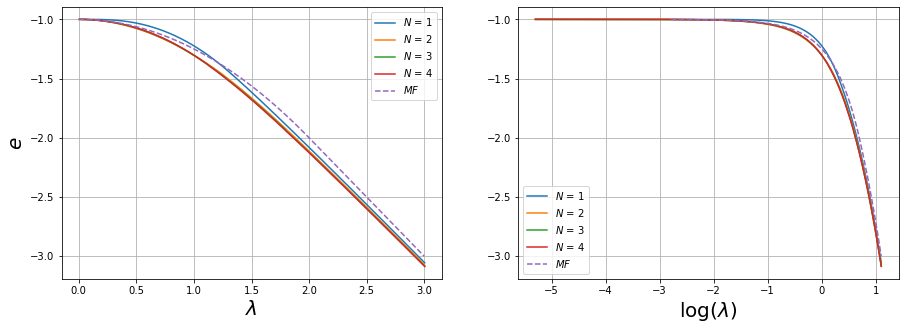

In [3]:
#for plotting the mean field solution
def th_gs_density(h):
    if (np.abs(h) <= 2):
        return (-1 - (h**2)/4)
    else:
        return (-np.abs(h))    
gs_xs = np.linspace(0,3)
gs_ys = []

for x in gs_xs:
    gs_ys.append(th_gs_density(x))

fig, axes = plt.subplots(1, 2, figsize = (15,5))

for i in range(4):

    title = 'e_gs_' + str(i+1) +'.txt'
    data = np.genfromtxt(title)
    h = data[:,0]
    e = data[:,1]
    it = data[:,2]
    #h is magnetic field, e ground state, it iteration

    axes[0].plot(h, e, label = r'$N$ = ' + str(i+1))
    axes[1].plot(np.log(h), e, label = r'$N$ = ' + str(i+1))

axes[0].plot(gs_xs, gs_ys, '--', label = r'$MF$')
axes[1].plot(np.log(gs_xs), gs_ys, '--', label = r'$MF$')

axes[0].legend()
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel(r'$e$')

axes[1].legend()
axes[1].set_xlabel(r'$\log(\lambda)$')

axes[0].grid(True)
axes[1].grid(True)

plt.savefig('rglambda.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


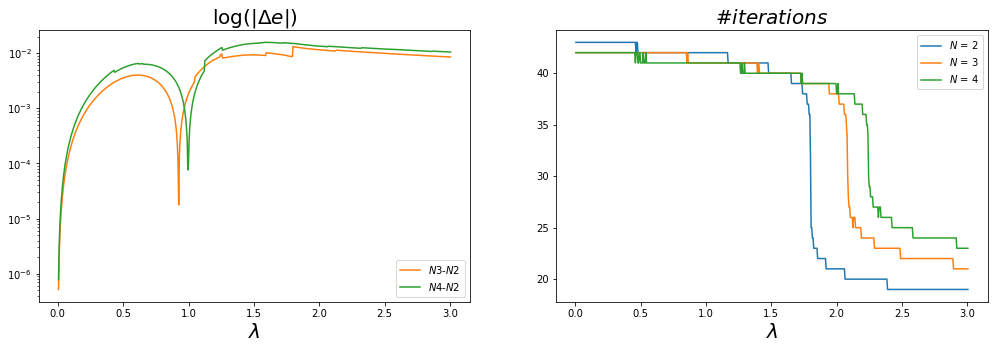

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (17,5))

for i in range(1,4):

    title = 'e_gs_' + str(i+1) +'.txt'
    data = np.genfromtxt(title)
    h = data[:,0]
    e = data[:,1]
    
    if (i == 1):
        e_subtract = e
    
    it = data[:,2]
    #h is magnetic field, e ground state, it iteration
    if (i > 1):
        axes[0].plot(h, np.abs(e - e_subtract), label = r'$N$' + str(i+1) + r'-$N$2 ')
        axes[0].set_yscale('log')
    else:
        axes[0].plot(h, np.abs(e - e_subtract))
    
    axes[1].plot(h,it, label =  r'$N$ = ' + str(i+1) )
    
axes[0].legend()
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_title(r'$\log(|\Delta e|)$')

axes[1].legend()
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_title(r'#${iterations}$')

plt.savefig('iterations.eps')

In [ ]:
#DMRG ATTEMPT

sigma_x = np.matrix('0,1 ; 1, 0')
sigma_z = np.matrix('1,0 ; 0, -1')

m = 2
k = 6
h = 2

old_e_gs = 1
e_gs = -1
epsilon = 10e-8

size = 2*m +2

#done for 2 block now
H_b = h*np.kron(sigma_z, np.eye(2)) + h * np.kron(np.eye(2), sigma_z) - np.kron(sigma_x, sigma_x)

#m = 1
#H_b = sigma_z

#first step
A = np.kron(np.eye(2**m), sigma_x)
B = np.kron(sigma_x, np.eye(2**m))

H_edge_L = np.kron(np.eye(2**(m-1)), sigma_x)
H_edge_R = np.kron(sigma_x, np.eye(2**(m-1)))

H_left = np.kron(H_b, np.eye(2)) + h * np.kron(np.eye(2**m), sigma_z) - np.kron(H_edge_L, sigma_x)
H_right = np.kron(np.eye(2), H_b) + h * np.kron(sigma_z, np.eye(2**m)) - np.kron(sigma_x, H_edge_L)

H_SB = np.kron(H_left, np.eye(2**(m+1))) + np.kron(np.eye(2**(m+1)), H_right) - np.kron(A,B)

#eigh returns in ascending order and matching
eigs, eig_vec = np.linalg.eigh(H_SB)

e_gs = eigs[0]/size
size += 2

psi_gs = eig_vec[0]
rho = np.outer(psi_gs, psi_gs)
#partial trace, as my Fortran one, which was based on https://www.peijun.me/reduced-density-matrix-and-partial-trace.html
#this is also the first comment in https://scicomp.stackexchange.com/questions/27496/calculating-partial-trace-of-array-in-numpy
rho_L = np.trace(rho.reshape(2**(m+1), 2**(m+1), 2**(m+1), 2**(m+1)), axis1=1, axis2=3)

eigs, eig_vec = np.linalg.eigh(rho_L)
#last k elements
P = (eig_vec[:,-k:])

H_b = P.T @ H_left @ P
H_edge_L =(P.T) @ A @ P
H_edge_R = (P.T) @ B @ P




#                       SECOND STEP
#       NOW H_b is kxk


A = np.kron(np.eye(k), sigma_x)
B = np.kron(sigma_x, np.eye(k))
# Superblock Interaction happens between 2 and 3, so kxk identities on 1,4

iteration_count = 0
#python do while https://stackoverflow.com/questions/743164/how-to-emulate-a-do-while-loop
while True:
    
    old_e_gs = e_gs

    H_left = np.kron(H_b, np.eye(2)) + h * np.kron(np.eye(k), sigma_z) - np.kron(H_edge_L, sigma_x)
    H_right = np.kron(np.eye(2), H_b) + h * np.kron(sigma_z, np.eye(k)) - np.kron(sigma_x, H_edge_L)

    H_SB = np.kron(H_left, np.eye(2*k)) + np.kron(np.eye(2*k), H_right) - np.kron(A,B)

    #eigh returns in ascending order and matching
    eigs, eig_vec = np.linalg.eigh(H_SB)

    e_gs = eigs[0]/size
    size += 2
    
    psi_gs = eig_vec[0]
    rho = np.outer(psi_gs, psi_gs)
    #partial trace, as my Fortran one, which was based on https://www.peijun.me/reduced-density-matrix-and-partial-trace.html
    #this is also the first comment in https://scicomp.stackexchange.com/questions/27496/calculating-partial-trace-of-array-in-numpy
    rho_L = np.trace(rho.reshape(2*k, 2*k, 2*k, 2*k), axis1=1, axis2=3)

    eigs, eig_vec = np.linalg.eigh(rho_L)
    #last k elements
    P = (eig_vec[:,-k:])

    H_b = P.T @ H_left @ P
    H_edge_L =(P.T) @ A @ P
    H_edge_R = (P.T) @ B @ P

    iteration_count += 1
    print(e_gs)
    
    if ( np.abs(1 - old_e_gs/e_gs) < epsilon  ):
        break
#PROJECTION MATRIX SEEMS TO HAVE WRONG EIGENVALUES

[-5.56154612e-17  2.80909078e-17  8.33773554e-02  9.16622645e-01]
-0.8689768572571035
-0.516088365666916
-0.3556070580075083
-0.3451185791060068
-0.23870847030548897
-0.23607272161057352
-0.24814934635606903
-0.16993339447293465
-0.14131475193379672
-0.14873284238549508
-0.1574670939235589
-0.14916485889759304
-0.136069482313565
-0.13406053261445533
-0.10051642261200167
-0.07180478107139802
-0.0823658719167992
-0.08247573194627358
-0.07072873924656761
-0.08814041347031219
-0.06560895651695017
-0.05901777870757562
-0.06535980443464162
-0.07295636637873447
-0.06173475301597257
-0.056281962164093494
-0.04803860753351914
-0.05366178643682616
-0.06855447412533826
-0.05663342390399543
-0.048293665013355906
-0.060393819465595064
-0.04938845370370781
-0.046681924173627876
-0.06407351706184868
-0.049393622930154965
-0.04211328502739314
-0.05337383897249515
-0.04600185478675476
-0.03431219318335042
-0.03387882460199699
-0.04111035712940609
-0.041645126389703205
-0.043787018331861154
-0.043188506

-0.0038876334572205884
-0.00604559423510941
-0.004572157510517979
-0.005000979595456535
-0.005174508498124199
-0.0036733277096167327
-0.0038264901115418193
-0.003835647215292831
-0.004596573735908701
-0.003718687705394608
-0.0038268545460328897
-0.004069647553528305
-0.0042126370616946095
-0.004161549294535276
-0.0033367796659146856
-0.003789990983556214
-0.0036157434629409935
-0.003800531988895275
-0.004661088905040517
-0.003882537572383734
-0.003971153476652226
-0.00406723817336541
-0.004427840247359376
-0.004582430790169419
-0.005229758150919764
-0.0046098149709970435
-0.004818606088594073
-0.005085358036514579
-0.004071043406565902
-0.0035511331660926394
-0.0033585875641132276
-0.003654552754864618
-0.004918334680762104
-0.003735709310333876
-0.0038229470941168724
-0.004079504192817042
-0.0058125282958453005
-0.0048421601798361545
-0.004249717639440136
-0.003969972188272244
-0.004081211203778875
-0.004737450355087588
-0.003050451550918582
-0.0029534442032642305
-0.00369827755359591

-0.0016803401675033196
-0.0014830169799811786
-0.0018901763844951921
-0.002594427347518883
-0.0019473962764397928
-0.0019441274944599475
-0.0022428509185565483
-0.0021277827896918804
-0.002017516139986329
-0.0019307414603193312
-0.001858415014343171
-0.00190072497543242
-0.0017340570059466874
-0.001963483029774966
-0.0019894706296226063
-0.0018476775758329276
-0.0019157551175706016
-0.001988409305942749
-0.0018073242383781728
-0.0018211946276025161
-0.0022565445554538033
-0.001978312256729053
-0.0034441801561781206
-0.0021512820014934443
-0.0025435778544788926
-0.0017401417615742966
-0.001824884437614659
-0.0019181333840819648
-0.002289697599274076
-0.002026132539224554
-0.0017741466264917089
-0.0020781190295274714
-0.0016096164786123309
-0.0018017390311282813
-0.0021341740474403997
-0.001948453658376693
-0.0022500335882792285
-0.0015906359761435245
-0.002094089002300286
-0.001902514551499322
-0.0014533063196446045
-0.0017050658475121475
-0.001907477030020664
-0.00105155407926693
-0.00

-0.001326816973208389
-0.0013090396498609195
-0.001633701366253879
-0.0014024366383007848
-0.0011788262144375402
-0.0017747592808678245
-0.0010363591886911828
-0.001686701559556681
-0.0014845861360780175
-0.0015078000777456965
-0.0015993891093797124
-0.0013789845804364508
-0.001500073475570728
-0.0014841002213327955
-0.0011838536287281695
-0.0012425858659073155
-0.0011661500252758594
-0.0011724455270824851
-0.0010586749375012903
-0.0016801865715553672
-0.001864093244583074
-0.0013174044452071202
-0.0012825389444249228
-0.001239500790366395
-0.001316277904352422
-0.0014052435847439733
-0.0015891659598208222
-0.0012729201714180337
-0.001378841318866064
-0.001683087233211249
-0.0013518527341385774
-0.0012723168440206569
-0.0012843359125636253
-0.0008718163616862753
-0.0013487618180304892
-0.0014779020791525581
-0.001378085827006209
-0.001493697905238237
-0.00197304327459777
-0.0015350758463396792
-0.0013359364655976026
-0.0013904955392682055
-0.0012704458229795298
-0.0015657498098552035
-

-0.0009548065283752663
-0.0012215188434513186
-0.0012726978797140648
-0.001303576016357703
-0.0012975177168414664
-0.0012794969865435489
-0.0011925596758441874
-0.0012484982574218124
-0.0011180424485459268
-0.0011239780291310937
-0.0011270676370573737
-0.000933437729613485
-0.001258938879899936
-0.0014119100606586573
-0.0010680389351329814
-0.001246213152555266
-0.0011210110196070548
-0.0011324896179891702
-0.0010797159574023327
-0.0011180328070848837
-0.0011542125089101425
-0.0012903286890316862
-0.0009539776061672315
-0.0011374669314395806
-0.0012436334030849012
-0.0012362601844531757
-0.0015375843171696712
-0.0012572642012567297
-0.0013901255496330338
-0.0011626412766770995
-0.0013307238910668564
-0.000986102644858239
-0.0010534899198894445
-0.0010730171830236458
-0.0009034987940397082
-0.0010526078689323936
-0.0009285214241021989
-0.0009341720205360347
-0.0010644195408974148
-0.0011219758351115952
-0.0014652032914803915
-0.0011091884990721262
-0.001026292143488835
-0.00102964324625

-0.0007904902763275242
-0.0009097525507180515
-0.0008511099699281141
-0.0009432524776721142
-0.001040604448032803
-0.001087136593178856
-0.0008597752560014926
-0.0008899091829221166
-0.0008181038695952229
-0.0010001900169852717
-0.0009468175119328855
-0.0014361802892633258
-0.0013314554110346218
-0.0007650859169847239
-0.0010173056724183684
-0.0007931341519263598
-0.0008525961954021153
-0.0007593271642505253
-0.0007755043230206362
-0.0009569910479841472
-0.0009261705066613778
-0.0009765694395021428
-0.0010167864758234015
-0.0009456148950863195
-0.0007600889283748583
-0.0008034360328052703
-0.000727349804077256
-0.0007483392017886717
-0.0007597656653444124
-0.0011463117632532164
-0.0009431206310969139
-0.0008419213858911527
-0.0009090128095845284
-0.000837037850759683
-0.000690788537272868
-0.000821401759853827
-0.0009954613680598458
-0.0009384395047270429
-0.0008924176346111816
-0.0007161857807078529
-0.0007846476645647659
-0.0008678488527058665
-0.0010011842599817627
-0.00088707793600

-0.0007339501498394491
-0.0008964784206602962
-0.0007712409090779474
-0.0006899930309317931
-0.0006412188455897226
-0.0006456424322096668
-0.0007261970578739024
-0.0007544506355597056
-0.0006630638158673009
-0.0006150996511423084
-0.0007630110679163999
-0.0006415918072848231
-0.0007464993357349687
-0.0009087735662782718
-0.0008245369133218801
-0.0007275405231527231
-0.0009042983675768331
-0.0005447012306198722
-0.0007339918884481534
-0.000587666175574167
-0.0007539426774060251
-0.0008274255166295764
-0.0007467873280373573
-0.0008633970194836274
-0.0007453380290187208
-0.0006382031318977945
-0.0007295083094329001
-0.0007616653624017252
-0.0006658440037098377
-0.0007062568598543532
-0.000808798444378264
-0.0007772028093526275
-0.0006942003998324363
-0.000854162728946517
-0.0007421052598900694
-0.0006761794593341983
-0.0005738769516957458
-0.0008163520067374765
-0.0008150144797716703
-0.0008868092303239623
-0.0009359992388173389
-0.0007630139463227839
-0.0007000373770185119
-0.00060992924

-0.0005371836956853661
-0.000499792464214899
-0.0004932723740720492
-0.0004689951184617057
-0.000551347748619714
-0.000619249703190919
-0.0006043859012435927
-0.000848972285201204
-0.0006168864975659088
-0.00046330124619931316
-0.000581457375605541
-0.0006368752642946366
-0.0006426778695955776
-0.0005684425321111151
-0.0006387917141449607
-0.000816011650964565
-0.0005225070409235523
-0.0006309815507613336
-0.0006479879234560647
-0.0005116148966448771
-0.0005966923046968477
-0.0007480003792561728
-0.0006449853075821877
-0.0007012344783115646
-0.0005414690293429951
-0.0007486154904463905
-0.0008567880691518107
-0.0006848992678975704
-0.0006834824101069894
-0.0005519994483960686
-0.0004975674514583767
-0.0006618806171210456
-0.0006253630446195921
-0.0006318326843473656
-0.000623147421146358
-0.0005742987258059058
-0.0005331647944431535
-0.0004918815391049395
-0.0006515808610804315
-0.0006512113558653881
-0.0007899347868149584
-0.0007530251944935663
-0.0005186477819078016
-0.00086596382210

-0.0005346937420750279
-0.00041012274180146613
-0.0005541372011696031
-0.000544196584244257
-0.000635287256147042
-0.0005785260513054987
-0.0005953444114020103
-0.0006230819287281616
-0.0005960856829772303
-0.0005994348473789147
-0.0005096629976917518
-0.0006210272520909161
-0.0006728665760360683
-0.0007107562386862987
-0.0007000535029989306
-0.0006151969154665544
-0.0005121441149484262
-0.0005149909908739386
-0.0005265060395639131
-0.0006478555713236225
-0.0004482644631845729
-0.0005217934657634477
-0.00049108172365224
-0.0006431770344339535
-0.0006421199890755396
-0.0005578693147410256
-0.0005435228392574793
-0.00045878087030767044
-0.0005970548995770897
-0.0007832884169026753
-0.0004308564277249985
-0.00047358835968789817
-0.0005179178639027159
-0.000502522836795966
-0.0005150178924731938
-0.0005726769230101507
-0.0005208040837644162
-0.0005413199932057176
-0.0005397554361225421
-0.0006542564396899172
-0.000599921798917761
-0.0005515684075177693
-0.0005047606275194032
-0.00065003186

-0.00047197086645265935
-0.00040137099347544277
-0.0004500576508205631
-0.00041894525922771405
-0.00040110611330014664
-0.00037724613800981595
-0.0005063100759401906
-0.0004650382029202319
-0.00046953495742321126
-0.0004982424015546358
-0.0004748634574150411
-0.000518338159468111
-0.0005772356443557678
-0.0004752721067570348
-0.00048365759877411836
-0.0005569834867169288
-0.0006891441964360305
-0.00042974757950874754
-0.00043102162508793635
-0.00037635017346998524
-0.00045657673863456176
-0.0005452076554775556
-0.00042905993981192644
-0.0004899878718222841
-0.00042823841183587427
-0.0005385717096940614
-0.00048648863252499027
-0.0003769659114938644
-0.0003684248978876329
-0.00038926398304353724
-0.0003897689443277433
-0.00047548530358143505
-0.00047301236479106913
-0.0005976491923367545
-0.0006355821933687285
-0.0005142169864821598
-0.0003796042885151714
-0.0004316026575310608
-0.0004269630532595985
-0.00048655700877050525
-0.0005076715760829718
-0.0005298525760505078
-0.00063189055123

-0.00045138643787809226
-0.0005814246894196692
-0.0003928187963469004
-0.0004375869001746154
-0.0004816671865124021
-0.0004393022270157979
-0.00042769297632075945
-0.0005018108737532776
-0.0005360509114629304
-0.0005123835475737732
-0.0005197355123795008
-0.0004068587069653715
-0.0004895405788036637
-0.00048809583969151355
-0.0004120637154399968
-0.0005692200767959786
-0.0005089589472954474
-0.000582106042337377
-0.0006079127618198311
-0.0005794773703862476
-0.0004880191281498699
-0.00041141378307441354
-0.0004119041243184083
-0.0004531595277113648
-0.00038731278425422597
-0.000415879918862649
-0.00044511685346817256
-0.0003628309243401392
-0.0004149453783906818
-0.00043205915533922466
-0.00045479072841957173
-0.00041448518257651963
-0.0005026589127706913
-0.000516223309545394
-0.00042452122300431784
-0.00040447866541020285
-0.00038539197038838814
-0.00029043167245963584
-0.0003049149292484751
-0.0003754123341253991
-0.000415355359739636
-0.00044649762524141877
-0.00042598917907166097


-0.0004267247311315559
-0.00036578446390759053
-0.0004755136087377954
-0.00038633677549530256
-0.0003517990836211303
-0.000493935211171544
-0.00040988426625518924
-0.0005117167334038195
-0.000414643385625756
-0.0004433610283969388
-0.0006247892345778362
-0.0006597593262109893
-0.000535225975355159
-0.00034094850380196574
-0.00039372459005442484
-0.00044143448823660066
-0.0004072283780537753
-0.0003430771725653209
-0.0003519688805447611
-0.0004704911614530251
-0.00047963852649159707
-0.0004887859753900013
-0.0004797165059375191
-0.0004068215389460007
-0.00047822292454558174
-0.00046875683344789265
-0.00047230879809904237
-0.00047031962587038316
-0.00048817802308028484
-0.0004630856683151835
-0.00036765225577339633
-0.00043483768442578887
-0.00042018037423008657
-0.0003750648722623715
-0.0005003171665547031
-0.000294742044376477
-0.00041628453503774203
-0.0005211835362627489
-0.00045031751291692973
-0.000617991477802604
-0.0006627069936173418
-0.0004103156174313471
-0.000412155181887415


-0.00035505618474185926
-0.0003242939844205137
-0.0003366942837072124
-0.000363090909439216
-0.00032571814424003464
-0.00031639285105101224
-0.00029436416328608157
-0.00039436145476898677
-0.0003858341391736247
-0.0004766898695053698
-0.0002852172230647792
-0.00040014561439565834
-0.0003262840011545733
-0.0003135013184525589
-0.0005121573474432603
-0.0005252214083193737
-0.0004131006656598781
-0.0003798720861372202
-0.00036470345283941453
-0.00040964026161017814
-0.00033041693644177584
-0.0003674499392228919
-0.0003597995315472613
-0.00029026623771629295
-0.0003211673997469752
-0.0003381662444718175
-0.0003587965422296118
-0.00039658229052142775
-0.0004406976545148092
-0.00032549910680340323
-0.00040000423791791305
-0.00037656035196601716
-0.00036104959717346693
-0.00030029652856322246
-0.00035690750816585114
-0.0003344405876550573
-0.00032320088956424865
-0.00047221974638437354
-0.0003551197573577441
-0.00033090843613044457
-0.00033748010848390326
-0.00036070151690853497
-0.0003577256

-0.0003273142602353456
-0.0003403278872925938
-0.0003419763080527045
-0.00034862376562240803
-0.0003991508735431263
-0.00037701521071356283
-0.00040581429062551335
-0.00034753517488174466
-0.00032565513323915934
-0.00030496939393724517
-0.0002673192583164143
-0.0002029852499864937
-0.0002982049390125528
-0.0003225721900176276
-0.0004523782691456796
-0.00038152854069174144
-0.000312675023506295
-0.00029414461443584696
-0.00030138995859887226
-0.00032613118378589857
-0.0002594902059114327
-0.0002668394794395795
-0.00025064508234809365
-0.00030211421636581266
-0.00041219806606613034
-0.00036297294093466117
-0.0003349968901428689
-0.00043088823180068215
-0.0004448097816079136
-0.0003855821684903121
-0.00031719540529572427
-0.0002985621414485815
-0.0003746389394999341
-0.0003223199240307383
-0.00032506074455705453
-0.0003768107362256721
-0.00036666137780352035
-0.000273342912107385
-0.00032264320412525056
-0.00039937567882492167
-0.0003253777171028366
-0.00045519823843606964
-0.000288999953

-0.00040708499698483073
-0.0003161255362199087
-0.0004411088818097735
-0.0004436817552995241
-0.0003514185683407886
-0.0003399317127309838
-0.00036420724066629485
-0.00040154851024988417
-0.00038354554730667904
-0.0003670180210789689
-0.00028098118141363045
-0.00035585636451845464
-0.0003655307861607406
-0.00032406127240048097
-0.0002810833531449668
-0.00030932460855235346
-0.000331866262487162
-0.0003314302592522987
-0.00032083306881694826
-0.0002886982196117475
-0.0003094276517890171
-0.0003309096647757557
-0.000351420506294102
-0.0003522211642000663
-0.0003800424472072766
-0.00028294192188483365
-0.00031468891816775237
-0.00036039965175619043
-0.000382531414049415
-0.0005052496124547535
-0.0005043349308166558
-0.00037077792864934615
-0.00030723877818492317
-0.0002800635312586541
-0.0002843314389045679
-0.0002833866465483083
-0.00025485688841548194
-0.000289996193246811
-0.00030331574069315066
-0.0003419967884310457
-0.0002985085808486319
-0.00029127174914185625
-0.000314794567694651

-0.0003325647573706478
-0.00038979773119560823
-0.00032109710433098515
-0.0002706646589177569
-0.00035172035950564506
-0.0003285075114249955
-0.000351691731305572
-0.00022869137114891368
-0.0002993018298744675
-0.00025891063290155
-0.0002596912125750568
-0.000356655238206842
-0.000249800766061403
-0.00025813395605382906
-0.0002688833173703939
-0.0002730733196131988
-0.00025764128310444247
-0.00027344536460139046
-0.0004500308603854657
-0.0004897908712854066
-0.00034527247856228364
-0.00032872014887299814
-0.00038288965983340593
-0.00028612430993665556
-0.0003225185333201653
-0.0003036421720534431
-0.00026240988403038103
-0.00029546982535557867
-0.0002629421862471612
-0.0002621217580468587
-0.00023476771305997677
-0.0002881693713029885
-0.00027052829886358245
-0.0003322140237646861
-0.0003675434287893286
-0.00026339021844704014
-0.00026666895964451773
-0.00027885485431126765
-0.00034667468870470567
-0.0003288738431239971
-0.0003701915149356626
-0.00023006088538090423
-0.0002300075648268

-0.00032173875708987394
-0.0003340258121690942
-0.00029588749658535134
-0.000261653289895075
-0.00024303718382099883
-0.00026253226570793027
-0.0002829933657046221
-0.0003269149957916459
-0.0002934840032174183
-0.00026546599813662646
-0.0002620923969932502
-0.0002409259317457528
-0.0002768564060058432
-0.0002974845584025272
-0.0002918056206025337
-0.00024157471493441453
-0.0002786072276350016
-0.0003250017641825637
-0.00031998407387239143
-0.0004243139200850142
-0.0003266593794863978
-0.0002980479758228395
-0.00035139222929103306
-0.0002615863077527767
-0.0002709908975099996
-0.0002423235857087385
-0.0003732312903232238
-0.00030585848176482194
-0.00025175937117018297
-0.0002799929431149063
-0.00024111871901297247
-0.00025191163039666326
-0.00025149742446467277
-0.0002980580455847658
-0.0002608844136701398
-0.00029153670599950133
-0.00031748371187101875
-0.0002458866646700516
-0.00025535751445999284
-0.00031758683023183404
-0.0003016109335837857
-0.00034283562769787013
-0.00026717780780

-0.00030111446256834946
-0.0003225163559929486
-0.00029596408159260926
-0.0002302045265050466
-0.0003287324404642576
-0.0002676484458093402
-0.0002708430102213439
-0.00022100751475436067
-0.0002787107939284599
-0.0002989277530544471
-0.0002968580091652871
-0.0002312280460062455
-0.0002365399346452617
-0.00025712490596486125
-0.0002678841793237178
-0.00030306550672494606
-0.00030921261931273755
-0.00022314858526753506
-0.00031218079982109624
-0.0003156644313077666
-0.00026995063851194127
-0.00020840491436613126
-0.00028348001145742346
-0.00028578860750307625
-0.00022802150707832106
-0.0002620750376904808
-0.00030173845467958436
-0.00026350961916628057
-0.0002852485785787042
-0.0002695749226013362
-0.0002899831050454873
-0.00020642985120982214
-0.00029681733584548163
-0.00031755465217903203
-0.00035323727432917223
-0.00032466076035661073
-0.0002965455350501451
-0.0003636039659729006
-0.0003694837592193237
-0.0003514352946108465
-0.00024137680053600772
-0.00024793497142320354
-0.000237213

-0.0002498405273791922
-0.00029375796470874297
-0.0002497349794370831
-0.00021526073639690794
-0.00029534468676949203
-0.00031079719497081464
-0.00030146296889574815
-0.00023047359093353195
-0.00017766333989513493
-0.00020369417803098178
-0.00027869611297430254
-0.0002547797525107397
-0.000269616254133292
-0.00027142563119278803
-0.0002572363275656838
-0.00019826366477163643
-0.00024161478385304938
-0.00022670400268306985
-0.00023236331646363166
-0.00019435006956909756
-0.0001858791809371714
-0.0002082828145058542
-0.0002732313665370908
-0.0003301375997817014
-0.00028245272301453614
-0.0003026564538813272
-0.0003007181742984467
-0.0003373499960239173
-0.00025975353010782357
-0.00024145366867784075
-0.00021638234490046053
-0.00023674663804968156
-0.00024460870498298676
-0.00024043067949247317
-0.0002433500484192657
-0.00020470622282667928
-0.00021263490924403652
-0.00020766111400863176
-0.00025623675517333214
-0.00026743295164160337
-0.00024398922043132352
-0.0002707806172927752
-0.0002

-0.0003034906752095573
-0.000272526175371921
-0.0002131024785691324
-0.00023121723411282486
-0.00021144868677847888
-0.00020667979523814403
-0.00022961619226807167
-0.0003044232688464327
-0.0002903751825652857
-0.00020090746102904063
-0.0002771621706628459
-0.00029643407966852616
-0.0002467318055668786
-0.00025845171786726036
-0.0001978180427276542
-0.0001910589258249093
-0.00023657818830284032
-0.0001871531122999841
-0.00023309057658385486
-0.00028513098630356126
-0.0002469717370279405
-0.000300492834537948
-0.0003562319724599335
-0.00029009898315165007
-0.0003142266008513227
-0.0003007057342605177
-0.00022559451690663194
-0.00020637253798659694
-0.0002115017368842028
-0.00023502507752903813
-0.0002450797399220493
-0.00020387080168548653
-0.00030384217426890955
-0.00029103522561295175
-0.00027048449989596727
-0.0002197319806879646
-0.00021307481719462176
-0.00027463877954197915
-0.000227082358571289
-0.0002867216812450429
-0.0002698619108426258
-0.00026774031819578237
-0.0003118126644

-0.00022248085367552523
-0.0002248388302435389
-0.00023314674361982847
-0.0001993190784269482
-0.00018881363476324598
-0.00023469194278662037
-0.00023350779247244345
-0.0002133201585927793
-0.00022981949204412135
-0.0002258091847386437
-0.0002067045930215898
-0.0002130507349645625
-0.00021985080003974282
-0.00022992633326174059
-0.0002226726255496794
-0.00026099340327291837
-0.0002421701596820789
-0.00022266643465174423
-0.00023263280463173708
-0.00033018499859678406
-0.0002605411268725705
-0.000274133282999408
-0.00022615900676070864
-0.00026301484118663223
-0.00025640756146507213
-0.00021503876992820872
-0.0002751560108256107
-0.00023159900892271739
-0.0002001853960988599
-0.00023012918719949837
-0.00025536243889646293
-0.0002505161037595576
-0.0002059150387278372
-0.00019653372435178668
-0.00024913264071931506
-0.0002575080324841671
-0.0002763603407221639
-0.00024843262615011893
-0.00024523874150663626
-0.0003009569349154034
-0.00023867661757796796
-0.0002764822062155439
-0.00020067

-0.00023011628804727008
-0.0002428342896508394
-0.00023573714249716925
-0.00024843324112172366
-0.00024510996000629226
-0.00019916328686562764
-0.00020860464795551318
-0.0001974854401193602
-0.0002565507012866774
-0.0002674686748073148
-0.000221421114454264
-0.00019913277218095907
-0.00020889611669061477
-0.00024478922511948396
-0.0002257274980613697
-0.00016804093550939632
-0.00018715572969599554
-0.00019553837086991273
-0.00023943424462277265
-0.00024011983604855855
-0.00023150541797127582
-0.00023116293038867358
-0.00021986862238096685
-0.00021979659792198378
-0.00021973582579699533
-0.0002022645290185626
-0.00024223848042644088
-0.00022912056043661286
-0.00021316780644363152
-0.0002724011218593329
-0.00030034657260656064
-0.00020084346177374793
-0.0001937826797678027
-0.0001852436404385006
-0.00019739496889531862
-0.00020582218882499216
-0.0001823648965906281
-0.00031857215624814115
-0.00027436464996310995
-0.00020992214625530268
-0.00025068259394174454
-0.00023387238020267597
-0.0

-0.00018697854307237014
-0.0002459220917699342
-0.0002109489887367616
-0.00027131040821906584
-0.00015607648622559706
-0.0002049986589046092
-0.00026728785799044806
-0.00018401967275638288
-0.0002446656856826796
-0.00019229463365073672
-0.00019267330725326821
-0.00022830435140213932
-0.00022932217509930106
-0.0002741335338339827
-0.0003449479308158202
-0.0003353005387144763
-0.0002735142093030241
-0.0002489578495951649
-0.00022668508770128164
-0.0002142676806366454
-0.00019832052619927774
-0.0002752838649664421
-0.0002535082213229338
-0.000260428883637078
-0.00020038559851555488
-0.00021757108908736268
-0.00021810949655436546
-0.00018699318947661193
-0.00025094720259680674
-0.00022808325622817753
-0.00021283014983932439
-0.00018574360099689772
-0.0002253978166010366
-0.0001813930134880701
-0.00017496559672008146
-0.0002111686300238918
-0.00024005887046484143
-0.00017853443349452667
-0.00024824576075216755
-0.00017961184185670377
-0.00021091287364868576
-0.0001661727579419388
-0.0002045

-0.00023349269691326686
-0.00022325179808242328
-0.00019174705859942398
-0.00021050620537442627
-0.00020009904528608393
-0.0001773074709097747
-0.0002123222283672166
-0.00015888275342482543
-0.00015892328550813295
-0.000174923489058945
-0.00014254421188560914
-0.00016834632814206123
-0.00021356524303345957
-0.0002144092570980872
-0.00018250217081348813
-0.00016858560003971113
-0.00025323143512078335
-0.00019171853792002976
-0.00022140847888637587
-0.00016281191054575046
-0.00017968872280789728
-0.00018272839057750372
-0.00021974766756807735
-0.0001712268117497459
-0.0001985156517768931
-0.00019061566866405361
-0.00020840025059720208
-0.00021402037145298324
-0.0002620209856173069
-0.0001749994234270832
-0.00017257489654558679
-0.0001928135676654228
-0.0001854546684279512
-0.0001748788440714172
-0.0001862531644876955
-0.00023771481193304213
-0.000198689450867402
-0.0001699119247901947
-0.0002086712235784785
-0.00021333442007256923
-0.00021053123451104916
-0.00023288871297056423
-0.000189

-0.00016644744367251348
-0.00017506420910651254
-0.00016591975649075466
-0.000160861827366014
-0.00014100336844189446
-0.0001756751278702603
-0.00019720098001394488
-0.00018506128797406623
-0.00023305784927640284
-0.00022281807699936937
-0.00016589025703977702
-0.000209870900045121
-0.00020030489885216032
-0.00016758751692704129
-0.00019638704193793375
-0.00019664541787956001
-0.00020032941377818217
-0.00020330984590473153
-0.00020334012578882276
-0.00012237776101493963
-0.0001780045628432889
-0.0001951975197989043
-0.0001616621844268493
-0.00016549965080977507
-0.00017953095287131086
-0.00016505736749668396
-0.0001601699300468091
-0.0001847530215298977
-0.00019631459687951018
-0.00014752396398193357
-0.0001643032440253935
-0.00024580270894970194
-0.00016193855570788518
-0.0002188933893500862
-0.00022934469759774642
-0.0001793788671764033
-0.00018006480160730277
-0.00018139107610772438
-0.0001568281604323118
-0.00017480382324590188
-0.00018411665644830046
-0.000199841416742284
-0.00021

-0.00015338507946154804
-0.00014148237325255542
-0.0002142540505429433
-0.00021221821578713647
-0.0001706465749825271
-0.00019082131365406895
-0.00018625330300004754
-0.00019155858795309792
-0.00017531056733094622
-0.00019764168087371963
-0.00023080883235163517
-0.00020534095891347294
-0.000172503873137499
-0.00016885483862732676
-0.0001847485909814962
-0.00016177927924839296
-0.00018391701412202687
-0.00018407831510202703
-0.00010361713391957781
-0.00013938440594461215
-0.00016271277773345663
-0.00014743183022844166
-0.00019950926301197876
-0.00015171525233304193
-0.00019446692767411156
-0.00017983729541130153
-0.00016557906048284351
-0.00018819716296213058
-0.00020482018735892314
-0.00020513653537115528
-0.00015038206131057135
-0.0001824180326765755
-0.00022295904094824404
-0.00020694014653586463
-0.00019140737422850037
-0.00020479139010435478
-0.0001920805907855217
-0.00020472829163135578
-0.00017733035756352462
-0.00018781797535265968
-0.00019137577707064687
-0.0001610416237783699


-0.00021376530841432407
-0.00021844685350994896
-0.0002138193284956116
-0.00021930903709703556
-0.0001784103892659593
-0.00021902499040173123
-0.00025821146883905444
-0.00019374003089834302
-0.0002000125916383348
-0.0002014560585027581
-0.0001605841639537042
-0.0001745235307976149
-0.00018510445812375845
-0.0001761100400667451
-0.000170779843843477
-0.00018707719762684475
-0.00016550861959506552
-0.00015755812754031002
-0.00016700597099081655
-0.00017189727739028694
-0.00021521251657018233
-0.00016632481085958575
-0.00021930192689489342
-0.00020287857392786645
-0.00022489512640930308
-0.00014888092915194508
-0.00017134494717457212
-0.00012598033944063924
-0.00015892589072998153
-0.0001247251539319352
-0.00013847469726149795
-0.00013875413832201144
-0.00014446318638253815
-0.0001833802506020003
-0.00016362716272592752
-0.00014553372973028744
-0.00016294814803725346
-0.00012940514559141344
-0.00015554079296589316
-0.00013199310566811045
-0.00020185850478437163
-0.0001837474391563465
-0.0

-0.00015168322514973287
-0.00019380634261017407
-0.0001899491373774201
-0.00018788786048509398
-0.00016651464524010403
-0.00016065046743598976
-0.00013544771341841662
-0.00014285783412938834
-0.00015849267419058965
-0.00018077969800208172
-0.00022521336178325175
-0.00019186028145501356
-0.00015704145746276574
-0.00019487360994472112
-0.00017104790434836824
-0.00019398597614123884
-0.00017188349715428872
-0.00020864491804374177
-0.00017287850151888434
-0.00019751943195918774
-0.00016782117607487616
-9.450701416778719e-05
-0.0001444291578367122
-0.0001494058624001899
-0.00016461041829158164
-0.00019369817114028281
-0.0001409039423013056
-0.00016007722523746952
-0.00013638550509137732
-0.00018319568248979378
-0.00018625455125673545
-0.00022908491745645285
-0.00022527748552085225
-0.000209080735654449
-0.00014538052109773302
-0.00018391510562287177
-0.00017951733943560814
-0.00015633571657028126
-0.0001609340419391767
-0.00013906759592205423
-0.00020115631405595355
-0.0002206693169868921
-

-0.00016494749577204734
-0.00016342817590908094
-0.00016728152592393236
-0.0001957810232883636
-0.0001673251670632714
-0.00013574526298391765
-0.00014855665406334354
-0.00016312659979586495
-0.0001868925371671514
-0.00019344199680574632
-0.00021552137137213344
-0.0001965762554378805
-0.0002188657968577866
-0.00017553318668523716
-0.0001469461707242414
-0.00017249565563690734
-0.00019135081111781418
-0.00023707901695595998
-0.0002251781245292434
-0.00031324469260329645
-0.00022886532526924808
-0.0002271920161428767
-0.00020921457603056414
-0.0001981419151583785
-0.00017641262197043734
-0.00014445516826864876
-0.00015900813822302995
-0.0001827367209998802
-0.00016484920075565985
-0.0001739330104635341
-0.00016357919342701926
-0.00017800847756356414
-0.00012876105891121732
-0.00014249792997805344
-0.00015363522929542962
-0.00017607949029000957
-0.0001593306657202157
-0.00020494035748184496
-0.00014656485407494967
-0.00016441962938828356
-0.00017571579348879635
-0.0002074318183631901
-0.00

-0.00021536328142011813
-0.00015102648810314694
-0.00016116715435564975
-0.0001600290150813319
-0.00019718961687824715
-0.00014915376143485493
-0.00013363803075627009
-0.00013537992995150375
-0.0001774855774963147
-0.00016360478549275325
-0.00015482292335746396
-0.00016985278635461566
-0.00015042268938572108
-0.00015758784553545664
-0.00018502848724634392
-0.00013327104645645494
-0.00021822451366848057
-0.00015922334116638798
-0.0001607880571462978
-0.00022002908001547868
-0.0002266681825317477
-0.00024126099435794115
-0.0001577620259313688
-0.00018203606190651258
-0.00015349389389488887
-0.00020063748099979973
-0.00018583174130615214
-0.00018593493525830612
-0.00020167053183716465
-0.00017609134838716638
-0.00014643477589042185
-0.00016010508581580058
-0.00015944954958384752
-0.00015471795050483634
-0.00014512169552649857
-0.00017178000003827007
-0.00014689976724746077
-0.00015610224419815985
-0.00013910134018808195
-0.00014304911667261544
-0.00015127341408031293
-0.000148445579853963

-0.00012715191376037492
-0.00013122886717854978
-0.00012716225351216883
-0.0001420224928113364
-0.00020216175332714065
-0.00018342165825788545
-0.0001406795135159566
-0.000145936435968652
-0.00013688031816437346
-0.00013945459803832054
-0.00015550261733701692
-0.0001507130948483414
-0.00014532152074716751
-0.00014435803188109445
-0.00014653359607874698
-0.00014996688016623094
-0.00017972191873621992
-0.00020339522515434427
-0.00017371061643651025
-0.0001968264595960643
-0.0001457256404143665
-0.00015846497824603141
-0.0001756287353344247
-0.00016565838478734509
-0.00015457067560304183
-0.00017958073057994402
-0.0001825084056344959
-0.00017573927616884764
-0.0002167517374835629
-0.00013452149199393037
-0.0001304800680296611
-0.0001718881170152427
-0.00013650632505886266
-0.00019803661898782577
-0.00020564554875329152
-0.00013708477062927775
-0.0001458754881757887
-0.0001304032172779095
-0.00012876013551533548
-0.00014041332923569766
-0.00012037988901654309
-0.00016267443650034522
-0.000

-0.00012202456813517828
-0.0001673361841892947
-0.0001379770078726738
-0.00022574015968321372
-0.0001863703274772444
-0.00021165433819454052
-0.00016664932385535187
-0.0001560204492911608
-0.00013969785559357831
-0.00012574694618568746
-0.00011716901438462125
-0.00010379117364826693
-0.00015013742077037961
-0.00016036178672146348
-0.00014411667855824238
-0.0001654073157004238
-0.00014736514565820156
-0.00015506394719786999
-0.0001703462805308544
-0.00016563634229025713
-0.00010966430227199788
-0.00013843253060121685
-0.0001347370152016224
-0.0001526197416335026
-0.0001555929148238805
-0.00013834341881680746
-0.00016879220891556315
-0.00012894467528095556
-0.0001443552045551536
-0.0001723919892298441
-0.00015869956542930808
-0.00024369128150848399
-0.00019909547468744808
-0.0001706838720308055
-0.00019438177812783152
-0.00012626662955350748
-0.0001294266120831898
-0.00015031356034799262
-0.00015157789117139497
-0.00018954005788361202
-0.00019715861633015213
-0.0001693890069541206
-0.000

-0.0001394313214387468
-0.00014181055697539004
-0.00017560344680766393
-0.0001426331256092173
-0.00018098463169583513
-0.00021313243998293744
-0.00016153352810668656
-0.00012125058080442381
-0.00014694675215402207
-0.0001371888226777119
-0.00013634532422278158
-0.00012921397838235645
-0.00011997016209226542
-0.00015748152324590204
-0.00016765778390421068
-0.00016241948402564968
-0.00012427105777495294
-0.00013052907053310878
-0.00011677104595870938
-0.00013551146765086128
-0.0001360970497169302
-0.00012717049698036115
-0.00013495166040217927
-0.00013603698139847393
-0.00013088587303874779
-0.00015391110734771376
-0.00017005015624644814
-0.000182270796578853
-0.00014846861118083643
-0.00013731228143997997
-0.00013033015440419481
-0.00013841104662193351
-0.00017386120405672877
-0.00014714725670568853
-0.00015423796408616587
-0.00015653728330760605
-0.000206103190332291
-0.000173259382152785
-0.00014374063733423064
-0.00012124534055466464
-0.00013364475618246626
-0.00014466650154491104
-0

-0.00013072160068871238
-0.0001566448886336834
-0.00012746165472106772
-0.00012561867798556507
-0.00013185381223131446
-0.00012306806869160267
-0.00015250305128991788
-0.0001502543710910701
-0.00013486014345605608
-0.00014420867924302315
-0.00011691653753391571
-0.00011348095999832262
-0.00013395996828118425
-0.0001213602416283528
-0.00013433570857453416
-0.00011520909950436712
-0.00012356358757459717
-0.00012511988554311348
-0.0001471522295467282
-0.00015527132330210743
-0.0001759452054216438
-0.0001415385589541824
-0.0001654870920186991
-0.00017211609694678205
-0.00016788108388105877
-0.00015102770866729794
-0.00011966696110855857
-0.00012794382300193227
-0.0001263450095399833
-0.00014713942417380265
-0.0001406074741994663
-0.00013848308561824907
-0.00014588808415118303
-0.00011738746935888628
-0.00011823629609106907
-0.00013161772586457434
-0.00011868537679865366
-0.00011732953131272129
-0.00012031208428757658
-0.00013392581083287287
-0.00014177717630829852
-0.00014245224450220445
-

-0.00013746870457696697
-0.00015926338190199108
-0.0001808786353135215
-0.0001656461314177427
-0.00014771773058499938
-0.0001122922022842245
-0.00011998028189146049
-0.0001439180861224024
-0.00011805509415173593
-0.00013049388709577035
-0.00015386943015500173
-0.00014423598101690767
-0.00011515836493577038
-0.00016869074217781764
-0.0001543084443044688
-0.00011441697874320674
-0.00011252380346369695
-0.0001383002608384962
-9.605378044625514e-05
-0.000131377326244618
-0.00013858960095363776
-0.00012661938987490337
-0.00012758928906178297
-0.00014579476397771996
-0.00015836263475627635
-0.00014530491340840652
-0.00012725872652078084
-0.00013362698231261547
-0.00014968721225757495
-0.00014323649201269505
-0.0001418188137389688
-0.000182698312619778
-0.0001794129048689548
-0.0002285134502439073
-0.00019457083581143376
-0.00015424422204631186
-0.00014159620948237824
-0.0001256488935274223
-0.00017578756908368724
-0.0001284119363869157
-0.00014331553039148768
-0.00011446403398247529
-0.00013

-0.00013766667733107344
-0.00011362906107303265
-0.00013865858880718495
-0.00011408279037007417
-0.0001074222532741169
-0.00011526198629796734
-0.00010279526801062207
-0.00011295358012556182
-0.00012477643997763793
-0.00012444643572989678
-0.00012189550349400584
-0.00015365607992735234
-0.00013866775376678882
-0.00013147291262174943
-0.00018987326000051503
-0.00016440521972209887
-0.000177833594880548
-0.00011986424222238042
-0.0001255674278499971
-0.00010737959378360135
-9.43814568179511e-05
-0.00011442275037724672
-0.00010926519676025214
-0.00010425206811579431
-0.0001258277318947392
-0.00012850445795464926
-0.00012265312466897292
-0.00011006721524935317
-0.00013505283966005403
-0.00014151382924173998
-0.0001738348144871754
-0.0001815701000582191
-0.00016632091338745047
-0.00020776653580416556
-0.00014735671379538818
-0.00014830897789374007
-0.0001530016835035434
-0.00012843256052276505
-0.00013013972011163157
-0.0001527071392514161
-0.00013069023717460627
-0.00014181112093489243
-0.

-0.00011643377018171261
-0.00011941960419636827
-0.00011926928097872522
-0.00011052599014229952
-0.00015599866448905698
-0.00013540085777744292
-0.0001784156281194056
-0.000128478446377196
-0.00012085123435390409
-0.00011886271788789154
-0.00013492035222029223
-0.0001496766906664731
-0.00012788349743369848
-0.0001444781063463187
-0.00014290743375480728
-0.0001393131158102482
-0.00013340945380305391
-0.00012950067016762103
-0.00011829498763933786
-0.0001431061216975869
-0.00011913414343871184
-8.691924213459422e-05
-0.00010829317968713173
-0.00012323912692914412
-0.0001359536448374879
-0.00012889846928032194
-0.0001449289081965303
-0.00016745998302684253
-0.00021676288189421503
-0.00014950717217239207
-0.00014174443816790977
-0.00016322294180465556
-0.00012112315950458852
-0.0001754843016806491
-0.00013574380427358967
-0.00012172720017370946
-0.0001331686287710132
-0.00012791759798259903
-0.00011983156882650707
-0.0001460179011829316
-0.00014119081248347836
-0.00015072740549003719
-0.00

-0.00013788234442401473
-0.00013039138091631785
-0.00011687744272632922
-0.0001325267698240128
-0.00012146055285461318
-0.00010686412568446911
-0.0001353495824534486
-0.0001406609292717976
-0.00012192788854571572
-8.691028046076364e-05
-0.0001206033919807402
-0.00014578183077707825
-0.00014225994936486604
-0.00013800759257766524
-0.00013682514387204525
-0.00011557655349710861
-0.00013513315492791735
-0.00010798378530713142
-0.0001245803950461479
-0.00016376367458420906
-0.0001268138674507405
-0.00012818701120389904
-0.00011382393644902149
-0.00011040864189472897
-0.00010691851200612868
-0.00013599850873212448
-0.00015317161968740186
-0.00014573650953907607
-0.0001315174455616436
-0.00012047991671644459
-0.00011061831478926709
-0.00013452833892282936
-0.00014565515067525506
-0.00012373583190942598
-0.00010194433791700338
-0.0001266527083672792
-0.00011863017028466912
-0.00015843012311669204
-0.0001264049067268812
-0.00010381785761000506
-9.035202268191181e-05
-0.00012649582474913982
-0.

-0.0001177134127002611
-0.00012200363952380515
-0.00011929376584508606
-0.00012261067761750648
-0.00012315473653002606
-0.00011331202415922124
-0.00011470476599749156
-0.0001159320553447213
-0.00010169568206451036
-9.896596647998313e-05
-0.00010011110994191609
-0.000128732375285842
-0.00010973980605623123
-0.00010522458709087248
-0.00011690430936699778
-9.704233988769352e-05
-0.00010789328071678751
-0.0001125753710709125
-0.0001132405466026702
-0.00012128100593984324
-0.0001310178079071951
-0.00011836676015455422
-0.00012002329591362508
-0.00010950043234750078
-0.00014807501208894818
-0.00016656391321731627
-0.000113480489178775
-0.00011216988410048965
-0.00010881534220083637
-0.00017138979164355535
-0.00016902868484625945
-0.00015933953286205658
-0.00015347117198117908
-0.0001381449651377127
-0.00013495770592389597
-9.380784585223127e-05
-0.00011032824041640172
-0.00010497674196387862
-0.000109534340223365
-0.00012325416252498741
-0.00010177368460970774
-8.254638340203609e-05
-8.51421

-0.00011002591078648088
-0.00013121255215656856
-0.00013216301035822253
-0.0001696568810688567
-0.00014320322429375195
-0.00013936051656295413
-0.00014614020348832337
-0.00013168503396453166
-0.0001653757776434825
-0.00011293656131645755
-0.00013009291763246258
-0.00014549701568489543
-0.0001372593085598506
-0.00016967969101176268
-0.00013945987836213087
-0.00010777880376709643
-0.00010432677065503979
-8.230033750935752e-05
-0.0001109108983670696
-0.000107027339819169
-7.777345268034189e-05
-9.338982709937557e-05
-7.904146456187485e-05
-0.00011268378025319958
-0.00010745232290013086
-9.926575312904609e-05
-0.0001152390465441379
-0.00011641694678346859
-0.00012508279538421576
-0.0001446928796601454
-0.00011508391639386888
-9.286728974752299e-05
-9.032340682199823e-05
-0.0001187744963321187
-0.00011905490456325475
-0.00010042198363461181
-9.734440505106448e-05
-7.402712669675862e-05
-9.930835759649962e-05
-0.00010035896707622465
-0.00010172923704129791
-0.000131499782739377
-0.0001310733

-9.878162384299621e-05
-7.839563749337445e-05
-9.221360952547036e-05
-0.00010794085587160475
-0.00011401344843471725
-0.0001291867022223499
-0.00010581573980971722
-0.00010441798072670007
-0.00012593623822311414
-0.00012178637414089087
-0.00011015312941367813
-0.00011317370251647203
-0.0001339163878397398
-0.00011078846632523553
-0.00014161226748707757
-9.817227243886821e-05
-9.575442601855356e-05
-0.00011515277654393432
-0.0001090653769685532
-0.0001097935299649099
-0.00010881626649518801
-0.00010028854833747398
-0.00011447778108841355
-0.00010927250234378179
-0.00012737085943493383
-0.0001439487726139363
-0.00010546158735073538
-0.00010387397242362255
-0.00010127917352515356
-0.00011714167652509702
-0.00013287603183260557
-0.00012494823558130213
-0.00011412087368619557
-9.619092656747005e-05
-9.816465398477851e-05
-0.00011165036497947246
-9.755857006229601e-05
-0.00011852376878946993
-0.0001199048691424423
-0.00013231522296486674
-9.19313623041574e-05
-0.00011340441923094223
-0.00012

-0.00011656349151083133
-0.00011586642011759168
-9.592763824915012e-05
-9.837581195525786e-05
-8.80968009319313e-05
-9.096087558550252e-05
-0.00010273023150382073
-0.00010322870481234727
-0.0001375114532887063
-0.00011778678884253654
-0.00011768958072354681
-7.177981833097939e-05
-9.033725438377854e-05
-0.00012834555426228172
-0.00012101728459806327
-0.00010123318958790326
-0.0001289361715408206
-9.779175693356502e-05
-0.00010860337056237986
-0.00012969465714586696
-0.00010303914135060615
-0.00010086311221774711
-0.00010121910328512043
-0.0001298875142428985
-8.685257255345621e-05
-8.344854534798974e-05
-8.982558935260223e-05
-8.902359141269299e-05
-0.00010042204295615021
-0.00011252240334223658
-0.00010043507712970262
-0.00011205552306659259
-0.00012792014977991217
-0.00013662808589085703
-0.00013316165321182986
-0.00014673745598006263
-0.0001398816175919975
-0.00013460701510653762
-0.00011422091220493325
-0.00011971400392629077
-0.00011898227664842888
-0.0001048515757718755
-9.488173

-9.388112797466764e-05
-0.00010586202567406289
-9.86927504503277e-05
-0.00012182391590151942
-0.0001421597045118905
-0.00010772684029452375
-0.0001075075451317646
-0.00011018666565971294
-0.0001190463917827414
-0.00010164476045456587
-0.00010429947279543456
-0.0001279034523014916
-0.00011541291538105783
-0.00013467516539675088
-0.00013917756536539262
-0.00010518618967215977
-0.0001102640235084833
-0.0001277025845716217
-0.00010932996889307909
-8.370870015440776e-05
-0.00012042543301774632
-0.000134468299844638
-0.000103085136525734
-0.0001328178358547099
-0.00010397015240972576
-0.00011257783954630076
-0.00011736754177358662
-0.00011377648926822561
-0.00013752641615887517
-0.00013558414188393858
-0.00010495320507420794
-0.00011959498178824081
-9.498068364830895e-05
-9.503279674985145e-05
-8.652752021990178e-05
-8.651908567240479e-05
-9.358229536218603e-05
-9.926615395258897e-05
-8.848427609732907e-05
-9.524651571258971e-05
-0.00010308465927286893
-0.00010622229231613857
-0.000128063010

-0.00011373565803525067
-0.00011288343360673213
-9.037533629784874e-05
-9.685471312102698e-05
-0.00011246113453198192
-7.991807978662533e-05
-0.0001206046703042708
-0.00011089309917563413
-0.0001004823975004342
-0.00012163800246166965
-0.00011927963849075809
-0.00010892604423385233
-9.615463041068709e-05
-0.00010175126652412523
-0.0001253501727621646
-0.00011508916451804915
-0.00013137020247693603
-0.00010656029297693568
-0.0001290149277522809
-0.0001283033507449523
-9.026217443678366e-05
-9.281996715842987e-05
-0.00011944905546109801
-0.00013488728668733222
-0.00011703632324271936
-0.00010211887633887685
-0.00012574352611262072
-0.0001017351248026469
-0.0001026549536455
-0.00010271379951001686
-0.00010987662047093258
-8.274734229508705e-05
-9.741147937051226e-05
-0.0001131306433773857
-0.00010963701955090554
-8.870497226879145e-05
-8.594563527288637e-05
-9.77734587848025e-05
-0.00011994923282278316
-0.00011501227200868656
-0.00015297119659032793
-0.00013233665787151122
-8.871755144273

-9.388171787975764e-05
-0.00010147486611268417
-9.913833216061302e-05
-0.00010127076351052825
-0.00010257658788313157
-7.967888681562036e-05
-0.00012337693894793957
-0.00014089124628147547
-0.00013145939352763453
-0.00014944919426656235
-0.00012137299449976505
-9.504405539364146e-05
-0.0001104498075169542
-9.816042180532687e-05
-0.00010198020459762966
-8.530652056028836e-05
-6.868684611932406e-05
-8.114049499198677e-05
-8.838138403147403e-05
-9.036007580348763e-05
-0.00010004155887635131
-0.00014154068039684933
-0.00012307152723058153
-0.00015262778047831605
-0.00011943244211757842
-0.00011309582189729363
-0.0001201362214221493
-0.00015088999804085027
-0.00011731106088128485
-0.00011243796082776899
-9.803659520961847e-05
-0.00010672536150937631
-0.00010391917131997724
-9.798258176257194e-05
-0.00011446885551981432
-0.00014165553071387012
-9.799069237234784e-05
-0.00010290207326085742
-0.00010781400870942547
-0.0001075453753629079
-0.00013184151567511407
-9.320390410762557e-05
-8.924955

-9.705757523688624e-05
-9.076180216139205e-05
-8.644265018284434e-05
-9.701324981207175e-05
-9.827362737999644e-05
-0.00010033250405912144
-9.294230829575808e-05
-9.951501566425882e-05
-9.631199612416858e-05
-9.201370117694368e-05
-0.00011587412834127005
-0.00012211338484100816
-9.637183859952408e-05
-9.307931111543606e-05
-0.0001273289043855081
-0.00011244736397079986
-0.0001407357993035211
-0.0001376100736183875
-0.0001253982253735594
-0.00010912600125263341
-9.940573515710174e-05
-0.00010114289543399141
-0.00010847266674399362
-0.00011402393482714874
-8.468753425609558e-05
-9.97971690884619e-05
-0.00010051115158718439
-0.00011335067268885937
-9.44618123925005e-05
-9.416243529081756e-05
-8.398039855751168e-05
-9.522617912946136e-05
-0.00012237441039103161
-9.826219377284933e-05
-0.00013108718476536368
-9.838692905306979e-05
-8.848145220811111e-05
-0.00010099836573281048
-0.00012649470757261045
-9.393173639477097e-05
-0.0001316436734290988
-9.407489246318389e-05
-0.0001173095043308508

-8.478926238950555e-05
-9.39664377537317e-05
-9.961252328246193e-05
-0.00010024825166982302
-9.287617395893459e-05
-8.916476016598028e-05
-8.700005706147089e-05
-7.636056786702152e-05
-8.347466540238466e-05
-8.118087658843303e-05
-0.00012877382055579423
-0.0001447141754601671
-8.904104744151075e-05
-0.00010695881041883684
-0.00010674687894447174
-0.00013340485568106723
-0.00011194612651615888
-9.447257024064732e-05
-0.00010137259266918672
-8.873752423562364e-05
-9.338371623389259e-05
-8.621148184245534e-05
-6.60428061447428e-05
-7.850693824199637e-05
-0.00010668287131344321
-9.398478591057959e-05
-0.00010545669038315165
-8.908755060630867e-05
-7.691810717609139e-05
-8.508894663003819e-05
-9.011249267357512e-05
-0.00013040990003193185
-0.00012925374786302947
-0.00015633243133673574
-0.00013955950182987386
-0.00012473217617364253
-0.0001366371660537357
-0.00010715274874508741
-0.0001468026482200888
-0.00013148755388883295
-9.857233966393897e-05
-9.696097835918279e-05
-0.00010290152464612

-8.81918356075797e-05
-8.514605442009728e-05
-0.00010106264711714062
-0.00010158057018290462
-9.212881121274124e-05
-7.917391865594368e-05
-8.695356912922631e-05
-9.694679458854042e-05
-0.00012527680753640673
-0.00012393545027691977
-0.00011838526755856505
-0.00011557890090719186
-0.00011154931102680312
-8.631962109439126e-05
-0.00010991095339558378
-8.562514259189941e-05
-8.492228022256317e-05
-8.502708359964374e-05
-7.966075436773544e-05
-7.861896757390274e-05
-8.236414463335781e-05
-8.689443020698309e-05
-8.488106595966144e-05
-0.00010695016493885832
-9.808182466094558e-05
-9.616668811865014e-05
-9.595892139012935e-05
-0.00011574980913348345
-0.00010099754035695874
-9.180926634709846e-05
-8.230233689810342e-05
-9.515594478703693e-05
-9.070676548538934e-05
-9.949336925701034e-05
-0.00012623692233321862
-0.0001291879372536347
-7.712965492042979e-05
-8.380011038266311e-05
-8.591047451430606e-05
-9.759375458814491e-05
-0.00010155987489901898
-0.000112868521268148
-8.915828650751863e-05


-8.579400022988158e-05
-9.944278196067021e-05
-9.906587677925274e-05
-8.516078010686274e-05
-9.18910825049825e-05
-8.672681328396506e-05
-9.32869730228313e-05
-0.00010297391972339513
-0.00012105004918207158
-0.00012677123350286995
-0.00012354785146996645
-0.00012077043983992954
-8.317907793652847e-05
-9.788505882467635e-05
-9.801606107311605e-05
-0.0001300025254872617
-9.594426877662932e-05
-9.701717962361657e-05
-0.00010070032100654048
-9.999510409620353e-05
-8.733980851508309e-05
-9.011874725137596e-05
-6.256933307710495e-05
-8.113424238410408e-05
-7.272849066661237e-05
-8.588939789406702e-05
-7.609167399154609e-05
-7.321373376175579e-05
-6.79531136460226e-05
-8.143792193678684e-05
-9.89989656376885e-05
-0.00012315885800560475
-0.00011290580033245496
-0.0001284565839485217
-0.0001415867884548886
-0.00013203082602467314
-0.00013367713453388313
-0.000122912575351528
-0.00010126479351673608
-0.00010851839177161747
-9.435560324932036e-05
-0.00010207071613239484
-8.986212527367295e-05
-8.

-7.995707314417006e-05
-6.309223165083016e-05
-8.684629959273272e-05
-5.9006841694702486e-05
-8.100528003507801e-05
-7.848704633460126e-05
-8.841690541790524e-05
-9.552375398374302e-05
-9.052231534500515e-05
-9.672200126170217e-05
-8.828581405983042e-05
-9.594513502616571e-05
-8.261639942613435e-05
-9.759266517275211e-05
-0.00010802838447107365
-0.0001169033320706204
-0.00011660285963470047
-0.0001225317446471632
-0.00011049266570146475
-8.536081590073236e-05
-8.044821617225773e-05
-7.152733572292294e-05
-9.16047181578337e-05
-9.150247998417218e-05
-8.36627983677487e-05
-9.473265316286788e-05
-8.629083174471645e-05
-0.00011538836581890508
-0.00010751020415927794
-9.80340045946502e-05
-0.00011782294186062611
-0.00011176512806284009
-0.00011815908937521982
-7.995353801551793e-05
-0.00010143241021469822
-8.025637994170224e-05
-8.662881937858465e-05
-0.00010595448641482099
-8.820062805693747e-05
-8.85109147415733e-05
-9.289693657126127e-05
-0.0001497728265134308
-0.00011846784097834647
-9.

-0.0001272614096349409
-9.647872866261399e-05
-0.00010382464200353923
-0.00011364310073387182
-0.00014753748127499584
-9.782658343132029e-05
-8.852301399110015e-05
-7.581273798924213e-05
-6.745849703618324e-05
-8.53699704067074e-05
-7.711993499722302e-05
-7.818407936659666e-05
-7.862749212469706e-05
-0.00011505327744166995
-7.560398321696034e-05
-8.943543708624841e-05
-8.439205377403855e-05
-7.865850981187336e-05
-8.560948526693972e-05
-6.765904381815498e-05
-7.64388129392843e-05
-7.596480259759927e-05
-9.018537122265546e-05
-0.00010040734999388492
-0.00010571053256946677
-0.00010061282947818032
-6.771352028062794e-05
-6.232674073753988e-05
-9.351831097448838e-05
-8.29895244938706e-05
-0.00010890643935353347
-0.00010880779423132848
-8.292539828658658e-05
-6.684461146690958e-05
-7.348261073496523e-05
-8.650661978766442e-05
-0.00010905583526686172
-6.808129420006711e-05
-8.848529422175168e-05
-9.094459742482303e-05
-9.310146978717688e-05
-0.0001032931645495146
-7.149814491002065e-05
-0.0

-0.00010228990640134476
-0.00011389456005101979
-0.00010096249945012457
-7.551871374532127e-05
-7.861352551633383e-05
-9.265150988005448e-05
-7.098939547643572e-05
-8.82390663889682e-05
-9.348919772352378e-05
-9.769327119073866e-05
-9.671248735187662e-05
-8.063062868939264e-05
-9.457007689449885e-05
-0.00010188343731084173
-7.656077526262604e-05
-9.475488647998926e-05
-0.00010171290367999389
-0.00010785340476884636
-0.0001118510063814126
-7.70155179663718e-05
-7.582620805801587e-05
-7.381177414908791e-05
-8.979987116906226e-05
-8.040700097305581e-05
-9.321306577851475e-05
-0.00012757943885803838
-0.000157920713799155
-0.00011664455792613257
-0.00012165550295069369
-0.00011978799659764257
-9.731506086873167e-05
-8.199674044076959e-05
-8.835666206920613e-05
-0.00010498515581645682
-9.096074027240107e-05
-9.49525828050482e-05
-8.836552810087106e-05
-9.319267470368765e-05
-8.408671370594914e-05
-7.941561681057173e-05
-6.11141991320354e-05
-9.18679270832389e-05
-0.00010086904600953272
-9.03

-9.04169423312002e-05
-0.00011339243214534749
-6.948009142019722e-05
-0.00010762372742613457
-8.888613682465794e-05
-8.817628570033946e-05
-7.717471825354994e-05
-0.00010149062471804823
-8.765361879716417e-05
-6.79233489486276e-05
-9.34629567941945e-05
-8.729829608494648e-05
-7.982322190835737e-05
-8.282928080285166e-05
-7.887221273209034e-05
-7.557858643224687e-05
-0.00010189234003095997
-0.00010887035593447388
-9.32177417119846e-05
-9.423293622304398e-05
-8.41161865779776e-05
-6.72133650575093e-05
-7.118783935903981e-05
-8.041487503496092e-05
-7.634034288881389e-05
-7.968979144396985e-05
-0.00010752006318382577
-0.00011322386464553746
-0.00011485609786239408
-8.697607175353743e-05
-6.82198420708018e-05
-8.117846464530133e-05
-4.467798754079847e-05
-7.399154770363503e-05
-7.934669593865666e-05
-7.923956772752602e-05
-8.672786073659457e-05
-7.828363634081756e-05
-7.605232871972506e-05
-8.780602751737426e-05
-9.369646041305846e-05
-0.00011635218072270815
-8.145099777304047e-05
-7.309795

-0.00011109798490025114
-9.47194854280667e-05
-7.283478867514829e-05
-8.489094983980317e-05
-9.81294913552468e-05
-9.256152043125161e-05
-7.881668763797384e-05
-7.727647855257206e-05
-7.562009142388448e-05
-9.955931078920524e-05
-0.00010468455864649091
-0.00014574478822294168
-0.0001375478486758793
-9.839657537319893e-05
-0.00010330305309552045
-9.422526337352365e-05
-7.332331775079425e-05
-0.00010271237666987002
-0.00013249507565352497
-0.00013614814666475299
-0.00011500349241980573
-8.453857699756015e-05
-8.517065104278888e-05
-7.057778110822949e-05
-7.588904878498958e-05
-8.791282739058727e-05
-9.656248184236909e-05
-7.659377921670868e-05
-7.69999328178399e-05
-7.101033105315059e-05
-0.0001103240266542099
-9.905571465163734e-05
-0.00010155973081666015
-8.057996433279748e-05
-8.737776042763112e-05
-9.206464201879229e-05
-9.437838294503192e-05
-8.120959889315767e-05
-6.798524795468018e-05
-5.802210079751054e-05
-9.528647925012164e-05
-7.95286476769721e-05
-8.395519380655313e-05
-0.000

-5.917608890027134e-05
-7.133970949637525e-05
-7.409345717073734e-05
-6.981348276548238e-05
-7.37069401926397e-05
-6.734282330762313e-05
-8.917538438254372e-05
-9.70021995628057e-05
-6.81421230960344e-05
-7.613048212504955e-05
-9.19404784014167e-05
-9.024082839922021e-05
-8.66217935780422e-05
-9.954442539842033e-05
-8.857430448707157e-05
-7.227599037568014e-05
-8.958133138834805e-05
-9.88587135304035e-05
-9.412923506119943e-05
-8.253867014180316e-05
-0.0001183164875074291
-0.00010912900629296565
-9.666311868166106e-05
-0.00010877622303391088
-9.786514983412707e-05
-7.684219712688261e-05
-8.835740674555597e-05
-8.620928397647455e-05
-7.402882973171736e-05
-7.064886078491332e-05
-7.934946909566432e-05
-6.934192652074459e-05
-9.380181057962059e-05
-7.282635577629933e-05
-7.562427106086887e-05
-7.18865192468337e-05
-7.333785279040901e-05
-9.562685317266531e-05
-7.2000699106686e-05
-8.028955623500508e-05
-8.506227464770411e-05
-0.00010236272549302227
-0.00011881771109895192
-0.0001116988106

-0.00011907159356447972
-0.00012117951417286707
-9.434356113761955e-05
-9.691512938415327e-05
-8.906075542850441e-05
-8.371762752590464e-05
-7.602777797386566e-05
-7.773587397588147e-05
-8.025624001502139e-05
-7.333378312736928e-05
-9.726130847346968e-05
-7.765068095792986e-05
-7.567249754535953e-05
-6.731249491426712e-05
-7.592521511670828e-05
-8.544375084790101e-05
-6.918213164695465e-05
-8.543345319511241e-05
-7.239542635019651e-05
-7.592731169495028e-05
-8.72111720624471e-05
-7.166024603491553e-05
-8.154866593109614e-05
-9.751896235297938e-05
-7.139534068581635e-05
-7.442607555255244e-05
-5.721380037584355e-05
-6.557444886157635e-05
-7.333526219639161e-05
-8.700976623056128e-05
-8.954397538271047e-05
-7.857859524416341e-05
-8.527214912900795e-05
-0.0001058184694360086
-6.88660565289592e-05
-8.020336245827215e-05
-8.173505753506371e-05
-6.958400508085013e-05
-8.193270046992364e-05
-8.381319855166407e-05
-7.63129220716451e-05
-8.606575294802212e-05
-9.187475193435007e-05
-0.000120521

-9.379541168885489e-05
-7.36713422823016e-05
-7.867325158777202e-05
-9.063932309449438e-05
-0.00013046436826193435
-0.00010450139933381082
-9.371101758893606e-05
-7.036048649243611e-05
-8.630566610980687e-05
-8.70685318934746e-05
-9.948188752206247e-05
-6.9536891306556e-05
-8.416900978481132e-05
-7.455172929096063e-05
-7.956166471247439e-05
-7.842437144672545e-05
-6.883944399578967e-05
-6.148276927778747e-05
-8.293012070373444e-05
-7.54929207014062e-05
-7.423586353642947e-05
-8.45183332903525e-05
-8.737521511677519e-05
-8.02233144106439e-05
-7.119341196239815e-05
-8.300235572899661e-05
-7.960095405916314e-05
-6.879381673914825e-05
-8.138423634702709e-05
-0.00010954953867270706
-9.39844570393588e-05
-6.552542976680891e-05
-7.718641680540007e-05
-7.110818639788794e-05
-8.854536634638656e-05
-0.00010411313232376258
-0.00010357268315168726
-8.663253299253335e-05
-7.922540722981842e-05
-7.805699178346747e-05
-8.502404960169843e-05
-8.030440054967979e-05
-8.379157748442969e-05
-9.08498442595

-8.662588928595333e-05
-9.062743556148858e-05
-7.35179935042618e-05
-6.874015480405968e-05
-7.699880202204452e-05
-6.623581401603801e-05
-8.816902226577008e-05
-8.073269672564286e-05
-6.536332906485877e-05
-6.828259665023576e-05
-8.389167597931201e-05
-7.785821971874726e-05
-0.00010145758479989715
-7.432668858853604e-05
-8.986611136543293e-05
-9.989308535652786e-05
-0.00010141721056509099
-4.50057057283978e-05
-6.43461300897546e-05
-8.28635840533583e-05
-8.19558379244179e-05
-8.471279891704981e-05
-9.201994342201949e-05
-7.511612441694844e-05
-8.639259204213543e-05
-9.197458152230648e-05
-7.680873034870653e-05
-6.371919560606119e-05
-8.097059222428344e-05
-7.956798663300936e-05
-8.813323226950887e-05
-0.000115767503481183
-8.02667698162423e-05
-7.084873723418387e-05
-5.5614006666681746e-05
-9.062901147959435e-05
-7.206342093554283e-05
-7.139692154269502e-05
-7.059612885157687e-05
-7.314735765781208e-05
-7.418622872322639e-05
-7.083805421855644e-05
-8.743670055433577e-05
-7.549850992843

-0.00010366145090903191
-8.276412582028095e-05
-8.55746339905937e-05
-7.951898063088779e-05
-8.122690481552586e-05
-7.853062975826456e-05
-8.592842820860999e-05
-6.432666247922913e-05
-7.095041193263417e-05
-6.276063588927577e-05
-5.647008611624955e-05
-6.68960354792368e-05
-6.726391029138074e-05
-9.531899049362706e-05
-9.956359144022393e-05
-7.637410372214093e-05
-7.83518213854384e-05
-7.08462523121829e-05
-7.800498530532861e-05
-7.105599425807885e-05
-7.273764109507688e-05
-7.298192651026767e-05
-7.941261812717262e-05
-6.528743228624524e-05
-7.867550584027547e-05
-8.481776105647668e-05
-0.0001010923598818538
-8.772627760896078e-05
-0.00011844519697338419
-9.220817422841958e-05
-9.798021590065618e-05
-7.00255541981813e-05
-8.354028318884835e-05
-7.282724991714789e-05
-9.080308737082767e-05
-7.008878626102953e-05
-6.589149715495507e-05
-6.177060726207346e-05
-8.214491270267714e-05
-9.092114379178292e-05
-6.610535857665129e-05
-8.287150399018386e-05
-7.424052452533199e-05
-7.11227831926

-7.098950928579337e-05
-8.525521749851518e-05
-7.834708610425074e-05
-6.361997521046636e-05
-7.267125277827895e-05
-7.538270270008172e-05
-8.145853073453976e-05
-8.32893960635316e-05
-6.894818567936048e-05
-7.442157325120075e-05
-7.4599479208587e-05
-7.532187461453473e-05
-7.592327953081989e-05
-5.0786362903314365e-05
-6.303622881927043e-05
-8.060363458347348e-05
-6.726866562245077e-05
-7.111549595617042e-05
-7.687608382945184e-05
-7.869744529302535e-05
-8.242936725618538e-05
-8.283945310116193e-05
-8.082328986669951e-05
-4.401120450709096e-05
-6.448098635490499e-05
-7.65230740186577e-05
-9.208122303563853e-05
-8.741293675497228e-05
-9.233699613411793e-05
-9.708227295814219e-05
-7.40810790015194e-05
-6.334051574840157e-05
-9.303553327794809e-05
-8.25104986027683e-05
-7.71424885765614e-05
-6.781035195868744e-05
-6.596168310407564e-05
-7.7509689083845e-05
-5.292067568218214e-05
-6.360655214394568e-05
-4.892752474318094e-05
-6.613926789660647e-05
-5.34321060596408e-05
-6.725213483329366e-

-7.813240661569844e-05
-0.00010752350543697249
-9.880583076735442e-05
-0.00010637756374474716
-9.078322217415531e-05
-0.0001005091682127829
-8.787322159412714e-05
-0.0001057179052832909
-9.793887981981261e-05
-7.925783246802228e-05
-7.328920699489744e-05
-7.173694339512566e-05
-6.673373642231148e-05
-6.357037602161999e-05
-6.571968998302289e-05
-6.50624834757537e-05
-6.885179069783724e-05
-6.770320223280529e-05
-8.13109345447041e-05
-7.816644807656035e-05
-7.661131693697924e-05
-7.082646518053686e-05
-7.902484777443854e-05
-7.25438298020081e-05
-6.391956896771812e-05
-7.76137638457649e-05
-7.181788454190362e-05
-9.818331594861214e-05
-7.373741326605273e-05
-9.980570364096372e-05
-8.699847345114051e-05
-8.206482237274983e-05
-7.391871382385355e-05
-8.02937685185383e-05
-8.500529409728539e-05
-9.8400324057479e-05
-7.92499784559385e-05
-9.141199337189213e-05
-6.344042540836465e-05
-7.318145305668267e-05
-9.619179394551178e-05
-8.068650059985365e-05
-6.703621066373315e-05
-6.31901285599068

-5.8995889898537936e-05
-7.178915778921496e-05
-6.36958151465905e-05
-7.013277904800067e-05
-6.813134370956668e-05
-6.761607635818293e-05
-6.93688650185198e-05
-6.766559158107251e-05
-8.973516261540096e-05
-0.00011782556453613738
-9.625531160628252e-05
-8.215611041885808e-05
-6.499541253088147e-05
-6.680456912313658e-05
-6.580782569701729e-05
-7.739024250978966e-05
-6.56103368686376e-05
-6.695635493367608e-05
-6.930779272462603e-05
-7.008986366591306e-05
-6.822335178526071e-05
-6.15609976971557e-05
-7.14690465222306e-05
-7.140526193473933e-05
-6.451440739337065e-05
-7.762125621187323e-05
-9.865293396368974e-05
-8.109862011033298e-05
-5.691993576949426e-05
-5.919768824218084e-05
-6.038943036912922e-05
-6.766593939335794e-05
-6.717350528387831e-05
-6.231969804499947e-05
-6.439363364995848e-05
-7.808094425806292e-05
-9.300007013036794e-05
-6.54193550805355e-05
-6.584696081704259e-05
-8.659841744898441e-05
-7.977592539358724e-05
-7.477965575548565e-05
-7.083817145385113e-05
-8.274274330302

-7.275375068864066e-05
-8.929279255429419e-05
-7.113228365819101e-05
-7.181600279000184e-05
-6.432181788372599e-05
-7.503847790415449e-05
-8.057877010716214e-05
-7.994310219888894e-05
-6.144624192226395e-05
-5.505000514149613e-05
-6.610741496886263e-05
-6.464603486018683e-05
-6.79374941118985e-05
-7.445671400027743e-05
-6.894512069346345e-05
-6.78901620624942e-05
-8.273059897804108e-05
-7.194446662943041e-05
-8.906276598168991e-05
-8.434812825792426e-05
-6.608625312631665e-05
-8.766723489724552e-05
-0.00010106785625234179
-7.056188481032474e-05
-8.918500218303698e-05
-7.397058204845304e-05
-6.1621808614586e-05
-6.653258822147705e-05
-7.491781991925574e-05
-7.80225123045534e-05
-6.3083377845499e-05
-6.058133634012962e-05
-6.059707800299677e-05
-7.058811799830683e-05
-6.447452789851403e-05
-6.317682837773622e-05
-9.046502111292713e-05
-7.084291683380724e-05
-6.820641292696633e-05
-6.973762873143002e-05
-7.093259237424806e-05
-7.04942049563603e-05
-6.617310462319976e-05
-6.35791414519248e

-7.707755578621313e-05
-4.782960107437585e-05
-5.375686505355661e-05
-5.588485899327308e-05
-6.318347228868247e-05
-5.884200546086031e-05
-6.066292973053893e-05
-6.159567985436945e-05
-7.653085004028126e-05
-6.94979585061782e-05
-8.43117453145649e-05
-7.037467025774572e-05
-7.738873564412304e-05
-6.714006390676813e-05
-6.41413032506962e-05
-7.961341765597206e-05
-7.3147531400523e-05
-7.23185966289779e-05
-8.13506315850623e-05
-7.613515749718641e-05
-7.234613179016675e-05
-6.38234234144252e-05
-6.420429011922824e-05
-5.892106941347295e-05
-9.144231595972527e-05
-8.612779652488924e-05
-6.142137152333062e-05
-6.798215793669752e-05
-7.418788132388495e-05
-6.473545529138582e-05
-5.786223384024448e-05
-7.111105670802322e-05
-6.673516658570406e-05
-6.507519371157114e-05
-5.535462209719482e-05
-7.095444263108935e-05
-6.31240225149327e-05
-6.887588930833417e-05
-7.802966299688147e-05
-7.426764645088162e-05
-6.455079019532668e-05
-6.448571232157296e-05
-0.00010754594554666615
-8.097110624893557e

-5.878622842232508e-05
-8.543613745831606e-05
-9.170488055769265e-05
-8.242916608455378e-05
-7.08048494932819e-05
-6.658811959704485e-05
-7.732503269067139e-05
-7.312665054665225e-05
-0.00010508030535317354
-0.00010202591414927429
-0.00012947243468847727
-0.00011619805799913042
-7.477436669830556e-05
-6.587027547775143e-05
-6.845740881820413e-05
-7.433918024234345e-05
-6.680555466162935e-05
-6.830266603616403e-05
-5.700465572626805e-05
-5.47562993414069e-05
-5.301767736424697e-05
-6.341178550787349e-05
-6.257501577780787e-05
-5.768323753310601e-05
-7.77728954999927e-05
-6.062485665067304e-05
-6.107227666545784e-05
-6.681104867080099e-05
-7.397166236763234e-05
-8.068696466128906e-05
-9.208976152346993e-05
-0.00010937799436569496
-6.860582041898731e-05
-9.551107319915536e-05
-6.61388773272034e-05
-6.981563491642257e-05
-6.063269404401812e-05
-6.0750125305292475e-05
-6.757273316833478e-05
-6.876713069605476e-05
-6.48346987279924e-05
-6.430259680207049e-05
-0.00011612750984192578
-7.096217

-5.9398114812806e-05
-7.547957798151668e-05
-5.832354739533776e-05
-5.63100629155065e-05
-7.561275355983505e-05
-6.289698753292303e-05
-6.931167111697308e-05
-6.43797582488813e-05
-7.295068706758911e-05
-6.043416378598536e-05
-6.311686695081358e-05
-6.21357382245367e-05
-6.678209701783558e-05
-7.195923742550836e-05
-6.76964818883699e-05
-7.902192694140987e-05
-6.39806110506009e-05
-5.4501054693607986e-05
-5.325332169171779e-05
-7.426661330437625e-05
-7.902003490092988e-05
-9.250878496914824e-05
-7.150075735948584e-05
-7.298565203166548e-05
-8.046372653166226e-05
-8.229230184257764e-05
-6.29794460755827e-05
-6.596890651589188e-05
-6.133918584060678e-05
-6.32126750936395e-05
-6.432388892080171e-05
-6.358447476001088e-05
-5.8009750541512146e-05
-5.9366258977661175e-05
-6.132124955244706e-05
-5.96064635982756e-05
-6.274604318366239e-05
-6.29355600920563e-05
-6.400972622151067e-05
-4.676671202268094e-05
-5.81871187693232e-05
-7.076773109162583e-05
-5.84505665286162e-05
-5.7507671576268314e-

-6.325366191070208e-05
-8.412283048472738e-05
-9.550577886081563e-05
-8.022947466112691e-05
-6.0460555692527286e-05
-7.534174720952296e-05
-6.570062494608097e-05
-5.48652997769178e-05
-6.201290142238036e-05
-5.6093039184001726e-05
-5.9411142442302146e-05
-7.048270253634927e-05
-8.16687687373013e-05
-7.940354133111973e-05
-6.665355233798764e-05
-6.665616674305173e-05
-5.687869240071408e-05
-7.453783388790303e-05
-6.30224857432761e-05
-5.882863465577756e-05
-7.992175171068785e-05
-6.005785792509797e-05
-5.4030278609384494e-05
-5.3215316114241166e-05
-5.22174918857443e-05
-6.405143661435037e-05
-6.1001488172082234e-05
-7.505604117805803e-05
-6.66435096952863e-05
-7.15638025975614e-05
-7.593519875148657e-05
-8.51343942570746e-05
-7.5965885553286e-05
-7.64891189442239e-05
-6.181904195079639e-05
-6.0968546959446434e-05
-6.630870767210851e-05
-7.509281182293335e-05
-7.892148210373642e-05
-6.988520815122981e-05
-7.272515225131769e-05
-8.53062075934886e-05
-7.18434085861624e-05
-7.6265240670771

-6.641130103521764e-05
-6.663079189733687e-05
-8.617375033937965e-05
-5.932522266125408e-05
-7.962463788892985e-05
-7.986450047867972e-05
-9.535084406900627e-05
-7.125056009864231e-05
-8.137019858427861e-05
-9.247942315198193e-05
-7.398067752700415e-05
-7.483876926022416e-05
-7.272164704448117e-05
-8.11765201389825e-05
-6.258861114672718e-05
-6.203076253555732e-05
-6.468663826888459e-05
-5.512606736142452e-05
-6.505906273622082e-05
-6.548780950839608e-05
-6.275977197447181e-05
-7.677350710463613e-05
-5.091908251757834e-05
-5.992036693245227e-05
-6.55022840410659e-05
-6.90983048707574e-05
-5.7334970287118525e-05
-7.171560750952225e-05
-6.549864718518113e-05
-5.57427014630725e-05
-6.710519027673952e-05
-7.907036478820337e-05
-7.683213860717291e-05
-6.759881574367369e-05
-6.578533957125928e-05
-6.913846627975011e-05
-8.554133883984525e-05
-6.455549110506083e-05
-6.381033741739013e-05
-7.36056067296299e-05
-8.481176137062171e-05
-8.500695458859001e-05
-6.484990224425153e-05
-8.299102788625

-9.245219107615298e-05
-9.966571211019624e-05
-0.00011227637538788014
-6.708336326923663e-05
-6.383630837276275e-05
-7.398680124622107e-05
-8.659774925562793e-05
-6.998591928707084e-05
-7.662984566186257e-05
-8.27486075219741e-05
-6.979838952617776e-05
-5.7492126791128186e-05
-5.466705159681966e-05
-6.674468227193071e-05
-6.53862331937575e-05
-7.363216575996178e-05
-6.541483169426433e-05
-7.084221970742306e-05
-5.581358950733319e-05
-5.8791482493411015e-05
-6.951817942491704e-05
-5.564335056297557e-05
-5.732793392731589e-05
-9.064188191830374e-05
-6.966438399241526e-05
-7.192789607613493e-05
-6.317278141600039e-05
-9.235798489321644e-05
-6.857968030552109e-05
-7.074716545741057e-05
-6.69718448784008e-05
-0.00010150798950520445
-8.868622888336904e-05
-0.00010290723210623817
-7.510271589956695e-05
-7.170502092459572e-05
-6.629330995085275e-05
-7.114857159928389e-05
-8.027173613256755e-05
-5.678062603036098e-05
-6.915902595700179e-05
-6.901400405551322e-05
-6.870985821821443e-05
-7.044724

-5.240773134826337e-05
-6.19745815289057e-05
-5.484821193666026e-05
-7.037050992146911e-05
-6.903014065539285e-05
-6.32783413851119e-05
-5.977586043440205e-05
-6.947506452903538e-05
-5.500852918621207e-05
-6.73554314064292e-05
-7.303414697084922e-05
-6.510607847286701e-05
-9.279601443543865e-05
-8.12145699685902e-05
-6.921862010308974e-05
-5.898363275473692e-05
-6.30322632882392e-05
-7.981326433685966e-05
-8.181252608361407e-05
-7.055480194111848e-05
-5.052450821352153e-05
-5.277243334360844e-05
-5.524743239330464e-05
-7.130359313692229e-05
-7.35681625710887e-05
-6.722094066536194e-05
-8.666444614486439e-05
-8.504586864780119e-05
-7.819491101271006e-05
-5.388064856636324e-05
-5.676072134364439e-05
-7.165885776255709e-05
-6.382505239202059e-05
-7.496340892346537e-05
-5.954229733750085e-05
-5.625262592870918e-05
-7.948248670947467e-05
-6.829227349066989e-05
-7.264400722520579e-05
-5.118553199042845e-05
-5.388990482423235e-05
-6.633433096649196e-05
-8.5549527240663e-05
-5.631073457207186e

-5.5909964094157504e-05
-5.447625389721341e-05
-6.454670235741778e-05
-5.4376136030148404e-05
-6.0222331212727926e-05
-5.717229309055184e-05
-6.334572539305675e-05
-6.000522113837024e-05
-6.430636284365152e-05
-6.870156089524216e-05
-7.350063653592081e-05
-5.346041419544351e-05
-8.075324654990106e-05
-7.206288616699127e-05
-7.114117387184325e-05
-8.196103551297639e-05
-8.39129367374276e-05
-5.5721190012506676e-05
-5.457138678871398e-05
-7.260121868553639e-05
-5.459773310488963e-05
-9.105063288737546e-05
-7.181637730957192e-05
-5.723874067861513e-05
-6.030820829031831e-05
-6.713327605709897e-05
-7.009316956307019e-05
-6.516716790496007e-05
-7.483872854068955e-05
-6.0977150764228225e-05
-7.024571528078878e-05
-6.530124974389049e-05
-5.952355529162993e-05
-5.282776693340011e-05
-6.413641668023607e-05
-6.585540152515626e-05
-7.354057246691932e-05
-7.950274786224851e-05
-5.728776592407283e-05
-6.414135071841811e-05
-8.222987440544742e-05
-6.201610692999258e-05
-7.179549320644204e-05
-8.1057

-5.4054872155190856e-05
-6.631354549144489e-05
-4.8439698514395226e-05
-6.308009815604547e-05
-6.302992250417243e-05
-6.559416523190086e-05
-6.615945223473385e-05
-7.320408662755272e-05
-7.156780764124837e-05
-5.366886451429573e-05
-5.571968374897895e-05
-6.381413512853875e-05
-5.479109239550155e-05
-8.046532613935437e-05
-9.002611903371643e-05
-8.143909650316514e-05
-7.193757455291786e-05
-5.509354546628046e-05
-8.069706839173768e-05
-7.59234574385218e-05
-8.045781534753477e-05
-7.535919515298407e-05
-6.728087588580934e-05
-6.670788182101131e-05
-7.167852570861316e-05
-7.933665308670023e-05
-7.556069820079017e-05
-7.657070236932587e-05
-6.787538898719309e-05
-6.709598047753683e-05
-7.497893272704363e-05
-8.173329611919343e-05
-6.693302031534304e-05
-6.862163296108603e-05
-6.954122429842776e-05
-7.134421312386488e-05
-6.578324318692562e-05
-8.247052617647744e-05
-6.95228951340579e-05
-8.009157081124896e-05
-6.296611241966894e-05
-5.117688579321076e-05
-6.372998500177776e-05
-6.73188959

-5.390489884598981e-05
-5.3768100813721585e-05
-5.2326776960225276e-05
-7.453581509233907e-05
-7.524505560259683e-05
-8.319433833191776e-05
-7.56942633815753e-05
-7.643653751789867e-05
-6.69201484429177e-05
-6.457993943784612e-05
-6.979803577787509e-05
-5.955735893619916e-05
-5.657836744810974e-05
-5.552103614975972e-05
-6.809279548463084e-05
-7.267135211665348e-05
-6.7533241728571e-05
-5.564044738592098e-05
-5.375447451395944e-05
-4.2392864385619556e-05
-5.8778313868404566e-05
-5.6146284303567383e-05
-5.301381899638821e-05
-4.7959282837044834e-05
-5.914223535103968e-05
-5.717186763574546e-05
-5.784915153999869e-05
-5.640288164480954e-05
-6.347783219590502e-05
-6.642049643080321e-05
-8.975494016622124e-05
-8.653191807846879e-05
-8.167287285524908e-05
-7.317890475700443e-05
-5.9170253377179777e-05
-5.1521598169735976e-05
-5.636520277957137e-05
-5.5096499624619735e-05
-4.743844298565478e-05
-4.390758856993598e-05
-5.990290600198093e-05
-4.3916808954631374e-05
-6.012449541000912e-05
-7.07

-5.6036705225279084e-05
-6.0508349935498456e-05
-6.264706293201989e-05
-6.45495490150335e-05
-4.1058697201565604e-05
-5.2359709003508706e-05
-5.450965771140489e-05
-4.85150632189344e-05
-5.3329059310631944e-05
-4.307240878900098e-05
-6.024307940285943e-05
-6.0701882403444076e-05
-5.534845501043486e-05
-6.744609536627205e-05
-5.966732586091439e-05
-4.4000297328935e-05
-5.839996420265414e-05
-5.708221543508665e-05
-5.084296846015598e-05
-5.811193810905466e-05
-6.04598521049081e-05
-6.800177112452532e-05
-7.594214559210856e-05
-6.0415952403157014e-05
-5.775445237354887e-05
-6.647847759776504e-05
-4.813299948793924e-05
-5.390178802249835e-05
-5.87901143419371e-05
-6.431189068404559e-05
-6.404236422399921e-05
-6.036631779553004e-05
-5.576503217181255e-05
-6.12791549450827e-05
-6.726569894402516e-05
-5.962615838758186e-05
-6.128060153709956e-05
-7.232226833264879e-05
-6.325966814133867e-05
-6.56682157688041e-05
-6.074660054494995e-05
-6.396155830494728e-05
-5.8087211650800775e-05
-6.38115086

-5.7430898013666355e-05
-6.417240110701649e-05
-6.017231754419421e-05
-5.790958800111433e-05
-6.385412873311017e-05
-6.129928031541927e-05
-4.033102667151934e-05
-5.278473808167873e-05
-5.332464049960191e-05
-5.8028508857746034e-05
-5.364752224398463e-05
-5.33335051147782e-05
-5.443033623316461e-05
-5.849324767638709e-05
-5.743342084867029e-05
-7.088434473574869e-05
-6.966107837057957e-05
-6.974547274523932e-05
-7.348446489127865e-05
-4.8921009279086723e-05
-5.665458595813525e-05
-6.602265096345541e-05
-6.245333487845383e-05
-5.163463572949351e-05
-5.171559081313881e-05
-5.3524106320128473e-05
-6.100285097427688e-05
-6.884199518223855e-05
-5.4729703486607215e-05
-5.938535863151464e-05
-6.234494800100957e-05
-8.215816810062905e-05
-7.642127338643662e-05
-5.368400120542439e-05
-5.969860471051777e-05
-4.681418181595219e-05
-5.4160293693659395e-05
-5.19981573124672e-05
-5.725544668027862e-05
-5.943825204486545e-05
-5.4254758501161103e-05
-6.592730718723182e-05
-6.928620880224446e-05
-5.570

-5.597615469526508e-05
-4.664944652998707e-05
-5.84221201034499e-05
-5.4665573610816966e-05
-6.901172224103303e-05
-7.389463511518602e-05
-6.751877479488472e-05
-5.548916780303691e-05
-5.767657952089113e-05
-5.384274400451119e-05
-6.674654483289745e-05
-6.197359705308652e-05
-6.98004906770038e-05
-7.576932857725147e-05
-6.056609100822411e-05
-6.33656933513332e-05
-5.289966257209816e-05
-6.004210195272844e-05
-6.677677908989828e-05
-6.680275344560951e-05
-6.687400008444242e-05
-5.6588002813118866e-05
-4.341758801723805e-05
-5.8104068353118966e-05
-4.8543541152691674e-05
-5.596502196909624e-05
-6.237886101928071e-05
-5.3590433073829165e-05
-6.365378375209642e-05
-5.29017186355674e-05
-5.859897121336644e-05
-5.010230743194407e-05
-5.4331052017586716e-05
-6.130601138081873e-05
-5.29852343471283e-05
-5.4256743033061433e-05
-6.195285611462198e-05
-6.34134799600831e-05
-7.66484676319989e-05
-6.230393512844398e-05
-6.774370249531351e-05
-8.940427852928357e-05
-9.043314830905405e-05
-8.60018033

-5.275975589561993e-05
-5.435040980196123e-05
-5.68489448510989e-05
-5.0392657456168874e-05
-5.215495734281151e-05
-5.3463846212495745e-05
-6.186635493509891e-05
-6.604994648113417e-05
-5.130937094420446e-05
-5.220574540520393e-05
-7.64636339679658e-05
-8.410715188543665e-05
-5.733149490369253e-05
-5.739994219776155e-05
-5.5349975433722084e-05
-5.113640186036191e-05
-5.073150249529101e-05
-6.035278696595177e-05
-6.82086462547996e-05
-7.330689631411718e-05
-7.984996255624851e-05
-8.769870230555986e-05
-7.677127794072104e-05
-6.505015981837159e-05
-4.059980134051788e-05
-5.4429466647826395e-05
-5.143312554597915e-05
-4.4788234631111454e-05
-5.433182079312458e-05
-5.585068911469052e-05
-6.368077642117922e-05
-5.242764088105156e-05
-5.753931397340272e-05
-6.160310982615522e-05
-6.732056675641941e-05
-6.419105740552002e-05
-8.464530341412018e-05
-7.628626008964842e-05
-7.681393375277403e-05
-6.96041584688753e-05
-8.117926697573203e-05
-6.0112352169024706e-05
-6.203527431781172e-05
-5.566127

-7.189844872513366e-05
-6.661560461465901e-05
-7.026324269112253e-05
-7.850043170764187e-05
-8.208048116664827e-05
-7.881548066067254e-05
-8.265799501640432e-05
-6.114059807379608e-05
-7.093269472177764e-05
-5.264949839183407e-05
-6.350317052281278e-05
-5.781318927518589e-05
-5.117883285041027e-05
-5.947553763112985e-05
-5.4453294225392526e-05
-6.834724679119236e-05
-7.443175961444814e-05
-5.1869276266160475e-05
-5.081127961010651e-05
-4.77382941432664e-05
-5.3024263309378905e-05
-5.4484627887563186e-05
-5.644139463798619e-05
-4.350967732883746e-05
-3.911118134470348e-05
-5.5274807015800526e-05
-5.159381526131244e-05
-4.25431299465464e-05
-5.215235958589266e-05
-6.86550704039168e-05
-5.0733893678651694e-05
-5.130313484790919e-05
-5.6445100485395055e-05
-4.672969153772823e-05
-5.885896349721989e-05
-6.667387543625798e-05
-4.7658903461814825e-05
-5.512618869473706e-05
-6.53228397899254e-05
-4.382262809084328e-05
-5.297045679602823e-05
-4.5784767060077505e-05
-5.6714746356483e-05
-6.13525

-5.9999679170476145e-05
-4.745577722957104e-05
-6.585007812909782e-05
-4.454207054846479e-05
-5.4265557389087546e-05
-4.9526748602464916e-05
-4.9376761497200843e-05
-6.264045864133532e-05
-8.674875763363572e-05
-6.185149794752797e-05
-8.387203727685902e-05
-8.533884703311121e-05
-6.740744749825952e-05
-5.626481195704812e-05
-4.951965481578232e-05
-5.928105297904999e-05
-6.77229841906833e-05
-6.218169098706915e-05
-5.8667664353533184e-05
-4.8148906235697386e-05
-5.5152811110182806e-05
-6.028974688371599e-05
-6.0718521234640096e-05
-6.0425367481182696e-05
-5.8900533289665684e-05
-7.739727826882422e-05
-6.639520313369517e-05
-8.090317670953562e-05
-6.747165347982984e-05
-6.014603389163877e-05
-7.20728405689009e-05
-5.882215117076483e-05
-8.397071054465333e-05
-7.157408985147644e-05
-6.064769301298562e-05
-9.521228194254374e-05
-5.947551570880686e-05
-5.943792998526586e-05
-4.971735654123624e-05
-5.1140361637628374e-05
-5.219871432590798e-05
-4.206267331866297e-05
-5.1813901812766546e-05
-

-6.547431473509362e-05
-6.997119908846251e-05
-6.432263262601745e-05
-6.340808225032987e-05
-6.991779867198434e-05
-7.859043954074586e-05
-6.70837268255503e-05
-4.653581867197033e-05
-7.484479473727302e-05
-7.04832667924995e-05
-5.9027674737123835e-05
-6.573616251803054e-05
-6.839799679952212e-05
-6.455443076805155e-05
-5.372812045255751e-05
-4.9100207460171886e-05
-6.0148412279821415e-05
-5.9901055139516896e-05
-5.3264304058018486e-05
-5.734301728428057e-05
-8.128867267089641e-05
-7.725664058729563e-05
-6.070590531719687e-05
-5.00289401080904e-05
-5.215515312779849e-05
-4.7871041142964425e-05
-5.30301519153231e-05
-7.147077094824733e-05
-5.9087541753623806e-05
-5.5686583853521826e-05
-6.774539355832765e-05
-6.812922173535149e-05
-7.430023698063206e-05
-6.469947364834762e-05
-7.337506292822162e-05
-6.939329391282401e-05
-5.753072039882341e-05
-7.006431043496152e-05
-4.983768092507037e-05
-6.551067167069155e-05
-4.959988997106369e-05
-6.473402716199056e-05
-5.203703840994625e-05
-5.4213

-5.840529197150705e-05
-6.595605229568116e-05
-4.879073858654429e-05
-5.4707826044895405e-05
-5.626790253260189e-05
-5.352160931663919e-05
-6.249960693398706e-05
-6.644518053780639e-05
-5.7899886311694124e-05
-6.252857375207324e-05
-5.461832841127927e-05
-5.868223335237827e-05
-5.39175384711077e-05
-4.7702555044266596e-05
-4.588937576625733e-05
-4.993207608491844e-05
-5.5245514588645584e-05
-6.297047720910745e-05
-4.624572084808626e-05
-5.460437257686524e-05
-5.676526694721642e-05
-4.845866101025159e-05
-6.098095140566737e-05
-5.8779275826960895e-05
-7.682787168176094e-05
-6.968400263356247e-05
-6.17715063070727e-05
-7.350568835858451e-05
-5.8896084535668355e-05
-6.0708307429219894e-05
-5.371651257051032e-05
-5.768220533229673e-05
-7.524129140160374e-05
-6.57491075550074e-05
-6.318416303552942e-05
-8.240825134047765e-05
-8.832717267003896e-05
-5.708152577421685e-05
-5.543839461861127e-05
-5.097774831515376e-05
-4.731006869135656e-05
-5.088188719604053e-05
-5.005544887104902e-05
-6.4855

-4.7421202336142624e-05
-4.835570305361141e-05
-5.9779841006100045e-05
-6.031733055649101e-05
-5.433799282697933e-05
-4.99778935924359e-05
-4.663109960772634e-05
-7.174955632516323e-05
-6.841632144121311e-05
-6.109484723004196e-05
-5.3438048699211e-05
-7.07336983368819e-05
-5.333260797781362e-05
-5.058341254034805e-05
-4.748573411505063e-05
-5.336695243777547e-05
-5.3741068817265145e-05
-4.865458177015432e-05
-6.670752164134429e-05
-6.0507938169812645e-05
-5.747168392931279e-05
-5.354394696246378e-05
-6.36030948083658e-05
-4.367247315495176e-05
-4.835508620502821e-05
-5.256288426655595e-05
-5.367190867942995e-05
-4.904682431936666e-05
-6.91575331747829e-05
-4.8535617974001604e-05
-5.432804119289393e-05
-6.08220970814541e-05
-6.73451182959007e-05
-4.731650461246754e-05
-7.63292266277071e-05
-6.059244553662507e-05
-5.4381564046476565e-05
-5.978880028890222e-05
-4.437901784050838e-05
-4.8709858391217384e-05
-5.480730720792251e-05
-4.4932775283438904e-05
-5.375075574842094e-05
-4.631739913

-6.733914160222669e-05
-6.084872661762626e-05
-5.664681523870441e-05
-5.6250280918210126e-05
-5.659916875222963e-05
-4.620789613474598e-05
-4.509789385293194e-05
-6.62040870737847e-05
-6.347597353974085e-05
-6.112699530303865e-05
-5.671729272109214e-05
-7.041010569287407e-05
-4.919525600185952e-05
-5.268436339318335e-05
-5.5201787358193796e-05
-4.4441560658048074e-05
-5.568394882963466e-05
-5.818045399890709e-05
-4.9427544741758625e-05
-6.600598776799563e-05
-5.9486308506056746e-05
-5.578117609901859e-05
-6.582962791773335e-05
-7.596733633619819e-05
-5.519561516913445e-05
-6.444401095256388e-05
-6.421704208553239e-05
-5.1658613223232344e-05
-4.2905136424641864e-05
-6.265801318542414e-05
-4.767387706180001e-05
-5.3796643083944574e-05
-6.403481627556537e-05
-6.768086267296265e-05
-7.390395112465857e-05
-4.9545296275788355e-05
-7.066195752267327e-05
-4.2610550903460884e-05
-5.6106739712938236e-05
-4.9325445019465315e-05
-5.415523399634986e-05
-5.0859858976691935e-05
-5.57747466793649e-05


-5.840050549975561e-05
-5.571901265430197e-05
-4.9899121416220805e-05
-5.291825999109322e-05
-6.112886698287399e-05
-5.743530892580621e-05
-5.947800746178686e-05
-4.404231666082558e-05
-6.386803194633175e-05
-6.689208886447109e-05
-4.4986990723367805e-05
-4.0359932712664e-05
-5.0372104248672484e-05
-5.4813100071149635e-05
-5.2186374851373694e-05
-5.723563989501148e-05
-5.4665352565003673e-05
-7.893140505494916e-05
-6.001926894869402e-05
-5.62369818068294e-05
-5.443699513554058e-05
-4.546460749282465e-05
-5.7458597075501994e-05
-5.718638168877023e-05
-5.7861950385773715e-05
-5.7250949851018425e-05
-4.720641684105279e-05
-5.384005599343587e-05
-4.5873298082448454e-05
-6.03447241680201e-05
-4.775123173694515e-05
-5.111950153803065e-05
-5.4572206029072585e-05
-6.091350748259996e-05
-5.471144027050463e-05
-6.45915249707196e-05
-5.101977765576234e-05
-6.18237477160619e-05
-5.134878798089089e-05
-6.476517637649234e-05
-4.4422421816292286e-05
-5.351889620430072e-05
-4.298393457682326e-05
-5.25

-4.311806139724874e-05
-4.756806850645623e-05
-4.708938891965753e-05
-4.6799520246466075e-05
-4.6999503160156154e-05
-5.8142142271948474e-05
-6.938195552169262e-05
-3.984422243178354e-05
-4.8557831705109395e-05
-5.902637737009325e-05
-6.204831567637214e-05
-4.9955819506921686e-05
-4.8778717700709904e-05
-4.3741620777860384e-05
-5.5720569190857595e-05
-5.379424357916526e-05
-5.128257276422495e-05
-4.618037680326637e-05
-6.777780187810489e-05
-4.705557130378171e-05
-5.233075763154427e-05
-5.478096580361613e-05
-5.1988856317930983e-05
-4.735438904430837e-05
-5.45439782862959e-05
-6.24787748431597e-05
-5.0336167664311526e-05
-4.448865773708478e-05
-4.2740229514720964e-05
-4.312743992588606e-05
-4.387943320621137e-05
-4.778832859884843e-05
-6.022162758645933e-05
-5.191465219720486e-05
-4.255922993148131e-05
-5.672214394446676e-05
-4.886664755032537e-05
-5.7990646659255344e-05
-5.220496915977348e-05
-6.5879675493006e-05
-6.409033885445721e-05
-5.562512424040613e-05
-5.95114972141068e-05
-6.7

-5.171242815111066e-05
-4.7584181831401915e-05
-4.891893807889604e-05
-6.692118901532017e-05
-6.606455623388134e-05
-8.14003901975426e-05
-8.277130892297414e-05
-7.264649770731392e-05
-4.8183802236756866e-05
-5.698197349555458e-05
-5.4394190346348134e-05
-5.383378909995149e-05
-5.381488651475929e-05
-5.234049860785316e-05
-6.689211544750165e-05
-6.106519871905271e-05
-6.136113280054668e-05
-4.367443122339472e-05
-5.2325170690341986e-05
-5.4737868705339455e-05
-5.572219027510626e-05
-5.910612530821622e-05
-5.192361626186661e-05
-5.2950414668814876e-05
-6.653689926176835e-05
-5.324651708338925e-05
-4.7324870629694453e-05
-5.725242354146372e-05
-4.830098169932033e-05
-4.0677229960060024e-05
-4.5875249064955635e-05
-4.594857982463281e-05
-5.1904775452897034e-05
-4.8322349399210054e-05
-5.1279808586598734e-05
-5.225289340387278e-05
-5.1180177662111525e-05
-4.478021256506905e-05
-4.806504118882901e-05
-5.681595985295358e-05
-4.585636559710742e-05
-5.5802393477502587e-05
-5.908750979280755e-0

-4.9245622459159297e-05
-5.780911866744982e-05
-6.741187053811671e-05
-4.762816446979388e-05
-4.298753958664847e-05
-4.750984236867571e-05
-4.658779331466614e-05
-5.022806035380535e-05
-5.735744441029638e-05
-4.9115571105914235e-05
-4.449737500998183e-05
-4.200430085356069e-05
-6.200360582588141e-05
-5.4369673371553274e-05
-5.3584604862307987e-05
-5.1191620413302755e-05
-5.1274824526771184e-05
-5.512281791252816e-05
-3.9170893803316136e-05
-4.287440005701955e-05
-6.179991042981522e-05
-4.2555106425190405e-05
-3.856662544291681e-05
-4.2795856479956475e-05
-4.6110473677988174e-05
-4.987154006112489e-05
-5.7025103911728584e-05
-4.84645590676856e-05
-4.7908129531660716e-05
-6.483483299792697e-05
-4.964556903505403e-05
-4.88582258798091e-05
-4.664997746590249e-05
-4.4057670996938326e-05
-5.025778072477159e-05
-5.200376945303717e-05
-5.409552194302918e-05
-4.463445834871012e-05
-4.59399706057398e-05
-4.506641265529534e-05
-5.6984302074135205e-05
-6.4165892341079e-05
-4.7443293997022934e-05
-

-5.6762911080702285e-05
-4.3750070308872934e-05
-5.35906891482058e-05
-4.967213925751415e-05
-5.294155779588232e-05
-6.888516740056132e-05
-5.723969209513459e-05
-5.0478048313076826e-05
-4.4900705430409806e-05
-4.521788540302656e-05
-4.702450098758269e-05
-5.3051639732340524e-05
-5.66430138704767e-05
-5.194232177193368e-05
-5.244652122579977e-05
-4.754058637411469e-05
-5.958838336189789e-05
-4.9266303625119146e-05
-6.042994509814998e-05
-5.580140701644762e-05
-6.320164924957587e-05
-4.670109052509785e-05
-5.018026241557886e-05
-4.54891338203497e-05
-4.54417720951132e-05
-4.443016353912348e-05
-4.6497710000597756e-05
-5.740416489489489e-05
-3.830784036726695e-05
-4.7869111040076316e-05
-4.4818034872524454e-05
-4.741084641609809e-05
-5.2247696840658144e-05
-4.600657897436004e-05
-4.629593297862463e-05
-4.3556214602603335e-05
-4.653117312553143e-05
-4.783227144904554e-05
-5.299111363251873e-05
-5.534926612168345e-05
-5.064716430641039e-05
-6.629335162597619e-05
-5.4038304100264406e-05
-5.

-5.136245571121314e-05
-4.806122369160863e-05
-5.3704245419378314e-05
-6.068155326359287e-05
-5.6878412000780355e-05
-6.0795501506141075e-05
-4.603577239179709e-05
-5.7444548895965275e-05
-5.513510726228469e-05
-5.74326694124293e-05
-5.674828894206565e-05
-5.5086863133067434e-05
-6.863782237503226e-05
-4.4966818833363435e-05
-4.5010139898919636e-05
-4.81142792267321e-05
-6.078810279953303e-05
-5.452778745447952e-05
-5.6720465122500586e-05
-6.126295110119708e-05
-6.0591255323972986e-05
-7.867138441766696e-05
-5.4775284727306785e-05
-4.9366383565857144e-05
-5.451476797779618e-05
-4.7768366986360775e-05
-4.3937887380502964e-05
-6.077408747319367e-05
-6.315018159657452e-05
-4.698031826028763e-05
-5.928556176001153e-05
-4.7554740986914824e-05
-5.058733553343285e-05
-4.17513321749168e-05
-4.719668134036723e-05
-5.982169637482237e-05
-5.636222498017787e-05
-5.9152674426064256e-05
-5.63748327557029e-05
-4.850764485456156e-05
-4.916576363575748e-05
-3.680317500182619e-05
-4.40831455590943e-05
-

-5.540387421784541e-05
-7.531221414398778e-05
-5.142716035111871e-05
-4.992134283793356e-05
-4.5035843147029664e-05
-4.6164284459887964e-05
-6.235633224468838e-05
-8.063444794226886e-05
-6.432776142550629e-05
-6.643901621757598e-05
-6.0977556246496024e-05
-4.2493432643925685e-05
-4.316384115947077e-05
-5.044183893968376e-05
-5.544001579958965e-05
-4.4075903365094766e-05
-4.4470761158936925e-05
-5.453506049295899e-05
-4.8864315812540004e-05
-6.772517048610595e-05
-6.235865788746449e-05
-7.379036491100813e-05
-5.233313675174556e-05
-5.145571296308157e-05
-5.8164657517836016e-05
-4.935870379690859e-05
-6.058610435518246e-05
-5.151658423825422e-05
-5.145823368988462e-05
-5.917618108269317e-05
-4.5688072834049346e-05
-5.6447934874341525e-05
-5.2861086849443084e-05
-5.7593470488124035e-05
-5.969622503975821e-05
-4.288886083190933e-05
-4.421520277449261e-05
-4.2563606115765806e-05
-4.327088316603294e-05
-5.8062506460452936e-05
-5.463162835415727e-05
-3.755421390884209e-05
-4.151905197182126e-

-4.519637709362389e-05
-4.535236497506363e-05
-5.6158211435539805e-05
-5.388583580630593e-05
-5.012820195261327e-05
-4.8001778671195404e-05
-4.798241575171125e-05
-4.939161601133812e-05
-4.4329349561194764e-05
-5.088522089572223e-05
-5.048175168921107e-05
-5.23032390861352e-05
-5.6499177061235305e-05
-6.295164256166574e-05
-7.18460822657774e-05
-5.493566533157871e-05
-3.687352066881031e-05
-4.4691511210334294e-05
-5.9625138574026195e-05
-5.6411914794382056e-05
-4.804980954762228e-05
-5.596017905243537e-05
-4.508253787654245e-05
-4.115822918692286e-05
-4.500832775354105e-05
-5.2622130882212605e-05
-5.5895978510584374e-05
-6.701067416883238e-05
-5.6324034339183364e-05
-5.1755284134674503e-05
-5.398555411782297e-05
-6.516987524751089e-05
-5.046460888456683e-05
-5.423512703676329e-05
-7.593168159020837e-05
-6.692106891842106e-05
-4.777764503813497e-05
-6.910521111345703e-05
-4.034391248706597e-05
-4.5981747020761654e-05
-4.195715255712596e-05
-4.2848794093969014e-05
-4.175819873379449e-05


-4.649396311093348e-05
-5.433577638531823e-05
-4.5962843210251186e-05
-5.525958032800799e-05
-5.071655511254195e-05
-5.226061099330969e-05
-4.770357780675462e-05
-6.523415926263062e-05
-5.316539107830916e-05
-3.875817476063387e-05
-5.078197097791139e-05
-4.595051869783762e-05
-6.108807332239845e-05
-6.38706720759171e-05
-4.8347668858307576e-05
-5.377831278474253e-05
-3.699507369292615e-05
-4.0460320604520365e-05
-4.903914654076365e-05
-4.504310044228871e-05
-4.949328597520444e-05
-4.1471735465022274e-05
-5.399780314439804e-05
-4.934621921952422e-05
-4.886791446441376e-05
-4.852952570315528e-05
-3.638359412007553e-05
-6.599157496450515e-05
-4.7944633914238986e-05
-5.966781056933474e-05
-5.340133514169939e-05
-4.5623276748880004e-05
-4.49943076901896e-05
-3.9462392517391876e-05
-4.54609777037067e-05
-5.363869586089359e-05
-4.9037320591243614e-05
-4.88751032876184e-05
-5.582388833460036e-05
-4.6231651249438e-05
-5.694268795291515e-05
-5.1322931489916824e-05
-4.772349652924931e-05
-4.61954

-4.138592587037397e-05
-3.7437277252894424e-05
-4.675260056486106e-05
-4.012197540508382e-05
-5.296702592980643e-05
-5.579036841127681e-05
-5.269997157847189e-05
-5.404282486476365e-05
-5.817331004528453e-05
-5.959288150256858e-05
-5.633972017132756e-05
-6.176563008455627e-05
-6.958103275743711e-05
-5.362972864924811e-05
-6.0120900996326125e-05
-5.1840914017847627e-05
-5.5614370105460066e-05
-5.44570692369187e-05
-4.917366490410691e-05
-4.6811132177318586e-05
-6.259005952482181e-05
-4.703806592508829e-05
-4.959065697551534e-05
-3.934061786436061e-05
-3.693905543867832e-05
-4.175450342440167e-05
-4.919308687470926e-05
-5.2811004656565186e-05
-4.449803079841456e-05
-5.1535549588104186e-05
-5.436295643157128e-05
-5.222404074150737e-05
-4.728449664110536e-05
-6.547295684894261e-05
-5.702590890977211e-05
-4.35399494742707e-05
-5.9070344322292475e-05
-4.98649425445917e-05
-4.825865507576135e-05
-4.265570159153694e-05
-3.4052144185798126e-05
-4.039457764873012e-05
-4.6986376370987545e-05
-4.5

-5.0932278912452676e-05
-3.4777232230621265e-05
-3.803517769387531e-05
-4.946631390435632e-05
-4.8282243735018784e-05
-4.4400606560349353e-05
-4.855651647824512e-05
-5.014869970225895e-05
-5.578423469880144e-05
-4.6509805205770093e-05
-4.84595061293168e-05
-6.050667293467253e-05
-5.623070433825684e-05
-5.095587358894237e-05
-5.720293638452016e-05
-5.7450118315046346e-05
-4.7793057127033655e-05
-4.560010188833074e-05
-4.790124705196791e-05
-5.4241409992177765e-05
-7.11194065037213e-05
-6.0000323424621606e-05
-5.117214410099329e-05
-5.760916268148906e-05
-5.283853280097811e-05
-6.045957730255634e-05
-5.428472426998853e-05
-3.8179175326107705e-05
-3.988998136516084e-05
-4.2702741802240665e-05
-5.3713389497398485e-05
-4.265365199928404e-05
-4.271099893977285e-05
-4.482235390904811e-05
-4.3033132681816956e-05
-6.370392128500545e-05
-6.679501752222987e-05
-6.353886909138252e-05
-6.330378902844188e-05
-6.191869785346922e-05
-5.648599915341615e-05
-6.804006436611863e-05
-5.157880016128738e-05


-4.323116401586538e-05
-4.8235751736003404e-05
-4.987495141947884e-05
-4.80690446665656e-05
-6.504108803993887e-05
-4.752766030032538e-05
-4.0822422753116744e-05
-4.589828908593565e-05
-5.823198360541875e-05
-5.832766031513299e-05
-5.4672893851126824e-05
-4.2768028986419616e-05
-5.881813941099001e-05
-4.320061251142044e-05
-4.328163384497537e-05
-5.98484242017053e-05
-4.993169344821787e-05
-5.87101763377902e-05
-4.762248561439064e-05
-4.4919707327118685e-05
-5.446202202781364e-05
-4.957691492647011e-05
-5.084582172685892e-05
-4.7144802181293926e-05
-4.249991234567078e-05
-5.200983463326162e-05
-5.815505837021748e-05
-5.64796485754042e-05
-4.7447982469176226e-05
-4.449679128549907e-05
-5.56380233559418e-05
-4.873859629091477e-05
-4.784645574473941e-05
-6.209913749230688e-05
-6.621502895177899e-05
-6.086191641732216e-05
-4.584066970217624e-05
-4.126827056990795e-05
-4.6031679146991215e-05
-4.9981281499815314e-05
-4.254161087963859e-05
-4.386756858923476e-05
-4.134863399743212e-05
-5.5940

-4.081250376022376e-05
-4.086832999613178e-05
-3.6618566428214886e-05
-4.025178596295481e-05
-3.87226017734632e-05
-4.570703429868009e-05
-4.963537881643858e-05
-3.952016211049707e-05
-3.6741034361998896e-05
-4.0356340799434874e-05
-4.8154187145705434e-05
-3.570300570497964e-05
-4.2900445306795344e-05
-5.746925153610281e-05
-5.4548201372878584e-05
-4.716584461698683e-05
-5.2080204601174764e-05
-6.089362591970354e-05
-5.103272436315026e-05
-4.850892181241384e-05
-5.946503682252447e-05
-5.210334366384201e-05
-4.4603143623311594e-05
-4.377766979924378e-05
-5.716019697587238e-05
-4.052496112300948e-05
-4.471569570140328e-05
-4.280019994160584e-05
-4.1977407191204665e-05
-4.405615617791284e-05
-4.345297216737557e-05
-5.0696158324887926e-05
-4.286112037400133e-05
-3.387730560640512e-05
-4.343080522942954e-05
-4.4191044944691846e-05
-4.597380654062001e-05
-6.304329600339779e-05
-4.240314855590645e-05
-4.065348110662266e-05
-5.3330341431335556e-05
-5.5859513929505474e-05
-5.1584156670912015e-0

-3.947920851779486e-05
-4.448627395699706e-05
-5.743968323778002e-05
-3.9719880742292943e-05
-5.269332890138963e-05
-4.7831030936381234e-05
-4.454029435748116e-05
-5.232330362588732e-05
-6.606452360416842e-05
-5.6538235507088955e-05
-5.71364298982739e-05
-5.043169473381009e-05
-5.7267748379459314e-05
-4.538592346313222e-05
-4.981120174854623e-05
-6.323044345784766e-05
-5.1929414846265396e-05
-5.41538486942761e-05
-6.046145297274232e-05
-5.237747647373656e-05
-4.598456667497444e-05
-4.184842408805649e-05
-5.182764731328504e-05
-5.5878545058423054e-05
-5.1923898970806654e-05
-5.8440038945680444e-05
-3.334108013341919e-05
-3.739487980515054e-05
-3.831843033352214e-05
-5.965391673515041e-05
-5.507421798482821e-05
-4.350070850496112e-05
-4.7377496728846156e-05
-3.983854436515537e-05
-4.302252050207737e-05
-4.5355059465000464e-05
-5.758443337928001e-05
-4.1777995512705e-05
-5.118757846702634e-05
-5.083889360383238e-05
-5.270807231018222e-05
-6.183585128314849e-05
-6.271289471483855e-05
-4.82

-4.8918185227004695e-05
-4.19328727088772e-05
-5.7449548223997115e-05
-5.4120707070240876e-05
-5.0642104670717623e-05
-4.605985319540385e-05
-4.4804380511171725e-05
-5.0815265955757106e-05
-4.530897542634814e-05
-4.012037961312403e-05
-4.9245447343958284e-05
-4.58490152329515e-05
-3.977678943001295e-05
-4.815135533247103e-05
-5.767957171940563e-05
-4.840423781657641e-05
-3.745311416344759e-05
-4.564417586800139e-05
-4.760868479555348e-05
-4.3201044387344456e-05
-4.984313520796514e-05
-4.58611482641801e-05
-5.515925754268195e-05
-5.3654299054542264e-05
-4.755572769658813e-05
-4.218362285723091e-05
-4.024482362391671e-05
-4.01051897995886e-05
-4.3286657169040145e-05
-5.40994399366904e-05
-5.6229969883727963e-05
-4.695173468189245e-05
-3.996524121790582e-05
-4.024892914115999e-05
-4.400050259875259e-05
-3.9311687737475506e-05
-4.63487433698095e-05
-4.59663980546556e-05
-4.809685875985507e-05
-5.4251012723598426e-05
-5.4033952991666466e-05
-4.957894275528888e-05
-5.566452227450577e-05
-4.6

-4.239854954628637e-05
-4.3942519154584624e-05
-4.022646983055119e-05
-4.267275069968723e-05
-5.291966328047464e-05
-5.218657264667027e-05
-5.748832861472667e-05
-5.723276333932462e-05
-5.463057753906881e-05
-5.565337886035899e-05
-5.508085841577867e-05
-5.7543074508008244e-05
-5.686352180103761e-05
-5.578488548742148e-05
-5.8384291334989e-05
-6.084726939222181e-05
-6.0856931925702116e-05
-4.870060182909496e-05
-4.228712655959139e-05
-4.2565436722430046e-05
-6.0690776796456684e-05
-5.6217298361187164e-05
-5.3877840620151524e-05
-3.925094921948529e-05
-3.97333843824946e-05
-3.779369245990813e-05
-4.5040530626802686e-05
-4.541619063185742e-05
-3.825566700204357e-05
-4.591738320287379e-05
-3.834985976921078e-05
-4.97459915675e-05
-4.002998778309494e-05
-4.27812309428438e-05
-4.245046031875e-05
-4.752925605510187e-05
-5.033075662430543e-05
-4.476286784141755e-05
-3.910175381716979e-05
-4.331509265310217e-05
-5.489762734322678e-05
-4.829129484292233e-05
-3.937810083447456e-05
-4.72143131349

-4.8742487839238036e-05
-4.282475066936244e-05
-4.470406230487481e-05
-6.0570939186925995e-05
-6.360368422163173e-05
-5.048003830230216e-05
-4.017483827366606e-05
-3.350929669504931e-05
-5.15206720060361e-05
-4.313304474747091e-05
-4.124868823059129e-05
-4.2980344893661175e-05
-4.4119789940191136e-05
-5.454505741460331e-05
-4.323175457276681e-05
-4.5495286945173315e-05
-6.0499078430517036e-05
-6.255212846620833e-05
-4.174988469235025e-05
-5.071977904227492e-05
-3.26775293548363e-05
-4.172592113017436e-05
-5.040746374388669e-05
-5.3194240042460544e-05
-5.230102089040055e-05
-5.1286240505547874e-05
-5.716722370406199e-05
-5.699365612246849e-05
-4.7933651766962764e-05
-3.9148429226785013e-05
-4.856134538624937e-05
-4.301619091724141e-05
-4.135630062251525e-05
-3.907149039938959e-05
-4.460949776978094e-05
-4.274391361882979e-05
-5.3062177090380664e-05
-5.4966127169874534e-05
-5.741736053437488e-05
-5.3777606704080994e-05
-4.0932808585600515e-05
-4.847524334451218e-05
-3.880415269685026e-05

-5.4301786382492416e-05
-5.7049709540123286e-05
-5.023180792755304e-05
-5.0723329076873026e-05
-4.69477420134919e-05
-3.997054984022797e-05
-4.076204732205517e-05
-5.0800278359722935e-05
-3.533800248770977e-05
-4.192280419151201e-05
-4.1187915013588116e-05
-3.4986473206578916e-05
-4.120685193219446e-05
-3.585786940610281e-05
-3.962135829946e-05
-3.222177492648579e-05
-3.9574116748472093e-05
-4.554979470779435e-05
-4.3532833615767767e-05
-3.943016864792036e-05
-4.6121129627265276e-05
-3.601646801188939e-05
-4.974114372443048e-05
-4.038745367773263e-05
-3.7936776206661945e-05
-5.116229918946271e-05
-4.624230705197975e-05
-4.581776326427565e-05
-4.5001469383659536e-05
-5.2750727548248814e-05
-4.782689311925531e-05
-4.8616304892428094e-05
-6.245714057934779e-05
-4.8650163513986405e-05
-4.42513814151659e-05
-3.953998835672432e-05
-5.82858216948238e-05
-5.4628643488634915e-05
-6.385626874836749e-05
-5.2173872259712406e-05
-5.6482783757289584e-05
-4.279849003275759e-05
-3.8883543466793276e-05

-4.0559615293501495e-05
-3.630702633195888e-05
-4.2045000407253897e-05
-5.5963131205402445e-05
-5.61380601375376e-05
-4.512389119320998e-05
-5.326375336495073e-05
-4.6430825080194895e-05
-4.9837525466993354e-05
-5.1007721630160665e-05
-4.155620977303722e-05
-5.638739143136208e-05
-5.276777110092533e-05
-5.738628315292621e-05
-4.816034739528222e-05
-5.196771887837237e-05
-4.570194201657581e-05
-4.512527766673647e-05
-3.922226096807911e-05
-3.828039445424493e-05
-3.9933807276006356e-05
-5.108475662309748e-05
-4.8145537961161695e-05
-4.632593348771009e-05
-4.0727364997591536e-05
-4.3885976227324386e-05
-4.8186476305313715e-05
-4.25405960883429e-05
-4.572318231262687e-05
-4.075656518818378e-05
-5.0097914343394873e-05
-3.891527239785266e-05
-4.084337660351842e-05
-4.3100675887044606e-05
-4.206393255566906e-05
-4.711303317709837e-05
-3.852412514502779e-05
-4.954799819218851e-05
-5.2229302178230434e-05
-4.242068797985959e-05
-4.616955113768609e-05
-5.084053892397149e-05
-5.020568452884489e-05

-5.1732987831547015e-05
-4.748593950147235e-05
-4.4097842959543864e-05
-4.1041209525255594e-05
-3.7835338376587776e-05
-4.9215761176479766e-05
-4.050713063222779e-05
-4.996194228629377e-05
-4.21442300826879e-05
-4.3071700329551304e-05
-4.847210869322016e-05
-2.876254261418809e-05
-5.173930689084427e-05
-3.771211968735493e-05
-5.220798902875444e-05
-4.540872900333091e-05
-5.7272265201861085e-05
-5.531516053555853e-05
-5.041739380580001e-05
-4.378347705158549e-05
-4.9066000903334456e-05
-4.1009338474232806e-05
-5.00307887394491e-05
-5.158188045354856e-05
-4.236173608644899e-05
-4.777996939885929e-05
-3.786068814737712e-05
-4.0479178662277386e-05
-3.695678516115292e-05
-3.527026627173158e-05
-4.592314152628852e-05
-4.056489156424259e-05
-5.041664087390987e-05
-4.613551613964168e-05
-4.777983828294989e-05
-4.413389963387541e-05
-3.728245341908217e-05
-3.5933566021765106e-05
-3.758650207135448e-05
-5.663465139743703e-05
-4.6806978588532906e-05
-5.960713545592404e-05
-6.356690766240186e-05
-

-5.47522961263693e-05
-4.750433061495392e-05
-4.3655652406683616e-05
-4.492812277523943e-05
-3.752431462573452e-05
-4.230292317139221e-05
-4.478070247025433e-05
-4.214715590868274e-05
-3.673268204346219e-05
-4.190828853050432e-05
-3.7588397723623045e-05
-5.327470741840778e-05
-4.94328264165479e-05
-4.710937876134942e-05
-3.8880283870538404e-05
-3.561925621306488e-05
-3.616282657748771e-05
-4.1582422681191225e-05
-3.670256417214607e-05
-3.104233606581822e-05
-4.0030138873708514e-05
-4.5997001385243584e-05
-5.4784988024470625e-05
-4.424993667692775e-05
-5.0908012079446216e-05
-5.941312116706227e-05
-5.701721116948242e-05
-4.367397636133013e-05
-3.80104798662696e-05
-3.829959801264871e-05
-3.7263659538097915e-05
-3.7893260061023454e-05
-3.623551246421291e-05
-4.5138915865771956e-05
-4.210879775845713e-05
-5.538335887299346e-05
-4.483530120396707e-05
-4.453546345896818e-05
-5.8818477834260575e-05
-3.969216680186227e-05
-3.788019451520666e-05
-3.9544516755198324e-05
-5.874479089248775e-05
-

-4.286240870693953e-05
-4.959531770617398e-05
-4.335057014814663e-05
-4.792116412598392e-05
-4.0706175729463146e-05
-3.4811750071912495e-05
-3.3053957262358374e-05
-4.219446316075741e-05
-4.2346693921495234e-05
-5.7148194998630574e-05
-5.8870370906664435e-05
-4.946518820348828e-05
-4.24888791908917e-05
-4.6722070742314666e-05
-4.299457407977856e-05
-4.5411518280522946e-05
-3.9634990013047155e-05
-4.917650239943337e-05
-4.1758445836508786e-05
-4.218065099197207e-05
-4.848666587638153e-05
-5.8230734698888475e-05
-4.6338427948290915e-05
-4.014071499056581e-05
-3.1612761742716594e-05
-3.33633282030788e-05
-2.6136388718878275e-05
-3.252135855475211e-05
-4.703366961440523e-05
-4.1697939878537924e-05
-4.505631686199502e-05
-4.5349425042066046e-05
-4.5464726575416555e-05
-4.085299030130817e-05
-4.0927981802710335e-05
-4.198390180851095e-05
-4.635995985514526e-05
-3.415891704278162e-05
-4.429442437771905e-05
-5.012597049709876e-05
-4.068787347809369e-05
-4.819807980822193e-05
-4.963095137297458

-4.208157495747046e-05
-5.563532285986601e-05
-5.31395991888608e-05
-4.5426360179524066e-05
-4.4368672814389996e-05
-3.7668763331331296e-05
-4.114274488491563e-05
-4.3666742176990267e-05
-4.252816607132836e-05
-5.261710779134322e-05
-5.649473310641552e-05
-5.3875347779961115e-05
-4.108928085068545e-05
-4.407041508591897e-05
-4.6320658970688946e-05
-3.3050992310969834e-05
-3.3711327627469936e-05
-3.6339554118180884e-05
-3.505902231771814e-05
-4.2799653000153876e-05
-5.5707296731983176e-05
-5.843539678382348e-05
-4.4037800892570984e-05
-3.8259732051178005e-05
-4.690440452368101e-05
-5.217415687085865e-05
-4.471815019939648e-05
-4.052481466231774e-05
-3.6259552298789784e-05
-4.449351726949196e-05
-5.327850882143656e-05
-4.587689941431232e-05
-5.011751265431472e-05
-4.5284087917313073e-05
-3.6574458240486754e-05
-3.394353209325033e-05
-3.445755064408193e-05
-4.011679130734477e-05
-4.302788167624255e-05
-5.053725222988984e-05
-5.002165971041225e-05
-5.838491776307673e-05
-5.235463104531589e

-2.260591376273013e-05
-3.61513440702469e-05
-4.0657261140438e-05
-4.4318781079564794e-05
-4.665505996679847e-05
-4.750492392947018e-05
-4.5764258104220774e-05
-4.975709859940993e-05
-4.372312224955813e-05
-4.522117769831863e-05
-4.2675286347651307e-05
-4.6250359268199486e-05
-5.653392110522331e-05
-5.424558622529962e-05
-5.734452363238632e-05
-6.211773362529348e-05
-3.948978332756926e-05
-4.36956717708925e-05
-4.5618362830082794e-05
-4.110587086616075e-05
-3.954905004015701e-05
-4.450975885118441e-05
-3.974594625219193e-05
-4.753181483336231e-05
-4.186724965037376e-05
-5.2888903597236456e-05
-4.141114620191893e-05
-4.159459361249421e-05
-4.202870137798401e-05
-4.283113547146995e-05
-3.647085647782448e-05
-3.997483949399531e-05
-3.948047214361434e-05
-4.4904186610559215e-05
-4.7643547630259266e-05
-5.901801606939737e-05
-4.5635449535572327e-05
-4.713067974940906e-05
-4.8446673806099265e-05
-5.1229080238948034e-05
-4.4619548993744895e-05
-6.400165405965262e-05
-3.765762856500683e-05
-3.

-4.858100224243519e-05
-3.986600226949725e-05
-3.9912131127604495e-05
-4.041786087505619e-05
-3.686496396380048e-05
-4.425921593515779e-05
-4.3502816880479565e-05
-4.684992570339746e-05
-4.494882101640657e-05
-4.874955697360058e-05
-4.221598961271002e-05
-3.708895837180769e-05
-4.508859380836398e-05
-5.0138447195523166e-05
-4.503031749610649e-05
-4.029478081899539e-05
-3.7538545937371474e-05
-3.535078985766232e-05
-3.9924746529465374e-05
-4.275555599242675e-05
-4.472244793334844e-05
-4.208629210657467e-05
-4.0228209332495214e-05
-4.069259897931717e-05
-5.727909181499164e-05
-5.8009199364014175e-05
-4.982514958529223e-05
-4.832102797011596e-05
-5.470830529772023e-05
-3.972751009449511e-05
-3.756189178410702e-05
-4.278834561885053e-05
-3.8368598232331154e-05
-4.5549160334827684e-05
-3.917719001719695e-05
-4.787787246177379e-05
-5.449615053593355e-05
-6.342632315147918e-05
-5.4948467000537955e-05
-4.502365081129996e-05
-4.1416722972279806e-05
-4.566599713833261e-05
-3.894561393847937e-05


-4.1802457677772685e-05
-4.230147977712887e-05
-3.035587382150462e-05
-4.2712078742175913e-05
-3.754804839488478e-05
-6.187193048395968e-05
-4.39509392529642e-05
-3.928305520393768e-05
-3.920471242917108e-05
-3.612838302534067e-05
-3.5436563891817806e-05
-3.8437691322397784e-05
-4.286209100435927e-05
-5.5387115509067416e-05
-5.7128574523861996e-05
-6.588272253385911e-05
-4.104601563333438e-05
-3.70090126724419e-05
-3.868490560492037e-05
-3.787483023069206e-05
-4.028429477179132e-05
-5.653896766358671e-05
-5.0407987405660044e-05
-5.741540942256793e-05
-4.4677744589982207e-05
-4.358811404091197e-05
-5.1583077255598495e-05
-4.8109397941334666e-05
-4.564582032763944e-05
-4.0033356877262084e-05
-4.324552586787123e-05
-3.898336238320646e-05
-4.024726533358151e-05
-4.739072478220109e-05
-4.501750179859263e-05
-4.866111560005526e-05
-4.832427313312601e-05
-4.6690337780541244e-05
-4.679111286581324e-05
-4.199042894797565e-05
-3.5154185215720835e-05
-4.917607250869527e-05
-4.497587447712318e-05


-3.6155807510091795e-05
-3.644132672961539e-05
-3.355590638423277e-05
-3.653922625673025e-05
-4.213253730716494e-05
-3.7406178131695504e-05
-3.721116995698125e-05
-4.191457717986766e-05
-4.8975956571588796e-05
-4.4352855814580795e-05
-4.916986310646412e-05
-5.620961792235485e-05
-5.521177305485375e-05
-4.601975353215671e-05
-4.3737383296321946e-05
-4.2960689701076275e-05
-3.7026132039919045e-05
-3.352302020700736e-05
-3.633070257258556e-05
-3.612156852878185e-05
-3.4244128978749284e-05
-3.6572761705101074e-05
-3.7901778836929826e-05
-4.2864663386937995e-05
-2.2389544799629477e-05
-3.479261692793115e-05
-3.6645207656082995e-05
-3.263331611853596e-05
-3.9911382051944014e-05
-5.0595623399565455e-05
-6.027364206865143e-05
-5.659331727148798e-05
-5.079197396648203e-05
-4.289315051741051e-05
-3.895942383287909e-05
-4.340000160904953e-05
-4.76498676787513e-05
-3.7249430942880585e-05
-4.14015226553852e-05
-3.907457265620504e-05
-3.711653959118015e-05
-3.928899233602132e-05
-4.1226468944793704e

-3.1581284694843697e-05
-3.496699856065381e-05
-3.701867593142032e-05
-4.259949500533686e-05
-4.296575867633286e-05
-3.4522963139089844e-05
-3.471586126188639e-05
-3.5671613727661287e-05
-2.9826054193404798e-05
-3.506817133596519e-05
-4.273562146847047e-05
-4.720826710664827e-05
-6.482885663036527e-05
-5.0188546030823144e-05
-5.226755927537552e-05
-5.495635885985953e-05
-4.076841161154332e-05
-4.70659829959911e-05
-4.1343913657354065e-05
-3.846681489884374e-05
-4.133369474365054e-05
-3.9586617304699765e-05
-5.3252023092516104e-05
-3.8366715910420144e-05
-4.603605639121901e-05
-3.97257180142001e-05
-3.6666569893820155e-05
-3.6581427937593816e-05
-3.0359660385188183e-05
-3.6531715305320895e-05
-3.9582324959478165e-05
-4.28043075055955e-05
-5.768007357622757e-05
-5.3209616426281104e-05
-3.522923344264445e-05
-2.357544707120751e-05
-3.529844770691518e-05
-3.111199902656029e-05
-3.700583652690585e-05
-4.1961400636503885e-05
-5.2550938036187934e-05
-4.402988978129349e-05
-5.075747315663735e-

-5.668480758040589e-05
-4.089135303453712e-05
-3.801841937153856e-05
-4.914090035487955e-05
-5.7706254682730423e-05
-4.361288616997299e-05
-4.122194015873084e-05
-4.270306339999627e-05
-3.914968763960922e-05
-3.823902666253991e-05
-4.631367261327028e-05
-3.759066246709987e-05
-2.9808790945342533e-05
-3.6115366097325987e-05
-3.3907321575418454e-05
-3.53405334017683e-05
-3.753655569100959e-05
-4.138814160250284e-05
-3.108923612389366e-05
-4.1640204407160165e-05
-3.859250104969751e-05
-3.935223238820845e-05
-4.887556120576364e-05
-3.0693910894356544e-05
-4.375104757176585e-05
-4.0607174425408395e-05
-4.873898593491089e-05
-3.4866734784760754e-05
-3.546187307576489e-05
-3.6375249067861065e-05
-3.295097778744615e-05
-2.8326510518728623e-05
-3.5065502822270444e-05
-3.846961838321588e-05
-3.6927459961589786e-05
-4.5639972778761516e-05
-4.419941307329673e-05
-3.8710840539143645e-05
-3.084015799511414e-05
-3.657478220237663e-05
-3.984523840506477e-05
-4.704053103063224e-05
-4.486167840233032e-0

-5.1373150534675455e-05
-5.898929254834068e-05
-5.5461758544906286e-05
-5.9617946681501665e-05
-4.5195924188251776e-05
-4.8599851291477876e-05
-3.947607245426605e-05
-4.1445105393759035e-05
-3.9395998134562576e-05
-3.5285929664918465e-05
-3.793491971168518e-05
-5.528361058760195e-05
-5.064582661186297e-05
-5.0322115125436755e-05
-5.357009822215785e-05
-3.5870257258251764e-05
-4.397606114117385e-05
-4.4099419233847235e-05
-2.919999146831344e-05
-4.1516357217384884e-05
-4.205478122228263e-05
-3.2930620553257887e-05
-3.359132037914484e-05
-3.658983672624367e-05
-3.609721887667073e-05
-4.255290019297877e-05
-4.428544992210607e-05
-4.2168849691907255e-05
-4.4905960538329286e-05
-4.1171942244306e-05
-4.508415359134534e-05
-4.518482049105262e-05
-4.9825157108099145e-05
-6.984358228092251e-05
-5.1164030001889895e-05
-4.1731045341463485e-05
-3.165816673959373e-05
-4.5187069321885064e-05
-3.248378590310371e-05
-4.626563671130796e-05
-3.655130229524804e-05
-3.531213551705249e-05
-3.38759057884431

-3.064096426565986e-05
-3.8184876068706565e-05
-3.976800805801883e-05
-4.380639353368835e-05
-3.362677236871477e-05
-4.390218071662434e-05
-5.0209341764208113e-05
-4.0214165775521685e-05
-4.9018043124537176e-05
-3.9858588137589266e-05
-3.4189979614024096e-05
-3.7266462351748005e-05
-4.170725759533996e-05
-4.314341019571416e-05
-5.6643712759369104e-05
-4.348766998571162e-05
-5.051623251421678e-05
-3.8188078519723215e-05
-3.589763384768453e-05
-4.12147432721446e-05
-3.554275716139554e-05
-3.963977713801796e-05
-4.7719597025626604e-05
-4.207748110631391e-05
-4.2087243741547676e-05
-3.459547357808431e-05
-5.5483238668957465e-05
-4.4829185375411304e-05
-4.1804016130251115e-05
-3.660992542365232e-05
-3.712176178774085e-05
-3.327539313320127e-05
-3.4625515616226474e-05
-2.730556967211516e-05
-3.740169366960536e-05
-4.35408737150694e-05
-3.366625370039618e-05
-3.6197959417399895e-05
-2.9789072955482315e-05
-4.5174158713007355e-05
-3.0444111489455484e-05
-4.089701696496312e-05
-4.18193096460846

-3.4050981155445736e-05
-3.6495569384872464e-05
-3.469623379341032e-05
-4.818198318491424e-05
-4.544472093334656e-05
-4.8476548718335175e-05
-3.576212281468206e-05
-3.6313366317477893e-05
-3.7807155278134466e-05
-3.8576914035658744e-05
-5.0117257796759554e-05
-3.175419492783789e-05
-3.732148786505547e-05
-3.475516398495418e-05
-4.298582306706187e-05
-5.614030786035253e-05
-5.01660839449032e-05
-4.838247052561962e-05
-3.364256029963515e-05
-3.577013294127037e-05
-3.322531411200466e-05
-3.369567446056781e-05
-4.060537627538784e-05
-4.206647661968834e-05
-3.778698570695618e-05
-3.789123907194642e-05
-3.162668977500783e-05
-2.960932076227475e-05
-4.328123498972946e-05
-4.426648396341376e-05
-3.7625291873650736e-05
-2.9258375164632257e-05
-3.289579475196886e-05
-3.413517037500879e-05
-3.724070654878741e-05
-3.271719404583849e-05
-3.7778135995899854e-05
-3.6014637045651925e-05
-4.3607689319026444e-05
-6.0613064924221304e-05
-4.590230227937015e-05
-4.9218276314771426e-05
-5.859873670738726e-0

-5.348466816510995e-05
-3.825595521095733e-05
-4.313526450906029e-05
-4.788721711379659e-05
-5.5510746253443116e-05
-3.7188778882208666e-05
-3.9499797913743706e-05
-3.6083303146676625e-05
-3.714432975872848e-05
-3.35567704427934e-05
-3.6358461735495026e-05
-3.335098882940098e-05
-4.925580128076573e-05
-4.200754341151419e-05
-7.151519118163692e-05
-5.639151840355487e-05
-6.1830554304325e-05
-5.297084632423004e-05
-4.265829590744253e-05
-3.747779931388143e-05
-3.738216930594968e-05
-3.7084140156052894e-05
-3.725799152806478e-05
-4.5374780101379615e-05
-4.3092939561089304e-05
-3.8733047921092906e-05
-4.208731410854877e-05
-3.505460249873605e-05
-4.909550604582599e-05
-6.15016915843774e-05
-5.9173549463478966e-05
-5.50082261467357e-05
-4.72598846861255e-05
-5.51630617643573e-05
-6.237218401866007e-05
-4.731712926026338e-05
-5.039812473720885e-05
-3.64125908250176e-05
-3.519336874886281e-05
-3.3656622455260564e-05
-3.947399066104233e-05
-3.324783483349229e-05
-3.801942859024953e-05
-3.70710

-4.8558647937837964e-05
-4.163317348415994e-05
-3.971388978083172e-05
-4.285441388338153e-05
-3.98410020696796e-05
-3.286233719626608e-05
-3.179710256964327e-05
-3.8521499941808905e-05
-2.9986739427665338e-05
-3.6751963955788944e-05
-3.4789477200391204e-05
-4.2245010838560585e-05
-2.739921405306878e-05
-3.741982710838631e-05
-3.0348661327493444e-05
-3.3578602465609535e-05
-3.4180449232708726e-05
-3.381692620537459e-05
-2.784957261591849e-05
-3.103579765719798e-05
-3.453453153438307e-05
-3.46700434764476e-05
-3.228530408949614e-05
-4.146102031423302e-05
-4.3877413472918196e-05
-3.302515272964705e-05
-3.973859265535647e-05
-3.242539962512688e-05
-3.308487087909039e-05
-4.85352765058884e-05
-3.292730695322859e-05
-5.020816362362512e-05
-4.231692020129168e-05
-5.6765098085541306e-05
-4.24584332089285e-05
-5.982938714419565e-05
-5.096398984300474e-05
-3.949896850861901e-05
-3.3394278913542855e-05
-3.889253820830903e-05
-4.345451294106758e-05
-3.6804186459207905e-05
-4.0961832081526486e-05
-

-3.7003156876847705e-05
-2.9636791142702005e-05
-4.174350766141635e-05
-4.293147477349817e-05
-5.490169624137448e-05
-4.9411165804900746e-05
-4.156419183853843e-05
-4.610565174057965e-05
-4.265822626305609e-05
-4.882323673633838e-05
-4.064933888344852e-05
-3.9109353865406196e-05
-3.9336318465475146e-05
-4.946345608387755e-05
-4.614601335249658e-05
-4.3288748292016854e-05
-4.236090462239509e-05
-3.180718798590659e-05
-3.558296567837564e-05
-4.658252290872358e-05
-5.69827881217182e-05
-4.3741425414124216e-05
-4.203031213778443e-05
-4.0721475523886074e-05
-5.1427280040078516e-05
-4.748397730843715e-05
-4.257242784172321e-05
-4.1745033450600716e-05
-4.0604615238949785e-05
-3.096491543691332e-05
-4.5572089625780284e-05
-4.2728389472343294e-05
-5.45476945571387e-05
-3.495896966530395e-05
-3.2286342334198636e-05
-3.2950005352164114e-05
-3.603287291762525e-05
-4.906998477119767e-05
-4.454999773499379e-05
-6.014906817512218e-05
-3.616445995800456e-05
-4.5384373162410455e-05
-3.3402820428398785e

-2.5474987994689455e-05
-3.726068725325893e-05
-3.905144700155239e-05
-3.400341318908204e-05
-3.608534088843382e-05
-4.032351615643171e-05
-4.121122274403316e-05
-3.7683481739695706e-05
-3.5353033794520024e-05
-3.5754511484228985e-05
-4.26950931659982e-05
-2.7980553198422248e-05
-3.633501398506548e-05
-3.607128685080977e-05
-3.502454677182718e-05
-3.68453854522933e-05
-2.870888619296355e-05
-3.294807952663466e-05
-3.7271686870861284e-05
-5.293909654920595e-05
-3.6317400265818453e-05
-4.2572685620461844e-05
-3.9918681860093595e-05
-5.541224969599995e-05
-5.4454785236679896e-05
-4.861562139393232e-05
-4.845742062328574e-05
-4.7576486556516695e-05
-4.464198784048158e-05
-5.1663929094796185e-05
-5.119952834626051e-05
-4.7086034782020345e-05
-4.954075522972477e-05
-4.404777634440149e-05
-3.588321238537148e-05
-3.6702843703572584e-05
-3.7957593746978954e-05
-3.949508262490279e-05
-3.8354852555138404e-05
-3.029903976255141e-05
-4.07965540871549e-05
-3.424862096718539e-05
-3.4692312944945944e-

-3.121030241722699e-05
-3.881781238502187e-05
-4.485306271040844e-05
-3.109114768905078e-05
-3.3889687483488215e-05
-3.6044049441073755e-05
-3.4635067665392816e-05
-3.778555290676578e-05
-3.601504839388875e-05
-3.4025331980657625e-05
-3.759703081506236e-05
-3.6333050793917696e-05
-4.4621199440881574e-05
-3.67274444096035e-05
-3.750397721408493e-05
-3.693553845704776e-05
-3.1474252791853955e-05
-3.393143525961298e-05
-3.4402987741407715e-05
-3.878523205165403e-05
-3.5763821295676734e-05
-3.121409531336102e-05
-3.262482630271674e-05
-3.4703246357873266e-05
-4.3475891789532296e-05
-3.332366977603203e-05
-3.4612549688667177e-05
-3.6140835994976454e-05
-3.484733392255532e-05
-4.7039702739033036e-05
-3.887936507032283e-05
-4.437276306476016e-05
-3.09895424367355e-05
-3.854471567847962e-05
-4.173551151458843e-05
-3.080576823383636e-05
-3.017691083575902e-05
-3.317608347546993e-05
-3.982628003592684e-05
-3.785598687943665e-05
-3.880387130718814e-05
-4.2789530001018896e-05
-4.6353687049744586e-

-3.934738246085942e-05
-3.30370569491884e-05
-3.85928738664528e-05
-3.8605304113294694e-05
-3.562072206932203e-05
-3.240693632482594e-05
-3.9062980938405875e-05
-3.521896718885856e-05
-3.916084337777518e-05
-3.818862228459478e-05
-2.605208681268799e-05
-3.123916072973903e-05
-3.682563573599709e-05
-4.30572763476425e-05
-3.727629086348338e-05
-4.538724368700965e-05
-5.842579813891624e-05
-3.068780005721783e-05
-2.8137513238321104e-05
-2.8858923119142593e-05
-3.303169550790695e-05
-3.376207718032815e-05
-3.699608006515266e-05
-3.89031727993912e-05
-4.379211748988574e-05
-4.094220710233218e-05
-4.300714971207102e-05
-3.9332677757316736e-05
-3.914079194059336e-05
-4.1699550499837794e-05
-4.000357718926193e-05
-3.5290124353023e-05
-3.1446596662045526e-05
-2.3483826699752032e-05
-3.542704513989947e-05
-4.049163140324026e-05
-3.3464153529547796e-05
-3.901088628193805e-05
-3.3537855014525924e-05
-3.83408254265289e-05
-5.361351479344859e-05
-3.305446694637145e-05
-3.940125283617806e-05
-3.63117

-4.3245654178373686e-05
-4.323723627486157e-05
-4.511724837525133e-05
-4.186145509481205e-05
-3.19466660566757e-05
-3.338263142563417e-05
-4.376830617517739e-05
-4.006382212765849e-05
-5.576991456944312e-05
-3.589098719445583e-05
-3.583936846895496e-05
-4.859478882740606e-05
-3.3857778521907434e-05
-3.172130457190186e-05
-3.657160889284756e-05
-4.814257301343351e-05
-4.598958667703168e-05
-3.734103486346545e-05
-3.217595206425367e-05
-3.527705990608974e-05
-3.534449549681184e-05
-3.605670343632505e-05
-3.63580725476121e-05
-4.045030767815391e-05
-3.1043529113388094e-05
-3.9204720543078504e-05
-4.6077754987498815e-05
-5.102524790937786e-05
-5.104140596432863e-05
-5.5523483450170505e-05
-5.755791746552468e-05
-5.399227701017521e-05
-3.3866656950067084e-05
-3.453896267657628e-05
-3.881089354791427e-05
-4.299831452944366e-05
-3.5015240923107943e-05
-3.603343455295998e-05
-3.271599533639093e-05
-4.44115105489927e-05
-3.292566127321916e-05
-4.1804023769904544e-05
-5.9446731509722635e-05
-5.7

-5.292028638225784e-05
-4.5732548958232674e-05
-5.3150526201060756e-05
-4.21678135273604e-05
-3.88665255908535e-05
-4.356213250600446e-05
-3.330455107771084e-05
-3.145948792520699e-05
-3.252677603625013e-05
-3.378384384471345e-05
-3.135072068246245e-05
-3.039292312711191e-05
-3.6580924841056276e-05
-3.745877537784951e-05
-3.242401496662426e-05
-5.133555828717958e-05
-5.673154700555907e-05
-4.6581218400721865e-05
-3.436599474197347e-05
-3.1298060083083004e-05
-3.391303376778624e-05
-3.2719127741744865e-05
-4.4788749684837835e-05
-4.234611681820069e-05
-3.137872396146888e-05
-3.190169020969992e-05
-3.895216017771108e-05
-3.35105909632419e-05
-3.0699219521196047e-05
-3.651900082572276e-05
-4.3332051402772776e-05
-3.920036372957209e-05
-3.399321151447741e-05
-4.080723978654016e-05
-2.8331567730229924e-05
-2.2238115932610293e-05
-3.151119936075563e-05
-3.2715478848687936e-05
-3.2021362811962e-05
-4.18335012764026e-05
-5.890817793893107e-05
-4.226803684455883e-05
-4.373805659129713e-05
-3.74

-4.1583271619564214e-05
-4.2226480364436805e-05
-2.981433542560178e-05
-3.142169184317905e-05
-2.7375164452941785e-05
-3.987325216756965e-05
-3.410714002115324e-05
-3.3527016589286625e-05
-3.5180845308282964e-05
-4.603147936657026e-05
-4.126878373212776e-05
-4.14783409822228e-05
-3.7639807059791274e-05
-4.198649993566028e-05
-4.2230623394793476e-05
-3.21983370936054e-05
-3.135124225167707e-05
-3.076068275157103e-05
-3.164074028532563e-05
-3.70475606725453e-05
-4.290753540152609e-05
-3.9648275502641314e-05
-3.888731919920273e-05
-3.3029954257727706e-05
-3.9664265204282964e-05
-3.939399690461475e-05
-4.0076728942372664e-05
-3.8265333767969894e-05
-3.0808357789281594e-05
-3.673631741698295e-05
-4.012154815497155e-05
-4.348058048309495e-05
-3.250152225051249e-05
-3.877211534741784e-05
-3.678904354555246e-05
-3.186721970749986e-05
-3.069728221599553e-05
-2.7991539770812303e-05
-3.0071521825892607e-05
-4.430087725475026e-05
-4.1193368589128644e-05
-3.3153177866815344e-05
-2.9917923583462437e

-3.386872597101695e-05
-3.549335644380284e-05
-3.410301661151471e-05
-3.3203786545452196e-05
-3.3180140182043705e-05
-2.6754031164623703e-05
-2.894132794960141e-05
-3.2100045577477916e-05
-3.2604745314131695e-05
-3.4513397556128114e-05
-3.272501884983989e-05
-3.0475544014540432e-05
-3.885432863069781e-05
-2.536595304243833e-05
-3.306465276199215e-05
-3.076361028839196e-05
-3.707589781925326e-05
-4.566267201842252e-05
-4.8647997890435957e-05
-3.410335311360552e-05
-3.66449344025009e-05
-3.8969501124023245e-05
-3.90527118271022e-05
-3.5903122100732816e-05
-4.155869630311688e-05
-4.687424338884867e-05
-4.234422869046745e-05
-3.8797902748297395e-05
-3.441688383375104e-05
-4.0077599189087286e-05
-3.4148933310072603e-05
-3.661745397025679e-05
-3.2554038726991185e-05
-4.1540152801570894e-05
-2.87793175973294e-05
-4.443957531290528e-05
-3.1545025171328946e-05
-3.5859268106746334e-05
-2.7014479087098683e-05
-3.1992279175865125e-05
-3.587410218101341e-05
-4.944066931399122e-05
-4.110819374622662

-3.4211299978610835e-05
-3.3218245586312353e-05
-3.062331179314393e-05
-3.272947343505294e-05
-3.2171004302027316e-05
-2.8431717000877225e-05
-3.3911482052202234e-05
-3.820908270431687e-05
-3.072809346544733e-05
-3.1370786055053465e-05
-3.5331920559531175e-05
-3.4233625901313446e-05
-3.778454406336106e-05
-3.74565912317815e-05
-3.155716848022493e-05
-2.9746552776128188e-05
-3.370684139469975e-05
-4.7260343518612134e-05
-5.478843898028687e-05
-3.989469058957691e-05
-4.0245950184356345e-05
-3.1764291268563186e-05
-3.041637007615536e-05
-3.142576461840182e-05
-3.457284676191517e-05
-3.101197684051766e-05
-3.365265018133526e-05
-3.097591545122954e-05
-3.5647225188607276e-05
-3.613122621735286e-05
-3.0350518947982665e-05
-4.0948118737049125e-05
-3.910638946366751e-05
-4.38430548162284e-05
-4.9599550435258954e-05
-3.7205984887221956e-05
-3.752709103901156e-05
-3.385049728251521e-05
-3.367339023166978e-05
-3.107489413890436e-05
-4.468482616490621e-05
-3.8279434276812195e-05
-3.692183023783188

-3.5261214638616335e-05
-3.95447921359152e-05
-3.8838766777090474e-05
-3.3520723675307e-05
-3.796642997395297e-05
-3.89631457487374e-05
-3.1923347938379916e-05
-2.9031994508220473e-05
-2.6717452510123043e-05
-3.053801548234849e-05
-3.662220832553791e-05
-4.744784376220303e-05
-4.07055741751509e-05
-3.445017260268079e-05
-3.246439473603321e-05
-2.9991201172272452e-05
-3.308338560259402e-05
-3.287263978445816e-05
-3.339838514663502e-05
-3.452614218822124e-05
-3.3551551054075876e-05
-3.675386750011941e-05
-3.6624257807989285e-05
-3.3054762445074706e-05
-3.7015755758450136e-05
-3.1182235318585073e-05
-3.481187132842008e-05
-3.853378946795003e-05
-3.37383200167171e-05
-3.635501228301905e-05
-3.1005124125735e-05
-2.960338819788013e-05
-3.168439474111413e-05
-3.114527448049954e-05
-3.17523149292001e-05
-3.5723227727851526e-05
-4.39600501456568e-05
-3.121286994564183e-05
-3.239776790026233e-05
-3.277527295560948e-05
-2.8494371944610408e-05
-3.870093245877921e-05
-3.1823100001613974e-05
-3.2496

-3.845584348941314e-05
-3.550507819422153e-05
-3.479267699941415e-05
-3.6064791240891484e-05
-4.131393238925066e-05
-4.098202582122918e-05
-3.543072410147815e-05
-4.445108695377147e-05
-3.7780188275599634e-05
-3.7272213017837505e-05
-2.7950234632094405e-05
-3.549568636185872e-05
-4.151310064827339e-05
-4.289494978699422e-05
-5.0311478108108585e-05
-4.228108877355825e-05
-3.793549507417482e-05
-3.149920494326345e-05
-3.191147864849765e-05
-3.413384202523583e-05
-3.2552841071861845e-05
-2.9552457656831402e-05
-3.099118814967387e-05
-2.8270908584623227e-05
-3.0472912285286016e-05
-2.6427481185576793e-05
-3.293972224867565e-05
-2.8943990400670777e-05
-3.901796207985442e-05
-3.20004744000038e-05
-4.0581685065193595e-05
-4.649847237041163e-05
-4.771857152763427e-05
-5.225512900349374e-05
-4.199460068582477e-05
-5.008407724237444e-05
-3.677630594566559e-05
-3.5414960050050976e-05
-3.3774589887910585e-05
-2.402098378793766e-05
-2.5763246637910528e-05
-4.204492616848109e-05
-4.0990543325366176e

-3.955550897607256e-05
-3.234110955647751e-05
-3.353041686136273e-05
-3.30896924117172e-05
-3.519443995722793e-05
-3.2687389405807107e-05
-3.035386916961403e-05
-3.812583722934611e-05
-4.238623028406066e-05
-3.6186147298160576e-05
-3.0392079202931685e-05
-3.092132392854554e-05
-2.5727087076401007e-05
-3.046538370449508e-05
-2.9172910029773747e-05
-2.971209571183045e-05
-3.59640530257374e-05
-2.1070336524484463e-05
-3.7833992943144755e-05
-4.09837669016583e-05
-4.4552177788014396e-05
-2.944619042830252e-05
-3.101501223244606e-05
-2.8810880569688632e-05
-3.7874549507031786e-05
-4.793045454234365e-05
-2.7630672502422678e-05
-3.691436212102341e-05
-4.6671002145565004e-05
-4.2820279030855225e-05
-5.5621532409172964e-05
-4.393511528602501e-05
-5.199503265057405e-05
-6.448804326648013e-05
-3.700954022577563e-05
-2.9241085949395584e-05
-3.460419946914079e-05
-3.2858319259247304e-05
-3.180972325897195e-05
-3.7743559034662143e-05
-3.414358316756047e-05
-2.9865924600466712e-05
-2.8935976854221384

-3.481621560912686e-05
-3.465077411154767e-05
-3.064191915791087e-05
-4.004548537819566e-05
-3.0503305911134548e-05
-3.0773805808080715e-05
-3.41479892845508e-05
-3.571007423519682e-05
-3.906049731282048e-05
-3.192582677439515e-05
-4.3339243080924916e-05
-4.440484881531752e-05
-5.0204579315616924e-05
-4.3000752104821085e-05
-3.5618112501051135e-05
-3.1220115447872165e-05
-3.0243017477523936e-05
-3.0300216916889657e-05
-2.925800095792499e-05
-3.028438850563827e-05
-3.9032481532682335e-05
-2.7922442627917562e-05
-3.293971404375416e-05
-3.646280630534706e-05
-4.436204263249322e-05
-3.623041626641657e-05
-4.819228309600048e-05
-3.874609996993963e-05
-3.4657362029799616e-05
-4.456848742348979e-05
-2.9988466106181526e-05
-3.6338547033160994e-05
-3.0970673288867845e-05
-3.91246962890813e-05
-2.8652065531672258e-05
-3.148253359050204e-05
-3.185905322473871e-05
-3.855823021319922e-05
-3.189711852633566e-05
-2.8099446217048686e-05
-3.377177151562214e-05
-3.0609442788988104e-05
-4.185435184015407

-3.173866641640332e-05
-4.415575007957941e-05
-2.977994889519217e-05
-2.4909347921566823e-05
-3.214874174655027e-05
-3.444085766285459e-05
-3.641132869772511e-05
-2.96574713941353e-05
-4.219682607556441e-05
-4.03518892523969e-05
-4.331020473012816e-05
-4.275168481928289e-05
-3.614937767029097e-05
-3.094590263836311e-05
-3.38069545272948e-05
-3.735928701269988e-05
-4.1483895505966624e-05
-3.556459289927756e-05
-3.1332681605969566e-05
-3.966286613598138e-05
-3.1671202336979076e-05
-3.395086282275934e-05
-3.846693917672213e-05
-3.050787837816011e-05
-2.845924713155363e-05
-2.9879828691494152e-05
-3.898238798012758e-05
-3.0714405148668837e-05
-3.6489124959168144e-05
-3.362768294866353e-05
-3.5921143557491134e-05
-3.505346047551295e-05
-2.998254553598837e-05
-3.147291095823135e-05
-2.943097150505921e-05
-3.8091714344177904e-05
-3.368730157393612e-05
-3.2440384081406946e-05
-4.0402477249258556e-05
-3.9048383319248314e-05
-3.737730882719534e-05
-4.1377222746483734e-05
-4.5383540135695166e-05


-2.8182539972194493e-05
-2.9594533698662004e-05
-3.527053414462055e-05
-3.0886237676893265e-05
-3.697235885686403e-05
-3.1268510848549625e-05
-2.9732924270375282e-05
-2.8579918850471582e-05
-3.175185731575909e-05
-3.1064220527993896e-05
-3.180065607378398e-05
-4.042911014715961e-05
-4.369531638552733e-05
-3.9160280182649276e-05
-3.932282945931599e-05
-3.667304378549424e-05
-3.979030912605696e-05
-3.7067911381561686e-05
-4.053755182996091e-05
-3.525645126419218e-05
-4.002720013830715e-05
-5.038130392398432e-05
-4.4596324883167106e-05
-3.971172855701715e-05
-3.812827311251204e-05
-4.145780029278659e-05
-3.602970498509884e-05
-3.268044594049436e-05
-3.376190622906832e-05
-4.5007970293398774e-05
-4.683303765178456e-05
-4.073932219486543e-05
-4.7212221757918446e-05
-2.393586902933683e-05
-3.130054484124317e-05
-3.5908247552959545e-05
-3.581049382680996e-05
-3.956776422867406e-05
-4.0635459475585915e-05
-3.496806155308248e-05
-3.0358391189132075e-05
-4.270494788925308e-05
-4.507421507446814e

-4.160261991986284e-05
-4.02131562665301e-05
-3.196049267013885e-05
-3.546498736061323e-05
-4.104275316531186e-05
-3.330075122102721e-05
-3.565557547670639e-05
-3.748613361294968e-05
-2.6144246648575915e-05
-2.986056475720763e-05
-3.494176054639842e-05
-3.4514736603889994e-05
-3.879468945069639e-05
-3.6323317063683154e-05
-3.853861978930461e-05
-3.2339565156458324e-05
-2.630005269013747e-05
-3.43031620080975e-05
-3.2245594140649535e-05
-3.0568014190483786e-05
-3.936546383581814e-05
-3.8888463914220574e-05
-3.0432728825634406e-05
-3.4508221677393654e-05
-3.858915065231065e-05
-5.421933779669707e-05
-4.501806034847827e-05
-5.495600724075385e-05
-4.779193408442849e-05
-4.215654715675244e-05
-2.9108855826532638e-05
-3.1581640431576635e-05
-2.9840786252108914e-05
-2.8919347739432913e-05
-2.9486001839109006e-05
-3.233776136427682e-05
-3.036413477331475e-05
-3.8687127160690104e-05
-3.1761981735247177e-05
-3.2652692758020184e-05
-3.200695483896055e-05
-2.700839233578628e-05
-3.255581883131892e

-4.453509182337328e-05
-3.709157484749457e-05
-3.521876085127724e-05
-4.617454147694717e-05
-4.198551643488513e-05
-3.242129915925899e-05
-3.5010552290236295e-05
-3.581570990336376e-05
-2.8514746217251773e-05
-2.643848267231208e-05
-2.5583275345692958e-05
-3.497837362059419e-05
-3.64008016617466e-05
-3.0795717396982245e-05
-3.3176578669189764e-05
-3.5633558283596974e-05
-3.494877819650079e-05
-3.474762133452227e-05
-3.25923483604965e-05
-3.925443570378582e-05
-2.6005914491648117e-05
-3.02494057871056e-05
-2.7033429111392344e-05
-3.4458440025415994e-05
-3.1778161254234635e-05
-3.449244066773119e-05
-3.00284003177609e-05
-3.356303643503419e-05
-3.5586767275612974e-05
-3.698114118854494e-05
-3.1408828512627606e-05
-3.173845334458103e-05
-2.5783801371145204e-05
-3.0611623279441393e-05
-3.2696110843099686e-05
-3.3259706780802864e-05
-3.439929104222323e-05
-3.291591269672752e-05
-3.6217708339968876e-05
-3.4114456373516234e-05
-2.9364722263240486e-05
-3.099563996460385e-05
-3.610915582685597e

-4.307016947023736e-05
-3.3282575519961e-05
-3.178978891016514e-05
-4.3534863665239186e-05
-4.2306703351610926e-05
-3.5642805667941245e-05
-3.0197186720373313e-05
-3.9461085463606204e-05
-3.389347537301163e-05
-2.698714773995345e-05
-2.614077942263212e-05
-3.150866763121535e-05
-3.648810738728115e-05
-3.9840285535862856e-05
-3.637298563103979e-05
-3.098284247588232e-05
-4.317623187435704e-05
-4.001718049289197e-05
-4.977338101166452e-05
-4.656636268091903e-05
-4.60306035943695e-05
-4.092709270641981e-05
-3.99951762347186e-05
-3.4761936038502765e-05
-4.043340335800041e-05
-3.455579682077455e-05
-3.4140038156587904e-05
-2.8221715937125485e-05
-3.194541783492633e-05
-3.866033765555202e-05
-3.0387482059974545e-05
-3.2028212731180625e-05
-2.8868581961760255e-05
-2.8545771956238033e-05
-3.245817622297817e-05
-3.228999356126253e-05
-5.776230412902425e-05
-5.3124982259632215e-05
-3.0948195631588195e-05
-3.6272056530112976e-05
-3.504336535096092e-05
-3.579045761355583e-05
-2.5715837659189727e-0

-3.470642532027949e-05
-3.3766327320050826e-05
-3.0085487623720208e-05
-3.339358138450245e-05
-2.5514682312957345e-05
-2.6630588781156833e-05
-2.806005073651344e-05
-3.374841748952451e-05
-3.5238408100821064e-05
-4.6494716605730924e-05
-2.738341667210651e-05
-3.0234760580989932e-05
-2.948406430504229e-05
-2.763963373503175e-05
-3.6049515049079056e-05
-3.538478994065058e-05
-3.1615111743183244e-05
-2.9252069000790965e-05
-3.4394138517873187e-05
-3.2637899640218935e-05
-4.810942251459025e-05
-5.024607700503606e-05
-4.6581273939026336e-05
-3.670677487501033e-05
-4.4489155974683975e-05
-4.1762327891055966e-05
-4.209783817230108e-05
-3.780361921306029e-05
-3.542044680843255e-05
-3.673711948260553e-05
-3.9946660035098435e-05
-2.933787629508533e-05
-4.079092159984964e-05
-3.646764103339509e-05
-3.427189794337124e-05
-2.945963907717923e-05
-3.1895826897274766e-05
-3.080861317234351e-05
-3.0926112169803e-05
-3.367567285952062e-05
-4.1658505869530435e-05
-3.0951161937186515e-05
-4.00684465327688

-3.906338772780754e-05
-4.246258824843066e-05
-4.6940714834173714e-05
-3.206987545987218e-05
-3.6533952274878334e-05
-3.8196057915218545e-05
-3.340040747515836e-05
-4.041307099743117e-05
-4.388352628692469e-05
-3.684898173471095e-05
-3.154483532886179e-05
-3.1718938412335696e-05
-3.191268301769234e-05
-3.352392088186267e-05
-2.7859526009661252e-05
-3.0558713864648195e-05
-3.234717116238292e-05
-3.4833251374954553e-05
-2.7960041532735953e-05
-2.77266126835453e-05
-2.7692956370587537e-05
-3.1308691229251415e-05
-3.898553111264602e-05
-3.576123192380524e-05
-2.9597218450555342e-05
-2.622722422783231e-05
-3.0108568907972097e-05
-2.8021620136358007e-05
-2.855428881558557e-05
-3.97528417890313e-05
-3.33243195176618e-05
-4.496602225667286e-05
-3.14465676191915e-05
-3.0990316091031374e-05
-3.03818547216083e-05
-3.217774754195233e-05
-2.748511824792854e-05
-2.9921124176458596e-05
-2.8904789643336368e-05
-2.5773636078864753e-05
-2.9350679513594808e-05
-2.9504063363334345e-05
-2.7801450645990868e

-3.43716910367035e-05
-3.536749817361151e-05
-3.001825588365493e-05
-3.400679009940624e-05
-3.504841873754416e-05
-3.254940095440428e-05
-3.194595039132502e-05
-2.717429644373798e-05
-3.40027988432543e-05
-3.699775075689346e-05
-4.755866322232664e-05
-3.077180455311043e-05
-2.973639238836877e-05
-3.893162923855536e-05
-3.8242053903304737e-05
-3.6338514177139156e-05
-2.9942555369151443e-05
-3.650266428152921e-05
-2.8301840956316867e-05
-2.424661202512986e-05
-2.5672581040753544e-05
-3.3997508570451194e-05
-3.136724402838261e-05
-3.207556707051165e-05
-3.126207316349289e-05
-3.581129203464253e-05
-4.5303601672870336e-05
-4.536516409495512e-05
-4.322192246070442e-05
-3.756007701287965e-05
-2.9447580920530495e-05
-2.4703075621413933e-05
-2.890740951966567e-05
-2.639965018886709e-05
-3.275232258443675e-05
-3.171694652390408e-05
-3.662759015259025e-05
-2.7871307876799085e-05
-2.78113788886472e-05
-3.213243922987521e-05
-3.54745807912997e-05
-2.546680262062879e-05
-2.697691555365352e-05
-3.19

-3.1045443953882545e-05
-3.542008494130474e-05
-2.822698470935987e-05
-2.9238343090058862e-05
-4.1933883537886246e-05
-4.0434120243043115e-05
-3.1195068469183125e-05
-3.2618792884185864e-05
-3.2571724302173736e-05
-3.396484630242809e-05
-3.159162582537336e-05
-3.741831335298869e-05
-3.374219642290868e-05
-2.9243416915897714e-05
-3.036078641326915e-05
-2.6733749888026206e-05
-3.0380239823003233e-05
-3.068337533986801e-05
-3.2857241343649656e-05
-3.255044708063994e-05
-3.481936491038651e-05
-3.611802106464825e-05
-3.516715378618975e-05
-3.657168845566238e-05
-4.041575121709795e-05
-3.802418598045182e-05
-2.8201931458388207e-05
-2.5438205927159042e-05
-3.2888487709942575e-05
-3.382207533051451e-05
-2.7243374308101133e-05
-2.9778247951593175e-05
-3.101129998264442e-05
-3.4847963763168406e-05
-2.848649243778965e-05
-3.3104667455471135e-05
-3.267291780660857e-05
-3.3097432815333946e-05
-3.687144430019171e-05
-3.150808485929795e-05
-3.662580099874849e-05
-4.404340907096217e-05
-3.831199206400

-2.9488089168507226e-05
-2.9445186959534775e-05
-4.3452600703755194e-05
-4.856674105304838e-05
-3.8453038719446275e-05
-2.6454818038429863e-05
-3.0125662593367797e-05
-3.0076100141337342e-05
-2.7221636027932797e-05
-3.3058980586352244e-05
-2.7180404228544108e-05
-3.218452538811138e-05
-3.274821794221353e-05
-2.9793878524920977e-05
-3.199427196059262e-05
-2.868926024822789e-05
-2.8440119988628346e-05
-3.153042709007738e-05
-3.120768756632845e-05
-3.724225645614034e-05
-3.727352260836139e-05
-3.669764186030714e-05
-4.166250320841914e-05
-3.8303040193354805e-05
-2.5418540240587566e-05
-2.75439147579327e-05
-3.757541240395221e-05
-3.7596041004089254e-05
-4.829614678754712e-05
-4.197602849951383e-05
-3.493624583764252e-05
-3.5835384913622695e-05
-3.553569677967255e-05
-3.729873626226037e-05
-3.622063961189158e-05
-3.960953247634937e-05
-4.006171997661369e-05
-4.300165986578567e-05
-2.801128161802328e-05
-3.066251530659436e-05
-2.8163753845113897e-05
-2.6214309123551545e-05
-3.68343857076658

-3.0157843517785822e-05
-3.114389032699728e-05
-3.791058230480327e-05
-4.037629952910109e-05
-3.9659674340234295e-05
-3.217473860084152e-05
-3.363089960114059e-05
-3.339657072360584e-05
-3.3960342078304424e-05
-2.9257223134648943e-05
-3.65953834799288e-05
-3.441453821795021e-05
-3.097970721315359e-05
-3.352245935618274e-05
-3.610779473573915e-05
-3.0111635240489588e-05
-3.573535993916663e-05
-3.557657631489365e-05
-2.9660323001991887e-05
-3.0152789912078722e-05
-2.7853083021088308e-05
-2.496307244277094e-05
-2.97023922239423e-05
-4.143514218657718e-05
-2.8113547032350936e-05
-2.8899211931941776e-05
-2.803432635861709e-05
-3.684364823189377e-05
-3.986460475311307e-05
-4.2754847401167246e-05
-3.4707296264497023e-05
-3.228790446079125e-05
-3.090207137556058e-05
-3.505052655195716e-05
-3.879992010134515e-05
-3.50368272228428e-05
-4.217751359813485e-05
-3.6543583022264004e-05
-3.440012037614215e-05
-2.7871094941579095e-05
-3.160526571197997e-05
-3.0767849934136016e-05
-3.3645259529889875e-0

-2.6520720150102796e-05
-3.105313730351195e-05
-3.8524056259454797e-05
-2.954311682080447e-05
-4.389433715333119e-05
-3.454173288300558e-05
-3.79173724673357e-05
-3.81471928564328e-05
-3.089119343064737e-05
-2.641485232774802e-05
-2.627399247194091e-05
-3.015516215920673e-05
-2.7784566018822175e-05
-3.594121786425823e-05
-2.6703288530411143e-05
-2.8819997888241744e-05
-3.2706926075732716e-05
-2.878634411774211e-05
-3.276960852326134e-05
-3.265081072714663e-05
-2.9089331832791143e-05
-2.8592336863173098e-05
-3.0503421730305218e-05
-3.3593510400693676e-05
-4.7542526986169844e-05
-3.074473641249581e-05
-2.6616267574607007e-05
-3.061659734641013e-05
-3.001435059014698e-05
-3.197111666391481e-05
-3.908341210785877e-05
-3.468212858978684e-05
-3.861490920731364e-05
-4.317927154249386e-05
-3.6849157993914087e-05
-4.269264356217393e-05
-3.418192408492508e-05
-2.9859997900644584e-05
-3.0687775475749485e-05
-2.3329178951375267e-05
-3.474385087393025e-05
-2.430939484223086e-05
-3.0033635766520134e

-3.305112674064404e-05
-2.6913290507528364e-05
-2.5605881031452986e-05
-2.7546720186465138e-05
-3.1540813022595434e-05
-2.9510301562882827e-05
-2.727987536326817e-05
-2.5557008002302796e-05
-3.330644507834013e-05
-3.750619552671087e-05
-3.080229049045221e-05
-2.884154610033192e-05
-3.3706189268795995e-05
-2.758383669774891e-05
-3.087314009884392e-05
-3.305786764657322e-05
-2.868437070493135e-05
-3.212366026460918e-05
-3.5070058176990557e-05
-3.4685349600762135e-05
-3.0784754691719446e-05
-2.793494362686342e-05
-3.453494018674928e-05
-3.3374247479259175e-05
-4.0191727032698525e-05
-3.0425969254499494e-05
-3.478800512243645e-05
-2.9585540058202754e-05
-2.6759968989117012e-05
-2.5189099634904713e-05
-2.9919507111608547e-05
-2.997332739582083e-05
-3.4498789479796486e-05
-3.147738584981518e-05
-3.425352317512139e-05
-3.057106830292351e-05
-2.963229356371154e-05
-2.7287895947433734e-05
-2.9771859094831078e-05
-3.2715286340161794e-05
-2.8478778040051976e-05
-2.695506797217723e-05
-3.103704687

-3.48979066939225e-05
-3.5737591387924004e-05
-3.4982558974708606e-05
-3.1730653984785837e-05
-3.438473133762258e-05
-3.112073399610692e-05
-2.8970513188182283e-05
-3.0163956825893445e-05
-3.0511555148146088e-05
-3.9033470942992615e-05
-3.367987947915089e-05
-3.5801509156414084e-05
-4.04221871186362e-05
-3.311433579938362e-05
-3.3257836031965076e-05
-2.72905586184346e-05
-2.6084656678880225e-05
-2.7993868146238665e-05
-3.052268124179213e-05
-3.0885743146484305e-05
-2.765017818913675e-05
-2.6767336246849967e-05
-2.2963573562535462e-05
-2.676896386029938e-05
-2.996003648320598e-05
-3.80018722741973e-05
-2.9671711681369494e-05
-3.114533146748786e-05
-3.1621612547342826e-05
-2.95709849899498e-05
-3.263057800100415e-05
-4.415700182612452e-05
-3.444725615730161e-05
-4.457593112186625e-05
-3.915780942620005e-05
-3.7162821759721753e-05
-3.1126757159687724e-05
-4.737876761346916e-05
-2.6503394573466707e-05
-3.251563553285497e-05
-3.8884904812194715e-05
-2.8391144332109174e-05
-2.809007897727107

-3.7029266103606714e-05
-3.813018275634911e-05
-3.5186190771177296e-05
-3.015793622013125e-05
-2.59982127537693e-05
-2.6016263524606003e-05
-2.337890351931532e-05
-2.598436531311901e-05
-2.0634709305783246e-05
-1.9495382295386197e-05
-2.8979703800310316e-05
-2.831836001693333e-05
-3.705941614717525e-05
-3.0444057131369407e-05
-2.5675798453018255e-05
-2.6571340760052537e-05
-2.821923352330374e-05
-3.5583845633243254e-05
-2.4435748319698558e-05
-3.0211224162825867e-05
-3.710367122890815e-05
-3.6363140093784295e-05
-3.6061630816241866e-05
-3.268331604744413e-05
-2.7193508925268642e-05
-3.2129159409895105e-05
-3.0054532576109167e-05
-3.266416179599065e-05
-4.190570258134961e-05
-2.995806121524376e-05
-2.8634716572406495e-05
-3.905473206408101e-05
-3.2018452624982034e-05
-2.7542095122099005e-05
-2.7004537684517618e-05
-3.094113831650469e-05
-2.639365396453525e-05
-2.553265435960236e-05
-2.5608768144226506e-05
-3.366305034752699e-05
-2.8192975669155538e-05
-3.288623094648409e-05
-3.346845971

-3.0699038028184705e-05
-3.2979420301198166e-05
-2.546805972070768e-05
-3.45345456692364e-05
-2.8194068130463505e-05
-2.5869260287311228e-05
-2.947336957613966e-05
-2.3385804562101845e-05
-3.0856403366063225e-05
-3.0256545458463817e-05
-2.6802933226221193e-05
-2.2368578674598003e-05
-2.7326326876925835e-05
-3.460144775041944e-05
-2.669680393096246e-05
-3.1348635017091935e-05
-2.8812857781458007e-05
-3.337804760538226e-05
-3.0776898703427166e-05
-3.448858374195353e-05
-3.4134295660075634e-05
-3.1783709646923145e-05
-3.733301300060031e-05
-4.409245687648121e-05
-3.9827447567907266e-05
-4.290143087755098e-05
-4.0151435617718833e-05
-3.5310320315325675e-05
-3.50114006548816e-05
-3.4138173015689324e-05
-3.201746200662828e-05
-4.0311365653032606e-05
-3.3129724713162244e-05
-3.540874402145452e-05
-4.474230649660124e-05
-3.5474010063781425e-05
-3.804015913870969e-05
-3.650130318709519e-05
-3.320989558436759e-05
-2.969693907194086e-05
-2.984297027204556e-05
-3.439649562198999e-05
-3.99432433426

-3.508138818764779e-05
-2.6350011701743927e-05
-3.1443904135620325e-05
-3.3065236828494196e-05
-2.8084930440049796e-05
-2.8626624818742413e-05
-3.0012709614217146e-05
-2.736873570922868e-05
-3.3826216097242806e-05
-3.288906959439107e-05
-4.040690286143335e-05
-2.4226166262093125e-05
-2.6918396881203864e-05
-2.9832254343666085e-05
-3.675070169716683e-05
-4.279709447613623e-05
-3.095798815684057e-05
-3.326248298159753e-05
-3.0364413383251162e-05
-3.394519717725891e-05
-2.352555179971752e-05
-2.7929318363614984e-05
-2.8430866203351827e-05
-2.597108927408326e-05
-3.1774202970800565e-05
-2.6756198001645745e-05
-3.246916622209555e-05
-3.190969526930827e-05
-3.3140556256830045e-05
-3.0219007345165427e-05
-3.098845691381866e-05
-3.903118037785075e-05
-2.805702727901299e-05
-1.872061254851487e-05
-2.234574828260213e-05
-2.3202375764771836e-05
-2.7702848344700085e-05
-2.7286149649851944e-05
-3.0440700677503916e-05
-3.1609600196772364e-05
-2.8583296374900035e-05
-3.277855333157247e-05
-3.15179796

-2.5026542434113953e-05
-2.93039051562286e-05
-3.5006495052664264e-05
-3.4693082743984504e-05
-4.0624541398313275e-05
-3.265291198800616e-05
-3.1372492494030106e-05
-2.8306881637489098e-05
-3.3730198418520035e-05
-3.0054390657850236e-05
-3.103464930572595e-05
-2.7363589195928465e-05
-2.6107561569789896e-05
-3.557572144236833e-05
-3.855021636707386e-05
-4.019505956127984e-05
-4.1306307143482604e-05
-3.815670765407096e-05
-3.1483763764106914e-05
-3.161324622130153e-05
-2.6063317843038667e-05
-3.190175091773312e-05
-3.570176233170289e-05
-2.8698552142065818e-05
-2.2891791457939122e-05
-2.8127038494094685e-05
-2.9967297847080637e-05
-2.5780856734251705e-05
-2.7813730475150897e-05
-3.397923818027581e-05
-2.5937820389303118e-05
-2.892676533421253e-05
-3.2021799825155336e-05
-2.694322072839257e-05
-2.7089239133807605e-05
-3.461550334259939e-05
-3.492915578690072e-05
-5.169584393673981e-05
-3.7475665797182174e-05
-3.561209859844084e-05
-3.0361604006494525e-05
-3.566984010309059e-05
-3.25963336

-3.20511440997391e-05
-3.376953257288278e-05
-3.627287007754996e-05
-3.124390167501738e-05
-3.239750965060571e-05
-2.588462028893081e-05
-3.0014793348950073e-05
-3.625878560256011e-05
-3.442649985163361e-05
-4.4493772002948767e-05
-3.478420681290368e-05
-2.5562842463230986e-05
-2.8148667447632288e-05
-3.4314791748146995e-05
-3.0060288690584093e-05
-3.098762344816729e-05
-3.103398811570666e-05
-3.748705143572728e-05
-3.913185664409027e-05
-3.920325100636563e-05
-2.521628119849074e-05
-2.9743788518420585e-05
-2.7149347099033706e-05
-2.9398705530641253e-05
-2.6917734704080028e-05
-2.998933546846417e-05
-3.4503312938734515e-05
-4.581218446464644e-05
-3.9955076257474334e-05
-3.473612601826127e-05
-2.6965025667096436e-05
-2.2837761755094314e-05
-2.9970867008182526e-05
-2.2785088998152238e-05
-3.1443115091452126e-05
-3.47519148431954e-05
-2.702161308523548e-05
-3.0263791686832195e-05
-3.757562822512498e-05
-2.5903707845390682e-05
-3.360241444010058e-05
-2.701235559208718e-05
-3.17378888834899

-3.2939204187325425e-05
-3.183802152320403e-05
-4.3485263273788425e-05
-3.303938607676474e-05
-3.107049163316457e-05
-2.7758494966785956e-05
-3.025508881151978e-05
-2.9644118967871947e-05
-3.1146316775886294e-05
-2.9456878364584226e-05
-3.350844067533064e-05
-3.387900235925705e-05
-3.728093798818917e-05
-3.0312459563421152e-05
-2.708784008269712e-05
-2.6028919854452315e-05
-2.6443689546815074e-05
-2.8126101053152437e-05
-2.7386274603293492e-05
-2.8948491481601542e-05
-3.666478234627323e-05
-3.2525502284409274e-05
-2.8908517392509765e-05
-2.8447004450205792e-05
-2.8013637583842555e-05
-2.945502643860353e-05
-3.0959084586618064e-05
-2.988452653560465e-05
-2.458555761701011e-05
-2.457335479012903e-05
-2.952039786323706e-05
-3.0097591878903104e-05
-2.791240186890607e-05
-2.8605489316527846e-05
-2.960394476863754e-05
-3.194538023233002e-05
-3.102711590235471e-05
-2.7441083946502693e-05
-2.7221297975278247e-05
-3.532006323890874e-05
-3.088595648038847e-05
-3.7351068010749364e-05
-3.359461683

-3.321398521185916e-05
-2.9340172499461357e-05
-2.5591187778486404e-05
-2.4274909360195135e-05
-2.407755389517157e-05
-2.6897187746048888e-05
-2.0747310656276985e-05
-2.2179376028443564e-05
-2.9345078291732863e-05
-3.045964018605237e-05
-3.0112455386276298e-05
-2.57717199165519e-05
-2.5407356634428036e-05
-2.9212722202018475e-05
-3.6724730485376055e-05
-2.6087150682192743e-05
-3.8017725609701636e-05
-3.756548105305463e-05
-3.599812342435811e-05
-3.348739039347861e-05
-3.391461835065362e-05
-2.8014049435554757e-05
-2.7074269930917545e-05
-3.007024215420522e-05
-2.7688043389526584e-05
-3.185293184916114e-05
-3.337675044667319e-05
-3.625881249513757e-05
-3.084938064418691e-05
-3.73995797960939e-05
-2.558498539546223e-05
-2.146231536655121e-05
-2.512318879591114e-05
-2.4128715768219468e-05
-2.956133791360989e-05
-2.9708057765487046e-05
-2.5159673456992888e-05
-2.8359669387159726e-05
-2.649286383851135e-05
-2.5932856348460562e-05
-2.5375757298508137e-05
-2.686578622105785e-05
-2.91658138316

-2.8485018923422687e-05
-2.6535488909288667e-05
-2.8612197026356787e-05
-2.8934842991267213e-05
-2.6028543524782045e-05
-1.8011733682111962e-05
-2.5803573555586824e-05
-2.8354379603464012e-05
-3.0148763389892824e-05
-3.4951663856204964e-05
-3.0446251131912933e-05
-3.1934048696124e-05
-3.5901305829130765e-05
-2.2334127131049638e-05
-2.930252869798755e-05
-2.986786117824011e-05
-3.0789412964496664e-05
-2.9100878049907833e-05
-2.494927704583934e-05
-2.751950134066214e-05
-2.187949149910684e-05
-2.660459402955929e-05
-2.2293358340709883e-05
-2.380767915168235e-05
-2.7471047923931755e-05
-3.0236369443857397e-05
-2.7139252035274407e-05
-2.587792118735891e-05
-2.5325648367179928e-05
-1.5831437149243763e-05
-2.6425350500303167e-05
-2.6037160987239888e-05
-2.5998304801788742e-05
-2.6491231494633983e-05
-3.825881345016959e-05
-2.734805752070818e-05
-2.881638115060346e-05
-2.6763774032002262e-05
-3.487120625246467e-05
-2.8703064757584907e-05
-3.246226615016755e-05
-3.252503415482196e-05
-3.745377

-3.248395432865957e-05
-3.1557041539514554e-05
-4.5308302594023616e-05
-3.37595866241357e-05
-3.4633809704171156e-05
-3.611351738756324e-05
-3.5296539807098166e-05
-3.085066457781495e-05
-2.6389930992128056e-05
-2.9558168273771687e-05
-2.7153963510217204e-05
-3.285519766104442e-05
-3.2955009137203186e-05
-2.733009223842241e-05
-3.0444416823216342e-05
-3.577805413353681e-05
-3.0282341187923264e-05
-3.004282572348154e-05
-3.115471565771675e-05
-2.3341146886562635e-05
-2.952527750584268e-05
-3.4308815502521324e-05
-3.164193214321336e-05
-3.176781491840721e-05
-2.342352571008344e-05
-2.7551096494225687e-05
-2.6103253351125917e-05
-3.0912707757781986e-05
-2.612102789953781e-05
-2.684330199274729e-05
-2.5300888433846143e-05
-3.104035057669449e-05
-3.9258857466042806e-05
-2.7129770891103364e-05
-2.9905273301133053e-05
-3.2696302228811815e-05
-2.5063653445822785e-05
-2.2012414571823673e-05
-3.1059287203480455e-05
-2.6545738965843053e-05
-3.300818829626666e-05
-3.2063809235943156e-05
-2.5615861

-2.25149883848003e-05
-2.0253121993373984e-05
-2.5821526333589548e-05
-2.662144971752189e-05
-3.0297428339963283e-05
-4.3335189042721e-05
-3.5061877248265764e-05
-4.301576728637126e-05
-3.3784943359279785e-05
-3.1698578017492635e-05
-3.642718586277054e-05
-2.7688321832754565e-05
-3.7122550991682226e-05
-3.265453156849545e-05
-3.007812768862813e-05
-2.6537491629511427e-05
-3.0092952053823818e-05
-3.139426133355874e-05
-3.497887847585904e-05
-2.5462630755499278e-05
-3.1296407562166273e-05
-3.170945012096955e-05
-2.8260376498847012e-05
-2.9254946496430445e-05
-2.8335068648970977e-05
-3.313805165706055e-05
-3.063114470139555e-05
-3.1197128517697e-05
-3.972033891178896e-05
-2.358682374031461e-05
-2.5474311332374656e-05
-2.8967196590291117e-05
-3.663677480087564e-05
-3.126115348735887e-05
-2.4254236574136737e-05
-3.4160572131952835e-05
-3.226953377569977e-05
-4.05897863524941e-05
-3.71143013758047e-05
-2.58529613139702e-05
-2.576922290773053e-05
-2.5503846964764917e-05
-2.5220531709942557e-0

-2.4310754053979084e-05
-2.4007597036909744e-05
-2.6527679816505506e-05
-3.190598852939154e-05
-4.586746047104183e-05
-3.214803266995978e-05
-3.4928128089513715e-05
-3.888064155445021e-05
-2.7652646443190443e-05
-2.4110177480448372e-05
-2.4346618776587034e-05
-2.5603790258583705e-05
-2.8962539292300614e-05
-2.270409151783745e-05
-2.4703026558300288e-05
-3.146586336008701e-05
-3.083682732088354e-05
-3.307565207230204e-05
-2.925539927028974e-05
-2.6015551538274257e-05
-2.3744277332525975e-05
-2.3512610527988653e-05
-2.445282533311427e-05
-2.2075354989266367e-05
-2.6727434013042648e-05
-2.859743264657693e-05
-2.5147861441231724e-05
-3.0564963776566875e-05
-2.528067812263592e-05
-2.5715729604687064e-05
-2.6862033542810935e-05
-3.08092070876293e-05
-2.6255029073211735e-05
-3.034206463795736e-05
-3.549339884920752e-05
-2.756051058468906e-05
-2.3729541899614627e-05
-2.5126899214603277e-05
-2.946700737979659e-05
-2.80103865391398e-05
-2.0287050598537022e-05
-2.5142406724413817e-05
-2.356204680

-2.1563804065244023e-05
-2.6617450138836188e-05
-3.1672488383077e-05
-2.7729677927564686e-05
-2.8272487352613513e-05
-3.2947139355921843e-05
-2.5404002577428592e-05
-2.725481301523449e-05
-2.8891156445632448e-05
-2.607949228230559e-05
-2.6011741530740656e-05
-2.7304048088383422e-05
-3.452515546487709e-05
-2.8219468894159965e-05
-3.289589032032877e-05
-2.7233777353125983e-05
-2.8412875920886928e-05
-3.757469356087692e-05
-4.0514480271665345e-05
-2.703155454669619e-05
-2.6283762295952956e-05
-3.059510508216375e-05
-2.714323789553316e-05
-2.9355173730747974e-05
-3.868668525097157e-05
-3.093739997890393e-05
-3.2226869384532565e-05
-3.822439711606773e-05
-3.5670818897094824e-05
-3.7600643745330336e-05
-3.428935746112888e-05
-2.973208110130902e-05
-2.4776077415782983e-05
-3.3091098306959346e-05
-3.1933548222697335e-05
-2.965536091828903e-05
-2.5887377938579204e-05
-1.8375621521213093e-05
-2.4127843958518086e-05
-2.627046302543449e-05
-2.622871205909001e-05
-3.4658190013935324e-05
-3.02476895

-2.8551622950319562e-05
-3.070022781794932e-05
-2.8146455464641823e-05
-3.135544977729931e-05
-2.606485604704585e-05
-3.0594428435296584e-05
-2.7821219388681657e-05
-2.527486995561832e-05
-2.7273614966104117e-05
-3.0121014946360727e-05
-2.2407435676429355e-05
-2.6723846057800616e-05
-2.8591385774309573e-05
-2.663060282939748e-05
-2.7084294921784304e-05
-2.8435865500231286e-05
-2.8448946844126283e-05
-2.4519750393931448e-05
-2.1530073197456152e-05
-2.4488392134941794e-05
-2.5705111574840294e-05
-2.4574860072117576e-05
-2.946148283949658e-05
-2.472078526974371e-05
-3.723063347189309e-05
-2.6873271337749834e-05
-2.513724417882376e-05
-2.42239940776264e-05
-2.739585987578855e-05
-2.2499006662953117e-05
-2.251044988937314e-05
-2.5914275491885987e-05
-1.981196035458545e-05
-2.6677547633259445e-05
-2.3506383339631002e-05
-2.425788301187831e-05
-3.2039011277293006e-05
-2.5679413867328825e-05
-3.494255276356563e-05
-2.6597061049732086e-05
-2.6834415414127716e-05
-2.7202664068854473e-05
-3.53556

-3.0020416900057564e-05
-3.3540806537250216e-05
-2.7366696717189463e-05
-2.4456444501668703e-05
-3.145350305131588e-05
-2.7078263408785693e-05
-2.9972211075548326e-05
-3.054036796406801e-05
-3.717111590576423e-05
-2.1676680989210786e-05
-2.3167149501356018e-05
-2.7875556316132785e-05
-3.159354147172995e-05
-3.553545990136756e-05
-2.742920630752193e-05
-3.083764154923561e-05
-3.5280680998728994e-05
-3.6901582917763095e-05
-2.9331802671484903e-05
-3.5910399855413754e-05
-2.7639136693093057e-05
-2.5797675600535677e-05
-2.6177703331435044e-05
-2.5276726577709463e-05
-2.915870703873862e-05
-2.3302159037431134e-05
-2.722713027417174e-05
-2.55114991101146e-05
-2.77822029797059e-05
-3.3877981234721616e-05
-2.71842908667619e-05
-2.6717389320991883e-05
-3.0406519117413396e-05
-2.4811922993147725e-05
-2.2869395868318788e-05
-2.4419596671585673e-05
-2.6244850459864236e-05
-2.4843976772517408e-05
-2.317712789045214e-05
-2.530261542478725e-05
-2.4606649234434508e-05
-2.64417755338716e-05
-2.94568692

-2.3593075858508327e-05
-2.5124574207348833e-05
-2.2947781510402097e-05
-2.5389684706030725e-05
-2.904542779984188e-05
-2.8655385660029573e-05
-3.1886954475413405e-05
-3.59247872896751e-05
-2.9504278557716824e-05
-2.6325901500488164e-05
-2.622822306799741e-05
-2.576031485456143e-05
-2.535937632929284e-05
-3.429296778885868e-05
-2.4547523029164847e-05
-2.7385216511444508e-05
-2.817675804940301e-05
-2.6955283081717466e-05
-2.9870753645697648e-05
-3.6160572046880994e-05
-4.3023335120194566e-05
-2.5838603604541264e-05
-2.894655749225482e-05
-3.572310490808608e-05
-3.6331140034509326e-05
-2.662753078918759e-05
-3.472006065090064e-05
-3.1392552511137794e-05
-3.7905150559953296e-05
-3.535927154113122e-05
-4.395890557681746e-05
-4.774969131361447e-05
-4.247326593855764e-05
-4.11947380680178e-05
-4.0151004407971115e-05
-3.54667963358206e-05
-3.0404117316582395e-05
-2.951912647754471e-05
-2.6221026706056558e-05
-3.207098161820175e-05
-2.255503606683485e-05
-2.516922581668767e-05
-3.2505189026249

-2.4260988898114164e-05
-3.3237555499339596e-05
-2.9237622805087194e-05
-2.987982631680381e-05
-2.4220014812079194e-05
-2.4514294959753497e-05
-2.4812802184814423e-05
-2.4391371498976707e-05
-2.558915601523583e-05
-2.5375440413294423e-05
-2.6014848721897055e-05
-2.618020740672951e-05
-2.772486320958419e-05
-2.5880581408576156e-05
-3.184753009488601e-05
-2.7138390803374698e-05
-2.4028762529259e-05
-3.566402699770552e-05
-3.6104474565731586e-05
-3.6509099781711816e-05
-2.4164466378374865e-05
-2.736415120268102e-05
-3.099208994109275e-05
-3.606875398752083e-05
-2.6025631533044327e-05
-2.6703340111864357e-05
-2.3439977618394075e-05
-2.5923888934089996e-05
-3.437420617645364e-05
-3.133496453410854e-05
-2.7617084393795775e-05
-2.4859166340048208e-05
-2.4178583208835268e-05
-2.9085641838349007e-05
-3.737589623331305e-05
-2.9069935098771435e-05
-2.7550094755823185e-05
-2.6062138847197536e-05
-2.3765667142807554e-05
-2.5911982410983265e-05
-2.5040711887377986e-05
-1.9681323975460168e-05
-3.0821

-3.0419550668265565e-05
-3.10087641528443e-05
-2.7939553707446465e-05
-3.0235314310869108e-05
-3.1426050545290406e-05
-3.197002698201319e-05
-2.21617280026406e-05
-2.334799177661642e-05
-2.8501541699599267e-05
-2.7685125638559537e-05
-2.869968341712309e-05
-3.3444815812041775e-05
-2.2542564474612118e-05
-2.6540052218805848e-05
-2.4672077990145338e-05
-2.7905322069650004e-05
-3.549272209878444e-05
-2.508705928900837e-05
-2.769305547558364e-05
-2.314727530298709e-05
-3.072235234706083e-05
-2.9265833303116287e-05
-3.526065147581969e-05
-2.6902602781807894e-05
-2.7024345856018084e-05
-2.9711759903400435e-05
-3.354686110918296e-05
-3.0291850125179086e-05
-2.7091024806372334e-05
-2.4113923429108242e-05
-2.7357547298926234e-05
-2.509327534349878e-05
-2.947819465547467e-05
-3.017102218829502e-05
-2.6500485509515207e-05
-2.7351355574829783e-05
-2.7648032738037948e-05
-2.354133458135471e-05
-2.2825509354336618e-05
-3.2383083330858264e-05
-2.5738835923926897e-05
-3.018817991104752e-05
-2.52519301

-2.623753580319836e-05
-2.584100575045589e-05
-1.9362899459051333e-05
-2.1531317584250775e-05
-2.285814340329001e-05
-2.8036934958360174e-05
-2.3952995419638878e-05
-2.9275657605052172e-05
-2.5031461822927402e-05
-2.4086633075156103e-05
-2.918332923204389e-05
-2.6139585558161016e-05
-1.794501561622076e-05
-2.5315857519952294e-05
-3.1442272220879344e-05
-2.375474596500915e-05
-3.1886967831458896e-05
-3.283532377109494e-05
-3.549962415396783e-05
-3.2309760633384334e-05
-3.433242511576364e-05
-2.4660115463979308e-05
-3.0303335863466475e-05
-2.6007436163304286e-05
-3.0393967115022023e-05
-2.7237211739320034e-05
-2.4467709083150074e-05
-3.2382568655488965e-05
-2.900868708309379e-05
-2.994928178429499e-05
-2.8117551534379604e-05
-2.792247027317905e-05
-2.5680261032769762e-05
-2.7829983172719853e-05
-3.6163092447970746e-05
-3.355748939166139e-05
-3.4981908992519326e-05
-2.85786906067458e-05
-2.7864607374250693e-05
-2.4961869461852027e-05
-3.128614207819788e-05
-2.739944031688057e-05
-2.417276

-3.340683267293072e-05
-2.749047573243088e-05
-2.5310241641820113e-05
-2.873882564473296e-05
-2.3098563678722877e-05
-2.3365428827811606e-05
-2.939262508244106e-05
-2.7852272677659542e-05
-3.406334487143406e-05
-3.808852567558799e-05
-3.517998074145211e-05
-2.219097919269081e-05
-2.7396259073982265e-05
-3.150889609799882e-05
-2.4981619558025424e-05
-3.289638549471626e-05
-2.434688431524972e-05
-2.4996839844687832e-05
-3.096384233131638e-05
-2.3715149083062158e-05
-3.790785228329629e-05
-2.9785772969280376e-05
-2.4249581450983804e-05
-2.5012342799965765e-05
-3.364736080870747e-05
-3.0036781904943334e-05
-2.186329760821245e-05
-2.951760874944602e-05
-2.904213381824794e-05
-2.8684476156689268e-05
-2.779365747687086e-05
-3.17486221890593e-05
-3.25826395108693e-05
-3.342683064229e-05
-3.036229085337098e-05
-3.9982879108365826e-05
-2.6991767649663067e-05
-3.421399419686205e-05
-2.7120761778012376e-05
-2.60716820072751e-05
-2.684845779878446e-05
-2.5827567125335573e-05
-2.8535604939673953e-05

-2.253078582500532e-05
-3.3362962862509095e-05
-3.5221195128170024e-05
-3.870774459266965e-05
-3.587549713869172e-05
-4.117239126618883e-05
-3.140878596213011e-05
-2.936925791527044e-05
-3.102499691495204e-05
-2.6411986043316732e-05
-2.447117729917684e-05
-2.7780193091733193e-05
-3.7399534045251244e-05
-2.6039005564182933e-05
-2.5904924001028385e-05
-2.5176737207353496e-05
-2.017786584580826e-05
-2.4013573183548292e-05
-2.2254071975505167e-05
-3.0295600227970256e-05
-2.8303730063267368e-05
-2.0889555733955554e-05
-2.4329143880341395e-05
-2.4286703339190875e-05
-2.6570711084670938e-05
-3.067575820839657e-05
-3.0082267861468965e-05
-2.1317823518197732e-05
-2.3678123139035755e-05
-2.6227761496343163e-05
-2.6264660569107543e-05
-2.5701863712227912e-05
-2.5787717850907944e-05
-2.3674110990160317e-05
-2.0738196122836894e-05
-2.4665714478302156e-05
-3.048845190102842e-05
-3.1834782435571744e-05
-2.601689527705269e-05
-2.3521069375077308e-05
-2.5506313994638354e-05
-2.399446853910245e-05
-1.78

-2.590172473904007e-05
-2.1052030641277717e-05
-1.8646229530359106e-05
-2.4567440126146158e-05
-2.896548708037712e-05
-3.11968769250273e-05
-2.988758167127289e-05
-2.565805331066098e-05
-2.9049114994589652e-05
-2.987024462059827e-05
-2.6332146509789606e-05
-2.428496237799671e-05
-2.074400952107582e-05
-2.8341298250647122e-05
-1.9496421374238048e-05
-2.3809118645816616e-05
-2.1780948935088187e-05
-2.3434041869942053e-05
-2.5307320665740963e-05
-2.862196623421487e-05
-2.9310751600654366e-05
-2.596411712142461e-05
-3.6608837339257724e-05
-3.637761642777806e-05
-3.790426719505331e-05
-3.708083331689162e-05
-3.252849656264231e-05
-4.1755417172164376e-05
-3.4300335983873725e-05
-3.6845545837201715e-05
-3.425011512744777e-05
-3.818503899675642e-05
-3.582531250131455e-05
-3.2648034785393e-05
-3.683139003185437e-05
-4.0186242743931094e-05
-3.3090111815519426e-05
-2.49380102021927e-05
-2.8529172504159175e-05
-3.402670855503536e-05
-3.105528812434327e-05
-2.6656180507054006e-05
-2.920393515884928

-2.9193827944978618e-05
-2.5538309895161295e-05
-2.785058114589295e-05
-3.130871249721142e-05
-3.5846068084491734e-05
-2.7928331567759232e-05
-3.4427481669066504e-05
-3.317816017125138e-05
-3.0363229893662928e-05
-2.8963182115987716e-05
-2.583110412488764e-05
-2.680497742446763e-05
-2.906173350653884e-05
-2.654976622406443e-05
-3.115339882307081e-05
-2.4110426073903953e-05
-2.512871530356164e-05
-2.8143994485340545e-05
-2.6873969458573374e-05
-2.468856943130936e-05
-3.193032634554584e-05
-4.2753680650802575e-05
-2.893669159179414e-05
-2.688894109879001e-05
-2.76921275068843e-05
-2.0935144006259366e-05
-2.552898941666803e-05
-2.5757142724332154e-05
-2.5897629832951245e-05
-2.737927112439396e-05
-2.428011169784183e-05
-2.4083114609309097e-05
-2.5368084939631455e-05
-3.8444631957751754e-05
-4.188524988055426e-05
-3.070648260481948e-05
-3.4723342872952774e-05
-3.997174910147261e-05
-4.0863480718763934e-05
-3.30406478911966e-05
-2.646625719168834e-05
-2.4322896445766084e-05
-2.3408071885048

-2.3441193874572576e-05
-3.408363966198563e-05
-3.3168982630340524e-05
-3.748587441835313e-05
-3.174918516338214e-05
-2.669595414066892e-05
-2.7002871776896538e-05
-2.7623747566442594e-05
-2.9790575038517933e-05
-2.7952810345757984e-05
-3.3500866358293585e-05
-2.2011246977780305e-05
-2.512815180513861e-05
-2.2932526208417965e-05
-3.0349805654792666e-05
-2.5735637163226443e-05
-2.614425092372537e-05
-3.007512996526408e-05
-2.6652141133217585e-05
-2.3869329328434353e-05
-3.317040670163912e-05
-2.590869541143963e-05
-3.212823668734078e-05
-3.334056324441037e-05
-3.7988431832225295e-05
-3.2437549099008126e-05
-2.7365993660671654e-05
-2.2745141065202278e-05
-2.272747033297457e-05
-3.0801976894995295e-05
-2.713121833117762e-05
-2.2680546941616888e-05
-2.4039167353868724e-05
-3.825528672147265e-05
-3.324541383371091e-05
-2.55339716161791e-05
-2.3330420961493964e-05
-2.6394582886561793e-05
-1.762011428174751e-05
-2.3265996765767972e-05
-2.3071129842415628e-05
-2.4984498527495666e-05
-2.5349393

-2.204760851976522e-05
-2.0180309006162993e-05
-2.0804255791237413e-05
-2.952406599816726e-05
-2.6115166460403356e-05
-3.447063565459862e-05
-2.9390191644393444e-05
-2.5348218550010156e-05
-2.5053015051079085e-05
-2.392352128060017e-05
-2.2418150148063787e-05
-2.1175967518985515e-05
-2.326323783345903e-05
-2.3202272781164687e-05
-2.8869576355488713e-05
-2.8128916494592284e-05
-2.5439583269977132e-05
-2.821977454040476e-05
-2.22871906453992e-05
-2.4832575355564748e-05
-3.283108371463887e-05
-2.7082794448253523e-05
-2.3452496861966655e-05
-2.2650935438045277e-05
-2.7412795106741976e-05
-2.662728579061335e-05
-2.717954641260382e-05
-3.698221163116563e-05
-2.9930591299612463e-05
-2.2447827604311478e-05
-2.3478929040080172e-05
-2.2955793296705984e-05
-2.4466893280467746e-05
-2.6086309085657202e-05
-2.2972403827209095e-05
-2.6548150533914975e-05
-2.534550878138309e-05
-3.2805521393650357e-05
-2.9038628463557595e-05
-3.80399498531377e-05
-2.794904608607585e-05
-2.543284831420255e-05
-2.687872

-2.5177673491467883e-05
-2.6892401200013447e-05
-2.3054107064460264e-05
-2.3306131795516097e-05
-2.4707897397313885e-05
-2.215675434361848e-05
-2.9751449319359494e-05
-2.710877731758529e-05
-2.813100061784121e-05
-2.496242876780005e-05
-2.300680281024822e-05
-2.2224986174312093e-05
-2.9764652493075804e-05
-2.3456806890097876e-05
-2.873334042428156e-05
-2.528807079199299e-05
-2.8072910873670627e-05
-2.648608839503466e-05
-2.0878155621733957e-05
-2.1764645963993057e-05
-2.5385062629598903e-05
-2.47130119404633e-05
-2.0366258612841595e-05
-2.3703974893222915e-05
-2.6906267541980804e-05
-2.5391463708438284e-05
-2.647724745487041e-05
-2.703288957948659e-05
-3.205525574894983e-05
-3.126011035575046e-05
-2.5503496470639742e-05
-2.4368038656365734e-05
-3.3116573863858735e-05
-2.6535282847224357e-05
-2.6787378996464806e-05
-2.3420303685867143e-05
-2.5574619428981672e-05
-2.4823485081360804e-05
-2.748764600505305e-05
-2.559398708027478e-05
-2.194470484424836e-05
-2.4565985320213745e-05
-3.537934

-2.6893520800190745e-05
-2.2714339659613278e-05
-2.6237549722871685e-05
-2.5441208928854888e-05
-3.281759684635799e-05
-2.968089666387689e-05
-2.4876947123068403e-05
-2.348241768894872e-05
-2.6625210767026353e-05
-2.851317410267902e-05
-2.861231189296329e-05
-2.537427207524571e-05
-2.6235901465491835e-05
-2.744406631672429e-05
-2.3263045947743817e-05
-2.3017581102058095e-05
-2.1085444221775364e-05
-2.6390237092268076e-05
-2.6408468306992142e-05
-2.550067977644298e-05
-2.2652662531827414e-05
-2.6161729612701757e-05
-2.4863944445663486e-05
-2.7227024518010796e-05
-3.108988327308954e-05
-3.025536637810703e-05
-2.6462335893918587e-05
-2.833080839891038e-05
-2.393843830037127e-05
-2.2535777750761214e-05
-2.7153500861553017e-05
-2.4383749387976356e-05
-2.200946280419669e-05
-2.5181611314081795e-05
-2.6833384757863054e-05
-3.291454932172915e-05
-3.1175280739246234e-05
-2.46443451980126e-05
-2.7242431526533346e-05
-3.510275112598683e-05
-2.4043475749214546e-05
-2.2740670592749318e-05
-2.327142

-3.2260600671787517e-05
-3.462777613819591e-05
-1.882546820165359e-05
-2.2636180641983446e-05
-2.2287539478570142e-05
-2.4404697407831076e-05
-2.835798255831901e-05
-1.76478978625701e-05
-2.1724189848411688e-05
-2.27963882818203e-05
-2.7036989651975014e-05
-2.621489213367138e-05
-2.973837332648147e-05
-2.900868409914351e-05
-2.705765168990596e-05
-2.438021659564973e-05
-2.2681030379062996e-05
-3.212641618371869e-05
-2.391656196228096e-05
-2.2821369331751197e-05
-1.974216263723746e-05
-1.7713039374898823e-05
-2.1583677481074783e-05
-2.1221810347954692e-05
-2.4257165494027474e-05
-2.8666165409946807e-05
-2.678987462132425e-05
-2.4243935871267298e-05
-1.8001549931321448e-05
-2.1337751400590487e-05
-2.2169748444512184e-05
-2.2900964351372002e-05
-2.6323582335712195e-05
-3.0410051618401043e-05
-2.2443985517861517e-05
-2.2875073022617992e-05
-1.9984038572162202e-05
-2.6282385980223654e-05
-2.2409941001533857e-05
-2.368068439572194e-05
-2.2818604266835978e-05
-2.1967864313393485e-05
-2.586701

-2.76738722861651e-05
-2.627818679641721e-05
-2.20975178588393e-05
-2.3188672974525372e-05
-2.9544620345900947e-05
-2.2749894227381672e-05
-2.5484915734174872e-05
-2.402228020108968e-05
-2.442502150944782e-05
-2.9607799496469685e-05
-2.902392487779057e-05
-2.4806856890283216e-05
-2.285905163074923e-05
-2.4835065130428654e-05
-2.0586449362897287e-05
-2.1607345261696347e-05
-2.6050856962681877e-05
-2.6219313552175483e-05
-2.186396602317431e-05
-2.6441691217679688e-05
-2.8596621840537086e-05
-3.0099644265916147e-05
-2.858350748260951e-05
-2.4725788721916677e-05
-2.4262718447525755e-05
-2.8969253578223066e-05
-2.3102777476694404e-05
-2.2719219018702084e-05
-2.2786998553545252e-05
-2.775543756548735e-05
-2.1061571235424723e-05
-3.117030946403609e-05
-3.672802267398021e-05
-2.431053579164717e-05
-2.5851172187987085e-05
-2.9544525107126818e-05
-2.640082921725188e-05
-3.28439975400759e-05
-3.0042894336162403e-05
-2.4248483786554683e-05
-2.3186792620157074e-05
-2.8919552247466163e-05
-2.5169682

-2.330753649315375e-05
-2.2311761741372582e-05
-2.317526554112161e-05
-2.4516594568505785e-05
-2.5176920188070667e-05
-2.6903738523566113e-05
-2.7056230597214256e-05
-2.7765690416848722e-05
-2.32004356536377e-05
-3.3859433810786666e-05
-2.4080807998068396e-05
-2.2065169289156688e-05
-2.07108159201733e-05
-2.042071010058573e-05
-2.327204116802521e-05
-3.195394271252932e-05
-3.1781751658775105e-05
-3.2120099294765224e-05
-2.729725228575536e-05
-2.8036396432066614e-05
-2.3351019830652027e-05
-3.4883554158289357e-05
-2.6993273073822344e-05
-2.872123611983667e-05
-1.997753993620034e-05
-2.2193573066257916e-05
-3.110044162726057e-05
-2.678285439176188e-05
-2.6941446719543435e-05
-2.6022846290300343e-05
-2.3138114824190335e-05
-2.4151951010167968e-05
-2.9187652216781922e-05
-2.7985484953721183e-05
-2.4308972498650014e-05
-2.2795411924513205e-05
-2.595995216107828e-05
-2.6399661219371254e-05
-2.566912231353396e-05
-2.5649590183094576e-05
-2.5855393033008492e-05
-2.3692333149297804e-05
-2.43410

-2.8288281986439523e-05
-3.119595404839145e-05
-2.961808805204302e-05
-2.5449265336577474e-05
-3.285227445696846e-05
-2.8002466359195653e-05
-2.481301114795629e-05
-3.3144697849768437e-05
-2.735458744188335e-05
-2.362829035788173e-05
-1.787741691776852e-05
-2.0174259948282043e-05
-2.26339998838356e-05
-2.7192819134188447e-05
-2.6014348736380633e-05
-2.1919596325944382e-05
-2.5834520411349106e-05
-2.6802407426741936e-05
-2.7578874131617644e-05
-2.6260044264033532e-05
-2.413160019811355e-05
-2.4966554918051368e-05
-2.6163416471058683e-05
-2.715225572169931e-05
-3.0130309923555066e-05
-2.323720466299924e-05
-2.6783881509536065e-05
-2.1779785150231624e-05
-2.7334837144840326e-05
-2.5374473198000526e-05
-3.085337368777523e-05
-2.9317759131625237e-05
-1.8801324463967275e-05
-2.1659409559104716e-05
-2.4981407824379028e-05
-2.0851365046353898e-05
-2.4657556807749493e-05
-2.295302038706677e-05
-1.996553610127256e-05
-1.7860757194342514e-05
-2.2078014862481987e-05
-2.70864015385066e-05
-2.245036

-4.2364092057507663e-05
-3.993607754921111e-05
-3.0644444806331355e-05
-2.981993787103956e-05
-3.708567595245878e-05
-2.5185298087234855e-05
-2.6834863130595877e-05
-2.6766298473925908e-05
-2.608098378772594e-05
-2.3855777201388466e-05
-2.9699479629809462e-05
-2.37298472813724e-05
-2.5678489723982538e-05
-2.942049661673305e-05
-2.337740494535651e-05
-2.2895810541741195e-05
-3.0295554631837497e-05
-3.013923922492379e-05
-2.232026380876243e-05
-2.741463036886803e-05
-2.353821403344515e-05
-2.3539876678363052e-05
-2.3167071031537257e-05
-2.0802498364122527e-05
-2.2307623310993408e-05
-2.5834934179360767e-05
-3.396101874528407e-05
-2.769587999800799e-05
-2.2291387997670485e-05
-3.5261906931222505e-05
-3.078761945047024e-05
-2.8688052012574058e-05
-2.5410128020692543e-05
-2.6990333359984573e-05
-2.5139247566442885e-05
-2.5020288076334456e-05
-2.5815903210477766e-05
-2.433387613042521e-05
-2.61479801209651e-05
-2.2767366991475025e-05
-2.6647720938415907e-05
-2.2210377953032616e-05
-2.4427582

-2.1655867441595996e-05
-2.187626639541588e-05
-2.6524425888392832e-05
-2.984717236619681e-05
-2.3196262180325687e-05
-2.4107198205529475e-05
-2.831404809441961e-05
-2.189241582431233e-05
-2.311169195385289e-05
-2.2219596838188177e-05
-2.5217359869789034e-05
-3.094474263690981e-05
-2.1153655139252766e-05
-2.1599384578169387e-05
-2.266418681596329e-05
-2.1698803810714195e-05
-2.4657079970893238e-05
-2.592620965329047e-05
-2.4131429952879672e-05
-2.794390518516338e-05
-2.6206988073088225e-05
-2.619530536403264e-05
-2.5814560223563273e-05
-2.3953169288372863e-05
-2.144452464986549e-05
-2.9033310383308927e-05
-3.26016293339475e-05
-2.472981897440952e-05
-2.667199746749409e-05
-2.7527461674372342e-05
-3.04166360344465e-05
-2.5368292910020262e-05
-2.9937790310814355e-05
-3.275268005747704e-05
-2.2286039644762096e-05
-2.354761782749876e-05
-2.2438199227070372e-05
-3.265567282854325e-05
-2.6128346708065724e-05
-2.615137756615199e-05
-3.404447499251273e-05
-2.8993776921860164e-05
-2.81110782673

-2.5795868224543153e-05
-2.4623978659977173e-05
-2.285152400504666e-05
-2.3384675310420338e-05
-2.4178626908294358e-05
-2.7005018002184832e-05
-3.705401369098985e-05
-2.4310864028309203e-05
-3.288961055796029e-05
-3.501788534217421e-05
-3.210430640816741e-05
-3.247766337982321e-05
-4.0311711198879113e-05
-2.4724165060836428e-05
-2.7948328443363175e-05
-2.601077274630901e-05
-2.7666324729033477e-05
-3.0026001607910972e-05
-3.1856273708539294e-05
-2.16230333122823e-05
-2.5332915987618523e-05
-2.7385293824628537e-05
-2.697048650175464e-05
-2.3850785862302723e-05
-2.3218224129420156e-05
-2.5743976892136883e-05
-2.266771653463997e-05
-2.6108558504936985e-05
-2.0460510843893937e-05
-2.1760091078765306e-05
-2.4143131898647026e-05
-2.8449073751815386e-05
-3.2067401416346984e-05
-2.5741417552455265e-05
-2.297631541651153e-05
-2.4587443278913586e-05
-2.4899123939265507e-05
-2.913200485633527e-05
-3.065001300806964e-05
-3.976516827777522e-05
-3.4278481419085816e-05
-3.444881597301636e-05
-3.33950

-3.098291663824574e-05
-2.4009864300867157e-05
-2.4476675308750662e-05
-2.2994136749676457e-05
-2.5166850974004322e-05
-2.8015401592253913e-05
-2.5391448303086864e-05
-3.511949825354546e-05
-2.813067238474048e-05
-2.4285838549736703e-05
-2.5498315465529878e-05
-2.693521209442695e-05
-2.9577452919152295e-05
-2.856156728235772e-05
-2.510878639374513e-05
-3.659902358729946e-05
-2.791523496204022e-05
-2.3424324664938215e-05
-2.7397306273092254e-05
-2.8080591609856402e-05
-2.2659451249088972e-05
-2.5843911005531655e-05
-2.8264064572277703e-05
-2.3708050596874703e-05
-2.348386946398393e-05
-2.3188057842295524e-05
-2.3436558592550847e-05
-2.5502258906186808e-05
-2.4460434167682335e-05
-2.2603981628979735e-05
-2.5670647923285912e-05
-2.1899764360710788e-05
-2.8918990776259904e-05
-2.48191786529865e-05
-2.3032589256156743e-05
-2.2706110634953604e-05
-2.8812994946523032e-05
-2.7702811852404883e-05
-3.8766710558279344e-05
-3.164139571460523e-05
-3.18949034510104e-05
-2.7119382583106318e-05
-2.977

-2.07947169135037e-05
-2.2526522178169734e-05
-2.927947761520055e-05
-2.9725768369335806e-05
-3.0085545575835435e-05
-2.3349960370550066e-05
-2.1934876875394402e-05
-1.723582917016839e-05
-2.190850439816394e-05
-2.38391970167136e-05
-2.439718813132896e-05
-2.5796198895834513e-05
-2.504569727342168e-05
-1.9937329244666008e-05
-2.2052211366899835e-05
-2.2367222025056426e-05
-2.2932293599136712e-05
-2.3446869504252374e-05
-1.9950144546145886e-05
-2.1106717084740417e-05
-3.3357915498338156e-05
-2.0630005097998816e-05
-2.2403455513108138e-05
-2.5571417418936763e-05
-2.307270319041223e-05
-2.8093723322923062e-05
-2.4683711801227254e-05
-3.0297758870045337e-05
-2.5236617275416115e-05
-2.6979974957725742e-05
-2.6923790123317596e-05
-2.677736821424704e-05
-2.368941688220913e-05
-3.3011457664812894e-05
-2.7638236583683845e-05
-2.314540688606063e-05
-2.496794905042979e-05
-2.2054833166154848e-05
-2.3827608747993553e-05
-2.9183892102193202e-05
-2.673052551893533e-05
-3.0309380094016846e-05
-2.6025

-2.379258334891951e-05
-2.308894130916292e-05
-2.511276548176528e-05
-2.6587419286539758e-05
-2.4924023692150862e-05
-1.8798239548194468e-05
-1.8550934351420792e-05
-2.020230467665835e-05
-2.3316456136726218e-05
-2.199484812122388e-05
-2.20185588777964e-05
-2.7801541222587767e-05
-3.0122315490139297e-05
-2.334879564884546e-05
-2.6032079740155733e-05
-2.717713004883563e-05
-2.713783723604197e-05
-2.1035121785808778e-05
-2.8052379554842276e-05
-2.305313893964684e-05
-2.632789944367296e-05
-2.739573049672141e-05
-2.6131338926028127e-05
-2.1538847935201575e-05
-2.1002330168769572e-05
-2.213704279699973e-05
-3.4021669317907005e-05
-2.8481238501062918e-05
-2.5387325409544545e-05
-2.0243309692392623e-05
-2.4259690961834484e-05
-3.010294392418099e-05
-2.2161218719939573e-05
-2.103978033943156e-05
-2.716229602157305e-05
-2.022550782010684e-05
-2.2658825537327536e-05
-2.440150026112657e-05
-3.4632027774777287e-05
-2.6871884232592478e-05
-3.600431295529259e-05
-2.943279886094173e-05
-2.2939866679

-2.8675988757311377e-05
-2.2664718265766036e-05
-2.2439233665473553e-05
-2.789977741484214e-05
-2.7821397378775356e-05
-2.5851996710542724e-05
-3.158859103224352e-05
-3.1370437990650394e-05
-3.335837273541165e-05
-2.238139805870752e-05
-2.9939957677192972e-05
-2.3306648250608192e-05
-2.3105335193744553e-05
-2.3419886447307733e-05
-3.07445437982688e-05
-2.414649406694385e-05
-2.1531728485981094e-05
-2.3637398954106504e-05
-1.7490890980089946e-05
-2.2079535659147446e-05
-2.3415502144718007e-05
-2.6948790294921932e-05
-2.235777530975668e-05
-2.356936498957174e-05
-2.4497697991121362e-05
-1.9798642404192852e-05
-2.2210508527302325e-05
-2.3513821169889082e-05
-3.0899283153237595e-05
-2.3486561707939654e-05
-2.644520123564598e-05
-2.3608304983149675e-05
-2.5542673071173896e-05
-2.5001087598616047e-05
-2.2539892802332165e-05
-2.4213543806487153e-05
-2.266556520958449e-05
-2.7276530624031057e-05
-2.0399982685313136e-05
-2.5345973077873343e-05
-2.717759718501849e-05
-2.919454138582104e-05
-2.46

-2.470699716402534e-05
-2.7803866916341696e-05
-2.1780560615231194e-05
-2.0293949187051586e-05
-2.310167229699072e-05
-2.2544416089227885e-05
-2.732303017901821e-05
-2.202691628158676e-05
-2.1905327682916484e-05
-2.3139145780660984e-05
-2.45978091634775e-05
-2.649432548304444e-05
-2.2520852175253345e-05
-2.1021486841179482e-05
-2.4758806408942835e-05
-2.249761525759377e-05
-2.946246349180293e-05
-2.340580173939524e-05
-2.1775803922054422e-05
-2.6046522382370156e-05
-2.8031928163006248e-05
-2.827794569382752e-05
-2.323086577728935e-05
-2.4890164635636965e-05
-2.3140160623012712e-05
-2.770992989335094e-05
-3.1582221418415094e-05
-3.130148973681477e-05
-2.428749325800788e-05
-1.929791003219107e-05
-2.1917752162818954e-05
-2.184839542555316e-05
-2.5574314333477022e-05
-3.0061290676889455e-05
-2.0506556074058524e-05
-2.6905645489799948e-05
-2.6359069612543448e-05
-2.1263109411147876e-05
-3.159162650604702e-05
-3.4214114548766016e-05
-4.69415599444209e-05
-4.6848060640443245e-05
-3.515092700

-1.9906754846407788e-05
-2.253778440503003e-05
-2.143626371283447e-05
-2.469634674197814e-05
-2.1975521228252005e-05
-2.258553599113247e-05
-1.7480576473016433e-05
-2.097995990874226e-05
-1.9521361244215237e-05
-2.294473372510254e-05
-2.4267448035123822e-05
-2.4302173580331022e-05
-2.4221970986014334e-05
-2.2657585842635617e-05
-3.545307209015941e-05
-3.1178142944454395e-05
-3.2947565644209634e-05
-2.8848659886519016e-05
-2.636458940361814e-05
-2.505490693987061e-05
-2.379649346676016e-05
-2.904367246390052e-05
-2.6641371821139532e-05
-2.7714124862555563e-05
-3.483157525840754e-05
-1.9878661657701822e-05
-2.7123331251288024e-05
-2.5484536064540338e-05
-2.276844392866556e-05
-2.2068198392540934e-05
-2.32344044243899e-05
-2.2414392581588934e-05
-2.5224324829196762e-05
-3.438963164326341e-05
-2.5299666720351287e-05
-2.2355471074687686e-05
-2.4167957055666763e-05
-2.7181149077229524e-05
-2.727613007070658e-05
-3.157727164872887e-05
-3.341788863404127e-05
-2.2859215814161236e-05
-2.32909356

-2.168658210503394e-05
-2.0957576316492975e-05
-2.8196256071476177e-05
-2.3747645891347515e-05
-2.2418284665148907e-05
-2.277413212761962e-05
-2.464738139705149e-05
-2.194804422675964e-05
-2.4793930679617568e-05
-2.462012678663449e-05
-3.0198009356280204e-05
-2.5416799577325593e-05
-2.7628725230748756e-05
-2.350040452845115e-05
-2.3370844203399347e-05
-2.824527069908056e-05
-2.110398299211338e-05
-2.1040747911492007e-05
-2.908848682568153e-05
-3.057492526598663e-05
-2.5376950347741178e-05
-2.8094335479394406e-05
-2.3137404588700262e-05
-2.2647048360768523e-05
-2.4269589215264566e-05
-2.5248014577331166e-05
-2.7509355271168502e-05
-4.1905738615192506e-05
-2.192904795398818e-05
-1.9813581322760947e-05
-2.0533970783701037e-05
-2.454623012577223e-05
-1.964317028620435e-05
-2.2092853703745162e-05
-2.0007633927619874e-05
-2.210120880937326e-05
-2.6601916232334877e-05
-2.7906938293549713e-05
-2.476304356201171e-05
-2.6459373408711522e-05
-2.2898816872286762e-05
-2.5457570233456042e-05
-2.5524

-3.08011424453353e-05
-2.304250831542276e-05
-2.4333346100620276e-05
-3.6082950719480475e-05
-2.5067795248022076e-05
-2.0473941058534194e-05
-2.7058366776128844e-05
-2.934412022306322e-05
-2.2127508515989866e-05
-3.0361053149155053e-05
-2.3112945410191988e-05
-2.34971799561763e-05
-2.5856052168217223e-05
-2.6287091546222386e-05
-3.5686000737402025e-05
-2.2625297358412522e-05
-2.4412568005123072e-05
-2.2968682516578235e-05
-2.3935010248116497e-05
-3.228850055071777e-05
-2.4983575572781766e-05
-2.968692466735885e-05
-2.710629781002305e-05
-1.67998822566509e-05
-2.2511095048829893e-05
-2.2480556823265998e-05
-2.4891035649183312e-05
-2.1740543162528984e-05
-2.3976168404364613e-05
-1.957970818237782e-05
-2.2939952559790057e-05
-1.939868097445332e-05
-2.506420552207397e-05
-2.1816948371065045e-05
-2.4130188852830568e-05
-2.9425587518498238e-05
-3.5126323914062404e-05
-4.230865863133496e-05
-3.6714869450786115e-05
-2.3431182864594415e-05
-2.6416518477454433e-05
-2.087910429698078e-05
-2.37617

-2.0418386180643775e-05
-2.0093867625170374e-05
-2.0420097682811507e-05
-2.1641770738146223e-05
-2.237561613760021e-05
-2.8873801337088532e-05
-3.075660943798971e-05
-2.1521496366507232e-05
-2.0687087970997884e-05
-2.1453346133144807e-05
-2.4166326172859554e-05
-2.4265745402266887e-05
-3.6080883313392936e-05
-2.696057791308222e-05
-2.603339841022634e-05
-3.3807167356693096e-05
-2.9035049401874988e-05
-2.7050364271390172e-05
-2.7953327728847612e-05
-2.3496820085174475e-05
-2.5034180211037822e-05
-3.280806524423756e-05
-2.188092023086651e-05
-2.0597938142112374e-05
-2.013038962845118e-05
-2.0890616006242877e-05
-2.718194266444534e-05
-2.3537275816182616e-05
-2.347202468586468e-05
-2.361997158169183e-05
-2.383601247510555e-05
-2.7829724414669704e-05
-3.1048736856261905e-05
-2.3495176470238163e-05
-2.5991365343574067e-05
-1.8151889820552554e-05
-2.2393425123928255e-05
-3.084305478603375e-05
-2.4440994772354584e-05
-2.5880234885702468e-05
-2.275588961425644e-05
-2.3013085270517794e-05
-2.17

-2.518358160489079e-05
-2.6609715599709374e-05
-2.8135383130922317e-05
-2.3180655858775917e-05
-2.5239889461678603e-05
-2.5485940456646808e-05
-2.1949671138740736e-05
-3.0096044063594805e-05
-2.372094135425178e-05
-2.0899021170677e-05
-1.8491318406225868e-05
-2.4736766651056666e-05
-1.981884222083451e-05
-2.408258304256019e-05
-2.7936628986390703e-05
-2.551290347651247e-05
-2.4704959582322926e-05
-1.859846284611281e-05
-2.5484616759774588e-05
-2.3971453890517244e-05
-2.3490575288546503e-05
-2.9558623453668402e-05
-2.2997748325786872e-05
-2.709658694199101e-05
-2.7218344982020282e-05
-3.0222348549668328e-05
-2.156311125501082e-05
-2.2893693531083215e-05
-2.3957490905940208e-05
-1.9837128375392964e-05
-2.6892047816750955e-05
-2.2069989550026435e-05
-2.4625159809289014e-05
-2.8795103050253607e-05
-2.8552210197918523e-05
-3.348923718147183e-05
-2.8110259737908987e-05
-2.7295421823662587e-05
-3.345607224156735e-05
-2.58865898355612e-05
-3.038091625942301e-05
-2.9977895511340362e-05
-4.39476

-1.985483011844546e-05
-2.2023014521875773e-05
-2.2587541290648133e-05
-2.9584878033778558e-05
-3.464603382758487e-05
-3.174336031370929e-05
-3.719177904219658e-05
-2.2076269900822774e-05
-2.5005315925449933e-05
-2.6781614005939222e-05
-2.5984381690463518e-05
-2.8550166338739728e-05
-2.278174553686761e-05
-2.528412786660446e-05
-2.1863412069570574e-05
-1.957139558940157e-05
-2.0903009304078412e-05
-2.306992490947984e-05
-2.636907016861821e-05
-2.0197495567411736e-05
-2.042969392100011e-05
-2.171932190762262e-05
-2.3259020344149615e-05
-2.0988579393896934e-05
-2.1278553834575266e-05
-2.201276259792547e-05
-2.1487330819527127e-05
-1.975089162846196e-05
-1.9638898417318527e-05
-2.014189595744827e-05
-2.1387599189182073e-05
-2.0682862779852593e-05
-1.5505705848397812e-05
-2.3572182074144933e-05
-2.5186157482143746e-05
-2.0158274998507146e-05
-2.631873177162927e-05
-2.3370676462933573e-05
-1.970317794270093e-05
-2.4653916100503666e-05
-2.3393521626936447e-05
-2.4619113823326584e-05
-2.49944

-1.977813364828127e-05
-2.2877719075319682e-05
-2.1116555046005026e-05
-2.4224295557604514e-05
-2.0203365817195142e-05
-1.9652468323982697e-05
-1.7073746063735568e-05
-2.072795807014791e-05
-2.351580067418468e-05
-2.1351062929330193e-05
-2.033285325265741e-05
-2.215432483243509e-05
-2.67753163168427e-05
-2.9947365797017395e-05
-2.136662979698944e-05
-2.049438866366235e-05
-2.9228676290499393e-05
-2.4716032053643755e-05
-2.0576296353310758e-05
-2.0717035749332295e-05
-2.374262086195694e-05
-2.499207039362019e-05
-2.8134758712743e-05
-2.029567334640678e-05
-2.834939600136287e-05
-2.4477940684317475e-05
-2.046343511272047e-05
-2.079084273720107e-05
-2.1319459138932427e-05
-2.699106921121379e-05
-2.0253215574331932e-05
-1.846839261139387e-05
-2.0809543855729518e-05
-2.175749951619647e-05
-2.6091401027028654e-05
-2.2466055288056547e-05
-2.747680684268451e-05
-2.725779442082474e-05
-3.1737212202936834e-05
-3.33995857208316e-05
-2.8142382854854762e-05
-2.8041774733352596e-05
-2.59475128141266

-3.768886078328158e-05
-3.6558181754237296e-05
-3.3357628011473926e-05
-3.5492837488133264e-05
-3.90338946805573e-05
-2.859660533206079e-05
-3.528173249830065e-05
-3.0156061121478058e-05
-3.258236209045641e-05
-2.2772734199184588e-05
-2.397147685313062e-05
-2.568413923451712e-05
-1.8424835827781697e-05
-2.3375725696134355e-05
-3.0054609578053945e-05
-2.358858709204945e-05
-2.6178276171986266e-05
-2.6374864993379802e-05
-1.967337897333076e-05
-1.976147752463325e-05
-2.3862032965791673e-05
-2.290051487796481e-05
-2.4312288917834088e-05
-2.3784096592462952e-05
-2.2760659491380508e-05
-2.5002308828417313e-05
-2.061298489189447e-05
-2.350083844877143e-05
-2.0055135570395737e-05
-2.060663310579533e-05
-2.0760325957988765e-05
-2.2276195490750607e-05
-2.3010306734534753e-05
-1.767339685308017e-05
-2.4840481232679136e-05
-3.4472740727957126e-05
-1.9821769191501626e-05
-2.022869892174993e-05
-1.8683216355306907e-05
-2.3285797778244112e-05
-2.1211704213428623e-05
-2.5953472050302788e-05
-2.369878

-2.3415611095527888e-05
-2.3656083037754453e-05
-2.4086123288437303e-05
-2.6226076971402518e-05
-2.692893454703438e-05
-1.8771507941715283e-05
-2.3610702100085433e-05
-2.946299860363896e-05
-2.1512112367947663e-05
-2.5734606178447947e-05
-2.511406982969287e-05
-3.0434704061663398e-05
-1.9947206146676644e-05
-2.134866215504512e-05
-2.5464123636722332e-05
-2.4252373878309454e-05
-2.1437972494034555e-05
-1.8352562369811837e-05
-1.972312275322486e-05
-2.1668272372489515e-05
-2.2520699413608716e-05
-2.0799918340262174e-05
-1.9913372620479327e-05
-2.485150118909359e-05
-1.8470053525900534e-05
-2.143216233658577e-05
-2.145020282215375e-05
-1.5129399215691778e-05
-2.097218391171338e-05
-2.3347441211447838e-05
-2.203069055237733e-05
-2.1778130769891786e-05
-2.1001056972460997e-05
-2.2633162633030783e-05
-2.644678255953993e-05
-2.224264972357877e-05
-2.1619102337450465e-05
-2.078505455972927e-05
-2.017270188497176e-05
-1.936950588614818e-05
-2.0451044048185903e-05
-2.7002512588423947e-05
-2.9946

-2.240618021231073e-05
-2.602901558133351e-05
-2.551861107773057e-05
-2.1970686279180414e-05
-2.2932162526822546e-05
-2.1158339876127015e-05
-1.9477888264981843e-05
-2.8392568459994848e-05
-2.4065010026724667e-05
-2.2194600405920014e-05
-1.9268617622930815e-05
-2.1281118811377557e-05
-2.4181731708992324e-05
-3.171467592771702e-05
-2.5797742107885953e-05
-2.090596258153723e-05
-2.2132493382169674e-05
-2.4352473989993248e-05
-3.269542639128239e-05
-2.5012253196927844e-05
-2.283741089730703e-05
-2.2801514705984706e-05
-3.0016328265618235e-05
-1.7552630558634184e-05
-1.9847784164845106e-05
-2.9427364321375034e-05
-3.309081481130441e-05
-3.419567911505518e-05
-2.746653478735694e-05
-2.809826500536054e-05
-2.587264193120229e-05
-2.655364786951259e-05
-2.2026802581229905e-05
-2.554635382426635e-05
-1.935396199569517e-05
-2.042077450291174e-05
-1.8309135733139545e-05
-2.0814681020917615e-05
-2.4344792188022353e-05
-1.5396400673026437e-05
-2.294689364540699e-05
-1.8585781405800345e-05
-1.800143

-2.9548714042241813e-05
-2.9865754974901026e-05
-2.7138310181092447e-05
-2.679202212030965e-05
-2.388907375557318e-05
-2.025276762324429e-05
-2.4850980334794616e-05
-1.841142229000408e-05
-2.141156800254683e-05
-2.0431556641557475e-05
-2.4073284915309405e-05
-1.9327402765028445e-05
-1.7727969013975233e-05
-2.025324697619334e-05
-2.1356052592255997e-05
-2.1828258296206653e-05
-2.045758150637108e-05
-2.4476462846980636e-05
-2.67465289683449e-05
-2.227641997745148e-05
-2.1156795942778577e-05
-1.832674875352932e-05
-2.3305877299986937e-05
-2.6397767689444663e-05
-2.7036687398227688e-05
-1.98939065161254e-05
-2.5435802939435606e-05
-2.4352926522223076e-05
-2.3064621035573544e-05
-2.1594487901673527e-05
-2.5074105608695624e-05
-2.479389024417241e-05
-2.785970067692475e-05
-3.2188088648304894e-05
-3.2696852201696526e-05
-2.8240850098961975e-05
-2.5009179994391964e-05
-2.393570665622549e-05
-3.1726802595858474e-05
-2.39278272015644e-05
-2.0260769184253792e-05
-1.894209075004403e-05
-2.06381157

-1.9586005452565982e-05
-2.810789398043446e-05
-3.097461498501866e-05
-3.3013746986738595e-05
-2.5435888596308903e-05
-2.4952864007976175e-05
-2.618335871537794e-05
-2.2537972387854605e-05
-1.9032959674588786e-05
-2.7540837264612703e-05
-2.6199137396155963e-05
-2.6109675043729316e-05
-2.582296949177987e-05
-2.1802228232060047e-05
-2.3190747581766663e-05
-1.9859734579246786e-05
-2.3096483268201512e-05
-1.9796604831393928e-05
-2.033060155199497e-05
-2.6171135987942604e-05
-1.8804230235208324e-05
-1.9875170826634615e-05
-2.4774265958203953e-05
-2.0521391083393157e-05
-2.096191586067736e-05
-2.633058911089631e-05
-2.5956616448054458e-05
-2.4036555957286442e-05
-2.6174625212341416e-05
-3.172702177211646e-05
-2.880658863978262e-05
-2.0799214284651687e-05
-2.2489425556620817e-05
-2.360905308558659e-05
-2.4268146548831574e-05
-2.569191101292163e-05
-2.1057804539151336e-05
-2.092881730530476e-05
-1.93718777719451e-05
-2.471659704425503e-05
-2.825523319956685e-05
-2.5101238542704523e-05
-2.95070

-2.5144537764955727e-05
-2.3097996831588962e-05
-3.008230839144366e-05
-2.6631660982107792e-05
-2.526151197972894e-05
-1.824903152194591e-05
-1.973178662194142e-05
-1.8100862517408887e-05
-2.048268448864927e-05
-1.8871088575089892e-05
-2.2650771607799768e-05
-2.4848933513074323e-05
-3.170585108597446e-05
-2.4778114991358255e-05
-2.5879948831021094e-05
-2.7806994285172253e-05
-2.8066506615292657e-05
-2.774004930611069e-05
-2.834310288360218e-05
-3.82221760178129e-05
-3.6016180431695215e-05
-3.278818547066488e-05
-3.5229483727494446e-05
-2.2829987137124234e-05
-2.123092565239731e-05
-1.94946326854146e-05
-2.3956644058254048e-05
-2.3061521030462795e-05
-2.5523585013169932e-05
-2.7638767624955793e-05
-2.7862319818857356e-05
-2.3758045198873492e-05
-1.8935802522229698e-05
-2.5003230079762196e-05
-2.6495641973839996e-05
-2.4041768962135472e-05
-2.3281895900644344e-05
-2.0689764643445513e-05
-2.6563745674537114e-05
-2.3586597203062204e-05
-2.3077438341401164e-05
-1.9254078248577423e-05
-2.755

-2.0746404216688856e-05
-1.9269442178523507e-05
-2.2785215381713996e-05
-2.3954245884918063e-05
-2.470598775851686e-05
-2.158905739624199e-05
-1.9744494421348568e-05
-2.924696479289589e-05
-2.053167155782922e-05
-2.2210434046163356e-05
-2.493069478899308e-05
-2.3290360788373822e-05
-1.7427134030242143e-05
-2.1424068347914266e-05
-2.1024798406223226e-05
-2.1161122929016497e-05
-1.9127771310750206e-05
-2.414538901325283e-05
-1.93263036799225e-05
-2.259068502953679e-05
-2.0851365426175347e-05
-3.0235674504682177e-05
-1.9797295577522192e-05
-2.147826101880594e-05
-2.4286764396446186e-05
-2.314407530242468e-05
-2.288229775819022e-05
-1.9374094270872194e-05
-1.859374598849242e-05
-2.1944893333732887e-05
-2.1393484720513835e-05
-2.1187769811179492e-05
-2.5347953742712275e-05
-2.3721497214924603e-05
-2.2932337277768238e-05
-2.3739000065550126e-05
-3.580951019222453e-05
-3.0283068446347326e-05
-2.8535380891512805e-05
-3.384576968163016e-05
-3.089648151188009e-05
-2.2642642867171092e-05
-2.60727

-2.5842299769482408e-05
-2.3708419113419236e-05
-2.683779176050729e-05
-2.4624226370025904e-05
-2.6393478367701814e-05
-2.5733251258058046e-05
-2.7032359768894117e-05
-2.265817703549901e-05
-2.5313046399753847e-05
-2.2198132781008407e-05
-2.836281780687383e-05
-2.569401325673622e-05
-2.4209836032979226e-05
-2.6378649004558737e-05
-1.937587960112712e-05
-1.8380971049098166e-05
-2.1736697522693894e-05
-2.063911316628973e-05
-2.0922401958545693e-05
-2.070295861272169e-05
-2.1782344125943117e-05
-2.448699220525091e-05
-2.7175755992494307e-05
-2.697896655439628e-05
-2.782476069435694e-05
-2.663355804548311e-05
-2.459354142114593e-05
-2.8415509830185557e-05
-2.5239848091921113e-05
-2.3529679260887756e-05
-2.4168543237822672e-05
-1.9604450234867835e-05
-1.3800026462338583e-05
-2.061257831018576e-05
-1.4645037205828536e-05
-1.7317802210517626e-05
-1.9597885570955656e-05
-1.517329752609094e-05
-2.4374948399088925e-05
-2.154839306918197e-05
-2.3853456131591577e-05
-2.55173823639686e-05
-2.032557

-2.3077397706482682e-05
-2.037854179850561e-05
-2.0105566774743716e-05
-2.546585589402721e-05
-3.0648625225956486e-05
-2.792915406624813e-05
-2.9667201199114206e-05
-2.7982202305110033e-05
-3.2887384787619436e-05
-3.279054954719092e-05
-2.653404470240362e-05
-3.2461526160200634e-05
-2.551198622011201e-05
-2.870985968486682e-05
-2.5363101507244746e-05
-2.376265716474671e-05
-2.8034024883400434e-05
-2.5212145925720097e-05
-2.344537256290269e-05
-2.3054797903662423e-05
-1.767658055326127e-05
-1.6007657133329618e-05
-2.0095987183201693e-05
-2.3882413235310678e-05
-2.925226867080957e-05
-2.477798583520105e-05
-2.0166258826523276e-05
-2.6703146989277725e-05
-2.3121878441215155e-05
-3.7602182377560086e-05
-3.020847099535722e-05
-2.0193594384218e-05
-2.0681341080298432e-05
-2.5149751792364035e-05
-2.2823257290474453e-05
-2.6446896117094785e-05
-2.0903359009031138e-05
-2.5537843004288805e-05
-2.2154902149283732e-05
-1.9360211391335183e-05
-2.1595488368150593e-05
-2.8928320389512417e-05
-2.02227

-2.5172060135808482e-05
-2.3764031012317065e-05
-1.9215106662589122e-05
-2.6784439988830102e-05
-2.0683667313988503e-05
-2.1270111676728715e-05
-2.5864222229690726e-05
-2.1340585106790186e-05
-2.017623267478541e-05
-2.3081356872168164e-05
-2.236858296596422e-05
-3.00403731666143e-05
-2.3207095341143346e-05
-2.3451367369766684e-05
-2.7508139114956644e-05
-2.1579823008916735e-05
-2.3326178178904302e-05
-2.502734152510835e-05
-2.4964890598433827e-05
-2.4209565407328424e-05
-2.1915430878684087e-05
-2.215750145716948e-05
-2.7620009625165638e-05
-2.131703260672919e-05
-2.8829434426650365e-05
-2.14232328467957e-05
-2.0139168619205422e-05
-2.2929167784337412e-05
-2.4172922513725896e-05
-2.2932242745363168e-05
-1.5281952541819457e-05
-1.9016299094613502e-05
-2.0712425394368793e-05
-2.915672658488957e-05
-2.8121619929581787e-05
-3.442296647413139e-05
-2.9183636789796645e-05
-1.9064683618535792e-05
-2.276463813207869e-05
-2.039485422419276e-05
-2.2552748528844346e-05
-2.8660034873414357e-05
-2.92

-1.909762338071857e-05
-2.1715727865388446e-05
-2.1995315975024237e-05
-2.2559269017239825e-05
-2.6098345150974858e-05
-2.154137434373604e-05
-1.84282696664043e-05
-1.663726212221776e-05
-2.117571090563731e-05
-1.83198187609573e-05
-1.94783685312097e-05
-2.5323810223093994e-05
-2.781145507878374e-05
-2.1677900541361265e-05
-2.5106018874676714e-05
-1.995935060407575e-05
-2.0523125382629592e-05
-2.0134686766094918e-05
-1.9334471045785106e-05
-1.873031274414525e-05
-2.424595985203358e-05
-2.1105633368396333e-05
-2.0524723680258387e-05
-1.9323872797368614e-05
-2.7488422515871945e-05
-1.823955287442692e-05
-1.628834196298321e-05
-1.8620522558277514e-05
-1.934009308515643e-05
-1.4642090794720275e-05
-1.887693722442674e-05
-2.1933554707943253e-05
-1.9471742949524666e-05
-2.3594284007173917e-05
-2.8654605395296418e-05
-2.4065424092134536e-05
-2.120706939012353e-05
-1.895891886227442e-05
-1.9610129286527285e-05
-3.0504045320233716e-05
-2.8409194671654504e-05
-2.449724945281356e-05
-3.2213925593

-2.4543253269626105e-05
-2.300582490552542e-05
-1.9967779199996237e-05
-2.7882569390185176e-05
-2.8553875358530794e-05
-2.2512430641263484e-05
-2.6092578759121388e-05
-2.1831639011271785e-05
-2.149649646940495e-05
-2.071106700353627e-05
-2.2028030699540542e-05
-1.699247480457195e-05
-2.2181415813971075e-05
-2.1790282001737994e-05
-2.6571609547283498e-05
-2.3381791661118837e-05
-1.994901409524205e-05
-1.9185064061047936e-05
-2.541328974363792e-05
-3.17707783090301e-05
-3.431122185111029e-05
-2.6991835503012627e-05
-2.9308424770699725e-05
-2.085655137352822e-05
-2.388278901028769e-05
-1.9111283305838818e-05
-1.9442214075065683e-05
-1.9203839169979533e-05
-1.8484149429062106e-05
-1.977700734020138e-05
-2.4076443103375583e-05
-2.297408796555854e-05
-2.117526799341497e-05
-2.0337185203592905e-05
-2.2658878351060456e-05
-1.5652975642053372e-05
-1.8642081301972186e-05
-1.8249501782271703e-05
-2.1482630054820252e-05
-2.8583326384656773e-05
-1.943629423168519e-05
-2.116681433925828e-05
-2.34985

-2.0227289409286197e-05
-2.0295000857082707e-05
-2.8482723966803894e-05
-2.1676906009657974e-05
-2.0231918707756574e-05
-2.298315115035811e-05
-2.0985644184153885e-05
-2.0527844098558847e-05
-2.2021278564982602e-05
-2.2349913573652223e-05
-2.249955849659072e-05
-2.807496438385474e-05
-2.5788105842560727e-05
-2.2640833849933614e-05
-2.3155668050638352e-05
-1.9121672927876957e-05
-1.9233501480248888e-05
-1.9622544818317095e-05
-2.110275208829343e-05
-2.457124144847732e-05
-1.919408745861263e-05
-2.284639159875361e-05
-1.997783097481955e-05
-2.1971517473864086e-05
-1.9119399913972175e-05
-2.3778802973665863e-05
-2.0970437168834594e-05
-1.936224843650121e-05
-2.310812661108808e-05
-2.7299424576833222e-05
-2.7052173273802236e-05
-2.6910662971874547e-05
-2.3691554503985708e-05
-2.1604586683492588e-05
-2.0720880199332997e-05
-1.488168490424576e-05
-1.8597397590229513e-05
-1.8842562902769834e-05
-2.4529485718868868e-05
-2.288704029098799e-05
-2.0266182140063745e-05
-2.270134555601446e-05
-1.93

-3.333760803933779e-05
-2.585270891223877e-05
-2.7317247716671567e-05
-2.7840347012202564e-05
-2.2910807714108606e-05
-2.735231116468012e-05
-1.6949155905779108e-05
-1.9036408108433985e-05
-2.2089357109047284e-05
-1.735394161407107e-05
-2.0045806060831243e-05
-2.051756214355409e-05
-1.93042202928287e-05
-2.0186481277393816e-05
-1.9206074454751516e-05
-1.7482240963910337e-05
-2.0154210910555748e-05
-2.687273490744673e-05
-2.6820548200778298e-05
-2.047272464291941e-05
-2.410440473663444e-05
-2.2448008642280846e-05
-1.945071226626675e-05
-2.285006335533565e-05
-1.9061664477403624e-05
-1.6976754519023576e-05
-2.55558255816565e-05
-1.685908267345358e-05
-1.4940325532402108e-05
-2.1199873156108057e-05
-2.2617728575037507e-05
-1.7545517226288795e-05
-2.0865975790872875e-05
-2.0646465454463944e-05
-2.12805314806083e-05
-1.8297171485772198e-05
-2.1124316860294065e-05
-2.0413834210904936e-05
-2.1329155129167147e-05
-2.1194609918091554e-05
-2.4144804677592094e-05
-2.3707968164769416e-05
-2.987148

-1.8977432379105326e-05
-2.1892764724130706e-05
-2.027445215256758e-05
-2.228044814518767e-05
-2.409376733286976e-05
-2.4806787605002416e-05
-2.194414822474929e-05
-1.9556204340253306e-05
-2.3514851449022618e-05
-1.8634797153508752e-05
-1.9972384101745206e-05
-1.9539492128133716e-05
-2.0511562711734387e-05
-2.120381179998009e-05
-2.685140914580309e-05
-1.9418483634326485e-05
-2.459122583001624e-05
-2.661739161273179e-05
-1.8819290928241527e-05
-1.8720956733247886e-05
-1.585427778910071e-05
-2.0970998682418095e-05
-2.0026993235190906e-05
-2.1346358777227242e-05
-1.694412732500452e-05
-1.775845166631135e-05
-1.5065889165413116e-05
-2.1298074833485005e-05
-1.940505904540411e-05
-2.38936190392531e-05
-2.0611696219335177e-05
-2.2528672949924066e-05
-1.8773836541348462e-05
-2.130514100230346e-05
-2.906464253632632e-05
-1.82813659618526e-05
-2.0761620128172337e-05
-2.2083518731925522e-05
-3.359323559103416e-05
-1.9399574890359904e-05
-2.969814571501093e-05
-3.1956494443216375e-05
-2.500530465

-1.9283695024297116e-05
-1.9414504641174975e-05
-1.918161325044211e-05
-2.1051522164335532e-05
-2.7134525292040102e-05
-2.7032520317884032e-05
-3.6514207058164705e-05
-2.6104527223057993e-05
-3.062183366076423e-05
-2.4161007982623488e-05
-2.5289061506671763e-05
-3.3036019523647015e-05
-2.730316330074764e-05
-2.7406422335208247e-05
-2.889703058819803e-05
-2.0145933577427988e-05
-1.963814834754701e-05
-1.7967102116100287e-05
-2.1376880972171674e-05
-1.8910786970621035e-05
-2.2982860263315096e-05
-2.2205870316881105e-05
-1.6430361613086138e-05
-2.4617159653558946e-05
-1.7401598225146295e-05
-2.380196190379396e-05
-1.790377217516511e-05
-2.1398415781174942e-05
-2.3002323878250724e-05
-2.6474568717272942e-05
-2.4719045366069298e-05
-2.8287761844048915e-05
-1.972720067935232e-05
-1.9938640415534278e-05
-1.738636836402441e-05
-1.89475617535192e-05
-2.314985621766712e-05
-2.6958760985306652e-05
-1.707000599716508e-05
-1.854156913414731e-05
-2.8836716256068165e-05
-2.3518998500001154e-05
-1.914

-2.4033240876602368e-05
-1.9406725531136367e-05
-2.2856460209764922e-05
-2.2580270184897795e-05
-2.335779854743071e-05
-2.4196104322205378e-05
-2.043467036970062e-05
-1.637151263540055e-05
-1.8013626270718443e-05
-2.174696605260754e-05
-2.3286680397343115e-05
-2.8150980727883473e-05
-2.1721506376219765e-05
-2.285517858740068e-05
-2.876744845756111e-05
-2.373278674630055e-05
-1.8695824446653423e-05
-2.2002383028340087e-05
-2.1365331061447326e-05
-2.240869755038941e-05
-1.8662961188520976e-05
-2.348707451995796e-05
-2.0875899075854276e-05
-2.181527816909963e-05
-2.495179065521986e-05
-2.007155389384879e-05
-2.1398433867475744e-05
-1.9525736063171616e-05
-1.8727183343568963e-05
-2.3073049725630407e-05
-1.851919071177668e-05
-1.9633642294871508e-05
-1.7757582477885823e-05
-1.9587661445928774e-05
-1.9768544645896086e-05
-2.414769767736674e-05
-2.2816250650383085e-05
-1.9180797741087174e-05
-2.132385313146824e-05
-2.3863209895634624e-05
-1.8037070317124157e-05
-1.8746145660492565e-05
-2.1354

-1.61337568549562e-05
-1.7106253167785955e-05
-2.7793704665511204e-05
-2.546318682087079e-05
-2.234680843124364e-05
-2.6866231979000943e-05
-2.7168571772839207e-05
-3.0758828408647214e-05
-3.0397593342591335e-05
-3.154817243560724e-05
-4.035084042706676e-05
-2.3676032918097615e-05
-2.2807339141125868e-05
-2.7638123706615388e-05
-2.675428431157123e-05
-2.3609306579559933e-05
-2.5733389356552973e-05
-2.0937896534480647e-05
-1.822551414500392e-05
-1.848397565412367e-05
-2.734802938927639e-05
-3.0435969217323023e-05
-2.5977082960464862e-05
-2.3355454923760835e-05
-2.1533994771026625e-05
-2.3379647178741222e-05
-2.108054778011351e-05
-1.9273160905970504e-05
-2.2227511862467856e-05
-2.2422408813738585e-05
-2.0777097437467563e-05
-3.3114413854017206e-05
-2.110353275779307e-05
-1.962874222549619e-05
-2.109201795159266e-05
-1.8995325614317227e-05
-2.0031234368600456e-05
-2.232451172817495e-05
-1.915337285396877e-05
-2.0063249802650784e-05
-2.082946253431425e-05
-2.6148181680025202e-05
-1.786138

-2.066755011056813e-05
-1.8430429684032053e-05
-1.833502092904406e-05
-2.0241941971135023e-05
-1.7721190196554526e-05
-2.602468455774784e-05
-1.9345764443861048e-05
-2.002843530614111e-05
-2.2749980278026814e-05
-2.1732736437246466e-05
-2.4906325538778322e-05
-2.0531808897766474e-05
-1.838643845817028e-05
-2.3267583654809795e-05
-2.343835671925459e-05
-2.471217817659786e-05
-2.419220428515627e-05
-2.102476203225326e-05
-2.1050934102464242e-05
-2.117463808216843e-05
-2.330582238258095e-05
-2.744369862477845e-05
-2.4153664550615004e-05
-1.996676071561448e-05
-2.1358100063241673e-05
-2.0784372589024435e-05
-1.0816747938340725e-05
-1.8547186276932793e-05
-1.3344757034609126e-05
-1.9021416450837112e-05
-1.8754551420861765e-05
-1.8687482125202482e-05
-2.462605085628883e-05
-2.0355936981119497e-05
-2.0600954705507713e-05
-2.134927631331869e-05
-2.0767743639128983e-05
-2.658701765734219e-05
-2.19035431665891e-05
-2.4975796612136675e-05
-1.905231030247972e-05
-1.5859457339033453e-05
-1.56966704

-2.2643561664218e-05
-1.8594487655146792e-05
-2.043506444009378e-05
-2.1742109651447064e-05
-2.3589641634174812e-05
-2.2575139230577676e-05
-2.09049712565266e-05
-2.019372205547698e-05
-2.646433764453652e-05
-2.4752196558344067e-05
-2.0037705308002457e-05
-1.688926075381282e-05
-2.3085341340365427e-05
-2.4388441324378227e-05
-1.5389947111770783e-05
-1.945512131985937e-05
-1.664595356979532e-05
-1.912408635611596e-05
-2.2787061077453978e-05
-2.0082279184002192e-05
-2.076870094521549e-05
-2.098809273201429e-05
-2.275581064823403e-05
-2.264422253741693e-05
-2.355057878046551e-05
-1.982608047622334e-05
-2.2209942454989003e-05
-2.7501702934380825e-05
-2.968889457452815e-05
-2.3972911902913756e-05
-2.0321289184170582e-05
-1.8202251986120754e-05
-1.96153518291334e-05
-2.4349662324810716e-05
-2.7029427298382748e-05
-2.5754934182412133e-05
-2.2127090833744064e-05
-1.806843373628243e-05
-1.5456460760287643e-05
-1.8387144097006173e-05
-1.8101078477878108e-05
-2.109983035122173e-05
-2.204189535246

-2.2677451287277337e-05
-1.938186594494075e-05
-1.92014282404773e-05
-2.1197428896584745e-05
-2.3373936573837522e-05
-2.13184988769205e-05
-1.9828500524846424e-05
-1.7803109071821862e-05
-2.517314048310911e-05
-1.8097184948618476e-05
-1.8515078422594507e-05
-2.025576950060494e-05
-1.7664425633064515e-05
-1.3710317904104428e-05
-2.0041034305739524e-05
-1.9050140810546175e-05
-2.214675029482758e-05
-2.6705428022143085e-05
-2.305688108423292e-05
-2.2798397453958306e-05
-1.9145115378233406e-05
-1.8945876614154573e-05
-2.0556980466709576e-05
-2.4358458067177904e-05
-2.4438550893872653e-05
-2.0034855325267388e-05
-1.8815548771614937e-05
-1.9369164657328198e-05
-2.0039536651967963e-05
-2.291076424659338e-05
-1.5694651868631037e-05
-1.369149243821351e-05
-1.6769339748693427e-05
-1.5818622959234728e-05
-1.925720350072892e-05
-2.0963419411148622e-05
-2.157553168160281e-05
-2.5493810753318635e-05
-2.5392727774390425e-05
-2.4464349483904423e-05
-1.92404991497125e-05
-1.9742512267471808e-05
-2.5033

-2.1553403415518525e-05
-2.242727660292752e-05
-2.4641561161954764e-05
-1.908535079363938e-05
-1.8612558428504956e-05
-2.2395764492387948e-05
-2.383283772188079e-05
-1.7676378319112276e-05
-2.1443796928205702e-05
-2.3928098769707066e-05
-2.5317488371647693e-05
-2.1752102295515846e-05
-2.8931952955893922e-05
-1.6494289601702525e-05
-1.958536837811307e-05
-2.8586942337740785e-05
-1.978468358801777e-05
-1.8934610448766882e-05
-2.3399690699486206e-05
-2.1806507256776863e-05
-2.3525172433064615e-05
-2.412269563083877e-05
-2.1311936671916973e-05
-2.300078739710052e-05
-2.53635381731522e-05
-2.6612516916321882e-05
-2.6076174978968637e-05
-2.3788647326689108e-05
-1.6141675255446404e-05
-1.685982993569502e-05
-1.9640611411792297e-05
-2.591824027031581e-05
-2.4265719120929375e-05
-2.2167945726101374e-05
-2.245013084294709e-05
-2.3034291230581334e-05
-2.196229252926157e-05
-2.5236556293419594e-05
-1.970780184034243e-05
-2.1222894291544685e-05
-1.7539400342967395e-05
-1.960406497375238e-05
-2.1148

-1.750351150045864e-05
-2.2957254552152527e-05
-2.1228674937228967e-05
-3.240091525773461e-05
-1.6070387308413416e-05
-2.007508192360232e-05
-1.7708755881244583e-05
-1.9090690543284557e-05
-2.0750676488975412e-05
-2.2307795776691394e-05
-2.565052594618725e-05
-3.0475022473868665e-05
-2.9705023069142822e-05
-2.577666659348095e-05
-2.3906190409508037e-05
-2.083461625784468e-05
-1.7364632183152993e-05
-2.255283620720124e-05
-1.6536224807511476e-05
-2.1509701793681182e-05
-1.8454331926891985e-05
-1.7492385458410935e-05
-1.8270996537925374e-05
-1.9103532843914425e-05
-1.8689057996629546e-05
-1.9684930216002692e-05
-1.895295402602586e-05
-2.339132971713329e-05
-2.2108184625540644e-05
-1.8269800803136247e-05
-2.211838981222887e-05
-2.831919157191911e-05
-2.5007654941990808e-05
-1.9384220251100113e-05
-2.0004200725681312e-05
-2.2455525550452544e-05
-1.825138843897768e-05
-1.9558816006622595e-05
-2.040845477349859e-05
-2.2173072084716566e-05
-2.16780835887729e-05
-2.122900349376532e-05
-1.75092

-1.9592613939828885e-05
-1.7952428316522705e-05
-2.0058223448883955e-05
-2.173526601726926e-05
-2.0368588982023433e-05
-2.0422979424709516e-05
-1.899547629349523e-05
-1.9364620526211692e-05
-2.0228413854544798e-05
-2.019178498612922e-05
-2.067250160468619e-05
-2.299640792716602e-05
-2.1009696530154556e-05
-1.9318440999842113e-05
-2.0012725349351845e-05
-2.1457958750486816e-05
-2.3824861362970707e-05
-2.202608865663803e-05
-2.5479833012499567e-05
-2.4585766088856028e-05
-2.191889223128445e-05
-2.4593267202434285e-05
-2.4695705142124778e-05
-2.3810941515783025e-05
-2.2433824231585114e-05
-1.6969129259684214e-05
-1.8615225866404577e-05
-2.1462107280092056e-05
-1.982209341304577e-05
-1.7893464395355934e-05
-1.9517233622935755e-05
-2.3042487640749274e-05
-1.8653107857659716e-05
-1.750176294434899e-05
-1.8740222428477438e-05
-2.0718288924450005e-05
-2.25444821199325e-05
-1.9557743404485624e-05
-2.035942617024221e-05
-1.722489678932576e-05
-1.825516020457589e-05
-1.836290802052898e-05
-1.6965

-2.3616524154824113e-05
-1.9118879138138697e-05
-1.921559416991526e-05
-2.716441412107855e-05
-2.3312057995516216e-05
-2.4521839162986442e-05
-2.2550177554527788e-05
-2.483131848201129e-05
-2.5864235529302033e-05
-1.840424807688602e-05
-1.7242658503866817e-05
-1.8322929038637855e-05
-1.7729542827842015e-05
-1.5753997499628246e-05
-2.0233032650460726e-05
-1.5884148431667814e-05
-1.7668857108802353e-05
-1.908466034622196e-05
-1.9519267993263358e-05
-1.84974426665874e-05
-1.8126972982121974e-05
-2.2019610872179854e-05
-1.6912655064940564e-05
-2.0909603028887515e-05
-2.5776771445507242e-05
-2.096134078206951e-05
-2.1701991675846615e-05
-2.2528099358201796e-05
-1.8135639782272406e-05
-1.9172388717652486e-05
-1.6656657569317446e-05
-1.741605526311316e-05
-1.4176480172302687e-05
-1.804607572958983e-05
-1.8306486423888718e-05
-1.6538719426660694e-05
-1.874321367743713e-05
-1.8969835302283655e-05
-2.242964434930348e-05
-1.7460314332071665e-05
-1.4045326251168563e-05
-2.0680904416247523e-05
-2.1

-2.528055656156559e-05
-2.0655373426385284e-05
-1.9054304621085058e-05
-2.56152197095403e-05
-2.267705518518358e-05
-1.8878103004124833e-05
-2.1529677429303584e-05
-1.783917886597622e-05
-2.2358047553031332e-05
-2.267208629590436e-05
-2.4817539514580438e-05
-2.9007340861182685e-05
-3.1038429958938377e-05
-2.2763965843457606e-05
-2.825801819868189e-05
-1.8805755964091815e-05
-2.236982175854796e-05
-2.009557693810421e-05
-2.111591291468817e-05
-2.0647159432017868e-05
-2.4670196973749753e-05
-2.952581215867385e-05
-3.188707863058571e-05
-2.3029184208016363e-05
-1.7301358897724432e-05
-2.056318737589815e-05
-1.791006182208835e-05
-1.85226740544595e-05
-2.1216380180232644e-05
-2.730478611887242e-05
-2.071903205310791e-05
-2.206659271905594e-05
-2.2180427477529985e-05
-2.3147438599522424e-05
-2.1839576968514055e-05
-2.5695999346651947e-05
-2.3606876114676213e-05
-1.9456553728796805e-05
-2.0272644408526684e-05
-2.1735876719170255e-05
-1.735209391473605e-05
-2.2999973844864715e-05
-2.172253759

-1.5806496599591226e-05
-1.6142150780233238e-05
-2.2212136999827e-05
-1.703009871896436e-05
-1.993189201109748e-05
-2.417966181240062e-05
-2.3439521848759338e-05
-1.8691420557984943e-05
-2.5346568447599943e-05
-2.3326282632730953e-05
-1.6976637860213228e-05
-1.8941131399170648e-05
-2.2336607121063165e-05
-2.2796542290324018e-05
-2.4016452473830842e-05
-2.1813876308475036e-05
-2.5525963127452205e-05
-2.5035445528690516e-05
-2.1687755262593437e-05
-2.5622298819077118e-05
-2.5892133039263724e-05
-2.382217983910864e-05
-2.245831735112387e-05
-1.9881917996939856e-05
-1.6902716967195796e-05
-2.0567184922704372e-05
-1.5196632611284776e-05
-2.1475051470810046e-05
-2.206913695000626e-05
-2.0727085835458783e-05
-2.6777498492184252e-05
-2.398655361624249e-05
-2.4725148040452355e-05
-2.2614947264333553e-05
-2.6139900466783466e-05
-2.055116130780285e-05
-2.1583877318774452e-05
-2.4489667047052474e-05
-1.9973550876191184e-05
-1.9775251685671205e-05
-1.8414876674247184e-05
-2.0233514874319653e-05
-2.

-1.8745391124142654e-05
-2.5309926634205203e-05
-2.3383388665995346e-05
-2.1314331252308023e-05
-2.063206100119193e-05
-2.7740111184302805e-05
-3.211055761279683e-05
-2.8215336532792322e-05
-2.3054834758788937e-05
-1.8347381912917235e-05
-1.967490987088728e-05
-1.673889859572354e-05
-1.209318026378525e-05
-1.5521589808454632e-05
-1.861959742317795e-05
-2.05928353057036e-05
-1.8086340649493574e-05
-2.046413315592856e-05
-1.9030978712080617e-05
-2.9558630750698183e-05
-2.6178949244250385e-05
-2.7873236036730416e-05
-1.865045599429924e-05
-2.3394009067210954e-05
-1.8680308724867784e-05
-2.179177302604169e-05
-2.3217203421734753e-05
-2.417062341597481e-05
-3.108711965446258e-05
-2.9049832283067168e-05
-1.86525429796438e-05
-1.8873076421570136e-05
-1.7254768255627403e-05
-2.5069024016160632e-05
-1.8024567638862518e-05
-1.901186429099274e-05
-2.456713798980893e-05
-1.9496944138422477e-05
-2.422108885062279e-05
-2.6011237795023058e-05
-1.8341888675048998e-05
-1.7131328612296993e-05
-1.4431087

-1.771596326438377e-05
-2.4835139960746743e-05
-2.005738769080498e-05
-1.8036298548156233e-05
-2.016645645699758e-05
-1.8692659434496707e-05
-2.0912259319799872e-05
-2.2098041932235917e-05
-2.120891148512489e-05
-2.4859874377408768e-05
-2.420698002795693e-05
-1.903178324543045e-05
-1.9265305539626453e-05
-1.8102243768021848e-05
-1.7307377096244264e-05
-1.646537854813055e-05
-1.9596845346682987e-05
-1.8164653103051364e-05
-1.6911070192931753e-05
-2.1447874236629957e-05
-1.8516286423333988e-05
-1.6916842259233023e-05
-1.7537306848652412e-05
-1.9487678196682026e-05
-1.9996851097229517e-05
-2.227911148745606e-05
-2.1045353813174087e-05
-2.2231332484905806e-05
-2.341865934452612e-05
-2.8554419014366445e-05
-2.9418681265145925e-05
-2.3991713768508424e-05
-2.402081753151708e-05
-2.2445436181658096e-05
-1.6051991628757646e-05
-1.9258801436374988e-05
-2.0602993366487426e-05
-2.0805062879881486e-05
-2.3404647402018288e-05
-1.8740318420766327e-05
-1.4884825016586003e-05
-1.4877692434832356e-05
-1

-2.7042518498588966e-05
-2.324449914306372e-05
-2.2152437558663416e-05
-2.0341750008475712e-05
-2.2054102445327655e-05
-1.908026670925534e-05
-2.0077626981041247e-05
-1.3817548323763418e-05
-1.727717756990405e-05
-1.812286867123469e-05
-1.6474200125712367e-05
-1.740866619312959e-05
-1.8540746150187374e-05
-1.9016489853925725e-05
-2.038734245877193e-05
-1.6997580902023227e-05
-2.131327520775548e-05
-2.052798918022274e-05
-1.9374447459875912e-05
-1.8501726203441126e-05
-1.809675658592241e-05
-1.5275198618542063e-05
-1.5301098765942823e-05
-1.838394867203905e-05
-2.21269183053679e-05
-1.872074209506854e-05
-1.9387118317867655e-05
-1.8083109929040716e-05
-1.9032181417556592e-05
-2.2472505922880705e-05
-1.7390848473352386e-05
-1.5726950945514663e-05
-1.9288836022313954e-05
-2.0336019656538285e-05
-2.415832389294647e-05
-1.8531773483723427e-05
-2.249336944148675e-05
-2.1429524198515057e-05
-1.977619178941454e-05
-2.133214508110246e-05
-3.386447168945581e-05
-3.363166885278236e-05
-3.54463388

-2.3883436735954118e-05
-2.007955592435699e-05
-2.2820624224309028e-05
-2.8991702443734528e-05
-1.75087697931784e-05
-1.2156520898900355e-05
-1.5461851291415605e-05
-1.7761057969845126e-05
-2.476690918893497e-05
-1.9896184798575182e-05
-1.853009169534956e-05
-1.7227031570793546e-05
-1.9747402101967824e-05
-1.8101054759597113e-05
-1.7628835297294872e-05
-1.911498132950707e-05
-2.674668153336539e-05
-2.806460878380614e-05
-2.2952239874052136e-05
-2.0499694332031728e-05
-2.7913540949599725e-05
-1.733614709568296e-05
-1.632507037056989e-05
-2.091345575063788e-05
-1.7795789930303133e-05
-2.3683971269806133e-05
-1.9314936915893472e-05
-2.0462171232807208e-05
-1.8971723061909756e-05
-2.000404250745923e-05
-1.8862454235828547e-05
-1.805362551862956e-05
-2.5822756650212e-05
-2.337111817753504e-05
-1.978584622781611e-05
-1.7979279354068315e-05
-2.9316146966497662e-05
-2.243274989576926e-05
-2.2574770975647037e-05
-1.852372196384579e-05
-2.3920207964732723e-05
-2.1570861470462987e-05
-2.459683851

-1.9045360555330748e-05
-1.763001101559527e-05
-2.0310853522184896e-05
-2.2588892099537875e-05
-1.8627306714569358e-05
-1.861315278237141e-05
-1.9230076182675007e-05
-2.3990420346389226e-05
-2.7691373155328807e-05
-1.9715109183480257e-05
-2.4679124710717175e-05
-1.8753260043180082e-05
-1.8420610179006995e-05
-1.899975673978381e-05
-1.6639787709434397e-05
-1.840406449335295e-05
-2.2322614111356305e-05
-1.740782518826238e-05
-2.5295186258839726e-05
-2.1472533613229745e-05
-1.7202217622645025e-05
-1.7152855203199765e-05
-1.7895738860419584e-05
-1.7443938742469835e-05
-2.027347530179242e-05
-1.846535140070718e-05
-2.161374330446412e-05
-1.971334382697298e-05
-2.3567994451439063e-05
-1.9602774413749052e-05
-1.727187766118638e-05
-1.9142202797158394e-05
-2.096956841691497e-05
-1.9084387626961093e-05
-1.9633813750414078e-05
-2.0938792215724958e-05
-2.2638508700982365e-05
-1.654525043151187e-05
-1.9029335177912765e-05
-2.2359769555508568e-05
-1.85891284610477e-05
-1.9573019048580547e-05
-2.096

-2.2563720428347777e-05
-2.3338758056415185e-05
-1.6981877451870303e-05
-2.2677498592062378e-05
-2.0190170486487908e-05
-2.059457206091991e-05
-2.0934979423690045e-05
-1.96538516207725e-05
-2.0590881635091627e-05
-2.0515424109028982e-05
-2.540096311089709e-05
-2.5090220403410548e-05
-2.1783539180863282e-05
-2.0364395645650265e-05
-2.7950147434603183e-05
-2.3802681313826804e-05
-2.374648287957616e-05
-2.3920113985924786e-05
-2.3375425994977773e-05
-2.659097083301413e-05
-1.751067473920797e-05
-1.848388561800539e-05
-1.3640058331170045e-05
-1.830445773613033e-05
-2.0563266588756363e-05
-2.0851240985544014e-05
-2.2250055522446814e-05
-2.0711122222888893e-05
-1.6804592659897856e-05
-2.251608380724527e-05
-1.5412079559301622e-05
-2.048309357346681e-05
-1.4527882435183396e-05
-1.50591871194065e-05
-2.0002370722541267e-05
-2.1209251764986073e-05
-1.8556293988997036e-05
-1.920985840568727e-05
-2.1493120099735572e-05
-1.9736086868330843e-05
-2.1386467579978125e-05
-2.1411059390522985e-05
-2.732

-1.4300883529485473e-05
-1.7252030572004282e-05
-1.7695450536459827e-05
-1.875670900391755e-05
-1.3851644478598659e-05
-1.7517906620121647e-05
-1.9090623084685266e-05
-1.923375048233631e-05
-1.7141163728543013e-05
-2.2468897204827528e-05
-2.6049650393860606e-05
-2.4563063883988057e-05
-2.530037528094307e-05
-2.3947155546435293e-05
-1.988075013414751e-05
-1.9507502210285156e-05
-1.9423978473376196e-05
-1.7642606253895577e-05
-1.6672385128347266e-05
-2.375027831655363e-05
-2.3500002855394325e-05
-2.1871574045126732e-05
-2.0923503369107074e-05
-2.341522814435433e-05
-1.5855231774378068e-05
-1.5843604529761337e-05
-1.569156465055727e-05
-2.1488220630899613e-05
-1.728221610253479e-05
-2.025374788115409e-05
-1.987021695806884e-05
-2.3178547161552592e-05
-1.539455503417244e-05
-1.7997876325911942e-05
-1.6945855644549765e-05
-1.7176099627642283e-05
-1.4965503737906216e-05
-1.9421914600326774e-05
-1.7611752547628557e-05
-1.7906672941710444e-05
-2.2852070369893514e-05
-1.835289426792701e-05
-1.6

-1.778583310277132e-05
-1.8696906017484797e-05
-1.6797412552879698e-05
-2.3790216153717234e-05
-2.4495857273678964e-05
-2.3548050083578857e-05
-2.2074161685545892e-05
-1.6248479587987203e-05
-2.1375703891981073e-05
-2.4876023795978423e-05
-2.5035103116520287e-05
-2.7219093815971933e-05
-2.165522373838471e-05
-2.329527051839171e-05
-2.5510726513305026e-05
-2.329728096941221e-05
-1.9492529138570697e-05
-2.0021093248699188e-05
-1.7303496334205713e-05
-1.7187273234887864e-05
-1.7336181140275734e-05
-2.2737403406452627e-05
-1.841931626417443e-05
-2.404654986243978e-05
-2.1671132823358845e-05
-1.507118037430937e-05
-1.5201650872908874e-05
-1.6423753317495113e-05
-1.0539563568195216e-05
-2.0030572729566158e-05
-1.740207211856098e-05
-1.9490717135562513e-05
-1.9582528549939208e-05
-1.734082203966413e-05
-2.2393733390314756e-05
-1.9110876818641065e-05
-1.7893358907646668e-05
-1.9771738289775375e-05
-1.840432468235243e-05
-2.2901129222324e-05
-1.8072156808341396e-05
-1.9793845261564004e-05
-2.10

-1.6343077576336593e-05
-2.45228581912471e-05
-2.2823901709550927e-05
-2.633562315424722e-05
-1.7870557992756537e-05
-2.092743090601113e-05
-1.8350853296569032e-05
-1.8362949391255554e-05
-2.278946287585025e-05
-2.5564521417284794e-05
-1.9036353176698667e-05
-1.8255905867471042e-05
-1.8337252784170638e-05
-1.8405097180173425e-05
-1.819063284617963e-05
-2.002526275930696e-05
-2.0437672617623742e-05
-2.3653776660810356e-05
-2.449984285620049e-05
-1.939820088556841e-05
-1.9823558119128976e-05
-2.1105699493774252e-05
-1.950156315612866e-05
-2.5495621279406717e-05
-2.4354248950777542e-05
-2.255196168225219e-05
-2.470403945360679e-05
-1.6168825550415336e-05
-1.6133148972565335e-05
-1.6819443641136624e-05
-1.681094272742247e-05
-2.4023703707884614e-05
-2.318364627570194e-05
-1.8702668136599186e-05
-2.4420053899922974e-05
-2.5707307796598918e-05
-2.222920980215971e-05
-1.971160606457985e-05
-1.7797930813182156e-05
-1.884748638656865e-05
-1.62318687405537e-05
-2.2291746777613435e-05
-2.41871064

-2.187806623421065e-05
-1.8449191061892807e-05
-1.882601673241688e-05
-2.120525312917441e-05
-1.914260704229972e-05
-1.9515654448848384e-05
-1.7733122352717674e-05
-2.4590202998687792e-05
-2.3293103654180646e-05
-1.9032578626544607e-05
-2.0078404033001113e-05
-1.555743468467142e-05
-2.363947432629734e-05
-2.2138621461513947e-05
-2.9577329226267703e-05
-2.2123536532309674e-05
-1.7845074129787872e-05
-2.4721804898237246e-05
-2.3302922500968977e-05
-2.3055044806111473e-05
-2.000267042520511e-05
-2.5711568860818516e-05
-2.257577276476609e-05
-1.8696760274098324e-05
-1.7204990714328575e-05
-1.9451902924684728e-05
-1.7923300027897838e-05
-2.041161196636509e-05
-1.7129572626809266e-05
-1.740093624581997e-05
-1.9571448004183884e-05
-1.8975024948524963e-05
-2.229081620921181e-05
-1.8358794523352823e-05
-1.8689397448249747e-05
-1.8908998430435966e-05
-2.036453346092438e-05
-2.008200919199929e-05
-1.7171119206480443e-05
-1.670896613581292e-05
-2.0047679582121198e-05
-2.0652713193712466e-05
-2.763

-2.6117056547215296e-05
-2.2784090335724165e-05
-1.9095732689803688e-05
-2.2186234318617044e-05
-1.7359297831963577e-05
-1.8862029201214617e-05
-1.951496100424757e-05
-2.2332219820943195e-05
-1.6432681148392834e-05
-1.6757529316871254e-05
-1.7586553899314237e-05
-1.8422563621290885e-05
-1.6360212686900483e-05
-2.064643144085839e-05
-1.813611814374084e-05
-2.3033517562413806e-05
-1.9655132248582864e-05
-2.2316975877752493e-05
-2.1391254997427215e-05
-2.0291873594808485e-05
-2.1529617120087884e-05
-1.8296872826292645e-05
-2.0200030451706423e-05
-2.5839260441379876e-05
-1.6043093383310777e-05
-2.099053933324481e-05
-1.946912013212721e-05
-2.1660151878969727e-05
-2.2869790373386118e-05
-1.9932556743478452e-05
-1.7869980150161173e-05
-1.8645372843588108e-05
-3.2220356656232664e-05
-2.2226925325521684e-05
-2.7102308056648715e-05
-2.8420613632093823e-05
-2.1550298504645385e-05
-1.8552716327514247e-05
-1.808274977246575e-05
-1.901270852799394e-05
-1.6402991837289277e-05
-1.866141284844759e-05


-1.9651161236526347e-05
-1.8476175477682082e-05
-1.7024798838678835e-05
-1.6632540272640237e-05
-1.738352461519377e-05
-2.212776748727824e-05
-1.9102650893890867e-05
-1.805961983371982e-05
-2.2586288315163936e-05
-2.3294671695663118e-05
-1.9996861487203033e-05
-1.9933157373752736e-05
-1.8548311017836163e-05
-1.747024338532629e-05
-1.6667699194066843e-05
-2.006573111673948e-05
-1.9037811145919856e-05
-2.0673035318685957e-05
-1.6570382257983204e-05
-1.9032406956575575e-05
-1.9639260161686925e-05
-2.4299989542867154e-05
-2.466370343432104e-05
-1.8427839325007772e-05
-1.9801023158014157e-05
-1.7669979859026078e-05
-1.9707771771920222e-05
-2.3357644749693942e-05
-2.3387968178491647e-05
-1.6985137402568873e-05
-1.570752867381445e-05
-1.871879295070749e-05
-1.688972162228871e-05
-1.7798496204498885e-05
-2.095792953057084e-05
-2.2599837657784402e-05
-2.162300665542996e-05
-2.246648604129705e-05
-2.1494557677188796e-05
-2.7295390909735912e-05
-3.0250822823673017e-05
-2.9659091936657674e-05
-1.7

-2.1966057656303366e-05
-2.1735418014808448e-05
-1.9790348099857823e-05
-1.9049620316225242e-05
-1.7724479420974394e-05
-1.638011510305951e-05
-1.93632388376702e-05
-2.1528289304939483e-05
-2.1640538499297162e-05
-1.632619587202929e-05
-1.867282630514675e-05
-1.7358058722920663e-05
-2.178616487448664e-05
-2.3160280340207254e-05
-1.8802265579470058e-05
-1.8054494864091637e-05
-1.9626879714128293e-05
-2.0665326851632473e-05
-1.726956309016224e-05
-1.8010891921773982e-05
-1.814616453123282e-05
-1.7238833799727897e-05
-1.9354838336703308e-05
-2.0932385714775134e-05
-1.7816596656722273e-05
-1.7864925755307215e-05
-2.275084156063101e-05
-2.134808450404235e-05
-2.071725191326035e-05
-2.3155994890665857e-05
-1.7959368722518008e-05
-1.6674960701342206e-05
-1.6527545652936767e-05
-1.7214381331038715e-05
-1.715593994660698e-05
-2.3474367938449076e-05
-2.4024372069702724e-05
-2.292935642022478e-05
-1.618803248361809e-05
-1.9439731416042906e-05
-1.8640690008928447e-05
-1.985861678677121e-05
-2.2305

-1.5590235526235096e-05
-1.8514840165773374e-05
-1.232437113322232e-05
-1.5192188728921596e-05
-1.9148203025142762e-05
-2.028152420869487e-05
-1.801568334604134e-05
-1.8641538352741824e-05
-1.5221756244866903e-05
-1.862248636845621e-05
-2.010165324599695e-05
-2.1594967569920134e-05
-1.4334721198638043e-05
-1.6298976189956485e-05
-2.0263912637005575e-05
-2.1265381056825387e-05
-1.785795210136593e-05
-1.6208199074733818e-05
-1.8648790305976425e-05
-2.0807484957104665e-05
-1.8352577705094133e-05
-1.6431945994294698e-05
-1.7853061313547603e-05
-1.6898573156956493e-05
-1.8993093216849186e-05
-1.8219448574652185e-05
-1.8858846707490607e-05
-1.927058691211009e-05
-1.5694624009667234e-05
-1.9269619575792968e-05
-2.0723848149942505e-05
-1.6725034928114867e-05
-1.551960780158075e-05
-2.105248141198841e-05
-1.8463685994307575e-05
-1.5678391475553585e-05
-2.2447621252814075e-05
-1.912807303976257e-05
-1.9746347570753385e-05
-1.808842623555685e-05
-1.6827599840069037e-05
-1.7410662054091224e-05
-1.

-2.0264370177645526e-05
-2.0733096181226903e-05
-2.494712782041049e-05
-2.8255270257243972e-05
-2.336170578961997e-05
-1.7331557998838017e-05
-1.7764089752908066e-05
-2.433022938361341e-05
-2.225135354458725e-05
-1.47293056093278e-05
-1.7120505874202498e-05
-1.551919738400462e-05
-1.6718186894241448e-05
-1.8443513743453028e-05
-1.9478804412120765e-05
-2.336828646995065e-05
-1.772213369560685e-05
-1.6457336060268733e-05
-2.1224257695795836e-05
-1.796388980379081e-05
-1.6219766129300386e-05
-1.713916138957641e-05
-1.8624192441942827e-05
-2.4718331546271997e-05
-1.709556365306828e-05
-2.397917043416962e-05
-1.6575584448023174e-05
-2.0233979148381462e-05
-1.9153998254012727e-05
-2.450831442308104e-05
-1.9304607704768184e-05
-1.845723058213909e-05
-1.6644957216430182e-05
-1.5548963868249447e-05
-1.9866216059589283e-05
-1.9236000929053245e-05
-1.9547873797679877e-05
-1.7049725969231265e-05
-1.7527828531098716e-05
-1.9175228654623937e-05
-2.2375408704121102e-05
-2.7295132568142775e-05
-2.1167

-1.751954313543247e-05
-1.8308361778180918e-05
-2.2211089314548885e-05
-2.3577356354549183e-05
-3.0919558838734125e-05
-2.7428505750264634e-05
-3.080090750829497e-05
-2.4227251746896743e-05
-2.575275045357011e-05
-1.742953181869445e-05
-1.8275657466519202e-05
-2.0658434487888035e-05
-1.8456025989306218e-05
-2.076414157485132e-05
-1.7228293455315378e-05
-1.6279709212638254e-05
-1.61163421191143e-05
-2.0800383293441265e-05
-1.8874441930613953e-05
-1.683925440013279e-05
-1.620432837216615e-05
-1.4484836942456736e-05
-1.7832199099253402e-05
-1.6981607710621584e-05
-1.9862553290010993e-05
-2.120785628684795e-05
-1.8007759087923506e-05
-1.9531929592791486e-05
-2.270178994564226e-05
-2.4927458592155465e-05
-1.9491992192000347e-05
-1.749626721281112e-05
-2.4245632831392644e-05
-1.8692455715026706e-05
-1.7942842926930213e-05
-1.7066921937121205e-05
-1.6688280776278197e-05
-1.6775533105208274e-05
-1.842582383047486e-05
-1.8608992331184572e-05
-2.3881455227261036e-05
-2.2059978136978467e-05
-2.48

-2.3767657598845123e-05
-1.9287098775050815e-05
-1.7101438560592404e-05
-2.332814545658507e-05
-2.1638250909595925e-05
-1.767409470985494e-05
-1.9395734190141073e-05
-1.6163061119277422e-05
-1.767166726241298e-05
-1.8589259323936156e-05
-1.7147884351855726e-05
-1.7740630651978867e-05
-1.9997379581981598e-05
-1.846525012793294e-05
-1.5949615467221105e-05
-1.8490074578798904e-05
-2.6621157835185898e-05
-1.8212993383018437e-05
-1.6158691140678668e-05
-1.870559679262755e-05
-2.2403162986138436e-05
-2.6001818550895363e-05
-2.1718939829947547e-05
-2.2006736240532033e-05
-2.0525360292179864e-05
-2.239413241060487e-05
-1.6180562603055327e-05
-1.507443049945697e-05
-1.6766139049079747e-05
-1.518124959644609e-05
-1.626417438421272e-05
-1.7305951954592406e-05
-1.5903683264827153e-05
-1.5838374628065355e-05
-1.8415535412366307e-05
-1.804189664918684e-05
-1.5784290733374533e-05
-1.8996121554159068e-05
-1.763188950850887e-05
-1.5431521633604613e-05
-1.8100750329379855e-05
-1.9488812584924848e-05
-2.

-1.911100057865963e-05
-1.7268971800860725e-05
-2.1621984647964315e-05
-1.9558379422753725e-05
-1.7155717521945997e-05
-1.999441637434177e-05
-1.9766141284576798e-05
-1.5757449233580835e-05
-1.3750651537729032e-05
-1.9246532124526705e-05
-2.3044289767461394e-05
-2.0119279870270037e-05
-1.5866778836238226e-05
-1.7367236608249166e-05
-1.6262793306907305e-05
-2.3942167041156513e-05
-1.6759053139833642e-05
-1.7842093567056494e-05
-1.8579173050435638e-05
-1.7833689839168112e-05
-1.677005727589385e-05
-1.9573319434074058e-05
-1.9602855299001823e-05
-1.7849203674023354e-05
-2.2477063310358412e-05
-2.0854871167629555e-05
-1.6878224186020036e-05
-1.941351792300515e-05
-1.8074965820410952e-05
-1.8121234230765736e-05
-1.742536269766732e-05
-1.839606429795674e-05
-1.852297858761565e-05
-2.3673017959181948e-05
-2.1514454413612242e-05
-1.8103201779634165e-05
-2.0668335983414107e-05
-1.876821777785634e-05
-2.0914890103228344e-05
-1.9390729791289838e-05
-2.283363091731137e-05
-1.793518697631396e-05
-1

-2.124372337753171e-05
-2.7224444643174018e-05
-2.4671905573953476e-05
-2.572496725425277e-05
-2.574034756148318e-05
-2.6080505211157303e-05
-1.8362849055366756e-05
-1.3685129593582083e-05
-1.3729071573277968e-05
-1.5897511378672915e-05
-1.737659600358957e-05
-1.6552767867302288e-05
-1.5883283347406614e-05
-1.4972613838932815e-05
-1.614210095648476e-05
-1.7356754376603846e-05
-1.952474831021556e-05
-1.789136542609329e-05
-1.651255275374977e-05
-1.650537842728941e-05
-1.5155408965373954e-05
-1.8237457157031538e-05
-1.995026113218459e-05
-1.8153399200300455e-05
-2.2126326726648813e-05
-1.4854767119449062e-05
-1.6091171858467147e-05
-1.6678593448444207e-05
-1.8678080182546244e-05
-2.0880887094854175e-05
-1.7955220035394354e-05
-1.9438049122954588e-05
-1.6863515051587674e-05
-2.4249603699967655e-05
-2.1386528241327445e-05
-1.8450445819978815e-05
-1.9256129412321676e-05
-2.2515857785675762e-05
-2.5019104587365846e-05
-1.85763108907703e-05
-1.792762005465036e-05
-1.667960457963395e-05
-1.899

-1.775598147153676e-05
-1.6432184315338123e-05
-2.3229452405791425e-05
-1.827631169633422e-05
-1.8173517435845998e-05
-1.9162541349787077e-05
-1.7337000452018302e-05
-1.597165710216904e-05
-2.231389004838589e-05
-2.061588427844336e-05
-2.4031828074336925e-05
-1.536920897608484e-05
-2.085725867183769e-05
-1.6689971781415238e-05
-2.1873277712458836e-05
-1.7403330208343527e-05
-1.7795750491749416e-05
-2.494435582082743e-05
-2.3686961759437074e-05
-2.12271052855424e-05
-2.0727889587329822e-05
-1.770534564517035e-05
-1.936405974615347e-05
-1.5761745103408464e-05
-1.7221860257628987e-05
-1.8162891908897866e-05
-1.7514908521672365e-05
-1.6119132528296726e-05
-2.2403727840388283e-05
-2.137028623086959e-05
-2.0361582116126515e-05
-1.703167912846563e-05
-1.7662410810356258e-05
-1.839271752170104e-05
-2.42086557073832e-05
-1.856368185425783e-05
-1.7619448575252232e-05
-2.1670860201789493e-05
-1.9122279044216493e-05
-1.7551060253614464e-05
-1.7084833455947054e-05
-1.9381310204587894e-05
-1.4379211

-2.050936816886666e-05
-2.3901065674285007e-05
-2.2585555290970355e-05
-2.4054614028210043e-05
-1.9494177047727e-05
-1.939993078761951e-05
-2.5058277439908364e-05
-1.8239893533492472e-05
-1.727032527583449e-05
-2.002300285595299e-05
-1.6909966720281036e-05
-1.7798431267535292e-05
-2.0434611705602365e-05
-1.7961906632541414e-05
-1.7987266168593008e-05
-1.943467712846479e-05
-1.572857633132755e-05
-2.0467736070744956e-05
-1.6050858260100593e-05
-1.4014652180003616e-05
-1.933537306195659e-05
-2.115017176388302e-05
-2.4028139120560423e-05
-1.8628781319658347e-05
-1.713303960808181e-05
-2.2536205296131128e-05
-1.7785744992767685e-05
-1.91570168518501e-05
-2.1564724662401817e-05
-1.7686591521892408e-05
-1.8626538535908187e-05
-2.0682909474017567e-05
-2.000437247024576e-05
-2.0480960469683757e-05
-2.0816374078151788e-05
-2.2863130231938804e-05
-2.0295713112614367e-05
-1.761342437968496e-05
-1.7893507359779003e-05
-1.4481401878998998e-05
-1.88886975767882e-05
-2.2702470327998865e-05
-1.8291790

-2.391935810913605e-05
-1.8476613154911587e-05
-2.2845702645583063e-05
-2.283847258030265e-05
-2.4027029927076648e-05
-2.277465167843289e-05
-2.3004742141029558e-05
-2.074521561730772e-05
-1.8810422707924413e-05
-1.898888158639631e-05
-2.5257394297964886e-05
-1.7432465884633533e-05
-1.5896334232450088e-05
-1.5858468927104757e-05
-1.538900514110843e-05
-1.5583694233514107e-05
-2.159858418127389e-05
-1.7954882580660696e-05
-1.5941372010616643e-05
-1.641627189515579e-05
-1.6601734070549954e-05
-1.9406898615751055e-05
-1.635813376869262e-05
-1.7003829604355396e-05
-1.879754850504549e-05
-1.8120218161309184e-05
-1.917018137579941e-05
-2.780556827638743e-05
-1.8149826337307742e-05
-1.6574637474923195e-05
-1.8995951205397506e-05
-2.4669493258669658e-05
-2.8196188419604903e-05
-1.923963661465095e-05
-1.866889557747054e-05
-1.7558883742243305e-05
-1.5082672052565718e-05
-1.9998158157780015e-05
-2.155691418207234e-05
-2.227667525804902e-05
-2.1129914962460923e-05
-2.162690332149938e-05
-1.519842

-1.739743280255192e-05
-1.344419327592635e-05
-1.4768125174678494e-05
-1.5691389982389504e-05
-1.7152433625880077e-05
-1.9974409389542952e-05
-1.9179039308547598e-05
-1.6384404268246992e-05
-1.7356483704248003e-05
-1.6357807421760236e-05
-1.977772805277349e-05
-1.7076459554833163e-05
-1.742685153922038e-05
-1.7334212390382253e-05
-1.887709245835615e-05
-1.812184646621033e-05
-1.6298154719397476e-05
-1.891444411209319e-05
-1.7235328730871514e-05
-1.7305336836442752e-05
-1.738293916311004e-05
-2.0808520709654907e-05
-1.8029863706372678e-05
-2.1788376312103842e-05
-2.2421089921688206e-05
-2.037249315277272e-05
-1.7478334940674037e-05
-1.5706252253903047e-05
-1.6853366570954275e-05
-2.0708147923476964e-05
-1.94498782784393e-05
-1.8688329300523727e-05
-1.7023104309099443e-05
-1.647193149350779e-05
-1.8960652054999403e-05
-1.9892365663718487e-05
-1.813633955315082e-05
-2.128317532374275e-05
-1.4170616692437146e-05
-1.3958512052213098e-05
-1.9684224171741845e-05
-1.9202824850152913e-05
-1.601

-1.4668148696141372e-05
-2.3013794517202407e-05
-1.8648857605047956e-05
-1.5608515148343752e-05
-2.1339776281032792e-05
-2.279187124372265e-05
-1.939230354083601e-05
-1.9433075048002194e-05
-1.875442420639759e-05
-2.1907750990184592e-05
-1.7675880304279574e-05
-1.8327046635187204e-05
-1.6757067409999443e-05
-1.6453357394872028e-05
-2.1315295587018873e-05
-1.691631982470695e-05
-2.3420895549751424e-05
-1.9522900704208863e-05
-2.201654899742463e-05
-1.9910240212306346e-05
-2.439753706253613e-05
-2.8414112255194817e-05
-2.492005352053648e-05
-2.4615965475904276e-05
-2.014215221231673e-05
-1.8653332373982255e-05
-1.85451286605603e-05
-1.6216562562893803e-05
-1.5607098573023724e-05
-1.8938540428418414e-05
-1.5207641719241273e-05
-2.138323672715748e-05
-1.4207294686706807e-05
-1.600012535115014e-05
-1.930686383871995e-05
-1.5084527042035463e-05
-1.6986825286442656e-05
-1.664352999936464e-05
-1.6124620889458364e-05
-1.7148009826784957e-05
-1.888133419142546e-05
-1.8571311309975766e-05
-1.6391

-2.1088112113791062e-05
-1.6625958822365344e-05
-1.724898474603979e-05
-1.6062473643461955e-05
-1.6989474761055467e-05
-1.3972088556536842e-05
-1.88314864044741e-05
-1.6440240633235653e-05
-2.001366124246245e-05
-1.760698634515982e-05
-1.6060869057294392e-05
-1.6963469753565995e-05
-1.6722319254893633e-05
-2.1095369821132757e-05
-1.4211545042477758e-05
-1.9173201593505575e-05
-1.5154609626662717e-05
-1.8219541516040338e-05
-2.5092530043025895e-05
-2.6779366955183537e-05
-2.0596181616310187e-05
-2.1634427886561127e-05
-1.9245433049855083e-05
-1.7129983376515554e-05
-1.6270641495820045e-05
-1.746708563026545e-05
-1.7065474554746482e-05
-1.3429527515943778e-05
-1.549781359480782e-05
-1.5251987595117932e-05
-2.1464650351621362e-05
-1.7121737142355735e-05
-1.6469054967048536e-05
-1.907163395542546e-05
-1.934044066727106e-05
-1.732277483643025e-05
-1.6934228882962914e-05
-1.739469557959254e-05
-1.7551476069534233e-05
-1.926969148261464e-05
-2.1461188681434602e-05
-2.093723191720432e-05
-1.79

-1.643964574442781e-05
-1.8893374958831657e-05
-1.6199824614399115e-05
-1.688303158505707e-05
-1.863296268193237e-05
-1.6237067624162757e-05
-1.352747092607115e-05
-1.5827473577915957e-05
-1.5641697609677075e-05
-1.7785709431236836e-05
-1.6407446532193007e-05
-1.577718130166457e-05
-1.6985369262588976e-05
-1.8887336336988304e-05
-2.236263382105928e-05
-1.6323590789293222e-05
-1.8034675338732108e-05
-2.27495159703383e-05
-1.8369535987915617e-05
-1.8100276119496994e-05
-1.8398314858917346e-05
-1.4805806024948955e-05
-1.4814210633040709e-05
-2.077621610906399e-05
-2.40190789427164e-05
-2.4484468449869964e-05
-2.3373283845086187e-05
-1.8763596446452086e-05
-1.473305871375793e-05
-1.8900700186499545e-05
-1.684618258969434e-05
-2.3170821540678097e-05
-2.1335962348518018e-05
-2.0442768141913058e-05
-1.8651149856290596e-05
-2.083686074154934e-05
-1.7950144525413632e-05
-1.5522754920265607e-05
-1.75192763650354e-05
-2.0705293264242994e-05
-1.71525303111144e-05
-1.9513117678661826e-05
-2.3063456

-2.014704946597964e-05
-1.4726645313192608e-05
-1.5644574951360205e-05
-1.4841668165690066e-05
-1.897399740177601e-05
-1.9578781851573607e-05
-1.6733180353625955e-05
-1.9498197329536187e-05
-2.1741128019726273e-05
-1.6754727721855513e-05
-1.9358686340410866e-05
-1.741909496664618e-05
-1.7976828520222422e-05
-1.6759225860660046e-05
-1.7603490369544718e-05
-1.7495275067979906e-05
-1.917614527418528e-05
-2.0073572591005794e-05
-1.6730516406163563e-05
-1.6546075170672408e-05
-1.526586399867469e-05
-1.6480793757411556e-05
-1.495496859881005e-05
-1.6853862794606972e-05
-1.6907164171553728e-05
-2.1601682460460172e-05
-1.9196321312800328e-05
-1.9332389587890574e-05
-1.5177630122311473e-05
-2.000231383308615e-05
-1.5356705630432903e-05
-1.0947485031410195e-05
-1.4116024435962194e-05
-1.5863406573410688e-05
-1.670264382552507e-05
-2.279817538416579e-05
-2.171102783407098e-05
-2.0399434256290655e-05
-1.8402889420264605e-05
-1.7679075074037652e-05
-1.8478618006260646e-05
-1.6463800559233642e-05
-2

-2.5561524905978575e-05
-1.9984360871256336e-05
-1.968716581222205e-05
-1.90403473515811e-05
-1.8275766360420213e-05
-1.5711163318107193e-05
-1.776001132598759e-05
-1.7814885437491853e-05
-1.5737352830030057e-05
-1.852660969070183e-05
-1.4115180739724505e-05
-1.59203539344026e-05
-2.30466617177979e-05
-2.225212146859104e-05
-2.172460562785742e-05
-2.264497707702292e-05
-2.1769845884567223e-05
-1.9015742385745e-05
-1.7348535892140007e-05
-2.215987563819764e-05
-2.0244713271059174e-05
-2.3325944686159883e-05
-2.2589206778425254e-05
-1.7379944829110184e-05
-1.4531349908005614e-05
-1.5596766067012466e-05
-2.037496573089282e-05
-1.7770578623488134e-05
-1.8604069498324535e-05
-1.6812248296393806e-05
-1.53988146858415e-05
-9.290042941721735e-06
-1.561366928243719e-05
-1.6881158847033322e-05
-1.9863789858948215e-05
-1.8142575990545034e-05
-1.4708854854777869e-05
-1.9725874891380742e-05
-1.7483812932966852e-05
-1.9428274235076973e-05
-1.9731005570636923e-05
-2.29572788003438e-05
-1.574966189824

-1.5837052640229538e-05
-1.697070680446748e-05
-2.161336203245808e-05
-1.8751332543721364e-05
-1.5827965363028847e-05
-1.5909191017250868e-05
-1.864146332237821e-05
-1.836314296739565e-05
-1.5859168236031963e-05
-1.7013940606628594e-05
-2.1504121163258906e-05
-2.1218908444135264e-05
-1.8044737297250415e-05
-1.7483619240151884e-05
-2.072723916271857e-05
-1.3096396323761605e-05
-1.8479820775834546e-05
-1.9830316916871914e-05
-1.591872712832788e-05
-1.7735820395989866e-05
-1.6178044553798273e-05
-1.8076482527770837e-05
-1.3817299146185145e-05
-1.1913381237106475e-05
-1.5882834036803906e-05
-2.0420289336021255e-05
-1.7094622736549223e-05
-2.5335770890207308e-05
-1.765258232700981e-05
-1.8498034917402067e-05
-2.1519906338153378e-05
-2.166598099886365e-05
-1.6803489295442503e-05
-1.9678160328403762e-05
-1.843045978754788e-05
-2.0535750120758486e-05
-1.8123993189001916e-05
-1.8589874226641224e-05
-1.605334108106952e-05
-1.805186812679602e-05
-1.534919232142876e-05
-1.866241890367284e-05
-1.70

-1.913565001255243e-05
-1.3497997591616329e-05
-1.739402639335387e-05
-1.4261967912461746e-05
-2.0317004086582708e-05
-1.638381814129401e-05
-1.6424969580397937e-05
-1.9261801758971735e-05
-1.8675844097757508e-05
-1.958042640592777e-05
-1.6622111016214472e-05
-1.9867772300032504e-05
-1.8215194720233035e-05
-1.6620123479807908e-05
-1.987155427974909e-05
-2.334026117943058e-05
-2.174308721293799e-05
-2.0653597047138132e-05
-1.8346389150866466e-05
-1.7936692080506828e-05
-2.1264091964024844e-05
-1.86685639384609e-05
-1.5672480037146977e-05
-1.4671462060061764e-05
-1.7681269887118254e-05
-1.8351088808505273e-05
-1.995444472337657e-05
-2.3674600225175827e-05
-1.5753648533255395e-05
-2.509646048325689e-05
-2.707019686024057e-05
-1.7858839723153815e-05
-1.5010627365091147e-05
-1.621934029372411e-05
-1.5073580063892521e-05
-1.7065981601606625e-05
-1.8072942918085624e-05
-1.9548269909728353e-05
-1.6438077120205022e-05
-1.8780781239608036e-05
-1.5517907019634527e-05
-1.3589208229825294e-05
-1.71

-1.3894939444209114e-05
-1.7525701876692663e-05
-1.7134272920850347e-05
-1.9820261952649974e-05
-2.298843161458662e-05
-2.1482926822578803e-05
-2.1455349469245582e-05
-1.8143951386132217e-05
-2.0002001645944936e-05
-1.5321787349542407e-05
-1.5976624075491416e-05
-1.4594033600893773e-05
-1.4864116039356723e-05
-1.6269979009865627e-05
-1.78740039142866e-05
-1.9446481941371786e-05
-2.2421540421387614e-05
-2.112127969064462e-05
-1.948808533640826e-05
-1.8671336147029745e-05
-1.668842882329213e-05
-1.5960487673305607e-05
-1.5532379361013238e-05
-1.6651604884033904e-05
-1.564785468604835e-05
-1.793568202665899e-05
-2.048403803327409e-05
-1.7274785388406868e-05
-2.185480118285644e-05
-1.729579786860235e-05
-2.2779890025913826e-05
-2.1174038056247892e-05
-1.7164802126345214e-05
-1.371142934609591e-05
-1.5408246797656268e-05
-1.738584836729195e-05
-1.4442987870199803e-05
-1.3859024909040102e-05
-2.2495854114393273e-05
-2.4055847089150055e-05
-3.166690907448711e-05
-2.1640379698055257e-05
-1.548

-1.7597316948738327e-05
-1.786169283652995e-05
-1.875229754888563e-05
-2.0474128916846898e-05
-1.9658948599305545e-05
-1.9928536368900415e-05
-2.1009927523344918e-05
-2.0618507814564712e-05
-1.6697313393005905e-05
-1.560697164394186e-05
-1.6286722512832443e-05
-1.802099941211723e-05
-2.168020874917631e-05
-1.7972357170187293e-05
-2.07173167636974e-05
-1.572416109978773e-05
-1.7980849921481837e-05
-1.8093885851945164e-05
-1.7727741617257468e-05
-1.9052841202473912e-05
-1.9046506168532178e-05
-1.936039512375545e-05
-1.7217790198574863e-05
-1.517829022052947e-05
-2.074732929672171e-05
-1.8452021487918265e-05
-1.7649756978758342e-05
-2.3548314366865797e-05
-2.2843554854567363e-05
-2.4411889952562897e-05
-2.2588634456373995e-05
-2.3462159343238338e-05
-2.3820525689548064e-05
-1.9412229943245837e-05
-2.3530224686891027e-05
-1.9723016891664687e-05
-2.2220546432798607e-05
-2.2299114157910265e-05
-2.025327907096525e-05
-1.7226276777132975e-05
-1.669533275297433e-05
-1.6842333446896938e-05
-1.76

-1.9024210162071888e-05
-1.97488297337252e-05
-1.6528056389695537e-05
-1.6875178165065204e-05
-1.5080516640153606e-05
-1.7650760010632365e-05
-1.739534021328418e-05
-1.7115402373134948e-05
-1.5156759228925368e-05
-1.4241688359196835e-05
-1.5672889220078083e-05
-1.6199558363017974e-05
-1.760482234966967e-05
-1.4508429827184845e-05
-1.5462527852151015e-05
-1.3046028776757475e-05
-1.4488427982921974e-05
-1.4805445288907245e-05
-1.4904785121592812e-05
-1.9929338684206137e-05
-1.576500625384163e-05
-1.6062106641824697e-05
-1.5792529686520167e-05
-1.2779245156039245e-05
-1.4288677113958472e-05
-1.5829958193270758e-05
-1.9011115841345893e-05
-1.7486109178167383e-05
-2.1182925417410096e-05
-2.790976126447809e-05
-1.8557517312285953e-05
-1.3324685198208095e-05
-1.485202502746682e-05
-1.85893440458474e-05
-1.887530898864348e-05
-1.8659005226506157e-05
-1.9671360688794792e-05
-1.828903508972705e-05
-1.845466537985661e-05
-1.6529041811911362e-05
-1.6221225926154347e-05
-1.6239833450790406e-05
-1.7

-1.75473768654455e-05
-2.0160475450990204e-05
-1.876507999224673e-05
-1.4539916729603308e-05
-1.5487595908615634e-05
-2.0590597665352373e-05
-1.4625256536104423e-05
-1.9198254260470668e-05
-1.8502933815725534e-05
-1.506310779949458e-05
-1.514268981145186e-05
-1.660870632389444e-05
-1.5668014022080995e-05
-1.605715370424858e-05
-2.3438003250648325e-05
-1.7130509412501203e-05
-1.6084961661033293e-05
-1.8699587852733263e-05
-1.8884236274740005e-05
-1.759964066990325e-05
-1.6510980738999526e-05
-1.9106510569809612e-05
-1.805856858023098e-05
-1.581510645851149e-05
-1.8672304375346237e-05
-1.8952197751682526e-05
-1.4552489884448671e-05
-2.1223515239344032e-05
-1.797629208559278e-05
-2.4749044450904478e-05
-1.838093429917316e-05
-1.6003196317308962e-05
-2.2066896723927052e-05
-2.3144792388850977e-05
-2.0059150179648335e-05
-1.7415376107148537e-05
-2.3670987206524534e-05
-1.8949858007153886e-05
-1.910220865289683e-05
-1.7737442987904103e-05
-1.7036738087582827e-05
-2.1287300067701533e-05
-2.19

-1.4911209276447537e-05
-1.5643826397425584e-05
-1.9456373402103625e-05
-2.598708924321823e-05
-2.216966350299159e-05
-2.0994968394750212e-05
-2.056367039502048e-05
-1.943825522381102e-05
-2.1422664674724422e-05
-2.0125019379375893e-05
-1.5088544461228764e-05
-1.9478980050964193e-05
-1.6945335288223747e-05
-1.6002278092073875e-05
-1.3713668602208243e-05
-1.754872805734643e-05
-1.6220693764642733e-05
-1.4809442847444237e-05
-1.4005503665360187e-05
-1.6751599375290173e-05
-1.665926293438115e-05
-1.684914261302126e-05
-1.951022731767634e-05
-2.08902994103223e-05
-1.744830523526686e-05
-1.55873684610529e-05
-1.891714235570624e-05
-1.753054239966674e-05
-1.6744625164489808e-05
-1.8253336464349437e-05
-2.0512739832726674e-05
-1.686120500812037e-05
-1.478448079159179e-05
-1.5816210495943872e-05
-1.459587158703484e-05
-1.978661860645383e-05
-1.796473784873262e-05
-1.971739886642998e-05
-2.12900157633507e-05
-2.1012055189152996e-05
-2.2161702813564995e-05
-2.4181276239070343e-05
-1.945664531788

-2.243813859259777e-05
-2.139807623482485e-05
-2.4973446636652233e-05
-1.5116967813763112e-05
-1.7291953570913733e-05
-1.3630360375735142e-05
-1.5867974583563088e-05
-1.6417669934838763e-05
-1.6603193958868904e-05
-1.915426697367411e-05
-1.708620262077638e-05
-2.2639228655875163e-05
-1.709545337444691e-05
-2.374040510773632e-05
-2.225170415856043e-05
-2.1222565440558336e-05
-2.181107730401743e-05
-1.8545237922552302e-05
-2.5200494159030497e-05
-1.4737822239912892e-05
-1.9522264124851595e-05
-1.8814280491179135e-05
-2.4972541514340653e-05
-1.9556384204119447e-05
-1.995024954809107e-05
-2.0173165617084488e-05
-1.7043876455072926e-05
-1.3111888025402382e-05
-1.5942183055004874e-05
-1.6959745215341694e-05
-1.5396807094831478e-05
-1.837215071336804e-05
-1.5170292776118516e-05
-1.2063188043775578e-05
-1.3781783988329863e-05
-1.4573965794390569e-05
-1.4404369588090702e-05
-1.8067782571194975e-05
-1.2868561052875221e-05
-1.4894730075955215e-05
-1.6286471962523777e-05
-1.8147291470459328e-05
-2

-1.634856455892176e-05
-1.5878821614925495e-05
-1.895339595737347e-05
-2.0099593789774927e-05
-1.50619528767638e-05
-1.5339649056931546e-05
-2.07121768110907e-05
-1.715071601338942e-05
-1.4287843424552109e-05
-1.4479924528968756e-05
-1.907671740657623e-05
-1.7295817194714763e-05
-1.4827368954867977e-05
-1.3465880995602577e-05
-1.533661444733803e-05
-1.5353654424557243e-05
-1.6471515702412908e-05
-1.822156289823158e-05
-1.547157142761246e-05
-1.562919466990759e-05
-2.1118226118840943e-05
-1.886666138798122e-05
-1.547997696838052e-05
-1.589946707685031e-05
-1.748662339806781e-05
-1.7325966526574142e-05
-1.778704833514779e-05
-1.564285930380552e-05
-1.600963554890673e-05
-1.7511417794142705e-05
-2.2928214398961195e-05
-2.6671603239854274e-05
-2.4408122653038815e-05
-3.07167580173901e-05
-2.897241459630706e-05
-2.420912490307656e-05
-2.2115330070321814e-05
-2.152083781547891e-05
-2.1685699667513244e-05
-2.3813076053945518e-05
-1.1411871661519773e-05
-1.4473483266813613e-05
-1.7086937640023

-2.08561967660535e-05
-2.256720870386124e-05
-1.5370376641565738e-05
-1.4371628209890622e-05
-1.583186362826428e-05
-1.7873135569234353e-05
-1.5077902969446344e-05
-2.0318631242499313e-05
-1.7084021571948222e-05
-1.4980805032491099e-05
-2.0069150668763833e-05
-1.7201213976486994e-05
-1.9266244271154612e-05
-1.83281609140647e-05
-2.217641479149675e-05
-2.0234533267690968e-05
-1.709555563636388e-05
-1.4561194162554458e-05
-1.511598811300904e-05
-1.2991466655736116e-05
-1.4304533422926397e-05
-1.8805831470899107e-05
-1.8252780213779835e-05
-1.857860668877511e-05
-2.196108580742041e-05
-1.7945401757045684e-05
-2.2683048181498097e-05
-2.335942533707434e-05
-2.142754384749529e-05
-1.7800980713921076e-05
-1.574983754438739e-05
-1.6624824161693155e-05
-1.4997570873184827e-05
-1.8765790792804077e-05
-1.6231362007407223e-05
-2.06920708967778e-05
-1.9594112945029586e-05
-1.8754643202272053e-05
-1.1433254348075212e-05
-1.5957407217117072e-05
-1.9458851609456814e-05
-1.381937698304566e-05
-1.863663

-1.9804790401884794e-05
-2.02674485419919e-05
-1.7659905417930414e-05
-1.5582010587051453e-05
-2.189738263034145e-05
-1.6848226380215923e-05
-1.8528484855796665e-05
-2.585368909798906e-05
-1.835998825950006e-05
-2.0924204808713624e-05
-2.3125228160578338e-05
-1.848481518840741e-05
-2.4790135279674745e-05
-1.5292381838956018e-05
-1.870846195907078e-05
-1.8771442573538625e-05
-1.6672538372278706e-05
-1.631470447407432e-05
-1.89114502571151e-05
-1.537868398354037e-05
-1.301124298657048e-05
-1.541298710634386e-05
-1.7900225902827496e-05
-2.8017236129873822e-05
-2.144154266479342e-05
-2.825673878766892e-05
-3.0020322764780185e-05
-2.9620749302569662e-05
-2.6321012093521078e-05
-2.0269863623330898e-05
-2.5054140311034338e-05
-2.5954593946287863e-05
-1.763667142462843e-05
-1.6793033996479077e-05
-1.7338304666603888e-05
-1.6015157583509252e-05
-1.4128965447751042e-05
-1.4913831563919345e-05
-1.6590532783230554e-05
-1.3882187165372717e-05
-1.4609606490386233e-05
-1.3383062643456405e-05
-1.67020

-1.729945971560812e-05
-1.6023404498124742e-05
-1.5552359720660055e-05
-1.9603777677259464e-05
-2.1215733480854534e-05
-1.928736144441818e-05
-1.532851185205678e-05
-1.493611477486047e-05
-1.4751838314272451e-05
-2.056346006911948e-05
-2.1797396416429113e-05
-1.7844947185991384e-05
-1.5098375786052007e-05
-1.7047580280250955e-05
-2.0291834567413715e-05
-1.7248958856893196e-05
-1.6797778059836966e-05
-1.5658011810647893e-05
-2.2264545102471508e-05
-2.2703652106172988e-05
-1.685372785273863e-05
-1.4191554415903215e-05
-1.9274879787581433e-05
-2.1389268727880817e-05
-1.6709042751918862e-05
-1.9432100112515665e-05
-1.778871396111058e-05
-1.9312489750667833e-05
-1.6247959610940483e-05
-1.621348139258593e-05
-1.5346688540975326e-05
-2.428894731350111e-05
-2.082953215633728e-05
-1.9132865177711997e-05
-2.141473346561967e-05
-1.65020570502837e-05
-1.5390053338213542e-05
-1.338185279817043e-05
-1.9304861569714352e-05
-1.63573466260579e-05
-1.352964663080401e-05
-1.669425726612555e-05
-1.4351801

-1.9849054002271827e-05
-1.8343283402442664e-05
-1.6734151631005287e-05
-1.5511527121918205e-05
-1.7082418013604776e-05
-2.2239668657524103e-05
-1.6085261387774817e-05
-1.5529191143126795e-05
-1.0861695893900074e-05
-1.4238604921474174e-05
-1.690937915216693e-05
-1.8129053964992335e-05
-1.8829615652329927e-05
-2.0303155465210426e-05
-1.4237775564641828e-05
-1.4780767192409984e-05
-1.6625730204990526e-05
-1.568381156342185e-05
-1.6485226558373186e-05
-1.6305051337014562e-05
-1.873419348501529e-05
-1.631390284928321e-05
-2.0188065898564936e-05
-1.756143687368632e-05
-1.9648699905151362e-05
-1.6283222610051384e-05
-1.6225443385240877e-05
-1.309159048485218e-05
-1.5168726136027646e-05
-2.1097078923902215e-05
-1.8092073839270072e-05
-1.8217349555749948e-05
-1.2962923919938783e-05
-1.696732263756537e-05
-1.5371660559638854e-05
-1.9551593277029706e-05
-1.784400268240333e-05
-1.484929051149495e-05
-1.6077625171606593e-05
-1.5512683059565798e-05
-1.5517847994007127e-05
-1.5307426044632907e-05
-

-2.300414701004113e-05
-1.824221261922657e-05
-1.899925660273619e-05
-1.7977149628338448e-05
-1.8347664904361904e-05
-1.816936475304997e-05
-1.5307667206577552e-05
-2.0520731819066796e-05
-1.536863046608202e-05
-1.667994028543429e-05
-1.3582497985173797e-05
-1.7405156555981917e-05
-1.5120750462314222e-05
-1.8727138228122493e-05
-1.915871935278563e-05
-2.333264735139747e-05
-1.8543252515782503e-05
-1.5315866401468434e-05
-1.456884098618371e-05
-1.4981981255183781e-05
-2.0059078537040368e-05
-1.8065566253075087e-05
-1.6723129361559922e-05
-1.4306486242761819e-05
-1.4599099530988823e-05
-1.5854848721113477e-05
-1.381395987833297e-05
-1.7322697861851966e-05
-1.8085316306476397e-05
-1.9220124702572642e-05
-1.7271656297264436e-05
-1.7626468749736177e-05
-1.587155653492217e-05
-1.799803136162319e-05
-1.6487727322565734e-05
-1.5490036452651464e-05
-1.7395309866533655e-05
-1.5146449496858826e-05
-1.9897416601311943e-05
-1.6250014639618567e-05
-1.1104669390946543e-05
-1.5572582965358207e-05
-1.4

-1.9288538354972007e-05
-1.3018063642805708e-05
-1.6469320780761828e-05
-1.5036911370243912e-05
-1.647422386528898e-05
-1.3181591045995634e-05
-1.4553315858756882e-05
-1.5557434458051028e-05
-1.633354469527746e-05
-1.594507811191692e-05
-2.0122779780397013e-05
-1.6769669457227445e-05
-2.199670118166698e-05
-1.996900768183672e-05
-2.5070773786245984e-05
-1.9481399975372452e-05
-1.8234018512285866e-05
-2.1440727433594495e-05
-2.381039252622941e-05
-1.9837246535090814e-05
-1.668859965933459e-05
-1.3872213656487702e-05
-1.5285651415545437e-05
-1.2953900821981334e-05
-1.7992702292307818e-05
-1.6664217595272734e-05
-1.486789275237661e-05
-1.48436104317017e-05
-1.5747332066653868e-05
-1.695270772235034e-05
-1.7378538073601234e-05
-1.5637225253047103e-05
-1.505741475416461e-05
-1.685265305984056e-05
-1.598375456964108e-05
-1.7837507033504828e-05
-2.2713720151500584e-05
-1.5713537666682684e-05
-2.047859684690086e-05
-1.5199874012972618e-05
-1.3748971418206841e-05
-1.4919312383134783e-05
-1.5742

-1.9760538812278524e-05
-1.9440756948053242e-05
-1.6532255168507706e-05
-1.6436886635256235e-05
-1.5913872043217336e-05
-1.708940572411605e-05
-1.710855316990195e-05
-1.519474862814518e-05
-1.2231850050901542e-05
-1.6867022383400356e-05
-1.7009274334503843e-05
-1.650802385490658e-05
-1.645594516159721e-05
-1.9198215807209066e-05
-1.563292852452691e-05
-1.6678262235865627e-05
-1.5911254536991674e-05
-1.7358034012974385e-05
-1.463617279625759e-05
-1.6499512955540795e-05
-1.472398498831348e-05
-1.3633165475506363e-05
-1.780681902181263e-05
-1.5835250977086678e-05
-1.560490745055518e-05
-1.65476182499316e-05
-1.5788738206548002e-05
-1.6099590502132668e-05
-1.7936736786996023e-05
-1.6043303311844264e-05
-1.3873523554440789e-05
-1.5635578690949217e-05
-1.4829896912087865e-05
-1.5890958510500035e-05
-1.76009941748521e-05
-1.839563500553868e-05
-1.7769388583344754e-05
-1.768984368351015e-05
-1.5701044605423214e-05
-2.6840686945788912e-05
-2.317912264512192e-05
-2.4995461404689843e-05
-2.805535

-1.9809953981016622e-05
-1.9149715013800056e-05
-1.7143320966465457e-05
-1.474144905053741e-05
-1.653398598524343e-05
-1.606392897850154e-05
-1.6622393411882696e-05
-1.716872253432689e-05
-1.70128018315854e-05
-1.730686051640425e-05
-1.8552760809724317e-05
-2.1156478145157662e-05
-1.4151109139439926e-05
-1.796910483578577e-05
-1.3431082563307752e-05
-1.5829451108130248e-05
-1.957212110448032e-05
-1.638019987535422e-05
-1.4805961059231544e-05
-1.730788428467292e-05
-1.571750148513652e-05
-1.5534015494729564e-05
-1.8754571256154e-05
-1.4810831082730889e-05
-1.7119884733382503e-05
-1.9038539777743027e-05
-1.959764277484421e-05
-1.6938748898769464e-05
-2.2562023628625842e-05
-1.9411608735589945e-05
-2.1040621010858373e-05
-1.9201935121671383e-05
-1.8379849910545247e-05
-1.4619598599223937e-05
-1.4132630393842519e-05
-1.594186834734857e-05
-1.6756129127297803e-05
-1.8048653846001712e-05
-1.561732068651191e-05
-1.4158951076495397e-05
-1.4709342739933083e-05
-1.5932628426713468e-05
-1.6435593

-1.98214607468282e-05
-2.0603261174352736e-05
-1.923958476609749e-05
-1.5109167025371692e-05
-1.6616667111957917e-05
-1.4319101935347737e-05
-1.7955228032932482e-05
-2.0814257288467445e-05
-1.7080109187375818e-05
-1.7643162715411884e-05
-1.7565396855268444e-05
-2.3028225262150127e-05
-2.1013440933287163e-05
-1.566926478629567e-05
-2.228223497710656e-05
-1.6810891790080238e-05
-1.5339195883296186e-05
-1.4839154282827104e-05
-1.627871530059359e-05
-1.774966972683592e-05
-1.492561021733495e-05
-2.254829660294253e-05
-2.018234992512877e-05
-1.637467901989586e-05
-2.3725651578793725e-05
-1.9407441961849038e-05
-1.5762204197353016e-05
-1.8000513117309825e-05
-2.0805463771143872e-05
-1.922469062570135e-05
-1.7006389178056534e-05
-1.55826962557061e-05
-1.5007913986918942e-05
-1.5824227833984185e-05
-1.5105699986971276e-05
-1.5870946942855335e-05
-2.275421306478901e-05
-2.215755990546203e-05
-2.100507984346086e-05
-1.654310038041339e-05
-1.8655400228477892e-05
-1.6475529651323977e-05
-1.7806892

-2.25970280858974e-05
-2.0534338789471117e-05
-1.9391453677167307e-05
-2.0497709646306962e-05
-2.0548544697898935e-05
-2.3725234872147827e-05
-1.528677555735935e-05
-1.5616205253393272e-05
-1.5506078800176992e-05
-1.4912160589035934e-05
-1.640619720064717e-05
-1.527896569660173e-05
-1.5730089989609965e-05
-1.9106801118856372e-05
-1.7837829357631764e-05
-2.5549796886054047e-05
-1.76222941864179e-05
-1.725109531978935e-05
-1.72629034874532e-05
-2.6813475821600778e-05
-2.2599820410505686e-05
-1.819614804512535e-05
-2.147055495735492e-05
-1.6570242221324435e-05
-2.3281568944103546e-05
-1.7571238882072484e-05
-1.5796775944012408e-05
-1.4775624467789353e-05
-1.649899671928716e-05
-1.6065062597838655e-05
-1.4128715497929541e-05
-1.7045300714571242e-05
-1.8975149715163092e-05
-1.7851568935414584e-05
-1.72274736248848e-05
-2.011399211138684e-05
-1.556302786341549e-05
-1.757777593706731e-05
-1.6701549297289103e-05
-1.7592812966525303e-05
-1.489720042642645e-05
-1.5350640167017558e-05
-1.90491476

-1.3561862159098945e-05
-1.637996588588947e-05
-1.588366553709453e-05
-1.4818361868130834e-05
-1.9101480192534487e-05
-1.590840009363166e-05
-1.3963728817255976e-05
-1.4127484377170608e-05
-1.7216121109255002e-05
-1.4569093994051917e-05
-1.7186276251478928e-05
-2.0294555283774805e-05
-1.81795010164079e-05
-1.743977578599184e-05
-1.5180390251153289e-05
-1.6527210832018957e-05
-1.805960366376626e-05
-1.7173462529172257e-05
-2.0606120790448775e-05
-1.7335925651445734e-05
-2.11741146014799e-05
-1.802981832135957e-05
-1.7877589453928768e-05
-1.709497390055783e-05
-1.707610420916497e-05
-1.6217177037567173e-05
-1.6468357786544822e-05
-1.6596173743642972e-05
-1.8404618846291474e-05
-1.8599069228176742e-05
-1.873878736157531e-05
-1.6672975793428748e-05
-1.5019518472865972e-05
-1.5001249775470017e-05
-1.5612102468216802e-05
-1.5650004570278547e-05
-1.6258536952487423e-05
-1.581205057983077e-05
-1.4262452148738215e-05
-1.3980271285197436e-05
-2.0344916596921905e-05
-1.612093765822075e-05
-2.2726

-1.9627542576095344e-05
-1.580419741765698e-05
-1.407762716481691e-05
-2.435858529430503e-05
-1.9612475773447e-05
-2.1839098311658218e-05
-1.4734813382903255e-05
-1.7440707693747397e-05
-1.8544989491923877e-05
-1.4448642757539011e-05
-1.4362979830972425e-05
-1.5254181878309929e-05
-1.2434894189190666e-05
-1.6882116702330364e-05
-1.857379496176197e-05
-1.7668448407215314e-05
-1.502001495741499e-05
-1.830013145746632e-05
-1.5917209658645114e-05
-1.4485486120408768e-05
-1.571650686480488e-05
-1.3130148720776472e-05
-1.6403233643168284e-05
-1.627460220555971e-05
-1.8274105932112052e-05
-1.4821041905192794e-05
-1.852047708319122e-05
-1.7172394525062424e-05
-2.282742369028477e-05
-1.762366508792551e-05
-2.5386959308513622e-05
-1.9173389128605095e-05
-1.79887589878985e-05
-1.9445370350089593e-05
-2.3326832266105784e-05
-2.557853971962137e-05
-1.7982643379073977e-05
-1.7448142753475226e-05
-1.488895958689883e-05
-1.7647105611047504e-05
-1.657960510218432e-05
-2.2622643091485217e-05
-2.04976517

-1.877227340949119e-05
-2.2082662585788044e-05
-1.5291305493543538e-05
-1.8046217193880363e-05
-1.86495325166473e-05
-2.317257184624089e-05
-2.05190755658349e-05
-1.5554274693356353e-05
-1.7007660621310885e-05
-1.7016543115051645e-05
-1.851198171550887e-05
-1.5983076964035777e-05
-1.8395291328074897e-05
-1.6071507864492623e-05
-1.4386142801447005e-05
-1.6070972966019974e-05
-1.5096387942910595e-05
-1.236745320173727e-05
-1.5984884739261523e-05
-1.9107102127634524e-05
-1.9205130077909446e-05
-1.6900511586716675e-05
-2.118251655581853e-05
-2.1449167074010213e-05
-2.3737449631152467e-05
-1.7138533689893945e-05
-1.589976894323634e-05
-1.4056907372832822e-05
-1.53431729270642e-05
-1.645249297411315e-05
-1.5069926302690243e-05
-1.510441605457874e-05
-1.6529210661371787e-05
-1.975136582550234e-05
-2.131735309689194e-05
-1.9883295572632476e-05
-1.5857780461116616e-05
-1.9086508819537576e-05
-1.8829301242384416e-05
-1.794666631004448e-05
-1.6204823298729527e-05
-2.0345577036778544e-05
-2.070471

-1.6221047231561252e-05
-1.845686940989664e-05
-1.6227923230016964e-05
-2.1629088192321527e-05
-1.533760553448535e-05
-2.0903405155152486e-05
-1.9158874231748996e-05
-2.5339254393820577e-05
-1.8327939993818358e-05
-1.6638012627634143e-05
-1.4107245389221618e-05
-1.5392554164086697e-05
-1.814301473073173e-05
-1.989192690683713e-05
-1.5450055815686636e-05
-1.7159419941667736e-05
-2.0968828024520965e-05
-1.7305107752884097e-05
-2.1889484285759945e-05
-1.6672985161628994e-05
-1.495386662857105e-05
-1.4455731521785575e-05
-1.5229269348389812e-05
-1.532551794669194e-05
-1.230752307699727e-05
-1.536489522224222e-05
-1.5455676432147485e-05
-1.392414356286186e-05
-1.6851799982591376e-05
-1.8687316093431478e-05
-1.8998184551459886e-05
-1.862717695470807e-05
-2.0971957632597894e-05
-2.1611813376132543e-05
-2.413345311149386e-05
-2.222062800660396e-05
-2.5199571543196174e-05
-2.2380572711387255e-05
-1.8671646262294647e-05
-1.8188350066018626e-05
-1.8183788927321422e-05
-1.742337501345173e-05
-1.51

-1.4006311032352447e-05
-1.4462046888378905e-05
-1.4824046455149868e-05
-1.3824742501554873e-05
-1.5426437041965756e-05
-1.5705981920287704e-05
-1.4280342943618689e-05
-1.5099478769145496e-05
-1.7182886718225842e-05
-1.503193303633606e-05
-1.6542395877462073e-05
-1.761273427965726e-05
-1.8429175306267918e-05
-1.887395046884568e-05
-1.6502764217389517e-05
-1.7565601820441492e-05
-1.6296484703580726e-05
-1.3759755875578156e-05
-1.6429872866507417e-05
-1.5813982296566417e-05
-1.5291454452457118e-05
-1.3929839814088526e-05
-1.3871713993785151e-05
-2.026643010883195e-05
-2.3111077400372237e-05
-1.589070966226349e-05
-1.5108914427047143e-05
-2.0465641268358037e-05
-1.7192711443374083e-05
-1.6761059699342703e-05
-2.0560758694747367e-05
-1.6821205618951133e-05
-1.908291417715177e-05
-2.0071618911855696e-05
-2.1329345339223508e-05
-2.150587590888612e-05
-1.7038934310726878e-05
-1.6473575258855745e-05
-1.7497317940422425e-05
-1.5793275702189844e-05
-2.1731361347718714e-05
-1.5538466835809673e-05

-1.7306269374719115e-05
-1.2110772399239633e-05
-1.380160457270683e-05
-1.3750972630912944e-05
-2.051998030705462e-05
-1.991374177918747e-05
-1.9462223101684636e-05
-1.3437285371250112e-05
-1.5948232648835862e-05
-1.6748958874254703e-05
-1.9029181330703403e-05
-1.7154149202391448e-05
-1.7076333971853143e-05
-1.84274030444787e-05
-1.598842356422407e-05
-1.6611362441401755e-05
-1.4461408350150095e-05
-1.5870679746501503e-05
-1.875608364076728e-05
-1.6697286990045514e-05
-1.982081990787811e-05
-1.5103910864328593e-05
-1.5951957784916e-05
-1.4496986344994655e-05
-1.3991799548246921e-05
-1.627308315030913e-05
-1.4395359002082838e-05
-1.5797314881614938e-05
-2.024625227437019e-05
-2.0505338177012e-05
-1.4900794776154338e-05
-1.6189254875706237e-05
-1.666935780566693e-05
-1.4589923962976328e-05
-1.4233484935921523e-05
-1.708479482490383e-05
-1.6379293433543658e-05
-1.3760176237388402e-05
-1.61245191810536e-05
-1.4582303707512356e-05
-1.5521076579052015e-05
-1.5118513487791915e-05
-1.824031922

-1.9200679713066674e-05
-1.435684445285593e-05
-1.3988188231137883e-05
-1.6703190332282283e-05
-1.906198756024261e-05
-2.1071832615635345e-05
-2.3413793704134342e-05
-1.720966770764519e-05
-1.4123516280714879e-05
-1.3689707601010637e-05
-1.3486106066254171e-05
-1.4523689219197108e-05
-1.568700543749373e-05
-2.083135423010561e-05
-1.8426914177295874e-05
-1.889671641992716e-05
-1.7474172312248372e-05
-2.22751627263691e-05
-1.8332816998098402e-05
-1.3538155040945656e-05
-1.4694241301109907e-05
-1.4478948539798318e-05
-1.9728058694299077e-05
-2.0201899947060296e-05
-1.4214941521655644e-05
-1.3070295303726102e-05
-1.5235083390893778e-05
-1.8181161740778662e-05
-1.637305643976318e-05
-1.6813405377253392e-05
-2.278130260470319e-05
-1.3619610862379832e-05
-1.5934997418126672e-05
-1.3628305550048173e-05
-1.8091583790571088e-05
-1.6330112872725453e-05
-1.4350446551762256e-05
-1.4697157477545076e-05
-1.6595840475128445e-05
-1.742984254564516e-05
-1.6856854100013573e-05
-1.2256567697291893e-05
-1.

-1.7727613007001695e-05
-1.4519929935212784e-05
-1.604894615732848e-05
-1.7756257072241865e-05
-1.9505805297198344e-05
-1.866872804382766e-05
-1.851598385748475e-05
-1.9022380582156825e-05
-1.405476654581351e-05
-1.3941226214693042e-05
-2.0326474008968512e-05
-1.8013338942005842e-05
-2.0393085111560506e-05
-1.8337566937260217e-05
-1.8282453476338202e-05
-2.325484905692999e-05
-2.6396449747811865e-05
-1.9265575181094173e-05
-2.1418718182701288e-05
-1.7934945161759674e-05
-2.549400844150391e-05
-2.221577835011976e-05
-1.480493898865982e-05
-1.6756651461723617e-05
-1.8655667350622192e-05
-1.30682077423763e-05
-1.2925992833542102e-05
-1.6706248201779874e-05
-1.9067330328250422e-05
-2.1365368415862118e-05
-1.828247281061773e-05
-1.513999777972634e-05
-1.4545485697465505e-05
-1.388116091111813e-05
-1.4035701778577546e-05
-1.593671100813259e-05
-1.619065055854442e-05
-1.8513695632200853e-05
-2.0782609604906385e-05
-2.429161198374459e-05
-2.0993271832493744e-05
-1.8964682932730132e-05
-1.78010

-1.7793414558264192e-05
-1.653349059877066e-05
-2.2158057001199134e-05
-2.1006790119641923e-05
-2.3565801487042115e-05
-1.910174572341521e-05
-2.1511330650303806e-05
-1.8674444549573498e-05
-2.05640887733696e-05
-1.899031273732461e-05
-1.6852831895351417e-05
-1.779664273132779e-05
-1.568939323891843e-05
-1.528831344261863e-05
-1.7044616627739725e-05
-1.546843155752308e-05
-1.9603845293309356e-05
-1.4974540246081712e-05
-1.3180740823421743e-05
-1.7151473937444088e-05
-1.4689243705779023e-05
-1.6652866475419134e-05
-1.4658895317956467e-05
-1.7203611411042588e-05
-1.5004382495606347e-05
-1.558506990216064e-05
-1.9187261119967934e-05
-1.456233361615919e-05
-1.5571470691796636e-05
-1.3279349978024467e-05
-1.7246047986291617e-05
-1.6029548580298255e-05
-1.8518367103211526e-05
-2.3257335874404594e-05
-2.1189124039154073e-05
-1.7281101144677377e-05
-1.5566388283790272e-05
-2.2086252357818224e-05
-1.4398747490095642e-05
-1.3528271460383782e-05
-1.4111252400500298e-05
-1.130029148285829e-05
-1.5

-1.4935704415799496e-05
-2.3008208357660702e-05
-1.606628863284367e-05
-1.988527608370519e-05
-1.6036315377545883e-05
-1.5111373973113797e-05
-1.4872605764217155e-05
-1.7159987536152804e-05
-1.7458615377081603e-05
-1.610482242617076e-05
-1.6912586433618832e-05
-1.8128364515198014e-05
-1.8213933694008343e-05
-1.3415005873905432e-05
-1.376786669577746e-05
-1.2098142157263322e-05
-1.0281316719654672e-05
-1.4126698926777433e-05
-1.7154979080378067e-05
-1.3682283347689415e-05
-2.064963267682956e-05
-1.636204713992068e-05
-1.9549402833002875e-05
-2.4710068715828592e-05
-2.4783485986438233e-05
-1.722036502325448e-05
-1.6247204068743588e-05
-2.347761065430572e-05
-2.3327156911506553e-05
-1.9721559731417828e-05
-1.8655049104808124e-05
-1.5141367422337883e-05
-1.846544692270122e-05
-1.827662430557662e-05
-1.618984238577286e-05
-1.4023689750583019e-05
-1.3474220069708398e-05
-1.7866350147715233e-05
-1.6776978532117036e-05
-1.4445414608616472e-05
-1.6511514509142066e-05
-1.8920787505564992e-05
-1.

-1.4744073114357367e-05
-1.747741220940246e-05
-1.5736144184311087e-05
-1.5705710195710735e-05
-1.418589854708851e-05
-1.4013980285224452e-05
-1.6466340469478475e-05
-1.7448837660149516e-05
-2.1835050797114674e-05
-1.761723537501194e-05
-1.8279921444131387e-05
-2.0004325540432634e-05
-2.3423735950776997e-05
-1.9067008325315323e-05
-1.5502607154965022e-05
-2.0599004615015273e-05
-1.4863788150510887e-05
-1.761869849486103e-05
-1.9715445936708346e-05
-1.7716745788026886e-05
-1.6797333077200507e-05
-1.603537909976123e-05
-1.6183460617374606e-05
-1.9373993404490693e-05
-2.2880780190866692e-05
-1.764098535128649e-05
-2.376565080879542e-05
-2.0191198248627933e-05
-1.8524683204124457e-05
-1.643528268922161e-05
-1.4296432465492196e-05
-1.6476246425958997e-05
-1.599349088850283e-05
-1.308754772746496e-05
-1.8102606787740378e-05
-1.8294565742224753e-05
-1.5956437491874827e-05
-1.6644155186939605e-05
-1.4712629506388246e-05
-1.696803231059892e-05
-1.4852397625077783e-05
-1.540604463495434e-05
-1.7

-1.4795129608241645e-05
-1.9528857575546376e-05
-2.0890971800525988e-05
-2.153255657131611e-05
-2.316487409147234e-05
-2.4211380925808152e-05
-1.774811652749463e-05
-1.8662505218624045e-05
-1.5208389087515078e-05
-1.27782201130581e-05
-2.0738150671211253e-05
-1.8595165651326112e-05
-1.4003923153797691e-05
-1.9599889627862696e-05
-1.569038966330146e-05
-1.620190727049121e-05
-1.9734651975877743e-05
-1.759195622952985e-05
-1.7273687579234118e-05
-1.6819027151460997e-05
-1.7265048120158155e-05
-1.602940786463285e-05
-1.7985133050445195e-05
-1.8847775467403017e-05
-1.5093346635931687e-05
-2.1841192357234274e-05
-1.7659454202879316e-05
-2.1184618010109223e-05
-1.9677437217694315e-05
-1.826761678982469e-05
-2.0146719388152475e-05
-1.3986218947764624e-05
-1.3539064772682523e-05
-1.4357264408758258e-05
-1.47113111090997e-05
-1.4470694751695539e-05
-1.466229191108131e-05
-1.534781710689663e-05
-1.77677639711638e-05
-1.4716202304248848e-05
-1.740838825891433e-05
-1.5772537945415814e-05
-1.445420

-2.6381836930631986e-05
-1.8413647127260196e-05
-1.5300917082673032e-05
-1.4652849046792857e-05
-1.6949723748288483e-05
-1.289747410720015e-05
-1.3584415518215238e-05
-1.5513513135625742e-05
-1.4413735998194059e-05
-1.3791816000347368e-05
-2.011436218984623e-05
-1.7073355994107864e-05
-1.539307248603208e-05
-1.5592226996615145e-05
-1.5108669452805606e-05
-1.2211144131804132e-05
-1.1620012073747816e-05
-1.7858414118517324e-05
-1.4212667472409734e-05
-1.7264440056330164e-05
-1.559279667892153e-05
-1.5599705577878294e-05
-1.341473300915904e-05
-1.9352322092198426e-05
-1.916511938457653e-05
-2.088839885329059e-05
-1.900158233015405e-05
-1.8474095154882515e-05
-1.5033700982703002e-05
-1.6721395804840178e-05
-1.4676007795134716e-05
-1.6715141113606215e-05
-1.9822796969458812e-05
-2.1295526158475234e-05
-2.236196567405242e-05
-2.04649741084394e-05
-2.287424273060694e-05
-2.070943256567584e-05
-1.6903601513845942e-05
-1.4443910323155627e-05
-1.548091188882167e-05
-1.7998486522456155e-05
-2.065

-1.5949546067496033e-05
-1.8443007078062857e-05
-1.931488280713785e-05
-2.4066717203314946e-05
-2.3346838947792973e-05
-2.138522033860277e-05
-1.928656774127263e-05
-2.001075743657662e-05
-2.020443287608745e-05
-2.4511424272476983e-05
-2.2777647297455154e-05
-2.1655276110348295e-05
-1.9588401949053112e-05
-2.1283175711109494e-05
-1.6473504429622675e-05
-1.4223408876760684e-05
-1.2609687582343178e-05
-1.481043312685036e-05
-1.057425586568042e-05
-1.539291087009287e-05
-1.6315307509804088e-05
-1.4896970917278954e-05
-1.4533156826409702e-05
-1.7565462539314215e-05
-1.9464775196607083e-05
-1.3983403861447782e-05
-1.4708410029647822e-05
-1.6158128192719383e-05
-1.5928957704789436e-05
-1.8988762594988908e-05
-1.9747740284719304e-05
-1.658904645272163e-05
-1.4515638849731927e-05
-1.3981530313219592e-05
-1.8302661638044742e-05
-2.4921632254713178e-05
-1.623845442023471e-05
-1.4791277691268602e-05
-1.3711198655213564e-05
-1.2146658305089953e-05
-1.4780344587514819e-05
-1.3319746045817472e-05
-1

-1.3270080263662428e-05
-1.670831954112631e-05
-1.7030184362989906e-05
-1.475437435006507e-05
-1.3645477460857376e-05
-1.4026502050485086e-05
-1.336139739789299e-05
-1.3597526884436626e-05
-1.5453454599822842e-05
-1.3272920008318864e-05
-1.3735655413283951e-05
-1.5336326326546416e-05
-1.6492316879487592e-05
-1.4567870703910198e-05
-1.5659506556152053e-05
-1.046059291863941e-05
-1.5599192979931288e-05
-1.5933958472502336e-05
-1.5812403865236545e-05
-1.697852670164063e-05
-1.8270088243669878e-05
-1.6446870901896496e-05
-1.8009035608780606e-05
-1.6723537688952464e-05
-1.4269606545305735e-05
-1.769995395075101e-05
-1.5252228703571935e-05
-1.699309172857006e-05
-1.616287016639859e-05
-1.825490337350372e-05
-1.6733322618811193e-05
-1.5215907777659802e-05
-1.343268856172111e-05
-1.3127937197167708e-05
-1.581874710047468e-05
-1.4896052775313536e-05
-1.9362281818158266e-05
-1.3393440432838065e-05
-1.51380501732096e-05
-1.826151472731778e-05
-1.6139212296631127e-05
-1.5502619702123948e-05
-1.706

-1.805340343091111e-05
-1.4450625314558035e-05
-1.674803246635838e-05
-1.9206666479177577e-05
-2.203744186270568e-05
-1.9352680078521032e-05
-2.1903582575036897e-05
-2.0472740981279088e-05
-1.7843640351907508e-05
-1.362065641406194e-05
-1.3979796533986477e-05
-1.6939082214009714e-05
-1.5091095032781235e-05
-1.4078859613781637e-05
-1.4087138813380276e-05
-1.739353871255004e-05
-1.67232614520804e-05
-1.9523582857438094e-05
-1.684293940209695e-05
-1.7445819695424245e-05
-1.9386926470965833e-05
-1.586468474165073e-05
-1.5525376850145454e-05
-1.994225800151344e-05
-1.557514025025247e-05
-1.565501355496085e-05
-1.6876315276606656e-05
-1.4366407974089698e-05
-1.5166473631112244e-05
-1.653089822229163e-05
-1.5490547014194208e-05
-1.5297832016331255e-05
-2.2896377137217772e-05
-2.2094798565684806e-05
-1.5088810703590619e-05
-1.475658958579945e-05
-1.4278126189304541e-05
-1.3457753643480242e-05
-1.7800025806823125e-05
-1.659579207769895e-05
-1.7907046978261426e-05
-1.78407767611085e-05
-1.330622

-1.4214508110964095e-05
-1.5132683066226903e-05
-1.543550113331197e-05
-1.354201421024899e-05
-1.6700768075462013e-05
-1.6096858901555906e-05
-1.7808553785452506e-05
-1.5124547528830757e-05
-1.5423342457836863e-05
-1.728229700316002e-05
-1.567168132400412e-05
-1.2482664129302574e-05
-1.4955457125001292e-05
-1.6945570044332265e-05
-1.3461286811691173e-05
-1.3062448061708092e-05
-1.49381853364405e-05
-1.7141096615751885e-05
-1.5416951662990558e-05
-1.5082522749754574e-05
-1.2867306903547862e-05
-1.5134113682157696e-05
-1.7224322323139933e-05
-1.5456629812154265e-05
-1.4989438221845518e-05
-2.0387620773164846e-05
-1.4024732540933074e-05
-1.3964926969779204e-05
-1.3069753449229183e-05
-1.7800243050664283e-05
-1.920522786395166e-05
-1.611947129358801e-05
-1.3564408754861851e-05
-1.5549645694815645e-05
-1.3648369246779681e-05
-1.5894073864096924e-05
-1.3616769812030576e-05
-1.9317721261457896e-05
-1.4314394706520366e-05
-1.3846473017570628e-05
-1.5680943231919415e-05
-1.5169008758229054e-05


-1.5677737412016882e-05
-1.7123382163252275e-05
-1.6494256128985064e-05
-1.777990277598171e-05
-1.409152034770163e-05
-1.526672379084944e-05
-1.3616152105741962e-05
-1.9701132482497554e-05
-1.38640250372261e-05
-1.5805372080821264e-05
-1.604682852480687e-05
-1.97284830720263e-05
-1.9407596529182153e-05
-2.2985597349743357e-05
-2.2575314959319052e-05
-1.7133658054814067e-05
-1.4814898146983895e-05
-1.2414713207100994e-05
-1.455510613363202e-05
-1.3865602216096528e-05
-1.3023929161882899e-05
-1.3781700685041537e-05
-1.4110168554145863e-05
-1.4934046750185328e-05
-1.3768979235370782e-05
-1.5687970699205932e-05
-1.4196541606945335e-05
-2.339337711630029e-05
-1.7607227746952908e-05
-1.750307350541445e-05
-1.668700820607273e-05
-1.7128036881035392e-05
-1.7534683478843856e-05
-1.6615163529533027e-05
-1.9070747998923172e-05
-1.920468979230355e-05
-1.4537791254773482e-05
-1.7800789611216326e-05
-1.9795173684906456e-05
-1.4994909982064962e-05
-1.3240079990453421e-05
-1.2779429099350576e-05
-1.15

-1.5503024128293575e-05
-1.6397974427918148e-05
-1.5496130343603812e-05
-1.5441664441123954e-05
-2.0524774559061636e-05
-1.530437959918763e-05
-1.4686467143843229e-05
-1.553407963517118e-05
-1.377810465251628e-05
-2.1309904917859032e-05
-1.802505595864298e-05
-1.4362877395952774e-05
-1.6765330542503216e-05
-1.892614404044114e-05
-1.3762322080443135e-05
-1.560716212676921e-05
-2.267870756174595e-05
-2.1183738279129793e-05
-1.972733351022499e-05
-2.0198232357693398e-05
-1.811974354618502e-05
-1.705862232387834e-05
-1.8321910107253354e-05
-1.8662873144594928e-05
-1.706845690018008e-05
-1.6803223873679247e-05
-2.1241116565666897e-05
-2.1093100751529508e-05
-2.0165063936211225e-05
-1.658509523090337e-05
-1.855340436661437e-05
-1.5641779716595277e-05
-1.7291519962351198e-05
-1.6592249579622438e-05
-1.583722320932697e-05
-2.1585852032078298e-05
-1.6935779865729997e-05
-1.4957124358200059e-05
-1.4817701140038702e-05
-1.511131533004523e-05
-1.2997810041256695e-05
-2.153724647133714e-05
-1.74039

-1.3724846196801887e-05
-1.6365546998897932e-05
-1.3848751189438962e-05
-1.4072307923458555e-05
-1.5124224372429778e-05
-1.9489647864992623e-05
-1.6148003627095977e-05
-1.4433227278053437e-05
-1.4996005090758481e-05
-1.6525123314451104e-05
-1.4119011802845437e-05
-1.490840268233775e-05
-1.318690365217207e-05
-1.4426171885680799e-05
-1.0206744340676142e-05
-1.2659552190456353e-05
-1.4921874480297286e-05
-1.328127447275787e-05
-1.482313212312001e-05
-1.7890369581727526e-05
-1.4037926179926465e-05
-1.5812073138331234e-05
-1.4581266088003981e-05
-1.886649325256298e-05
-1.957492479763842e-05
-2.072724263209858e-05
-1.4685322065632773e-05
-1.2753093811115424e-05
-1.3548364157323927e-05
-1.771248406211185e-05
-1.9767503463774623e-05
-1.8285732364322763e-05
-1.4228151534842544e-05
-1.883136893210838e-05
-1.7950292024557906e-05
-1.6924707566381777e-05
-1.9993766847088582e-05
-1.8400396117013634e-05
-1.3745380720908594e-05
-1.367489749196792e-05
-1.5234890634860736e-05
-1.8066493774733405e-05
-2

-2.132883993641176e-05
-2.383773205230746e-05
-1.6023030074933618e-05
-2.2477987367136533e-05
-1.5211295207183154e-05
-1.6801687886362323e-05
-1.4888131798688557e-05
-1.575273263244988e-05
-1.5667019367682457e-05
-8.586086425433786e-06
-1.3464108233484954e-05
-1.399816649404702e-05
-1.726079015693938e-05
-2.0814007292811087e-05
-1.8352545711505156e-05
-1.5671734889601443e-05
-1.450818572513935e-05
-1.3456981390118459e-05
-1.618246487919845e-05
-1.7170973624925918e-05
-1.4017742546843096e-05
-1.799805673913596e-05
-1.459677190100345e-05
-1.4103027761937062e-05
-1.3468424538190049e-05
-1.600996905584792e-05
-1.4679052539674938e-05
-1.8457355903008866e-05
-1.5819083713117773e-05
-1.569917953590183e-05
-1.4034660439396881e-05
-1.3017656010547914e-05
-1.3995284110599097e-05
-1.589553499880483e-05
-1.1873595186707577e-05
-1.3832953334448758e-05
-1.4351636900111428e-05
-1.5072366871542056e-05
-1.656254097812868e-05
-1.5790422825937958e-05
-2.0082091030984676e-05
-2.1935303601422386e-05
-1.590

-1.1659950844928106e-05
-1.440528679891207e-05
-1.884924296206872e-05
-1.4655119349836103e-05
-1.7042137646691148e-05
-1.8252724271753958e-05
-2.0261287823120692e-05
-2.3046260393391388e-05
-1.771267495810053e-05
-1.8570946839226452e-05
-2.150361181141946e-05
-2.0047817720766455e-05
-1.764741254830485e-05
-1.5524399590203824e-05
-1.425247517345495e-05
-1.8886943005424072e-05
-1.5792531725330227e-05
-2.0274860216111463e-05
-1.439615241232871e-05
-1.769127692794236e-05
-1.6044856936516004e-05
-1.342904748929913e-05
-1.5345689461777668e-05
-1.8025759913292605e-05
-1.4910497186135992e-05
-1.5878777913513245e-05
-1.1417043277433201e-05
-1.2399577761874345e-05
-1.614523392486724e-05
-1.4429820901299334e-05
-1.510106195574948e-05
-1.3618284234659801e-05
-1.3962184357246353e-05
-1.5103758522335931e-05
-1.764754374478821e-05
-1.5476054858665833e-05
-2.2197959024695043e-05
-1.8616199130401278e-05
-1.7165628291938444e-05
-1.6407007601605865e-05
-1.5280144143213187e-05
-1.399903605975664e-05
-1.37

-1.2183688565122226e-05
-1.4561538613760414e-05
-1.4226132009011208e-05
-1.323010751373891e-05
-1.0840954373281537e-05
-1.3323735829888758e-05
-1.658147702509162e-05
-1.617384339325069e-05
-1.634452090443139e-05
-2.1614834712040078e-05
-1.631207250284035e-05
-2.4630683135472106e-05
-2.113113287944187e-05
-1.8183018263323273e-05
-2.229433096975415e-05
-1.6439082436856393e-05
-1.5852667040434664e-05
-1.385730538613391e-05
-1.368642586410762e-05
-1.7271014654100302e-05
-1.618149810586122e-05
-1.4879575846294725e-05
-1.69920915255143e-05
-1.4191836934305219e-05
-1.350048274806559e-05
-1.3882282509536976e-05
-1.4821026041165243e-05
-1.4003879670017006e-05
-1.4062393726319402e-05
-1.4377433483605724e-05
-1.448890876376782e-05
-1.5791818836498093e-05
-1.6459230964572188e-05
-2.1213967442472133e-05
-1.7743638633012432e-05
-1.3205893816202031e-05
-1.5722083307549376e-05
-1.62870402928122e-05
-1.632175822708088e-05
-1.9027424325068855e-05
-1.3349760721188858e-05
-1.5214868490663663e-05
-1.513475

-1.693903709666929e-05
-1.37192651354143e-05
-1.4475320447305728e-05
-1.2983745829258243e-05
-1.3964023464117543e-05
-1.421796788888503e-05
-1.7408349051382904e-05
-1.2787482762047726e-05
-1.4672350583302172e-05
-1.4197866045557049e-05
-1.4047580858902023e-05
-1.4873123417116064e-05
-1.3922122829223558e-05
-1.994996044103692e-05
-1.6536508232718557e-05
-1.818816736075001e-05
-1.8739035652988873e-05
-1.314623375723629e-05
-1.3383352053723234e-05
-1.8440063664961415e-05
-1.7091352800877118e-05
-1.3587936600787641e-05
-1.4126683333972528e-05
-1.397036600726254e-05
-1.5891294656671618e-05
-1.6474783704109057e-05
-1.737659416008776e-05
-1.321028763085443e-05
-1.443571928687346e-05
-1.825882172084442e-05
-1.6773803254625206e-05
-1.3184024129857529e-05
-1.6083470364922736e-05
-1.3372885615916934e-05
-1.470322925736421e-05
-1.8904448667394416e-05
-1.4699164991538704e-05
-1.5474873975369124e-05
-1.6860669188351326e-05
-1.6668076713455423e-05
-1.4444178102786528e-05
-1.9989305470226457e-05
-2.62

-1.7342396956086506e-05
-1.4527826752094104e-05
-1.8067527278896477e-05
-1.8288853437841463e-05
-1.20116381725543e-05
-1.483665105613328e-05
-1.5962661390407283e-05
-1.9204229100718473e-05
-1.7965162898277432e-05
-1.7114644719607266e-05
-1.710860069294346e-05
-1.5288605980622137e-05
-1.083398564612296e-05
-1.4536479964248571e-05
-1.5426487487251315e-05
-1.353811546141981e-05
-1.6914595400789023e-05
-1.3930000539468307e-05
-1.3745585595508799e-05
-1.3925537796049506e-05
-1.6978654600324594e-05
-1.3692060078823896e-05
-1.332200528811469e-05
-1.3549340437657643e-05
-2.1797817533792323e-05
-2.0066941133924692e-05
-1.7756298058653226e-05
-1.3490498585183982e-05
-1.5875478554875225e-05
-1.620864277064123e-05
-1.551642611539852e-05
-1.3538648730434499e-05
-1.5796113441510328e-05
-1.4745889292358548e-05
-1.2155241990620874e-05
-1.4993023977404276e-05
-1.533915426491804e-05
-1.673132809443243e-05
-1.6921035291972533e-05
-1.5162851109593218e-05
-1.4249858399600348e-05
-1.7018041553978617e-05
-1.

-1.6583393540497133e-05
-1.43518163241552e-05
-1.6386191232344652e-05
-1.5290609339401406e-05
-1.5684123161077234e-05
-1.827148593352049e-05
-1.888899003150376e-05
-1.6432627800064923e-05
-2.089950586280861e-05
-2.024198057203486e-05
-1.3572925061955048e-05
-1.811750098234527e-05
-1.815770424265474e-05
-1.585480402022389e-05
-1.9295126550695234e-05
-1.7382892153831894e-05
-1.7734730670546735e-05
-1.773630721291642e-05
-1.8131371535310756e-05
-1.8010515571196567e-05
-1.7670350534025416e-05
-1.758129483172818e-05
-1.9255139212478033e-05
-1.569733102599632e-05
-1.4550692627754267e-05
-1.5433483635854302e-05
-1.369957741377424e-05
-1.5916931149851534e-05
-1.8564658575154755e-05
-1.971589041224651e-05
-1.5677248308298364e-05
-2.0185920021069945e-05
-1.6281477249139275e-05
-1.809578612258503e-05
-1.9781687891105605e-05
-1.907159339520796e-05
-1.5809108134627846e-05
-1.621603519054312e-05
-1.8859994655274997e-05
-1.39530520173072e-05
-8.731664367055371e-06
-1.320411494222937e-05
-1.3373256983

-1.5062835556248593e-05
-1.3863578294797905e-05
-1.466019063488588e-05
-1.1116248803862905e-05
-1.0734062460449269e-05
-1.3057830709406376e-05
-1.394233504544737e-05
-1.3805003650572667e-05
-1.9959418997818974e-05
-1.4615459199074168e-05
-1.7903079452222743e-05
-1.682958719575527e-05
-1.5188913047376333e-05
-1.5578700597133793e-05
-1.777914524298645e-05
-1.561797217613639e-05
-1.5133955907565204e-05
-1.7898358844773815e-05
-1.869601207446434e-05
-1.704795982808855e-05
-1.9108976922533667e-05
-1.8725898754682643e-05
-1.4009799707403318e-05
-1.2437432299372223e-05
-1.4501648610520288e-05
-1.343574820402223e-05
-1.704564516209394e-05
-1.3478660362935221e-05
-1.7338793146959872e-05
-1.760920274877699e-05
-1.7339272185011025e-05
-1.7343121447554805e-05
-1.421447155211356e-05
-1.3811120123833336e-05
-1.2546367633567438e-05
-1.5826732142961953e-05
-1.6080894818602738e-05
-1.768735958563213e-05
-1.5147489579944535e-05
-1.7834729213044944e-05
-1.552180913064882e-05
-1.7448844753476385e-05
-1.52

-1.8240619074572992e-05
-1.5645696471266198e-05
-1.605050594459788e-05
-1.6307499244305695e-05
-1.3939270864088024e-05
-1.8018389339465672e-05
-1.6061587348841348e-05
-1.9786818089528385e-05
-1.3875561988174376e-05
-1.4702716609794558e-05
-1.3995145958267685e-05
-1.832569385023097e-05
-1.4795749770528747e-05
-1.56469995360272e-05
-1.5341507200754857e-05
-1.3558414832634994e-05
-1.5162874261993346e-05
-1.5817557167829975e-05
-1.2546551514947726e-05
-1.3602733960866169e-05
-1.1654685604184577e-05
-1.4803506911882443e-05
-2.0941752833409248e-05
-2.319429378291691e-05
-2.5251054334211683e-05
-2.030985993529183e-05
-2.060767235175118e-05
-1.5883611783885315e-05
-1.6510606097489664e-05
-1.740665626447617e-05
-1.3183629511933082e-05
-1.338424250835513e-05
-1.2542978545910142e-05
-1.3747649826997289e-05
-1.4361590743627474e-05
-1.3216051102761718e-05
-1.0550577004616378e-05
-1.7007127434810166e-05
-1.4819094302078055e-05
-1.3510364059014634e-05
-1.4715715488830645e-05
-1.443751802055262e-05
-1

-1.6022177712535995e-05
-1.9631153752823775e-05
-1.584728161005496e-05
-2.18139653612608e-05
-1.4143953067926776e-05
-1.812947981321705e-05
-1.2065257104990883e-05
-1.528659259669194e-05
-1.9366759368298098e-05
-1.6047435659898494e-05
-1.3546078550620558e-05
-1.4471399981668139e-05
-1.3951967628984172e-05
-1.663545414024843e-05
-1.4944954255899193e-05
-1.6395625910104753e-05
-2.1429830045800323e-05
-1.69832713613195e-05
-1.3268655378900964e-05
-1.3952574606042162e-05
-1.4776408121548313e-05
-1.50568295788196e-05
-1.5488648798245273e-05
-1.3024983161706835e-05
-9.729852065652094e-06
-1.252207977098975e-05
-1.2812791957897228e-05
-1.2761921918654174e-05
-1.521632935739574e-05
-1.6875878444824328e-05
-1.849136707048362e-05
-1.4768282736611687e-05
-1.5915396229191167e-05
-1.3129603078434809e-05
-1.3328085417106078e-05
-1.3447485990289793e-05
-1.2198926353810059e-05
-1.3560062323485447e-05
-1.3982747473096617e-05
-1.3008464407011819e-05
-1.492960281992744e-05
-1.5257508193583884e-05
-1.1049

-1.3596554630292168e-05
-1.4881084828149954e-05
-1.6629051219731635e-05
-1.677641972024266e-05
-1.6938636409344975e-05
-1.972355804129098e-05
-1.5806258502111414e-05
-1.4934905893172757e-05
-1.3859060709875258e-05
-1.444832311112798e-05
-1.6172293621062943e-05
-1.4813651559077622e-05
-1.657781651940385e-05
-1.4243709994869202e-05
-1.3308732115412521e-05
-1.4387149026022948e-05
-1.7112325233264224e-05
-1.8204778117821218e-05
-1.5204528426378566e-05
-1.8921074555283114e-05
-1.812175421313884e-05
-2.0476232791837116e-05
-1.4260591096229367e-05
-1.5305476045546438e-05
-1.616007308530231e-05
-1.6098878573453376e-05
-1.3497103788901787e-05
-1.6902782705916765e-05
-1.4079971350134125e-05
-1.6549272796819483e-05
-1.5513359810743573e-05
-1.666494277791628e-05
-1.807365009965699e-05
-1.790419604545007e-05
-1.940535686577768e-05
-2.5591841422043443e-05
-2.5356887686706045e-05
-2.0348198631215773e-05
-1.3095406772164594e-05
-1.899853981289514e-05
-1.6168451918828038e-05
-1.5716052625458353e-05
-1.

-1.237737496677719e-05
-1.565149238493742e-05
-1.408086583469895e-05
-1.2707860761772238e-05
-1.4034586387384216e-05
-1.3507473890817927e-05
-1.6314462572389884e-05
-1.92682323310802e-05
-1.476633584885351e-05
-1.431382456731351e-05
-1.6594566221777585e-05
-1.3339920796416863e-05
-1.5758469645564013e-05
-1.4375325121485387e-05
-1.5990989475069477e-05
-1.784237452567083e-05
-1.470440259768983e-05
-1.363858434271186e-05
-1.549234722563209e-05
-1.7408803238281288e-05
-1.547235621464526e-05
-1.6484597866255157e-05
-1.6732421140689967e-05
-1.420375226851531e-05
-1.443063718992047e-05
-1.546764222454162e-05
-2.1083487586394706e-05
-1.808511570554728e-05
-1.5275916043427455e-05
-1.2820909693351046e-05
-1.2329562016730346e-05
-1.4498173613893214e-05
-1.2540928343057267e-05
-1.8655964330753325e-05
-1.2841581357980041e-05
-1.5365667078127748e-05
-1.4211924180124952e-05
-1.3295050480171815e-05
-1.2322309030338198e-05
-1.2973322628992743e-05
-1.1569501845439164e-05
-1.6181989814990597e-05
-1.70065

-1.2348532350776438e-05
-1.4382528345720858e-05
-1.2184483175555403e-05
-1.1558443510507788e-05
-1.468804386358626e-05
-1.522580812007833e-05
-1.5205123088582252e-05
-1.5226153647935886e-05
-1.37977712359379e-05
-1.1456994211143153e-05
-1.5021288218637134e-05
-1.3811554686046215e-05
-1.4084186457286828e-05
-1.5651627852661513e-05
-1.3139248150942585e-05
-1.3549933675829983e-05
-1.1627458429350345e-05
-1.6553577787802312e-05
-1.3345448031937685e-05
-1.7297996555960465e-05
-2.0058031758428898e-05
-1.425553422808408e-05
-1.4623575900667453e-05
-1.78984191037139e-05
-1.3351477235632519e-05
-1.4839484307615489e-05
-1.5247438555716665e-05
-1.823881548943644e-05
-1.859001015965677e-05
-1.2914500121649272e-05
-1.4846322054982417e-05
-1.6612772804732506e-05
-1.9639420170205896e-05
-1.770759684231284e-05
-1.274509049611311e-05
-1.3230767640117472e-05
-1.3020150548678986e-05
-1.6560650859070992e-05
-1.454845065717779e-05
-1.3735718650672208e-05
-1.2888002458963606e-05
-1.4338713869936214e-05
-1.4

-2.457470563510055e-05
-2.2327674053212482e-05
-2.5644210236644273e-05
-1.579038224367818e-05
-1.4742537531065061e-05
-1.2994142019858574e-05
-1.230002689702475e-05
-1.2449939003361366e-05
-1.5113099327801222e-05
-1.59021349190732e-05
-2.101522551585443e-05
-1.5982606198256188e-05
-1.4213670021462507e-05
-1.5103795760686575e-05
-1.6263722568352838e-05
-1.5152067339729116e-05
-1.275910856178255e-05
-1.573468528267286e-05
-1.391971600613039e-05
-1.3944338054535791e-05
-1.6574637409257602e-05
-1.9531642893507273e-05
-1.7166455080476532e-05
-1.7538572878776166e-05
-1.2530035327332907e-05
-1.4513054811501437e-05
-1.4002348543808574e-05
-1.619027354276948e-05
-1.6407015263272953e-05
-1.8012094897707527e-05
-1.1954853532193626e-05
-1.3510315583446136e-05
-1.6298450700434315e-05
-1.968032772322798e-05
-2.1211262324660726e-05
-1.4803828396242701e-05
-1.4143978317055703e-05
-1.2740954335492591e-05
-1.324487084954179e-05
-1.5750879110557676e-05
-1.6561666154308456e-05
-1.2248423295537145e-05
-1.2

-9.377932878309498e-06
-1.2795633209640158e-05
-1.3325855172159095e-05
-1.2660985167357576e-05
-1.2582562361352895e-05
-1.4288577262135992e-05
-1.9788089053052192e-05
-1.8644218487144023e-05
-1.4575905427709015e-05
-1.5696350392987937e-05
-1.3358490088436012e-05
-1.681786546682376e-05
-1.3540454141035612e-05
-1.3253310857468715e-05
-1.572177320108514e-05
-1.3175842783364332e-05
-1.2075049886359778e-05
-1.4315116981869171e-05
-1.5773962584466152e-05
-2.0766597572859225e-05
-1.2868453881263943e-05
-1.2748210719660615e-05
-1.2412382658093105e-05
-1.255310566321704e-05
-1.3161214148483021e-05
-1.5302557260723775e-05
-1.5650413233470758e-05
-1.1206747387713401e-05
-1.2710447532255825e-05
-1.572671725096987e-05
-1.4558050916591923e-05
-1.445545049221582e-05
-1.2488434165951207e-05
-1.3902270184410015e-05
-1.8330270225045447e-05
-1.899618947702752e-05
-1.9721152829361853e-05
-2.327815928329615e-05
-1.7398897793760947e-05
-1.4639797705835437e-05
-1.4201510999792505e-05
-1.4652524159115583e-05


-1.5737476972093138e-05
-1.808917229249178e-05
-2.0183880836493442e-05
-1.3900830004083229e-05
-1.6839313862928254e-05
-1.5903076917898205e-05
-1.5466092095583625e-05
-1.8501469244459042e-05
-1.8963824162409323e-05
-1.5278004874723507e-05
-1.5476262684906334e-05
-1.3014673313964226e-05
-1.6845670796040495e-05
-1.5682676979402326e-05
-1.7166512257600038e-05
-1.628592446881929e-05
-1.5310079895212256e-05
-1.4981870760336504e-05
-1.145099361995254e-05
-1.2654211477875277e-05
-1.2406514529720272e-05
-1.1542163815622343e-05
-1.2913654379490078e-05
-1.4982042260202441e-05
-1.650878328220366e-05
-1.850918300899543e-05
-1.687277111909059e-05
-1.4351556587994776e-05
-1.4514127116585728e-05
-1.736789030570305e-05
-1.7037695486622648e-05
-1.724775967753424e-05
-1.4880705685753266e-05
-1.4442535754344683e-05
-1.5967182536725587e-05
-1.1211916248763152e-05
-1.3702447549110126e-05
-1.904372270341878e-05
-1.8026559587268775e-05
-2.2428505680506782e-05
-2.3357385188217646e-05
-2.7592510586563185e-05
-

-1.4924705836581079e-05
-1.5185754047550777e-05
-2.2606347221820605e-05
-1.8126837374126757e-05
-1.5380912485073183e-05
-1.7131340945624637e-05
-1.5822744299590814e-05
-1.37121022288366e-05
-1.1091057727977607e-05
-1.4262946208463087e-05
-2.0914444420102695e-05
-1.3809663874191656e-05
-1.7412457387649364e-05
-1.3587003438653112e-05
-1.53300276708207e-05
-1.58110482383447e-05
-1.5145215102657135e-05
-1.2763641718985059e-05
-1.552526868222061e-05
-1.4441821731538223e-05
-1.6055251558608882e-05
-1.5847324532228293e-05
-1.748566924004321e-05
-1.650871519332352e-05
-1.7301736775444432e-05
-2.2522293118869253e-05
-1.719095291972664e-05
-1.6769050469976602e-05
-1.692055172365941e-05
-1.6630578942010328e-05
-1.557963486517583e-05
-1.6787453261345876e-05
-2.2287889089875732e-05
-1.4022412177580521e-05
-1.6771857074097372e-05
-1.6099237353590957e-05
-1.218189623412728e-05
-1.2930712726894455e-05
-1.795328808508458e-05
-1.4938836468588838e-05
-2.020228321700934e-05
-2.2958455567174336e-05
-1.9389

-1.1436973527846142e-05
-1.2567381611281849e-05
-1.2491017027895918e-05
-1.4145736234379327e-05
-1.4632963144716517e-05
-1.3738359502769157e-05
-1.3363368822462231e-05
-1.385575996903967e-05
-2.2492494481290604e-05
-2.041704028418824e-05
-1.7034710621544593e-05
-2.240827306768759e-05
-1.5512187211834183e-05
-1.3354359074895697e-05
-1.3372673923127014e-05
-1.8991160239556312e-05
-1.3368073312187192e-05
-1.465783164462378e-05
-1.6551404740947698e-05
-1.2380365920116432e-05
-1.0505872723780697e-05
-1.3301974611549102e-05
-1.6375094341502758e-05
-1.5308857332583154e-05
-1.3997916712614848e-05
-1.4958984371177247e-05
-1.4266998827885344e-05
-1.5388704374457e-05
-1.6788113071214236e-05
-1.660202833653934e-05
-1.3864691368799121e-05
-1.3056718554964776e-05
-1.4494536896041618e-05
-1.3984816377120423e-05
-1.5049864481143486e-05
-1.472973639582687e-05
-1.887928489069434e-05
-1.3409635609876106e-05
-1.9377180355602443e-05
-2.060782735691959e-05
-1.8127012564347597e-05
-1.8390582086283923e-05
-1.

-1.541523550844208e-05
-1.5233476151430389e-05
-1.6073136990072128e-05
-1.5416157485537824e-05
-1.7867811266475005e-05
-1.1298095907269374e-05
-1.240969940945597e-05
-1.768433800077955e-05
-1.0684819994649353e-05
-9.941119745231328e-06
-1.3895669026624289e-05
-1.2772856816093962e-05
-1.3714766923052245e-05
-1.8385000128993778e-05
-1.9491425842974443e-05
-1.733241938860007e-05
-2.1434190718241294e-05
-1.4746013993998278e-05
-1.7955293763139567e-05
-1.6893421508405344e-05
-1.7082956078262438e-05
-1.5482565076828406e-05
-1.2493409464396116e-05
-1.4777839735628332e-05
-1.4458380030309123e-05
-1.4421168949490826e-05
-1.946444959711207e-05
-1.574861108229439e-05
-1.4849512186954402e-05
-1.6886735811832417e-05
-1.8789033722846668e-05
-1.8564421889556683e-05
-1.5090937905159112e-05
-1.4130184353388756e-05
-1.3340315835772567e-05
-1.3447360105389208e-05
-1.6701636073401532e-05
-1.330891015431203e-05
-1.1477933259308789e-05
-1.3669013396820417e-05
-1.5846070252709642e-05
-1.6697732238176197e-05


-1.2117086044591643e-05
-1.4219562654408029e-05
-1.212833637519648e-05
-1.2708872041474946e-05
-1.4789569562976957e-05
-1.305077165956795e-05
-1.4375662181265579e-05
-1.7355370211763313e-05
-2.0436180011435763e-05
-1.8140632543612598e-05
-1.8149044656808323e-05
-1.8637571830819995e-05
-1.47593067097083e-05
-1.922486236667226e-05
-1.2977891296054905e-05
-1.2238894746381241e-05
-2.0872315005334344e-05
-1.5203516741345773e-05
-1.3850681124689212e-05
-1.3499054487811224e-05
-1.4449452586203191e-05
-1.5669381397512654e-05
-1.321445635697814e-05
-1.5237153701691918e-05
-1.8005245869096653e-05
-1.2148978278591159e-05
-1.2385821902019892e-05
-1.346401909452659e-05
-1.4200377446774346e-05
-1.7029111535493842e-05
-2.129440014260348e-05
-1.4870224053676884e-05
-1.4962072201790123e-05
-1.5850511671353808e-05
-1.3445543475734027e-05
-1.3123477197349076e-05
-1.6266204544771464e-05
-1.7417662191617837e-05
-1.2423593998545778e-05
-8.911216312399079e-06
-1.1731356430181556e-05
-1.1756442258859936e-05
-

-1.6369225396130256e-05
-1.6476404115609414e-05
-1.6910089898756597e-05
-1.5810983811436803e-05
-1.5800236242063334e-05
-1.8222276226321e-05
-2.0077073931933225e-05
-1.5089569884445551e-05
-1.802985196427647e-05
-1.4413359651285703e-05
-1.41349012847036e-05
-1.3180637390958448e-05
-1.4442091792985227e-05
-1.2622554725111788e-05
-1.3642756050449217e-05
-1.3753331001132448e-05
-1.526782434463661e-05
-1.3862623569353016e-05
-1.260164377585992e-05
-1.792716670430918e-05
-1.610423025454151e-05
-1.6429861064475985e-05
-1.4856803549663125e-05
-1.4609685893910248e-05
-1.4591860064897905e-05
-1.2040260904890767e-05
-1.4336856995706651e-05
-1.2782953003842891e-05
-1.2521798514319465e-05
-1.3593836214196073e-05
-1.4177340501538688e-05
-1.193714161496746e-05
-1.4076370427933092e-05
-1.416600912175287e-05
-1.8444302403999348e-05
-1.3413119259594357e-05
-1.6495033977329343e-05
-1.646832614650776e-05
-1.4224545201550865e-05
-1.2816633528068429e-05
-1.555061430261694e-05
-1.4482391591572797e-05
-1.390

-2.044057554580223e-05
-1.5127277731340412e-05
-1.3420551193003109e-05
-1.322164939054754e-05
-1.3617236834792736e-05
-1.5366173996814835e-05
-1.9215998468314987e-05
-1.4789231982446738e-05
-1.373168745856953e-05
-1.3705282259588081e-05
-1.3007213723936907e-05
-1.2381704816392082e-05
-1.5112897727758002e-05
-1.8332986149186362e-05
-1.528195908836466e-05
-1.7675296327357176e-05
-1.541465615663309e-05
-1.677217275003719e-05
-1.689870103514071e-05
-1.6273137676778474e-05
-1.4417470025065502e-05
-1.6378606932286006e-05
-1.3851519067978861e-05
-1.4557914741664471e-05
-1.5608035823974914e-05
-1.5414880848932685e-05
-1.490735074766589e-05
-1.2884780542361335e-05
-1.1405687485905064e-05
-1.2598991600485727e-05
-1.3221639743717161e-05
-1.136878367817819e-05
-1.2967113322320584e-05
-1.6008981040787886e-05
-1.4008634321876192e-05
-1.3159354106869909e-05
-1.2261316626071543e-05
-1.2432625276698307e-05
-1.4446525420956882e-05
-1.284202098459278e-05
-1.054529187987128e-05
-1.5193483157643299e-05
-1.

-2.0764077094002077e-05
-1.3907813047845616e-05
-1.406378435211568e-05
-1.2712924900217784e-05
-1.2610407462116732e-05
-1.2904693915496058e-05
-1.6766183670346302e-05
-1.536756215570468e-05
-1.6708385286450567e-05
-1.4856451302906322e-05
-1.2002884226746513e-05
-1.3861260983436839e-05
-1.2437013962095851e-05
-1.2745819953249615e-05
-1.7742535547689123e-05
-1.3770250106377388e-05
-1.2960179102161173e-05
-1.4541729919213943e-05
-1.7713212919788888e-05
-1.4170712975657612e-05
-1.554262804316648e-05
-1.6629894200051362e-05
-1.5178125799573442e-05
-1.8503907020937574e-05
-1.586648455697663e-05
-2.1502129917748958e-05
-2.0667895143314433e-05
-1.8013792693457243e-05
-1.71702534345421e-05
-1.2889922045200712e-05
-1.4066475616427224e-05
-1.4060325462703375e-05
-1.2662754609068027e-05
-1.2533596163010268e-05
-1.3145733632379278e-05
-1.2219877120372028e-05
-1.6342917067953468e-05
-1.4588945439037866e-05
-1.3750275313666833e-05
-1.5362682169419073e-05
-1.3887504818609257e-05
-1.609846331782934e-05

-1.6413230573315012e-05
-1.5188908716085541e-05
-2.017946748715222e-05
-1.497874198185018e-05
-1.9741182641768903e-05
-1.7741760676642682e-05
-1.2817060270512173e-05
-1.518752760532646e-05
-1.6649256896487016e-05
-1.2762686061708955e-05
-1.1746492392260189e-05
-1.3966007089986465e-05
-1.3802106316834428e-05
-1.2674964061405338e-05
-1.3982861752693975e-05
-1.325633275332715e-05
-1.4094631712084915e-05
-1.6480118953209375e-05
-1.9719670746877364e-05
-1.8520938655809227e-05
-1.544341066198973e-05
-1.0852014990860809e-05
-7.794008078248326e-06
-1.2874211985610864e-05
-1.4339307949333749e-05
-1.9956078078496268e-05
-1.3939592228215886e-05
-1.8235054548737154e-05
-1.6301145872656658e-05
-1.8336532428645374e-05
-1.8998521283291936e-05
-1.6353635820180452e-05
-1.7363782170242173e-05
-1.585460180953854e-05
-1.4444126939639958e-05
-1.4708946169800499e-05
-1.4608708585308203e-05
-1.1906276526632063e-05
-1.2644958634447571e-05
-1.1315662876590186e-05
-1.4450649213594146e-05
-1.920226239513629e-05


-2.1237947840032515e-05
-2.0000288924448444e-05
-1.5852293387411225e-05
-2.235324192290082e-05
-1.6286892780719856e-05
-1.5492266569394014e-05
-1.3335156258257664e-05
-1.4022587209675198e-05
-1.5491210501860918e-05
-1.8526801570037635e-05
-2.1519219201931568e-05
-1.9370817070805867e-05
-1.557313055419751e-05
-1.218730360977196e-05
-1.3367538453102868e-05
-1.2258182234747492e-05
-1.409026782807769e-05
-1.2720692381011977e-05
-1.0486262433752919e-05
-1.0263083197250863e-05
-1.2759614385546505e-05
-1.3354422863624497e-05
-1.228985045664157e-05
-1.223034608585141e-05
-1.3725205986738832e-05
-1.984747064857428e-05
-1.9927605283552664e-05
-2.1478362458383664e-05
-1.4773910522862905e-05
-1.3898110599580694e-05
-1.4533752373932253e-05
-1.4121965163701967e-05
-1.5252441726377041e-05
-2.1118991340566657e-05
-1.8996601315931614e-05
-1.7961812372137977e-05
-1.6988587240508242e-05
-1.3659777861949538e-05
-1.2617695452168331e-05
-1.543745732820142e-05
-1.4386782841759012e-05
-1.8117558477679266e-05


-1.574589462203993e-05
-1.286005828206722e-05
-1.191799799012147e-05
-1.298291319090306e-05
-1.5093179974005069e-05
-1.2789326465011777e-05
-1.2158016536294653e-05
-1.681454308573633e-05
-1.2100622779327135e-05
-1.3695455465270793e-05
-1.5442591505472802e-05
-1.6480286816259197e-05
-1.331165313769617e-05
-1.1036097915955635e-05
-1.3986618052115473e-05
-1.3816698288850079e-05
-1.226114540798682e-05
-1.5645193495332777e-05
-1.530765231509981e-05
-1.6844048923079492e-05
-1.3525903916943147e-05
-1.5098851167886929e-05
-1.1941693946622504e-05
-1.29873997754597e-05
-1.5577986427691635e-05
-1.924620752048336e-05
-2.0300459358651186e-05
-1.7287562077083528e-05
-1.4098789247584206e-05
-1.7052150417192826e-05
-1.2398131346357683e-05
-9.094780701777534e-06
-1.2290702177509408e-05
-1.3082132758421987e-05
-1.3075962131002948e-05
-1.7011801878002486e-05
-1.590760951823763e-05
-1.7477694165260337e-05
-1.395737131350716e-05
-1.189807932657077e-05
-1.2073503670996442e-05
-1.360792897573929e-05
-1.67623

-1.8288998887640125e-05
-1.3151564479142262e-05
-1.4956578126388437e-05
-1.592150359318631e-05
-1.230217099033267e-05
-1.4923968788791669e-05
-1.2882513858874013e-05
-1.60582276529348e-05
-1.325063586328545e-05
-1.514753726563524e-05
-1.5060904244177826e-05
-1.9080014113588912e-05
-1.335390495818739e-05
-1.596366177962763e-05
-1.3460316124826567e-05
-1.4184242474072911e-05
-1.2531578979193482e-05
-1.3901300921612633e-05
-1.4328677790813286e-05
-1.9606128785130738e-05
-1.8045268132636615e-05
-1.1922178172501743e-05
-1.559903359052995e-05
-1.4439947073288883e-05
-1.6627263288522557e-05
-1.2915040303726405e-05
-1.4180654664828805e-05
-1.8012972351492644e-05
-1.4667333359528343e-05
-1.9106429469513473e-05
-1.5171750249522834e-05
-1.1165650014841414e-05
-1.15949233430295e-05
-1.4674837478486456e-05
-1.5003283718596416e-05
-1.598522314206363e-05
-1.2753231327371419e-05
-1.1900898126943906e-05
-1.2294255185847713e-05
-1.0929850393853436e-05
-1.2263351663886365e-05
-1.3188480285672588e-05
-1.2

-1.2816754567404146e-05
-1.2491932832883911e-05
-1.0076283861744426e-05
-1.0815061103350665e-05
-1.0335692716468027e-05
-1.4862395654709919e-05
-1.3748758429028186e-05
-1.2394622843594138e-05
-1.4282919455063683e-05
-1.7477059057821407e-05
-1.6327883677366302e-05
-2.067284661629693e-05
-1.4866913969636439e-05
-1.4352633712336119e-05
-1.4514656154890401e-05
-1.7080767682028666e-05
-1.4763707756312486e-05
-1.4374023859916985e-05
-1.0911837756904624e-05
-1.5382682208635316e-05
-1.6502778878841457e-05
-1.4515549224575054e-05
-1.1457636249695084e-05
-1.2398563100790597e-05
-1.237490670708537e-05
-1.9453004968735443e-05
-1.3682602857387993e-05
-1.7360158667079058e-05
-1.776003290038819e-05
-1.628367527503984e-05
-1.4099693388220046e-05
-1.516340195374694e-05
-1.6572914213643712e-05
-1.533188836453688e-05
-1.3283239597400888e-05
-2.0044011851285435e-05
-1.9996514234974155e-05
-1.490393871807477e-05
-1.4562076917614814e-05
-1.3094844591337843e-05
-1.291870641005821e-05
-1.4282380601798748e-05


-1.337771717194878e-05
-1.3366711003428166e-05
-1.2257620763538025e-05
-1.2529114523153442e-05
-1.3445532491768026e-05
-1.3138859366730055e-05
-1.3916212751495347e-05
-1.9021173982855147e-05
-1.4772640618633917e-05
-1.5661884042543795e-05
-1.353196414776378e-05
-1.6738276858964338e-05
-2.423986244059903e-05
-1.7643705290426675e-05
-1.601434121829937e-05
-1.4133871824241414e-05
-1.2622284199152519e-05
-1.300668985123671e-05
-1.5313222273088306e-05
-1.3742276560071625e-05
-1.1428117436405445e-05
-1.1757904278309411e-05
-1.2985729373787089e-05
-1.2982414720005532e-05
-1.7541620706074867e-05
-1.2540583492470958e-05
-1.1072848388187351e-05
-1.2148795107406825e-05
-1.4207219538564163e-05
-1.861913915293524e-05
-1.220510830271186e-05
-1.4008837493350293e-05
-1.380740150698061e-05
-1.1735386676145413e-05
-1.4551506727273326e-05
-1.5915950329646407e-05
-1.507618941293336e-05
-1.3312479651841881e-05
-1.2156404816626865e-05
-1.2792403208614977e-05
-1.6619644486700178e-05
-1.92582541778377e-05
-1.

-1.3419298090805537e-05
-1.3798123057412476e-05
-1.8459448270398863e-05
-1.7497843099449327e-05
-1.5697245437235564e-05
-1.5626901965578953e-05
-1.4161198474845724e-05
-1.9658670596648294e-05
-1.7130806652520635e-05
-1.239135357455299e-05
-1.1901503842460963e-05
-1.2844489615035365e-05
-1.307703899590338e-05
-1.2883833222795661e-05
-1.3108999303532142e-05
-1.3142694614049009e-05
-1.0822888808528445e-05
-1.4162659014648229e-05
-1.5963788128307458e-05
-1.7028421471090718e-05
-1.4432114414461548e-05
-1.603265006989663e-05
-1.8499330508886017e-05
-1.4331894595230395e-05
-1.1401502731910922e-05
-1.3028292049839278e-05
-1.3164951385576514e-05
-1.2615635146786895e-05
-1.703509131457452e-05
-1.6376021203115947e-05
-1.656283890669827e-05
-1.342167357526435e-05
-1.3874054605147543e-05
-1.2956101501970717e-05
-1.644345309032392e-05
-1.3806373387934114e-05
-1.6998529510258827e-05
-1.628087301776505e-05
-1.287789928848431e-05
-1.71605693021681e-05
-1.978511001151483e-05
-1.1229230333787934e-05
-1.0

-1.0133844677604784e-05
-1.1925183032005923e-05
-1.1560315979369785e-05
-1.280138484137459e-05
-1.2884684160321533e-05
-1.1934418407131376e-05
-1.631992082846905e-05
-1.2449275967109716e-05
-1.5500344089489287e-05
-1.459885652672053e-05
-1.769442315655199e-05
-1.5377144827556925e-05
-1.1995474184532444e-05
-1.7051312703567365e-05
-1.2585006238714009e-05
-1.5672074186468063e-05
-1.1679189558290932e-05
-1.316245433060771e-05
-1.5014811290799566e-05
-1.5423116862637915e-05
-1.3828087286910288e-05
-1.938867854263517e-05
-1.753916050302327e-05
-1.7319283969876996e-05
-1.7609913290752432e-05
-1.8186208247847696e-05
-1.0511541170184027e-05
-1.3203646610986682e-05
-1.4777600799718079e-05
-1.733395925623085e-05
-1.3061322864840975e-05
-1.1325112675273748e-05
-1.0379995870167194e-05
-1.2852155559720744e-05
-1.3368632486525459e-05
-1.2688430500085107e-05
-1.5322988979525586e-05
-1.9664124981414154e-05
-1.7432278073824426e-05
-1.4653239887551863e-05
-1.4830198172308782e-05
-1.5041299309563829e-05


-1.8214969722371506e-05
-1.3887683257018818e-05
-1.4037602044095981e-05
-1.333665256919347e-05
-1.3189673999325784e-05
-1.7930565278690057e-05
-1.3388227862757513e-05
-1.4015234563585922e-05
-1.262488158230753e-05
-1.4529280056658285e-05
-1.504211744194943e-05
-1.5244161389329543e-05
-1.2828950022111634e-05
-1.541040452062384e-05
-1.4186887491963254e-05
-1.6837317504211844e-05
-1.1721738898185234e-05
-1.2779430973389152e-05
-1.357546785178949e-05
-1.8091312278256907e-05
-1.2926515026361747e-05
-1.4875630754568328e-05
-1.4338393448732408e-05
-1.3912897690796314e-05
-1.3227264548285415e-05
-1.621288530720351e-05
-1.37293483626281e-05
-1.7034957825857728e-05
-1.6126733700806352e-05
-1.4572133701373734e-05
-1.3350962325753904e-05
-1.4277627848480024e-05
-1.3350903453965783e-05
-1.3800671410695565e-05
-1.2011904141917675e-05
-1.505432504694585e-05
-1.3228270876906317e-05
-1.366127818974463e-05
-1.1926779508225897e-05
-1.2052291193631759e-05
-1.7685958939039917e-05
-1.8372813690261416e-05
-1

-1.5277466650671666e-05
-1.1550384081459795e-05
-1.2198159844436616e-05
-1.387149289987126e-05
-1.2779803828005354e-05
-1.230330333461852e-05
-1.1963942726137179e-05
-1.2137335104051876e-05
-1.2956033626935135e-05
-1.599901324747604e-05
-1.0865133160132298e-05
-1.3385450696022879e-05
-1.3780897639237008e-05
-1.281493644951971e-05
-1.5657430867018783e-05
-1.737869112143978e-05
-1.4449703560294685e-05
-1.2675360952473195e-05
-1.6421678104485982e-05
-1.5834358832738437e-05
-1.6319888211279914e-05
-1.7189589618779542e-05
-1.709289147277718e-05
-1.6005435192947424e-05
-1.8590633318949848e-05
-1.785186362266005e-05
-9.139452657235766e-06
-1.3197107701095828e-05
-1.3198221255901057e-05
-1.2455917535492463e-05
-1.3137721101833595e-05
-1.1939795180782159e-05
-1.1357737525148361e-05
-9.459881653541474e-06
-1.3131580893305246e-05
-1.3210775820567347e-05
-1.5983011234079543e-05
-1.566104363938567e-05
-1.548603494327387e-05
-1.336797115011549e-05
-1.5189992460678506e-05
-1.2070892827497802e-05
-1.5

-1.3367825363748282e-05
-1.3156219055159529e-05
-1.6407719374041703e-05
-1.436315589641175e-05
-1.3688867472066459e-05
-1.71101935790231e-05
-1.7858913782208443e-05
-1.3669117589610279e-05
-1.3490212228169781e-05
-1.58564553312748e-05
-1.4298433889693134e-05
-1.818920636400776e-05
-1.3264866665395842e-05
-1.4198797628445816e-05
-1.331674022013699e-05
-1.1790804590379476e-05
-1.1868219815080331e-05
-1.2538852201467413e-05
-1.1797333663623445e-05
-1.3094717624144503e-05
-1.3206154241757211e-05
-1.2766414030529483e-05
-1.2601945076284778e-05
-1.3162305797323092e-05
-1.5244470786420322e-05
-1.6350334075213674e-05
-1.3371430860587766e-05
-1.2187333346116893e-05
-1.6852545119412348e-05
-2.155875956288086e-05
-1.6515395481263024e-05
-1.4174867138681704e-05
-1.2772275299155624e-05
-1.3133970370085277e-05
-1.2920108444259887e-05
-1.4447115449919934e-05
-1.5120757844430339e-05
-1.3296792557080441e-05
-1.4764269833971529e-05
-1.4795474247027586e-05
-1.3881438689407486e-05
-1.3573226838900913e-05


-1.650419678222387e-05
-1.7826738701530685e-05
-1.8109224318167034e-05
-1.6217571713097007e-05
-1.6389808043209992e-05
-1.362789571476642e-05
-1.592965678669462e-05
-1.112684562230614e-05
-1.1960112015002055e-05
-1.3784686312617808e-05
-1.457323158993914e-05
-1.2142326525047279e-05
-1.4173813020075042e-05
-1.9365667891537203e-05
-1.4687836190039604e-05
-1.7113911402570205e-05
-1.572757464485347e-05
-1.284089181031914e-05
-1.2650132267389974e-05
-1.5423064998726017e-05
-1.7659135823170875e-05
-1.4437386303288363e-05
-1.369781099836897e-05
-1.4339118053037214e-05
-1.4034362030755641e-05
-1.2437383146131699e-05
-1.793187313617442e-05
-1.2453705350481838e-05
-1.4419444562289005e-05
-1.5604078214473044e-05
-1.2176586655450804e-05
-1.2086796571660881e-05
-1.3895983771311585e-05
-1.3353161416468424e-05
-1.2790121067145654e-05
-1.163141404522933e-05
-1.1962830128068655e-05
-1.4964365327106651e-05
-1.4156823701901518e-05
-1.4843636862727327e-05
-1.4412157547791958e-05
-1.3912835275970267e-05
-1

-1.5898630992778165e-05
-1.4297907341670626e-05
-1.5073964792852168e-05
-1.6015812025947926e-05
-1.532970868679485e-05
-1.4955844246030347e-05
-1.5827358870651033e-05
-1.3495520738823856e-05
-1.0929424136050947e-05
-1.1860289601645853e-05
-1.2410650489072676e-05
-1.850311375963989e-05
-2.351941642810423e-05
-2.1374826893463623e-05
-2.3640024384427455e-05
-2.3643402260055944e-05
-1.618637883384279e-05
-1.397200511055465e-05
-1.4906940181879872e-05
-1.915749961075763e-05
-1.4584044360303353e-05
-1.5544105933530067e-05
-1.335401401668812e-05
-1.6479379583812346e-05
-1.132549787759418e-05
-1.4042424988124787e-05
-1.56288622696669e-05
-1.8822555912384028e-05
-1.5536512859561404e-05
-1.384540080830983e-05
-1.2331476642271302e-05
-1.494792147979679e-05
-1.2813133597561229e-05
-1.3764051222599473e-05
-1.4499356839561419e-05
-1.284026601064841e-05
-1.3384606209211804e-05
-1.094043413739812e-05
-1.1825840156167638e-05
-1.1982414711110787e-05
-1.2547870784080815e-05
-1.1858603796323445e-05
-1.340

-1.2355336703572737e-05
-1.281507527229615e-05
-1.2487371501692586e-05
-1.54284584534622e-05
-1.4404011961237317e-05
-1.4580579575134509e-05
-1.437695090132935e-05
-1.4515939478897945e-05
-1.773095102668451e-05
-1.1395946656254256e-05
-1.407175351447151e-05
-1.4101707407811617e-05
-1.0687137894695907e-05
-1.458366240331242e-05
-1.626799031253215e-05
-1.3086613437839525e-05
-1.156225059601065e-05
-1.3012654933099893e-05
-1.709872258394773e-05
-1.8855864582416854e-05
-1.6395007870041636e-05
-1.4176446028501815e-05
-1.7068574346150985e-05
-1.4035274920596471e-05
-1.7867964010311454e-05
-1.300573362827273e-05
-1.2847810540099093e-05
-1.1537315277938986e-05
-1.2669513788808687e-05
-1.3414060337539024e-05
-1.3331046049963893e-05
-1.463354782030792e-05
-1.2846877343864407e-05
-1.1885374499837524e-05
-1.204383808417637e-05
-1.3667384289379447e-05
-1.2606241291189665e-05
-1.1964754841461127e-05
-1.2143397865756709e-05
-1.5252798684419913e-05
-1.2655062814862896e-05
-1.4440809204836267e-05
-1.67

-1.3359648419440408e-05
-1.2355307160503742e-05
-1.3462109321904638e-05
-1.3296533388259531e-05
-1.4580000220228203e-05
-1.245463273124392e-05
-1.3997739842938429e-05
-1.1913059235150792e-05
-1.314586478772807e-05
-1.538502365748881e-05
-1.6257536029015486e-05
-1.7307386314794518e-05
-1.9832181345191507e-05
-1.7434086153328933e-05
-1.9439825892750092e-05
-1.5404101835338854e-05
-1.7598292169444024e-05
-1.532055077598943e-05
-1.5171501593466887e-05
-1.2176335393504346e-05
-1.694833431796918e-05
-1.562645741503951e-05
-1.2207742019528836e-05
-1.2316419275113384e-05
-1.4267551136156612e-05
-1.7655028949971726e-05
-1.7977573085710995e-05
-1.5678567172260632e-05
-1.8830120061868634e-05
-1.731953759362827e-05
-1.8621700134391553e-05
-2.008015182520715e-05
-1.7678570023157344e-05
-1.0572855485233827e-05
-1.2886260910314014e-05
-1.3792134797469193e-05
-1.8230696165410438e-05
-1.561567668034365e-05
-1.8502798341217617e-05
-1.4961621778177773e-05
-1.2821998539604207e-05
-1.095004365286636e-05
-1

-1.5721682671033805e-05
-1.58628490708204e-05
-1.4213869482495943e-05
-1.4799095445570525e-05
-1.718758515036865e-05
-1.9257346499311826e-05
-1.873476837805343e-05
-1.3500859447529538e-05
-1.3538304341219769e-05
-1.1209029783449616e-05
-1.3184386496107379e-05
-1.3161181398308333e-05
-1.884743249065795e-05
-2.085267022111801e-05
-2.218896646329082e-05
-1.802854161483424e-05
-1.6600514616098264e-05
-1.3573161621941508e-05
-1.760831249753201e-05
-1.751581274622846e-05
-1.6447843930409663e-05
-1.3465164898121723e-05
-1.8064568857688143e-05
-1.5861058559920706e-05
-1.4693664337645357e-05
-1.1970948777609455e-05
-8.091606045475958e-06
-1.0460764990546866e-05
-1.080943491018439e-05
-1.1474338050493428e-05
-1.2890429662752898e-05
-1.2328974807163046e-05
-1.1307453219068422e-05
-1.2599766070562794e-05
-1.4495660084109812e-05
-1.4127621019092774e-05
-1.4464846627937796e-05
-1.5063212586111737e-05
-1.626341490254619e-05
-1.6947678278674016e-05
-1.654351351730416e-05
-1.7055735300818333e-05
-1.175

-1.3653668166374606e-05
-1.4745875517501229e-05
-1.6908727940587882e-05
-1.359333931627495e-05
-1.5431280202554964e-05
-1.421041116838695e-05
-1.483172641711209e-05
-1.2180569646583544e-05
-1.4624060705130978e-05
-1.683545186180739e-05
-1.681374253673888e-05
-1.4441301826864564e-05
-1.7251044948687582e-05
-1.4383509510568857e-05
-1.258405609785792e-05
-1.5257189607273462e-05
-1.4315543737420251e-05
-1.3970976240108421e-05
-1.2956563092251488e-05
-1.1978982621581331e-05
-1.1806483750562454e-05
-1.2966076375075554e-05
-1.4467896876949748e-05
-1.3316142646117799e-05
-1.7961167031225883e-05
-1.9121967182603106e-05
-1.4690034762864689e-05
-1.3350122323313789e-05
-1.6463271418662957e-05
-1.4159297624885057e-05
-1.2569267746917715e-05
-1.3265003222389114e-05
-1.791867127800034e-05
-1.2288781967863572e-05
-1.7652518307588204e-05
-1.4351026109327887e-05
-1.4856776233152625e-05
-1.418734134103858e-05
-1.3546119316688298e-05
-1.4647131402736708e-05
-1.2061090116123773e-05
-1.5414086167722743e-05


-1.260378066532198e-05
-1.254561282952591e-05
-1.2850211391467716e-05
-1.3637727998887268e-05
-1.8399796706915953e-05
-1.6021556990515316e-05
-1.1547312182704786e-05
-1.2316917236379354e-05
-1.2075810691851261e-05
-1.5558642354874582e-05
-1.4276788596068556e-05
-1.1249008250964726e-05
-1.1061381421083653e-05
-1.3026691385836827e-05
-1.4785680742348931e-05
-1.585243275033021e-05
-1.6879554616897244e-05
-1.2840464197674618e-05
-1.8943362844978772e-05
-1.165690724674243e-05
-1.2832322759003623e-05
-1.4573246211035955e-05
-1.1370416581607136e-05
-1.6829171796911628e-05
-1.1287052262363395e-05
-1.2140402761013438e-05
-1.2075245800169444e-05
-1.3902780370241854e-05
-1.3151125628783104e-05
-1.2351488734555299e-05
-1.3556341350718923e-05
-1.2353109233320138e-05
-1.4194816039531895e-05
-1.3228274369321629e-05
-1.7390932022398093e-05
-1.7588900908463443e-05
-1.8450213375661525e-05
-1.568821092259965e-05
-1.5989534889259565e-05
-1.3608512252952215e-05
-1.2045186325977743e-05
-1.3345934162790564e-

-1.2454142961086875e-05
-1.4631580751328593e-05
-1.1101260348272757e-05
-1.1335857119683568e-05
-1.3894170841660578e-05
-1.589258363656126e-05
-1.1901962328796389e-05
-1.478237023337514e-05
-1.2658665274997809e-05
-1.1657022057035327e-05
-1.2277208356671332e-05
-1.661516225365681e-05
-1.1591940790584157e-05
-1.241499413514152e-05
-1.2863784616266561e-05
-1.3755872766809688e-05
-1.3309832985868239e-05
-1.2630332604037095e-05
-1.5591033070978634e-05
-1.612424748993761e-05
-1.804045116545456e-05
-1.202572239460187e-05
-1.1492389394661434e-05
-1.408195109346179e-05
-1.5027531037170341e-05
-1.4460121900960421e-05
-1.329349117266282e-05
-1.9475662181433187e-05
-1.4398054463115018e-05
-1.8401349845276018e-05
-2.0133847652019727e-05
-1.7643427094145207e-05
-1.78216558239193e-05
-1.367630970078423e-05
-1.3625382487347849e-05
-1.4742344832864945e-05
-1.0675958200235833e-05
-1.37368902001427e-05
-1.2444942607328158e-05
-1.2653618066827895e-05
-1.0370000087921677e-05
-1.1924769479896418e-05
-1.536

-1.3749691175887879e-05
-2.120782726954325e-05
-2.029041001301525e-05
-1.918137041055968e-05
-2.013407098807819e-05
-2.068106158291315e-05
-1.6522533005527246e-05
-2.3061584700971273e-05
-2.192715836558801e-05
-2.1065551152768914e-05
-1.5682723814682944e-05
-1.8987669587619485e-05
-1.3203140556343081e-05
-1.1950265550567307e-05
-1.3688884006153098e-05
-1.668698813820253e-05
-1.778348683019e-05
-1.9889050498539265e-05
-1.4497204505258719e-05
-1.5124695825653376e-05
-1.3220049725676112e-05
-1.5386271869832973e-05
-1.6070187900161315e-05
-1.3646220541612727e-05
-1.6068740257149405e-05
-1.6528810576052305e-05
-1.2295402184555258e-05
-1.2316318850440112e-05
-1.2469955198035303e-05
-1.2323268784692868e-05
-1.4678457133296166e-05
-1.2602077329845686e-05
-1.479120598614862e-05
-2.0819415427348038e-05
-1.6394507853019413e-05
-1.3847741805917179e-05
-8.926015718023195e-06
-1.1470940191945347e-05
-1.3120433657825566e-05
-1.4151711444593315e-05
-1.2281712056675065e-05
-1.4507520399756221e-05
-1.47

-1.1233291967697853e-05
-1.281029285859692e-05
-1.1605495407636295e-05
-1.0357417048781276e-05
-1.34110789200273e-05
-1.219504964596218e-05
-1.0259785481548683e-05
-1.345480324031964e-05
-1.6465499262105087e-05
-1.369026424115361e-05
-1.3509959832484498e-05
-1.4467441719799486e-05
-1.2829070791313036e-05
-1.3672715769357214e-05
-1.3826402325869586e-05
-1.4883738365524419e-05
-1.4612288020739039e-05
-1.601729405118508e-05
-1.4403673320556072e-05
-1.3529815659643828e-05
-1.3213108525709482e-05
-1.3140709221966855e-05
-1.4587233401698164e-05
-1.8993901489641257e-05
-1.4480564757549684e-05
-1.2537889409662618e-05
-1.2881885395704936e-05
-1.417246740549198e-05
-1.2870314433278768e-05
-1.186253488282266e-05
-1.2946726704381071e-05
-1.2155680581285196e-05
-1.1507064754117218e-05
-1.4802952368641525e-05
-1.1588057608121618e-05
-1.4713160534574696e-05
-1.443055403347463e-05
-1.671692421339864e-05
-1.2062737266660553e-05
-1.4761705629200144e-05
-1.6120727357092387e-05
-1.685841057023476e-05
-1.3

-1.2318222051177545e-05
-1.753016885022998e-05
-1.3270768260896005e-05
-1.3333791679362496e-05
-1.1895224939557646e-05
-1.2092671898967667e-05
-1.3583053601582256e-05
-1.8691951718951245e-05
-1.4922723473354625e-05
-1.6195762309982184e-05
-1.4059629517547159e-05
-1.2253212311868372e-05
-1.163925610913159e-05
-1.3356691635699202e-05
-1.2698409558142426e-05
-1.3592707189652317e-05
-1.1450455304852064e-05
-1.5009834145627382e-05
-1.219431319266507e-05
-1.1288200225873434e-05
-1.2342335716582565e-05
-1.3806577130546178e-05
-1.888208954216713e-05
-1.6285874515278804e-05
-1.5599025073557713e-05
-1.847363335265884e-05
-1.662992168645412e-05
-1.2988600139135376e-05
-1.880517927679847e-05
-1.2910557234657353e-05
-1.3022924395745027e-05
-1.2278703315559654e-05
-1.2649431566048418e-05
-1.2385867064864276e-05
-1.9461606666997917e-05
-1.6627321593541245e-05
-1.2580790306403138e-05
-1.4213532650903984e-05
-1.332487240506604e-05
-1.393899659800726e-05
-1.4275374654282216e-05
-1.1633509872117868e-05
-

-1.1894679485896997e-05
-1.5012962552663622e-05
-1.88645754599384e-05
-1.4236361877374667e-05
-1.1730061741388257e-05
-1.0885906020626589e-05
-1.4035921645753394e-05
-1.406023357732807e-05
-1.2576336957279863e-05
-1.4267330950325205e-05
-1.5922500302731133e-05
-1.5230056481843064e-05
-1.2686051461785911e-05
-1.4819495250048296e-05
-1.4086355066268818e-05
-1.5203671745543656e-05
-1.4154777464649672e-05
-1.5741206186539427e-05
-1.2763015334740108e-05
-1.3907440589052454e-05
-1.2603014593129352e-05
-1.452329658412934e-05
-1.592099910126269e-05
-1.4209714063581453e-05
-1.2389402286133814e-05
-1.340852492370993e-05
-1.443319688078125e-05
-1.9144417140567695e-05
-1.5179818648204156e-05
-1.7597997675231374e-05
-1.2430170570654096e-05
-1.4812602101824563e-05
-1.5672838611119043e-05
-1.6093041220062445e-05
-1.2375568894569325e-05
-1.4663156737415178e-05
-1.5081437995496446e-05
-1.546857700394098e-05
-1.4693350144653069e-05
-1.3172486119287067e-05
-1.757300035407687e-05
-1.3703837745990935e-05
-

-1.3970770658270579e-05
-1.2946071490293592e-05
-1.3780595236758895e-05
-1.2750106532117498e-05
-1.2511097969522629e-05
-1.2452964774427488e-05
-1.1390865066918543e-05
-1.3295833312203484e-05
-1.2717318090486382e-05
-1.2255732376060368e-05
-1.2649312936778408e-05
-1.1977326458799484e-05
-1.3729144360949086e-05
-1.1508247885523849e-05
-1.3144451017038463e-05
-1.3384827120582451e-05
-1.7781633116539153e-05
-1.4438315579566095e-05
-1.17466048491455e-05
-1.3077188963117006e-05
-1.3274969106509425e-05
-1.3328225001077184e-05
-1.4550411257363448e-05
-1.4507450600844943e-05
-1.687898104118404e-05
-2.0386490140726523e-05
-1.3685127126830739e-05
-1.3807825253556641e-05
-1.565891701093581e-05
-1.1321294696841237e-05
-1.0886541373295332e-05
-1.3957163250845708e-05
-1.4520584689513268e-05
-1.687447177365425e-05
-1.3871963812461517e-05
-1.3509271992864347e-05
-1.695041940090637e-05
-1.5333040500217214e-05
-1.581694656837839e-05
-2.1525853430561123e-05
-1.8318302383246307e-05
-1.4380823368812666e-05

-1.267774763498916e-05
-1.7133650999247734e-05
-1.3023312092273896e-05
-1.194710043226708e-05
-1.3806938342951982e-05
-1.4952078633982738e-05
-1.3155859766127584e-05
-1.1968826500241803e-05
-1.290093346637853e-05
-1.2714016362115798e-05
-1.3428423975970328e-05
-1.1498636040746874e-05
-1.3894088976471498e-05
-1.6641116402550002e-05
-1.2613680817423246e-05
-1.2777398281105809e-05
-1.575574066110938e-05
-1.510665079899305e-05
-1.2765586799997928e-05
-1.2233463323002162e-05
-1.3478212193554772e-05
-1.47742391750318e-05
-1.1858035290818106e-05
-1.540357279670063e-05
-1.1540374671396221e-05
-1.101479876468687e-05
-1.3164524233525e-05
-1.440991357850534e-05
-1.2388619158231567e-05
-1.3995813847748893e-05
-1.1612807992959581e-05
-1.4153773035817047e-05
-1.373237142135733e-05
-1.3204288745795104e-05
-1.5834013044376246e-05
-1.8205915957722436e-05
-1.923936677663053e-05
-1.9979125387855904e-05
-1.7418452447151432e-05
-1.2449397183680385e-05
-1.8749228328660537e-05
-1.5837268085155984e-05
-1.3476

-1.7328222627502053e-05
-1.712361222010056e-05
-1.408290174465116e-05
-1.379011082115009e-05
-1.3126356022560492e-05
-1.1358142097576399e-05
-1.0472807407916846e-05
-1.3332796841361926e-05
-1.1613247849215771e-05
-1.700486374137203e-05
-1.2630397438212474e-05
-1.3349100362078425e-05
-1.3556450285170538e-05
-1.1492503129740227e-05
-1.733954439353449e-05
-1.6021011717612538e-05
-1.1690081978537634e-05
-1.3952770144470125e-05
-1.480812395590647e-05
-1.2196561490922493e-05
-1.3842294707378542e-05
-1.4869500414693637e-05
-1.2529309496420386e-05
-1.578881093180809e-05
-1.0685950199961367e-05
-1.2151894451498136e-05
-1.1499721975781323e-05
-1.4732037266779088e-05
-1.5941595849649476e-05
-1.1494226000468845e-05
-1.4610836872821629e-05
-1.383438446055407e-05
-1.247782233658546e-05
-1.3825053827644913e-05
-1.4833973911695588e-05
-1.521467997381991e-05
-1.6983385120134642e-05
-1.407895741048283e-05
-1.1583407973828127e-05
-1.1849718466223982e-05
-1.2409892392779695e-05
-1.1851633563215595e-05
-1.

-1.2955587281617036e-05
-1.7387260346484376e-05
-1.2928811270971561e-05
-1.5030388951274351e-05
-1.1043971544655055e-05
-1.3451169255150628e-05
-1.2714955002327792e-05
-1.3941244167802997e-05
-1.2242946396954466e-05
-1.5796667990557632e-05
-1.633054051158145e-05
-1.300137973191897e-05
-1.3948790307915997e-05
-1.300934603883489e-05
-1.5491689398154362e-05
-1.7485344975557167e-05
-1.833620367269642e-05
-1.804409642634504e-05
-1.6923614724359303e-05
-1.1642253516973583e-05
-1.3764259378136674e-05
-1.1020266229361183e-05
-1.2253670932928641e-05
-1.344521989983714e-05
-1.4259411021978079e-05
-1.38599448076454e-05
-1.0918405229840932e-05
-1.6189597103323996e-05
-1.1316192205930352e-05
-1.0448075107341506e-05
-1.1883858324438777e-05
-1.3078444727215262e-05
-1.4672007117608706e-05
-1.3074265996310394e-05
-1.5360869885397362e-05
-1.4382812210814468e-05
-1.2890644522170093e-05
-1.3823307437935505e-05
-1.3395182905832872e-05
-1.5818172519819035e-05
-1.8744449641093858e-05
-2.1322472748604827e-05


-1.327579913119039e-05
-1.2786539433815581e-05
-1.3210050941821696e-05
-1.3818222798639408e-05
-1.1283749415298322e-05
-1.5762464079059787e-05
-1.3553623553276873e-05
-1.4988807018538484e-05
-1.259730466952636e-05
-1.3157076147726587e-05
-1.579155306751281e-05
-1.4802517059459967e-05
-1.7793529907956274e-05
-1.4762613913384586e-05
-1.735085050472217e-05
-1.6575766446325755e-05
-1.3919289610334458e-05
-1.0742561222716755e-05
-1.132965279341859e-05
-1.1188529752439895e-05
-1.170768078973476e-05
-1.631759286487951e-05
-1.2068413419624112e-05
-1.6069122788720338e-05
-1.219615595671549e-05
-1.754935649962536e-05
-1.555885025008608e-05
-1.4613302791415637e-05
-1.5499288739081274e-05
-1.4368737247991169e-05
-1.4120666141229251e-05
-1.2917255551505269e-05
-1.6926317315174076e-05
-1.899580204355242e-05
-1.193285367963705e-05
-1.1258624997827583e-05
-1.4356555515708001e-05
-1.3986054242700216e-05
-1.5024960950950046e-05
-1.1912570834207616e-05
-1.1559216506049648e-05
-1.0942851705023209e-05
-1.3

-1.1895213914517663e-05
-1.057941217141235e-05
-9.880665523029224e-06
-1.535766734395596e-05
-1.351295189198846e-05
-1.1945541165439758e-05
-1.4877039046203105e-05
-1.1994331339744798e-05
-1.3123300630299973e-05
-1.2321226236004217e-05
-1.4950970068282607e-05
-1.5668095860315992e-05
-1.4872166442839995e-05
-1.112366102311807e-05
-1.1349401649377827e-05
-1.2105270875453737e-05
-1.636700882380267e-05
-1.3101552658625739e-05
-1.7029629011219968e-05
-1.4869559224696648e-05
-1.416763799403996e-05
-1.1155515524237063e-05
-1.1520098621539254e-05
-1.0529435025731762e-05
-1.1981593737290437e-05
-1.5779821523456412e-05
-1.1529782959822337e-05
-1.4807085866108016e-05
-1.2478861741713813e-05
-1.4288784614658824e-05
-1.6569919864626242e-05
-1.9801099198997675e-05
-1.2464925512313257e-05
-1.1083332525041453e-05
-1.1770327135895092e-05
-1.4574292115105989e-05
-1.1904315008885023e-05
-1.7032438019423282e-05
-1.4304836236874093e-05
-1.2660149057073627e-05
-1.296452523485387e-05
-1.5160495179110547e-05


-1.6273418541992678e-05
-1.8922129504337548e-05
-1.3059711817514979e-05
-1.1186003531569345e-05
-1.2430428777385145e-05
-1.3597667910106412e-05
-1.4917626418219054e-05
-1.53884096058e-05
-1.534536005945693e-05
-1.4847459114432406e-05
-9.493602118827281e-06
-1.2539164197925125e-05
-1.63965069782963e-05
-1.8258419285333358e-05
-1.3814066669990082e-05
-1.92540956900432e-05
-1.869305828492785e-05
-1.712911930430357e-05
-1.4333080114108801e-05
-1.0458521676106565e-05
-1.2337065733220532e-05
-1.432572854221198e-05
-1.1957957303448032e-05
-1.4379240659433722e-05
-1.1767221387245934e-05
-1.2337287829791533e-05
-1.2916092139186261e-05
-1.378795757300097e-05
-1.369786580445045e-05
-1.1738418364419127e-05
-1.3649830562209523e-05
-1.6985264912601093e-05
-1.859065920534969e-05
-1.4451070124329049e-05
-1.3730254221145248e-05
-1.5688995696328003e-05
-1.229042947641699e-05
-1.2107228813715145e-05
-1.0640347418704633e-05
-1.176694634429235e-05
-1.3197526068495629e-05
-1.5062825073587416e-05
-1.15601610

-1.3066347416943863e-05
-1.4930827319766462e-05
-1.4562496287983522e-05
-1.3749047500859754e-05
-1.2825351974209957e-05
-1.3622317849696681e-05
-1.6414894078915923e-05
-1.3811733844002279e-05
-1.1120989599202683e-05
-1.531019380184053e-05
-1.3706707763851626e-05
-1.4254664814685791e-05
-1.2204586749901673e-05
-1.569826061279604e-05
-1.0657712976082134e-05
-1.1781590216557949e-05
-1.3456285522267384e-05
-1.1854301142021576e-05
-1.1201917950521683e-05
-1.3010531438844961e-05
-1.4405378021723138e-05
-1.3094344060943209e-05
-2.068982511188696e-05
-1.2264124821003805e-05
-1.4406087634233096e-05
-9.974613721817935e-06
-1.252136578117801e-05
-1.2847740095513863e-05
-1.418151902615951e-05
-1.3097866696870307e-05
-1.1759241143465138e-05
-1.3797482964467777e-05
-1.8776813906287044e-05
-1.2092635924680575e-05
-1.2218329214801501e-05
-1.3049867023013062e-05
-1.2895165372202072e-05
-1.2039074289808464e-05
-1.0841321100207948e-05
-1.1930077881166412e-05
-1.1763725343555219e-05
-1.3198639614150587e-0

-1.112041031314108e-05
-1.1147578169307232e-05
-1.4428639440426905e-05
-1.2432252254246619e-05
-1.3525442012514769e-05
-1.0705207753802163e-05
-9.392154242204206e-06
-1.2495631011432903e-05
-1.2143552641754101e-05
-1.1755903263837897e-05
-1.6587341526800576e-05
-1.8478661379172767e-05
-2.0116523115917972e-05
-1.799041727065589e-05
-1.7068432804267973e-05
-1.3746021492259165e-05
-1.450737791407808e-05
-1.340323832816675e-05
-1.1377983566754982e-05
-9.13477882978938e-06
-1.1025278022385735e-05
-1.1590816604787841e-05
-1.2267153310703684e-05
-1.5446297696440105e-05
-1.6502940163276863e-05
-1.6433699067950537e-05
-1.7378915165563433e-05
-1.9387368673937105e-05
-1.6792420094968755e-05
-1.5783200318381746e-05
-1.3665945693947553e-05
-1.3521155933352674e-05
-1.219865720251088e-05
-1.3595768427057507e-05
-1.4611151738047169e-05
-1.1239891521019462e-05
-1.224116651524074e-05
-1.2597796080375326e-05
-1.195023749612251e-05
-1.4958059548757477e-05
-1.458593073199461e-05
-1.2476841989722538e-05
-1.

-1.3674273932663211e-05
-1.4420354261990891e-05
-1.3318807203147091e-05
-1.6518689537160453e-05
-1.3541749487560017e-05
-1.2335605025893675e-05
-1.3271952216115162e-05
-1.1187288474863812e-05
-1.6295376482232338e-05
-1.300050231325039e-05
-1.3019003865193473e-05
-1.5424791665765488e-05
-1.5969087528129224e-05
-1.3855425045412499e-05
-1.2250246357241096e-05
-9.502635647192759e-06
-1.1392922541980612e-05
-1.3418586509675092e-05
-1.0451692179468951e-05
-1.1372429434046005e-05
-1.264547220944791e-05
-1.4908639078659398e-05
-1.4496369757804883e-05
-1.4186830442726061e-05
-2.0451731719403592e-05
-2.155042857905949e-05
-1.5405181448731514e-05
-1.363181251537278e-05
-1.3817437747593646e-05
-1.5257566376586982e-05
-1.3304548594895084e-05
-1.2124317257159433e-05
-1.4604926203980225e-05
-1.4232407546877947e-05
-1.0937737324030672e-05
-1.1448734984536558e-05
-1.4843702000849081e-05
-1.5038036360310913e-05
-1.5226472398889196e-05
-1.512489205034247e-05
-1.4150644278149941e-05
-1.53502876823025e-05


-1.6156608283617065e-05
-1.4416474622058874e-05
-1.8951876872853047e-05
-1.7850631905037326e-05
-1.2281099071055414e-05
-1.3451163204510638e-05
-1.3164388838264817e-05
-1.2330311893242036e-05
-1.5067766229719427e-05
-1.3486768292616883e-05
-1.3587365575366332e-05
-1.3731838281827789e-05
-1.3139403505100324e-05
-1.1174626675015151e-05
-1.0474484003402032e-05
-1.4380852251519566e-05
-1.7094322431151656e-05
-1.685139831227099e-05
-1.760015834297111e-05
-1.411226318798633e-05
-1.4429028000140135e-05
-1.4511626451892982e-05
-1.5474500325151106e-05
-1.4779820459602108e-05
-1.8862743441602795e-05
-1.4145402298308128e-05
-1.2565737014138406e-05
-1.1921479633759874e-05
-1.298637230492706e-05
-1.205432987997073e-05
-1.4540659581658945e-05
-1.134911710270263e-05
-1.1713588072822698e-05
-1.2626873266213306e-05
-1.2279340280999108e-05
-1.4258584730618613e-05
-1.1424898543268976e-05
-1.5182433885680253e-05
-1.22201549529834e-05
-1.599240096342658e-05
-1.2697495660645415e-05
-7.098209634832767e-06
-1

-1.3095195549373487e-05
-1.895405647585651e-05
-1.296070840696539e-05
-1.1096510475759025e-05
-1.098547666314719e-05
-1.3143184956292624e-05
-1.2009506970002098e-05
-1.2095988558235246e-05
-1.3597023964890379e-05
-1.3435815907643856e-05
-1.2927994219740529e-05
-1.1987029317415292e-05
-1.1489264024489512e-05
-1.4176810200746285e-05
-1.5069982959047324e-05
-1.2081491041994631e-05
-1.404720729231661e-05
-1.1451421663334807e-05
-1.2542853211194788e-05
-1.2646933661495768e-05
-1.162183612395407e-05
-1.039875342244415e-05
-1.4438464258205579e-05
-1.3485900733453697e-05
-1.4395529125317893e-05
-1.356614190448168e-05
-1.009392853034289e-05
-1.2633471012395537e-05
-1.3746136038235854e-05
-1.4257296083585244e-05
-1.319450452380384e-05
-1.2569720666744143e-05
-1.70654492285116e-05
-1.3600794018110846e-05
-1.3131945503319749e-05
-1.0089536221967e-05
-1.5922129008852698e-05
-1.2026249312846157e-05
-1.4049962423716543e-05
-1.1298461265411594e-05
-1.2499708954479383e-05
-1.404316559343703e-05
-1.9912

-1.2360480307700126e-05
-1.3154505537322392e-05
-1.2694477412701361e-05
-1.1964245443411634e-05
-1.5062253447791453e-05
-1.9308973519708768e-05
-2.120649638599135e-05
-1.4857462665326815e-05
-1.3246147800409027e-05
-1.4005557803097209e-05
-1.391509658814772e-05
-1.100308566750677e-05
-1.354197758103288e-05
-1.293867944984076e-05
-1.5112316781685919e-05
-1.1059798794892672e-05
-1.1813999069795345e-05
-1.1009093458550358e-05
-1.4159516009326535e-05
-1.4968104008430276e-05
-1.2787129627445892e-05
-1.48909922672853e-05
-1.6800812300752434e-05
-1.3968114431865089e-05
-1.342026539579163e-05
-1.3390770674110626e-05
-1.4869991342882168e-05
-1.097697062259759e-05
-1.2040005487210951e-05
-1.3648176308369785e-05
-9.070110842094244e-06
-1.0617180305667092e-05
-1.026074772946679e-05
-1.1641791693384052e-05
-1.4374193952234998e-05
-1.207774788610915e-05
-1.667703891986905e-05
-1.6224450416831697e-05
-1.4522803180266879e-05
-1.1949334993495456e-05
-1.350780345312145e-05
-1.5903811008318946e-05
-1.595

-1.5056430561540884e-05
-1.2402500127517161e-05
-1.55061326200603e-05
-1.0327955763292297e-05
-9.853726795329793e-06
-1.3459765410637108e-05
-1.2259071138409805e-05
-1.3246481981987524e-05
-1.7222727884442517e-05
-1.3399371224703033e-05
-1.2469155727836244e-05
-1.3896170754268061e-05
-1.4914156464750427e-05
-1.4072052379782112e-05
-1.4889726632857224e-05
-1.4878620524117758e-05
-1.4449441804991653e-05
-1.4110337598579016e-05
-1.2677790235560918e-05
-1.3650943854857254e-05
-1.1556051209030842e-05
-1.1346171078466209e-05
-1.136683089198562e-05
-1.3435978876178509e-05
-1.225004673719133e-05
-1.3942884720117897e-05
-1.1797221412554778e-05
-1.2291396441561377e-05
-1.3998440883258238e-05
-1.2786014164092438e-05
-1.2632452244309259e-05
-1.1327805368542098e-05
-1.2929710774459938e-05
-1.2071240441247824e-05
-1.1784273730511722e-05
-1.203872154394516e-05
-1.0961605706580243e-05
-1.2512235298324822e-05
-1.194979921883916e-05
-1.6425107918967985e-05
-1.7569000637274302e-05
-1.3518928039188684e-05

-1.1979221358565025e-05
-9.941366489648733e-06
-1.3792745717339942e-05
-1.4045056305296104e-05
-1.4771072783452628e-05
-1.093553792542976e-05
-1.0935121979206483e-05
-1.1531643887085213e-05
-1.2313368914025161e-05
-1.1038746692327974e-05
-9.721212460253133e-06
-1.1187194389078711e-05
-9.705972675038055e-06
-1.3176713405474048e-05
-1.1507693138109919e-05
-1.2050981310602542e-05
-1.2792487459672154e-05
-1.4166945133692077e-05
-1.0436072873029822e-05
-1.0944993156381788e-05
-1.3739416763636246e-05
-1.49458303761952e-05
-1.2992949643188229e-05
-1.4142440083962574e-05
-1.3538299152608465e-05
-1.1702406148209852e-05
-1.3065504973040914e-05
-1.2627173009678794e-05
-1.3893631114501697e-05
-1.1872874517884423e-05
-1.1110302053952729e-05
-1.9545980897503484e-05
-1.7512845456628563e-05
-1.388001990263465e-05
-1.4028865235651145e-05
-1.3796596093352567e-05
-1.297990327316128e-05
-1.6226903925932498e-05
-1.407716124996304e-05
-1.2834090529775712e-05
-1.0854769281228608e-05
-1.1004248997272704e-05
-

-1.145083350252589e-05
-1.209722731285027e-05
-1.1447050334767039e-05
-1.3194539919549846e-05
-1.1993603321697624e-05
-1.4735502802245432e-05
-1.493407761028251e-05
-1.1644928293430025e-05
-1.2838657462708084e-05
-1.3583350026769647e-05
-1.389146870526656e-05
-1.2661934858935591e-05
-1.1907556948104275e-05
-1.323021209210411e-05
-1.493979222347325e-05
-1.1881204904743702e-05
-1.2127119809976402e-05
-1.561552113937264e-05
-1.172999426642983e-05
-1.291354124968955e-05
-1.4478492156446711e-05
-1.4043215157887896e-05
-1.4932283367731727e-05
-1.6752443492218896e-05
-1.4969882242844335e-05
-1.3281654154503264e-05
-1.4816009475965399e-05
-1.3733104822038282e-05
-1.1090832815261583e-05
-1.175953998650825e-05
-1.390383851871704e-05
-1.1916184902543203e-05
-1.2041436310899326e-05
-1.0403519384779443e-05
-1.2869512578873621e-05
-1.2071930796104096e-05
-1.1071734963451723e-05
-1.2463418426737687e-05
-1.5556809569828016e-05
-1.404839965640919e-05
-1.1817523082207532e-05
-1.5067533449960481e-05
-1.9

-1.2576029376838321e-05
-1.1930445744301739e-05
-1.2991785882998861e-05
-1.5978808465184686e-05
-1.4504114489152829e-05
-1.3330952249581333e-05
-1.1361530115453958e-05
-1.3391035757579622e-05
-1.4728060479089942e-05
-1.037864577908128e-05
-1.3549862273602933e-05
-1.5794688368396364e-05
-1.2592199310424404e-05
-1.1150728745085127e-05
-1.1241802431989773e-05
-1.1854644446816656e-05
-1.2602854477442482e-05
-1.665547730108696e-05
-1.370477008169485e-05
-1.2932889858550694e-05
-1.5040700179091046e-05
-1.4943371106354327e-05
-1.5808950810314063e-05
-1.2019523239413626e-05
-1.2529693464710676e-05
-1.2972588210444633e-05
-1.6860154184389995e-05
-1.468176933563173e-05
-1.0745229127978133e-05
-1.5567235314629028e-05
-1.3409266393030739e-05
-1.1774916694492048e-05
-1.1520998330953723e-05
-1.0864080015007915e-05
-1.2645728603736396e-05
-1.312557454003565e-05
-1.1419578848634043e-05
-1.3914487590795253e-05
-1.1952696556850648e-05
-1.2080671750426871e-05
-1.1371993082620007e-05
-1.2227900432019985e-

-1.365460864322735e-05
-1.3665005896652743e-05
-1.860601133955843e-05
-1.696261047709529e-05
-1.3671861709108113e-05
-1.3704369892337755e-05
-1.2143083190684334e-05
-1.102555733073703e-05
-1.0545197689815816e-05
-1.1386477086719149e-05
-1.1849605978860635e-05
-1.107422084895362e-05
-1.2422583530252993e-05
-1.0283508130977556e-05
-1.1754378535276817e-05
-1.272849359080311e-05
-1.4299664956877469e-05
-1.294941627626967e-05
-9.66442280217535e-06
-1.063184107917886e-05
-1.212549213582486e-05
-1.17673475916567e-05
-1.1094655665335797e-05
-1.2989471264475733e-05
-1.453461069234831e-05
-1.0926023341524955e-05
-1.3108225377460668e-05
-1.1172683472510876e-05
-1.2702634593397683e-05
-1.4779262415134161e-05
-1.193873027606211e-05
-1.5724787486704644e-05
-9.80536443232515e-06
-1.451040289513826e-05
-1.4862223868031408e-05
-1.9750014895279253e-05
-1.3661695917640351e-05
-1.391341758195096e-05
-1.3785455492127356e-05
-1.0087006219409834e-05
-1.3346446491565273e-05
-1.6186008157955672e-05
-1.24720415

-1.5116482472846753e-05
-1.418026900060996e-05
-1.719480061216952e-05
-1.4662778597858981e-05
-1.1085993343140134e-05
-1.1855954030003652e-05
-1.4389014660432454e-05
-1.730770569872215e-05
-1.4320511524142342e-05
-1.690737032945481e-05
-1.5727561189471074e-05
-1.4574557863414348e-05
-1.1952833654115e-05
-1.3003734488454546e-05
-1.3043525181851395e-05
-1.2989229531414563e-05
-1.262533614813872e-05
-1.1649264067021103e-05
-1.31035680177992e-05
-1.2152573075442017e-05
-1.1499219181298848e-05
-1.2311924378585949e-05
-1.1014316371255614e-05
-1.1560699300758314e-05
-1.1384893949188801e-05
-9.533186735159313e-06
-1.0706402465675836e-05
-1.2968809382425775e-05
-1.5693585046399744e-05
-1.410046854259752e-05
-1.5149605785335469e-05
-1.4414191447589166e-05
-1.218061532947669e-05
-1.3712969883333045e-05
-1.2151863958266618e-05
-1.2029736514925126e-05
-1.7212733778937027e-05
-1.6098177993344707e-05
-1.6717301011962595e-05
-1.4633611703137769e-05
-1.4336941836444477e-05
-1.783765094115009e-05
-1.679

-1.1300378202082414e-05
-1.3743253562868878e-05
-1.2119532956129724e-05
-1.0298673268187392e-05
-1.1480498053139346e-05
-1.3211997565368067e-05
-1.4955342778137873e-05
-1.2778820920659746e-05
-1.3887852165163542e-05
-1.4238075172766295e-05
-9.477263393318411e-06
-1.1262881504232156e-05
-1.553109134884432e-05
-1.4775835434233286e-05
-1.2017524546648663e-05
-1.1051270109399482e-05
-9.635739636599444e-06
-1.140482887513307e-05
-1.1817823424613988e-05
-1.2062576321451156e-05
-1.3563217774320531e-05
-1.2927581950529648e-05
-1.278543984317734e-05
-1.1719392328736751e-05
-1.0680486819238686e-05
-1.1263854363637382e-05
-1.3246410680012722e-05
-1.2170217232388294e-05
-7.265398472251815e-06
-1.0977085167487348e-05
-1.139508392123458e-05
-1.2542744816724048e-05
-1.254301712237979e-05
-1.0960750215147505e-05
-1.1645144526291057e-05
-1.3825820393514328e-05
-1.5228815485979202e-05
-1.5472975948408074e-05
-1.506302669777162e-05
-1.3941216566121021e-05
-1.408685225367381e-05
-1.2814862448408738e-05
-1

-2.243910146463207e-05
-1.8811616222154826e-05
-1.4073278599703412e-05
-1.1596506127685454e-05
-1.2074751243740423e-05
-1.4197377733813568e-05
-1.7542140510767723e-05
-9.89557138392343e-06
-1.5120221234141205e-05
-1.4310143236059463e-05
-1.3758564048567548e-05
-1.1733070517001946e-05
-1.0986088516462666e-05
-1.276617824490751e-05
-7.27410166068134e-06
-9.76305555855443e-06
-1.0163530726791732e-05
-1.1951687905889681e-05
-1.4643467714935846e-05
-1.7025514220184578e-05
-1.377725417812874e-05
-1.929883820761317e-05
-1.7924557407622585e-05
-1.599261645980339e-05
-1.2179116928559476e-05
-1.2922322026578054e-05
-1.548237135429997e-05
-1.420246563288425e-05
-1.1956891613779804e-05
-1.2076720254175267e-05
-1.569880564745366e-05
-1.3162566207698903e-05
-1.586780296447242e-05
-1.2120861476700545e-05
-1.3305406826278358e-05
-1.2711125430133596e-05
-1.233890484505788e-05
-1.455789615063852e-05
-1.1501252887307715e-05
-1.006397102488466e-05
-1.512450025071796e-05
-1.4055873998150837e-05
-1.48067938

-1.3734035887315674e-05
-1.1361559065431817e-05
-1.1958348493642484e-05
-1.2592836567238348e-05
-1.3272981215861447e-05
-1.4377707630939008e-05
-1.2537830940218097e-05
-1.3271341803492904e-05
-1.357932139670482e-05
-1.109017345462218e-05
-1.1156200816059641e-05
-1.2955672527750727e-05
-1.5420670178870425e-05
-1.6917018265882185e-05
-1.3956535737752138e-05
-1.1499432022649857e-05
-1.3665635138142494e-05
-1.6023239598201758e-05
-1.1051880246845074e-05
-1.5301611459463274e-05
-1.4825736796753537e-05
-1.4720711829092017e-05
-1.4630648608200696e-05
-1.1549161003144198e-05
-1.227294414157109e-05
-1.5120615102305364e-05
-1.1883030104645274e-05
-1.3552876588366285e-05
-1.1152387274107954e-05
-1.1158238958181119e-05
-1.1101812997420661e-05
-1.4026216293847493e-05
-1.3000858828451527e-05
-1.801403151380504e-05
-1.6197470007526525e-05
-1.2368972769208554e-05
-1.0921751459793777e-05
-1.1419981199021948e-05
-1.402365243956074e-05
-1.2279774954061036e-05
-1.105874251818044e-05
-8.20762352392745e-06


-1.2119736047537172e-05
-1.3917977352986557e-05
-1.7381289482971663e-05
-1.4074242216326209e-05
-1.1628773261293627e-05
-1.7382904709028878e-05
-1.982198194991265e-05
-1.6756959826355857e-05
-1.6674618164090682e-05
-1.278953521318726e-05
-1.2028996321844527e-05
-1.2657282525018987e-05
-1.4611786557356436e-05
-1.7022734268085865e-05
-1.2170671715194742e-05
-1.6508593533646292e-05
-1.1278220410504295e-05
-1.1056821689359837e-05
-1.2892956431192206e-05
-1.6719320861435583e-05
-1.714092909551552e-05
-1.7471779427875045e-05
-1.259261312400986e-05
-1.2390800882144006e-05
-1.4848271106970238e-05
-1.1207720673338766e-05
-1.1631447757287849e-05
-1.0986471324570897e-05
-1.3245937614225594e-05
-1.1286140879322456e-05
-9.555656324929169e-06
-1.1031482276226723e-05
-1.3448285757026974e-05
-1.0832706281846005e-05
-1.2252573603210969e-05
-1.1147590707937355e-05
-1.2313828072093785e-05
-9.395357249477577e-06
-1.1325769460548267e-05
-1.2858492801425799e-05
-1.5371690600572912e-05
-1.3398786631109729e-0

-1.2553726872150482e-05
-1.0497442363462771e-05
-7.553170364734906e-06
-9.235687225122353e-06
-1.1985980198918419e-05
-1.1995842113991793e-05
-1.3066287590338862e-05
-1.1190349754524907e-05
-1.1411567753770843e-05
-1.3369358156554578e-05
-1.382442083060065e-05
-1.7850013874641782e-05
-1.185303423700744e-05
-1.2950671008128028e-05
-1.4000986554016518e-05
-1.5213808527709685e-05
-1.764980904697598e-05
-1.2876553090484809e-05
-1.3608480392372372e-05
-1.2943377763980907e-05
-1.3903528474157854e-05
-1.4846015821325622e-05
-1.2793364528159446e-05
-1.3241055483057545e-05
-1.0517674141628854e-05
-1.4935512131682712e-05
-1.5491789260572142e-05
-1.0689639959200806e-05
-1.2689007200801866e-05
-1.1905819770360085e-05
-1.310150350442458e-05
-1.4418245114424817e-05
-1.405154364760999e-05
-1.2130049467887867e-05
-1.2159447056383442e-05
-1.112902149222643e-05
-1.1097875014260656e-05
-1.5705298191063827e-05
-1.1495909778624519e-05
-1.3229792740811429e-05
-1.883943291108793e-05
-1.4435694334955621e-05
-

-1.2059433146618705e-05
-1.334903517544835e-05
-1.2826599246421231e-05
-1.6295055448918598e-05
-1.1137237723950583e-05
-1.2943015070061855e-05
-1.0650370670843327e-05
-1.146616263759195e-05
-1.317354646492536e-05
-1.529293808766019e-05
-1.4451286782505376e-05
-1.0876750843695862e-05
-1.3705746409432739e-05
-1.626363424113287e-05
-1.4719236073216623e-05
-1.5383807145044298e-05
-1.930391278994022e-05
-1.2123944540142451e-05
-1.2620123196588779e-05
-1.237580124339568e-05
-1.1412332466639956e-05
-1.2715643708918635e-05
-1.644728854952652e-05
-1.6856674572119263e-05
-1.2759311759391051e-05
-1.1966333800929353e-05
-1.8001474947067964e-05
-1.709620322687513e-05
-1.2106162468021579e-05
-1.4048897766785068e-05
-1.255264582274892e-05
-1.332976697460979e-05
-1.0449665699861816e-05
-1.0548652189723637e-05
-1.359608578906315e-05
-1.2556130397899116e-05
-8.934490574093197e-06
-1.0858060968302438e-05
-1.2679264170246337e-05
-1.3272942622056735e-05
-1.4337586803402168e-05
-1.5779335860338228e-05
-1.85

-1.2845543304411995e-05
-1.3452202530554686e-05
-1.5232609673694395e-05
-1.1338691676312619e-05
-1.4189885110662424e-05
-1.117825971806422e-05
-1.2102404043631737e-05
-1.1577178709941894e-05
-1.4932115604874047e-05
-1.325917892149429e-05
-1.3361077654600249e-05
-1.243652074592168e-05
-1.3915816525175066e-05
-1.3697677900424676e-05
-1.1634624922113812e-05
-1.328256496801091e-05
-1.6297585295191677e-05
-1.3615502902542424e-05
-1.3297872935200141e-05
-1.5437608677039386e-05
-1.3341222138537037e-05
-9.724167118857556e-06
-8.876563008685843e-06
-1.0306237054697728e-05
-1.0986065482505976e-05
-1.6302707090435517e-05
-1.8765529522019234e-05
-1.5379035673118217e-05
-1.3118923004506671e-05
-1.3241841371206675e-05
-1.2367239441837484e-05
-1.3343736673592296e-05
-1.5194927238444135e-05
-1.2493440146494009e-05
-1.0900805652159127e-05
-1.3943503127449854e-05
-1.2245072133892804e-05
-1.3022430385398795e-05
-1.1856107983699972e-05
-1.0566638296314787e-05
-1.1579088252830815e-05
-1.2226498880583165e-0

-1.1678179066498883e-05
-1.4193358177594403e-05
-1.535291799382136e-05
-1.490618218037995e-05
-1.2065449784257657e-05
-1.631738646694162e-05
-9.858378583592946e-06
-1.0748636329614394e-05
-1.3818852405728336e-05
-1.4847197733692354e-05
-1.2058186792919415e-05
-1.0551660349985459e-05
-9.694550553736595e-06
-1.1150995809968273e-05
-1.427713254189337e-05
-1.3326302345209357e-05
-1.2655021948081488e-05
-1.1139806325867169e-05
-1.117061802667818e-05
-1.330485847759789e-05
-1.339453829955248e-05
-1.5469015395327496e-05
-1.2728931743337176e-05
-1.3886444199900367e-05
-1.492789644095578e-05
-1.5283791984952286e-05
-1.1132591282711642e-05
-1.2219223783194723e-05
-1.2499115682825842e-05
-1.279952156240565e-05
-1.4558213288136012e-05
-1.4778248109776759e-05
-1.2682468913257829e-05
-1.5044188782083568e-05
-1.0755595861030757e-05
-1.2702947220188217e-05
-1.2193937057857537e-05
-1.1003164191697147e-05
-1.0841944003001311e-05
-7.936957181529311e-06
-1.086787000940954e-05
-7.509167436403768e-06
-1.441

-1.0373194145979696e-05
-1.0837066031025989e-05
-1.3790457669685787e-05
-1.4193126156841995e-05
-1.425204524069082e-05
-1.0355310986029066e-05
-1.291992574764378e-05
-1.1855392794403515e-05
-1.1839914719319327e-05
-1.2189353390611761e-05
-9.034068252255503e-06
-1.1444201613152443e-05
-1.0705939301244307e-05
-1.4974865573408038e-05
-1.2249786870002506e-05
-1.2347798522914658e-05
-1.1637971270613869e-05
-1.0965842112343112e-05
-6.51284050435245e-06
-1.052135286577063e-05
-1.1342225193432004e-05
-1.4770303833537332e-05
-1.3336606590853914e-05
-1.3136618205566065e-05
-1.2766781311156207e-05
-1.1851015327962899e-05
-1.3314294894917611e-05
-1.334379670263458e-05
-1.2125989668693891e-05
-1.3499438350763586e-05
-1.5111670586152369e-05
-1.4034517255041086e-05
-1.4184404461557569e-05
-1.2681911167640387e-05
-1.1769587662759884e-05
-1.3878642393292979e-05
-1.065278920737629e-05
-1.0014421563353742e-05
-9.672835246406225e-06
-1.1250319014483547e-05
-8.966542470783678e-06
-9.707740268077103e-06
-1.

-1.0696972877539479e-05
-1.4501294737215186e-05
-1.3331500441212521e-05
-1.2423562627994706e-05
-1.1447178078032472e-05
-1.3248652056813303e-05
-1.0178803218297038e-05
-1.2040040143754364e-05
-1.4112127610277959e-05
-1.5102037853755043e-05
-1.514462233179903e-05
-1.205468471448536e-05
-1.3867450640066307e-05
-1.3186671060146283e-05
-1.2944804576868461e-05
-1.229549604576831e-05
-1.1985476233643625e-05
-1.1780455765479108e-05
-1.2128655667899602e-05
-1.2907444996586082e-05
-9.46446524945483e-06
-1.0793565240165827e-05
-1.3797041345816318e-05
-1.2503545475873169e-05
-1.0727085502035188e-05
-1.4939480079072547e-05
-1.468852929256889e-05
-1.4798334708908658e-05
-1.791818157135589e-05
-1.2101689708549067e-05
-1.3223202875968068e-05
-1.3146508350657195e-05
-1.7264081464908376e-05
-1.440771880920872e-05
-1.3510644350306238e-05
-1.3758644603121998e-05
-1.3893439563165393e-05
-1.286184023896474e-05
-1.5148277755302626e-05
-1.7259456774413678e-05
-2.1372275456289856e-05
-1.3765121638096452e-05
-

-1.1441883933274965e-05
-1.238429090001333e-05
-1.3026341048214191e-05
-1.2818502595298904e-05
-1.1227883091631304e-05
-1.2330749917188816e-05
-1.4944716362668054e-05
-1.2372264401432171e-05
-1.6025638975317776e-05
-1.7127401756071584e-05
-1.4076578219483814e-05
-2.235369719585929e-05
-1.9238869072905472e-05
-1.3186118322118503e-05
-1.3077112427120284e-05
-1.8758524861570732e-05
-1.2228947107769956e-05
-1.0718088878529499e-05
-1.2203252023708736e-05
-1.791370722034723e-05
-2.168509293257073e-05
-1.1536606466759508e-05
-1.2684771377110943e-05
-1.5954088700025193e-05
-1.248784854792274e-05
-1.4182354034085572e-05
-1.8538904601283767e-05
-1.7568551624943117e-05
-1.1690378634573903e-05
-1.0985006593530486e-05
-1.3653072389124498e-05
-1.4708397644800016e-05
-9.284926174717133e-06
-1.2186256429465178e-05
-1.1259610351414075e-05
-1.5218155246483435e-05
-1.0684409868257992e-05
-1.042975319587268e-05
-1.2539334747367946e-05
-1.2674690681387786e-05
-1.430980284531174e-05
-1.3237290409924961e-05


-1.2864733150306623e-05
-1.1590330302051658e-05
-1.2872908372890196e-05
-1.1372895751052224e-05
-9.292443946884246e-06
-1.0332144484987179e-05
-1.0875889027476872e-05
-8.88487144690444e-06
-1.2599611882811996e-05
-1.0601803366359338e-05
-8.85371839502378e-06
-1.3236923719942646e-05
-9.68152373107627e-06
-1.2586296237977717e-05
-1.2139733904923292e-05
-1.1993986035381262e-05
-1.3991957681344666e-05
-1.410786622762761e-05
-1.3549420732592e-05
-1.1804833861849601e-05
-1.192712783615736e-05
-1.2119988685042681e-05
-1.6436920671682795e-05
-1.7245473448492147e-05
-1.3387676366149329e-05
-1.4064512057191832e-05
-1.0051129840974566e-05
-1.0887142285409286e-05
-1.4826583214803005e-05
-1.0999309271680659e-05
-1.0705245397040809e-05
-1.2644778940193992e-05
-1.294070561033769e-05
-1.1227834922315639e-05
-1.3535750275623942e-05
-1.3991957161857794e-05
-1.3595464772977821e-05
-1.575163168777287e-05
-1.0492503788786506e-05
-1.3324166113975433e-05
-1.867719153044987e-05
-1.0434655027586674e-05
-1.2013

-1.0537419899075782e-05
-9.608438968848547e-06
-1.1101770422298732e-05
-1.195153505144548e-05
-1.4012932405069473e-05
-1.1327891065124685e-05
-1.2645773329577321e-05
-1.1139680284891827e-05
-1.3548941071890357e-05
-1.5306785688055234e-05
-1.1181412534751668e-05
-1.0956024673139384e-05
-9.682298692197247e-06
-1.1076762913131712e-05
-1.0681882768884721e-05
-1.3591482628736596e-05
-1.6961582276503166e-05
-1.9356213019842673e-05
-1.3648861614708062e-05
-1.4307432883953303e-05
-1.232977506446512e-05
-1.5387585612336327e-05
-1.3667304712873679e-05
-1.2674354398185592e-05
-1.2077478840853888e-05
-1.1005827854224948e-05
-1.3194834395650349e-05
-1.3832578147260912e-05
-1.4620975168885088e-05
-1.2841241632078227e-05
-1.3157197655948342e-05
-1.2828124305118038e-05
-1.6708604529166655e-05
-1.3248325739296587e-05
-1.2591905519439774e-05
-1.3738050417005602e-05
-1.3122048886818456e-05
-1.3032809782561447e-05
-1.1711181266443325e-05
-1.1811102170873132e-05
-1.0756695731238777e-05
-1.2241195065509435e

-1.6263624217898674e-05
-1.6710981610372248e-05
-1.7657603401485025e-05
-1.4790288134493115e-05
-1.4460506497144502e-05
-1.4105464937222805e-05
-1.582098192913384e-05
-1.5635327040177778e-05
-1.3513348017567515e-05
-1.2967626440341701e-05
-1.2248110914510602e-05
-1.2284796616724613e-05
-1.573073688291275e-05
-1.365121407645745e-05
-1.6723622535223552e-05
-1.4523424813467904e-05
-1.1255115764880797e-05
-1.223252485935912e-05
-1.0418845254480697e-05
-1.1972289883686626e-05
-1.2738142363794089e-05
-1.594781518082563e-05
-1.802835597622435e-05
-1.8694106880540074e-05
-1.2419222107942125e-05
-1.131758650907367e-05
-1.4739376900211288e-05
-1.304647128069516e-05
-1.2169435868805677e-05
-1.4425148958580867e-05
-1.0713345129891296e-05
-1.1305489219660868e-05
-1.1984834701711723e-05
-1.3611304949439058e-05
-1.3042464028195571e-05
-1.2280502357586581e-05
-1.2959385615675499e-05
-1.0535298563420292e-05
-1.2595882350976137e-05
-1.1895331231930004e-05
-1.2597272195027407e-05
-1.5333094401405574e-05


-1.2076721289844483e-05
-1.224388763858906e-05
-9.599460217348631e-06
-1.2573833214469039e-05
-1.1231842001275511e-05
-1.1602878870257681e-05
-1.08430955050273e-05
-1.2063008689320411e-05
-1.1626621921618329e-05
-1.4417576372269462e-05
-1.2447559255139872e-05
-1.3468720578849199e-05
-1.3655640996787606e-05
-1.368861023954175e-05
-1.1287616104870567e-05
-1.5426207874604002e-05
-1.3664388453847722e-05
-1.2318142931228429e-05
-1.2400349582134226e-05
-1.3352352747407925e-05
-1.0533892206865767e-05
-1.1793420851012577e-05
-1.27619410638497e-05
-1.1698107193233614e-05
-1.2724218990391903e-05
-1.396203659183387e-05
-1.1470277728638466e-05
-1.1521895118092289e-05
-1.3979746062316126e-05
-1.3125574754554062e-05
-1.326755468195695e-05
-1.3551973340081556e-05
-1.438113050742541e-05
-1.4119691027945784e-05
-1.3686375132912136e-05
-1.2599235193106348e-05
-1.4962517955071618e-05
-1.6329708345821156e-05
-1.2101198794250479e-05
-1.1284488681447089e-05
-1.1348089728193087e-05
-1.160311801855367e-05
-1.

-1.1396587215430726e-05
-1.099909076690593e-05
-1.3353196027729663e-05
-1.0434155973152544e-05
-1.1036630863736026e-05
-1.0926139554184869e-05
-1.3553581002099622e-05
-1.2378040334060442e-05
-9.414863786371679e-06
-1.0143414304479632e-05
-1.1284759058114113e-05
-1.178890383159943e-05
-1.2196124663079052e-05
-1.2060566319132014e-05
-9.499221033624356e-06
-1.0689136021357818e-05
-1.3219581153628315e-05
-1.2966022181385923e-05
-1.2108093313589357e-05
-1.3565322729687058e-05
-1.363989112842944e-05
-1.175084497246702e-05
-1.3399839604393702e-05
-1.1492187191743747e-05
-1.0936796694797797e-05
-1.0570661191186988e-05
-1.0718755196173845e-05
-1.0211992787912602e-05
-1.006245021853441e-05
-1.2556976359783805e-05
-1.2317872731337962e-05
-1.2333741802811992e-05
-1.1269195716204294e-05
-1.1080866693976392e-05
-1.2877825760173968e-05
-1.1143062110663883e-05
-1.1577089575515692e-05
-1.1197023744053044e-05
-1.1237234990574995e-05
-1.165628408526216e-05
-1.1617135585151182e-05
-1.3601710842133437e-05


-1.2646066134608615e-05
-9.781691072065953e-06
-1.05864075446536e-05
-1.156437073782982e-05
-1.2620021607076039e-05
-1.151272855017693e-05
-1.2412097374397319e-05
-1.3963403807583095e-05
-1.2456361878216584e-05
-1.046184766844518e-05
-1.2365390760556468e-05
-1.0395280181789444e-05
-1.2290037827001093e-05
-1.1457517479059522e-05
-1.2451590770187637e-05
-1.1981243940100144e-05
-1.1477507164668876e-05
-8.805233942026105e-06
-8.808139672619202e-06
-1.2447034197014086e-05
-1.4177805777354576e-05
-1.1045246003131679e-05
-1.4244736882068662e-05
-1.2438474412382947e-05
-1.540866105020692e-05
-1.2525647425316416e-05
-1.1762632412748499e-05
-1.02285164615065e-05
-1.2859955589004901e-05
-1.2269232679309936e-05
-1.1808131764271868e-05
-1.2524293223929369e-05
-1.1734369616487338e-05
-1.0157047730162726e-05
-1.3230192278889505e-05
-1.2276507852835471e-05
-1.4849670112580493e-05
-1.2636953469192596e-05
-1.0552997171534557e-05
-1.0641108777398446e-05
-1.1514848516408288e-05
-9.670268988710047e-06
-1.0

-1.140820491234836e-05
-9.7906748149669e-06
-1.1436108436339898e-05
-1.42827689709724e-05
-1.6115250900558248e-05
-1.1910004029377519e-05
-1.1444946623337398e-05
-1.1196848117534492e-05
-1.2278216476176947e-05
-1.0301139025864499e-05
-1.2992517603801944e-05
-1.3866444952000264e-05
-1.216811613570364e-05
-1.450791749787376e-05
-1.4863248220504631e-05
-1.2417000755558208e-05
-1.3199914921317642e-05
-1.1695571954880027e-05
-1.4042181026578546e-05
-1.260497019212388e-05
-1.243610624475235e-05
-1.1762151547052554e-05
-1.380822101692289e-05
-1.3219404993518019e-05
-1.2908933748742891e-05
-1.0142275416440607e-05
-1.1866332428970837e-05
-1.5289617050209362e-05
-1.0736634691269309e-05
-1.0617039071601965e-05
-1.0031819418977832e-05
-1.1631129328117081e-05
-1.5654182246307414e-05
-1.0608605177474084e-05
-1.2602120654951674e-05
-1.1406608101163166e-05
-1.4886373915450785e-05
-1.3704990886290486e-05
-1.5857647230073563e-05
-1.2964643176744067e-05
-1.3843429207415793e-05
-1.338797638914405e-05
-1.5

-1.688067367090435e-05
-1.3348232456961711e-05
-1.468286651509154e-05
-1.062190056640864e-05
-1.3744079564747453e-05
-1.172761383796436e-05
-1.21919768629572e-05
-1.386947499274404e-05
-1.3855620775341517e-05
-1.1349172287498684e-05
-1.1867556726796918e-05
-1.2807510990572566e-05
-1.1844638268906871e-05
-1.0479026336415437e-05
-1.1757388148857391e-05
-1.2812046763851841e-05
-1.1899932975131702e-05
-1.2365806654556178e-05
-1.3486456316016229e-05
-1.7012585696326378e-05
-1.462477062165083e-05
-1.658698195631245e-05
-1.7423338502263284e-05
-1.0281036432082581e-05
-1.154177317034325e-05
-1.0950044105754847e-05
-1.2906940637217963e-05
-1.276310745762947e-05
-1.1467880842305085e-05
-1.0730990692884158e-05
-1.0461249468737704e-05
-9.913466758193983e-06
-1.1307988361566877e-05
-1.1104721677925416e-05
-9.921075892403461e-06
-1.040661770496898e-05
-1.0892568592329637e-05
-1.131355040172288e-05
-8.486823511743135e-06
-1.104850040440308e-05
-1.127264932962227e-05
-1.4636926605247048e-05
-1.0420741

-1.2553473381505732e-05
-1.0900840038086106e-05
-1.3375774830616179e-05
-1.0675793858119532e-05
-1.046257740639414e-05
-1.1036351650513932e-05
-1.1989887588388213e-05
-1.1728460419823178e-05
-1.5090219801532304e-05
-1.37437853819941e-05
-1.5404774789865858e-05
-1.3179876678726762e-05
-1.1663319402512832e-05
-1.177053250080475e-05
-1.1500322592128683e-05
-1.264512701796733e-05
-1.3101720688085861e-05
-1.6682079628481137e-05
-1.1580685069897597e-05
-1.0898101111244055e-05
-9.013889453671573e-06
-1.1847632050720564e-05
-1.265940487665496e-05
-1.0958068035506083e-05
-1.202335490263154e-05
-1.108348899861685e-05
-1.1827917196451583e-05
-1.8555912072052386e-05
-1.562550744771899e-05
-1.9600994531609402e-05
-1.582164225572872e-05
-1.2743920441345597e-05
-1.1409094968282232e-05
-1.2713253248480626e-05
-1.5599383495491427e-05
-1.088494070619367e-05
-1.1586823477714297e-05
-1.3301207256694004e-05
-1.1379940820170995e-05
-1.3157153267416096e-05
-1.3110150594896735e-05
-1.080278396499599e-05
-1.23

-7.897888045893228e-06
-1.047456335907646e-05
-1.1637264062069183e-05
-1.455122409199223e-05
-1.2409840574307897e-05
-1.1436175843057771e-05
-1.0934659854622444e-05
-1.68161260230014e-05
-1.341651121920271e-05
-1.4946597583481087e-05
-1.601230375608343e-05
-1.5729933316893227e-05
-1.3221970867475628e-05
-1.284933214529012e-05
-1.1643173987118722e-05
-1.1630763844685828e-05
-9.998216557281483e-06
-1.0691398343037634e-05
-1.0383511794264817e-05
-1.0813607772113088e-05
-1.0224594194592178e-05
-1.1790357587980789e-05
-1.138848695731861e-05
-1.1253326328485973e-05
-9.697130002573069e-06
-1.035650810347973e-05
-9.112411558383893e-06
-1.064177412508989e-05
-1.2097866182568931e-05
-1.0333143784844814e-05
-1.6223954480027578e-05
-1.340011363907086e-05
-1.2464116237923703e-05
-1.3323548648989382e-05
-1.0306013970972705e-05
-1.6384699927336787e-05
-1.1805688242317153e-05
-1.0621747317583173e-05
-1.388199718906658e-05
-1.3459705839363213e-05
-1.674749260015897e-05
-1.3832981234414224e-05
-1.014472

-1.3086332550783965e-05
-1.1963897972938971e-05
-1.0339596053991566e-05
-1.0551708547302798e-05
-1.1710542531885278e-05
-9.71601514172475e-06
-1.1683731594179585e-05
-1.4121712582373913e-05
-1.1992186260807745e-05
-9.901064278504949e-06
-1.3223497663594715e-05
-1.0212703644941914e-05
-1.3436653612805369e-05
-1.2988764653093227e-05
-1.516930460511865e-05
-1.2890570044283683e-05
-1.0752437281103271e-05
-1.1977724290003325e-05
-1.3720943304652185e-05
-1.1252141139704973e-05
-1.2440574792092283e-05
-1.2793568798336715e-05
-1.129439047657527e-05
-1.1537781244084646e-05
-1.1430261836594001e-05
-1.1778101554413016e-05
-1.1244206638242176e-05
-1.0791966589075434e-05
-1.3038360797614957e-05
-1.3222408674333017e-05
-1.2064550409914554e-05
-1.535240659842826e-05
-1.3281354364290665e-05
-1.2502394861673337e-05
-9.255140586306672e-06
-1.0781805579335327e-05
-8.77341255034574e-06
-1.2288606822099287e-05
-1.0967057174430809e-05
-1.2395084728790948e-05
-1.1392784027086789e-05
-1.3318367553044123e-05
-

-9.570635246489168e-06
-1.0514745272166703e-05
-1.1032900829258693e-05
-1.1947548512425705e-05
-1.110707405935746e-05
-1.021107819245006e-05
-1.2082910646189348e-05
-1.362665044844255e-05
-1.0939797486239812e-05
-1.1598991377665381e-05
-1.2810932012580446e-05
-1.479522649087094e-05
-1.73308673087083e-05
-1.276712666517508e-05
-1.1577793940068389e-05
-1.1927819956928098e-05
-1.5476434822997723e-05
-1.5684566388232282e-05
-1.4729837846568867e-05
-1.022970791332999e-05
-1.1043503630401903e-05
-1.1872724033746641e-05
-1.4660013345088455e-05
-1.52878065243664e-05
-1.2720283377976358e-05
-1.5252399219162962e-05
-1.5388685696198663e-05
-1.60420349977549e-05
-1.3514730978685364e-05
-1.170804629630411e-05
-1.4773974104548287e-05
-1.213252671618336e-05
-1.5752779689578073e-05
-1.1956663227154325e-05
-1.6431747382593248e-05
-1.411021072032234e-05
-1.8524807670540804e-05
-1.3530508661202235e-05
-1.624731525284715e-05
-1.512290559289183e-05
-1.5542617160589206e-05
-1.403828207509924e-05
-1.31698711

-1.0634016564134621e-05
-1.1251624423543834e-05
-1.2050766555279894e-05
-1.017589984205562e-05
-1.1076899887319841e-05
-1.2214575825247853e-05
-1.2205619271838371e-05
-1.0913545405103912e-05
-1.0880072972737137e-05
-1.2974200821706547e-05
-1.4299282121097076e-05
-1.5531721136086817e-05
-1.6345333556872563e-05
-1.340688620535039e-05
-1.1392476975495164e-05
-1.3866777535436488e-05
-1.209840914437248e-05
-1.1218945316034152e-05
-1.2000383135435808e-05
-1.4289134703701095e-05
-1.1485458277350475e-05
-1.13604719585588e-05
-1.381354972601589e-05
-1.0912176555980192e-05
-1.3176008786307252e-05
-1.0055359003658613e-05
-1.0653314562702518e-05
-1.1539178819237157e-05
-1.745727760439509e-05
-9.951770544483619e-06
-1.1649520833694132e-05
-1.2233416861256915e-05
-1.5395434377345095e-05
-1.3125667068248768e-05
-2.0334343719089773e-05
-2.2022403390987785e-05
-1.6096404621316263e-05
-1.622219990124967e-05
-1.6801903822180405e-05
-1.590925454298104e-05
-1.2660904145261321e-05
-1.2841359466272676e-05
-1

-1.1782498867030046e-05
-1.078070994818639e-05
-1.4626930788567248e-05
-1.3424769659650171e-05
-1.557083547559405e-05
-1.4901459296435986e-05
-1.6126416316779178e-05
-1.144136664227339e-05
-9.27596633367625e-06
-1.3384231244138603e-05
-1.0604736620302899e-05
-1.4866789247297638e-05
-1.046182510667405e-05
-1.2994814423262458e-05
-1.0946291775264965e-05
-1.4111843967020658e-05
-8.576190587926018e-06
-1.0442528123477604e-05
-1.2931252853936525e-05
-1.3449986422591898e-05
-1.09683533212124e-05
-1.2355028010145032e-05
-1.41065277454863e-05
-1.3376703125941905e-05
-1.618739495733593e-05
-1.3091658518699552e-05
-1.3226152023749017e-05
-1.4251301652288288e-05
-1.5181674756895948e-05
-1.2496331611283447e-05
-1.0747527496303108e-05
-1.2067202458240685e-05
-1.1596083941690376e-05
-1.0386615415445326e-05
-9.758921084293532e-06
-1.0074191180491148e-05
-1.225930814437129e-05
-1.1451878816659251e-05
-1.4378345102536068e-05
-1.5138711582179273e-05
-1.4727246236853076e-05
-1.1407008741163236e-05
-1.085

-1.3310925404248998e-05
-1.2513578374912124e-05
-1.134773564488469e-05
-7.751808795885696e-06
-1.3869537446133107e-05
-1.3175895071934922e-05
-1.2807313340412745e-05
-1.3351821129410125e-05
-1.0448663792762348e-05
-9.26197224029711e-06
-1.0230647672883687e-05
-1.0460909730849983e-05
-1.1658958729212619e-05
-1.0841915331696137e-05
-1.5088954899603412e-05
-1.057658912489107e-05
-1.125856125148861e-05
-1.2702382183466132e-05
-1.2620700079305973e-05
-1.2653585903365789e-05
-1.3022012607485861e-05
-1.2628666119766485e-05
-1.1326649005184147e-05
-1.0418261172008226e-05
-1.4460083900342701e-05
-1.3304293754701004e-05
-1.188227751280825e-05
-1.1242460126033463e-05
-1.0344462040790371e-05
-1.36934842384165e-05
-1.3695846127932286e-05
-1.4902018708061127e-05
-1.6309458371390834e-05
-1.1431004301308148e-05
-1.1867925529021555e-05
-1.1870786613458682e-05
-1.555922391461742e-05
-1.586099380967093e-05
-1.6739574515030598e-05
-1.4562269557459757e-05
-1.2195758182846232e-05
-9.270688329521535e-06
-1.3

-1.4452792278472527e-05
-1.061094598307534e-05
-1.0579500988494587e-05
-1.5666739299200393e-05
-1.557754033433806e-05
-1.3436189405237081e-05
-1.2182482938581025e-05
-1.4678196590325528e-05
-1.540609371840807e-05
-1.3339299772265319e-05
-1.7352174593706926e-05
-1.3636044708524636e-05
-1.3610462954264143e-05
-1.725567390858549e-05
-1.4836291463448688e-05
-1.3878252114225746e-05
-1.4177478482487157e-05
-1.727342065847666e-05
-1.87839871562513e-05
-1.7308911446367023e-05
-1.237257854291043e-05
-9.063278358214284e-06
-8.851901264756665e-06
-1.136915075326629e-05
-9.856213089437034e-06
-8.231996106006535e-06
-9.576251395522158e-06
-1.0719314892666804e-05
-1.0305579018397348e-05
-8.342845952646284e-06
-1.0464780667395306e-05
-1.1788735363554222e-05
-1.2160378811210502e-05
-1.4761061430314948e-05
-1.4046332637752484e-05
-1.0382608646509035e-05
-1.3573145236308208e-05
-1.4408380881263423e-05
-1.732343079182972e-05
-1.0807220624635433e-05
-1.2094719196960676e-05
-1.1236936180208627e-05
-9.38890

-1.3414876312117196e-05
-1.3228274116999588e-05
-1.1147945191605587e-05
-1.0927609357918339e-05
-1.0677963453747964e-05
-1.052496935501471e-05
-1.173746433344183e-05
-9.782861743405865e-06
-1.5181466191879646e-05
-1.0676797186063897e-05
-1.410219588027025e-05
-1.1943214491584232e-05
-1.0115494759239902e-05
-1.3543801731950331e-05
-1.1607735274419743e-05
-1.2414987579146836e-05
-1.2927242719688737e-05
-9.966259989894965e-06
-1.1237125336270174e-05
-1.232872089732308e-05
-1.4457888420030582e-05
-1.4235687723648681e-05
-1.3070274905245224e-05
-1.1890989314635432e-05
-1.3722381459806366e-05
-1.0163269707769995e-05
-1.1338081446430807e-05
-1.1468316937628019e-05
-1.2009235019803375e-05
-1.170567283950053e-05
-1.1862592340191922e-05
-1.0047327383215032e-05
-1.232701210661663e-05
-1.1878479288171577e-05
-1.1220348166558168e-05
-1.1371064374434218e-05
-1.2141136566547668e-05
-1.166287533240258e-05
-1.1167825768572572e-05
-1.684294086901933e-05
-1.0847254239089589e-05
-1.219264178872224e-05
-1.

-1.0323397885692382e-05
-1.0639400107569939e-05
-1.0551796574377685e-05
-1.0630084532856414e-05
-1.2620763697375066e-05
-1.12949498529059e-05
-1.0313114112192642e-05
-1.341421109800132e-05
-9.745061490865709e-06
-1.1900996639216587e-05
-1.2081269050857131e-05
-1.0169414791983796e-05
-1.1044283134909554e-05
-1.0455161036018112e-05
-1.2627122651612666e-05
-1.3519043637305174e-05
-9.398225724200254e-06
-1.0241105174623146e-05
-1.050845792186025e-05
-1.0101992664283662e-05
-1.0608008449031103e-05
-1.0747979578855642e-05
-1.4002108258514235e-05
-1.455686386084731e-05
-1.2097848325780275e-05
-1.2011234680427871e-05
-1.4721852422777093e-05
-1.3015824331980504e-05
-1.2872712719415176e-05
-1.1715912670465885e-05
-1.1363858422424836e-05
-1.796083360362999e-05
-1.5932128964814382e-05
-1.2069173210508801e-05
-1.1249845913554438e-05
-1.5663586778859994e-05
-1.2830612968394117e-05
-1.3241172239226299e-05
-1.1270022202288099e-05
-1.3046800511901794e-05
-1.227709234889104e-05
-1.1959804824877638e-05
-

-1.3192329167828069e-05
-1.2864498694282171e-05
-1.3745458171650952e-05
-1.0500629270614492e-05
-1.0608835663736122e-05
-1.0758338370656243e-05
-1.266699852239944e-05
-1.5409265392275238e-05
-1.4246334319475475e-05
-1.3960666145434429e-05
-1.0840474525886361e-05
-1.0450794553255838e-05
-1.0079376356282827e-05
-1.007848393046966e-05
-1.2190144955352597e-05
-1.1550594474014184e-05
-9.946735186328919e-06
-1.0970328212746982e-05
-1.0840923018786087e-05
-1.2307834592652974e-05
-1.222960380422763e-05
-1.3557625160380205e-05
-1.034901120316272e-05
-1.0122166399856471e-05
-1.016639113361138e-05
-1.3421365782475976e-05
-1.0277340532448905e-05
-1.3252383990530758e-05
-1.0272269296267653e-05
-1.5489005757610717e-05
-1.1249575013715862e-05
-1.3106235298883047e-05
-1.3086600223311147e-05
-1.2232996775368034e-05
-1.3343443316910448e-05
-7.514612377003352e-06
-1.0194028879256775e-05
-1.2782325675530612e-05
-1.0092424052523352e-05
-1.1912769155231892e-05
-1.1281639089848905e-05
-1.544515561680257e-05


-1.3386245867647272e-05
-1.2957688822058955e-05
-1.1174208488993112e-05
-9.647054350361459e-06
-1.1911700318997807e-05
-1.2419842789503488e-05
-1.673042018996809e-05
-1.1661813822765932e-05
-1.229590629290843e-05
-1.154457110400671e-05
-1.1140040418569272e-05
-1.392239308744629e-05
-1.2484296853117148e-05
-1.3216020871661951e-05
-1.3527625487884041e-05
-1.3375098505998861e-05
-1.0287315162287572e-05
-1.0680206989217109e-05
-1.2060540868449422e-05
-1.429043501796293e-05
-1.1389664852099456e-05
-1.1533777535844552e-05
-1.3254691003917072e-05
-1.0739117398129324e-05
-1.0289218793305155e-05
-1.0653783738067462e-05
-1.4785284224747826e-05
-1.0670778686723708e-05
-1.0770242167250618e-05
-1.2590178281695764e-05
-1.243322749445339e-05
-1.3145437631170576e-05
-1.4787168058463236e-05
-1.261150334421631e-05
-1.0887606486775607e-05
-1.2573844430631805e-05
-1.3760620875911522e-05
-1.1470572071146595e-05
-1.1749594460176648e-05
-1.382458680511431e-05
-1.1110616031443192e-05
-9.540569943927726e-06
-1

-1.120796565124588e-05
-1.4097587231903858e-05
-1.1505470033651104e-05
-1.234923710161449e-05
-8.356023422660022e-06
-1.1043756952292258e-05
-1.3041642509591388e-05
-1.2594667822946711e-05
-1.134707713847738e-05
-1.1494155087169332e-05
-1.0949385896604972e-05
-1.406980274701322e-05
-1.2916057464521961e-05
-9.277249426902156e-06
-1.456408759229341e-05
-1.332872387488551e-05
-1.286631958558563e-05
-1.2700380323928641e-05
-1.2371599817552619e-05
-1.3900924738148161e-05
-1.0310428509571737e-05
-1.308661381437507e-05
-1.2302029361561016e-05
-1.2081916487581949e-05
-1.2702139983556518e-05
-9.159356218303303e-06
-1.1025839565482015e-05
-1.1848183052556636e-05
-1.1829962170888577e-05
-1.0472126148985616e-05
-1.1585589778098976e-05
-1.1214473450099854e-05
-1.1499325202123249e-05
-1.2716860596943138e-05
-1.0756898568880112e-05
-1.1371805092663535e-05
-1.1589225372188799e-05
-1.4984270497711421e-05
-1.0221616540077307e-05
-1.0409918139029594e-05
-1.0378496012397265e-05
-1.4665023048131674e-05
-1.

-1.532360796412443e-05
-1.0868057961898627e-05
-1.0033428673857332e-05
-1.1247414166432144e-05
-1.0962549402114188e-05
-1.2659522562079353e-05
-1.0107966659813862e-05
-1.2159095477196587e-05
-1.5849847553860706e-05
-1.0027259605401132e-05
-1.0700733014368243e-05
-1.2498035882262052e-05
-1.1529322620259088e-05
-1.4210431388872618e-05
-1.59517672202494e-05
-1.7177175821984174e-05
-1.4372080692711569e-05
-1.3707521316387236e-05
-1.302514593125881e-05
-1.3763383630217766e-05
-1.0885806229441747e-05
-1.0324093214013358e-05
-1.1744160748876837e-05
-1.1845923231557614e-05
-1.1195192305544151e-05
-1.2276575148686934e-05
-1.115092894920665e-05
-9.624191355844838e-06
-1.1384326277508271e-05
-1.4436064536277664e-05
-1.1456276244940744e-05
-1.0783368566473531e-05
-9.96467948654949e-06
-9.847681046648729e-06
-1.070402977328831e-05
-1.0681341817742368e-05
-1.0261501886579526e-05
-1.1159159759136192e-05
-1.2369448380928108e-05
-1.4487460222390457e-05
-1.7969172390580496e-05
-1.627381157132926e-05
-1.

-1.1143719996405803e-05
-1.3282293765493867e-05
-1.4745158437125009e-05
-1.071001077718711e-05
-1.1358828460754468e-05
-1.2463462010529364e-05
-1.2496364269625337e-05
-1.0551799520111677e-05
-1.1741730826830983e-05
-1.247766561750998e-05
-1.1782290824984312e-05
-1.3971678276310493e-05
-1.3249273533004516e-05
-1.3281587657341565e-05
-1.0837973941682385e-05
-1.2266743223718948e-05
-1.262564874300292e-05
-9.789996584456672e-06
-1.2710614672661625e-05
-1.0585549437889233e-05
-1.1410423825949042e-05
-1.1751706501186264e-05
-1.2351305674423552e-05
-1.3538921358266384e-05
-1.1301302814887236e-05
-1.2255404071725319e-05
-1.061159586546589e-05
-1.3020430887506652e-05
-1.008625250437759e-05
-1.1335824889965496e-05
-1.2474257285996605e-05
-1.0689763383889307e-05
-1.158625876980854e-05
-9.989737850414784e-06
-1.1609818988624499e-05
-1.1996850188690215e-05
-1.1074347587924959e-05
-1.1470669245749927e-05
-1.2777475704360758e-05
-9.764628883331661e-06
-1.1666078572291698e-05
-1.0871890498548425e-05
-

-1.0073025064259604e-05
-1.0918039609015066e-05
-1.100279866148324e-05
-1.137635880785134e-05
-1.1185854699160112e-05
-1.213880270603248e-05
-1.2358934128126084e-05
-1.3810476155083154e-05
-1.4325939000570607e-05
-1.2689522784095275e-05
-1.2211509342239637e-05
-1.0212102437538818e-05
-1.133122110221863e-05
-1.3427235686633703e-05
-1.0584573716437517e-05
-1.0561044532374398e-05
-1.1535950246091482e-05
-1.4100934070807662e-05
-1.4156088432064512e-05
-1.3830960113997339e-05
-1.8159434071424936e-05
-1.655948809156776e-05
-1.5948786690326282e-05
-9.973000231837642e-06
-1.1051028919679463e-05
-1.390173824394493e-05
-9.374673280455805e-06
-9.68121191684739e-06
-9.896571685348986e-06
-1.1846084068715974e-05
-1.5045071844104758e-05
-1.541673408560925e-05
-1.085664674661743e-05
-1.0007863108090228e-05
-1.1161685903154305e-05
-1.0080380802884593e-05
-1.0226572308635453e-05
-9.144633957012509e-06
-1.095358351656003e-05
-9.340275914156472e-06
-1.0051372153157899e-05
-1.1723431539222923e-05
-1.35179

-1.0005843167727246e-05
-1.16891473811861e-05
-1.2550750641590305e-05
-1.2638279726604935e-05
-1.3929924375047674e-05
-1.1581478888942156e-05
-1.1234430349714136e-05
-1.0517937499994617e-05
-1.078101945811337e-05
-1.1235997855874019e-05
-1.066771424308238e-05
-9.708335332130337e-06
-1.2014176674148002e-05
-1.2962267836735127e-05
-1.4570829531573689e-05
-1.0719257249098547e-05
-1.2512286273517822e-05
-1.2061142786986833e-05
-1.4239868611516027e-05
-1.0904094407885334e-05
-1.646063447679929e-05
-1.1164747889556026e-05
-1.1426207280663308e-05
-1.3751344736416841e-05
-1.3794588102916779e-05
-1.0418492935068595e-05
-1.104467865753347e-05
-1.3651159268261286e-05
-1.4136430821591028e-05
-1.219778293797882e-05
-1.4159455546660344e-05
-1.432688623767915e-05
-1.1797876537924833e-05
-1.0453119250465193e-05
-1.3279929629392886e-05
-1.5416440921632677e-05
-1.0392199074547572e-05
-9.841748635751704e-06
-1.0825634966034092e-05
-7.779687642600297e-06
-1.069003002446875e-05
-1.1109557609121754e-05
-1.3

-1.3834373181674615e-05
-1.3293108137426235e-05
-1.0692146478133442e-05
-1.0826852803525203e-05
-1.1691120757555308e-05
-1.0919125056835227e-05
-1.006204388923357e-05
-1.3040665532936689e-05
-1.6165994527638125e-05
-1.3148094051813706e-05
-1.2558851446296182e-05
-1.3502213398608989e-05
-9.985610674516607e-06
-9.647035721501113e-06
-9.85391395097301e-06
-1.0381509403619055e-05
-1.1166741141353658e-05
-1.581899775071552e-05
-1.2509628215920026e-05
-1.2447893062593516e-05
-1.3311806908402072e-05
-1.242524174683114e-05
-9.59148999568122e-06
-1.0561435311445456e-05
-1.3079131587591295e-05
-1.4124471864759391e-05
-1.0540946035371627e-05
-1.2821533039134194e-05
-1.2132179030009967e-05
-1.0841208096264807e-05
-1.42093281112201e-05
-8.507424912187792e-06
-1.1730878160096362e-05
-1.1300528309057946e-05
-1.1117607851842117e-05
-8.74426894828385e-06
-1.0925620163874369e-05
-1.1772211248899067e-05
-1.5584637478243338e-05
-1.2863356157309803e-05
-1.1645127377232352e-05
-1.078372461609742e-05
-1.3368

-1.1874834925754556e-05
-1.2035218747880497e-05
-1.3481326676454183e-05
-1.2173110020284538e-05
-1.4631858475118527e-05
-1.2766507785883653e-05
-1.4659086911987987e-05
-1.4863021553489013e-05
-1.5763595148595514e-05
-1.58094318063682e-05
-1.7042579334058157e-05
-1.0861157349927367e-05
-1.0961110911145687e-05
-1.2389972641181966e-05
-1.5888133927081987e-05
-1.0049289880373728e-05
-9.662036444445392e-06
-9.493816497487328e-06
-1.1708408165999663e-05
-1.2962673913588229e-05
-1.3882594488235581e-05
-1.3824039509661407e-05
-1.1974484097953575e-05
-1.1335629651872109e-05
-1.1657121033728044e-05
-1.5044429052617115e-05
-9.631242118577247e-06
-1.019283344006979e-05
-1.1181118586626162e-05
-1.087117554586666e-05
-1.001798856196832e-05
-1.0541943689692297e-05
-1.5883114625021108e-05
-8.34521482338601e-06
-1.0435584139075629e-05
-1.2912682615563646e-05
-1.2505340463852235e-05
-1.1475523394693283e-05
-1.1384181741457781e-05
-9.961292791012714e-06
-1.0727637928399894e-05
-1.1287854467146216e-05
-1.

-1.546975927370499e-05
-1.2082412737512205e-05
-1.3057338309257076e-05
-1.20516314305729e-05
-9.908960370424516e-06
-9.445870074684066e-06
-1.1665266802680185e-05
-1.2868246286373643e-05
-1.4541763346190067e-05
-1.4856355223073585e-05
-1.9072795329841688e-05
-1.2221117470118163e-05
-1.1055273293983554e-05
-1.212299025184555e-05
-1.248997803954046e-05
-1.2974123829823983e-05
-1.6493097493924503e-05
-1.5401347406264093e-05
-1.3382631607856087e-05
-1.4013221968188638e-05
-1.1595150673771963e-05
-9.028878973255936e-06
-1.1146754481637439e-05
-1.54541741626025e-05
-1.3517442725192152e-05
-1.2968939723119702e-05
-9.90972806327198e-06
-1.1124559217799765e-05
-1.0565917460369373e-05
-1.0777820482236337e-05
-1.3649528578021845e-05
-1.1171128496016206e-05
-1.2109627982516866e-05
-9.859619753949828e-06
-8.03314620841618e-06
-9.008674797822442e-06
-9.31063331592641e-06
-1.0863685421736762e-05
-9.70105925809843e-06
-1.0558357416562168e-05
-9.306548240750441e-06
-1.000751851083265e-05
-1.09335041009

-1.2686658050085648e-05
-1.3801411236961177e-05
-9.150236130752254e-06
-1.0197682173161859e-05
-1.1991809739744743e-05
-1.3034418318149355e-05
-1.3453286243591103e-05
-1.055289961962053e-05
-1.0080796330210691e-05
-1.152931011297317e-05
-1.193339534894665e-05
-9.708131760593556e-06
-8.771163313061909e-06
-7.877786029908514e-06
-8.205178873356535e-06
-1.0869245232535756e-05
-1.1655092058839958e-05
-1.1861866268597544e-05
-1.4865159146722745e-05
-1.45810229482024e-05
-1.2397025568335338e-05
-1.3175783479287612e-05
-1.6263534898280728e-05
-1.0753146381626147e-05
-1.3595985847018669e-05
-1.3005141250189112e-05
-1.0772609616956761e-05
-1.1555196078963684e-05
-1.0560793470974196e-05
-1.6052054103046985e-05
-1.3845823967248449e-05
-1.3419744300761938e-05
-1.1772750282710064e-05
-1.1359831472287518e-05
-1.1179370015809722e-05
-8.633089034439081e-06
-1.0717387206555159e-05
-1.011888615927833e-05
-9.481005211131908e-06
-9.969631599271209e-06
-1.0810469886241499e-05
-1.0129947930409707e-05
-1.117

-1.1254371319840311e-05
-1.0687694612451948e-05
-1.0732463114370981e-05
-1.2698128031861864e-05
-1.3463572786687155e-05
-1.2588105715740793e-05
-1.1540175953603241e-05
-1.2707474295931635e-05
-1.372793043580691e-05
-1.3871024877398633e-05
-1.230637449374254e-05
-1.1886207538077164e-05
-1.1694765838978045e-05
-1.1232124844237853e-05
-1.3848189547986204e-05
-1.418300021598288e-05
-1.0523640868275275e-05
-1.0082676894467577e-05
-1.2620510714919698e-05
-9.703328481524757e-06
-6.701194284024908e-06
-8.537218733429342e-06
-1.0268039163392602e-05
-1.1158081080251055e-05
-1.3297032419240481e-05
-1.3239281202387813e-05
-1.563251946447085e-05
-1.6096498860279355e-05
-1.5457810671670473e-05
-1.2655203096820228e-05
-1.0269182729494153e-05
-1.0936249272370555e-05
-9.994621589893597e-06
-1.095624623358731e-05
-1.3365503134695143e-05
-1.0843632328999257e-05
-1.09586377779388e-05
-1.1025366658545006e-05
-1.1612276155372553e-05
-1.017048442853116e-05
-1.0574376544698846e-05
-1.1331886665815045e-05
-1.2

-1.1554052064875955e-05
-1.2248123212881977e-05
-1.380826464520171e-05
-1.4578850422653274e-05
-1.1854778568562216e-05
-1.4049993553471057e-05
-1.225417036622746e-05
-1.1352279083921394e-05
-8.749123227740409e-06
-1.0757025941599587e-05
-1.1160150220830338e-05
-1.190354791636834e-05
-1.431329536747091e-05
-1.438965519415861e-05
-1.051269350440988e-05
-1.2655822440316878e-05
-1.1247296885658443e-05
-1.0992094031580798e-05
-1.1104106398801994e-05
-1.3123558587542846e-05
-1.2061179870594146e-05
-1.28847162517952e-05
-9.188570726449505e-06
-1.245904178739472e-05
-1.369489180776653e-05
-1.1122502030806854e-05
-1.0041180350721918e-05
-1.0925952841465266e-05
-1.251453423612841e-05
-1.2515143684699873e-05
-1.24937351731184e-05
-1.1685536341065697e-05
-1.0527929854291849e-05
-9.388866552190825e-06
-9.851907223488409e-06
-5.8445579709605274e-06
-9.522003903974438e-06
-1.2310413667244147e-05
-1.2845849552888402e-05
-1.199528357029033e-05
-1.2397538238059116e-05
-1.3428247917551339e-05
-8.78298188

-1.0621221099701035e-05
-1.1072105596058061e-05
-9.824232172403106e-06
-9.98528696551138e-06
-1.652542154654408e-05
-1.6389703766388006e-05
-1.275279195032315e-05
-1.0857557461811131e-05
-9.923486140052936e-06
-1.1747956742074558e-05
-1.0275044578110293e-05
-1.2726031737803136e-05
-1.3684302423925776e-05
-1.5001598473397665e-05
-1.2451951943690414e-05
-1.1836176196415678e-05
-1.4059937301571792e-05
-1.7610234569601013e-05
-1.2553219186881103e-05
-1.5291607345055036e-05
-1.3103180828569857e-05
-1.1636319054149465e-05
-1.130216457566712e-05
-1.0171515077948905e-05
-1.1636265220952224e-05
-1.0301664849585992e-05
-1.3253184561759191e-05
-1.2502767889194191e-05
-1.3184511562816936e-05
-1.1706845369884539e-05
-1.1487303092382373e-05
-1.1341856454247864e-05
-9.809073056785424e-06
-9.93378883099283e-06
-1.0115403467409634e-05
-1.362264369008356e-05
-1.1262966237748407e-05
-1.0407874461007065e-05
-1.1312460123343863e-05
-9.78000933863866e-06
-1.0716266908961457e-05
-1.2689263155740127e-05
-1.14

-1.1055226701913996e-05
-1.6682586404066602e-05
-1.124134421401236e-05
-1.2328997662428195e-05
-1.3018004861520813e-05
-1.2239061166294588e-05
-1.3105074820104179e-05
-1.2311130086380185e-05
-1.0285041067165194e-05
-1.2714141326308707e-05
-1.4145134286769536e-05
-9.777388235590935e-06
-1.3251759322950109e-05
-1.6442241670105375e-05
-1.5390182948394952e-05
-1.471157927327122e-05
-1.1658929829490133e-05
-1.0408824850775901e-05
-1.3945500522170407e-05
-1.105621526683401e-05
-9.365905967193293e-06
-1.3316827953698575e-05
-1.0674993120867874e-05
-1.1336615046181864e-05
-1.4936204575955078e-05
-1.3714714212676723e-05
-1.9271439231791762e-05
-1.4491990738887584e-05
-1.4675060642850028e-05
-1.3809054923276846e-05
-1.1351171236951329e-05
-1.6695244604767314e-05
-1.1027559295933251e-05
-1.0563997135821082e-05
-1.2748241765068423e-05
-1.431673768110207e-05
-1.9914580673740265e-05
-1.2426154149689903e-05
-1.0610792055127886e-05
-1.2343292714083914e-05
-1.087744233255414e-05
-9.989983636432008e-06


-1.2450184428518352e-05
-1.168129335995976e-05
-1.284217313680158e-05
-1.538311054977153e-05
-1.4707607282765031e-05
-1.3205853834808281e-05
-1.4078604310375398e-05
-1.9815066191830706e-05
-1.1550132106560239e-05
-1.1039133503946409e-05
-1.23250792388208e-05
-1.2976419489388368e-05
-1.4729303481510647e-05
-1.3350810629659924e-05
-1.2658232770806463e-05
-1.2383555008620667e-05
-1.0461655149222625e-05
-1.1127413502785486e-05
-1.0690460427753826e-05
-9.790808924331475e-06
-1.0503179585770983e-05
-1.0806879203750681e-05
-1.2942573032355386e-05
-1.0163886891128081e-05
-1.6756911181737447e-05
-1.4678666299202677e-05
-1.2240550309297383e-05
-1.0403569707355137e-05
-1.2015466467745267e-05
-1.0846232580735444e-05
-1.3394972125202892e-05
-1.133507968254493e-05
-1.1303703151907961e-05
-1.2065395342902797e-05
-1.201089270476795e-05
-9.908138900428884e-06
-9.708940622302801e-06
-9.98657107889787e-06
-9.340604593167733e-06
-9.53546885806217e-06
-1.0050192462972067e-05
-1.1147057784964324e-05
-1.1083

-1.0064032236966132e-05
-1.0103643151236215e-05
-1.1948658598155771e-05
-9.010814952361196e-06
-1.0675415359789666e-05
-1.1011096792359206e-05
-1.0417478681212685e-05
-1.145619115270304e-05
-1.0267301063431645e-05
-1.1621163263641954e-05
-1.0037128809349496e-05
-1.2872199080511966e-05
-1.1494621713855188e-05
-1.0797359677052632e-05
-1.6049136412920742e-05
-1.3772551222824575e-05
-1.159686720339896e-05
-1.4649582870013802e-05
-1.09827408673915e-05
-8.689184183427959e-06
-9.960157754394112e-06
-1.0361403896995731e-05
-1.127218776909927e-05
-1.2758584068539204e-05
-1.1824207351361456e-05
-1.3285695450530785e-05
-1.08500130660104e-05
-1.2206196053114527e-05
-7.979991954408754e-06
-1.0175367164913714e-05
-1.2312674142950061e-05
-1.531523904160858e-05
-1.3063166965958236e-05
-1.2331098827053011e-05
-1.164998928155022e-05
-1.1717778682016682e-05
-1.1332202916837553e-05
-1.2583582840752759e-05
-1.4813696054026029e-05
-1.3524891401335303e-05
-1.0505629230384402e-05
-9.216233083232048e-06
-9.340

-1.11812727146967e-05
-1.1624351538985732e-05
-1.3049053635409531e-05
-8.010083213011859e-06
-1.114105622119547e-05
-1.5198991317995779e-05
-1.5412406163101766e-05
-1.1674489522025295e-05
-1.2260403218588982e-05
-1.0857887913220928e-05
-1.541534288094911e-05
-1.1734911975245335e-05
-1.2548839407331496e-05
-1.3656190033934855e-05
-1.0190016629431416e-05
-1.1692001503517345e-05
-1.3032709161535616e-05
-1.143933560137353e-05
-1.0773244236609927e-05
-1.0978367260886218e-05
-1.0191150058039495e-05
-9.743361327381552e-06
-1.0985306779086578e-05
-1.1027295822008014e-05
-1.011304501213113e-05
-1.2385603138604216e-05
-9.462380856860259e-06
-1.0501312632801318e-05
-1.1036401181878302e-05
-9.66746847545245e-06
-1.0591121828587973e-05
-1.3458000504080373e-05
-1.0500867553534941e-05
-1.3214176314114327e-05
-1.1019171077465927e-05
-1.1123402110576343e-05
-1.0554777761574634e-05
-1.2001589064260672e-05
-1.2051265208540948e-05
-1.1956565647105536e-05
-1.0548406096666034e-05
-1.106451371338907e-05
-1.1

-1.2852249815685253e-05
-1.3048529210880138e-05
-1.4412998530342175e-05
-1.6103932116112433e-05
-1.461501257455273e-05
-1.1710605888200446e-05
-1.13101612311509e-05
-9.775856256401818e-06
-1.3142895223008317e-05
-1.4591463500880031e-05
-1.2186641063787251e-05
-9.839502582859222e-06
-1.215753667222333e-05
-1.18425864932315e-05
-1.2186525834644219e-05
-1.732109313855204e-05
-1.2326868355384685e-05
-1.71055698543354e-05
-1.2892032925855413e-05
-1.432392220116619e-05
-1.0685652862139518e-05
-1.4565505606193013e-05
-1.253144622427623e-05
-9.713855586526591e-06
-1.010509917754158e-05
-9.17420933333457e-06
-1.155645643058422e-05
-1.2558495304697922e-05
-9.918753589147428e-06
-1.4129185627640505e-05
-1.0798628452191863e-05
-9.12726504241592e-06
-1.1293799875048085e-05
-1.048130995259455e-05
-1.0133989716271082e-05
-1.0148669849858905e-05
-1.0341066981324275e-05
-1.3576569641251846e-05
-1.3964769494898489e-05
-1.28254513132438e-05
-9.689238004102473e-06
-6.29809710049945e-06
-9.2498387031922e-0

-1.1043417006504434e-05
-1.2049794720059098e-05
-9.877977802218834e-06
-1.2409027758728268e-05
-1.0432911309358621e-05
-1.1140077094454061e-05
-8.695003019559045e-06
-1.12765390142678e-05
-1.068110481295012e-05
-1.0215855281843061e-05
-8.690127712514209e-06
-1.2253280167482417e-05
-1.288192854092609e-05
-1.1525977954820585e-05
-1.0623748969200063e-05
-1.2457417827197785e-05
-1.404689897359495e-05
-1.4000457723601766e-05
-1.1259077689913774e-05
-1.2686769612150193e-05
-9.276289070642503e-06
-9.708770202854612e-06
-1.0515217401379564e-05
-9.482645985856947e-06
-1.0605742033262522e-05
-1.1798690701145961e-05
-9.631758177052729e-06
-1.1095046065870975e-05
-9.939440745601448e-06
-1.0999401724977769e-05
-1.3963943221802854e-05
-1.2678217347137404e-05
-1.295177754474111e-05
-1.71484068709509e-05
-1.2244663882521028e-05
-1.4482992751150993e-05
-1.1491933194670736e-05
-1.5926729882149728e-05
-1.5625465157257486e-05
-1.5059255672474978e-05
-1.2247750055955604e-05
-8.483203209260196e-06
-1.068663

-1.1035603214887078e-05
-1.2818867563627802e-05
-1.2266991440090842e-05
-1.1989245983998216e-05
-1.0655734674058255e-05
-7.253207259139998e-06
-1.1388409073419636e-05
-7.785320775407971e-06
-1.097275979300529e-05
-1.0073101937218513e-05
-1.0629212641854504e-05
-7.990390086917778e-06
-9.33615232707137e-06
-1.1561342462675697e-05
-1.065087343897268e-05
-1.0574032771002921e-05
-1.151380872328991e-05
-1.1792894117358038e-05
-1.1650972572376613e-05
-1.0286457208351819e-05
-1.265409944010831e-05
-1.1403914098278205e-05
-1.0939040710525076e-05
-9.860039548237242e-06
-1.0893762876750288e-05
-1.2529212027867163e-05
-1.1382179261486689e-05
-1.4314483739176442e-05
-9.767231687162641e-06
-1.2635122674167411e-05
-1.4512367393829932e-05
-1.4430857436261614e-05
-9.9873130788529e-06
-1.090951729973664e-05
-1.0440055638313987e-05
-1.3118836841606902e-05
-1.4600990485967988e-05
-1.3850996219518789e-05
-1.5837205218063938e-05
-1.2066310969593298e-05
-1.2709597811561565e-05
-1.1115286619751588e-05
-9.6203

-1.2173019796393781e-05
-1.1125134659037247e-05
-9.965224103527018e-06
-1.5498944236515284e-05
-1.1047113871559755e-05
-1.042297433310463e-05
-8.766535247937595e-06
-9.918857518176342e-06
-9.798687726866285e-06
-1.1910472424249568e-05
-1.034168788860638e-05
-9.578013297867888e-06
-1.0322007929500837e-05
-1.4322268221560247e-05
-1.1015520050443683e-05
-1.1686226569274369e-05
-1.0297856533755142e-05
-1.262578673712924e-05
-9.273907491683337e-06
-9.547095945647745e-06
-9.285209570862661e-06
-1.1685167178731557e-05
-1.5320607007700732e-05
-1.1395557351928815e-05
-9.52771314333417e-06
-9.085452253785098e-06
-1.2866951454355974e-05
-1.3179605052594746e-05
-1.4390245144225335e-05
-8.66965347357198e-06
-1.1023639950376307e-05
-1.1891361849895213e-05
-1.0251651031003542e-05
-1.1204220965556311e-05
-9.836513245111564e-06
-9.552632637138574e-06
-9.494996412558402e-06
-9.719699883581602e-06
-9.664933319410512e-06
-1.1563625109068317e-05
-8.200775556363001e-06
-1.1016575157544752e-05
-1.02126275718

-1.29227920833108e-05
-1.020304859064945e-05
-1.0204676303016479e-05
-8.98533924021371e-06
-1.0419348002243919e-05
-9.471031485399192e-06
-9.974987525818909e-06
-1.171256484253909e-05
-1.1726641376266966e-05
-1.1441134549923999e-05
-1.3710717056773505e-05
-1.1011498811722552e-05
-1.4408634423198258e-05
-1.7164267469998322e-05
-1.1693266848582886e-05
-1.1438201340247862e-05
-1.3977372205175094e-05
-1.2465707445333143e-05
-9.1364761021338e-06
-9.598381017109472e-06
-1.092237231915514e-05
-9.79921361666573e-06
-1.259368097741935e-05
-1.6472259941234764e-05
-1.2078232921995207e-05
-1.040707643195298e-05
-1.2845047264039658e-05
-1.3597049061855553e-05
-9.998357534894746e-06
-1.0932946382501326e-05
-1.0739183768377473e-05
-1.069728350070037e-05
-1.0098373185371645e-05
-1.0442447748934659e-05
-1.4675239289116826e-05
-1.0435828105809336e-05
-1.2251722041531244e-05
-1.2328948169958593e-05
-1.2239097737773242e-05
-1.0480623274172151e-05
-1.1604872604213378e-05
-1.3587158274855696e-05
-1.03238473

-1.0153460830460793e-05
-9.48410700794718e-06
-8.23062312108968e-06
-1.3056782550157902e-05
-1.1985183372812517e-05
-1.3882190704656136e-05
-1.3225782577940624e-05
-1.227727902121482e-05
-9.83194747941064e-06
-9.782825643476924e-06
-1.3292439840032305e-05
-9.961633649393542e-06
-8.056972620327495e-06
-1.0211366901482301e-05
-1.2608905447922089e-05
-1.112063132596836e-05
-1.292002103638978e-05
-9.276465269545136e-06
-8.072685238825241e-06
-1.0134271829246292e-05
-1.2700320838082786e-05
-1.133236460176515e-05
-1.1610267521337398e-05
-9.201805476562469e-06
-1.0015395917727119e-05
-9.045631573580934e-06
-9.484830742778699e-06
-1.0857912863131562e-05
-9.937204701502129e-06
-1.0819188238245874e-05
-9.495074779131168e-06
-9.947530264995612e-06
-1.0074631234412826e-05
-1.4567649346644271e-05
-1.6259396306076312e-05
-1.3502748554747281e-05
-1.2468947792425276e-05
-1.1279412678731551e-05
-1.053288686982774e-05
-1.2481714041654452e-05
-1.5726169744172262e-05
-1.1931966539648684e-05
-1.07805055114

-1.0963906992518013e-05
-9.8290527226823e-06
-9.980659969722888e-06
-1.2577846115448794e-05
-1.1665377390106611e-05
-1.1952132478525217e-05
-1.0677928408080458e-05
-1.3032175474661823e-05
-8.708067675497886e-06
-1.1182885955435851e-05
-1.2304904490256569e-05
-1.1124552380755183e-05
-9.494118256681317e-06
-9.297199131679735e-06
-9.97305942925191e-06
-1.1861318168495831e-05
-8.393013601466684e-06
-6.854974893970178e-06
-9.326255477758616e-06
-8.930455173701782e-06
-9.903002944255328e-06
-1.2481960816626107e-05
-1.2477958244352264e-05
-1.0704597420673846e-05
-9.680470238366108e-06
-9.303474742700086e-06
-1.0077928159344984e-05
-9.539515295714698e-06
-1.1502383278745726e-05
-9.718008168622065e-06
-1.2426128879925579e-05
-9.954156023040878e-06
-1.058866394505182e-05
-9.768716709050562e-06
-8.954255604398613e-06
-8.059691448310355e-06
-9.980574457474946e-06
-1.0151812819937755e-05
-1.1344903554567379e-05
-9.628344805556105e-06
-9.78009085721055e-06
-1.2045368301715983e-05
-1.2176946219270305

-1.0994841967329445e-05
-7.706134980927979e-06
-9.536268327997527e-06
-1.1046841126785533e-05
-1.0212474786981503e-05
-1.238234078353941e-05
-1.2695309222753734e-05
-1.0465450898215279e-05
-1.5602636572119572e-05
-1.2414439998834104e-05
-1.1634646077644649e-05
-1.1733456019818174e-05
-1.3687087614909144e-05
-1.3568437951233384e-05
-1.2144648053479844e-05
-1.3830132753416214e-05
-1.3799350836312551e-05
-1.4788900987111184e-05
-1.4950553670041788e-05
-1.6967487466601442e-05
-1.515077370269088e-05
-1.2490760793926673e-05
-1.2024874730670195e-05
-1.0683936433158939e-05
-9.410610597587069e-06
-1.1281726705356557e-05
-1.0451608735700062e-05
-1.3641243526332824e-05
-1.4179946073730383e-05
-1.401168144563953e-05
-1.4013591716232491e-05
-1.2183110471846885e-05
-8.453007476984147e-06
-7.843642284940815e-06
-9.21498881500958e-06
-1.3410996906707023e-05
-1.2379065824287701e-05
-1.1401391888265567e-05
-1.1017310584894473e-05
-1.1179976919826018e-05
-1.31462686286531e-05
-1.0699828313457587e-05
-1.0

-1.0965183795850758e-05
-1.0250307069010485e-05
-9.899393649581957e-06
-9.683459488721545e-06
-1.1372633129719263e-05
-1.392007509897755e-05
-1.4339179308362006e-05
-1.430077972359408e-05
-1.3136631161176738e-05
-1.692767615842196e-05
-1.6401705100154656e-05
-1.0151851199037736e-05
-9.505394073323215e-06
-1.2447280446677333e-05
-1.0107774529074147e-05
-1.0593216785143995e-05
-1.3603043839600104e-05
-1.4064954714395046e-05
-1.4506587322948965e-05
-1.2491089475613765e-05
-8.714475224658924e-06
-1.137266103459643e-05
-1.0299107107126744e-05
-1.0620432767096973e-05
-1.1302855910628923e-05
-1.0132636332433624e-05
-1.1806325112393514e-05
-1.1770906884290417e-05
-1.2544624856261042e-05
-1.323913256721739e-05
-1.4819608372597052e-05
-1.638524622977295e-05
-1.4904757701364379e-05
-1.2881694983632744e-05
-1.226306405883391e-05
-1.1703185188491732e-05
-1.003083800332694e-05
-1.0071696846763067e-05
-1.047611728770428e-05
-1.3446691833448304e-05
-1.4789412178378326e-05
-1.250659135588462e-05
-1.736

-1.0070881122009955e-05
-1.1203761704042723e-05
-7.583716034376537e-06
-1.1331296531724413e-05
-1.2581222261690884e-05
-1.0468931912826727e-05
-9.787242019849885e-06
-9.268088068308356e-06
-1.4872402662241921e-05
-1.4142149302099656e-05
-1.4081317854440847e-05
-1.1764494668923492e-05
-1.1177502945260934e-05
-1.1543484102191774e-05
-1.2899858889460221e-05
-1.052914059404497e-05
-1.0167416223837468e-05
-1.112104930573891e-05
-9.766549507844947e-06
-1.2940523962789854e-05
-9.851927874489683e-06
-8.333091373342401e-06
-8.991978705355004e-06
-1.1734736890319997e-05
-1.2822465690850098e-05
-1.4775557188796666e-05
-1.4656985333385867e-05
-1.0691233444163222e-05
-9.848511498723756e-06
-9.28558753485435e-06
-6.792519884157117e-06
-9.532738303173109e-06
-1.3638651009343573e-05
-1.3268527734147788e-05
-1.3260297130971569e-05
-1.3739451067898155e-05
-1.1137610149101945e-05
-9.60386165263442e-06
-9.20048740136702e-06
-9.987079599641803e-06
-1.277473264870852e-05
-1.5050542867289804e-05
-1.233675431

-1.0810092106146626e-05
-1.3780241686985131e-05
-1.1234479295468273e-05
-8.358779354264989e-06
-9.709181737249474e-06
-1.0703701843649591e-05
-1.2802124548069077e-05
-1.59044445824137e-05
-1.0263255145218846e-05
-1.1135987229193391e-05
-9.891084536083585e-06
-9.84415273367933e-06
-1.0370056100633552e-05
-9.110569592041983e-06
-1.0505943087029814e-05
-8.931858022515059e-06
-9.818380920012436e-06
-9.4238503769722e-06
-1.4239285973520667e-05
-1.1806535284855281e-05
-1.0797711463845254e-05
-1.1118045674376867e-05
-8.598434977394356e-06
-1.1468092006377639e-05
-1.205362580116541e-05
-1.3278645263217406e-05
-1.1568222410239307e-05
-9.784212144925594e-06
-1.1920912585282252e-05
-1.3724707440434774e-05
-1.1957482971617681e-05
-1.3865011690168382e-05
-1.1795666106396284e-05
-1.211208359507042e-05
-1.119390541339782e-05
-1.1655097769345824e-05
-1.198503121672838e-05
-1.1863015682069236e-05
-1.5963420559786624e-05
-1.7301719469535224e-05
-1.5043260811497961e-05
-1.4517058031688235e-05
-1.36377035

-1.0990626529213096e-05
-1.1323291422161594e-05
-1.2987810958505965e-05
-1.3602205634214602e-05
-1.1425626595702211e-05
-8.626391457831311e-06
-9.81838678534793e-06
-1.0971354263080785e-05
-1.0652723700642244e-05
-1.1393405084499528e-05
-1.3709167092941665e-05
-9.93782008730781e-06
-1.187870071768295e-05
-1.0406612217293456e-05
-1.104437520268045e-05
-1.6164658853943682e-05
-1.3738310504826111e-05
-1.0383183520789237e-05
-1.164131702498566e-05
-9.241214003501946e-06
-9.035707607201124e-06
-1.0205384362463164e-05
-9.790005889305014e-06
-1.0055753857669554e-05
-1.1792021022684639e-05
-1.1105159876886806e-05
-9.780954820189375e-06
-1.3077426130456959e-05
-1.0091340257543407e-05
-1.150403796742384e-05
-9.512442139689054e-06
-1.1057835851445862e-05
-9.771343692198887e-06
-1.1158984127873348e-05
-1.043690799349042e-05
-1.0796454121434606e-05
-1.0019065007509362e-05
-1.2923956188293569e-05
-1.0700965142607623e-05
-1.0268429427403609e-05
-1.1619282894398274e-05
-1.0986721209408712e-05
-1.00135

-9.715595030148085e-06
-1.0172134517479675e-05
-1.1030442798600203e-05
-1.1274919373589006e-05
-8.195317832568812e-06
-9.538479279340068e-06
-1.2046930793175523e-05
-1.005931752760246e-05
-1.1265255035316963e-05
-8.998507871356028e-06
-9.879722642139272e-06
-1.1167526951003652e-05
-1.0880337306093109e-05
-1.0313223114983804e-05
-1.413314893696799e-05
-1.4050488072880388e-05
-1.1930413861955251e-05
-1.1239478932663195e-05
-1.037955420113873e-05
-1.537238440219187e-05
-1.6729791133211607e-05
-1.8511799162087607e-05
-1.8091698304916468e-05
-1.3196102766800463e-05
-9.624352480093612e-06
-1.2805578941512333e-05
-1.2561574528301284e-05
-1.5473812394769856e-05
-1.424181670766322e-05
-1.0983868426712731e-05
-1.1936861783989653e-05
-1.1055996293923297e-05
-9.27697380344055e-06
-8.996847054167095e-06
-1.1207993149463821e-05
-1.1987065780187133e-05
-9.600215357207088e-06
-1.1781509411694669e-05
-1.093653626950835e-05
-9.476505870605339e-06
-1.2646228081439629e-05
-1.249196750069116e-05
-1.0580689

-1.4931078841025256e-05
-9.453540322497543e-06
-1.1120117928868133e-05
-1.262835136145276e-05
-1.1437872346350857e-05
-9.798091165609565e-06
-9.424074508231197e-06
-9.529178022264762e-06
-8.812883799807882e-06
-9.860258083779615e-06
-9.877638105338499e-06
-8.944713376194135e-06
-1.0689062198110554e-05
-1.1874270903690367e-05
-1.4065353820905492e-05
-1.4229687994458633e-05
-1.5987940021624818e-05
-1.3871046889952763e-05
-1.1742226134994673e-05
-1.238557728632432e-05
-1.3816123156280968e-05
-1.3126222252114791e-05
-1.4533259937827359e-05
-1.2108084457349932e-05
-1.0907030171277312e-05
-1.0433102334090402e-05
-9.864917426212362e-06
-1.0181660282196108e-05
-1.073991037833962e-05
-1.0193991128897338e-05
-1.1898404949696966e-05
-1.0574217238545153e-05
-1.1178900915898839e-05
-1.0520472369436922e-05
-1.2080188196413023e-05
-1.1497565264338926e-05
-1.1785992220470803e-05
-1.4619245939951e-05
-1.285476718476375e-05
-1.0774460508043503e-05
-9.458543076757331e-06
-9.289915771481049e-06
-9.6582886

-1.1223775630890101e-05
-1.2381902279477967e-05
-1.3366418056449454e-05
-1.2845997919267328e-05
-1.5146014929788e-05
-1.154383565086942e-05
-1.0309430639634052e-05
-1.1603648891317925e-05
-1.0591312902749927e-05
-1.0278710412585913e-05
-1.1032356034420116e-05
-9.860800291425169e-06
-1.0307284291246595e-05
-9.704255089823693e-06
-1.2014170462432729e-05
-1.1823528886273554e-05
-1.1064001995881441e-05
-1.0980408988563861e-05
-9.865919147924858e-06
-1.1269858462625088e-05
-1.231103981564146e-05
-1.0826104196718222e-05
-9.467783115196702e-06
-1.0229749267901903e-05
-1.1962024672265805e-05
-9.152146976844264e-06
-9.332583351659851e-06
-1.123612556063946e-05
-1.0619695543295393e-05
-9.654862123761245e-06
-8.650348953095313e-06
-9.183921684089967e-06
-1.0940418612280023e-05
-1.0831104524074966e-05
-1.2309991117999299e-05
-1.2556414141328524e-05
-1.434241433925683e-05
-1.1845731806261883e-05
-1.3826957406399651e-05
-1.3750980924210007e-05
-1.2173739616276895e-05
-1.1877382756390457e-05
-9.45159

-1.253209494348237e-05
-9.91133175757226e-06
-1.1946965674933334e-05
-1.0977288245540407e-05
-1.3132783086671394e-05
-1.1109735373382315e-05
-1.165385670909263e-05
-1.3715563772528956e-05
-1.46669943409573e-05
-1.024824512457897e-05
-1.2093561972940301e-05
-1.3922092320910404e-05
-8.792499242994835e-06
-9.891859747734435e-06
-1.2595647769264581e-05
-1.4412096919925622e-05
-1.4376752515089336e-05
-1.4778989854715882e-05
-1.443192493907881e-05
-1.4979110599112696e-05
-1.3604184002749244e-05
-1.243470974312653e-05
-1.1861965866635602e-05
-9.26358128344626e-06
-9.772389471450354e-06
-9.392469644335438e-06
-1.174382518759595e-05
-1.1128641837716233e-05
-1.0157526472579199e-05
-1.094581056585085e-05
-1.301127708461768e-05
-1.4182931627285315e-05
-1.4138985239006144e-05
-1.1511696907417172e-05
-1.3538857335634961e-05
-1.2132829883396874e-05
-1.1468094832884935e-05
-1.3059226599064904e-05
-1.261261736930646e-05
-1.1095616068503268e-05
-1.2323809733675892e-05
-9.165409568443753e-06
-1.159416561

-1.1626905872951822e-05
-1.2859368706375628e-05
-1.2102171334051829e-05
-1.0707708063711188e-05
-1.1166549648834008e-05
-1.3692511252492708e-05
-1.376835825348639e-05
-1.048612955248582e-05
-7.175104834940072e-06
-9.451468339040441e-06
-7.332329656633187e-06
-1.1520912603623e-05
-8.016460631736267e-06
-1.1036215946119148e-05
-8.66329444098348e-06
-9.458289198844908e-06
-1.1622483845981523e-05
-9.7201780537947e-06
-1.1471543070008875e-05
-1.017192535670632e-05
-1.118207015564248e-05
-1.1421233691711344e-05
-1.187170578563629e-05
-1.0294753962559581e-05
-1.1099759330338073e-05
-1.1215748056617188e-05
-1.1276220132871784e-05
-1.0642372506603243e-05
-1.2888906870644615e-05
-1.1446705058115258e-05
-9.42144532217198e-06
-1.0684543558139726e-05
-1.0165561679389865e-05
-9.586557609841831e-06
-1.2636777233702922e-05
-1.2337912428065061e-05
-1.2119293129000545e-05
-1.1322635674089883e-05
-1.1172449255702007e-05
-8.929526130533897e-06
-8.632598029378911e-06
-6.6717910275259905e-06
-7.141206866387

-9.595196038029118e-06
-8.014067194192408e-06
-6.903632234994666e-06
-8.58494447620167e-06
-6.650583395732967e-06
-9.265323555892682e-06
-1.0213516866197635e-05
-1.362176224131356e-05
-1.0375489728794375e-05
-8.804348866820322e-06
-8.378509721145934e-06
-1.1269564656533062e-05
-9.29008611643661e-06
-1.2639188455943915e-05
-1.0126485358180698e-05
-1.4838527316033008e-05
-1.0681257070603487e-05
-1.1907612540342712e-05
-1.2864069900356303e-05
-1.6227459523379484e-05
-1.4224813423359285e-05
-1.3479313856453499e-05
-1.1272463234071087e-05
-9.972874060975421e-06
-1.0213154315101864e-05
-8.707061752113019e-06
-1.0379348233700043e-05
-1.02636223201053e-05
-1.1859636065326885e-05
-9.541054491158605e-06
-9.203554201614345e-06
-1.044199522149133e-05
-9.63411506950067e-06
-9.46220455004421e-06
-8.867383743948595e-06
-1.0387128786064624e-05
-1.5316175715439348e-05
-1.3246098790708663e-05
-1.0107357727132775e-05
-9.306697964945726e-06
-8.76265010540298e-06
-9.89775541882448e-06
-1.010215602107056e-0

-1.0019518739274619e-05
-9.652096251574802e-06
-1.0451454094024293e-05
-1.1409040423551405e-05
-1.1840254974615049e-05
-1.1286137296500923e-05
-1.2424277009199941e-05
-1.1058544294082986e-05
-1.0710040792360093e-05
-1.651224551445809e-05
-1.0057808051680376e-05
-1.0462692059905279e-05
-1.1122811330154505e-05
-1.1354730557996861e-05
-1.1718855825968016e-05
-1.0640378345607968e-05
-1.1053831130650015e-05
-8.992432976381046e-06
-1.3706997032848864e-05
-1.0488238816458813e-05
-1.0028153250910054e-05
-9.17801282801975e-06
-1.0167176954074396e-05
-1.1722460627700946e-05
-1.0148517673166317e-05
-1.4029099812178017e-05
-1.2253360571145183e-05
-1.1893489539510836e-05
-1.195242282028977e-05
-1.0311974062785605e-05
-9.854408847209278e-06
-1.3297210267237136e-05
-1.4278880749019065e-05
-1.0029153341601678e-05
-1.287714028979317e-05
-1.4318373115896473e-05
-1.1274737985924479e-05
-9.418575541907393e-06
-1.0420423723276791e-05
-8.972013095156884e-06
-9.466022491099375e-06
-9.6801966714102e-06
-1.066

-1.07306833190011e-05
-1.2375690952785543e-05
-1.0720891399392223e-05
-1.1668033258198693e-05
-1.1801883293747905e-05
-1.3425481140965266e-05
-1.047658474192059e-05
-9.928173517640698e-06
-8.998820543343574e-06
-9.98281073139099e-06
-1.027625952356409e-05
-1.2239601923113928e-05
-1.1230301806963733e-05
-9.731273980907235e-06
-9.734148310217946e-06
-1.056956657928432e-05
-1.0611117048141528e-05
-1.0762911314473469e-05
-1.2444515423827659e-05
-1.1265136352444387e-05
-9.938920677665737e-06
-1.702389198637421e-05
-8.072409230352733e-06
-1.0441806848808293e-05
-9.658631858995698e-06
-1.2360113224249634e-05
-9.928618169251865e-06
-7.4582734013774605e-06
-9.774097196670505e-06
-1.097091613437804e-05
-9.834133596753244e-06
-1.0098848623762352e-05
-1.0086090975890334e-05
-1.1896246775081431e-05
-1.0169289283428707e-05
-1.1353753305300277e-05
-1.2496344176526533e-05
-1.178173103851648e-05
-1.1077881865230978e-05
-1.355196862312781e-05
-9.906793191903102e-06
-1.2396079425142181e-05
-1.23120459984

-9.790828014241034e-06
-9.870510495299177e-06
-1.0873213401148009e-05
-1.0480245316293415e-05
-1.3469766309721436e-05
-1.1216930478639653e-05
-1.9748169419094877e-05
-1.9309811560401876e-05
-1.5030418171255881e-05
-1.5268272662507522e-05
-1.0192090793593304e-05
-1.2516761289887912e-05
-9.786947712895026e-06
-9.778205336635944e-06
-1.1563734069373188e-05
-1.0787850075187319e-05
-9.264877945555609e-06
-1.0270515963979952e-05
-1.0748756587353843e-05
-9.596039689250829e-06
-1.037410798482486e-05
-1.0133959625922836e-05
-1.1377630793073321e-05
-1.1261428289824365e-05
-9.808829175646206e-06
-8.56111204227957e-06
-1.030791551076698e-05
-1.253985110071411e-05
-9.572252883049817e-06
-1.2348199840671715e-05
-1.0286810691860894e-05
-1.0939447487140699e-05
-1.4020408116475786e-05
-1.182091851353334e-05
-1.6650840467495664e-05
-1.5243899717961708e-05
-1.0925981386233866e-05
-1.1377403747437235e-05
-1.6339333661368673e-05
-1.3710421069393055e-05
-1.4307336628768497e-05
-1.7755017321572835e-05
-1.381

-1.3449455706202692e-05
-9.739821653085286e-06
-1.2252058740223508e-05
-1.133015342478647e-05
-1.2927945457272995e-05
-1.2467958650150457e-05
-1.086731149129288e-05
-1.1772858263075537e-05
-1.2064119487301702e-05
-1.0336436246586732e-05
-1.3228609027378074e-05
-1.2259705738310274e-05
-1.0643354465182793e-05
-1.2726745462472887e-05
-1.034997494165506e-05
-1.1635323154469771e-05
-1.209675467840939e-05
-1.3079537356628528e-05
-1.1002137224499161e-05
-9.220099659576185e-06
-1.0251772046370713e-05
-9.183625074967838e-06
-9.642750834468804e-06
-1.0291747298158374e-05
-1.1896839937360415e-05
-1.103945880790975e-05
-1.2109140058011166e-05
-9.441843572398739e-06
-1.2687936148628776e-05
-1.1679006772914152e-05
-1.0235581428262915e-05
-7.670048560444968e-06
-9.954301055114726e-06
-1.233494165891429e-05
-1.3009289601362004e-05
-1.2449773832616818e-05
-1.3895456885211342e-05
-8.671678888810986e-06
-1.0807615099485855e-05
-9.685272609358117e-06
-1.28336313448929e-05
-1.1775001965737702e-05
-1.371935

-7.942939714627286e-06
-1.0598891960893035e-05
-1.0131256281964006e-05
-1.1418999855877172e-05
-1.0807623653439665e-05
-1.2142504166503452e-05
-1.0437734977846045e-05
-1.111646619124125e-05
-1.2016807566286151e-05
-1.0324380668906177e-05
-1.0053526041386398e-05
-9.018484273191447e-06
-9.751746897313322e-06
-1.0363566394588376e-05
-1.2382673727699985e-05
-1.243309859535516e-05
-1.282891085481883e-05
-1.4083719365262324e-05
-1.3882899199149983e-05
-1.3278931740400287e-05
-1.538737082479275e-05
-1.1427903804691464e-05
-1.0342774280872743e-05
-1.0896825557308013e-05
-1.1463324804275147e-05
-9.432648265718243e-06
-9.156150503270926e-06
-1.0697511312674027e-05
-1.0517649954412191e-05
-9.845898088641554e-06
-9.77006075279101e-06
-1.0066415048877611e-05
-9.20815097908642e-06
-9.416989681412993e-06
-1.04991968473389e-05
-1.3755841288876963e-05
-1.1691617522545586e-05
-1.1959668752061893e-05
-1.056128923399465e-05
-1.0162467451504834e-05
-9.551237988207922e-06
-1.120904070181751e-05
-1.005923448

-9.325915976645222e-06
-1.001493901223584e-05
-9.366487191528275e-06
-1.0362839693302529e-05
-1.297879058412431e-05
-1.2320720498763455e-05
-1.402860477655721e-05
-1.653175087967653e-05
-1.532785955035056e-05
-1.035285547125044e-05
-8.099132338444273e-06
-9.973613550052624e-06
-1.2588399280429309e-05
-1.3048460129285462e-05
-1.5630565034512222e-05
-1.677416379960426e-05
-1.5318298671974053e-05
-1.3916318463909024e-05
-1.2357614022773404e-05
-1.0456325216981708e-05
-1.1235281409089089e-05
-9.96413936481896e-06
-9.083481384806092e-06
-9.720025501817006e-06
-1.2335978831496513e-05
-9.481997677514002e-06
-1.1718108800145409e-05
-8.496261759256558e-06
-9.221638895048095e-06
-9.574249701335624e-06
-1.162349602222427e-05
-1.3322831427168621e-05
-1.1016927664318962e-05
-8.668600598199101e-06
-9.987157510525003e-06
-1.1112988300755056e-05
-1.2245365251139721e-05
-1.0853742832457764e-05
-1.1568612223499842e-05
-1.2576106733456777e-05
-1.8062422112897554e-05
-1.2404925228555765e-05
-1.40994645774

-1.1985056390373947e-05
-8.62952401727608e-06
-9.713330165478653e-06
-9.763718160175704e-06
-9.758973279361919e-06
-1.0818223942935453e-05
-9.375562760311754e-06
-1.1296983844280223e-05
-1.1979650270811261e-05
-1.1152275389057974e-05
-1.4397980064046164e-05
-1.2868255179149934e-05
-1.151009692840729e-05
-1.0290270782644542e-05
-1.1084912982895229e-05
-1.2351211379002381e-05
-9.333924323920264e-06
-1.0658993771598471e-05
-9.613585493344683e-06
-1.1860305917947843e-05
-7.2249497443431475e-06
-9.660447804584742e-06
-1.3454868790245575e-05
-1.296413820354806e-05
-1.3535450609781188e-05
-1.5302918524178213e-05
-9.517154053345659e-06
-1.0031912886888405e-05
-9.614292141296353e-06
-1.0763739988807743e-05
-1.0662683197979974e-05
-7.846071664472632e-06
-1.0992081397324339e-05
-9.411403464440223e-06
-1.1092975422007065e-05
-1.1426448155042199e-05
-1.1456129036724157e-05
-8.893910730531521e-06
-9.130236276556533e-06
-8.991332549106302e-06
-1.065804763870024e-05
-1.1617971867234873e-05
-1.05602234

-1.1274821537915107e-05
-1.6648252121602018e-05
-1.533382158153789e-05
-1.1974566502165096e-05
-9.369222460107975e-06
-1.0929074595713165e-05
-9.837760266149514e-06
-1.2236222813734458e-05
-1.0855575276048893e-05
-1.1210237674643705e-05
-9.205473111890194e-06
-9.076982767451422e-06
-9.022626002086446e-06
-1.161292464636841e-05
-1.0011680587494723e-05
-9.770981963158174e-06
-9.409771939088173e-06
-8.174438927335917e-06
-9.969561353338722e-06
-1.4024573408242568e-05
-1.117980352333715e-05
-1.1598843655862093e-05
-9.538130296445995e-06
-7.303896783323825e-06
-9.045343713856582e-06
-1.0780942083798239e-05
-1.1791962648608052e-05
-1.2373921219706617e-05
-1.1456293687358609e-05
-9.074501092129335e-06
-8.082695498248164e-06
-9.166219016582466e-06
-9.547385806670303e-06
-9.533499167508694e-06
-1.2264829017508612e-05
-1.1127656024171142e-05
-9.519316453919367e-06
-1.054336902825192e-05
-1.0488352012030985e-05
-9.534018566147924e-06
-1.109059008522501e-05
-1.2461625484837056e-05
-1.5731842718774

-1.6163640444673834e-05
-1.2856451089343084e-05
-1.0290811705685737e-05
-1.1349919303027256e-05
-1.5798369340638094e-05
-9.219597209919312e-06
-1.1256461303090755e-05
-1.3118178780711994e-05
-9.347998691758817e-06
-1.0016942060476754e-05
-9.644078207875742e-06
-9.149560207044892e-06
-9.99646384349497e-06
-9.730950424280677e-06
-1.0822294274336482e-05
-1.0277508467348755e-05
-8.855823496157183e-06
-1.1179052282276608e-05
-1.0367046581591184e-05
-1.3329510296833913e-05
-1.151731183254187e-05
-1.2466155599726851e-05
-1.2197971490103241e-05
-9.138396047099726e-06
-1.1643946144428199e-05
-9.61945907618949e-06
-9.595288929091792e-06
-1.0209149308752526e-05
-1.2184163106664199e-05
-9.939726552354381e-06
-9.701769022339216e-06
-9.946139783303145e-06
-8.372784570467874e-06
-9.382592812733834e-06
-1.029184806800553e-05
-8.01041222125452e-06
-9.366913717626097e-06
-8.03273506772147e-06
-9.211852604597507e-06
-8.680987465023963e-06
-9.176632487975973e-06
-9.056572031636426e-06
-1.0589604331840309e

-9.845197702244844e-06
-1.0306122284145762e-05
-9.11598277287904e-06
-1.2782505745648476e-05
-1.2683969810278788e-05
-1.2166234313007365e-05
-1.6087664673830248e-05
-1.0877715634445552e-05
-1.2461401855802891e-05
-1.427657468773702e-05
-1.0507787020887359e-05
-1.0809974714812023e-05
-9.454701212792585e-06
-1.0647351419583808e-05
-1.0164126218589486e-05
-9.054405549586033e-06
-8.663632328583567e-06
-9.621608707077254e-06
-8.174946932013358e-06
-8.837238054832974e-06
-9.449832708002746e-06
-1.0424026367034287e-05
-1.0477863356314833e-05
-9.982043822058257e-06
-1.0400304369873866e-05
-9.648940924634194e-06
-7.160102012836211e-06
-1.0109074724951703e-05
-8.731972932473507e-06
-1.3378174183970298e-05
-1.0323989814864047e-05
-1.17785605097629e-05
-1.0053952199035625e-05
-9.732069990955322e-06
-9.802669914648986e-06
-7.882063099875228e-06
-9.309411991315331e-06
-9.22942384138698e-06
-8.701815082793364e-06
-9.05001269501908e-06
-9.681860831880936e-06
-1.4463628843971833e-05
-1.2014376306785443

-9.385141999183981e-06
-1.0724718463311579e-05
-8.11587696828747e-06
-9.967748068960197e-06
-9.974324649835613e-06
-9.68460246678432e-06
-1.178519831517693e-05
-1.3126994899243104e-05
-1.097510733581068e-05
-9.459952053312609e-06
-1.0757407110168953e-05
-9.8999680421462e-06
-1.2270308650364654e-05
-1.0624511235503884e-05
-1.2005210159929445e-05
-1.0947748237772021e-05
-9.578608523615895e-06
-8.651721213276882e-06
-1.087904548648352e-05
-1.2550005463772806e-05
-1.1590445506254138e-05
-7.876637074488175e-06
-9.414396009771677e-06
-9.689242703004307e-06
-9.164043446449877e-06
-9.724984491247668e-06
-1.0760876583400522e-05
-1.1361608373455925e-05
-1.2445991573739569e-05
-1.3495360327326084e-05
-1.270897403328088e-05
-1.5989321143411094e-05
-1.2755702927243208e-05
-1.3533099997372074e-05
-1.63723385220873e-05
-1.303435737988719e-05
-1.2310944773723658e-05
-1.3571201914192701e-05
-1.112105484655691e-05
-1.3706109263100001e-05
-1.4060021146813986e-05
-7.787908166699884e-06
-9.547088324318029e

-1.2082924835077675e-05
-1.5815010206602138e-05
-1.3998602695262655e-05
-8.5463298057797e-06
-1.036817305267561e-05
-9.140512514087307e-06
-9.646252538375224e-06
-1.009254096591546e-05
-1.3122590783528356e-05
-9.428390853102479e-06
-9.70299767824059e-06
-1.0152880067244366e-05
-1.0884733655512177e-05
-1.154519893218322e-05
-9.455317739812292e-06
-1.2138975655469172e-05
-1.1567205499459225e-05
-1.1226750071240831e-05
-1.3858484865416966e-05
-1.0658897173669265e-05
-1.365847830521797e-05
-1.0239041751530682e-05
-9.703405157319803e-06
-1.2989452343799149e-05
-1.6677754851927275e-05
-1.6526840346951507e-05
-1.150976185551575e-05
-1.3415016689083693e-05
-1.0585382445066855e-05
-1.0505061811933754e-05
-9.327974500745826e-06
-1.1858633736493827e-05
-1.0469017910751513e-05
-9.902776402053967e-06
-1.0099548552608932e-05
-1.0352935912012564e-05
-1.1067345618065411e-05
-1.0326196508146576e-05
-1.1754258983573182e-05
-1.177681077568238e-05
-1.2482532342161275e-05
-1.3022608243084473e-05
-9.5750570

-9.8398210112331e-06
-1.1560583905835925e-05
-1.343063559259938e-05
-1.3557222662892728e-05
-9.752096840237204e-06
-1.1359567289050461e-05
-9.528717405019668e-06
-1.0578967276199991e-05
-1.4305250539741329e-05
-1.449185477271953e-05
-1.273028368080189e-05
-1.0782210841664018e-05
-9.653068987382834e-06
-8.574340770599972e-06
-1.1702855441478642e-05
-9.348264401578437e-06
-9.411856367820593e-06
-1.0757921183556038e-05
-9.90565886422993e-06
-1.018376796126922e-05
-8.941134409106244e-06
-9.231612928646118e-06
-9.445559071610345e-06
-9.631775814643867e-06
-1.0125204244966714e-05
-1.2634493473739734e-05
-1.624718013879761e-05
-1.1033379829660458e-05
-1.0474201308141023e-05
-1.2684588668026331e-05
-1.2396790664403788e-05
-9.975941199101126e-06
-9.794189693843612e-06
-1.0459084952376704e-05
-9.234833818223663e-06
-9.557942214813695e-06
-9.530939746806595e-06
-1.1095788197678215e-05
-1.4862827959204724e-05
-8.828768369648861e-06
-8.475669298244644e-06
-9.530126803529886e-06
-8.467520618262046e-

-1.0973822068520434e-05
-1.105814088553327e-05
-1.4176303006355502e-05
-9.104559422340332e-06
-1.0452860131956544e-05
-1.0189384870824689e-05
-1.1992947189617826e-05
-1.2678829371363138e-05
-1.2009395547167972e-05
-1.1036952906959249e-05
-1.6630035442681625e-05
-1.1360646079518355e-05
-9.649834456422623e-06
-1.1191657455867858e-05
-9.736223880069092e-06
-8.781128675833436e-06
-8.107417143864587e-06
-1.13354454666327e-05
-9.182444667902585e-06
-1.0372197640657939e-05
-8.830558676323975e-06
-8.060050222770322e-06
-7.365978892175216e-06
-1.0727797532502078e-05
-9.162347266440438e-06
-1.1897562836565069e-05
-1.0016501515176868e-05
-1.2442609065885175e-05
-1.2160172095843088e-05
-1.13014907756026e-05
-1.2683142092601327e-05
-1.1590333025128403e-05
-1.0172811109615611e-05
-1.0157318887823365e-05
-1.201059552552642e-05
-1.0275969241750686e-05
-1.2453905782405258e-05
-1.3761850151017553e-05
-9.022194803895399e-06
-1.073912802985405e-05
-1.0617950603484365e-05
-1.2886363831371404e-05
-1.1034638

-1.0862361631147137e-05
-9.457601983432096e-06
-9.762211645792859e-06
-9.56053114106971e-06
-1.0901961234432936e-05
-1.0473109420304399e-05
-1.1494472899108592e-05
-1.0079892927757357e-05
-1.1273021843735236e-05
-1.32454019827753e-05
-1.2695673274916097e-05
-1.123793601050824e-05
-1.5949571627271e-05
-9.943870011490017e-06
-1.0451980232933227e-05
-7.29973037157167e-06
-9.073932649083303e-06
-8.590921080177181e-06
-9.83990261826697e-06
-8.922875927457916e-06
-9.68363442751066e-06
-1.2861153205018883e-05
-6.1839941689765795e-06
-7.87217296578461e-06
-1.078768283974913e-05
-1.1700322251170111e-05
-1.1919030708119179e-05
-1.1845793941429082e-05
-1.0571372954349754e-05
-9.704458826902522e-06
-1.0231741435864287e-05
-1.4556593585487889e-05
-1.2140667666868303e-05
-9.560769004761986e-06
-1.1858559195630878e-05
-1.376817568902695e-05
-1.7069067087049612e-05
-1.0133733964923651e-05
-1.0128176035939147e-05
-1.0142930119002647e-05
-1.3791123950810765e-05
-1.1545283007477793e-05
-1.251902923171527

-9.238635689601651e-06
-8.626170059458516e-06
-1.0895549332685507e-05
-1.2507889626440612e-05
-1.1258072494248775e-05
-8.753333463652024e-06
-1.031102818448412e-05
-1.082650440336317e-05
-9.24047326795854e-06
-1.1139490921638637e-05
-1.2480273147769381e-05
-1.2297141189265963e-05
-1.2261236244730016e-05
-1.5797041505561013e-05
-1.094235991343471e-05
-1.0321449813986838e-05
-1.0482959873471653e-05
-1.2484429999774007e-05
-1.4258139103842172e-05
-1.5609319192613986e-05
-1.1522199019043364e-05
-1.262866798214171e-05
-9.594880744506806e-06
-8.84501463661851e-06
-1.165342647739686e-05
-1.0508357997679805e-05
-1.231270972724736e-05
-9.931384645236139e-06
-1.1456500639054112e-05
-1.074397379942492e-05
-1.0779557940867718e-05
-9.838213347134272e-06
-8.753637423192993e-06
-1.1133507344595843e-05
-1.1899731924490968e-05
-9.562920632402773e-06
-1.2377696253322964e-05
-9.480444923983384e-06
-1.124339360065926e-05
-1.2230169368279831e-05
-1.1594807658619366e-05
-1.0968475485059804e-05
-1.0469022990

-1.2670376355614778e-05
-1.1797013743423248e-05
-1.1345068679485947e-05
-1.2104246919195292e-05
-1.2346695615138042e-05
-8.51770694906846e-06
-9.325653396575242e-06
-1.003575797073717e-05
-1.2612593688646612e-05
-1.225345452180505e-05
-1.1706810200637043e-05
-1.2079196925514636e-05
-1.0349765013155338e-05
-1.152082468782235e-05
-1.0186952825094555e-05
-9.985477248488167e-06
-1.3755041319088196e-05
-1.2247559881614423e-05
-9.933898004498171e-06
-9.500277644701022e-06
-9.263157505251953e-06
-1.3908635874216491e-05
-1.2782791396236522e-05
-1.0066480049724618e-05
-1.2376717017598119e-05
-1.016360350549313e-05
-9.710641302770094e-06
-1.1609528372412458e-05
-1.174422827822663e-05
-1.2727066723706474e-05
-1.0611766509103006e-05
-1.052427765335642e-05
-1.1865005557636783e-05
-1.2016224244213003e-05
-1.5167235195796535e-05
-1.2399636201174458e-05
-1.1933184681133365e-05
-1.101696955294924e-05
-1.0632795564110315e-05
-1.0843182900399842e-05
-1.3586849114923444e-05
-1.241599551198337e-05
-1.18939

-9.100084018809013e-06
-9.119290636273556e-06
-8.505453129540968e-06
-9.105693411369033e-06
-1.0006866070475197e-05
-1.2295565728781112e-05
-8.296549080497832e-06
-9.479563914499064e-06
-1.1567318614706263e-05
-8.930649825279028e-06
-1.3328259499645574e-05
-9.355734681367274e-06
-8.400658493855722e-06
-9.213459151928599e-06
-8.885572963267728e-06
-8.049334710866064e-06
-9.291989322606173e-06
-1.0368497102325721e-05
-9.313085711792726e-06
-1.0451967005388584e-05
-1.053003604550895e-05
-1.1013477598326704e-05
-1.0965016471103475e-05
-1.2537838264010022e-05
-9.553741932658627e-06
-1.0349331087051715e-05
-1.3642024169750417e-05
-1.137776801497088e-05
-1.1492729165408879e-05
-1.0748877288438019e-05
-8.918285611994692e-06
-1.1600459645969297e-05
-1.2061467147892779e-05
-1.1074611813042409e-05
-9.92545921858416e-06
-1.0038172129282158e-05
-1.0901773619746266e-05
-9.422901664199119e-06
-9.14550335225723e-06
-9.08280113956722e-06
-9.846291315473426e-06
-7.118641588719126e-06
-9.925493263111228e

-1.285648676236113e-05
-1.0161494828631876e-05
-9.583575797406546e-06
-9.619832352637315e-06
-9.251784945363672e-06
-9.247308661005778e-06
-8.985918252297426e-06
-1.103452353814676e-05
-1.2690866230807685e-05
-1.077140764423698e-05
-1.2074668681066776e-05
-9.063413008962731e-06
-8.548157160800919e-06
-1.3708838232547699e-05
-1.3179690655996068e-05
-1.0389868022120045e-05
-1.006085033780921e-05
-9.452084575233634e-06
-1.2982748314380029e-05
-1.3878810413294142e-05
-1.0640654918283821e-05
-9.667007117988274e-06
-1.1677732959960265e-05
-8.972969518661208e-06
-8.967725754367611e-06
-1.0639069643288553e-05
-1.0700060668474648e-05
-1.1231749300859974e-05
-1.0717553403435425e-05
-1.0161783184129262e-05
-1.1499742237562627e-05
-1.1560369831541457e-05
-1.5586027685634407e-05
-9.717083850848567e-06
-9.600960612631213e-06
-1.1285079675243987e-05
-1.0775475276239117e-05
-9.424767244767915e-06
-9.712424579511875e-06
-1.120229642536497e-05
-8.765100233002438e-06
-8.773372492049518e-06
-7.64144826294

-1.066165243906927e-05
-1.3206298759126383e-05
-1.1794619252124802e-05
-1.5813985364479677e-05
-1.5324648132861628e-05
-1.6053358815442325e-05
-9.718147738570529e-06
-1.1082540125514268e-05
-1.0556419327583014e-05
-1.1104609353651936e-05
-1.1420081968228155e-05
-9.449321456857558e-06
-7.4549086703351064e-06
-8.990221444277199e-06
-8.809959273149533e-06
-7.729762935439595e-06
-1.096193545371021e-05
-1.1543705459172142e-05
-9.879736002260939e-06
-9.373478724318367e-06
-1.0138722068481582e-05
-1.1799040827819e-05
-1.253243235364968e-05
-1.0739519641524062e-05
-8.98555912271193e-06
-1.1238527956288542e-05
-8.89279058546501e-06
-9.07758648220069e-06
-9.12836142693968e-06
-9.460585099190141e-06
-1.0040768232674118e-05
-9.64906066023824e-06
-1.3378001889727181e-05
-1.2390437245201146e-05
-9.614419125054058e-06
-1.004349927343754e-05
-9.669055893297401e-06
-9.215945249681898e-06
-1.0911255951468422e-05
-1.0736892719081831e-05
-1.189562664815314e-05
-1.3756194059752651e-05
-1.3599975805206217e-

-1.256794041016833e-05
-8.334084897302476e-06
-9.419963231892068e-06
-8.249404452537286e-06
-1.0100429538739977e-05
-1.099483787596882e-05
-1.1528335460928476e-05
-1.2843228750042065e-05
-1.1256389306952629e-05
-1.0503330648579857e-05
-1.3166506610773271e-05
-1.1696253713255282e-05
-9.961032994253305e-06
-1.0295663805951867e-05
-8.14965193017616e-06
-9.292779711884388e-06
-9.687019939273364e-06
-9.173561214583488e-06
-1.0631753206923673e-05
-1.2488121875058995e-05
-9.614025339298537e-06
-1.0211561407932327e-05
-1.0301594918746265e-05
-9.326999884825526e-06
-7.480244814129713e-06
-9.398174244215262e-06
-1.1538402809755188e-05
-1.6046539757472376e-05
-1.558101542080551e-05
-1.3216731492126835e-05
-1.0553478621606478e-05
-1.2724388440470868e-05
-1.1149074623007524e-05
-1.205100827367421e-05
-1.0861902328736855e-05
-1.1657807077762683e-05
-1.4089984768373677e-05
-9.97569868446894e-06
-1.1883556099770443e-05
-8.774986008898513e-06
-1.0327764052575443e-05
-9.360017581763052e-06
-7.4218125246

-9.239484799346247e-06
-9.786103352041808e-06
-8.980724833269305e-06
-7.5072809686068285e-06
-8.873411465510345e-06
-8.724713005911396e-06
-1.419773964681541e-05
-1.2044195696785625e-05
-1.2535346122835601e-05
-9.599690165991888e-06
-9.373491416690128e-06
-9.643365324822647e-06
-9.65368902699156e-06
-9.158412896180885e-06
-8.795597267896173e-06
-9.089321899262937e-06
-9.078009267331367e-06
-9.739556240482251e-06
-9.072567956348675e-06
-1.0392995606381207e-05
-1.221193549652608e-05
-1.154152148976884e-05
-1.446012140424716e-05
-1.2707990128707487e-05
-1.3953271302700386e-05
-1.089833544583016e-05
-9.480015654411502e-06
-1.043920670304727e-05
-8.453733411095319e-06
-8.447140491814841e-06
-8.657170415530805e-06
-1.0454260567085246e-05
-8.747247496634606e-06
-8.667144165446992e-06
-1.023102861368797e-05
-1.080515761386285e-05
-1.1779069288831332e-05
-1.005743552573783e-05
-9.44565723877345e-06
-1.2451329150986443e-05
-1.3319781218295758e-05
-9.718333452870273e-06
-1.1437306047371218e-05
-1

-1.1582331305401096e-05
-9.890201695513759e-06
-1.3082506077646974e-05
-1.1662853987678241e-05
-1.4110746334672227e-05
-1.1348380487157904e-05
-1.0131826534633642e-05
-1.4450200337202125e-05
-1.392241360371376e-05
-1.206914428093859e-05
-1.0283796321710542e-05
-9.897463818144082e-06
-1.1739735526785444e-05
-1.2494048647505116e-05
-1.282533787225385e-05
-1.134226464985552e-05
-9.126559766461045e-06
-1.072523824895982e-05
-9.038241312152376e-06
-1.1358723862044956e-05
-1.0255997000584768e-05
-1.1730490131193355e-05
-1.1088271630319447e-05
-8.898978153584604e-06
-8.264165240747904e-06
-9.222711551386406e-06
-8.286376004691446e-06
-9.704569350110898e-06
-9.298644056442064e-06
-8.504502987527165e-06
-1.2320354744813193e-05
-8.994021511775182e-06
-9.894823189015568e-06
-1.0701913063564965e-05
-1.1703899253530778e-05
-9.85059527236278e-06
-1.0122646077073569e-05
-1.119183509833214e-05
-1.1054762530862583e-05
-1.1379956363214429e-05
-1.0768982496309078e-05
-9.829597055281893e-06
-8.92488454853

-1.1582620716496694e-05
-1.506134943985463e-05
-1.3965450644406217e-05
-1.0650326233036982e-05
-9.473088735529772e-06
-9.201197183286194e-06
-8.902339440896895e-06
-1.0198286823161115e-05
-1.1440657097371936e-05
-1.146406129888397e-05
-9.34414726997514e-06
-1.1337410205666984e-05
-1.193110471981766e-05
-1.0661862984730572e-05
-9.593894926791757e-06
-1.6060807237593504e-05
-1.0322055068119805e-05
-1.0822225168145311e-05
-1.153449202525569e-05
-1.3354544958848799e-05
-1.224920616008511e-05
-1.0888584365918576e-05
-1.0045571360598178e-05
-9.26335105146932e-06
-1.0216319795477163e-05
-8.87262098344305e-06
-9.137168279684535e-06
-9.29217633417013e-06
-1.1170107651442087e-05
-1.1781347242567582e-05
-1.0964954252736939e-05
-8.167024630814075e-06
-7.948415939981775e-06
-9.365067339645715e-06
-1.1186323239425219e-05
-1.1014284141785843e-05
-1.2557770429981508e-05
-1.1045575257536468e-05
-1.1233208731441213e-05
-9.100659839119847e-06
-8.381336146837089e-06
-9.419178980023575e-06
-9.2099176780756

-9.415855337008263e-06
-9.19349127544706e-06
-1.0733696268345738e-05
-1.4113308314797433e-05
-1.2863674663922863e-05
-1.1876641038674726e-05
-9.204175304579039e-06
-9.43302757191294e-06
-9.06971018785361e-06
-6.174924194737697e-06
-8.80571988855463e-06
-8.46735531330423e-06
-9.863393553832857e-06
-1.2053499107633649e-05
-1.3401146497212342e-05
-1.1714203471815123e-05
-9.554534092475428e-06
-1.0842097600685721e-05
-1.147926392730302e-05
-8.44068204130236e-06
-1.0395805230181561e-05
-8.873508687979673e-06
-7.822855236160266e-06
-8.709508800607295e-06
-1.127166674637306e-05
-9.114271088363831e-06
-9.224370574896715e-06
-9.959215070032037e-06
-9.545473642020914e-06
-1.147567435056829e-05
-1.2620417186093195e-05
-8.554437940539588e-06
-9.023494468908832e-06
-8.396458059587108e-06
-9.962317922531031e-06
-1.031413406215554e-05
-9.209452469973555e-06
-1.1855387628159184e-05
-9.30060257832298e-06
-9.235171883190978e-06
-1.0206858561668119e-05
-1.313777152863599e-05
-1.3588519113261005e-05
-1.45

-1.1171599788428524e-05
-1.2057287578524618e-05
-1.0146603659783235e-05
-1.0669220571820924e-05
-1.0582740787164862e-05
-8.725347244100155e-06
-1.0507870916702872e-05
-1.0657901956367007e-05
-1.2443518342013674e-05
-9.363033417060358e-06
-1.1671872899517037e-05
-1.006649804423025e-05
-9.652047974956857e-06
-1.0089598193496866e-05
-1.2012453905758182e-05
-9.069231953406671e-06
-1.4002661752302193e-05
-8.980279844399185e-06
-1.1807953041752984e-05
-1.0295836757439871e-05
-9.924130023519002e-06
-1.1435737295326784e-05
-1.0259225810367378e-05
-1.0742427109488911e-05
-1.09364683353692e-05
-1.1054275029539895e-05
-9.86690941381051e-06
-1.081005193476326e-05
-1.3651109582043213e-05
-8.44118417333318e-06
-9.668719908583485e-06
-1.0051929147281867e-05
-1.0493992481950855e-05
-1.089979311397185e-05
-1.1042533709596913e-05
-1.1324254276742916e-05
-1.3345933890695192e-05
-8.376607132437357e-06
-9.778349638423147e-06
-9.956068359038811e-06
-7.601153343771943e-06
-8.332768018775507e-06
-1.0711825270

-1.0660305650710355e-05
-1.0857700539803817e-05
-8.857957085356884e-06
-1.0568355368123977e-05
-8.031147718131873e-06
-8.958735675736838e-06
-8.962471180399442e-06
-1.3249728371827516e-05
-1.0485219272167649e-05
-8.685583054108208e-06
-1.0137125015009514e-05
-8.467264720070055e-06
-1.0693391940961654e-05
-9.060824084881475e-06
-8.610702669738314e-06
-8.270120807225984e-06
-8.690940786965177e-06
-1.1102249579109368e-05
-1.14457766008995e-05
-1.2847691673270841e-05
-1.103995266685234e-05
-7.89725507310846e-06
-1.1736219541287877e-05
-8.235493451838413e-06
-8.728313087360855e-06
-9.768046900995361e-06
-8.431131880143246e-06
-1.3420237554909089e-05
-1.2629487774705046e-05
-1.1401731190378774e-05
-9.236977666941495e-06
-1.080494860146222e-05
-1.1075115998023884e-05
-1.0141334416331048e-05
-1.3955420536152752e-05
-1.1814519772311445e-05
-1.2133952176877547e-05
-1.2017178436118283e-05
-9.643113959845064e-06
-1.0098209612038619e-05
-6.9077417834701e-06
-8.540282351201665e-06
-6.392002384507968

-9.586692976839958e-06
-1.1067375719472438e-05
-1.3304392325039177e-05
-1.2007235191212175e-05
-9.739205369679854e-06
-9.010154646326581e-06
-8.206308021512358e-06
-8.727394379630605e-06
-9.339785462382205e-06
-1.119857213052977e-05
-1.0331650854941954e-05
-9.94423098253893e-06
-8.90245661924312e-06
-1.0047225479401066e-05
-9.64748853814443e-06
-1.08453632504666e-05
-1.4679607571508154e-05
-1.147799193750461e-05
-1.3294646817723819e-05
-1.1138029986463547e-05
-1.142855218867619e-05
-1.360140519915577e-05
-1.017118680459518e-05
-1.0153588727187192e-05
-1.3175975402281013e-05
-1.476984690484942e-05
-9.67092823308529e-06
-1.2203834348813881e-05
-1.1005725112754062e-05
-1.3899913438278816e-05
-1.1722076996990161e-05
-1.0516153156645356e-05
-9.670056802058009e-06
-1.203988459963562e-05
-1.1523347270231263e-05
-1.2575389691330077e-05
-1.2997133972662677e-05
-1.399195287342095e-05
-1.0355307908468555e-05
-1.1701221760714608e-05
-1.2900020245551858e-05
-1.4249687341526457e-05
-1.28729034017140

-8.987170524480194e-06
-9.166429803093428e-06
-9.915468637664539e-06
-9.727093799856554e-06
-1.055708524162658e-05
-9.81127049568478e-06
-1.1376825367085019e-05
-1.1189058935409407e-05
-1.1072566901766634e-05
-1.0538370993400363e-05
-1.308492886329868e-05
-1.0523988847711372e-05
-1.0898469824540136e-05
-1.0910052322983844e-05
-1.7662934525611818e-05
-1.3475698237225233e-05
-1.4045632808963593e-05
-1.0801729051814423e-05
-1.3498503267624911e-05
-1.0597458728647475e-05
-1.0742277643343627e-05
-9.135345540045702e-06
-1.0464102920559086e-05
-8.82480733178525e-06
-9.107283293173475e-06
-9.562250416815521e-06
-9.267655864448962e-06
-8.298891320685191e-06
-9.078306544078241e-06
-9.879637494299523e-06
-1.1619946796362079e-05
-8.79216638772463e-06
-1.1496549607374375e-05
-8.673533999143882e-06
-9.210551210109772e-06
-8.055421962985168e-06
-9.931513020231154e-06
-1.0648014294442246e-05
-8.894940107348242e-06
-7.686673908893957e-06
-8.202683777110036e-06
-8.00506962028149e-06
-1.0581618714236885e

-7.2882983489593035e-06
-1.049512576730496e-05
-8.790842989816267e-06
-1.1068238992342656e-05
-8.248034731204476e-06
-8.905796643467578e-06
-9.257318795002032e-06
-8.89838638818367e-06
-8.65539300421832e-06
-1.0473917973093183e-05
-1.0368672628882755e-05
-1.1176692166037967e-05
-9.638874396964712e-06
-9.642784930968916e-06
-1.1018065470697738e-05
-9.686412240431375e-06
-1.2696668275801523e-05
-8.650539489816839e-06
-8.721803814387901e-06
-1.0365773245588886e-05
-1.042685839569076e-05
-9.789571764891395e-06
-9.213219770126815e-06
-9.551632953181244e-06
-9.860242115226141e-06
-7.429910380231004e-06
-6.961776093701474e-06
-9.101546976521835e-06
-8.79737602273206e-06
-1.2884560578026478e-05
-9.509324759678041e-06
-9.526209776857789e-06
-1.0300904173079996e-05
-1.1345252762406524e-05
-9.892097993235963e-06
-9.042061902524574e-06
-1.0035732294188385e-05
-1.04738787233477e-05
-9.943677414212465e-06
-8.727435146275242e-06
-1.0760680385145717e-05
-8.791795081601664e-06
-8.983988986885025e-06
-1

-9.264980094471274e-06
-1.0890599599449595e-05
-1.2237088247188365e-05
-1.1226011808741314e-05
-8.41894812604001e-06
-8.451065628653346e-06
-1.1005787805065568e-05
-1.2317142328910775e-05
-1.117431995471784e-05
-1.0389892899742381e-05
-1.1476490233134267e-05
-1.0553738942067172e-05
-9.99449201774974e-06
-1.0890134022634767e-05
-1.1757643834645138e-05
-9.929974000883081e-06
-1.1451397528263594e-05
-1.3378165134189215e-05
-1.0776043988692261e-05
-1.0527714309508127e-05
-8.176346299956624e-06
-9.382027424587143e-06
-1.0240051543870697e-05
-8.189924964959109e-06
-8.349069216606246e-06
-8.62894201853738e-06
-9.089907962822288e-06
-1.0254711700599589e-05
-8.933404645500925e-06
-1.0164724508192843e-05
-9.003865693577965e-06
-9.035064590649775e-06
-1.1475084102328837e-05
-1.083680906938882e-05
-1.0675866428293795e-05
-1.074923195553059e-05
-1.0273047203902404e-05
-9.873569522173974e-06
-9.313053611208738e-06
-1.1341820951089161e-05
-1.0585710778129734e-05
-9.159953619725061e-06
-8.302602301284

-1.0223013596230468e-05
-9.247595559638015e-06
-9.540650750176547e-06
-1.087417731808833e-05
-8.868198833069115e-06
-9.084214307870535e-06
-8.33531464843267e-06
-9.297775230429995e-06
-8.89297084002137e-06
-9.964805017216248e-06
-9.174173417184288e-06
-1.0534335853276203e-05
-1.0118844599477527e-05
-9.845384858287156e-06
-1.1126293264392672e-05
-7.93304183081416e-06
-9.842801915496997e-06
-1.0562309705529619e-05
-8.675961757563354e-06
-8.62060192091768e-06
-9.777653481908493e-06
-1.343229254918415e-05
-1.262434940572348e-05
-1.1661083842578832e-05
-9.94848701006413e-06
-8.636617572478667e-06
-6.948977541285989e-06
-8.95847537394014e-06
-9.140223833814165e-06
-1.0407952635123093e-05
-1.0480731972216535e-05
-1.083320552680398e-05
-9.934552703236362e-06
-1.1440014378816311e-05
-8.788116072240125e-06
-1.176409046003646e-05
-8.578108785457181e-06
-9.754167590718557e-06
-8.555714830092947e-06
-9.9732479058877e-06
-1.3650426178581969e-05
-1.2876000851230753e-05
-1.0608940047831527e-05
-1.0205

-1.0090259038330875e-05
-9.511111696611124e-06
-1.0965322438699319e-05
-9.692647139179283e-06
-8.727097175320865e-06
-1.132697092254724e-05
-7.679085938100087e-06
-9.967745243790234e-06
-9.330418376920304e-06
-1.1736836727958298e-05
-1.1425134122335315e-05
-1.0634456186094774e-05
-1.0000381123753248e-05
-1.067937180484344e-05
-9.374400442024797e-06
-9.618963354283854e-06
-1.0742835846006171e-05
-9.147710743456923e-06
-7.378035971903826e-06
-8.45829689735635e-06
-8.43468364438345e-06
-1.0125013980309556e-05
-1.09523957568749e-05
-1.1135106246654001e-05
-1.163501161521017e-05
-1.0741995854516681e-05
-1.1448252417397188e-05
-8.928639806808875e-06
-8.616377833355472e-06
-9.549432447926818e-06
-8.821499845853106e-06
-1.1550482747583754e-05
-1.382732823215592e-05
-9.328612552944655e-06
-9.475718565569629e-06
-8.184098862526863e-06
-9.282262438842156e-06
-8.91796013095088e-06
-8.905242708294586e-06
-1.0163678114790649e-05
-9.08965058373479e-06
-9.819445629055443e-06
-9.531208092832224e-06
-9.

-1.044327026126709e-05
-1.1281002850902014e-05
-8.812229467370662e-06
-1.097695530284471e-05
-1.1218593767791882e-05
-9.259516088542482e-06
-8.696459217782542e-06
-1.150865554710388e-05
-9.433873765645945e-06
-1.062282672697675e-05
-1.125390437397481e-05
-7.740304403093788e-06
-8.74922280319807e-06
-1.0881873338686898e-05
-8.713179122205688e-06
-1.3469700793530613e-05
-1.1282296369844413e-05
-1.1729638027346643e-05
-1.2033544231536308e-05
-1.0122280148537756e-05
-9.961425817280398e-06
-1.125498782651635e-05
-8.811835888757512e-06
-1.4958679337857706e-05
-1.0858034728792048e-05
-1.1883910118193176e-05
-1.2047629570780562e-05
-9.891666492825127e-06
-1.006017489937076e-05
-1.1389969499402468e-05
-1.170239001444037e-05
-1.3353687542077722e-05
-8.668246419024792e-06
-8.530381607165068e-06
-1.3027267063506488e-05
-1.0740850705113128e-05
-9.942299271713997e-06
-1.0311690670077703e-05
-1.5929264189890867e-05
-1.2832987294152984e-05
-1.3050193630782932e-05
-1.2488594598909751e-05
-1.49322168049

-7.401522099744828e-06
-9.615483181329666e-06
-1.0256498002409425e-05
-1.1286653657723641e-05
-8.838433122948986e-06
-1.0297370420226354e-05
-1.0202997358783318e-05
-9.182168262805444e-06
-9.009193804589782e-06
-1.1228565441970259e-05
-8.132724720699067e-06
-8.366613313033985e-06
-8.272680102806721e-06
-7.808391085632629e-06
-9.126346660917896e-06
-8.081637584314952e-06
-9.619220807804298e-06
-1.0217979280636808e-05
-1.0626756090448178e-05
-9.740579966917647e-06
-1.0341338418834507e-05
-1.0615893950001646e-05
-9.392922701159045e-06
-1.1497235634603943e-05
-9.168270187706461e-06
-1.0493564434273569e-05
-1.0993086430748268e-05
-9.560214213187388e-06
-9.702503180667419e-06
-9.499711868805582e-06
-8.544280354377073e-06
-6.5884357867791495e-06
-8.468181821424527e-06
-1.2145545458134806e-05
-1.1383490832748258e-05
-1.3820509927787698e-05
-1.1109669316905454e-05
-9.679593999036239e-06
-1.002269528485597e-05
-1.1277568227349766e-05
-8.588775746462069e-06
-8.304561643130836e-06
-1.1064335376779

-8.381110398020408e-06
-8.930037693846184e-06
-5.640833123830414e-06
-6.877575061126156e-06
-8.752347841814246e-06
-8.170150248663168e-06
-1.1993954853130693e-05
-9.497058356994407e-06
-9.382254068403076e-06
-1.1187808425101203e-05
-1.398415997375398e-05
-1.1137999499776264e-05
-9.188271699325642e-06
-1.0069995560741046e-05
-1.0546180180978152e-05
-9.72384759205629e-06
-6.570985001145729e-06
-8.765744398401118e-06
-9.779294364663633e-06
-1.021954040832068e-05
-1.188116083416019e-05
-1.1061237485919369e-05
-1.0665145074476438e-05
-1.0291375462142287e-05
-9.617671878727697e-06
-1.1264022324258728e-05
-1.1077916894892672e-05
-1.2006407719346535e-05
-1.3005433041772771e-05
-9.46027891249521e-06
-1.1091117231736166e-05
-7.786870421084567e-06
-9.954847092132614e-06
-9.253836872858178e-06
-1.0078488440613236e-05
-1.1032353732611188e-05
-1.0847515818914247e-05
-8.748814130821969e-06
-1.108258682383096e-05
-1.1042654153825421e-05
-1.2770273720465517e-05
-1.1019923538020658e-05
-8.29506689753814

-8.782531017886416e-06
-8.88817410532882e-06
-8.344835302810783e-06
-1.0575457720799628e-05
-1.3087724418983959e-05
-8.98835633009101e-06
-1.0223089054515823e-05
-8.726333672717367e-06
-1.219719128509437e-05
-8.987506633856738e-06
-1.0298319585869006e-05
-8.642752397209157e-06
-9.88609387437699e-06
-9.590552336681468e-06
-8.532772617353683e-06
-7.809639726026944e-06
-1.2437725532455634e-05
-1.0296220853086015e-05
-9.843966180149449e-06
-1.0007996395317287e-05
-7.58533839917447e-06
-7.797499480328417e-06
-8.01376265284346e-06
-8.339538810410391e-06
-9.748588124015722e-06
-1.11823092966874e-05
-1.193743602768127e-05
-8.389959164360559e-06
-9.957424187309936e-06
-7.510587671317398e-06
-8.330226715438156e-06
-7.3194651501575015e-06
-8.552668011791677e-06
-9.338988604304333e-06
-9.84470573663321e-06
-1.0162901916960633e-05
-1.055826983206709e-05
-1.1860061259180102e-05
-9.08645312375176e-06
-1.0031034511843083e-05
-8.507741296162705e-06
-1.0217187221698958e-05
-1.0692077477237423e-05
-7.892

-1.2148171223175832e-05
-9.153209440699056e-06
-9.854483448799388e-06
-1.4354686168560673e-05
-1.392493474324884e-05
-1.3100008153684684e-05
-1.3362220196661545e-05
-1.2711563966135508e-05
-1.2392101522525098e-05
-1.501009318585677e-05
-9.16604499293995e-06
-6.8307824511930395e-06
-8.508105126829378e-06
-9.206164569532114e-06
-7.941292139701838e-06
-1.3314926253552111e-05
-1.037773922773794e-05
-1.3811542581157726e-05
-9.630998920284978e-06
-1.0355896415564506e-05
-1.082569018075567e-05
-9.628152871250149e-06
-8.660299723879762e-06
-1.1514709766244166e-05
-1.0591966011094893e-05
-1.1844693483879424e-05
-8.416601533947365e-06
-1.0499966672530199e-05
-1.090386035545071e-05
-9.80720738048295e-06
-1.0790154107138148e-05
-7.502711013841631e-06
-7.163039543779493e-06
-8.0630147177114e-06
-8.349283909561785e-06
-8.36466782127029e-06
-9.4333554477057e-06
-8.019170645826212e-06
-7.6280059102282365e-06
-1.0589950305074105e-05
-1.0334969448673286e-05
-1.175455742057857e-05
-1.0159416702568032e-05

-6.47025927993593e-06
-8.97327789128487e-06
-8.707725812573344e-06
-8.978101062923222e-06
-8.579058086914787e-06
-9.403399895105854e-06
-8.358506069288523e-06
-7.647399153489324e-06
-5.9557216636776525e-06
-8.466154852161238e-06
-1.0729748732249947e-05
-1.0476282090370893e-05
-1.0892714557719317e-05
-1.2061815852769339e-05
-8.939287620757196e-06
-1.3617705210602037e-05
-9.608428750690138e-06
-1.0005990584863509e-05
-1.1250160313483062e-05
-1.0741795375988453e-05
-1.4219798303557816e-05
-9.177064606586992e-06
-9.575838368569336e-06
-9.570403910432944e-06
-1.0298425195471634e-05
-1.3430613763146098e-05
-9.420761644049394e-06
-1.0586876894562559e-05
-1.1286639328620098e-05
-9.273672499244862e-06
-1.0634334195858353e-05
-9.929027658140986e-06
-8.560938603786703e-06
-1.0925582232485457e-05
-1.1835431849635825e-05
-1.24155441366853e-05
-1.3514004261765755e-05
-1.6041478938424094e-05
-1.1132223410435752e-05
-1.2483145684730185e-05
-1.0543921433776477e-05
-8.176781120310699e-06
-9.560257493655

-1.0086724547944987e-05
-9.799519445835457e-06
-9.220637811902685e-06
-9.325263503649825e-06
-1.090298730984608e-05
-8.887970185854412e-06
-1.1532451133663818e-05
-1.0135293258053289e-05
-8.461502553605268e-06
-8.692713818202342e-06
-9.550897268292083e-06
-1.206935033024565e-05
-1.0227399216643196e-05
-9.846028922716788e-06
-9.242413264838362e-06
-1.4412050194023697e-05
-1.110260646171323e-05
-1.4792808754117413e-05
-9.787866579272331e-06
-1.075431180794541e-05
-1.0703867831444038e-05
-9.975993806255326e-06
-8.948838092791182e-06
-9.54279205158115e-06
-8.329740075386554e-06
-9.60329385678938e-06
-1.0217839307278306e-05
-1.0500162348154547e-05
-1.1069056580148504e-05
-9.121410158608462e-06
-9.136016850156556e-06
-1.0986728004470377e-05
-1.0300389610119335e-05
-9.954000985728331e-06
-1.002607734704322e-05
-9.285700276803196e-06
-1.1634115145278194e-05
-1.130662384437278e-05
-1.090642877569557e-05
-1.3613429506807256e-05
-7.902014768381311e-06
-1.047400143309786e-05
-9.023518880470283e-06

-1.3135277124966184e-05
-1.2297149861385806e-05
-1.6988379763383637e-05
-9.777753882396027e-06
-8.227164253865954e-06
-9.235078908780225e-06
-8.650437855828169e-06
-9.79120299748699e-06
-1.225400043809872e-05
-1.0721009162275037e-05
-8.627949065184044e-06
-1.2914548643639809e-05
-1.4439194777520022e-05
-1.8882033541379343e-05
-1.2160207129566537e-05
-1.351400214461933e-05
-1.0757700587047472e-05
-1.0595791963495046e-05
-9.002135734895039e-06
-8.509703109613718e-06
-1.0027064765134056e-05
-9.051540529877616e-06
-9.366693436869367e-06
-1.0115652880707825e-05
-8.412588019670513e-06
-9.912744828044721e-06
-1.3121343329481217e-05
-1.2878491291338265e-05
-9.244751100165889e-06
-9.008544356941909e-06
-1.0773381359189367e-05
-1.0812743604699018e-05
-1.0879179976947883e-05
-1.1894534513447424e-05
-1.028846937195408e-05
-1.2101336334795221e-05
-9.291709038812558e-06
-8.67059848506593e-06
-8.81774975145436e-06
-9.939809151217128e-06
-9.698006921579955e-06
-9.266711266758628e-06
-9.454556737390293

-1.1959562065354827e-05
-1.1088436294596747e-05
-8.688674947190415e-06
-9.862463292733571e-06
-9.780243165389308e-06
-1.003019602108401e-05
-1.1130320903093098e-05
-1.595900878970243e-05
-1.1883644348627947e-05
-9.165891286804445e-06
-9.165162459226333e-06
-1.0582815955871103e-05
-1.3093446909275764e-05
-1.0569372328345606e-05
-1.0781294939251489e-05
-1.052581354735357e-05
-8.733860971517592e-06
-8.98792890513249e-06
-8.675317448097488e-06
-8.313993794731612e-06
-7.402184449220221e-06
-1.0539200002797667e-05
-8.68671114860753e-06
-1.0103593636572152e-05
-8.679453796806553e-06
-9.851083992728941e-06
-9.892466492474906e-06
-9.90890969575732e-06
-1.0611104325620448e-05
-1.1347647420800974e-05
-7.615820582315863e-06
-7.825277534612847e-06
-1.05082468505229e-05
-1.0636541585710504e-05
-8.237164692679925e-06
-8.307976323558592e-06
-9.682875400739734e-06
-9.58877156587814e-06
-9.711418376886105e-06
-9.041267752664652e-06
-1.0826345906647881e-05
-1.0676640991291862e-05
-1.1556272686602218e-05


-9.97420213005232e-06
-1.015045715848008e-05
-9.507927479439693e-06
-9.142226656504e-06
-9.665793793976363e-06
-8.796507715499888e-06
-1.1874230865231527e-05
-1.242277462121937e-05
-9.785826900649453e-06
-1.0882659913539567e-05
-8.272490913178345e-06
-9.028743327505997e-06
-7.693167684575827e-06
-8.730929171059668e-06
-9.184560383190318e-06
-1.1139446403853325e-05
-1.214369219481357e-05
-1.0784572892389534e-05
-8.837685546717439e-06
-7.249335435310135e-06
-8.11745191270807e-06
-9.265488171590979e-06
-7.95385597709991e-06
-7.988487501059037e-06
-8.132266750955337e-06
-9.829828676487043e-06
-9.793134882598083e-06
-8.512798532027154e-06
-9.103401026927207e-06
-1.0353277232002304e-05
-9.073553790674547e-06
-9.94235265909906e-06
-1.0020710347315978e-05
-1.2801395408902505e-05
-9.121561810544778e-06
-9.607376408963978e-06
-1.3414191069859178e-05
-8.8750293203738e-06
-1.0043074972126821e-05
-1.1062743299293933e-05
-1.0692114789269893e-05
-1.151993849693711e-05
-1.1891562476744713e-05
-1.10467

-9.869082819721972e-06
-8.995269053185021e-06
-7.943061832334424e-06
-9.383897787443023e-06
-1.0220244360524996e-05
-7.765071244731402e-06
-9.769397155160493e-06
-9.165571974703613e-06
-1.0330003303683964e-05
-9.895423521959964e-06
-8.460102787061501e-06
-9.825983711934554e-06
-9.310622408753171e-06
-7.20550480243722e-06
-8.551459169576588e-06
-9.641285814453035e-06
-8.988905225720836e-06
-1.0320971980290326e-05
-1.2277930325757584e-05
-9.820587746799044e-06
-8.2268577297607e-06
-8.752848570971992e-06
-8.586101089524264e-06
-9.187115127228023e-06
-7.804171956562427e-06
-8.215635269924378e-06
-7.391806446903125e-06
-8.807786133705088e-06
-8.87149690960644e-06
-8.950031534364523e-06
-9.160256461926664e-06
-8.682306515608702e-06
-8.974710817579606e-06
-9.003757757766626e-06
-8.63938636598183e-06
-9.524879300383055e-06
-9.72654528158236e-06
-1.0273429126534417e-05
-8.610636647749597e-06
-9.351168053364978e-06
-9.72189450194425e-06
-1.0878651475556086e-05
-9.35328474041138e-06
-1.1500247283

-1.031868011103909e-05
-8.89421838968592e-06
-1.0883152109513721e-05
-9.841052348467703e-06
-8.73815364919585e-06
-1.010972260208619e-05
-1.144599772120824e-05
-8.905954612592334e-06
-9.302910906642841e-06
-1.0450883956837737e-05
-1.0207571897890443e-05
-8.580359273571413e-06
-9.003134902412324e-06
-1.3639940065280828e-05
-9.250721079852873e-06
-1.1364705037309262e-05
-7.90665812177748e-06
-9.501790537521317e-06
-9.989447401990187e-06
-9.36055974446606e-06
-1.3205358219574922e-05
-1.1041726985456682e-05
-8.30401751627286e-06
-8.754914434141277e-06
-9.182391268502516e-06
-1.0086209171782168e-05
-9.89999409222623e-06
-9.86022041083739e-06
-8.766690661334861e-06
-1.1180283501067868e-05
-8.547464428980631e-06
-9.25480693748501e-06
-1.0519686376614242e-05
-9.003296548298833e-06
-1.1874765344041884e-05
-1.2964177886347696e-05
-9.711027692097732e-06
-9.876665171923862e-06
-7.589603263644407e-06
-1.110631947977062e-05
-8.53735617958997e-06
-8.593656995759254e-06
-8.61019745850264e-06
-7.157035

-8.438204247989938e-06
-6.8909447362192875e-06
-9.888142258562995e-06
-1.0343254830233239e-05
-1.1811278323799614e-05
-9.915467075644e-06
-9.714937728508186e-06
-9.490302499229208e-06
-1.086887936468585e-05
-1.0049902270407636e-05
-1.1641310874087409e-05
-9.282498326872663e-06
-1.2327566475854223e-05
-1.0616811400022463e-05
-1.0927590483884984e-05
-9.231783343258862e-06
-7.810836075317199e-06
-8.940706549094482e-06
-8.985834569495363e-06
-9.769490371857035e-06
-1.2588343933759132e-05
-1.483088428773196e-05
-1.1101482264566743e-05
-1.22839133348045e-05
-1.0031117289262554e-05
-1.0299859762023928e-05
-1.2904944145688187e-05
-8.599476751215166e-06
-9.387475828502758e-06
-6.846985584888952e-06
-8.041242680265812e-06
-1.061426618946654e-05
-8.38309634319588e-06
-9.657469829060669e-06
-9.280347055293566e-06
-1.0303474192017261e-05
-1.1273583584804325e-05
-8.470424570447759e-06
-9.531833410902233e-06
-1.002901372093032e-05
-8.619063308448e-06
-1.0463493668117076e-05
-1.0194707782824162e-05
-8

-6.8007488224054055e-06
-8.624246824879799e-06
-1.0886451759005603e-05
-1.2338903215037336e-05
-1.4011937987185645e-05
-1.189581300730736e-05
-9.973360117599672e-06
-7.7176917966959e-06
-8.288972785609135e-06
-8.941347484852923e-06
-8.113088813311457e-06
-1.113910685488073e-05
-8.303411541192309e-06
-8.25792529510459e-06
-9.588696561207965e-06
-9.270870953386878e-06
-9.871480231597304e-06
-1.3341331242670284e-05
-1.2097358935342668e-05
-1.4956728454676197e-05
-1.2374501127877363e-05
-1.0393247556276177e-05
-1.823959358383153e-05
-1.0541848194678083e-05
-8.240248870508898e-06
-9.175435081664069e-06
-7.742349317013572e-06
-8.37896414783257e-06
-9.059426480096197e-06
-1.200744964984582e-05
-9.328788330624725e-06
-1.0155315332851402e-05
-9.703280237188522e-06
-8.620833863077502e-06
-9.538909878531923e-06
-1.1771448631135828e-05
-1.0097830245973047e-05
-8.55460679493875e-06
-1.086581543772037e-05
-1.2757529977553447e-05
-1.2036272514693138e-05
-1.3813473310609433e-05
-1.3862460825352018e-05

-1.378090030035518e-05
-9.998688552038558e-06
-1.159330907608819e-05
-9.67182562660054e-06
-9.850195302483294e-06
-1.1763251383094024e-05
-1.0907361528260032e-05
-9.678564811626088e-06
-1.1365695305532602e-05
-1.0096589677738621e-05
-9.092747644865678e-06
-9.804196564242376e-06
-7.2463993023614095e-06
-7.832083681646779e-06
-1.2158720984485306e-05
-8.056052687321103e-06
-8.830681580486813e-06
-1.1364006814803767e-05
-8.495619154214546e-06
-8.768650683038422e-06
-1.06899530784241e-05
-1.1863561427091738e-05
-1.4963779530080792e-05
-1.5292086896419858e-05
-1.3428748811967796e-05
-1.2001572414285904e-05
-1.3836098979371444e-05
-1.211904584587603e-05
-1.2452925867271843e-05
-1.15008497798004e-05
-1.0710058403947818e-05
-1.174356042648846e-05
-1.0423268509083301e-05
-1.0547144764200172e-05
-1.2756692761143475e-05
-1.4782621855572273e-05
-9.414709668716904e-06
-1.0491598887782922e-05
-1.1892861130022184e-05
-1.2803733863415365e-05
-1.0744944486927359e-05
-9.433510147176731e-06
-7.89120082607

-1.0615472962180566e-05
-1.169022802144341e-05
-9.976740863146799e-06
-1.2088847841047896e-05
-1.0062925757379978e-05
-1.1685593698707801e-05
-1.3152906883607658e-05
-9.904081226678658e-06
-8.733072283814807e-06
-8.04467346310671e-06
-9.392906848786484e-06
-6.806845114531998e-06
-8.79757052054015e-06
-1.0456923032096128e-05
-1.2363214626467823e-05
-1.1251655078063738e-05
-9.684526370578615e-06
-1.0508455799270031e-05
-1.0083998399856424e-05
-1.038826817445437e-05
-8.836149420140816e-06
-8.529200887191272e-06
-9.90719100892206e-06
-8.225183248106944e-06
-1.0943140939284644e-05
-1.1542758107580292e-05
-1.0505445823227216e-05
-9.25951112400385e-06
-1.0538012993163694e-05
-8.731940468120588e-06
-8.766837925100472e-06
-9.265980204604215e-06
-9.564868539118275e-06
-8.191870589460492e-06
-7.992020417745545e-06
-9.680131153679104e-06
-8.348758825456715e-06
-1.1384616129524245e-05
-1.015606256166082e-05
-8.981915054874144e-06
-7.836044869472898e-06
-8.268741125857998e-06
-1.0417744774623645e-05

-8.541021621494017e-06
-9.101642819950967e-06
-8.8686681653991e-06
-8.198149564480584e-06
-1.1043056013433056e-05
-9.020231169403839e-06
-7.747930816037594e-06
-8.458859750276015e-06
-7.795259857077515e-06
-7.910692300485853e-06
-7.206347421934665e-06
-8.256001104377757e-06
-8.50367914248828e-06
-8.34028669405792e-06
-1.2552219997025101e-05
-1.0153686159324952e-05
-6.654321583792228e-06
-8.894213575713684e-06
-8.877768868604509e-06
-8.517157613172523e-06
-9.015350913309398e-06
-1.016360376906236e-05
-9.225017798210448e-06
-9.395409793400997e-06
-1.2475375004934474e-05
-1.1294000462806238e-05
-1.2213486992159816e-05
-7.144314488841191e-06
-7.975777604951237e-06
-9.568052407943373e-06
-1.0937786043957218e-05
-1.2257656769012603e-05
-6.923770020104897e-06
-8.421680804489054e-06
-8.742114379113806e-06
-9.036564734262852e-06
-1.0683356364893357e-05
-7.645059170908513e-06
-1.274564470855288e-05
-1.133364328810401e-05
-8.709125634788277e-06
-1.2760746480300785e-05
-1.2549641107122366e-05
-1.0

-1.1414528428040047e-05
-1.0597529556190752e-05
-9.225905476060615e-06
-8.235199972129652e-06
-8.565564671939361e-06
-8.218884787572384e-06
-9.00139110006943e-06
-8.567022892848104e-06
-8.14137918965703e-06
-9.181418540995895e-06
-9.615772521912942e-06
-7.87305130760365e-06
-9.122591069241537e-06
-8.856427898421172e-06
-1.3443372872575843e-05
-1.1152306557722601e-05
-8.076679348025868e-06
-9.545769520386143e-06
-8.26215529024511e-06
-8.55969068008184e-06
-8.496579964490401e-06
-8.341569277913023e-06
-8.433764436833834e-06
-1.137851960306495e-05
-1.1765436860926127e-05
-1.138462746987676e-05
-9.352286081630073e-06
-1.2640234392839176e-05
-1.2349189765880632e-05
-1.216280844069763e-05
-1.298800319598521e-05
-1.3344120140430437e-05
-1.3907894259145034e-05
-6.5796036558165015e-06
-6.176408182247928e-06
-9.82692838274824e-06
-8.878363112900762e-06
-6.51939408189844e-06
-8.336792588146229e-06
-8.37785675858987e-06
-8.605803138831143e-06
-8.201085981541479e-06
-9.113918598249547e-06
-1.044160

-1.147139738217968e-05
-1.1117919697526553e-05
-1.3516919893176493e-05
-1.3494094102340125e-05
-1.256063794001695e-05
-1.1266857420794035e-05
-9.736131781150343e-06
-9.18696083813341e-06
-1.4261882193719785e-05
-1.5873568117501257e-05
-1.3765172087099612e-05
-1.0739592191075635e-05
-1.3159225823408571e-05
-9.819040828902234e-06
-1.4124610134814956e-05
-1.2585373176892346e-05
-1.1260442485992163e-05
-1.3077899889932115e-05
-1.1989410706159174e-05
-1.7506679032363972e-05
-1.631917160613838e-05
-9.88950833114714e-06
-1.0185504807586998e-05
-9.376121680420236e-06
-8.355268915951148e-06
-1.0891439030045738e-05
-1.0655112287106192e-05
-1.1336920023744244e-05
-1.139125461238895e-05
-9.725987325062901e-06
-1.065735817735532e-05
-8.768958802752943e-06
-7.450236868157236e-06
-1.027581532801666e-05
-1.1276808759733363e-05
-1.1780495816911652e-05
-1.2901939762210581e-05
-1.1087054133799649e-05
-8.678643122183892e-06
-8.752331875376175e-06
-1.1027231331003201e-05
-8.31382319042857e-06
-8.1424221397

-1.01419951356705e-05
-7.423754062908956e-06
-7.543307001827457e-06
-9.131512581978115e-06
-9.512517817208616e-06
-6.507889638054172e-06
-8.377672021610446e-06
-8.784489937844568e-06
-8.69268609432676e-06
-8.95018830231771e-06
-1.228344500020705e-05
-8.588619718888255e-06
-8.524393243606044e-06
-8.133992283811252e-06
-8.075610084280756e-06
-9.026950443995059e-06
-8.375137230741302e-06
-9.99110733263043e-06
-7.941159299440894e-06
-8.352149433863474e-06
-1.105541945889593e-05
-9.65980725142385e-06
-9.799904901326634e-06
-1.0300590419238957e-05
-1.2796826762656796e-05
-1.021407120360336e-05
-9.434186728854055e-06
-1.0618769660361039e-05
-1.1784050659542804e-05
-9.77124291132083e-06
-1.3624262524277206e-05
-1.1926278979404154e-05
-1.0102247096370455e-05
-8.213149538649525e-06
-9.00102683477085e-06
-9.031790305540093e-06
-8.364265950025455e-06
-7.248558820055893e-06
-9.646324410089026e-06
-8.482939823119101e-06
-1.1712473568683255e-05
-1.1933827888459999e-05
-1.2244030629534272e-05
-1.09400

-9.644665308626602e-06
-9.308879083728493e-06
-1.001281832733797e-05
-1.2288315630854462e-05
-1.105647959902541e-05
-1.0105197835004173e-05
-8.743425383025288e-06
-1.0251031381650083e-05
-7.877048565808233e-06
-8.755875432043431e-06
-1.0505319185831408e-05
-9.18910626305203e-06
-1.1304643921943644e-05
-8.288014914266736e-06
-8.444119134075149e-06
-8.304363407973919e-06
-1.005484153072139e-05
-9.271556233393373e-06
-9.325688771918155e-06
-1.0627246231315285e-05
-9.51431614066704e-06
-1.0163205183673277e-05
-1.1923907250637583e-05
-1.3731851888642456e-05
-1.0541479547084488e-05
-8.420322015663767e-06
-8.53673463602607e-06
-9.957988053211756e-06
-9.417010430110775e-06
-9.202292578643588e-06
-8.465044194255509e-06
-7.074692066950448e-06
-8.570692946699881e-06
-8.974283034179743e-06
-8.952979756462252e-06
-9.209264083288589e-06
-9.912117202672439e-06
-9.223284233040646e-06
-1.5014453123243663e-05
-1.0248567061064027e-05
-1.0861734493939055e-05
-7.756844746425669e-06
-7.480333055386979e-06
-

-1.0457665567238662e-05
-9.435524983478715e-06
-1.1923133755119454e-05
-1.1631136703509116e-05
-1.503610205857997e-05
-1.2976993225630404e-05
-1.0329149439165272e-05
-1.2168532180134385e-05
-1.0165912746418042e-05
-9.510499744689636e-06
-9.759414321865256e-06
-1.2503377154342005e-05
-1.1367342347217484e-05
-9.336762831158968e-06
-6.711153723910733e-06
-8.610710589859138e-06
-8.023330653439237e-06
-1.084718375295065e-05
-1.1566700376255224e-05
-1.0508275167626296e-05
-1.1429430492796794e-05
-8.34057439607057e-06
-1.1108304380510975e-05
-1.2499603646593621e-05
-1.0075685815067113e-05
-1.088395994235021e-05
-1.197667754418217e-05
-9.964994902980956e-06
-9.934171121989508e-06
-9.24020757738542e-06
-1.0783015857466197e-05
-8.966112197847625e-06
-7.907871454344055e-06
-7.0230285034874184e-06
-9.298235476686093e-06
-1.2318071978607663e-05
-1.034239184290902e-05
-8.115204809896444e-06
-9.403527192172788e-06
-9.273260696473953e-06
-6.323974282225768e-06
-8.30859315682098e-06
-9.05237524435346e-

-8.792503958671223e-06
-8.741909023658462e-06
-9.926040530988941e-06
-1.1066175335887828e-05
-1.0153733431848384e-05
-1.6048982429961096e-05
-1.0833299382271096e-05
-1.0011805316871485e-05
-9.114944452498124e-06
-8.419656585233787e-06
-8.744740673901135e-06
-1.0895854486490472e-05
-1.2389598551418947e-05
-1.0232342564534195e-05
-1.2455204465977181e-05
-1.0264682055858629e-05
-8.79599906959695e-06
-9.22377269321823e-06
-1.0093251135982718e-05
-7.979763966818615e-06
-8.100276604767527e-06
-7.996431347498936e-06
-8.04764194289648e-06
-7.999656801741501e-06
-1.0191275310350963e-05
-9.67413752944707e-06
-9.05027398545926e-06
-9.81185052527837e-06
-1.3487570164023037e-05
-9.23752998571468e-06
-1.1715528461929541e-05
-1.0502626397943747e-05
-1.2580607880071076e-05
-1.2156026416068153e-05
-1.2782600752587652e-05
-1.0334064840599976e-05
-8.168432316289245e-06
-8.61071046540521e-06
-8.865619964949955e-06
-9.08368908132101e-06
-9.607947382738163e-06
-8.253724227379636e-06
-7.687780315414781e-06
-

-9.438109216154104e-06
-1.0179081147302626e-05
-1.073645636591098e-05
-1.016726401350701e-05
-1.0416248796879788e-05
-1.0025168238808704e-05
-1.124634299431212e-05
-7.581481408507782e-06
-9.654783680544421e-06
-1.013315456737912e-05
-9.291036138872058e-06
-9.72680398363981e-06
-1.098059125721558e-05
-9.927271752096473e-06
-9.990617080466914e-06
-8.40111422015221e-06
-1.092726938111896e-05
-8.034969222387377e-06
-8.464768385525899e-06
-7.783511423794066e-06
-8.686617158438284e-06
-1.1236379448722748e-05
-9.13928380491034e-06
-9.112520442559083e-06
-8.029900837619624e-06
-1.1352655876350015e-05
-9.12662301506156e-06
-9.251973037816259e-06
-8.301804560307707e-06
-8.520442972229574e-06
-8.422232254709354e-06
-9.565759956162521e-06
-9.299958768523819e-06
-9.609018538116167e-06
-8.467136726200401e-06
-9.340172853052278e-06
-7.5695578450278985e-06
-8.744500793226662e-06
-1.0137306042118607e-05
-7.274207006525931e-06
-8.4474780130593e-06
-9.312622855257883e-06
-6.824377449861265e-06
-1.0306329

-1.0029775767327728e-05
-9.329293030034828e-06
-1.2820740371706201e-05
-9.35875839200985e-06
-8.800127438647243e-06
-8.324622424798e-06
-8.22413891093945e-06
-1.0253159898830858e-05
-1.02915441194583e-05
-8.756911435929258e-06
-8.395277350065501e-06
-8.764123341600132e-06
-1.0981187496819693e-05
-1.0603857291816124e-05
-1.0074491406271147e-05
-9.946247885072243e-06
-8.285296846566221e-06
-8.091555896931488e-06
-7.968396406795996e-06
-9.485516038455424e-06
-1.1833266104195453e-05
-7.2195882828562215e-06
-9.001045791582707e-06
-8.734382468269103e-06
-1.0763186530979424e-05
-9.804334502731805e-06
-9.435883132836141e-06
-1.0132644863773173e-05
-8.075364252351792e-06
-8.464545965805667e-06
-9.727061701388099e-06
-1.0514403666477568e-05
-9.566382569919626e-06
-9.673248861400587e-06
-1.0498164753756932e-05
-9.347509499685575e-06
-9.098043047096217e-06
-1.168598609587617e-05
-1.0290372521667508e-05
-1.3246901545365874e-05
-9.49879967334007e-06
-9.091444182275401e-06
-8.221145106900489e-06
-1.1

-8.70418699336872e-06
-9.190683597407347e-06
-9.156329214344718e-06
-9.069793554920035e-06
-9.293163746098067e-06
-9.87955946437902e-06
-1.0416996348963427e-05
-9.8314284610566e-06
-8.96482924321685e-06
-9.210873817882123e-06
-9.006737230726816e-06
-7.917321952861158e-06
-8.056761369487439e-06
-8.816956993400332e-06
-1.0709721083207478e-05
-8.367471699649331e-06
-9.259955048580904e-06
-8.81009011581552e-06
-8.570948336427286e-06
-1.0945076932434796e-05
-9.938310872590705e-06
-1.0029763345723085e-05
-8.77170724155973e-06
-1.0707487846143603e-05
-1.1551226789533911e-05
-1.0337940999717901e-05
-9.963523408874235e-06
-1.0021572039614754e-05
-1.0259383811309914e-05
-8.538758023332605e-06
-8.28357980355329e-06
-8.510691201430078e-06
-8.647510747221197e-06
-8.865230317577382e-06
-6.251719402438565e-06
-9.88826737444681e-06
-1.3242026365230448e-05
-1.1842562970153801e-05
-1.149888309079572e-05
-1.335729622576967e-05
-9.651572682517859e-06
-8.30375951335262e-06
-9.626185785515535e-06
-9.2394108

-1.021572605101805e-05
-1.1277006801924452e-05
-1.20860046996222e-05
-1.1628998341516303e-05
-1.1582337567679122e-05
-1.1203967002956964e-05
-9.136559730968149e-06
-9.730761714032476e-06
-1.1956773359839525e-05
-1.182530339790861e-05
-1.0513652622120647e-05
-9.146673511065292e-06
-1.1347661614667883e-05
-8.538703670876615e-06
-7.274719757515877e-06
-9.439765573433541e-06
-7.739240660748762e-06
-8.328963055574922e-06
-9.32538814153527e-06
-8.761414812500202e-06
-8.270145221808739e-06
-8.812788453699798e-06
-8.136205292676457e-06
-8.465821770921997e-06
-1.2086655245537554e-05
-9.205698941549925e-06
-7.358453230901702e-06
-8.52767454682329e-06
-7.862583102566371e-06
-7.614017157076437e-06
-1.029711281727318e-05
-1.2050004463099315e-05
-9.407791227395455e-06
-9.140293101411679e-06
-1.1980177803473502e-05
-8.169329705092911e-06
-8.267918120921573e-06
-8.309121679928772e-06
-8.596431688853406e-06
-1.0977533860058037e-05
-9.570456495150967e-06
-1.0062411084399592e-05
-9.411283312012397e-06
-1

-1.2442254506848448e-05
-9.849264619419306e-06
-1.2413287484643585e-05
-1.0666237098939858e-05
-9.888417260408258e-06
-1.3336892336273077e-05
-8.820757314924466e-06
-9.025955348853245e-06
-1.1754521910506772e-05
-8.209052524144516e-06
-1.0140797804152595e-05
-1.1972704723740797e-05
-1.3076786071959972e-05
-1.4216196040924202e-05
-1.3390750005370364e-05
-1.4078797286060604e-05
-9.272119361656144e-06
-9.131953236573124e-06
-9.571442380867822e-06
-8.820959598638848e-06
-8.819464833676065e-06
-8.979525687396135e-06
-9.061278045137373e-06
-1.4036188623068759e-05
-9.485609406241353e-06
-1.0565515472864239e-05
-1.0766271724182592e-05
-9.33011374247723e-06
-9.410915173343559e-06
-1.0673700623217289e-05
-9.795922259947853e-06
-9.811388629869562e-06
-1.0725085995921718e-05
-8.566743828664196e-06
-8.23089259705362e-06
-7.925022182542535e-06
-8.798075463797433e-06
-8.572372099870752e-06
-8.25905353620619e-06
-9.032813607080988e-06
-1.0093039966097587e-05
-9.936837107255471e-06
-1.223424127241569e-

-9.89206420041586e-06
-1.1322711104578434e-05
-1.0196813215375307e-05
-8.11541140525054e-06
-8.797766292376396e-06
-9.577071747556977e-06
-9.88144342940739e-06
-7.813374417527115e-06
-8.279202072936085e-06
-8.526336542271513e-06
-1.0801766735346641e-05
-1.0216563409753073e-05
-8.71332453611559e-06
-9.966177006531336e-06
-9.31686161451768e-06
-8.646632712949396e-06
-9.569422693577185e-06
-1.1016611337489909e-05
-1.0946936059037992e-05
-1.0373780302639369e-05
-1.1598018741273514e-05
-8.164466235506386e-06
-7.964054073659772e-06
-1.1014073401801874e-05
-1.0537056244109377e-05
-9.558359999639781e-06
-9.224260232452746e-06
-9.82711517526913e-06
-1.0955475307250594e-05
-1.1356391662358412e-05
-8.929338553698114e-06
-7.659309194338184e-06
-8.04894927301627e-06
-9.606449692062904e-06
-9.18854607233077e-06
-1.1544573136523655e-05
-1.0103813419889775e-05
-9.34566383527869e-06
-9.317374870463507e-06
-1.125264249759962e-05
-1.0547696876124537e-05
-8.638242273984656e-06
-9.387177452333003e-06
-9.27

-8.525055117758699e-06
-8.325191020357009e-06
-1.0376538511416867e-05
-9.83041842217503e-06
-1.1645647766777974e-05
-1.474474853357296e-05
-1.1484727551840634e-05
-1.1686361201021397e-05
-1.5111835454209362e-05
-1.1126937921881913e-05
-8.687081888843576e-06
-6.98217495042501e-06
-8.498250540021847e-06
-8.672051973153748e-06
-8.720422959915645e-06
-9.149605686268022e-06
-7.245800500912427e-06
-8.664738014122395e-06
-8.299422516885372e-06
-8.472633154078687e-06
-9.223527582105407e-06
-1.2491619597012372e-05
-1.2054420108679236e-05
-8.804610200003636e-06
-8.209662516221516e-06
-9.688633643159126e-06
-9.680816756758291e-06
-9.671379537835975e-06
-1.0277325687085906e-05
-9.297040747528077e-06
-8.372665094943123e-06
-1.1759462647290473e-05
-1.1410600987190854e-05
-1.1191707229905122e-05
-7.4333312934075876e-06
-8.218786434397035e-06
-8.375541356545983e-06
-9.360491665663862e-06
-8.770826266223821e-06
-7.327471672666644e-06
-9.184168186932916e-06
-9.720136036886032e-06
-1.0619229302848656e-05

-9.594091220652978e-06
-7.357125143785058e-06
-8.143269726685824e-06
-9.627310511213672e-06
-8.746022777703228e-06
-1.0406321908153648e-05
-1.206801287057735e-05
-1.2216680622249268e-05
-1.1297923630935356e-05
-9.09003945501867e-06
-9.583041103358652e-06
-7.958582740655836e-06
-8.060001282588921e-06
-8.288523019243542e-06
-1.0932536786014084e-05
-8.428174754161813e-06
-9.645200760597916e-06
-9.473101224076722e-06
-9.652719945439128e-06
-1.1197210680969738e-05
-1.1876368770958084e-05
-1.0288887062354671e-05
-8.692962344559072e-06
-7.379667951641485e-06
-1.0119212274353456e-05
-8.636007182359264e-06
-8.123299113692306e-06
-1.0366022862159962e-05
-1.0054410649084983e-05
-9.758491902916532e-06
-1.0342816571539598e-05
-1.0609263400724005e-05
-9.956742485901754e-06
-1.0716891837657413e-05
-1.0003403127189727e-05
-1.151271383572493e-05
-1.0155804438957711e-05
-1.0279198122853688e-05
-1.2240926206649967e-05
-1.1913358175571772e-05
-8.803632783305936e-06
-1.0995820842351053e-05
-9.3350843658306

-9.473151127250616e-06
-1.0985314901871271e-05
-9.85451018779046e-06
-9.753116477855772e-06
-9.190838769781466e-06
-1.025893770956746e-05
-1.0323787097520464e-05
-1.13767381681265e-05
-1.0252928889710326e-05
-7.887346534710641e-06
-7.714886604997865e-06
-8.937979201916555e-06
-7.304220366953821e-06
-8.589968972875224e-06
-8.972424477503523e-06
-9.229910628086872e-06
-1.2173531969648869e-05
-1.0507204992996808e-05
-1.2466811981750648e-05
-1.0988257174775865e-05
-1.1576146719239104e-05
-1.1482360816209223e-05
-8.224993686189865e-06
-9.827291825176807e-06
-8.498985659413701e-06
-7.63645640960156e-06
-7.588016288670186e-06
-8.731574138567573e-06
-8.732914092762028e-06
-9.847873946046756e-06
-8.193296731681569e-06
-1.1263618855353243e-05
-1.3300877296234729e-05
-1.1801732862320013e-05
-1.1106579898632811e-05
-1.2907503902572768e-05
-1.2484527311383397e-05
-8.538427636247496e-06
-1.0606372643197563e-05
-9.032525718101064e-06
-8.937090312717346e-06
-9.729530957037571e-06
-8.613578781816982e-0

-8.808147871038764e-06
-7.94386121575334e-06
-8.22780703077654e-06
-9.06736680847523e-06
-1.0015733374425563e-05
-8.81391382370953e-06
-4.332204432097498e-06
-8.062209874353856e-06
-8.891998259283158e-06
-9.605875561961306e-06
-1.4084016759113714e-05
-8.918023025632653e-06
-9.460246367700364e-06
-9.635053073888365e-06
-1.6892365974621248e-05
-1.2596884089763252e-05
-1.3044048286113871e-05
-1.1816497242736117e-05
-7.929845167123325e-06
-1.0487522306662708e-05
-9.094043422640393e-06
-1.2128993541918179e-05
-1.2753731310376253e-05
-1.0885236240354498e-05
-8.401400266905913e-06
-8.399598651744967e-06
-8.176024749237486e-06
-8.889011809666256e-06
-9.062496894285138e-06
-9.888388288699963e-06
-9.177099593503104e-06
-9.25118833592509e-06
-7.930052678084246e-06
-7.013273694801472e-06
-6.57247609340265e-06
-8.527472003851372e-06
-8.907518290998518e-06
-7.957925226623723e-06
-1.0294193557967694e-05
-8.750323115231337e-06
-9.342997184074093e-06
-9.638437963479691e-06
-8.031337617128602e-06
-8.972

-1.2539053076146508e-05
-9.343051004165311e-06
-1.0721193132593574e-05
-8.163490931142528e-06
-8.130428981775161e-06
-9.867129105251262e-06
-8.452351330523964e-06
-8.581773398533638e-06
-7.0730773876950264e-06
-8.802177346905746e-06
-8.402883803499996e-06
-9.93136307524602e-06
-1.0167614757179273e-05
-1.1982271526691098e-05
-1.3105816555290276e-05
-7.064785713346096e-06
-8.238884305727692e-06
-9.029323578945503e-06
-1.2827167628775907e-05
-7.4741062480217865e-06
-1.011955766035856e-05
-9.507121291263815e-06
-9.562647826730373e-06
-1.1461417791163916e-05
-9.952765062207878e-06
-8.54564240331042e-06
-8.205993475596006e-06
-8.200581725694006e-06
-8.117200512549578e-06
-8.6576834856554e-06
-8.99400274236258e-06
-1.1892446436321005e-05
-1.449275525090295e-05
-1.0059119468881294e-05
-1.0581268829462005e-05
-7.243949323519112e-06
-8.133535895503632e-06
-8.552633646828244e-06
-1.0132873135660899e-05
-7.848186981883998e-06
-9.719305341597914e-06
-8.197736188928218e-06
-9.866802627094592e-06
-8.

-9.23753425742361e-06
-8.876868187376784e-06
-1.0655450876510556e-05
-8.64896003663567e-06
-1.0005544066000475e-05
-7.281870728193851e-06
-9.279322631010362e-06
-8.32487739057294e-06
-9.839055745862165e-06
-1.1459225890077727e-05
-9.852221889486751e-06
-9.930950727556982e-06
-9.052154485588348e-06
-8.409394435624935e-06
-8.634787600170557e-06
-9.098302615602071e-06
-1.0967282121908314e-05
-8.625383280471244e-06
-7.945306333359259e-06
-7.799265918813625e-06
-1.0711033524345392e-05
-8.775580680640919e-06
-7.992405501221926e-06
-9.513971295507105e-06
-1.1623463762699703e-05
-7.953569913939927e-06
-7.943061970281119e-06
-9.78077809492179e-06
-1.068466223890792e-05
-8.191406167093707e-06
-7.641288528648107e-06
-9.5503832769848e-06
-1.245975808159997e-05
-7.885493127719607e-06
-9.175402878402161e-06
-8.23932566356555e-06
-8.46787842267808e-06
-8.88133625250757e-06
-1.080974371678323e-05
-8.69833694375335e-06
-8.798858656483951e-06
-1.160786243055246e-05
-8.222409187871915e-06
-8.417488598238

-9.613616726397149e-06
-9.056418566369152e-06
-1.2472618684466787e-05
-1.3525081054958542e-05
-7.739176869757103e-06
-1.0212075717482082e-05
-8.907813035933206e-06
-1.2387835567556362e-05
-1.0581781369677478e-05
-1.028919679991401e-05
-9.652797976454796e-06
-8.33950145190949e-06
-1.1178547012916473e-05
-9.078434772834227e-06
-9.79553090890337e-06
-8.429797952763613e-06
-1.1789279761032613e-05
-1.0515488509638008e-05
-7.90920234712284e-06
-9.506147966580955e-06
-9.604112071980194e-06
-1.0860573723097714e-05
-7.908701537797497e-06
-8.774733675139877e-06
-7.922014248388485e-06
-7.90180624073432e-06
-8.689518117634257e-06
-8.219062227480593e-06
-8.333103553538546e-06
-8.018559589816608e-06
-7.742574076187063e-06
-9.586472520942363e-06
-9.521163754055831e-06
-8.790590824262006e-06
-8.995898875391621e-06
-9.311218629684389e-06
-8.475191748310802e-06
-9.007143132209663e-06
-8.562002907768204e-06
-1.2398717575157486e-05
-7.697500138294475e-06
-8.090553998031725e-06
-9.026857783893926e-06
-8.46

-9.281146704726155e-06
-8.530576906963925e-06
-1.0222669714229806e-05
-7.105652701676642e-06
-8.73183348946309e-06
-1.1335286790664502e-05
-7.97584477162815e-06
-7.992497939026906e-06
-9.387179681025477e-06
-1.0661525736518957e-05
-8.678817620185122e-06
-9.977580483591895e-06
-8.248545552732682e-06
-1.0894267802913015e-05
-8.307309499826377e-06
-7.80172625179012e-06
-7.952638733251738e-06
-7.53792194602813e-06
-1.0960401231332142e-05
-7.922450939208274e-06
-8.292904364347044e-06
-1.0918966800742863e-05
-8.315426474504941e-06
-7.889100832730986e-06
-8.398728533244354e-06
-8.23802737937633e-06
-9.945734751357903e-06
-1.0293125628331319e-05
-1.2807898055645908e-05
-8.567530756258147e-06
-8.739990900837658e-06
-7.842513598399406e-06
-7.538385952356998e-06
-8.764558681563278e-06
-8.273358367984576e-06
-8.034429742373583e-06
-1.0318260611811564e-05
-1.0390902349242292e-05
-1.0442318757987896e-05
-9.870498016332385e-06
-1.0501645197241621e-05
-1.1424579806588317e-05
-9.98640669123398e-06
-7.9

-8.233782011507098e-06
-9.241507252615928e-06
-1.0718426064889978e-05
-9.368771513678392e-06
-9.221702697420434e-06
-8.898953304899539e-06
-1.0335819151596957e-05
-1.1684834656656292e-05
-9.087126495100459e-06
-8.020916640713914e-06
-1.0809649515578465e-05
-8.665850292024501e-06
-9.813166062560249e-06
-1.1081695935042756e-05
-1.2806979319895401e-05
-1.1442399186234818e-05
-9.792963737053698e-06
-9.696963168229482e-06
-7.74045998126768e-06
-7.959458814420326e-06
-1.1589543037034941e-05
-8.286481543417037e-06
-8.60867665555007e-06
-7.792600645633033e-06
-1.0209822477081447e-05
-7.51085252426387e-06
-8.324505343461526e-06
-7.808517232507308e-06
-1.0188374689330606e-05
-8.072081736558045e-06
-9.196640062881495e-06
-8.641910050080672e-06
-1.0885587266250811e-05
-9.30978140556132e-06
-1.165847505719799e-05
-8.481596011633434e-06
-9.66339701580935e-06
-1.1801009449643219e-05
-9.099249880147492e-06
-1.0074672181034533e-05
-1.1321181810604509e-05
-7.948050070315443e-06
-9.115352614884091e-06
-9

-1.0736887648189662e-05
-1.10378064058939e-05
-1.0359194918642696e-05
-1.4381946136284982e-05
-9.907949202788574e-06
-1.0394467861761063e-05
-9.035010572867162e-06
-9.078823873420625e-06
-1.0197202698435814e-05
-9.029787339428749e-06
-9.85288461944146e-06
-8.75871874562141e-06
-9.353310810720888e-06
-7.982722565626002e-06
-9.173386529361439e-06
-1.2112508349022655e-05
-1.1258966848704062e-05
-1.1307929673525873e-05
-1.0764681490260036e-05
-9.206429117994644e-06
-1.0017519783736923e-05
-1.0785639497906242e-05
-9.82474948595993e-06
-1.0112067171313004e-05
-9.070559684315726e-06
-1.0510094710820347e-05
-9.906827802540099e-06
-7.701748714972043e-06
-8.722750995266075e-06
-1.0092723373252256e-05
-8.836164319651703e-06
-8.957708312751369e-06
-1.2559122828063456e-05
-1.0260753445339764e-05
-1.0268091010281861e-05
-1.0285360731024816e-05
-7.45075194628115e-06
-8.960808562208223e-06
-9.706599912700022e-06
-1.1731136324638142e-05
-1.0271371218748653e-05
-8.803322607873504e-06
-7.862880960026593e

-9.755618500481278e-06
-1.0278917423134396e-05
-1.2603999862915854e-05
-1.1229297423813492e-05
-1.1341513787973755e-05
-1.0040401981185874e-05
-1.2227653810917051e-05
-8.393456433618493e-06
-8.438860773471438e-06
-8.423660839404739e-06
-1.423362069905461e-05
-9.246492402659104e-06
-9.928639997900481e-06
-8.656812640310529e-06
-1.214859899151296e-05
-1.1108534317771434e-05
-1.0643841687222408e-05
-9.191640920400574e-06
-1.1392639450243028e-05
-1.0284336062714087e-05
-9.3558259040659e-06
-8.771835520684846e-06
-9.874829806854155e-06
-1.120681229744023e-05
-1.0252067605179765e-05
-1.1274788749167763e-05
-1.1396603288902171e-05
-7.909929229750168e-06
-8.558448075423458e-06
-8.352774953185899e-06
-9.944762295523081e-06
-1.0402594761787295e-05
-1.1310876081061774e-05
-8.991379376505077e-06
-9.578929468758999e-06
-8.90927078405564e-06
-8.126601831757898e-06
-1.2010974989009452e-05
-1.0649599145868809e-05
-9.589164224647033e-06
-8.82980150329653e-06
-1.0407439911111682e-05
-8.416006530173151e-

-7.948603691462558e-06
-8.959681342874722e-06
-9.108505147245983e-06
-8.360455995083858e-06
-9.359765566792607e-06
-8.129425353121844e-06
-1.0588719315623549e-05
-1.0802329607569145e-05
-8.873775252480436e-06
-9.106196994729632e-06
-9.557859909834186e-06
-1.1278973890081016e-05
-1.2763712353784123e-05
-1.0262642609049136e-05
-9.929236800497692e-06
-1.166062616193681e-05
-1.1659387043623356e-05
-1.0284174099280448e-05
-1.1879014081284943e-05
-9.757969953780178e-06
-9.838591122870909e-06
-9.570684062657401e-06
-1.1117767395621658e-05
-9.13894393058822e-06
-9.650365053434295e-06
-6.954730839795787e-06
-9.767279831996388e-06
-1.0348306098399652e-05
-8.718129025645838e-06
-7.437256938792546e-06
-9.462387958578235e-06
-8.653492362000807e-06
-1.2753927818058144e-05
-9.204930617081872e-06
-1.0374941829976318e-05
-1.0571182779990292e-05
-8.57577039171101e-06
-8.079972480687295e-06
-9.433640661607754e-06
-7.933971143909878e-06
-8.185512036032095e-06
-1.0398299474644997e-05
-9.326327459889047e-06

-9.539943623930945e-06
-1.3229217211204078e-05
-8.214234598488542e-06
-7.644824367201157e-06
-6.84625597032788e-06
-7.639367307463891e-06
-8.727417720244592e-06
-8.407809737714027e-06
-7.802593186090704e-06
-1.0375933078427482e-05
-8.993296596039004e-06
-1.078724612197259e-05
-8.397776813391149e-06
-8.095440991713891e-06
-8.39707043596893e-06
-1.0884140503996105e-05
-1.0541325461178212e-05
-9.55844551482906e-06
-1.0537238474172498e-05
-8.606958012565736e-06
-5.902917873451052e-06
-8.154879252275836e-06
-7.550378707892925e-06
-8.519730821180802e-06
-1.1282601957059873e-05
-9.858023398069433e-06
-1.1432208716995584e-05
-1.090312340187102e-05
-7.914706980662485e-06
-9.448930833313764e-06
-8.303493200158514e-06
-1.0802131858038276e-05
-9.486985847310355e-06
-9.310137409264247e-06
-8.619568894439564e-06
-8.133731804476736e-06
-8.631646322081979e-06
-7.891468433710945e-06
-1.0793070764091767e-05
-8.823301507365214e-06
-7.937063523936083e-06
-8.200489454361055e-06
-1.1825566276422539e-05
-8.1

-8.896796821203545e-06
-1.0011195513844807e-05
-8.799757816658809e-06
-8.20308106418082e-06
-1.3239798791396853e-05
-1.2563296912259208e-05
-1.0345259138543955e-05
-8.861384694188941e-06
-1.0072728374044868e-05
-9.065832084673802e-06
-9.430208975345134e-06
-8.706982298762934e-06
-6.447666080199733e-06
-7.288571822891825e-06
-8.248946065732246e-06
-1.1496770393150311e-05
-8.634626354689168e-06
-6.829434851295835e-06
-9.221435690912705e-06
-8.20907889612334e-06
-1.000926896170219e-05
-8.862018279906806e-06
-8.765009470136365e-06
-9.40717693648638e-06
-1.2896204005564128e-05
-1.1918676808260703e-05
-1.0327395872847403e-05
-8.599400042309165e-06
-8.033542991428306e-06
-9.9058140370232e-06
-9.559345673878767e-06
-1.3919299729835537e-05
-1.1251824622625504e-05
-1.1676572809035592e-05
-8.238339404185429e-06
-8.880409236722927e-06
-7.868626764559327e-06
-1.0176258199814389e-05
-1.1089862943620105e-05
-1.0556324417131592e-05
-8.250276002654292e-06
-1.0038316229688404e-05
-8.020999874524978e-06


-8.399195192815965e-06
-1.0404308524781465e-05
-1.1599646383600977e-05
-7.770997231376535e-06
-8.26681219784121e-06
-8.885707790700168e-06
-6.497793092247108e-06
-8.27582368425658e-06
-1.191579226972728e-05
-7.989520749377189e-06
-8.387890631250768e-06
-9.10460583762446e-06
-8.914441471326467e-06
-1.2533695083714163e-05
-1.1194643837706585e-05
-1.0460865809997988e-05
-1.1103886593932608e-05
-1.1656777483892493e-05
-1.0500322454247695e-05
-1.2195498565581151e-05
-7.496591352573621e-06
-8.85817395026239e-06
-9.728787353597426e-06
-8.163185507493731e-06
-9.572027322337471e-06
-7.454332606187379e-06
-9.036694263145825e-06
-9.291848890748661e-06
-7.1246039322511485e-06
-8.502373995969445e-06
-8.134297816429799e-06
-1.0419437372924637e-05
-1.1138551527635764e-05
-8.492951578865143e-06
-1.1337557977448508e-05
-9.974686804991905e-06
-8.141132600626602e-06
-8.36541996025925e-06
-7.844580559330944e-06
-6.883800747277623e-06
-8.000219769462197e-06
-6.612256073238022e-06
-8.925513340053093e-06
-1.

-8.660015025858067e-06
-9.566194437170843e-06
-9.587747155679841e-06
-7.943938596776544e-06
-9.721617485147638e-06
-8.896048291803696e-06
-8.620020795559482e-06
-8.448207282703584e-06
-8.44243469931743e-06
-9.41847882744569e-06
-9.016202346499738e-06
-8.769813611693072e-06
-8.582010641697049e-06
-1.0059255869036079e-05
-1.032974373263357e-05
-1.040812177895486e-05
-8.984272715766962e-06
-9.368575969909556e-06
-7.1569232115480435e-06
-1.0093367558032167e-05
-8.753243526985472e-06
-8.794291555769305e-06
-8.498320289522767e-06
-1.0123451396547692e-05
-1.482682876223539e-05
-1.262751835879176e-05
-8.94445254393611e-06
-1.2151233854212775e-05
-8.10547675026056e-06
-9.084710242226515e-06
-1.0447766195258501e-05
-8.469957420886414e-06
-8.47788654474696e-06
-8.062026771859945e-06
-7.5707453863401814e-06
-7.780848140688515e-06
-8.652083174819577e-06
-9.53460896852346e-06
-8.282141049371848e-06
-7.953621433413954e-06
-8.21287968387505e-06
-8.710944177674472e-06
-8.917180584823035e-06
-9.54085711

-8.168033497163985e-06
-9.123191342498373e-06
-8.337095325890155e-06
-8.553009874450596e-06
-1.084469035181169e-05
-1.1240881458414754e-05
-8.598499109976701e-06
-8.414328749301776e-06
-7.942856511597186e-06
-7.621346251947132e-06
-1.0108009591467545e-05
-7.544543634444843e-06
-8.342573088305607e-06
-8.55602964646557e-06
-8.850207455626554e-06
-1.013038120850769e-05
-9.048202183933606e-06
-1.2365443408337595e-05
-1.0822441227667581e-05
-1.2635140665676364e-05
-1.338786698810498e-05
-8.867872890337158e-06
-8.319566987448946e-06
-8.652093470514151e-06
-1.1075944934932569e-05
-1.030587464112029e-05
-9.286598254626274e-06
-7.254260943413591e-06
-7.64194218763018e-06
-7.824586562409416e-06
-7.967285141588443e-06
-7.345321749095711e-06
-8.795204195780322e-06
-7.879195373159903e-06
-9.254623962304403e-06
-8.542877397284532e-06
-1.0691656502687856e-05
-1.042908416167338e-05
-1.0414784665736589e-05
-1.166602778695024e-05
-1.219066155299032e-05
-9.724704567024195e-06
-1.0805472870618468e-05
-1.1

-8.000910727068297e-06
-8.746408845776108e-06
-9.449209993981209e-06
-9.935289913946213e-06
-1.1672395492264575e-05
-1.5539682531547036e-05
-1.5611271370369176e-05
-1.608142928429466e-05
-1.6407925363273435e-05
-1.0899643748413261e-05
-9.862409456748738e-06
-1.0590325853469868e-05
-7.399932958578897e-06
-8.32150595372361e-06
-9.985121406249967e-06
-8.781673415682395e-06
-8.219306106194295e-06
-8.438765853136935e-06
-5.9543897920116115e-06
-7.159980341845534e-06
-7.758868577485522e-06
-7.301263931287582e-06
-1.0567994852493772e-05
-6.032769016886429e-06
-8.39066357352186e-06
-1.025790981557717e-05
-1.0055247063158644e-05
-1.0426809727339402e-05
-9.661285174592412e-06
-8.339421921459153e-06
-1.2262431884898042e-05
-8.637669184237873e-06
-9.954894129043962e-06
-1.0102886674991971e-05
-1.196338007716911e-05
-1.4665856657418214e-05
-1.3214682821810756e-05
-1.129795023805914e-05
-9.037391878410539e-06
-8.22179174080733e-06
-9.85178672944392e-06
-8.481424085759372e-06
-7.753348832784102e-06
-

-8.974280898994963e-06
-5.967666885351279e-06
-7.520780702584541e-06
-8.867414932261856e-06
-1.1353377428880085e-05
-1.1220553624019966e-05
-1.485373313690555e-05
-1.1625817085102723e-05
-9.031962812682506e-06
-7.62645921454368e-06
-8.428250868213984e-06
-7.892379551636792e-06
-8.556890461327987e-06
-7.1284877481240256e-06
-1.1144706683721041e-05
-1.1860059082039808e-05
-1.0018025520753904e-05
-7.873043525697819e-06
-1.0312434549705993e-05
-1.1957568292703842e-05
-1.0063659637723933e-05
-7.637377582109896e-06
-1.1245613296834682e-05
-1.2885311470685221e-05
-7.961696021200882e-06
-8.233391506381355e-06
-9.179901536278103e-06
-9.703556749144835e-06
-1.1161097576487306e-05
-8.334152990325387e-06
-8.922266035562092e-06
-8.79689663558862e-06
-9.37812712990066e-06
-9.182236299254401e-06
-8.245240535397898e-06
-9.258497924898597e-06
-7.987280140144575e-06
-1.0028276967295667e-05
-9.476053574890032e-06
-8.984224233905477e-06
-9.096310875366244e-06
-7.601387162547756e-06
-7.553011790745581e-06


-9.712768221959004e-06
-7.485173342131177e-06
-6.922443364566972e-06
-8.114310115284732e-06
-7.388899444601591e-06
-9.478910613098106e-06
-8.084409701390807e-06
-9.245766015969016e-06
-9.763485981952283e-06
-8.958361551380817e-06
-8.39243861397975e-06
-7.332606115497054e-06
-8.336613198962842e-06
-1.0440551084151086e-05
-7.637347540894602e-06
-7.424291044027761e-06
-7.657409659818693e-06
-8.383131494752577e-06
-9.34796581790321e-06
-1.2120746235445294e-05
-8.0937237438306e-06
-1.0067995426765833e-05
-9.76590177288446e-06
-8.179682678148e-06
-8.89360164277731e-06
-8.649731817168066e-06
-7.988626369087935e-06
-9.854791355522858e-06
-8.39868246558548e-06
-1.285329125377479e-05
-8.284868325814137e-06
-8.17000339086511e-06
-7.257573826690978e-06
-8.11242431884461e-06
-7.813224169736284e-06
-9.739382687619137e-06
-1.405127139874676e-05
-1.3444021802325894e-05
-1.2118059611794316e-05
-9.895499829521592e-06
-1.0827083485869534e-05
-7.306253391088015e-06
-8.33311260108199e-06
-9.55741963856195e

-9.531500376949082e-06
-1.0624109274551649e-05
-7.619099102203241e-06
-1.0995755812030143e-05
-9.770376470084061e-06
-1.0261138539556577e-05
-8.918112587808276e-06
-1.0390740525107543e-05
-1.1953823906540814e-05
-9.925910166279845e-06
-9.454092551912296e-06
-7.55787285173367e-06
-8.08708923441217e-06
-8.535300060956092e-06
-9.217684107489963e-06
-8.964892498914016e-06
-9.435207987027398e-06
-7.804543766925623e-06
-6.500860388063362e-06
-8.102737937612742e-06
-8.02663113606668e-06
-9.271342003793998e-06
-1.1655196822407652e-05
-9.491325654389452e-06
-1.1695548185023932e-05
-1.085049817194271e-05
-1.1061611277718538e-05
-7.85711199169905e-06
-7.735065513259873e-06
-9.479797951921627e-06
-9.793329719729954e-06
-1.0950176677465447e-05
-9.282304214630168e-06
-7.845854698606534e-06
-8.285193199814871e-06
-7.917477684969981e-06
-9.030432282175933e-06
-7.444042430608813e-06
-7.842422229841865e-06
-9.8686163021044e-06
-8.548122034920196e-06
-1.301703805182362e-05
-8.93883452626842e-06
-9.113755

-1.114698498350915e-05
-8.68525883180075e-06
-1.1090541383171663e-05
-8.782259266897248e-06
-9.218645156967877e-06
-9.74268835413599e-06
-1.0137643672597957e-05
-8.944392689497777e-06
-8.407997223673586e-06
-7.881209889227883e-06
-7.037053215201078e-06
-1.0056880690604255e-05
-1.0194290034755316e-05
-1.1658154142515693e-05
-9.259341229335677e-06
-1.0373048424659777e-05
-1.1785753212770268e-05
-1.5113580587520637e-05
-1.4205327710284646e-05
-1.4534171785461829e-05
-1.2528050288006326e-05
-1.1372827512241783e-05
-1.0778759548595385e-05
-9.804472139187153e-06
-8.728725597117921e-06
-7.806204970298695e-06
-9.866235246595937e-06
-8.102412626551652e-06
-8.145686933424594e-06
-7.715875105729785e-06
-8.630506039511218e-06
-1.0196462999700147e-05
-9.29082868025414e-06
-1.05958214211185e-05
-1.0112340272570224e-05
-9.135921181571659e-06
-7.023455747336349e-06
-8.051288054579267e-06
-7.361722691061401e-06
-8.47657288730266e-06
-8.734638040233457e-06
-7.931535224523768e-06
-8.720580779513611e-06
-

-6.810737138321478e-06
-7.005984342416157e-06
-7.191514296351722e-06
-7.161829546071873e-06
-8.10808053025703e-06
-8.87801179300655e-06
-6.015582394428139e-06
-8.10369805734387e-06
-1.0063277105084479e-05
-8.252174237092299e-06
-9.354100401559954e-06
-9.553788885891584e-06
-8.385043533154268e-06
-9.132390629858953e-06
-8.42902011269119e-06
-7.683855550073804e-06
-9.465120957629441e-06
-9.336417962074098e-06
-1.116938638228796e-05
-1.0069871742912527e-05
-1.0634632896679567e-05
-1.1055627242136979e-05
-9.116752880370457e-06
-1.0657600153781126e-05
-8.18172801604316e-06
-8.323640779788645e-06
-9.026156462100559e-06
-8.888467847104282e-06
-9.432693308132876e-06
-9.64114730609797e-06
-9.367404030334271e-06
-8.454971347191733e-06
-1.0026408963628269e-05
-9.71897910736937e-06
-8.795523421719948e-06
-8.730759752555486e-06
-7.631838975363378e-06
-7.337989713817458e-06
-9.223231159338901e-06
-9.615360602906171e-06
-1.1072129493056313e-05
-9.267049234623505e-06
-8.412188458381416e-06
-7.33701385

-1.1259144299942817e-05
-8.308969795662088e-06
-1.1779373332066293e-05
-9.953165129036094e-06
-9.273389986394666e-06
-1.029261727261812e-05
-1.1193337658996777e-05
-1.2399038435237128e-05
-1.2346391294201513e-05
-1.2514912100252421e-05
-1.0945051841321925e-05
-1.1269098108995818e-05
-1.2000686021764934e-05
-8.85737291190627e-06
-8.279282999275667e-06
-1.0282054514541279e-05
-1.0211264939917799e-05
-9.597077584852512e-06
-8.554856079528228e-06
-9.484051749150886e-06
-1.1555519463624451e-05
-1.1067146480081048e-05
-7.907623647320747e-06
-8.701124380803642e-06
-9.533554061443948e-06
-1.3358814222749602e-05
-7.193379672889398e-06
-8.713371568037753e-06
-7.89691011240546e-06
-8.284342045868873e-06
-8.94471669918033e-06
-9.22615531125797e-06
-1.4433613075384425e-05
-1.281391119602293e-05
-1.1297982031477559e-05
-1.1138798694541884e-05
-1.383255440267779e-05
-1.3810811408932926e-05
-1.3351816535405806e-05
-1.5776164779344157e-05
-1.3405155713381445e-05
-9.131841471999115e-06
-7.33607891883548

-9.937833391534065e-06
-9.060142271872775e-06
-8.303985023587062e-06
-7.94450070865367e-06
-7.174592876817803e-06
-7.834561186948182e-06
-1.007395331156338e-05
-1.0089858175916568e-05
-1.136197499185392e-05
-8.611242911617219e-06
-7.909857156272204e-06
-9.42372899352704e-06
-1.1179411722324612e-05
-9.151893902338619e-06
-8.806165987568649e-06
-9.048405060423051e-06
-1.053112057032888e-05
-1.16808234907252e-05
-8.059843810717698e-06
-6.137996559772927e-06
-7.502810800348591e-06
-9.870990838635566e-06
-1.1272084743116973e-05
-9.18775422650189e-06
-7.703643869338892e-06
-9.591345233195943e-06
-1.001470552905754e-05
-1.0905810696227634e-05
-8.333052768987173e-06
-9.466044718374295e-06
-7.95359620918814e-06
-9.48844144796873e-06
-7.990441295293877e-06
-9.107281663245813e-06
-1.0302477715733417e-05
-8.489381045420577e-06
-5.890525033128591e-06
-7.622669769008825e-06
-9.83522215703897e-06
-6.346067697807919e-06
-7.209231285540996e-06
-7.976159838033716e-06
-7.4448468892653e-06
-8.844658450390

-1.4563762699310952e-05
-1.0095256710915096e-05
-1.0033579411492442e-05
-7.578122613204118e-06
-8.413222607830224e-06
-7.748235898644461e-06
-9.78185632767388e-06
-9.085627347309702e-06
-8.661673019262727e-06
-8.752495218889716e-06
-9.992448903095757e-06
-8.986447464782897e-06
-8.902673800727114e-06
-7.269464545915354e-06
-9.293781226214628e-06
-8.253481404581018e-06
-7.977305459926387e-06
-9.540361676888725e-06
-8.323869771659802e-06
-8.922869336189041e-06
-8.208824703780666e-06
-7.953373225985855e-06
-1.2383680098269412e-05
-1.0072944796313179e-05
-9.69110848461408e-06
-9.329586490047686e-06
-1.0823979729906474e-05
-1.0475758059975392e-05
-9.479294512763092e-06
-8.457443554989134e-06
-8.098074632713725e-06
-8.608149991366642e-06
-1.0115482554333801e-05
-9.119858242646795e-06
-9.469777006712578e-06
-9.65960641255538e-06
-9.160846719016055e-06
-1.0007252574246878e-05
-7.928182499308965e-06
-7.801057827442278e-06
-8.632876678901386e-06
-6.864320989493434e-06
-7.75362432316369e-06
-8.617

-8.481886818939295e-06
-8.691472617585821e-06
-8.901276345777223e-06
-9.05716954715243e-06
-8.185562231005286e-06
-7.795551463356593e-06
-8.798510654470418e-06
-8.916852355310573e-06
-7.027500854026448e-06
-8.937710342677782e-06
-7.588440044334417e-06
-8.837284391470882e-06
-1.0236966177204721e-05
-1.0528323260062242e-05
-9.211778668141175e-06
-8.285830456569729e-06
-7.535839129612429e-06
-7.681360352436462e-06
-7.491942174978513e-06
-7.726651304962411e-06
-9.102096515359444e-06
-1.2013639717354735e-05
-1.1859800438816055e-05
-1.028693717717479e-05
-8.997207294598273e-06
-9.606775350248455e-06
-9.891943044440336e-06
-8.666758135690424e-06
-8.43819899434798e-06
-8.828440579233797e-06
-7.4212900256629e-06
-9.78003968423969e-06
-9.718663727095705e-06
-8.026979723844201e-06
-8.304530521667223e-06
-1.0886716872577944e-05
-1.3720477592593263e-05
-9.763945908095062e-06
-1.0836075419405683e-05
-1.0608414068472924e-05
-1.0245529936371267e-05
-9.862738269596344e-06
-1.2305194984444865e-05
-9.312

-8.780321470535512e-06
-7.731887195053631e-06
-1.1587698666221027e-05
-1.2767804458802783e-05
-9.4008148359823e-06
-8.56982099902174e-06
-9.15482833434105e-06
-5.893114039935267e-06
-7.294441405479954e-06
-1.0630476145460484e-05
-9.402724702408502e-06
-1.0889732177261376e-05
-8.396008096947075e-06
-1.1103808500432677e-05
-8.09727875165595e-06
-1.1172865315477513e-05
-9.731236946831319e-06
-1.0089190501838824e-05
-8.69616030954319e-06
-7.436871858616094e-06
-9.256661105978756e-06
-8.108278212222788e-06
-9.60106913438694e-06
-9.501635724799367e-06
-8.754471734947081e-06
-8.810141579943351e-06
-8.600738824083636e-06
-8.155309442351023e-06
-9.246642920618423e-06
-1.1455228173397998e-05
-9.879383237434935e-06
-7.861288552084268e-06
-7.912280520032386e-06
-1.1329987607310706e-05
-1.0455023445821101e-05
-8.934324364091604e-06
-1.227146535252376e-05
-8.724669039435303e-06
-1.0652918534499532e-05
-1.298016319632362e-05
-8.974739519971956e-06
-8.661854952551472e-06
-1.0547038703030527e-05
-1.188

-8.516109605471019e-06
-8.246535430026078e-06
-9.804803532207112e-06
-8.97256137664168e-06
-8.952193672282257e-06
-1.0446254329328684e-05
-1.262421016761851e-05
-1.2661243003991161e-05
-1.2323401187963818e-05
-1.5455225010254343e-05
-1.2408213344114671e-05
-1.1531500409728363e-05
-1.4146348660062528e-05
-9.607693502388443e-06
-8.713509901203937e-06
-8.321811952310071e-06
-8.494588656227845e-06
-7.818483973482274e-06
-8.120384209533226e-06
-8.051007264392687e-06
-1.0663557097973766e-05
-9.806018709888072e-06
-9.730307719304917e-06
-8.543670857241919e-06
-6.516382968359929e-06
-8.267864999045607e-06
-9.1939748703413e-06
-1.0776752228324543e-05
-1.0470161914286704e-05
-1.0211855898242882e-05
-7.017611619915986e-06
-6.318231047365408e-06
-7.238304747669969e-06
-7.6263505541411025e-06
-8.537547498373935e-06
-7.853620220909916e-06
-8.231808115514786e-06
-7.594555387426776e-06
-9.740276374646406e-06
-1.073852614229462e-05
-1.0105608110393608e-05
-8.994866422077315e-06
-8.655149194419798e-06
-

-9.75715911520485e-06
-9.290089524483342e-06
-1.0117954034232018e-05
-8.612093804417762e-06
-9.099724156649573e-06
-8.720167420068646e-06
-1.0872559235366029e-05
-8.583705683274657e-06
-7.696722486261446e-06
-1.0816050542778846e-05
-8.634589291249088e-06
-8.714276493121262e-06
-6.639629607346561e-06
-7.178806307147392e-06
-8.746502021668572e-06
-8.514282924806396e-06
-7.488471912395739e-06
-1.0294883446011887e-05
-8.497069055691724e-06
-1.1490910637445982e-05
-1.1065713665528703e-05
-9.066461488847576e-06
-9.51905323179269e-06
-7.208267053041508e-06
-8.831691983420477e-06
-7.877188076130656e-06
-6.232949276243027e-06
-8.702495473632746e-06
-9.932196636008014e-06
-1.0585765306551261e-05
-1.15863044958962e-05
-1.0124894795901672e-05
-9.70000627984623e-06
-1.021923764437137e-05
-1.0840476590031206e-05
-9.899881779307772e-06
-8.392320894077239e-06
-6.646426481366378e-06
-6.353671792517228e-06
-7.045682641619326e-06
-9.510132123192168e-06
-7.714406161860644e-06
-8.871672525546051e-06
-9.949

-9.384872774146918e-06
-9.254188210703287e-06
-9.075772851301321e-06
-9.496937351750482e-06
-7.631665217698143e-06
-5.701043221853632e-06
-8.571200957118894e-06
-1.201024793800494e-05
-8.608255618063959e-06
-9.399892905228882e-06
-1.012899874434518e-05
-8.86624833816372e-06
-8.201634378537678e-06
-9.453775635872439e-06
-9.632041339397963e-06
-1.179847139826928e-05
-9.748657097245855e-06
-1.0105949062878124e-05
-9.72218976584998e-06
-8.15434158986335e-06
-8.431466147680454e-06
-7.387553483269183e-06
-8.601688670098877e-06
-1.230028732403572e-05
-1.0008396628450276e-05
-1.3691616433619376e-05
-1.1792370719431657e-05
-7.4319349511148596e-06
-6.176889746512364e-06
-7.772732193736161e-06
-7.900562535521612e-06
-8.538472817437999e-06
-1.0238856496860409e-05
-1.1416674317312448e-05
-1.026344872692086e-05
-9.192122970316246e-06
-1.0853427883121312e-05
-1.3088718683220619e-05
-9.770054639957919e-06
-9.6182684388367e-06
-8.500973119732491e-06
-7.986053572709179e-06
-9.624592678884584e-06
-1.0378

-7.743637987926223e-06
-7.614540970052391e-06
-8.551887565579862e-06
-1.0739780182383768e-05
-1.0112184069859912e-05
-9.331730350941826e-06
-9.732767756479683e-06
-8.575585389462778e-06
-8.12508078828734e-06
-1.004011881567751e-05
-8.139097905439501e-06
-9.965144591061904e-06
-1.148807583032322e-05
-1.0337394459989662e-05
-7.823917319744358e-06
-8.509864504283169e-06
-1.0770270324395728e-05
-8.769084473348211e-06
-9.28209698857749e-06
-1.0218518667263025e-05
-1.1776374578507669e-05
-8.543821262906596e-06
-8.53797392315412e-06
-8.184221185288965e-06
-7.761484023822286e-06
-7.789576556333701e-06
-1.1231235326889389e-05
-9.139111120942865e-06
-9.70825965353253e-06
-9.822042831689928e-06
-8.909037189256093e-06
-7.844202940985338e-06
-7.518863242707025e-06
-9.696031351404918e-06
-1.0928788856921762e-05
-1.156081556828893e-05
-1.1141121994814269e-05
-8.382060407715965e-06
-7.833407431075775e-06
-9.14843043520968e-06
-7.77561498466469e-06
-7.956567175489032e-06
-8.62537084232546e-06
-8.971803

-9.75366574860617e-06
-9.310890170696462e-06
-8.669260430449202e-06
-8.977293707006333e-06
-1.1632566969191849e-05
-1.1449826280179356e-05
-1.049584867071761e-05
-1.0179633037772362e-05
-8.085705751629639e-06
-8.872357752093396e-06
-8.270276530807994e-06
-9.624671563371166e-06
-8.16170187251894e-06
-9.307344228380937e-06
-6.657200011795888e-06
-6.163542134471075e-06
-8.146204100677956e-06
-8.23199681968889e-06
-9.41811486553597e-06
-9.406859826909646e-06
-8.640835922232488e-06
-8.104247546861193e-06
-7.966448300501667e-06
-8.225299853555792e-06
-7.745581805266324e-06
-8.284304122785094e-06
-8.007031014691042e-06
-9.541423930750198e-06
-1.0349007990205174e-05
-9.318499744380165e-06
-8.35370276364296e-06
-9.167517216516148e-06
-9.647851324789714e-06
-9.4342045881434e-06
-7.803129591770137e-06
-8.277118510335513e-06
-8.520968594216319e-06
-8.003173710772284e-06
-7.563332557373203e-06
-7.78083367458739e-06
-7.57402941859577e-06
-7.509926399692125e-06
-1.0265459274108145e-05
-8.133403668122

-6.654101473280495e-06
-7.377358771000166e-06
-9.552697937417103e-06
-7.46276447599759e-06
-8.09872536370317e-06
-1.1281295791310176e-05
-1.0565751957963884e-05
-1.4648213305311923e-05
-1.2478388774768427e-05
-9.345772880734374e-06
-1.1035269079945746e-05
-1.3825466483266507e-05
-8.071262976765367e-06
-8.230654584987115e-06
-9.987545702251332e-06
-7.52772279888674e-06
-7.700962051203346e-06
-6.624383525296884e-06
-6.834052492191579e-06
-8.211738817389368e-06
-8.06252473195658e-06
-8.256193879119158e-06
-8.702866521867458e-06
-7.221198190325006e-06
-7.980464038338777e-06
-8.300361909652735e-06
-9.092672914992281e-06
-8.020683583733893e-06
-7.524924809336094e-06
-9.914057885196316e-06
-7.403734477655952e-06
-8.30334594830933e-06
-1.0035846044070578e-05
-7.447442501564913e-06
-1.0290645474966646e-05
-9.090178037301335e-06
-1.1376740739162412e-05
-9.908710315787303e-06
-8.625497855316964e-06
-8.277098980546126e-06
-8.068676587520018e-06
-8.922299295940408e-06
-8.14184235309213e-06
-9.32714

-7.925810324632772e-06
-8.833236063067345e-06
-1.0339185300158759e-05
-1.1589702867438114e-05
-9.983622365747928e-06
-1.4069932248857295e-05
-9.818574704018983e-06
-8.876345909226604e-06
-1.2153538247808275e-05
-8.176575095803447e-06
-8.276757854350439e-06
-1.078390283655085e-05
-9.788842287188283e-06
-1.1781257033506092e-05
-1.2244006795019993e-05
-1.1334985800133141e-05
-7.714283927139064e-06
-1.0027509780480593e-05
-1.0966842439298645e-05
-9.510664653985172e-06
-8.39559909935128e-06
-8.082994655180726e-06
-7.1813700510830705e-06
-7.221121920055333e-06
-8.39565142490489e-06
-9.648431491577365e-06
-7.86516500905258e-06
-9.980474571162488e-06
-7.5781724133629455e-06
-8.129967160410325e-06
-7.943859767570122e-06
-8.533691841673597e-06
-6.852683281417026e-06
-8.722134017705821e-06
-9.430575738910117e-06
-1.0911227444981854e-05
-8.61625353717649e-06
-8.577974587578684e-06
-8.365296487223445e-06
-1.0985610564868406e-05
-7.490368981527828e-06
-9.472896531941429e-06
-1.2242427851212435e-05
-

-8.796751165432708e-06
-8.220269011816355e-06
-8.890911301051916e-06
-9.36629678704362e-06
-9.637356958950697e-06
-1.0009645790786232e-05
-9.628498047163363e-06
-1.0598760212344883e-05
-9.209378361835446e-06
-1.011250817278639e-05
-8.950630115543055e-06
-9.814159461585837e-06
-8.3311175709058e-06
-1.0633325857320725e-05
-9.573062956338115e-06
-7.645467263902593e-06
-9.41479036438918e-06
-7.024031240809308e-06
-8.772957672887323e-06
-8.146486588874507e-06
-7.477667189250913e-06
-8.77309680044695e-06
-8.309092363050293e-06
-7.765042525339095e-06
-7.711447662196318e-06
-7.834475460370561e-06
-1.0554502245142057e-05
-9.631045470222686e-06
-8.228280338794628e-06
-9.423061841937581e-06
-8.256661313975186e-06
-9.418479959552008e-06
-9.949434282407306e-06
-9.833325239790873e-06
-8.02141132877606e-06
-1.0144740303222332e-05
-9.79822676097157e-06
-8.609267792257553e-06
-8.196863795868115e-06
-1.0918062181563297e-05
-1.0343486854425297e-05
-1.0798996329455296e-05
-1.0014419914241051e-05
-8.614645

-9.359563653266554e-06
-9.706880909862975e-06
-1.0313819424085056e-05
-9.596412502735758e-06
-7.684964814287296e-06
-8.56038850115735e-06
-8.993666690245526e-06
-1.0504488626746628e-05
-1.0092878229277603e-05
-7.887628952442635e-06
-7.444709831078027e-06
-9.306592972329767e-06
-9.566216709114039e-06
-8.325184300300958e-06
-8.173228364655061e-06
-9.151575219251057e-06
-8.169950450312062e-06
-1.153935386068675e-05
-8.670396214436299e-06
-9.346976686126879e-06
-7.69261729145954e-06
-8.394243984016636e-06
-8.516669021074847e-06
-9.349647858552942e-06
-8.476878582268622e-06
-9.567179706066507e-06
-1.1985259321187929e-05
-1.1189689316060824e-05
-1.2038527060399487e-05
-9.331227026522411e-06
-8.137290631256757e-06
-8.031691133449761e-06
-9.085782646701147e-06
-6.979281115939613e-06
-8.991949202762322e-06
-9.85045653786501e-06
-1.0628826744651441e-05
-1.0228505179353418e-05
-9.35912649558981e-06
-7.388303056789797e-06
-7.610104737732683e-06
-9.27822534764603e-06
-8.195651935040888e-06
-9.44758

-8.207749904473726e-06
-7.905375094012286e-06
-8.481269716627868e-06
-9.410673057869124e-06
-7.423773281165254e-06
-8.840979734540194e-06
-7.040596691771195e-06
-7.0373442285989915e-06
-9.804021826942671e-06
-9.65228671731491e-06
-1.2177682019228172e-05
-9.431653672560916e-06
-8.631673868087778e-06
-8.872027745159842e-06
-9.343217855317933e-06
-7.396771734061364e-06
-8.73787976254297e-06
-7.947558573794255e-06
-9.78444481753576e-06
-1.4290920358177806e-05
-1.059072251569393e-05
-9.20417497041291e-06
-7.922232216068714e-06
-9.273886775415493e-06
-1.0177748964717381e-05
-7.525084093635513e-06
-8.834007125279706e-06
-7.200366790908578e-06
-8.157421493714553e-06
-7.436589651235429e-06
-8.600308798029464e-06
-8.350396625143423e-06
-7.106754778084167e-06
-7.680306844187218e-06
-6.629028357356335e-06
-9.173785907865264e-06
-7.788847851899491e-06
-1.1025085692764157e-05
-7.626974912344643e-06
-8.762279604793506e-06
-1.0246897255798558e-05
-1.2431613105714101e-05
-1.0292403651249311e-05
-7.4404

-9.183657340695905e-06
-8.521129911221719e-06
-1.0080417638713328e-05
-7.23864683057212e-06
-7.352039832472111e-06
-7.272281062862044e-06
-8.09385895433447e-06
-8.973693998919674e-06
-8.869785585627936e-06
-8.22577941604958e-06
-8.745328531663637e-06
-1.0073496284287776e-05
-1.337248580652846e-05
-1.0395664387367084e-05
-9.224347920037236e-06
-9.997697657297195e-06
-8.244871017401794e-06
-8.349719906569705e-06
-7.661316456000874e-06
-7.908427248045568e-06
-1.0267526712243526e-05
-1.041286979381326e-05
-1.3404795695690976e-05
-8.950974891859445e-06
-9.561557864249403e-06
-8.818350421357017e-06
-8.512243745164109e-06
-9.2055833043344e-06
-8.891214066406084e-06
-8.86267625813536e-06
-8.234922520623991e-06
-7.2336803038006334e-06
-6.776543144692087e-06
-8.969894099681741e-06
-1.1849696833498032e-05
-6.602800135863384e-06
-9.373512262325276e-06
-1.0205410463176992e-05
-1.180596779350503e-05
-8.512811099558014e-06
-9.292990995028285e-06
-8.521182128064e-06
-7.990820113191313e-06
-1.124144490

-1.1150025017040565e-05
-1.204948465142156e-05
-1.0988512447765505e-05
-7.258379733864351e-06
-8.791376883231152e-06
-7.566123980429594e-06
-8.236508681678523e-06
-8.641447883986594e-06
-1.09160893626062e-05
-1.1175178082279038e-05
-1.0124669486777775e-05
-1.138359743872253e-05
-1.259430353630782e-05
-1.3945706580117992e-05
-8.917410605324843e-06
-1.1013675746651833e-05
-1.1790376300475659e-05
-1.0071534182538976e-05
-8.4606034885517e-06
-8.048403186204348e-06
-9.069909811489675e-06
-9.350097533259283e-06
-7.515963749412649e-06
-7.027345727123691e-06
-7.820316359096002e-06
-7.724023429552878e-06
-8.148116347905703e-06
-7.597890461076142e-06
-9.586551475329301e-06
-8.896263639827758e-06
-8.906688093143108e-06
-8.634854437926005e-06
-5.966531504780132e-06
-6.7099345142439594e-06
-7.52486160232749e-06
-1.0042084517355847e-05
-9.272284974275818e-06
-8.575965970771665e-06
-7.429856253419289e-06
-7.427154837800483e-06
-7.990772650215225e-06
-7.772523802042487e-06
-7.635769363079124e-06
-1.12

-8.248687330290908e-06
-7.4991953044810605e-06
-1.0794870984370902e-05
-9.585625229355404e-06
-6.99542699223824e-06
-1.0565420689440362e-05
-8.490823039119674e-06
-8.501685515724581e-06
-8.549995892657087e-06
-9.07990021509269e-06
-1.0597923491577775e-05
-1.0386479209084092e-05
-7.248341242370771e-06
-7.390860936761971e-06
-8.216426471849748e-06
-7.794401805047676e-06
-8.07841262051309e-06
-8.936797227105926e-06
-8.533170707117544e-06
-9.243702359450552e-06
-7.647286806665506e-06
-1.0404560672729617e-05
-1.0706219969154517e-05
-8.24843971902505e-06
-6.802363838590533e-06
-7.910649591547056e-06
-7.769859496182923e-06
-6.82479473708123e-06
-7.330776779400745e-06
-8.894625401462393e-06
-9.821005613877752e-06
-8.607355222324287e-06
-1.1055795061377928e-05
-1.064671106706762e-05
-1.1016744900333203e-05
-9.68096698264591e-06
-1.0836859443520362e-05
-7.5347188638339865e-06
-7.177505075702032e-06
-6.5303560121758875e-06
-7.172333458216347e-06
-7.300792801483777e-06
-8.142680996864342e-06
-8.49

-9.088161212377618e-06
-1.2042601478057606e-05
-1.1497614379647007e-05
-1.3552177400425753e-05
-1.1192907018105866e-05
-1.3032088065181085e-05
-1.1379985095084526e-05
-1.0092539525212993e-05
-8.416761092258953e-06
-1.2446515070219656e-05
-1.0628388823491213e-05
-8.178954162243491e-06
-7.504092481413082e-06
-9.048287926428097e-06
-8.582945328503235e-06
-9.096116283446689e-06
-1.3920886060481818e-05
-1.4225739874030806e-05
-1.3346155569862389e-05
-1.1783088439974391e-05
-1.2072879038575176e-05
-1.0862655916880037e-05
-6.887631356919159e-06
-7.684611147805793e-06
-9.234031556967017e-06
-1.0530503837751436e-05
-8.87778337294399e-06
-8.244838511471995e-06
-7.70627387392981e-06
-7.069861074864925e-06
-7.849650721620067e-06
-9.538479670634912e-06
-7.911406849131963e-06
-9.625200702886641e-06
-9.000304390561705e-06
-9.906664416517352e-06
-8.244238303536962e-06
-9.827211742997052e-06
-7.956596852099448e-06
-8.324514298136352e-06
-9.354189759669433e-06
-1.0278993671130252e-05
-8.969157678331788e

-8.967001580179168e-06
-7.396871347509751e-06
-7.055120659607799e-06
-7.867118684961282e-06
-8.302024408020767e-06
-1.0675347410900846e-05
-8.61845169861925e-06
-8.579041130921342e-06
-7.552310432436796e-06
-7.914317008974281e-06
-8.447138752697055e-06
-8.440802744731453e-06
-8.982772627310044e-06
-8.39455989839707e-06
-7.976997973840996e-06
-8.332106552724325e-06
-7.478508890316961e-06
-8.379921049689492e-06
-9.467773563084881e-06
-7.695182031112006e-06
-7.913733254050252e-06
-7.794286835408949e-06
-8.733220710199353e-06
-1.1035726776364104e-05
-9.129188964303525e-06
-1.0346390326930078e-05
-8.268891483434973e-06
-7.6257151331506866e-06
-7.4723098068337055e-06
-9.343514090669864e-06
-8.25319247730313e-06
-8.1518244004821e-06
-9.896445866420819e-06
-8.417827721588774e-06
-9.575680375420326e-06
-8.3711039021819e-06
-8.386211548654205e-06
-1.1242819522039533e-05
-6.839808284704465e-06
-7.336811410641279e-06
-7.394607867490698e-06
-7.887690176598396e-06
-7.443759606269902e-06
-1.041472687

-8.37294068541397e-06
-8.496244969090223e-06
-6.6854370148645515e-06
-7.2240907249608935e-06
-1.0560974196561239e-05
-1.0304157097605173e-05
-7.769090794782479e-06
-8.5657061093314e-06
-9.351897223222939e-06
-7.5798835076713495e-06
-1.150668067908515e-05
-8.69044686792892e-06
-9.516795443565682e-06
-7.346299285757442e-06
-7.919996555888476e-06
-1.0234141373756742e-05
-8.200298413419258e-06
-7.614165163438967e-06
-9.986398342868394e-06
-7.512077818604291e-06
-8.76093727928071e-06
-9.792405602241054e-06
-8.073178873851114e-06
-8.74052258915529e-06
-7.741584963735792e-06
-7.167343463708924e-06
-7.275765560320185e-06
-8.669864169722605e-06
-8.457293436363905e-06
-8.46807286690053e-06
-7.25269473372571e-06
-1.0137260391457245e-05
-9.117118903695225e-06
-9.963194952728524e-06
-8.426657243990106e-06
-8.895256976112655e-06
-8.575219612408494e-06
-9.253034651259605e-06
-1.082092681443617e-05
-1.0471242964624116e-05
-9.06954890687654e-06
-8.274844735944322e-06
-1.0607234464635622e-05
-1.23009953

-7.2730594372795285e-06
-7.382552337879971e-06
-8.83511953768281e-06
-8.709104308065719e-06
-8.821440543030342e-06
-7.6221001923055e-06
-7.604950410474009e-06
-7.838574384567488e-06
-1.0926824178424735e-05
-1.0285005692854016e-05
-9.232547979077198e-06
-5.821332457696904e-06
-8.930504144384289e-06
-8.693704368104156e-06
-9.387885936152532e-06
-8.305979222439951e-06
-8.424172863659618e-06
-9.281194934774106e-06
-9.301876453275617e-06
-1.1667397207473724e-05
-1.0558513472188992e-05
-9.709094848042314e-06
-1.0048600205126715e-05
-8.015187864242268e-06
-7.577652856243738e-06
-8.479869371970018e-06
-1.3834067183449928e-05
-1.2959071171206204e-05
-1.0196730295894943e-05
-1.2063373867558085e-05
-1.0646302340859084e-05
-8.994710876084459e-06
-8.752376015451016e-06
-8.170510727994245e-06
-9.720774020827741e-06
-1.0907501259345244e-05
-9.553179564940252e-06
-8.844522263380473e-06
-8.7270872933548e-06
-1.2596396464034863e-05
-1.3570416887165179e-05
-1.3546520932422853e-05
-8.620550673705222e-06
-

-1.170698341834612e-05
-9.874190073056765e-06
-1.0802870403833856e-05
-7.976387958267203e-06
-7.723339161394752e-06
-9.5378801950377e-06
-1.0127494375351264e-05
-9.63294851950716e-06
-8.231299212006317e-06
-8.101954544850967e-06
-7.439401044066186e-06
-9.681648284903618e-06
-8.068880938894716e-06
-1.1127740055905944e-05
-9.400860881526074e-06
-9.606364536909545e-06
-5.793911790150919e-06
-7.269063066057953e-06
-8.711626954585372e-06
-8.94782146468608e-06
-7.094883323053156e-06
-6.071018668971262e-06
-8.190445372813097e-06
-9.086879427151597e-06
-7.955166216611693e-06
-9.566483302236982e-06
-7.352837043764734e-06
-7.4803232634205235e-06
-7.162423499548791e-06
-6.041724137734667e-06
-7.401331914822148e-06
-1.0252656676016972e-05
-8.240260405485717e-06
-8.453860294293003e-06
-1.0744657519729023e-05
-9.395241001815522e-06
-1.2011443873550289e-05
-8.012597526434741e-06
-8.559259522554335e-06
-9.734361450150086e-06
-8.34843971504739e-06
-9.06658465556063e-06
-8.12659387928254e-06
-8.12233978

-9.927877486058575e-06
-8.24693044264974e-06
-7.5702506935338204e-06
-5.2519338202792955e-06
-8.46631526591283e-06
-7.535851009896988e-06
-9.218428952764373e-06
-8.767812969023187e-06
-1.0700043064198733e-05
-1.1152069414460871e-05
-7.907708581486134e-06
-8.446236271297832e-06
-8.866664964818832e-06
-9.187423485180055e-06
-8.250006779442983e-06
-8.651400731396246e-06
-8.971421071823042e-06
-1.1979222242685123e-05
-9.57644593169033e-06
-7.05031171895768e-06
-6.779859331996628e-06
-6.593157264173663e-06
-8.845955041019818e-06
-7.599022075251797e-06
-7.322060919756952e-06
-1.0669063875765744e-05
-1.1825885416920342e-05
-1.0728372783782075e-05
-8.641330940151049e-06
-7.858521358833186e-06
-8.685374005635754e-06
-7.839164394679773e-06
-1.091995359175612e-05
-9.93750088946577e-06
-9.983681241154092e-06
-9.631661418429607e-06
-9.192615314194753e-06
-1.0918213768480222e-05
-1.2385675804996934e-05
-8.383968081025698e-06
-6.765918411014308e-06
-7.6011116727212595e-06
-7.732322340484215e-06
-8.74

-8.868600805462713e-06
-9.587021046278581e-06
-9.670744507298412e-06
-1.2890296665821697e-05
-1.0846560918864634e-05
-9.224745862160513e-06
-8.25545901969945e-06
-7.835269923123375e-06
-7.321351758858264e-06
-7.1973497897213e-06
-7.8279771459552e-06
-9.006798818336284e-06
-8.139227458536274e-06
-7.93802493031264e-06
-8.178431333600353e-06
-8.579818110814745e-06
-9.564297798669437e-06
-1.234374642810982e-05
-8.658467081543897e-06
-1.0330881290628394e-05
-9.893814948687552e-06
-9.537420925889174e-06
-9.074534355544869e-06
-7.44800068173431e-06
-9.483023299454262e-06
-9.152482141768568e-06
-9.35226799656772e-06
-7.924460474457412e-06
-7.604327295409561e-06
-1.0137741610722276e-05
-7.534781065409353e-06
-8.450398545840451e-06
-1.1985433935754916e-05
-1.172341038231838e-05
-9.190836148078363e-06
-9.05822519553217e-06
-9.272374477504336e-06
-6.850234369394982e-06
-7.368959613003579e-06
-8.266866021245149e-06
-9.109782059071398e-06
-1.0749004058983726e-05
-1.1745315121034129e-05
-9.6724752902

-1.0457342393023302e-05
-1.1128043775848939e-05
-9.552939790654761e-06
-9.140483142202836e-06
-9.677219067771665e-06
-8.963710684541558e-06
-1.0327255538617579e-05
-7.2124989508307544e-06
-8.612212684161163e-06
-1.0287166732547656e-05
-9.982670980264853e-06
-8.920908877909768e-06
-9.944295453762006e-06
-7.312150768459932e-06
-9.244651701619085e-06
-7.652267227856687e-06
-9.298734544056458e-06
-9.373662400770055e-06
-9.93582815682013e-06
-9.197036358089977e-06
-9.847831339053996e-06
-1.2900691802034353e-05
-8.96073350420222e-06
-9.11856600769694e-06
-7.77217951547781e-06
-8.755580279200338e-06
-1.221755864407976e-05
-8.881768833867552e-06
-6.97110398220906e-06
-9.690963721296488e-06
-1.0041367086777799e-05
-1.1359225168047144e-05
-1.2452143920636255e-05
-1.1862984783346432e-05
-8.700757566372433e-06
-9.743398717426268e-06
-7.5242580030117275e-06
-8.505884430836928e-06
-7.511664373850888e-06
-8.70178032866153e-06
-9.718106865256587e-06
-9.425727745113644e-06
-7.5460218445092534e-06
-7.87

-1.0947895299429127e-05
-1.4304294275242245e-05
-1.1921097860047817e-05
-9.704199137540771e-06
-8.733510653744722e-06
-7.982082150217707e-06
-8.356978326102682e-06
-7.805651575360607e-06
-7.914829962867073e-06
-9.49636111632798e-06
-7.659431196889139e-06
-9.321980814690619e-06
-9.299802165504443e-06
-1.0198867633182285e-05
-1.3500507685258007e-05
-1.1169604439494173e-05
-9.212716302324942e-06
-8.895236795859175e-06
-8.25736960052986e-06
-1.160197167965369e-05
-1.117968417997271e-05
-1.0585434818631089e-05
-9.32971162704486e-06
-9.321068722417088e-06
-1.1374741876965308e-05
-1.1766275798337864e-05
-1.082057607833437e-05
-1.0634469090300629e-05
-1.0094023931711917e-05
-1.2251119015096039e-05
-1.1560281251028615e-05
-1.0096288485701969e-05
-1.0569391840447447e-05
-1.2340778619570652e-05
-7.5509510800683376e-06
-8.661253825141597e-06
-9.456003587183834e-06
-1.0191994689795348e-05
-1.0628700376742154e-05
-7.481337065859381e-06
-1.0069862176064415e-05
-9.996248173345834e-06
-7.03241888462363

-9.40988181555025e-06
-1.0884624278640432e-05
-8.261726732581415e-06
-1.029684664642878e-05
-8.058158807547397e-06
-8.93498568724958e-06
-7.924435704057876e-06
-1.0447305091482017e-05
-9.326566152764396e-06
-7.87714310294736e-06
-7.736946356320435e-06
-7.78596194061019e-06
-7.681466922920722e-06
-7.975323821751012e-06
-8.363585523390916e-06
-1.1813850744486265e-05
-7.635235879044913e-06
-5.559091190483635e-06
-7.328542159984489e-06
-6.713011230531766e-06
-7.749660796003698e-06
-1.0133575208953396e-05
-8.415713742786002e-06
-7.1044352001498815e-06
-1.0313847680737145e-05
-9.25693489375116e-06
-9.536966884075522e-06
-7.721764609693993e-06
-7.661055159134997e-06
-5.755307507883575e-06
-7.075732711822398e-06
-8.38879097242435e-06
-8.183175781560516e-06
-9.733560605583302e-06
-8.307990716669046e-06
-9.19582859305834e-06
-1.0169825337275057e-05
-9.512701579709758e-06
-7.998790858201347e-06
-1.0623182162186648e-05
-6.582062805535636e-06
-8.599566188370991e-06
-7.2070330478834536e-06
-7.318071

-7.531710009879141e-06
-1.1232124983113282e-05
-8.001100040263357e-06
-1.0637939783400187e-05
-1.0784857879760897e-05
-9.998830493133133e-06
-8.713969609607066e-06
-8.312877445308536e-06
-7.609165304602287e-06
-7.836156372003822e-06
-9.490038325007809e-06
-9.631362452883287e-06
-8.155038893343641e-06
-8.503743026081487e-06
-8.041307118906346e-06
-7.877460248508834e-06
-8.536391927126139e-06
-8.800388684436718e-06
-7.029898602492916e-06
-7.216729258026743e-06
-7.269597724279332e-06
-7.528786540069999e-06
-8.907129695524839e-06
-7.30382399631024e-06
-9.632740157349056e-06
-7.844675245186807e-06
-8.434120405895626e-06
-8.747068395395202e-06
-1.082452073347387e-05
-7.806976485723103e-06
-9.836579204415258e-06
-1.0016662295772532e-05
-8.63535241826825e-06
-7.714575690582324e-06
-8.355762726125879e-06
-1.0770561988695952e-05
-8.535714831180689e-06
-9.815907124657083e-06
-8.065212695130488e-06
-8.792254449049368e-06
-8.29533702015176e-06
-7.295495980389532e-06
-7.850475318231373e-06
-7.349150

-7.0603530104983525e-06
-8.992873737067164e-06
-1.043499298535139e-05
-9.795495732309525e-06
-8.326395060741155e-06
-9.025107286214183e-06
-7.05454192097795e-06
-6.161889705151339e-06
-7.697389686474898e-06
-8.199594387816993e-06
-9.24265779634638e-06
-9.694161363835563e-06
-9.238534303129386e-06
-8.330679532820379e-06
-9.416474194174306e-06
-9.433636030741359e-06
-8.561791888315816e-06
-7.136567154082744e-06
-7.34878046621863e-06
-6.962795419384533e-06
-8.838267956417658e-06
-9.150517875434043e-06
-8.862352512700975e-06
-1.1784187623650641e-05
-8.692387784986101e-06
-1.0384005510459658e-05
-1.123449162822038e-05
-1.359970666146561e-05
-1.2388022708212544e-05
-1.209058303158585e-05
-8.686440943567523e-06
-9.37198627972276e-06
-7.639490348000211e-06
-1.0077586638310012e-05
-9.819160901978326e-06
-8.72600319405385e-06
-8.762125438789681e-06
-8.854271412647167e-06
-9.130944549181128e-06
-9.815032474031368e-06
-1.1386393896175242e-05
-8.239335467062315e-06
-7.95217604904522e-06
-8.35732589

-1.0335223273739748e-05
-9.570670860194085e-06
-9.806238475411672e-06
-8.748616802531503e-06
-1.0558032290096112e-05
-1.0019170858368823e-05
-1.150835173602258e-05
-1.0694824723095129e-05
-1.283199011271777e-05
-8.103653986901597e-06
-7.486718674303571e-06
-9.603461720630744e-06
-1.0310949963597551e-05
-1.0537863766036057e-05
-8.501276959397697e-06
-1.0215691476537958e-05
-8.879138329054719e-06
-8.059738160644429e-06
-9.989197671480782e-06
-7.624832088893912e-06
-8.168988116591862e-06
-8.257628502268298e-06
-8.64991829299811e-06
-1.0280930336789741e-05
-9.458097678413211e-06
-7.630323320883118e-06
-8.849917996403277e-06
-9.735685649226435e-06
-6.650735949851892e-06
-7.588133996777564e-06
-7.568078668140075e-06
-7.617853722899875e-06
-8.233774136019376e-06
-9.318184127491435e-06
-9.279262934089017e-06
-7.359435493413458e-06
-8.554747590399321e-06
-9.477166651206048e-06
-9.330248920464324e-06
-6.886842449011546e-06
-7.2905315385968454e-06
-7.3652514979513986e-06
-9.413301804653774e-06
-9

-8.149110855171633e-06
-7.762543345133437e-06
-9.358382121605008e-06
-9.424120103315212e-06
-7.679920174937886e-06
-1.0262989289647893e-05
-8.64781416347118e-06
-7.88332820854503e-06
-8.216263805073659e-06
-9.104508384519098e-06
-9.275633255568095e-06
-1.034105111208559e-05
-1.0891253482555012e-05
-9.916038755634201e-06
-9.290917435753378e-06
-7.188894856998088e-06
-8.594282466364304e-06
-1.1054788095888212e-05
-7.261021936213756e-06
-1.106722215707194e-05
-9.222412503543944e-06
-1.0207386628897018e-05
-1.0072886281695895e-05
-8.243511896393052e-06
-7.82700806089844e-06
-7.3107969722788525e-06
-8.693823293737923e-06
-7.95563779588224e-06
-7.641672856219069e-06
-8.087461736440092e-06
-1.0855688561178083e-05
-7.744144588958821e-06
-7.415166977591113e-06
-5.23645283918172e-06
-6.270860309418202e-06
-7.269288666438184e-06
-7.728224625895326e-06
-7.353255796289852e-06
-8.838244572222103e-06
-7.870414916855359e-06
-8.42441922839311e-06
-1.2105943002024078e-05
-8.249359895096702e-06
-8.967251

-9.171272474589421e-06
-1.2621621309613846e-05
-1.2788485246355632e-05
-1.292937631812952e-05
-1.0249171694372845e-05
-7.277155965810525e-06
-1.0216046391911565e-05
-1.0180147620431527e-05
-1.3661918665329477e-05
-9.412503591057847e-06
-1.1602923920422353e-05
-6.437748705682978e-06
-7.433015980212012e-06
-7.884271921335883e-06
-7.783794018095727e-06
-9.326044322699306e-06
-8.952178738041796e-06
-9.770938349983147e-06
-7.967329837791288e-06
-1.1094582153290884e-05
-9.467384292652751e-06
-1.142425411635502e-05
-6.790889858416302e-06
-8.027187167021271e-06
-7.789804292225302e-06
-7.63051163338477e-06
-7.783669851624738e-06
-9.617284292365322e-06
-9.72393131695195e-06
-7.512485204312536e-06
-7.385842869586799e-06
-8.684532707059808e-06
-9.218672205813928e-06
-9.616518493317987e-06
-9.17086962765739e-06
-1.009617999886169e-05
-1.0043356176317434e-05
-9.56316803902863e-06
-7.921757600695063e-06
-7.857667627307407e-06
-1.0452835865879693e-05
-9.803519553299369e-06
-7.582763854366507e-06
-1.04

-5.625077736394548e-06
-8.030765874418122e-06
-6.6661317336934805e-06
-8.076937936095136e-06
-8.32626316167915e-06
-7.717198176458121e-06
-8.063468399164587e-06
-8.778571191411563e-06
-7.494800458404207e-06
-8.823586592132549e-06
-1.1839584140322934e-05
-1.2109681600801128e-05
-9.710206045297935e-06
-1.1822657528971325e-05
-1.2811043421911159e-05
-8.967608280465401e-06
-8.824551510835223e-06
-9.35381137218797e-06
-9.831353795259624e-06
-1.0447218001188582e-05
-9.075194585151655e-06
-9.738587694238684e-06
-8.735368849600943e-06
-8.08880216078515e-06
-9.620193965049921e-06
-8.580471141368738e-06
-7.890754995128774e-06
-8.69770487787089e-06
-7.913369966839352e-06
-7.555170667098622e-06
-9.041495041231686e-06
-7.930945438551626e-06
-6.649957924199346e-06
-7.753870988599046e-06
-8.629852966066681e-06
-9.59659232332997e-06
-7.298583408122253e-06
-8.10361580629442e-06
-9.556449950689254e-06
-7.785565926809036e-06
-7.867766933032051e-06
-7.712817234212885e-06
-8.621707389878446e-06
-7.62259619

-7.88214411078342e-06
-1.0211023123151205e-05
-1.0604172295145797e-05
-1.0523894093031661e-05
-1.1961009966218322e-05
-9.984405882979182e-06
-9.798493362545118e-06
-8.878802268144225e-06
-8.051113736691609e-06
-7.477886120061123e-06
-8.100107767819027e-06
-9.30062080955895e-06
-7.756091598408649e-06
-8.136505590639543e-06
-7.360220089030581e-06
-7.389305912342162e-06
-7.741401045152973e-06
-1.0751196301600422e-05
-9.413506726385849e-06
-7.244956972727621e-06
-6.630115840314834e-06
-9.909012224371012e-06
-8.620144098463136e-06
-7.885666894170671e-06
-9.234249746804394e-06
-1.0098516076937733e-05
-8.304954581333813e-06
-9.536553882951768e-06
-8.559389245298251e-06
-7.247599662404796e-06
-6.157660059879472e-06
-7.497073210430391e-06
-6.946388580288408e-06
-8.175879110672503e-06
-5.932148029517799e-06
-8.627780688081639e-06
-6.882953598015909e-06
-8.002631948953005e-06
-7.770535968359448e-06
-8.07693432675411e-06
-8.129942895684504e-06
-8.603240165854596e-06
-6.153857014143997e-06
-7.43157

-8.926340472956705e-06
-1.0425225217611568e-05
-1.32099525413169e-05
-8.698826813744198e-06
-1.0658321420945647e-05
-1.0513259062493423e-05
-8.482018084467327e-06
-8.60153154534837e-06
-1.0354657034343905e-05
-7.841527393017102e-06
-9.464436867151735e-06
-9.50623411678532e-06
-1.0956209396117041e-05
-9.267523636172947e-06
-1.1051448409025961e-05
-7.822689637119262e-06
-8.180377130233543e-06
-7.791776935893146e-06
-6.537748444475783e-06
-9.366827420840187e-06
-8.449646356110356e-06
-8.315215893492861e-06
-7.618944872937198e-06
-9.086915183527563e-06
-1.138869837588011e-05
-9.798212305693703e-06
-1.0077259909624025e-05
-7.967634148086182e-06
-7.18053572402008e-06
-7.515720200664636e-06
-6.7341720661658405e-06
-8.390942283196536e-06
-6.117571647183778e-06
-7.1930811149506984e-06
-7.403539402751516e-06
-8.892305352026386e-06
-1.0703189105667207e-05
-7.724923065129042e-06
-7.380886557586131e-06
-6.6175741036753814e-06
-8.200233695284847e-06
-8.054761636654667e-06
-1.1579710703544593e-05
-1.

-8.425164451107764e-06
-1.0187728471215376e-05
-8.401527566074112e-06
-7.556163990871515e-06
-1.114377198541678e-05
-7.221939109442026e-06
-8.577124245717118e-06
-9.169291951833468e-06
-9.469831683412357e-06
-9.188171377856036e-06
-9.627471431501556e-06
-1.0432506103752505e-05
-1.0516569597659848e-05
-7.122301834786382e-06
-7.526709838577855e-06
-8.723250109438744e-06
-7.602951110764786e-06
-7.19609508287035e-06
-7.888000592112332e-06
-7.1762959937676935e-06
-8.14465687211705e-06
-8.840712543104737e-06
-8.928700419381887e-06
-8.591254366282028e-06
-1.1314321596915316e-05
-1.0161798498156857e-05
-7.967150527496745e-06
-9.160828458294747e-06
-8.686067777976548e-06
-7.797543833948676e-06
-8.317270180897933e-06
-9.016480504551619e-06
-1.1360567047641994e-05
-9.96399173636317e-06
-7.553604788779248e-06
-6.966824525108807e-06
-8.66818804877358e-06
-7.765331736980982e-06
-8.733331721647597e-06
-1.1799868758572466e-05
-1.0002233735690789e-05
-9.133426981910358e-06
-9.667514030067112e-06
-7.742

-1.024034260711762e-05
-7.553586192338455e-06
-7.669342330192113e-06
-9.01201980569536e-06
-8.67322839031857e-06
-7.032189394947861e-06
-6.849770152406602e-06
-6.501864467577969e-06
-7.423326000794989e-06
-8.743251899187245e-06
-9.219911375451867e-06
-8.427042277625075e-06
-9.539939482683981e-06
-9.333936218189521e-06
-9.685717273965876e-06
-1.1181480306139948e-05
-8.436879219936684e-06
-7.132683250159033e-06
-7.518481418234393e-06
-6.538830480878204e-06
-8.241551595805496e-06
-7.214653694465377e-06
-7.658324568007802e-06
-8.81269690306994e-06
-1.0115023190578603e-05
-1.2336551264084564e-05
-7.151904067432444e-06
-6.712044050756396e-06
-9.321961810714224e-06
-8.960001060002562e-06
-8.473861046543338e-06
-5.968956952452886e-06
-6.215768490123066e-06
-8.24744077262376e-06
-8.758796974389735e-06
-9.028084696696907e-06
-9.150167982814804e-06
-9.695648047714415e-06
-8.07743529774582e-06
-7.388635657981761e-06
-7.80561535981132e-06
-6.979118448646225e-06
-6.975405466191393e-06
-1.07094953348

-8.9108520592924e-06
-7.190616676176272e-06
-6.85647255448002e-06
-7.210359381058718e-06
-7.205305391358962e-06
-1.1085001941088893e-05
-9.830746028339911e-06
-1.060641215333861e-05
-1.1629720878374799e-05
-7.888073293920412e-06
-1.0829700246643659e-05
-7.460787475027256e-06
-8.0595820394423e-06
-7.230185347675236e-06
-7.077153518935921e-06
-5.709274234789547e-06
-8.297340248959997e-06
-9.513849544291303e-06
-7.302594931954262e-06
-8.958682292403573e-06
-8.936868442387983e-06
-9.357168449132229e-06
-1.0133615154891575e-05
-8.798398794305468e-06
-7.792568672150859e-06
-7.962984310597047e-06
-1.1543690933149998e-05
-8.161022423792056e-06
-9.98717892394954e-06
-8.830937365048495e-06
-1.083629416313435e-05
-8.503921784416034e-06
-8.85424480655116e-06
-8.19019579505997e-06
-8.942008245343256e-06
-7.712043230090016e-06
-8.622672352367529e-06
-7.160645301759656e-06
-7.976092570385303e-06
-8.37087816893748e-06
-7.477990822459666e-06
-7.883143997075078e-06
-7.613601257471643e-06
-1.078843762393

-8.641786916105453e-06
-7.197088732643655e-06
-7.453386186825e-06
-5.409182753718864e-06
-6.5370560850260135e-06
-7.911554599470338e-06
-1.1174909699814215e-05
-8.606434027721604e-06
-8.738637761995402e-06
-1.084403369027097e-05
-1.017002190260404e-05
-1.0479458939243743e-05
-1.1164544698194622e-05
-9.244151330516745e-06
-7.619299628758596e-06
-8.248510557770403e-06
-7.356767549991367e-06
-7.727395975324637e-06
-8.218675473660875e-06
-7.4242870560852715e-06
-7.213891670105737e-06
-8.243543075459346e-06
-9.015965422074097e-06
-7.281503720457144e-06
-7.70201930290905e-06
-7.689179621024797e-06
-7.401055426889241e-06
-7.047590606463521e-06
-8.170786778595978e-06
-8.686172602176683e-06
-9.395130728104163e-06
-9.613010230660338e-06
-8.682636297765194e-06
-7.449448913873882e-06
-8.380584427162842e-06
-1.0336654090481731e-05
-6.19225987928913e-06
-8.815203554701021e-06
-9.022541914816404e-06
-8.155497077702801e-06
-6.849810181811912e-06
-7.479806495856749e-06
-1.0039601208049382e-05
-9.693205

-7.180691881413737e-06
-7.077721134027513e-06
-7.058628363988755e-06
-8.858845452377416e-06
-7.409219456217615e-06
-8.906472307668833e-06
-7.848262228092168e-06
-6.315422384986513e-06
-7.748284192473463e-06
-8.102572829942542e-06
-5.420268787372047e-06
-7.146532072774432e-06
-7.693499786278446e-06
-9.375792710770217e-06
-1.0664597079312453e-05
-8.854503636606224e-06
-9.89410462036642e-06
-7.588676576866391e-06
-7.1917928306333544e-06
-7.1405606933760965e-06
-7.82655038104775e-06
-9.369242663326897e-06
-9.10132129577607e-06
-7.974696484157908e-06
-7.7990055776823e-06
-9.128889107229008e-06
-9.557790907698282e-06
-7.910677425069807e-06
-1.1545819471152613e-05
-9.596408001485493e-06
-8.020932584525403e-06
-9.625560988461863e-06
-9.167640763811655e-06
-1.053689937491043e-05
-1.1224452352099605e-05
-7.399086900721611e-06
-7.971851089332608e-06
-9.627868183791766e-06
-1.0981703837290739e-05
-8.361762160526016e-06
-8.843207540744517e-06
-7.249910363711413e-06
-6.78013599886762e-06
-9.37015237

-6.8494390511972175e-06
-7.371577062202275e-06
-7.444638029066632e-06
-8.370238182628813e-06
-8.389197626458857e-06
-8.700798539868495e-06
-1.0201350029284425e-05
-7.324353335283199e-06
-1.0326101354679645e-05
-7.418014190539929e-06
-8.451411974507969e-06
-7.439023935496835e-06
-8.597346743878665e-06
-7.365504376887929e-06
-9.445137224181923e-06
-7.390457348950359e-06
-9.270928617446081e-06
-9.50802274865522e-06
-1.0672835407460157e-05
-7.83857392890159e-06
-6.998600862582858e-06
-7.709809781377445e-06
-7.403894958449496e-06
-7.699680169050116e-06
-9.241217661973565e-06
-9.728132458179786e-06
-1.1137809853706755e-05
-1.2440939230937377e-05
-9.324426365244858e-06
-7.66103294483056e-06
-8.269821830383448e-06
-7.478083979219701e-06
-7.305013065503316e-06
-7.244410192995156e-06
-7.987081371548802e-06
-8.566407746201106e-06
-7.0863450695154764e-06
-7.694847702872193e-06
-8.374679370002898e-06
-8.184487813713245e-06
-7.569955162636847e-06
-6.795126076718627e-06
-8.121752312096153e-06
-7.4239

-8.777547048795986e-06
-8.072831420938015e-06
-9.625005360216338e-06
-8.532148275243789e-06
-7.450885965412905e-06
-7.511922269418813e-06
-7.746247677778823e-06
-1.1856312762005915e-05
-9.193546203614717e-06
-9.647030192732198e-06
-8.734350178379235e-06
-6.847883367915763e-06
-7.856170716119325e-06
-1.1903858299904327e-05
-9.03267147574838e-06
-1.090669632132119e-05
-8.720004788197262e-06
-7.813559303542167e-06
-9.775297614254014e-06
-7.566639953725887e-06
-7.500666571947818e-06
-5.8333906176592916e-06
-7.159080585368648e-06
-7.799908077403687e-06
-7.165109982121485e-06
-7.485905230886635e-06
-1.2799904230492802e-05
-1.0085489703173214e-05
-9.058738592567869e-06
-1.2265780570641001e-05
-1.0403808482608825e-05
-7.610685443086163e-06
-7.843248400889983e-06
-8.416968628477662e-06
-8.921254370202527e-06
-1.0082534965987224e-05
-7.811330162955086e-06
-8.840325774215907e-06
-7.809535691376497e-06
-8.620934073316087e-06
-6.779728258929964e-06
-7.4219422756367665e-06
-1.0474941223592294e-05
-7

-8.545287123646531e-06
-8.596078147861102e-06
-9.426082071982007e-06
-7.32659726388683e-06
-7.405057445944255e-06
-9.786278089238627e-06
-7.322076774762729e-06
-8.745604486312827e-06
-8.079198139401821e-06
-1.0583779084279293e-05
-6.546886925334771e-06
-9.336499042540556e-06
-8.162990519173499e-06
-7.514040136683705e-06
-8.51396438666644e-06
-1.1535707126124937e-05
-1.0192669119387463e-05
-1.1742129578154713e-05
-9.325216114777984e-06
-8.77124621661432e-06
-8.50983127201273e-06
-8.910090157864113e-06
-1.0068961279407026e-05
-8.429576190585631e-06
-7.5067128983767616e-06
-6.9454029529591404e-06
-7.315274883324066e-06
-7.048405662850201e-06
-6.665732439070083e-06
-5.851886129986968e-06
-6.830340698395817e-06
-7.2625026934034425e-06
-6.784559131241461e-06
-8.554843723512578e-06
-7.672492310379641e-06
-9.618767631921446e-06
-1.0790832722962339e-05
-9.058683994376435e-06
-9.461820813095953e-06
-9.175431718950143e-06
-7.190665110697798e-06
-7.694378891910478e-06
-9.45968514590241e-06
-9.2769

-7.022361229784184e-06
-8.631826363925978e-06
-8.336151033764826e-06
-7.162431370861613e-06
-7.225492508391527e-06
-7.5375369450554475e-06
-8.569652402574193e-06
-7.172688816785143e-06
-7.142584977968502e-06
-8.262678840809398e-06
-1.1183792634770024e-05
-8.624899472381242e-06
-7.702083020078656e-06
-6.638886434017858e-06
-1.005058679758345e-05
-7.376170856981497e-06
-7.144222659532053e-06
-7.2352293890679545e-06
-9.501559126290612e-06
-6.98285050462916e-06
-7.452247201016321e-06
-7.640641423820223e-06
-6.558045449047428e-06
-7.734659071453152e-06
-8.053060729283087e-06
-7.689120048551981e-06
-8.62844719812056e-06
-8.379508837766851e-06
-8.672479828992151e-06
-8.06816676553379e-06
-1.0121440330250769e-05
-8.887561034755582e-06
-9.58776410650146e-06
-7.631328220714202e-06
-8.5273732573965e-06
-1.0059959160318337e-05
-8.88107891234379e-06
-9.232877176322784e-06
-1.0574610591692247e-05
-9.789375021605969e-06
-9.064230472126987e-06
-9.870241398632961e-06
-7.3979629126573275e-06
-6.52574578

-7.09969423318235e-06
-8.903734151245414e-06
-8.761645455368264e-06
-8.129780805925188e-06
-7.706413288532136e-06
-7.66055875369173e-06
-9.985688284951405e-06
-8.543618517370374e-06
-6.878466445894367e-06
-1.2318361266352924e-05
-7.775102287168067e-06
-7.744461084084864e-06
-8.066282025133087e-06
-8.568156615470938e-06
-5.8967928108050235e-06
-5.612495214143034e-06
-6.645382842588049e-06
-7.356979796431504e-06
-6.196032438690072e-06
-6.530952889521052e-06
-6.672206449727699e-06
-7.631940481782406e-06
-7.23957165301122e-06
-8.391778335542085e-06
-7.0244610604914214e-06
-7.749741179309606e-06
-7.463264318526134e-06
-7.188733302332486e-06
-6.871395656147957e-06
-7.1960928969606684e-06
-7.572650366425355e-06
-9.479688366305738e-06
-1.0952963818878372e-05
-8.956700949758767e-06
-1.0114373545647495e-05
-8.58925420863691e-06
-8.343661584897129e-06
-6.8428118996910595e-06
-6.899469733173944e-06
-6.778212453219142e-06
-8.666357206243903e-06
-8.122833280302863e-06
-8.841845194088788e-06
-8.59741

-7.301452450982039e-06
-7.191286831810301e-06
-7.479765376111217e-06
-6.445555397121562e-06
-7.242934206456982e-06
-7.179193797413877e-06
-7.5997348327483676e-06
-7.677650674778829e-06
-6.778887304164532e-06
-8.203329668485352e-06
-8.136311499249897e-06
-8.048426678168152e-06
-7.346846448129122e-06
-8.603704545323909e-06
-7.441485269207556e-06
-7.736681004006411e-06
-8.549471164633424e-06
-8.052257411418829e-06
-9.785412923081065e-06
-8.309105358843907e-06
-9.770361292599443e-06
-1.0403603922903648e-05
-8.51078928680898e-06
-9.67532653777425e-06
-9.613218224479115e-06
-1.1663915198721488e-05
-9.63525514239493e-06
-1.0503320303912575e-05
-1.1999983714232571e-05
-1.0679810798524044e-05
-8.335225142321897e-06
-7.1262949247505894e-06
-8.211054911657574e-06
-7.2658355878436545e-06
-7.591102815793301e-06
-6.8064695615853285e-06
-7.972229666273368e-06
-6.73881340659517e-06
-6.1129772877923706e-06
-8.566592829869253e-06
-7.847963348651103e-06
-8.028964442144555e-06
-8.449814049647266e-06
-6.83

-5.352965314993468e-06
-7.63967192627916e-06
-7.098330780245656e-06
-6.879995700396866e-06
-7.1185833207995554e-06
-7.318601107911473e-06
-7.321286759458551e-06
-9.46869498739197e-06
-8.38871837315238e-06
-1.0416820241865667e-05
-8.785239986954198e-06
-8.827579203669407e-06
-7.414209222866336e-06
-8.208544080774571e-06
-9.224945385085019e-06
-7.360413249305923e-06
-7.88805534112133e-06
-1.0696217323380287e-05
-7.578419485368749e-06
-7.53006599358815e-06
-8.61148747280391e-06
-8.624541247737177e-06
-8.202922575076895e-06
-1.025234396385754e-05
-1.137356176154231e-05
-6.999100136949907e-06
-7.035510603939266e-06
-8.768317541520984e-06
-9.652504945328438e-06
-5.184876047195952e-06
-6.643332454478857e-06
-8.125231646232465e-06
-9.060956341706301e-06
-7.847736782924013e-06
-9.322889941615479e-06
-9.605482714405422e-06
-1.0716818289421449e-05
-9.524849427270806e-06
-8.23809766176138e-06
-8.036213153224635e-06
-8.739843461533215e-06
-8.755251061508255e-06
-7.880121984187294e-06
-8.57439167881

-7.78624240123126e-06
-7.195765400188462e-06
-1.091490603315507e-05
-9.287312838959518e-06
-7.917069335962609e-06
-8.19310829426119e-06
-5.87328857790909e-06
-8.055892163925104e-06
-9.053229954412538e-06
-1.137888692828235e-05
-8.09110839787317e-06
-8.791328698019985e-06
-8.661808417408345e-06
-9.184930714013827e-06
-7.881045805749542e-06
-7.901875969832548e-06
-7.370786717302223e-06
-8.89386728809987e-06
-9.153931349173664e-06
-7.760540447389363e-06
-1.1127816379526535e-05
-9.045799041815694e-06
-1.0790728001774647e-05
-9.082691138072102e-06
-9.473045443460519e-06
-7.751798545042248e-06
-7.798080050573352e-06
-6.263520015377677e-06
-8.443260570854975e-06
-8.837559046217332e-06
-7.724582669447048e-06
-8.139728017508048e-06
-7.340068737646303e-06
-7.4193018410519245e-06
-7.165194654535454e-06
-6.912149323898245e-06
-9.145559321370625e-06
-8.417364364193662e-06
-8.192532351309647e-06
-9.801394216593515e-06
-8.767233160079944e-06
-7.16333359175897e-06
-7.238263535277901e-06
-9.42647118128

-8.672345716141872e-06
-8.394677921188828e-06
-8.152113844700549e-06
-1.0010873639188084e-05
-1.049474543070597e-05
-9.525471832941519e-06
-1.0649264097567236e-05
-1.1414490666135914e-05
-1.1174374312991894e-05
-7.393668852290953e-06
-6.903589526095097e-06
-6.982363184488983e-06
-8.340649986683613e-06
-7.335941210862027e-06
-7.69579557492987e-06
-7.18873461641162e-06
-8.675371653939204e-06
-6.895113576588891e-06
-8.870474961510737e-06
-5.9286254215750075e-06
-7.875684287451289e-06
-6.4389017698730795e-06
-6.665998262883104e-06
-7.689965315604627e-06
-6.912503466953466e-06
-1.0122754942631127e-05
-7.728559891628458e-06
-1.0089038972039401e-05
-7.307483853088781e-06
-7.78630583908868e-06
-7.54134236549778e-06
-1.1472597925905577e-05
-1.2004211624120545e-05
-7.823435476144903e-06
-7.228720546447178e-06
-7.383978024598929e-06
-7.7431013869852e-06
-6.9949122298552855e-06
-6.8413777107966845e-06
-8.06623993720087e-06
-7.488651588810052e-06
-7.531503019797208e-06
-8.999156653061396e-06
-7.367

-7.6120943628199355e-06
-7.397083440844064e-06
-1.0069370960570687e-05
-1.0487110448810721e-05
-1.0819231386799494e-05
-1.0054756633004232e-05
-1.0011742680452152e-05
-8.938622573115441e-06
-1.1279957790219125e-05
-7.64351195866615e-06
-1.0305895583878505e-05
-8.52148732608612e-06
-9.660348984614899e-06
-9.507228823911817e-06
-9.214290863657489e-06
-7.2031044829691705e-06
-7.2141720691290655e-06
-8.17833431547243e-06
-7.941518487880653e-06
-8.191273377001429e-06
-6.93691339328885e-06
-6.8068823144320715e-06
-5.245256038518145e-06
-5.993004032725507e-06
-7.526752855545655e-06
-7.152234192607455e-06
-8.066712285234159e-06
-1.0614135633625452e-05
-9.08554517594781e-06
-8.096463661607105e-06
-1.2174218947019205e-05
-1.2283634305326063e-05
-8.178499668204604e-06
-8.832658504860921e-06
-9.02547285077888e-06
-1.0303620448364482e-05
-9.310173136441348e-06
-7.6015678461890576e-06
-9.110331077603932e-06
-8.8726744587093e-06
-9.365787552182493e-06
-9.99304850088594e-06
-1.003535740326261e-05
-8.0

-9.333410450839133e-06
-9.442230538885727e-06
-8.694061408333434e-06
-8.559277483685476e-06
-7.5951398314884616e-06
-7.352057970593777e-06
-9.229001754071048e-06
-9.665929064093532e-06
-8.764496208111453e-06
-7.148418767840289e-06
-7.36282800946671e-06
-6.672082628537946e-06
-7.288030158488459e-06
-8.133274908284391e-06
-6.649773260362111e-06
-6.514885914635315e-06
-6.8344667615469524e-06
-7.810447369227685e-06
-8.578840935941341e-06
-1.030045681641783e-05
-9.3506124397899e-06
-8.365446557829584e-06
-6.901977143620863e-06
-6.60929529997352e-06
-7.459055092565662e-06
-7.5708323412856135e-06
-7.432334701007546e-06
-7.120649835082454e-06
-6.867721738883338e-06
-9.029275509130327e-06
-9.910200446656835e-06
-1.0269499370991308e-05
-7.780483254510258e-06
-7.076141049628606e-06
-7.228273628044429e-06
-8.263249939749175e-06
-9.703006434443344e-06
-9.77362703925121e-06
-8.921476733267697e-06
-9.551440072810326e-06
-7.532700823426976e-06
-7.714191455261646e-06
-7.313163163425394e-06
-7.635039825

-1.0241229455835392e-05
-6.818062062500096e-06
-6.463452990411368e-06
-6.943827097392848e-06
-7.0014744525508635e-06
-5.109828233757945e-06
-7.390853322231123e-06
-8.285993310059166e-06
-8.653466512135549e-06
-8.860710365567447e-06
-9.315489650435805e-06
-8.991134273410425e-06
-1.0787649665511788e-05
-9.836231951269283e-06
-1.0494176471991588e-05
-8.516276887364332e-06
-7.685888280588779e-06
-7.627299994393819e-06
-8.02980314660606e-06
-7.192255656895553e-06
-7.439039218718093e-06
-7.362114187448678e-06
-8.688231717179719e-06
-9.580299445968137e-06
-7.709452847066795e-06
-7.46471013486469e-06
-7.114199232692582e-06
-9.733649435440514e-06
-7.721502427213355e-06
-8.113772842078028e-06
-8.944214490509883e-06
-7.756292807015479e-06
-6.414691111148279e-06
-8.918450600171391e-06
-6.8902613085898455e-06
-6.886124656576454e-06
-7.149703221455055e-06
-7.651575001579726e-06
-9.220803001469414e-06
-6.6840376725713374e-06
-9.586084512522639e-06
-8.957173477743214e-06
-8.235949945759092e-06
-7.4052

-1.1610872253694978e-05
-8.596846109240748e-06
-7.84519242460659e-06
-7.130421438252598e-06
-7.309072611814314e-06
-7.225644963762571e-06
-7.84097302902817e-06
-7.0544729097145365e-06
-9.209286104560109e-06
-8.811015746452159e-06
-1.161347924449635e-05
-1.0650353818932303e-05
-8.076605122251242e-06
-7.990531712170517e-06
-9.312172074594834e-06
-7.890790437812467e-06
-9.051509220654603e-06
-8.021237072480004e-06
-7.729466860643557e-06
-7.964364424544976e-06
-9.078318450098197e-06
-1.1746008283998391e-05
-1.1665445249038015e-05
-1.5855590635611284e-05
-1.0688245496451272e-05
-9.22738886016363e-06
-7.849013767522e-06
-1.1934489573794564e-05
-7.5191051222601165e-06
-9.171884636454511e-06
-8.935468767503769e-06
-1.17148370086609e-05
-8.526043045093293e-06
-8.302878230199375e-06
-8.454316797963793e-06
-7.978971268444275e-06
-7.720445824321288e-06
-9.393292655090672e-06
-7.693659062227511e-06
-8.118205108001756e-06
-8.62827052352918e-06
-9.506114333590335e-06
-5.314208708369537e-06
-7.1320992

-9.010234615571145e-06
-8.879978885193777e-06
-1.1030004611572601e-05
-1.1106419445719619e-05
-8.564003418879071e-06
-8.955488190705727e-06
-1.1195396673215514e-05
-1.2134298476029978e-05
-9.70978441759118e-06
-9.618466307707933e-06
-6.913643837591914e-06
-7.913741914861002e-06
-8.279108073297204e-06
-6.7333695400175825e-06
-9.230617827886864e-06
-7.250534343209631e-06
-7.053754129375974e-06
-7.341374556522638e-06
-6.885704123873344e-06
-7.939720629254006e-06
-9.324359775625938e-06
-8.129951680103456e-06
-7.081701243827159e-06
-9.543335877914264e-06
-6.826573669344357e-06
-6.567099890758494e-06
-7.409394872859772e-06
-6.761927065033324e-06
-7.717647722735052e-06
-6.882617717222352e-06
-7.432347278785277e-06
-7.043237455472781e-06
-7.849329586846392e-06
-8.369233283009698e-06
-9.98582516763947e-06
-7.888453092054782e-06
-1.095710028868002e-05
-9.10430383168886e-06
-8.607639224875447e-06
-9.215305542863158e-06
-1.1355376811354651e-05
-1.1256332930401713e-05
-1.0963335532391876e-05
-9.851

-6.929644550088641e-06
-7.652723325221709e-06
-8.128964081104497e-06
-6.822216340145802e-06
-8.135455513570352e-06
-7.1798005044363765e-06
-9.33065839678994e-06
-8.183607361858626e-06
-8.656463557414027e-06
-9.940539145543677e-06
-1.0244174954980378e-05
-9.923052097085953e-06
-8.992320287378331e-06
-1.048052537906187e-05
-1.0071981826551517e-05
-6.146214195481517e-06
-7.3466647605974746e-06
-8.200219327646574e-06
-1.0035159622953476e-05
-8.449763541036871e-06
-7.697520931550025e-06
-7.329181150176414e-06
-7.3764374907596755e-06
-9.43115160173387e-06
-8.20360096354089e-06
-7.940406177387048e-06
-8.206164233362948e-06
-7.059391838407565e-06
-6.299715992003897e-06
-7.5469877703251796e-06
-8.093567909627482e-06
-9.316081898587762e-06
-8.46758316364055e-06
-1.0260982739622035e-05
-8.294898588822048e-06
-8.875980642199201e-06
-9.104045716233555e-06
-8.040257556391097e-06
-8.104050163631935e-06
-6.920482909791546e-06
-8.597065432928745e-06
-8.017382567539062e-06
-8.399256779545562e-06
-9.1770

-1.0133045585351589e-05
-9.105834203510177e-06
-7.792227992700996e-06
-7.906336765106726e-06
-9.527736297654197e-06
-8.256004663343124e-06
-8.569076051446703e-06
-7.867570942957062e-06
-5.696748144200965e-06
-6.304913003756887e-06
-7.133592083262476e-06
-7.205327942403875e-06
-1.1138280175796152e-05
-6.923119322643443e-06
-7.513977781532389e-06
-7.5412800424224775e-06
-8.498170607725637e-06
-1.0251796992561303e-05
-7.844970675079196e-06
-1.0167854445119512e-05
-7.392168870780985e-06
-7.700041087653297e-06
-7.907364804113859e-06
-7.861462671741797e-06
-7.642497952463462e-06
-5.085552754853762e-06
-6.647136644605386e-06
-7.368016647780977e-06
-1.0024077976064452e-05
-6.715524788185739e-06
-7.864057936990811e-06
-9.93909514825952e-06
-8.894833704308082e-06
-7.7874181810671e-06
-7.752894631688505e-06
-7.819593267535354e-06
-9.422501417810668e-06
-8.394091632818937e-06
-1.0431957083274437e-05
-7.853246818896561e-06
-7.4929612271292404e-06
-7.213502645493051e-06
-7.780486011240606e-06
-8.078

-7.972623527756473e-06
-7.838190205190128e-06
-6.774458812147654e-06
-7.618551538082394e-06
-7.803531479294366e-06
-1.248881928664779e-05
-8.198125003781618e-06
-7.337892108325594e-06
-8.160419672463481e-06
-6.756384597124652e-06
-9.46817790891111e-06
-7.193293642830374e-06
-7.958029354138102e-06
-7.631064131397968e-06
-8.71051428182088e-06
-1.1277609201281317e-05
-8.299924734281716e-06
-1.2002237875024648e-05
-7.293378212989904e-06
-7.696985570947113e-06
-8.56896037081563e-06
-8.315112097625208e-06
-8.895733682622731e-06
-1.1194968609552559e-05
-8.005105687518865e-06
-8.401401895068984e-06
-7.839352098220824e-06
-8.185258252712691e-06
-6.713399733165053e-06
-6.923164682513816e-06
-8.22863019464303e-06
-7.413779650957777e-06
-6.873356294233096e-06
-6.585627063538026e-06
-6.978984388441027e-06
-6.851915541539252e-06
-1.0754483121243066e-05
-8.201325918325887e-06
-8.714113450462713e-06
-9.000530154431455e-06
-6.908168400982089e-06
-7.424150135033159e-06
-8.76383260798774e-06
-1.134205066

-1.0808660693965787e-05
-7.3374450008804145e-06
-7.768976944786801e-06
-7.910621119642432e-06
-7.5200361092598625e-06
-9.840893521588222e-06
-6.6208864906121485e-06
-7.6279154079336115e-06
-7.705541412272823e-06
-9.627329235205204e-06
-8.134064388322235e-06
-6.978553083559468e-06
-9.017492358460434e-06
-8.069209858576013e-06
-7.321519475644236e-06
-7.38674146406633e-06
-1.04135380619489e-05
-1.2780850805262176e-05
-8.343490564032158e-06
-1.1669483907184136e-05
-7.816272605883563e-06
-7.854148732341753e-06
-8.825095730165066e-06
-8.261980757449545e-06
-6.78025777298496e-06
-7.361756977424679e-06
-7.394775922731845e-06
-9.25467901326431e-06
-1.015356733148721e-05
-9.815117883038094e-06
-7.321011626331504e-06
-9.045077000667451e-06
-1.1293497901699217e-05
-9.362130012596722e-06
-8.852075037241895e-06
-8.879686196165262e-06
-8.719304241970514e-06
-1.0857745210624667e-05
-7.968813541618636e-06
-1.0463334038411978e-05
-7.066269442849557e-06
-8.055021323351408e-06
-9.809493952345373e-06
-6.72

-7.889365636143607e-06
-8.189312936645146e-06
-1.0804447434338336e-05
-9.226256598039504e-06
-8.367729287546912e-06
-8.834539258070674e-06
-8.432871230283084e-06
-1.0461257602666388e-05
-1.1060517285320026e-05
-7.214414136256253e-06
-9.806917814184915e-06
-1.0198826366546876e-05
-8.704982415565773e-06
-7.312967846486426e-06
-5.952243235983182e-06
-9.492163967558503e-06
-8.249109664240483e-06
-9.102487931090207e-06
-9.998062545890865e-06
-7.848511024396322e-06
-8.74375455299207e-06
-7.68378100299073e-06
-8.07789488104511e-06
-7.126834894898224e-06
-8.552902913942426e-06
-7.152290308288443e-06
-8.052393204174487e-06
-9.567293232014808e-06
-7.678101195572116e-06
-7.242181013069341e-06
-7.03974345094287e-06
-7.803676528070584e-06
-7.829190263699643e-06
-7.6143040235848246e-06
-9.963708566326707e-06
-7.478717701509162e-06
-6.942974824061641e-06
-1.2251685205037624e-05
-9.546787556316609e-06
-9.321339145004737e-06
-7.503608771368873e-06
-8.040325839829091e-06
-7.405973468696488e-06
-8.396150

-6.469566918747683e-06
-7.075486867778883e-06
-6.62076767062269e-06
-6.914504759199804e-06
-6.25397950060526e-06
-9.60052703633073e-06
-7.459763998144185e-06
-7.942090574817611e-06
-7.14304833162917e-06
-7.1528565578550455e-06
-8.67322857910885e-06
-6.8682551876772555e-06
-8.3308164940748e-06
-8.731517637663905e-06
-7.097646150980104e-06
-7.448227724245333e-06
-1.0298870722884441e-05
-9.184197353533357e-06
-9.199041313679672e-06
-8.57425809386663e-06
-7.399243926039013e-06
-7.792679918514237e-06
-7.020998190438965e-06
-1.0354566898050549e-05
-8.3693737920522e-06
-8.71405847183594e-06
-8.348931615443606e-06
-1.0744273399466392e-05
-8.966315553107155e-06
-6.975766784468168e-06
-6.790124615031646e-06
-8.33836733561348e-06
-8.149592780525935e-06
-6.143206889331048e-06
-6.16020535326368e-06
-5.11959326480767e-06
-7.186589442449009e-06
-8.060618956291434e-06
-7.3990939279456866e-06
-8.80767973188321e-06
-8.450802608652928e-06
-7.150465867817022e-06
-7.994697965089023e-06
-9.48223496995575e-0

-8.939791165050694e-06
-7.317970872963801e-06
-7.689456022607356e-06
-7.3977195590357954e-06
-8.224314130355816e-06
-9.372377284166678e-06
-9.196407606374383e-06
-7.562315665293353e-06
-8.47820505510155e-06
-9.190097869862405e-06
-7.317773487470651e-06
-7.554588763364301e-06
-8.392853936854105e-06
-7.734324824909077e-06
-7.201689625501672e-06
-8.923627804826538e-06
-7.011052326794116e-06
-7.984604576791757e-06
-8.074664146137643e-06
-8.243362442188325e-06
-7.716621744146404e-06
-6.9803460074948735e-06
-7.604297893369633e-06
-6.655116029648469e-06
-7.695350610925267e-06
-6.978083992064357e-06
-6.794250264438408e-06
-8.655666396560073e-06
-7.025305192852928e-06
-6.748743603114964e-06
-7.5041264985678755e-06
-7.67358778325219e-06
-7.45379847745034e-06
-1.1336206505378565e-05
-1.0232591656758325e-05
-8.892743065870787e-06
-8.243801578476432e-06
-7.65929256264532e-06
-9.258522921798377e-06
-8.27820384806581e-06
-7.122655781917608e-06
-7.210297749022957e-06
-9.033885048957004e-06
-7.50063018

-7.11267422148377e-06
-7.548193778167013e-06
-6.907949329360996e-06
-7.906610845788143e-06
-9.611850700669535e-06
-7.880416331876003e-06
-8.052483815477238e-06
-6.756469480942664e-06
-6.803988037944102e-06
-7.111278396929422e-06
-7.220390963252859e-06
-6.890242981246636e-06
-7.970908223960823e-06
-8.614516364367291e-06
-8.605217458335323e-06
-9.04201703124709e-06
-7.208739410254273e-06
-7.184430390886947e-06
-7.052414855888573e-06
-7.730520023176288e-06
-7.334844361780155e-06
-8.053015554202146e-06
-9.093156547037341e-06
-7.990296553802084e-06
-1.0845678310760927e-05
-7.84516503012924e-06
-7.097886227739859e-06
-7.954900539435396e-06
-8.625902100386523e-06
-7.14987464984787e-06
-7.18070539314845e-06
-8.02398334242417e-06
-7.3839671721569525e-06
-7.297357628220336e-06
-6.201184501212905e-06
-7.247448018301892e-06
-6.521097036160359e-06
-5.781083160628913e-06
-9.311219769521777e-06
-9.780545584751335e-06
-1.0196823934271495e-05
-7.866736522598318e-06
-8.399115384180477e-06
-7.34396370237

-1.0036620914524627e-05
-8.451505671237528e-06
-7.591834319959189e-06
-1.093163199168326e-05
-7.13771278335239e-06
-6.808166573445171e-06
-5.391131312632999e-06
-7.022220278317737e-06
-7.333873705585441e-06
-8.164536678167337e-06
-7.770574684965878e-06
-9.187108358480582e-06
-7.97202080143554e-06
-1.019216251441382e-05
-5.439962281546882e-06
-6.754833010325288e-06
-6.852952907674117e-06
-7.53436630064656e-06
-8.262635705438166e-06
-6.276272527341146e-06
-8.453571835991385e-06
-6.752499058347845e-06
-8.098940902051289e-06
-5.197861944154104e-06
-7.668268941686497e-06
-7.0013532899241086e-06
-6.614805279784256e-06
-6.5801850755848325e-06
-6.767151082074629e-06
-6.4009708880231186e-06
-7.549137422465333e-06
-8.332545202022606e-06
-7.475445494175029e-06
-6.8626435229182255e-06
-7.359128651691289e-06
-1.027842596812005e-05
-1.3282167697688602e-05
-1.0400800279932092e-05
-1.0567999836640338e-05
-1.1331988806017938e-05
-1.1075443886244965e-05
-9.030820260053047e-06
-9.471118353859019e-06
-9.5

-6.963589203665639e-06
-1.0608878735255683e-05
-1.1531895700076651e-05
-8.91347456365096e-06
-9.906010146311296e-06
-7.96178893104646e-06
-6.496759447954693e-06
-7.922053807837605e-06
-7.102055508915967e-06
-9.643728898119937e-06
-9.506282147610277e-06
-7.466991655284845e-06
-6.697972003737449e-06
-6.879719403729336e-06
-6.76495041704742e-06
-8.968955212000295e-06
-1.0527618437166137e-05
-6.6198821465182115e-06
-7.802067343184483e-06
-8.9198263829649e-06
-9.363223539204518e-06
-1.1066970631430386e-05
-9.862860126919448e-06
-8.34552386419228e-06
-9.579828397614466e-06
-9.008842405159007e-06
-7.039833903716845e-06
-8.01037091262598e-06
-8.046818913509941e-06
-7.68653247369222e-06
-9.898165112873095e-06
-1.078732005066368e-05
-1.0287791487103036e-05
-8.26396018272037e-06
-7.862814681853146e-06
-7.546858198690876e-06
-6.785008341833717e-06
-7.8996014283361e-06
-1.1749257349432414e-05
-9.091474768588687e-06
-9.34922205708827e-06
-9.349527484502685e-06
-7.633994776869788e-06
-8.5088128873669

-8.15733415853254e-06
-7.649268545028961e-06
-6.992443393238312e-06
-6.270875540995656e-06
-6.80809148418657e-06
-7.160964245339176e-06
-8.549947872265174e-06
-6.875812524978542e-06
-7.699368546802941e-06
-1.0948132094023043e-05
-9.367764532464315e-06
-7.990676459970756e-06
-7.189103056943446e-06
-7.135187124180464e-06
-1.0089385019838946e-05
-5.984718173113725e-06
-7.958977427372495e-06
-7.615077910164753e-06
-7.63965604920987e-06
-6.707809368084228e-06
-7.302633755782651e-06
-6.386637835577985e-06
-6.579962668686392e-06
-8.476598414578083e-06
-7.713172102818955e-06
-7.487759064957815e-06
-6.870279486124743e-06
-6.626586933209766e-06
-7.224769299763391e-06
-8.65838419585396e-06
-7.0105403796393024e-06
-7.314100726031996e-06
-8.426152735751908e-06
-8.566778887645403e-06
-8.651357754859402e-06
-8.467984627835529e-06
-7.720482143345568e-06
-6.779112025643626e-06
-6.761504961755651e-06
-7.656439103981036e-06
-7.82189820554471e-06
-9.31982542204524e-06
-6.7393992389408395e-06
-7.5059473633

-1.0294256944565253e-05
-6.806154089050916e-06
-7.794491165475377e-06
-6.6404480852850256e-06
-6.645772501784318e-06
-6.823575638963007e-06
-6.647817335010012e-06
-5.937048420602229e-06
-6.460459055199291e-06
-7.336565535244592e-06
-7.633685742951478e-06
-7.813994621464848e-06
-7.856118862814986e-06
-8.07281159425798e-06
-7.770816692480984e-06
-1.0313687319435249e-05
-8.170420145034152e-06
-1.1456968065912131e-05
-8.033159109832097e-06
-7.322276947872415e-06
-9.367060614099664e-06
-7.726654598795262e-06
-6.518509099533649e-06
-7.318070151075753e-06
-9.917907523085272e-06
-9.235740695829248e-06
-1.1351247142668608e-05
-9.174321842440355e-06
-9.573818063891215e-06
-9.082301677358093e-06
-7.918989314125226e-06
-5.869707087518799e-06
-7.404622158516205e-06
-7.652641256657128e-06
-6.7991468205439415e-06
-9.164096813562113e-06
-8.5081638551806e-06
-8.266651817449162e-06
-1.1871413200726278e-05
-1.0163591085002395e-05
-7.579949222570691e-06
-8.068925703000519e-06
-7.582684915506242e-06
-8.553

-7.040179377974167e-06
-8.829483599796797e-06
-7.358547741277188e-06
-9.821164296219045e-06
-1.0568414394772121e-05
-8.865397589612113e-06
-7.680459046662106e-06
-9.488126023135554e-06
-8.722021368045856e-06
-7.833235841090078e-06
-7.1579018513012885e-06
-6.989588331272798e-06
-7.460260359789013e-06
-7.1361488788379805e-06
-7.054956256388964e-06
-7.164122222516929e-06
-7.123674576879265e-06
-7.172650952092582e-06
-7.823269058795132e-06
-8.15059512669352e-06
-8.350207128323273e-06
-8.328122668541315e-06
-7.811202292611676e-06
-8.823243986374053e-06
-8.86636900168825e-06
-1.0566399504423461e-05
-7.3466819942952384e-06
-7.3093340029808954e-06
-7.559080421674266e-06
-6.71480577969953e-06
-6.294711137647576e-06
-6.578246627173743e-06
-9.079352790217479e-06
-9.855369426718815e-06
-7.16378172274005e-06
-9.450702293371043e-06
-8.970693321136126e-06
-9.8875584637041e-06
-1.0069568397125836e-05
-6.930603579753991e-06
-7.955905530323523e-06
-7.68992850698555e-06
-7.174138572674244e-06
-6.31555845

-8.08165658494791e-06
-7.217110372721406e-06
-6.839176369182542e-06
-6.782163686970896e-06
-7.99854004769879e-06
-7.182244892776541e-06
-5.823923843425159e-06
-7.141836104907135e-06
-7.73148510364124e-06
-8.693368693110552e-06
-7.245664624262358e-06
-8.278871372143873e-06
-8.876058857247522e-06
-8.171062177930278e-06
-7.5164991644324195e-06
-8.397399810500798e-06
-8.957321469779176e-06
-8.428058983654039e-06
-7.754016537790098e-06
-7.73243271929842e-06
-9.407200980985702e-06
-1.146537033028173e-05
-9.90030651108771e-06
-1.169788106233767e-05
-8.887090640218999e-06
-7.259045313416715e-06
-8.177794174831732e-06
-6.485463024463911e-06
-8.924330763920833e-06
-9.629055514803218e-06
-6.961962293614603e-06
-6.310745344913025e-06
-6.697250594536594e-06
-1.00281866584493e-05
-7.385346946222257e-06
-8.802932487231186e-06
-7.89020948310937e-06
-8.97899956505942e-06
-8.509002227506924e-06
-8.864796819410902e-06
-6.964229431032046e-06
-7.251384703037764e-06
-6.982575641576686e-06
-8.254261799056395

-8.361459855103346e-06
-8.177687356436605e-06
-7.543656991289696e-06
-7.3966574055164845e-06
-7.951938189494965e-06
-9.227380976032927e-06
-6.816111713591023e-06
-4.567694756195787e-06
-5.58304099004018e-06
-7.004781545465947e-06
-6.223592945743541e-06
-6.823384827566279e-06
-5.7547407256887635e-06
-8.20090657841901e-06
-7.036429152999231e-06
-6.93759886508498e-06
-8.640063824669144e-06
-7.952253492764168e-06
-6.752550621418967e-06
-8.834313790516832e-06
-9.542769659318132e-06
-6.6429830531122285e-06
-7.582364070221279e-06
-8.015368114935849e-06
-8.30961123595942e-06
-9.002956013271407e-06
-7.44280581846414e-06
-7.36363309792596e-06
-8.975561455119833e-06
-5.796030430784961e-06
-7.121303251643179e-06
-7.419815169194781e-06
-5.588994136753831e-06
-6.303992197423154e-06
-6.382183860380424e-06
-7.495691517444268e-06
-7.862330895981954e-06
-6.498259258877927e-06
-8.449444261566272e-06
-7.114227727948472e-06
-6.600066933026459e-06
-9.375162031016758e-06
-9.437468057937111e-06
-7.01218366973

-6.4782660228734876e-06
-6.405983660613274e-06
-7.388545113300967e-06
-7.372656462992479e-06
-7.317493657706059e-06
-7.128707141739761e-06
-6.986539182042796e-06
-7.467321602445704e-06
-8.02391245236008e-06
-7.670085985696681e-06
-6.770630907722909e-06
-6.2384972906916056e-06
-9.22427239431275e-06
-6.914180257983244e-06
-6.8177049503213765e-06
-8.217255635376272e-06
-8.29959406090778e-06
-7.164812728465056e-06
-7.916683487177347e-06
-1.0238272719107579e-05
-9.359424750118398e-06
-7.391776344357472e-06
-7.313850276729181e-06
-8.018364521953829e-06
-7.013643931731262e-06
-8.32891693562226e-06
-7.796163170091243e-06
-8.358330529489189e-06
-9.0317142044999e-06
-8.716714709593807e-06
-1.003123709696696e-05
-7.971811185785644e-06
-8.442697115560644e-06
-1.0675877608841524e-05
-8.437944744746512e-06
-7.648308268398875e-06
-8.392484520305696e-06
-8.726729892263561e-06
-1.0107781557558873e-05
-9.00647462102343e-06
-9.638135060867094e-06
-7.094200871417539e-06
-7.85547106355856e-06
-8.3337862407

-1.1130967158393332e-05
-9.657821269473854e-06
-1.0897327616300287e-05
-8.259053572360249e-06
-9.551072808304008e-06
-9.228273611394301e-06
-8.040051270887739e-06
-8.627686329223606e-06
-7.926392479897062e-06
-6.607209560143079e-06
-7.1692695433827414e-06
-6.770218477162554e-06
-7.296630876165551e-06
-6.737201409193558e-06
-6.538948128516487e-06
-5.6088576637233475e-06
-7.535803247406249e-06
-5.964642736041216e-06
-7.001336154001253e-06
-1.1156987091456375e-05
-8.459959622335428e-06
-1.1143070673734246e-05
-9.208092573444559e-06
-9.438404124010757e-06
-7.510118154762081e-06
-9.088117502366176e-06
-9.19800208117601e-06
-9.054063374672238e-06
-5.560664288468313e-06
-6.33690731279977e-06
-5.695478052734433e-06
-7.806846986570474e-06
-9.612594249908247e-06
-6.522906239012543e-06
-7.496088218023533e-06
-7.754370879680404e-06
-6.828989272478293e-06
-7.726769914444937e-06
-6.546564793331875e-06
-8.855746788509875e-06
-7.5106994163056e-06
-7.857660174228038e-06
-8.210600745427234e-06
-7.963527

-9.796325610210317e-06
-6.701531786284969e-06
-8.709555534998651e-06
-8.962739699234934e-06
-9.667239065625915e-06
-8.324435943398188e-06
-8.511673756660049e-06
-8.170310741590525e-06
-7.520314385009554e-06
-6.918200684385142e-06
-6.367995342307657e-06
-6.109284366663596e-06
-6.956198996386843e-06
-9.182447888091025e-06
-9.857173272778401e-06
-1.0867062828273584e-05
-7.666124161836141e-06
-8.507184004968251e-06
-8.180749915480682e-06
-7.18416689702882e-06
-6.84828717890006e-06
-6.426297962793542e-06
-8.227249355644756e-06
-7.043527905292778e-06
-6.982598143537477e-06
-7.436287651400727e-06
-7.743215545244761e-06
-6.145421756410793e-06
-7.082845033308876e-06
-8.667874999989672e-06
-8.150485535076596e-06
-7.562611478655612e-06
-8.572569639011171e-06
-8.146727008183502e-06
-7.607760488583702e-06
-8.695608172180813e-06
-9.121466505529357e-06
-8.114433811760095e-06
-8.793026642914675e-06
-7.577679526661209e-06
-8.914356564141241e-06
-6.999148987686832e-06
-7.652374336593673e-06
-8.394633009

-7.705487835522439e-06
-9.033982911220106e-06
-8.874516193799697e-06
-7.277546754807919e-06
-9.676220832584988e-06
-7.018957956538901e-06
-7.6235123055971565e-06
-6.84478516266357e-06
-6.984758792877761e-06
-7.97932442752525e-06
-7.982744781567966e-06
-8.939458906572557e-06
-9.115859687282857e-06
-8.518583473341982e-06
-8.600866887486005e-06
-7.13332379915435e-06
-7.5923502247167764e-06
-4.926237192785402e-06
-4.9391107602891185e-06
-6.245629844412783e-06
-6.7913634786235964e-06
-7.000379628949605e-06
-8.839342797594526e-06
-8.98983122838999e-06
-1.3515422597990044e-05
-9.001520072517767e-06
-9.782621494582117e-06
-1.043082330092574e-05
-9.22306035355342e-06
-1.1017473813104699e-05
-1.01715370739476e-05
-8.635120562882668e-06
-5.966871921687387e-06
-7.645012126802062e-06
-6.661008042316871e-06
-7.396257417234863e-06
-6.287759266099431e-06
-6.5186931629446725e-06
-7.2369768488559685e-06
-7.043437620133552e-06
-8.9338049412795e-06
-6.441391566767068e-06
-6.944689448244536e-06
-6.72951316

-1.2272918882696073e-05
-1.0746465583591927e-05
-1.4704862238328002e-05
-1.0938848646690843e-05
-1.2218697081200589e-05
-6.8734073459415804e-06
-8.124833541279203e-06
-7.008381969078454e-06
-6.671143755173765e-06
-5.655093635669872e-06
-3.7795551788350297e-06
-6.48816622205531e-06
-8.486824785686715e-06
-7.678027355979417e-06
-7.698231804782185e-06
-7.857723346577114e-06
-7.523273348755815e-06
-8.399643274931602e-06
-7.436367297174129e-06
-8.878369446581364e-06
-6.409706077094196e-06
-6.997556017586945e-06
-6.8826820188882106e-06
-6.781127679132628e-06
-7.081351826800631e-06
-6.617375133311226e-06
-6.074140420557036e-06
-7.060430761565251e-06
-6.95052604881829e-06
-7.402663798803081e-06
-7.318067102370573e-06
-6.483625301253653e-06
-6.953602850633705e-06
-5.210751077480558e-06
-4.8882554021064755e-06
-6.739483691153355e-06
-7.1827324729291874e-06
-6.763007232501631e-06
-6.216070741104279e-06
-6.3753115924366255e-06
-6.468486752574538e-06
-6.5734019305810075e-06
-6.8900468815871745e-06


-9.421259783901347e-06
-1.2301557138969365e-05
-9.919642685949155e-06
-8.352859060147107e-06
-8.623268735000726e-06
-7.827027740476374e-06
-7.778424049118369e-06
-9.11108161585394e-06
-8.23335729613186e-06
-8.427961189735373e-06
-7.743112264564154e-06
-7.021573014013275e-06
-9.436155909108622e-06
-9.547499350768988e-06
-5.820781119737127e-06
-7.521887406282928e-06
-7.134157935044151e-06
-8.107775163669465e-06
-7.078343508537237e-06
-7.1273877801124045e-06
-6.317147041168536e-06
-7.260438782459417e-06
-8.73662987574825e-06
-7.644601633236653e-06
-7.302651009442452e-06
-6.8195878462847395e-06
-1.211690692873711e-05
-8.056266473394064e-06
-8.512407120433471e-06
-9.837414431409682e-06
-8.44553766807274e-06
-6.7489996772262735e-06
-6.661285038301704e-06
-5.8779601233006355e-06
-7.23951810363944e-06
-7.372097905176499e-06
-6.693294480172413e-06
-8.104604642197134e-06
-1.0588625678054573e-05
-1.1324394932265568e-05
-7.6104983509766345e-06
-7.7196201514914e-06
-9.641756743207826e-06
-6.3699968

-6.929925786721154e-06
-7.824085683087983e-06
-8.908953661956625e-06
-7.620814867223238e-06
-1.2195343943431535e-05
-8.349295256027993e-06
-8.42956888578828e-06
-7.596296018395133e-06
-7.4446004697485295e-06
-7.441937069409327e-06
-6.880520158685516e-06
-7.280380734996697e-06
-7.907646102015084e-06
-7.238301791701362e-06
-1.0364681865616085e-05
-9.406311224840332e-06
-7.175953369332563e-06
-1.0689625488127639e-05
-9.50940654544509e-06
-7.465577988207693e-06
-7.611883198432789e-06
-9.72179967565376e-06
-1.2090289237536046e-05
-7.661792317125383e-06
-8.683635622228277e-06
-9.197510475845822e-06
-9.528469042875988e-06
-7.892296998832288e-06
-5.950856322848999e-06
-5.895998581134283e-06
-7.311001515759675e-06
-7.649814506297016e-06
-8.325070782800759e-06
-8.029380222097157e-06
-7.268566928082633e-06
-7.19294208080143e-06
-5.3577763477555005e-06
-6.6645027373868336e-06
-1.0014364930612568e-05
-5.38970621911882e-06
-6.591869028339985e-06
-8.258003635965533e-06
-9.653895823929421e-06
-1.02918

-6.403196398252291e-06
-6.8407890136758676e-06
-7.671496471696021e-06
-7.600128343346378e-06
-7.178532385552706e-06
-5.944369607703642e-06
-6.193578913210437e-06
-6.748443700165227e-06
-7.030783154692238e-06
-7.185782618158932e-06
-7.117328566260187e-06
-7.25051464723107e-06
-6.321228461369468e-06
-6.741848120759151e-06
-7.325379396903316e-06
-8.691431188667212e-06
-6.796343646877115e-06
-6.971386656828087e-06
-7.478385831517848e-06
-7.231392798083714e-06
-8.608493018662592e-06
-7.0905313521817186e-06
-7.365863268964656e-06
-7.610046349120744e-06
-1.0491033680275776e-05
-9.478288008964076e-06
-9.887040326428864e-06
-9.089278775983835e-06
-8.665427980615487e-06
-8.82412950438623e-06
-7.1083446065802e-06
-6.970523070544442e-06
-7.625381113779899e-06
-6.923526465544251e-06
-7.666804926510926e-06
-6.769997814067226e-06
-7.305118185756956e-06
-8.404533710445103e-06
-7.5048935118598255e-06
-6.7595272257541035e-06
-7.686910870230218e-06
-6.906610093974176e-06
-6.479489382777247e-06
-7.1785989

-9.33212349421306e-06
-8.020665215182307e-06
-1.179827828785544e-05
-9.394637953944136e-06
-9.786456241461617e-06
-1.2256217868382414e-05
-7.316200216716577e-06
-8.937657570554287e-06
-6.930522862071432e-06
-1.003618998968762e-05
-5.682587683776059e-06
-8.342234435938855e-06
-6.556505115355813e-06
-7.561897057815488e-06
-1.014015057830996e-05
-1.2138756872002168e-05
-1.057364542546246e-05
-8.235103283767445e-06
-8.715918094980256e-06
-8.72093758704569e-06
-6.124197733969214e-06
-6.5941481085144214e-06
-7.160539084839046e-06
-6.865058811368879e-06
-6.76109665218059e-06
-6.555539656729785e-06
-6.637543819821049e-06
-6.875851241412088e-06
-9.815153246823026e-06
-7.359886269080671e-06
-6.906332986093692e-06
-8.500083254070824e-06
-6.93243688493799e-06
-8.12895134137642e-06
-8.006226464241305e-06
-6.711740045982373e-06
-7.32381378774616e-06
-7.418846462893111e-06
-7.635117730982981e-06
-9.252731705123855e-06
-7.889080258601685e-06
-8.790054565534757e-06
-9.284963144622599e-06
-8.06900699873

-8.873088105064141e-06
-9.100542667959654e-06
-8.381921718224063e-06
-9.613377105879288e-06
-8.057117580612696e-06
-8.04485640692769e-06
-7.997563329043606e-06
-7.519455767303921e-06
-9.236157071212239e-06
-7.264290692511585e-06
-8.137282358673623e-06
-8.154912030229496e-06
-7.243534504648612e-06
-7.296340473230684e-06
-5.8734811666647864e-06
-7.096983696255838e-06
-7.328105451555434e-06
-7.039407656392004e-06
-6.354431570541044e-06
-8.718866714763532e-06
-7.723854395426062e-06
-9.964383746289521e-06
-8.232156301833677e-06
-8.643280620051552e-06
-9.33538723882334e-06
-9.479478361692746e-06
-8.036837458248421e-06
-8.084604869831579e-06
-7.2311913178794125e-06
-4.917915506150226e-06
-5.751228411821146e-06
-7.0827108883776645e-06
-7.237999965401576e-06
-1.1224614881176863e-05
-8.27535117651034e-06
-8.413284370592236e-06
-9.723140703559404e-06
-8.24859305315101e-06
-5.649996402157725e-06
-7.176973192967428e-06
-7.0135826877077405e-06
-7.980733993556103e-06
-1.027314809570561e-05
-7.4090395

-1.0930765873917722e-05
-7.426580602058321e-06
-8.723152319852533e-06
-5.473871732796297e-06
-6.428959774544161e-06
-8.799040299496992e-06
-9.784519354286044e-06
-1.0165928732397435e-05
-1.0556607546164661e-05
-9.765572678984541e-06
-9.772704670261013e-06
-9.93769820681121e-06
-9.865052849968476e-06
-8.092071503379865e-06
-9.928959286508251e-06
-1.0760465624353837e-05
-8.854165837425652e-06
-7.785167554064113e-06
-6.929925926952584e-06
-9.420336906513925e-06
-1.0649651852063178e-05
-9.460046297603486e-06
-9.232742098645715e-06
-8.752133831993438e-06
-6.987983648693898e-06
-7.334406301556045e-06
-7.2152672342172315e-06
-7.249870991204535e-06
-6.976626221280521e-06
-8.01638486758336e-06
-7.312509287690789e-06
-6.812512361333353e-06
-8.775690790794153e-06
-8.28535736246081e-06
-8.3304373856443e-06
-5.448526457834058e-06
-6.484172895829598e-06
-7.879673004732884e-06
-1.0344126927647327e-05
-9.083295336865253e-06
-9.555983974280269e-06
-8.193266117948767e-06
-9.929394265474936e-06
-9.039164

-7.852410598382502e-06
-7.756586894743257e-06
-7.70764558162194e-06
-6.791305322388775e-06
-8.983560962146055e-06
-1.1674547130109788e-05
-8.320771154033278e-06
-7.358349336625672e-06
-7.0248813582415295e-06
-8.95634037523756e-06
-6.407457075243876e-06
-6.615120172596959e-06
-5.990202816285133e-06
-6.618175372151085e-06
-7.0593653243111225e-06
-6.887005624941503e-06
-6.257337577664743e-06
-9.636343538492638e-06
-6.791653254089524e-06
-7.513117764925382e-06
-8.576092474794417e-06
-1.1528249018637715e-05
-7.78249389107779e-06
-7.714695910234704e-06
-6.612998148630806e-06
-6.775641583833146e-06
-6.342040686431437e-06
-7.524202973840602e-06
-8.524454887438172e-06
-7.458868976104379e-06
-8.799799288319995e-06
-1.0377037627457921e-05
-6.730581439914967e-06
-8.592455766760604e-06
-6.60604235285022e-06
-6.381897967624205e-06
-6.735068009456397e-06
-7.2411682646019205e-06
-9.033471399961909e-06
-9.763766926337832e-06
-8.064751713222028e-06
-9.498909863893436e-06
-9.190888872314908e-06
-8.590213

-8.434752474956262e-06
-1.0018046504272787e-05
-1.1929060979058263e-05
-8.562390551677743e-06
-8.686570051054022e-06
-1.0814661149260236e-05
-6.2570283541255994e-06
-6.781904559967132e-06
-6.711660320341583e-06
-8.883688895394749e-06
-8.533821785803248e-06
-7.157196762362928e-06
-6.6807401158645074e-06
-7.128170132345785e-06
-6.696013740043299e-06
-8.303165868354523e-06
-7.980582088762993e-06
-6.989112075482393e-06
-6.540428432040605e-06
-1.0742798200823786e-05
-9.70045702063149e-06
-8.284456600662665e-06
-7.550601887828418e-06
-8.012383301246673e-06
-7.937223540997608e-06
-7.483744319845955e-06
-8.322275430145001e-06
-7.970131540168848e-06
-8.142932091122455e-06
-7.5474182517267875e-06
-6.918056816563274e-06
-7.184010178934661e-06
-6.913113616592168e-06
-8.921494369021063e-06
-9.466799396061784e-06
-1.1172134365302361e-05
-1.2033157170671338e-05
-1.133111637894704e-05
-8.819779710965021e-06
-1.2302732677544767e-05
-8.8197081366718e-06
-9.714574235122537e-06
-9.300768349455624e-06
-8.3

-6.289669281811378e-06
-7.654164478059939e-06
-9.071247640353878e-06
-7.956616083827778e-06
-7.519987604431891e-06
-6.491816056187924e-06
-6.760805891406492e-06
-9.86747293244973e-06
-7.766338969030906e-06
-7.520996729401454e-06
-6.590157916238073e-06
-6.416066672768052e-06
-7.409951103756547e-06
-9.364043144454649e-06
-7.461222508160946e-06
-7.249396555955548e-06
-7.473567261214779e-06
-9.436615698798695e-06
-7.595010438866657e-06
-7.237880499259669e-06
-7.213823841614281e-06
-6.726207832543322e-06
-6.875084599909462e-06
-7.0878599768997625e-06
-7.730744069190925e-06
-7.2609277049180346e-06
-6.389140109014277e-06
-7.750170652262489e-06
-7.224673174166991e-06
-6.535355390539094e-06
-7.906106609695198e-06
-1.0505931624072605e-05
-9.088381421201992e-06
-8.571307564177595e-06
-6.830222864923113e-06
-6.443368421833214e-06
-7.5599309117466666e-06
-7.321250543884525e-06
-9.29317377479007e-06
-8.842589669234291e-06
-8.264522651741497e-06
-8.043214156257192e-06
-5.933396323653816e-06
-7.938241

-6.693121304364597e-06
-8.100109368420274e-06
-7.426099729746409e-06
-6.494935485722699e-06
-6.640762100239539e-06
-6.619864209831379e-06
-7.131577214091619e-06
-9.078161486200141e-06
-7.0873316026763295e-06
-6.992871145798361e-06
-9.077141763333805e-06
-8.587510905054988e-06
-7.6063980625850165e-06
-7.09407929488257e-06
-7.859860485932847e-06
-7.409070591117547e-06
-6.569165907909141e-06
-7.055643178499081e-06
-6.601218422702046e-06
-5.9398577745305535e-06
-5.3968261460535786e-06
-6.904415362788425e-06
-6.9697062281161304e-06
-7.03070045588466e-06
-7.604962972411683e-06
-1.0017648340614518e-05
-8.686070477669568e-06
-6.229763509668186e-06
-6.0314404381453686e-06
-7.911667997883148e-06
-6.96827702123778e-06
-7.613149907111832e-06
-5.514155738515306e-06
-7.986157922146869e-06
-9.352624497779738e-06
-6.455260112211919e-06
-6.500638396630905e-06
-5.87393975086955e-06
-7.3292790109104335e-06
-6.7865597329906055e-06
-7.555409318921524e-06
-6.7498056682608895e-06
-8.031996141191084e-06
-7.50

-7.9258718615456e-06
-6.8859243727738395e-06
-5.0890935552297405e-06
-7.063029892369782e-06
-6.627784223988239e-06
-6.968585066184719e-06
-7.980602619713334e-06
-7.428550693590168e-06
-7.544945386216866e-06
-7.331396984364117e-06
-8.52059440392563e-06
-8.025587996977e-06
-8.045661403029831e-06
-7.700102025551357e-06
-7.275281461796094e-06
-7.702584162345827e-06
-7.580244483852774e-06
-8.394885489827338e-06
-7.910872643947832e-06
-8.282952569988725e-06
-9.109411450993241e-06
-9.554853834057599e-06
-7.942387619681176e-06
-8.407577389796505e-06
-6.446132225803108e-06
-6.4987111149526186e-06
-7.741050148495314e-06
-6.667345546835847e-06
-6.299952126452203e-06
-1.121244452383342e-05
-7.176471486312108e-06
-6.8609399149069194e-06
-5.3074370731851855e-06
-5.521989765798159e-06
-7.490637818864719e-06
-7.487486578123472e-06
-8.391505232260904e-06
-7.999869955302406e-06
-8.682536413802158e-06
-6.598402240174724e-06
-6.7891160480610056e-06
-6.333150418706453e-06
-6.948597235840288e-06
-6.59004937

-8.069245364566911e-06
-8.025104513356948e-06
-9.502761365716082e-06
-8.669063949514083e-06
-8.944626036026866e-06
-7.230626202997135e-06
-7.4278675001978626e-06
-6.802245063728388e-06
-6.99283705644784e-06
-6.728809703802891e-06
-7.575077072414879e-06
-8.391079030487663e-06
-6.9854628584671285e-06
-7.465198871735748e-06
-5.996136151461688e-06
-6.447098565399562e-06
-7.16386781093628e-06
-8.133845818212446e-06
-6.50677945857159e-06
-7.895949016341018e-06
-9.502244419853728e-06
-9.199661513493834e-06
-8.608130486171796e-06
-7.40814342854896e-06
-8.58931008869702e-06
-8.076546557195671e-06
-8.4167359709509e-06
-5.958722945236762e-06
-6.3354730558483e-06
-6.697483295076357e-06
-8.198155517225686e-06
-8.10844313696387e-06
-1.0882061363553975e-05
-1.0635297072006267e-05
-1.0591695609035019e-05
-1.1706925206646384e-05
-8.783407009739956e-06
-7.99878364721739e-06
-9.323199973968962e-06
-8.35091997076578e-06
-7.55059188308593e-06
-6.2340349924892715e-06
-6.78999347269267e-06
-7.402369182755199

-8.826178985550636e-06
-6.8903779645088485e-06
-6.828427814610626e-06
-6.994916393136243e-06
-7.938869438866323e-06
-6.3109791447953105e-06
-7.237438288783764e-06
-6.864523193488865e-06
-7.038843663169527e-06
-7.96309706473781e-06
-7.383675959747057e-06
-6.793884625825615e-06
-7.099277272832369e-06
-8.439961903325973e-06
-7.152701680177651e-06
-6.777696008006531e-06
-7.106835596085508e-06
-6.409134085244149e-06
-6.583610793389926e-06
-5.569385575030702e-06
-6.655118829223832e-06
-7.186830475941472e-06
-7.598548819625003e-06
-7.53583478488749e-06
-7.647577519871194e-06
-6.870821113177571e-06
-6.696236950274816e-06
-5.759490339704822e-06
-6.982111583057524e-06
-7.679400356971434e-06
-6.493056044274638e-06
-6.694614897999896e-06
-6.830657483868553e-06
-7.224552450803443e-06
-7.554358108237789e-06
-9.720470326853908e-06
-7.219171553813746e-06
-6.944949297401117e-06
-6.803431976073105e-06
-7.001237919930102e-06
-6.569333968975189e-06
-5.580601590705043e-06
-7.583393300509883e-06
-6.99760049

-7.508988109951651e-06
-7.1752134452019275e-06
-8.319103239528264e-06
-5.967041814650034e-06
-7.445012907411893e-06
-7.530120907963056e-06
-7.4713436389721415e-06
-7.899003107425262e-06
-8.52360404203014e-06
-1.0362273337336128e-05
-8.61636606839538e-06
-7.1704021768229605e-06
-7.205422890505982e-06
-6.9764219173996424e-06
-7.2348750776787e-06
-6.27414239636471e-06
-9.096163824692853e-06
-7.791126242758152e-06
-9.07183658098042e-06
-7.709891901703524e-06
-6.678910826135231e-06
-6.287234743577849e-06
-6.6643245370114505e-06
-7.169735112771366e-06
-6.471021286519741e-06
-5.799928798483513e-06
-7.921074688087315e-06
-6.751955957064736e-06
-8.031394502291352e-06
-7.594632983652721e-06
-9.256950477611067e-06
-7.352149330474388e-06
-7.68347328331722e-06
-8.345031025761127e-06
-8.17176700848799e-06
-8.481837985628874e-06
-6.756991587426047e-06
-9.049740260723662e-06
-7.4692038425766555e-06
-7.597628804676415e-06
-7.717811906038156e-06
-5.6941139672397076e-06
-6.592431958240206e-06
-9.41326737

-7.293826687840992e-06
-8.386927571605234e-06
-7.786470245490596e-06
-8.263595193174864e-06
-8.983449672183497e-06
-7.839712689110483e-06
-7.634136114151483e-06
-9.524368740331964e-06
-7.823701344661215e-06
-7.397978755596276e-06
-8.685363047427962e-06
-8.0998424589403e-06
-6.779577520963243e-06
-7.316379085008984e-06
-6.529630920186347e-06
-9.299656284857917e-06
-8.50289480995121e-06
-7.051767090394431e-06
-8.274070733458798e-06
-6.601081753632519e-06
-7.0139524168144995e-06
-6.137527437385743e-06
-7.469400493980374e-06
-6.015554407101533e-06
-8.37178798938452e-06
-7.755242525608814e-06
-8.425091593608164e-06
-7.287224477385757e-06
-6.843767220149502e-06
-7.914316858008302e-06
-8.346936455556332e-06
-7.072965788602452e-06
-7.2719175695203005e-06
-8.680645377903481e-06
-9.08058520476957e-06
-7.190458920241397e-06
-7.3305448887018716e-06
-7.013926085311475e-06
-4.918256869924246e-06
-7.050451695033407e-06
-6.1948188984987255e-06
-6.3301610275891505e-06
-8.317668972720032e-06
-9.18442739

-7.737577199825683e-06
-6.8238111464690955e-06
-7.87361983228327e-06
-8.305094776543609e-06
-8.156513006677804e-06
-8.227084421508554e-06
-8.092928222271439e-06
-7.029173425200905e-06
-6.633286454365289e-06
-6.96479858652511e-06
-7.759734402560502e-06
-7.449506420566048e-06
-8.158935663237318e-06
-8.818045715916781e-06
-7.065253283092315e-06
-7.315939662818052e-06
-8.708437960453983e-06
-1.0146825467017547e-05
-9.942584784532822e-06
-7.148921975696365e-06
-5.653620962975077e-06
-5.819554982131077e-06
-6.974202003353356e-06
-6.62745421963309e-06
-6.539120408986394e-06
-7.022426923466168e-06
-8.085456870637567e-06
-7.483971604416111e-06
-6.137073419933488e-06
-6.653401988361562e-06
-9.086440006620936e-06
-7.30375219710416e-06
-7.106939404659125e-06
-6.570507167894293e-06
-7.749064485078801e-06
-6.762248943889233e-06
-6.5163183683966345e-06
-6.649272720620341e-06
-7.975757089564882e-06
-9.520511179529655e-06
-8.085500889246709e-06
-7.4660649071477575e-06
-7.165588250864267e-06
-8.06108132

-7.5064855911853105e-06
-4.299714787681494e-06
-4.908250835601807e-06
-8.505310038662797e-06
-9.002677122752057e-06
-6.790034235166093e-06
-7.057510379403164e-06
-6.1627205981251236e-06
-7.221610550315828e-06
-6.262236051202092e-06
-8.152345684446848e-06
-5.9190659893299075e-06
-6.641681966798484e-06
-7.889550963407954e-06
-7.785401660426564e-06
-8.847136113145037e-06
-4.7791422749408575e-06
-8.385670789198413e-06
-7.134327526717614e-06
-7.17307738865654e-06
-6.423917615177744e-06
-7.499441706472685e-06
-6.9786736793491365e-06
-1.08724566866024e-05
-8.742492480237692e-06
-1.0961776423190664e-05
-8.252960025957995e-06
-8.01639711763652e-06
-6.853291612810544e-06
-6.6070286144777285e-06
-8.047134450405874e-06
-8.300696883408083e-06
-7.2041097115096305e-06
-7.419784657243512e-06
-8.126818877296351e-06
-7.787150029555794e-06
-8.921302411867774e-06
-6.301674731224803e-06
-6.857052224967881e-06
-8.161397126267377e-06
-5.8724212269053135e-06
-6.833886147922215e-06
-6.592101291800297e-06
-9.27

-8.213475711820378e-06
-9.544950822848418e-06
-9.505092730698703e-06
-8.44722801409852e-06
-7.3823877226727085e-06
-9.437075213646193e-06
-7.038482305538804e-06
-6.892454930869667e-06
-7.352677440349622e-06
-1.3066180228613155e-05
-1.0720564181063264e-05
-1.2146756991243517e-05
-8.579643072698249e-06
-7.299202458624617e-06
-1.0975995535381624e-05
-8.357848643366202e-06
-8.443587785593988e-06
-7.282437124440353e-06
-6.602329332551964e-06
-8.031561523348493e-06
-7.219592624512912e-06
-6.409031542910727e-06
-6.589298605261886e-06
-7.053678544148772e-06
-6.822826122637055e-06
-6.854710604796268e-06
-6.930918918163446e-06
-6.657035483522179e-06
-7.49163781157679e-06
-8.35408754314445e-06
-1.0039300561756215e-05
-7.045906251165817e-06
-7.2456340552393775e-06
-7.906163919933666e-06
-8.724866058663722e-06
-9.504792937750993e-06
-1.0506495632177851e-05
-8.042360724121772e-06
-8.043725247661128e-06
-9.22237593989825e-06
-6.871773159258996e-06
-6.249415949014666e-06
-6.645123820162353e-06
-9.3464

-7.94606806518465e-06
-7.3317342917899595e-06
-8.28835203865272e-06
-7.040210361161559e-06
-9.262061328885969e-06
-7.598541954596575e-06
-6.920332357196784e-06
-7.6078816597653655e-06
-6.879517205565804e-06
-8.758755454218054e-06
-7.570616751922751e-06
-9.293632913173763e-06
-9.189069559491427e-06
-8.678056238454043e-06
-6.406414973706445e-06
-6.918635545867136e-06
-7.1846004985469085e-06
-5.305662559771579e-06
-5.7760238158118946e-06
-6.25055273853517e-06
-6.915980450056019e-06
-7.245826528624288e-06
-7.3993349168181284e-06
-7.058072356721534e-06
-6.80862850316874e-06
-7.227989998647696e-06
-6.336059127821137e-06
-6.4603181334556845e-06
-6.8151535699244924e-06
-7.622354544043547e-06
-5.70127809413619e-06
-6.6220016839599845e-06
-7.574508543720297e-06
-6.724998048274581e-06
-7.614470838170299e-06
-7.040578233806246e-06
-8.256257355234408e-06
-6.518735291241524e-06
-1.1473612868038694e-05
-8.352620270847894e-06
-7.120102753773259e-06
-8.910238570235698e-06
-8.87938717740415e-06
-9.04292

-8.108233434434503e-06
-7.72283036900488e-06
-7.063541071138577e-06
-7.282036384965847e-06
-8.486522693216181e-06
-6.477309181131861e-06
-5.802254231828732e-06
-6.543397530483022e-06
-7.971848440720087e-06
-6.328253712342197e-06
-6.865562282827955e-06
-8.069079179437152e-06
-9.268064982537468e-06
-7.65387833229113e-06
-7.523340909372618e-06
-7.0420551877190285e-06
-7.658542843046019e-06
-1.0287787171850916e-05
-8.150147048146624e-06
-7.88883848981807e-06
-9.031259906199158e-06
-1.2554453077068961e-05
-1.1634037459460868e-05
-9.446442036607012e-06
-1.0567082006229853e-05
-1.121469178663273e-05
-9.057810608113686e-06
-8.710121701369378e-06
-6.568834259440855e-06
-7.86948871969585e-06
-8.451570200048034e-06
-7.568970537043974e-06
-6.9206878055284505e-06
-7.129904272854669e-06
-6.669140847549423e-06
-6.8526584374097805e-06
-8.050605537453958e-06
-6.964759123178209e-06
-4.983060612167153e-06
-6.83895328780225e-06
-7.1977551311380875e-06
-9.155475558328959e-06
-8.3934783926987e-06
-9.8566013

-6.491023900665049e-06
-6.82387210035561e-06
-6.329186192167165e-06
-6.136721922436945e-06
-6.365535915051552e-06
-8.206472108535473e-06
-6.64157810136818e-06
-7.3666359282391655e-06
-7.390592711036522e-06
-6.201057242186991e-06
-6.310347560693065e-06
-7.775800632419096e-06
-7.005969946780198e-06
-7.012666863210732e-06
-8.381990468157393e-06
-7.79528482642413e-06
-9.469849675103871e-06
-1.0804988608633277e-05
-8.309729786537836e-06
-8.179661309332957e-06
-7.137883496276281e-06
-7.482265498320371e-06
-9.325109087385456e-06
-8.383142060019912e-06
-8.175432958091744e-06
-6.063755525377006e-06
-7.026210344130827e-06
-6.367431689448227e-06
-8.813396203891112e-06
-9.197745805796762e-06
-7.025767067963916e-06
-6.446080924681427e-06
-6.831548580513319e-06
-6.969845764685326e-06
-9.998048611347442e-06
-7.512810087178958e-06
-7.442025126677731e-06
-7.571194842459539e-06
-6.850580640524755e-06
-6.716902023543975e-06
-7.881819913260365e-06
-6.921157483925506e-06
-6.3501636661975805e-06
-7.98716996

-6.987862466069809e-06
-8.147886864168522e-06
-7.551486260486376e-06
-9.723304330081697e-06
-8.707941808246076e-06
-8.31919446898649e-06
-8.936320706834196e-06
-9.296481244205353e-06
-8.944829013697062e-06
-7.214171801213551e-06
-6.4070798199278075e-06
-8.58787324151535e-06
-7.9927401496269e-06
-5.877218204496901e-06
-8.09868025356143e-06
-6.786524352640895e-06
-7.525635770747194e-06
-8.23627499308243e-06
-6.454941563067977e-06
-1.0586252881650924e-05
-8.728723419368353e-06
-8.127499458095464e-06
-6.909257260369102e-06
-7.846883109819754e-06
-6.623740114394377e-06
-7.444314212374553e-06
-8.233889542973024e-06
-8.15017107652571e-06
-8.243595549732316e-06
-9.217810640928983e-06
-7.13647887717952e-06
-7.659056358988471e-06
-7.375398315673725e-06
-8.12082984202065e-06
-9.011883407770161e-06
-8.826782674112429e-06
-8.429703649360292e-06
-6.398452061521429e-06
-7.851252236611472e-06
-6.34755193979242e-06
-6.374381316520283e-06
-6.142570771327383e-06
-7.138352418251654e-06
-7.369217609286332e

-1.0702770514577538e-05
-6.387463844274626e-06
-6.559204488797991e-06
-6.925204887858328e-06
-7.17896570979178e-06
-7.208828839111172e-06
-6.414886682644172e-06
-6.666382341915549e-06
-5.418780583305726e-06
-6.008249004146286e-06
-6.842185273641054e-06
-7.0224066913360075e-06
-7.2786327379178345e-06
-6.344310120619096e-06
-6.100898671061778e-06
-7.084162770275123e-06
-7.051189607278608e-06
-5.79457755086499e-06
-6.9450001984100475e-06
-8.707587247930737e-06
-7.919008420640558e-06
-8.019839376587114e-06
-8.946028883000025e-06
-1.1067724966370458e-05
-6.692659562509435e-06
-6.815656006893465e-06
-7.562182783033202e-06
-6.62805820844119e-06
-5.708539865324885e-06
-6.411111029970313e-06
-6.634747064458083e-06
-6.532100931568792e-06
-5.805792775153766e-06
-6.636346896027873e-06
-6.502392934074158e-06
-8.000599531829705e-06
-8.365075362632693e-06
-8.932112920876722e-06
-7.403760097858606e-06
-8.59739835944707e-06
-7.72051910893157e-06
-8.601167881727239e-06
-1.0724168115662582e-05
-9.5782032

-6.655059477608805e-06
-6.657992301239942e-06
-6.358249577043432e-06
-7.703683327170998e-06
-9.261551601990958e-06
-1.003849627032695e-05
-1.0298060065484183e-05
-1.1420182118457036e-05
-1.0682843694804436e-05
-9.406450255465598e-06
-1.251071779651115e-05
-1.3070073719336943e-05
-5.883838820684362e-06
-7.555890754124679e-06
-6.522933540823615e-06
-8.278714960267475e-06
-7.148393284810823e-06
-4.514085647572146e-06
-6.779388015041035e-06
-5.8955156861594185e-06
-6.682578621919413e-06
-6.453948209858854e-06
-6.454228820076619e-06
-8.288081240202024e-06
-6.153530438091801e-06
-6.799760192437275e-06
-7.749312988631418e-06
-8.980670555767585e-06
-8.203903243342643e-06
-7.928552858388311e-06
-6.890579298438688e-06
-7.785077947921339e-06
-7.893100255225263e-06
-1.2974355463289987e-05
-7.869715754535689e-06
-1.265524300227336e-05
-1.1166622232154464e-05
-8.96409154182923e-06
-8.811495906822623e-06
-7.075128142444306e-06
-7.060733008176033e-06
-7.33476445929206e-06
-6.671945523335751e-06
-7.410

-7.791425891789817e-06
-9.28995476362476e-06
-7.69551205374302e-06
-7.978118592749037e-06
-6.691427200271063e-06
-6.332820050922716e-06
-5.728781472313924e-06
-6.149486092108756e-06
-6.620990769661161e-06
-8.898543473544324e-06
-7.669714314702468e-06
-8.113611553680325e-06
-8.307811627143184e-06
-6.768415741336151e-06
-7.252646110975458e-06
-9.029929112260196e-06
-9.711499824660534e-06
-8.116304015868844e-06
-8.855811805837584e-06
-6.55590648838872e-06
-7.2472201280120135e-06
-5.668868274587423e-06
-7.190690421637009e-06
-8.087466064157428e-06
-6.5282466133714706e-06
-6.406283348581803e-06
-6.631815694452091e-06
-6.9811675739273725e-06
-6.7389539854089e-06
-6.310692471748799e-06
-7.649917095853837e-06
-8.412922416813936e-06
-7.961062349634621e-06
-1.0892368000822581e-05
-8.300482935935015e-06
-7.680872321867256e-06
-7.482369370712904e-06
-6.931524441988385e-06
-7.907853237179192e-06
-7.075431378074018e-06
-6.813209620814109e-06
-7.301912310445275e-06
-6.360914670801406e-06
-7.110273998

-5.575603169573771e-06
-6.738572019527715e-06
-6.830912342417358e-06
-8.7113804704887e-06
-6.8493706189289994e-06
-8.663451370035842e-06
-8.211143859720861e-06
-9.714772858716458e-06
-9.0188813362124e-06
-1.0384354817584304e-05
-6.536167636643389e-06
-1.0661064866026e-05
-1.0850520308169057e-05
-7.591840150905773e-06
-9.21736781995397e-06
-8.38475280958453e-06
-8.894989014135518e-06
-7.0692171173161095e-06
-6.535687225026676e-06
-6.069496931028606e-06
-6.455673381169703e-06
-7.416285516494323e-06
-8.271689192198797e-06
-7.723664893594752e-06
-7.263264207848134e-06
-6.432830841811648e-06
-7.696159554109581e-06
-6.9150652596075974e-06
-6.621639749931364e-06
-6.6455942040220035e-06
-8.037232719244557e-06
-8.27538361532585e-06
-7.266581707609522e-06
-7.464621281135484e-06
-5.872182587609696e-06
-6.8384780117672405e-06
-6.813996473018882e-06
-7.733435145019112e-06
-8.114789125060617e-06
-9.359008079669554e-06
-1.0452338366250742e-05
-9.068939202259422e-06
-1.021594971694817e-05
-1.008107282

-7.528426169443396e-06
-6.9193503666465664e-06
-7.942193443057526e-06
-8.396352482014592e-06
-8.89920038660651e-06
-8.830059789503135e-06
-7.023221118062922e-06
-7.753872962958248e-06
-6.541950031960243e-06
-6.394364940437974e-06
-6.851539543918607e-06
-8.028734826432472e-06
-7.422722034988565e-06
-6.446722177050925e-06
-6.68858483036835e-06
-5.739075760716312e-06
-7.487790828666049e-06
-7.3776011391488486e-06
-9.742738746848863e-06
-5.430054126109485e-06
-5.217837169296696e-06
-5.999580033734701e-06
-6.2725856857954134e-06
-5.992766867148143e-06
-6.962267449508594e-06
-7.388901581213831e-06
-6.314132682296998e-06
-7.238187067839939e-06
-6.290871168591967e-06
-8.739410418679182e-06
-8.650719163036194e-06
-6.496301320932214e-06
-7.570881078669442e-06
-7.166775067660865e-06
-7.129734113633482e-06
-6.951376899942974e-06
-8.149394545662835e-06
-6.7836957651830774e-06
-7.267557555727647e-06
-6.2402527910806136e-06
-7.021556376422878e-06
-5.682107219501179e-06
-6.629697932683686e-06
-6.72804

-4.416816484404036e-06
-7.61911331664465e-06
-6.230930719927675e-06
-6.1106710923358794e-06
-8.67433027013554e-06
-6.831738772995321e-06
-9.202467159899543e-06
-8.5878933321827e-06
-7.834740139073044e-06
-9.872830791508545e-06
-8.018480348088237e-06
-7.2596452143655225e-06
-6.7662859290762135e-06
-6.092441646512943e-06
-7.136007363702099e-06
-7.567494791649968e-06
-6.503400340880126e-06
-6.9466837485587045e-06
-8.714862213329957e-06
-8.971628162696387e-06
-7.144894810241861e-06
-6.7294596847854956e-06
-5.1892097448978625e-06
-6.756038292267206e-06
-5.666421968220143e-06
-6.948241695359414e-06
-6.650590175687998e-06
-6.214034072971053e-06
-6.525128936879018e-06
-6.640922032304845e-06
-6.369338665099238e-06
-7.004020061886263e-06
-6.295029462801815e-06
-7.617824009332606e-06
-6.693953153751906e-06
-6.663810964604304e-06
-7.658912115397485e-06
-6.75373702343879e-06
-7.95442215383334e-06
-8.504875273819859e-06
-8.363222194117915e-06
-8.904360305497404e-06
-6.8601108219022315e-06
-5.7085357

-4.89136523910325e-06
-6.2311613810190686e-06
-5.9352013804572376e-06
-6.412593925482337e-06
-7.034040126627762e-06
-7.760153912867498e-06
-7.285329558914174e-06
-7.917965862131246e-06
-8.443211260290535e-06
-7.47968581049232e-06
-7.247251211439427e-06
-7.030865185898968e-06
-8.88758463697716e-06
-7.1583712544177525e-06
-7.156821751375986e-06
-7.771929311204008e-06
-7.655761885317651e-06
-7.084408666066825e-06
-7.035692393554563e-06
-8.544774721806421e-06
-7.4545997433433806e-06
-6.7110079066578976e-06
-8.465554761045525e-06
-7.50482784251969e-06
-1.1288768190986114e-05
-8.482073790012349e-06
-9.417695826469023e-06
-4.528377821999588e-06
-7.763231686252415e-06
-7.602087830896073e-06
-8.854154285068835e-06
-9.47727025470305e-06
-7.259302026326391e-06
-6.952118987715927e-06
-7.459161951141769e-06
-7.051262152944782e-06
-8.82359063502461e-06
-7.940729671369904e-06
-1.022266295005389e-05
-1.0589363769271743e-05
-8.753443986520687e-06
-9.10036111731982e-06
-6.967080642467844e-06
-7.19507748

-7.455483607957254e-06
-7.089088763372244e-06
-4.911920043050423e-06
-6.223993231815097e-06
-6.510738828791535e-06
-6.105858151093079e-06
-6.3031605232048915e-06
-8.066756864723896e-06
-7.1763808358106966e-06
-7.364895500656718e-06
-8.361436522602948e-06
-7.836359593749148e-06
-9.174227672184102e-06
-7.158189789804053e-06
-6.5750463502068255e-06
-8.05890835793197e-06
-5.983064639490087e-06
-6.9865725907542575e-06
-7.328419358191696e-06
-7.939119941703669e-06
-8.882484083732125e-06
-6.901571941448213e-06
-7.476327969828518e-06
-9.908168997716167e-06
-7.318349298247895e-06
-8.152826569096787e-06
-6.982911464929187e-06
-7.621946237113925e-06
-8.475674102682123e-06
-6.324532595826839e-06
-7.171613435604747e-06
-6.053996539146282e-06
-7.732457297505908e-06
-7.016568162051437e-06
-6.3728640750267195e-06
-6.67750672282988e-06
-7.5839012233308394e-06
-6.251362057552938e-06
-6.232373783151941e-06
-7.218972222080845e-06
-6.220955098499428e-06
-6.04930026958635e-06
-8.536402799540825e-06
-6.29560

-8.679872999843037e-06
-7.694331376836588e-06
-5.7677407561093315e-06
-6.60282901313265e-06
-7.859926656936255e-06
-7.3856798879305596e-06
-6.23384564607287e-06
-6.598267803135001e-06
-7.625565898689687e-06
-7.2020961958186005e-06
-8.154087147530037e-06
-9.1382287311176e-06
-8.031629531641614e-06
-8.312746260859719e-06
-7.15258655653275e-06
-7.555994401084161e-06
-7.18419005171825e-06
-7.582279186138486e-06
-6.866960605867023e-06
-6.696918781642967e-06
-6.9790357458379925e-06
-5.5479945536898585e-06
-7.238614870230155e-06
-5.9635415603064105e-06
-7.690942747137684e-06
-7.457383472807026e-06
-5.557116901249298e-06
-5.616378402715465e-06
-7.5897136900850724e-06
-8.290425169150068e-06
-6.718772171396411e-06
-8.452087189864825e-06
-8.50686242544611e-06
-8.726369662058777e-06
-8.75586426247037e-06
-8.83544623394655e-06
-6.8715155619276995e-06
-7.393300340510923e-06
-6.425049820718226e-06
-6.115481949400425e-06
-6.626945642861642e-06
-9.639303437207197e-06
-9.114331520401586e-06
-8.623519639

-5.968894720145947e-06
-6.183020893226391e-06
-6.605695784580587e-06
-8.408532186234056e-06
-6.270298361499383e-06
-8.82800108228137e-06
-7.551365085332838e-06
-8.02732620900607e-06
-7.963604717319633e-06
-6.412257411751518e-06
-6.5419414782821635e-06
-6.997035500970819e-06
-7.227306965763268e-06
-6.734041900592567e-06
-6.2805051242709665e-06
-7.301710246161373e-06
-6.54388536798741e-06
-1.0035755918523771e-05
-7.933557946299598e-06
-1.021543554189195e-05
-7.122051923011718e-06
-8.07852297791897e-06
-6.944500443424716e-06
-7.85852532405601e-06
-7.934901555801841e-06
-8.316439862299937e-06
-8.88290586281723e-06
-7.976802169523199e-06
-9.30765289348865e-06
-9.520238424718317e-06
-8.841900530598e-06
-6.650193686263899e-06
-6.898718705096138e-06
-6.436189764455754e-06
-7.016368397219604e-06
-9.525424782451633e-06
-8.01544313629615e-06
-7.168349249401212e-06
-6.586127058273084e-06
-7.223801560748135e-06
-8.656273108240863e-06
-6.746645641953331e-06
-7.412723189155972e-06
-6.854397883972331e

-6.128899948570812e-06
-7.615911998247607e-06
-6.230441551973688e-06
-6.891157442827016e-06
-6.598746536230773e-06
-7.815482422829165e-06
-6.995606262835405e-06
-6.144814844404742e-06
-8.316992126426628e-06
-1.0105111843446943e-05
-9.721670220962825e-06
-8.221083973286125e-06
-7.874737421451355e-06
-8.904311932011066e-06
-8.701598196048311e-06
-7.091794779791722e-06
-7.440785375752481e-06
-6.647090340509817e-06
-6.601688160958538e-06
-6.541792603866249e-06
-7.231470332380006e-06
-9.045264042585616e-06
-1.0565849759866749e-05
-7.025831013438111e-06
-7.799256961085154e-06
-7.730937168630933e-06
-9.048345365854385e-06
-7.2390801650575675e-06
-7.543250601363134e-06
-6.8816178069008745e-06
-8.614911499381721e-06
-7.0650715419511785e-06
-6.4666799623585205e-06
-6.870171762182278e-06
-7.856033059415984e-06
-1.0037188346871288e-05
-8.532178863018969e-06
-7.1654794800678e-06
-9.467189555500844e-06
-6.597047068227082e-06
-6.6984876922366e-06
-8.156710676695142e-06
-6.913502356518776e-06
-7.67181

-7.110085123195743e-06
-7.298464672331073e-06
-6.976827143189394e-06
-7.104140080967503e-06
-6.778669636027259e-06
-9.478875766345032e-06
-6.3582743054917315e-06
-7.33662797751313e-06
-6.96234680552058e-06
-7.598769905311766e-06
-6.788568526581576e-06
-6.461727859108498e-06
-7.669671646607531e-06
-7.470024538599006e-06
-8.775249322797852e-06
-7.993738355626442e-06
-6.6540372404512896e-06
-6.340850367935619e-06
-6.305071520426231e-06
-5.150310081146822e-06
-5.9947278077739765e-06
-6.1337022468127875e-06
-7.882121484376744e-06
-9.3848632633211e-06
-8.133692482590026e-06
-8.329387826485718e-06
-6.248315543260061e-06
-8.300068277000603e-06
-6.474775029374954e-06
-6.879668838038e-06
-6.893256122333244e-06
-8.073964279653681e-06
-1.1154876881446219e-05
-8.882905085891626e-06
-6.215348965682009e-06
-7.357785314648907e-06
-6.209106207516179e-06
-5.8558111777953945e-06
-5.729532823007674e-06
-6.904000375754866e-06
-6.529000794980425e-06
-6.38429896678562e-06
-6.52795845105972e-06
-7.62733839427

-6.925138235673481e-06
-8.271374906399647e-06
-9.590873849309395e-06
-8.16738964411205e-06
-1.1670862136342133e-05
-8.17577786098579e-06
-7.048243318185982e-06
-7.851052156109408e-06
-6.67635715496193e-06
-6.50185617913922e-06
-6.9179699408288144e-06
-6.0849522695639475e-06
-8.427122238428936e-06
-8.164720549312921e-06
-8.74463890006028e-06
-6.766503665132453e-06
-6.298269640355549e-06
-6.856189020105645e-06
-8.683182001869049e-06
-5.7838460864843395e-06
-8.059551376932791e-06
-8.373941960519557e-06
-6.6846017686454476e-06
-7.978887943812113e-06
-6.021005732001777e-06
-7.210113198415207e-06
-6.245546824796857e-06
-8.292473316459664e-06
-8.621244027435567e-06
-6.971733011781164e-06
-6.8455456527528e-06
-6.705805098071698e-06
-6.890554771453268e-06
-6.1583563663056125e-06
-5.6077554658734685e-06
-6.76588174216178e-06
-5.643496884355422e-06
-6.418890313225726e-06
-6.960929961966692e-06
-6.167003666665396e-06
-6.4618292041206626e-06
-8.611152152347061e-06
-7.696281562855419e-06
-1.07898594

-4.544230026311163e-06
-6.633377662694786e-06
-6.406879618489036e-06
-6.1444873875747376e-06
-6.314938173009245e-06
-7.615817637808115e-06
-6.149639567646056e-06
-7.5702414451321256e-06
-6.410728000352341e-06
-7.05770185359982e-06
-8.247058667994542e-06
-6.642275929534152e-06
-4.869862406180756e-06
-7.885145105410909e-06
-8.690229337345875e-06
-6.0923076213913094e-06
-6.949152317677887e-06
-6.900793806932944e-06
-6.945844567789106e-06
-9.719370383770566e-06
-9.368265890556155e-06
-8.200766303190224e-06
-8.199383923654775e-06
-7.56329364933185e-06
-7.294358862890827e-06
-7.739651527034407e-06
-6.452262985469667e-06
-5.737453165383019e-06
-8.705310394775916e-06
-6.485830193574235e-06
-6.235922253908752e-06
-7.049073856587348e-06
-7.850037203739678e-06
-8.204083071922925e-06
-7.807216166673735e-06
-6.594201443485473e-06
-7.914027555271015e-06
-6.324525089847621e-06
-6.9280074978411435e-06
-6.5171791757722946e-06
-6.516159670055601e-06
-6.461935753484199e-06
-8.961861075934267e-06
-9.48654

-6.788913292150885e-06
-7.10220286072759e-06
-9.671166456856776e-06
-7.194466153541888e-06
-8.72739401147167e-06
-7.533940396966036e-06
-8.150389172333955e-06
-8.163571988686302e-06
-1.0888658761467071e-05
-7.988696621890822e-06
-6.637574125975083e-06
-7.755841649349708e-06
-9.877786891101961e-06
-8.859402914762073e-06
-7.158099592879518e-06
-6.967204786223164e-06
-6.096244363594532e-06
-6.126363082394709e-06
-8.346520274020436e-06
-7.843498471303377e-06
-7.273735570273413e-06
-7.75902472056688e-06
-8.30984612954487e-06
-7.706274396447906e-06
-7.920289276952765e-06
-6.59139936837063e-06
-6.38027256209004e-06
-7.802289138781562e-06
-7.827009092138864e-06
-6.442949307141776e-06
-6.313909920573545e-06
-7.731361461930555e-06
-6.645995961084289e-06
-5.636852342461975e-06
-6.568039329019582e-06
-6.34336566050023e-06
-5.478213289087583e-06
-5.738013607084876e-06
-5.893951371268243e-06
-6.6551061851925195e-06
-6.902021580708999e-06
-6.131198512693406e-06
-6.145371056555118e-06
-7.2011599946931

-6.674544179789851e-06
-6.918368567635848e-06
-6.697305499521439e-06
-6.4511093466641405e-06
-6.657954068513307e-06
-8.542474881819705e-06
-9.061796228703752e-06
-9.501286175317765e-06
-1.205529906804582e-05
-5.798567781356781e-06
-6.2127375101722684e-06
-7.465587013230218e-06
-6.264854226793863e-06
-6.774914632563969e-06
-6.572882391553825e-06
-4.644105230394025e-06
-5.593761005816466e-06
-7.142211840892579e-06
-7.633152582616207e-06
-7.428085085387832e-06
-6.830628626191638e-06
-6.978147796997372e-06
-7.450805829326108e-06
-6.9623905970530625e-06
-7.287402153979577e-06
-7.2424339012943545e-06
-7.958961781379938e-06
-8.428902410108395e-06
-6.884478308996444e-06
-7.182210659482587e-06
-8.518469799775658e-06
-7.489991616320206e-06
-6.874910284074052e-06
-6.590730336059586e-06
-6.9826553781521676e-06
-8.09581595333072e-06
-8.5746405946773e-06
-9.296730291060112e-06
-7.83945251708335e-06
-8.322441171890241e-06
-6.870571233824926e-06
-7.371872788907014e-06
-7.130814055193356e-06
-6.7893072

-8.216026510354983e-06
-8.087932360284526e-06
-9.129741711844795e-06
-9.473096140868963e-06
-6.151456156812703e-06
-7.984497439622437e-06
-1.156432857924252e-05
-6.346287994340704e-06
-6.463324244572201e-06
-7.516851666598125e-06
-7.115567984111138e-06
-5.275792148455007e-06
-5.796702748660382e-06
-7.028933055589995e-06
-6.716541629626586e-06
-6.04043473008634e-06
-8.366192044158939e-06
-7.4049598153051155e-06
-8.330765465235148e-06
-6.94473015976342e-06
-8.197344046030932e-06
-6.313757607510421e-06
-1.0234008297633397e-05
-7.17560779602983e-06
-7.412963966860505e-06
-5.945614805191398e-06
-6.211995714528563e-06
-6.174496627189922e-06
-7.674939381660142e-06
-9.509853984976847e-06
-9.548936008914042e-06
-8.332265685257023e-06
-7.876753227033626e-06
-8.873950231516339e-06
-8.72805164661699e-06
-7.675584361071173e-06
-7.321920644008426e-06
-8.262429655345952e-06
-6.643289208959194e-06
-7.479035899232132e-06
-7.4973769737432644e-06
-6.926699268554131e-06
-6.208634478242881e-06
-7.359990465

-7.042975581137292e-06
-6.859077558135266e-06
-7.577330120978905e-06
-7.860636077862193e-06
-6.64781679223934e-06
-6.578906829493352e-06
-7.529467088971856e-06
-8.631869763595753e-06
-7.847651722851055e-06
-7.980675567737422e-06
-6.296027717263532e-06
-6.75166663018627e-06
-7.459116620692135e-06
-7.3341798784929385e-06
-6.3294059697631935e-06
-6.5337372061595305e-06
-7.405929442736185e-06
-7.545608842393203e-06
-5.997077663287852e-06
-5.57202485903857e-06
-5.573897096541864e-06
-7.72693254276876e-06
-7.567212489154416e-06
-6.3811312023463984e-06
-5.526336795737226e-06
-7.76776105793665e-06
-6.979143690793757e-06
-7.824989252610518e-06
-8.172512477708386e-06
-1.023853745701354e-05
-8.083184515940503e-06
-9.678726387086448e-06
-7.397431698887383e-06
-7.324294061875485e-06
-1.0657758988786516e-05
-9.905114189012988e-06
-9.512628027341462e-06
-9.235465761852113e-06
-1.0604650069584836e-05
-6.25572710630875e-06
-5.372166312768963e-06
-5.2966663336475535e-06
-6.162916520719134e-06
-6.2554067

-7.652391596282862e-06
-6.945937597466499e-06
-7.5981190415837235e-06
-8.88622434236024e-06
-7.626501704996299e-06
-7.752937599388843e-06
-8.38591652096607e-06
-7.046588028136177e-06
-7.676225098596263e-06
-6.691328694200324e-06
-8.559008768264928e-06
-6.3739988939525694e-06
-6.1977158957846775e-06
-6.452962875061826e-06
-6.808515851794003e-06
-6.806674734047823e-06
-7.006117138578257e-06
-6.722721385978656e-06
-6.3344861665951364e-06
-7.542054960598126e-06
-8.282023920606159e-06
-6.610573124199659e-06
-6.014774953313313e-06
-6.121169911799382e-06
-6.144659360308818e-06
-6.530102976178555e-06
-6.070229202298679e-06
-6.578336348046131e-06
-7.040481412715031e-06
-4.648378078465363e-06
-5.283025297932885e-06
-8.178288856512657e-06
-8.309642272880094e-06
-7.87449398534195e-06
-7.29229847238368e-06
-8.757459162155266e-06
-8.126946664665491e-06
-6.567357801706222e-06
-7.413195106560566e-06
-9.552225065210632e-06
-8.287794375793029e-06
-7.546453922549577e-06
-7.977475825806235e-06
-9.16756934

-5.813345475734908e-06
-8.687105227649514e-06
-8.368800144444763e-06
-7.262613667880932e-06
-7.774271210761821e-06
-5.667553582114266e-06
-6.93132341900732e-06
-6.864285453995126e-06
-6.4677679552205895e-06
-6.161553646270045e-06
-6.386104508711985e-06
-6.877116957921706e-06
-5.8611729594043716e-06
-6.243493439713677e-06
-6.300736704062472e-06
-6.225094473890135e-06
-6.769089523643317e-06
-7.501373260973904e-06
-6.713256696833164e-06
-6.200728544683429e-06
-7.03278482500028e-06
-8.515786827078065e-06
-7.0260852977513494e-06
-5.846739383825422e-06
-6.185033399746472e-06
-7.230417079467371e-06
-9.427819488096802e-06
-6.279963189789537e-06
-6.567513546417261e-06
-6.5748271733351975e-06
-7.180555106567795e-06
-7.482062750984621e-06
-6.8859903155337e-06
-8.132424788706647e-06
-7.347806028146851e-06
-7.0261769577706805e-06
-8.054597594125365e-06
-6.771895758515368e-06
-7.535484770157395e-06
-7.720008076255157e-06
-8.508737506610551e-06
-5.124019155293643e-06
-7.159650437724428e-06
-8.2169081

-6.817991804472479e-06
-7.53491596186208e-06
-7.322604008112498e-06
-6.23396683489832e-06
-7.426346586619131e-06
-7.1218804141139546e-06
-8.984175098320443e-06
-7.821732749947218e-06
-8.34455110484088e-06
-8.544311450816263e-06
-6.369817506073217e-06
-7.710632259075155e-06
-8.199741468237707e-06
-8.592449279648248e-06
-9.031277021057522e-06
-8.973821625730104e-06
-8.510929726039828e-06
-9.719174387203018e-06
-6.603810195747209e-06
-7.99652031534602e-06
-6.538764931746048e-06
-6.131113189958275e-06
-7.063350848227967e-06
-8.431546107358144e-06
-6.669149517930498e-06
-8.714477160824273e-06
-6.723428222598345e-06
-5.977806251971558e-06
-6.0312254240785935e-06
-7.249855483201741e-06
-6.790704396431868e-06
-7.5952856033775975e-06
-6.046162943972662e-06
-6.32341507921121e-06
-7.690575454760157e-06
-7.1411793943227195e-06
-8.862039724190108e-06
-7.91962512489059e-06
-7.256026146965324e-06
-6.768944396924293e-06
-7.2678090082127575e-06
-6.8643958946332296e-06
-8.282227114280964e-06
-7.89083774

-6.135365787465659e-06
-8.137108489370574e-06
-8.045848498741497e-06
-9.182331207184162e-06
-6.842226990328905e-06
-6.5364597595921415e-06
-7.974876874919286e-06
-1.0380639429586097e-05
-6.517518944832444e-06
-7.403498261818637e-06
-6.249110741562485e-06
-5.587211466053363e-06
-9.274357006273153e-06
-6.159965743817055e-06
-6.7588843650817486e-06
-9.001649651544791e-06
-8.015216545768276e-06
-6.3425126903801805e-06
-6.935013872414157e-06
-6.490692191750065e-06
-7.882397424193947e-06
-7.304176253435607e-06
-6.4299597076353805e-06
-7.862317358911486e-06
-1.0681204771119359e-05
-7.772594086004687e-06
-7.183782329210248e-06
-7.683344963360204e-06
-7.419742302228262e-06
-7.992852246428721e-06
-8.037137877774628e-06
-7.2795602105593975e-06
-8.837779814881497e-06
-8.236037570648328e-06
-6.82695293964714e-06
-7.070333361250288e-06
-6.966591987394894e-06
-6.749474594087288e-06
-8.115765054913505e-06
-6.313933242999777e-06
-6.0909473898815795e-06
-7.380010664088286e-06
-7.606568505501429e-06
-9.0

-6.477842284295764e-06
-6.7516741090921725e-06
-7.858121243006428e-06
-7.71311271305117e-06
-7.216386445166382e-06
-7.20431644229068e-06
-6.784895514724841e-06
-7.81008352697051e-06
-7.3482651095596296e-06
-6.745248298824381e-06
-6.691594036317115e-06
-7.806068296704392e-06
-7.190965010355812e-06
-8.380486935068526e-06
-6.967641909399022e-06
-6.8226391942656865e-06
-6.147323996281045e-06
-8.44362867103104e-06
-7.216889883245097e-06
-7.952219389231021e-06
-5.5647507383874925e-06
-5.056497924829585e-06
-6.389477994685455e-06
-6.618869757537307e-06
-6.862449335183029e-06
-7.909075553124634e-06
-7.990373221960205e-06
-6.9912829463032955e-06
-6.910269490479611e-06
-6.22432475227894e-06
-8.839869655645357e-06
-8.53603321229007e-06
-9.535099145319227e-06
-6.179138236273527e-06
-8.58643721868571e-06
-7.436393845762535e-06
-8.012119164491924e-06
-7.329581670491347e-06
-6.218404716342942e-06
-6.690946259566772e-06
-8.83509350576985e-06
-1.0880167198151534e-05
-7.505925228062282e-06
-8.3134380458

-8.18574391411585e-06
-9.503271008987326e-06
-7.942749954949444e-06
-6.900732663757339e-06
-7.808962559437019e-06
-8.799421650637247e-06
-9.301788504180338e-06
-6.767854377836988e-06
-9.740723623160883e-06
-8.495815475902106e-06
-7.5163163209087895e-06
-7.009119667178955e-06
-8.566284768250278e-06
-9.486085667506894e-06
-9.970188816564685e-06
-9.557681267973e-06
-7.598939758304894e-06
-7.628939667552364e-06
-1.1911931920538826e-05
-1.0123168839692308e-05
-9.653812032610972e-06
-8.301657358266947e-06
-8.35544990851357e-06
-6.778708336364041e-06
-8.068752531580424e-06
-6.928256220176502e-06
-6.514092370248122e-06
-4.804037868523761e-06
-7.248206162236057e-06
-7.624615410927414e-06
-7.764402621397302e-06
-7.995840027913932e-06
-6.288527367385799e-06
-6.987668977730614e-06
-5.5338860412233644e-06
-5.932784722983823e-06
-1.0038187394469106e-05
-9.016445283237486e-06
-6.9999660281788865e-06
-7.37919589675176e-06
-7.666773205637506e-06
-8.607534027272668e-06
-8.635476725830395e-06
-6.75578070

-5.086357929055281e-06
-6.098775170345842e-06
-6.566530128684299e-06
-8.97491021171261e-06
-7.985114918461675e-06
-7.4640345133750494e-06
-7.492867233879319e-06
-8.190350019879116e-06
-7.546652340298071e-06
-8.631090471109544e-06
-8.809352276029135e-06
-7.463781386340211e-06
-6.487887066383434e-06
-6.0439505253393105e-06
-6.279807203524589e-06
-5.7051663140682865e-06
-6.580022914005595e-06
-6.622499533945257e-06
-8.739759385555854e-06
-6.281521620812189e-06
-8.70636179577043e-06
-8.19893295573805e-06
-6.427562588651661e-06
-7.248945458979677e-06
-8.387103601734257e-06
-7.971983716843007e-06
-6.5968404782065665e-06
-8.022795317236975e-06
-7.035454275482546e-06
-7.962691741334314e-06
-8.544987007210676e-06
-9.406247578448351e-06
-6.20779742846281e-06
-8.399813926005767e-06
-1.0028580618624177e-05
-9.583734314620104e-06
-8.520972431709183e-06
-8.913433471789046e-06
-6.8238375297043e-06
-8.066462787015178e-06
-5.3165704619165756e-06
-6.780470499132131e-06
-9.229659593036972e-06
-8.80499650

-7.278267826231617e-06
-5.279808867808985e-06
-6.564535562347227e-06
-7.591059114523711e-06
-8.554176722319983e-06
-7.456127594401885e-06
-6.22827437353535e-06
-7.141285985386293e-06
-8.458663780975324e-06
-6.651854737903575e-06
-7.912892840383888e-06
-7.479239165296112e-06
-8.10301366126277e-06
-7.361966863631242e-06
-7.54226926787109e-06
-7.685669411043148e-06
-8.295691649581268e-06
-6.594067208134511e-06
-7.609188081853446e-06
-7.147997733648259e-06
-6.508374387272325e-06
-6.9420026735084515e-06
-6.932662287394644e-06
-8.023682456226618e-06
-7.667419366492773e-06
-7.062547960673193e-06
-6.406679941791445e-06
-5.8336479925072295e-06
-7.520306620393591e-06
-6.1937419693576645e-06
-5.440731607843199e-06
-7.139284194671009e-06
-6.701601172415239e-06
-6.115850364555634e-06
-7.317354304513567e-06
-6.356546754780472e-06
-6.014414595856127e-06
-7.815158799917784e-06
-9.163450070684257e-06
-8.38543610597901e-06
-7.340305264930605e-06
-8.713193226202521e-06
-8.259349145886785e-06
-6.043690380

-8.137957964576166e-06
-1.0232196332057155e-05
-8.379813180531742e-06
-8.4791229549301e-06
-6.325336135280462e-06
-6.19900948564316e-06
-7.011309803717056e-06
-5.623099382532528e-06
-6.753361855001863e-06
-9.359026562131958e-06
-7.5562119723491796e-06
-5.7792851886244555e-06
-6.84300421671867e-06
-6.1994580022399005e-06
-8.823715626042772e-06
-9.635720914472167e-06
-8.519973616072678e-06
-5.639618934258008e-06
-7.342297476736675e-06
-7.591063968799936e-06
-7.109561828500259e-06
-7.210140176998774e-06
-9.074426146846086e-06
-8.096467303059817e-06
-8.994250910327292e-06
-6.123914079002187e-06
-7.3193324808943936e-06
-6.525320700431161e-06
-7.732330097150206e-06
-8.175980269947101e-06
-7.78075422144999e-06
-7.787589080258047e-06
-7.647874776572741e-06
-7.210402970733252e-06
-9.299505958442906e-06
-6.5285912093416755e-06
-8.757842675288363e-06
-8.724465775304302e-06
-8.259453872809892e-06
-8.255227420637137e-06
-9.624064975287686e-06
-9.679676508460908e-06
-8.885539701122062e-06
-7.6442592

-5.947725415399008e-06
-8.761481552530571e-06
-8.124458589731809e-06
-7.468247980284365e-06
-6.425019005117088e-06
-6.099316000940452e-06
-7.73747937390171e-06
-6.485630395865457e-06
-9.023367243204867e-06
-8.236333955918124e-06
-7.57599311349551e-06
-5.524607005968676e-06
-5.467263962355349e-06
-5.998171558540132e-06
-6.085072729515779e-06
-7.149124799259127e-06
-6.902625710918577e-06
-5.13761586059895e-06
-6.636730678866017e-06
-6.876780745471201e-06
-8.04507776590033e-06
-8.176830906179084e-06
-1.2554940823448943e-05
-1.006872586320243e-05
-7.335042368898886e-06
-7.502405556025189e-06
-6.92258822524492e-06
-8.047064441390557e-06
-7.924825202682485e-06
-8.572703676825827e-06
-7.954245116102182e-06
-7.498634917958666e-06
-8.349694226325897e-06
-8.549369355336052e-06
-7.431883688067132e-06
-9.27407970126636e-06
-7.647370620999839e-06
-6.235466185418013e-06
-6.442096212127098e-06
-7.788962046394751e-06
-6.7145293813730575e-06
-6.3602329984048235e-06
-7.388376903506083e-06
-6.81494102897

-7.140822799580713e-06
-8.961852803732176e-06
-9.813370252998251e-06
-6.069486247281747e-06
-5.730517872038487e-06
-6.067102023194936e-06
-7.97879536993427e-06
-8.374441967194448e-06
-6.494746646222963e-06
-6.670947955181259e-06
-8.277572392724255e-06
-7.313958908809689e-06
-6.696073416018531e-06
-6.7317335091524225e-06
-6.5711905794595455e-06
-8.57068326178569e-06
-6.024919615989389e-06
-6.723788316991821e-06
-7.602737909725116e-06
-8.316880185847406e-06
-6.510525579755301e-06
-6.7464858342990846e-06
-6.369799610777324e-06
-7.2154820194662974e-06
-9.045371264549307e-06
-9.063265563309247e-06
-9.092604301521828e-06
-1.0707938948001934e-05
-9.275392110085266e-06
-7.315749236479146e-06
-8.212735174129555e-06
-5.8461184561122055e-06
-6.901906373973831e-06
-5.930073667473495e-06
-6.323584883746479e-06
-7.75241895399546e-06
-9.159530551644926e-06
-1.0421552816544705e-05
-7.6076386150029415e-06
-7.904297615754916e-06
-6.628685751513942e-06
-7.223578124984737e-06
-7.028040462234784e-06
-6.940

-7.3135246264870885e-06
-7.158408858365994e-06
-8.218761121682419e-06
-7.5772445131925866e-06
-8.203328877322434e-06
-1.1635514804610035e-05
-8.754497217275622e-06
-8.31044331361285e-06
-1.0425460668915985e-05
-6.171931134342447e-06
-6.800389796658304e-06
-7.36337705260334e-06
-6.282063742458413e-06
-7.500515559714024e-06
-7.371819192339918e-06
-8.622599578423792e-06
-8.54780088883272e-06
-8.340027608195359e-06
-7.414183308640383e-06
-7.552106712257241e-06
-7.389936977143466e-06
-8.286685779017701e-06
-6.945785691210921e-06
-7.895356379830308e-06
-1.031820467327407e-05
-8.70113825494357e-06
-8.131732804263362e-06
-7.231131894687198e-06
-8.209268178628822e-06
-8.174397681712546e-06
-1.0091147389376019e-05
-1.0018874329458397e-05
-6.978050477316883e-06
-9.440444033687307e-06
-6.364716278375026e-06
-5.779125695376286e-06
-6.972795095241508e-06
-7.899870216765547e-06
-7.62092955519608e-06
-8.673109116051421e-06
-6.647791806102964e-06
-7.087558614853538e-06
-5.774350782059032e-06
-5.9350009

-8.468143369297527e-06
-8.441582803533572e-06
-6.770598766883793e-06
-7.339889866883291e-06
-6.650942557004724e-06
-7.582293756703718e-06
-6.1092646206704885e-06
-7.85802464411541e-06
-5.5787813761442125e-06
-5.881381114166401e-06
-6.914785007544392e-06
-8.106608608874935e-06
-8.600110961574433e-06
-5.940118931065011e-06
-6.9840008913749556e-06
-7.077787019767243e-06
-8.186696450240612e-06
-1.0097690531646219e-05
-7.3841604729767325e-06
-6.051901104789432e-06
-7.61559262385e-06
-6.701940930832496e-06
-8.306532209454368e-06
-7.634267263026223e-06
-6.541046024478976e-06
-6.8659828820923075e-06
-7.383663922231208e-06
-9.08090064925094e-06
-7.361197817487909e-06
-8.468285365925574e-06
-7.869748182746598e-06
-7.1155385661609424e-06
-6.084983209002387e-06
-7.520726676516727e-06
-7.396802042745403e-06
-7.617255430769318e-06
-7.783123614226663e-06
-1.0323499437345982e-05
-9.09456855083679e-06
-1.0614974326023052e-05
-9.058342288022726e-06
-7.847444583377155e-06
-6.752481404242515e-06
-5.755279

-7.880543210322912e-06
-8.346414561973703e-06
-8.30190337433667e-06
-1.0684615761806978e-05
-7.028291320472441e-06
-7.050848423160227e-06
-8.30174193132904e-06
-7.308569074973682e-06
-6.057358829557769e-06
-5.77333643106783e-06
-6.443778870039853e-06
-8.759530092389104e-06
-7.46872620152657e-06
-6.6937443674514276e-06
-7.414789989803911e-06
-7.552588123108884e-06
-7.267962066418106e-06
-9.357783441485184e-06
-7.678153055388516e-06
-6.487584855639792e-06
-7.311271581063807e-06
-7.39266741588569e-06
-6.699629539136057e-06
-7.08072633731987e-06
-6.740691052721512e-06
-7.727291758880013e-06
-8.699328316308076e-06
-6.613000681156476e-06
-7.33863595861025e-06
-6.32907200936891e-06
-6.541191694390479e-06
-6.436203620957181e-06
-9.000476659718049e-06
-7.611992939526348e-06
-9.389830120733908e-06
-8.082314775894108e-06
-7.194558717186452e-06
-9.07526256983367e-06
-8.721997795979082e-06
-8.193344848378673e-06
-1.088542562758052e-05
-1.1180126459425688e-05
-9.610387340001613e-06
-8.62997893245604

-8.169156757082345e-06
-6.179869010300006e-06
-6.366124556070576e-06
-7.2709379416396585e-06
-7.034383748396131e-06
-8.824392440090667e-06
-6.117983371843653e-06
-7.037339914814913e-06
-6.5199893908045645e-06
-8.198384001363383e-06
-8.728630467704314e-06
-6.237517739455955e-06
-6.994303407153013e-06
-5.5145686874701805e-06
-7.390709645583583e-06
-7.956734160677707e-06
-7.228536758287263e-06
-7.947905431439177e-06
-8.693738583948675e-06
-8.432423322498359e-06
-7.300790579452355e-06
-6.885911889102731e-06
-8.570940665606061e-06
-6.556714156567639e-06
-7.0922489543311e-06
-7.0449326354609375e-06
-7.579502464334928e-06
-6.571771769631255e-06
-6.195116554205634e-06
-6.759981751022088e-06
-9.61280963956572e-06
-6.1751489214115135e-06
-6.113145541687258e-06
-7.359378994407595e-06
-6.224533984343014e-06
-8.179471160824735e-06
-5.948723371757016e-06
-6.329217014257626e-06
-7.673016413145409e-06
-6.05647014172324e-06
-7.211827414123108e-06
-6.136529458614428e-06
-5.903118571843733e-06
-5.9894479

-6.238725610172528e-06
-6.48734927906473e-06
-7.739742743302785e-06
-8.473760381103437e-06
-9.042267343078889e-06
-8.623773486569767e-06
-7.505304142707603e-06
-6.129971499416392e-06
-6.807900101107304e-06
-7.578762866858387e-06
-6.047747384304032e-06
-6.137337534901551e-06
-5.810241771473164e-06
-5.500140807756973e-06
-5.689177417077512e-06
-6.6908694160798055e-06
-8.528782167971363e-06
-6.740921142379002e-06
-6.652440456289086e-06
-8.3005869443548e-06
-7.038561477553584e-06
-6.55064037824407e-06
-7.650918600347548e-06
-7.675671791085297e-06
-6.991051457674864e-06
-5.966715551699818e-06
-7.773431889984454e-06
-7.0447885590402455e-06
-7.675302989881533e-06
-7.022171111498528e-06
-7.2116472331560246e-06
-8.554967068532336e-06
-8.189644953376467e-06
-1.0249989417262592e-05
-9.469454631515143e-06
-7.062208322709626e-06
-8.514075068651855e-06
-7.253529897722309e-06
-6.343590506847923e-06
-7.697978603044187e-06
-6.091444294495741e-06
-7.599081514096594e-06
-7.13029817377377e-06
-6.832993701

-8.194851266259404e-06
-7.314132623263743e-06
-6.093488183683401e-06
-6.346150630802292e-06
-6.810757798233041e-06
-8.962663114316172e-06
-6.98921872487152e-06
-8.35197129531657e-06
-6.261040418382079e-06
-6.35146540670505e-06
-8.889818056302261e-06
-8.140249935201597e-06
-8.623524278254203e-06
-6.309601251985986e-06
-6.8437692421229625e-06
-8.232133756485883e-06
-6.8386357598900705e-06
-7.490076227955391e-06
-5.708626781557862e-06
-6.004103531021458e-06
-6.747331684098988e-06
-7.992670871601704e-06
-6.3949344834215296e-06
-7.201133813193013e-06
-6.725279041376875e-06
-7.853667040964155e-06
-7.929529927857414e-06
-6.778086345142009e-06
-6.408976851220069e-06
-6.1276675015897555e-06
-7.069421842631163e-06
-7.249240623749011e-06
-8.763895800675131e-06
-8.85222203163291e-06
-7.526946034903948e-06
-7.10274719901609e-06
-6.3849846170988e-06
-6.7849448822446485e-06
-6.1871713452790825e-06
-5.554504634525789e-06
-7.459404042147892e-06
-6.393934153529898e-06
-7.53814955043059e-06
-7.6936165977

-6.375411579741808e-06
-7.775073751652767e-06
-6.556022681452124e-06
-6.202249656612107e-06
-8.084577323917004e-06
-8.533767486046717e-06
-6.4390180903729264e-06
-8.017202251569835e-06
-6.363554696379905e-06
-9.151104619595775e-06
-7.356750963175598e-06
-7.945079733168655e-06
-7.322907322119526e-06
-6.409091549063314e-06
-7.704172860755684e-06
-1.0179370186975241e-05
-7.453455614432308e-06
-6.226430863337781e-06
-6.396119138748403e-06
-6.501317051513843e-06
-7.266133321164197e-06
-8.212344306396164e-06
-8.255038419781887e-06
-6.480666213619309e-06
-5.869299762046034e-06
-7.691978430058255e-06
-9.246684399604522e-06
-7.429307180609933e-06
-7.014020089247624e-06
-6.153244422579943e-06
-7.2615821272826245e-06
-6.738467449812144e-06
-7.342321963344326e-06
-6.109236838254019e-06
-6.783444619663117e-06
-5.812239168161338e-06
-6.357170064341869e-06
-8.560316905420514e-06
-5.2814049876641e-06
-6.812554356929396e-06
-4.958670438929505e-06
-7.91002038760253e-06
-7.5729419717546156e-06
-6.5505086

-6.6787152480745714e-06
-6.6209528032364965e-06
-6.741465308111129e-06
-7.586714962287342e-06
-7.446822201619736e-06
-6.732282352014578e-06
-6.746828426117781e-06
-7.54667878143193e-06
-8.816606088341616e-06
-7.179635803178138e-06
-6.39147816954804e-06
-8.385864994346326e-06
-8.537081809693107e-06
-7.598416886303973e-06
-5.771417085523771e-06
-6.7799333898887866e-06
-8.68581623203348e-06
-8.147183005741004e-06
-7.912304005849108e-06
-5.5145389717117875e-06
-5.000773314860595e-06
-5.5255499914671425e-06
-6.318316689317776e-06
-6.328584636671577e-06
-7.654253187818018e-06
-6.204202293681341e-06
-6.017463867594939e-06
-5.966670048737212e-06
-6.020813444440691e-06
-8.32256303136167e-06
-6.029065035864933e-06
-6.872340074377242e-06
-7.00178063739925e-06
-7.769480052356925e-06
-6.323847522052888e-06
-6.491029497478328e-06
-7.109401058688508e-06
-9.493913582502455e-06
-8.784148929358679e-06
-7.288565745313008e-06
-7.579050046702986e-06
-7.584990652230541e-06
-8.3646798264522e-06
-7.4082952833

-8.101847921019523e-06
-5.619569747727466e-06
-7.670320221900731e-06
-5.454948590774787e-06
-7.026842774656078e-06
-6.519759424824362e-06
-8.517453666829775e-06
-6.2855022493665105e-06
-8.7191665540986e-06
-8.058319560836123e-06
-1.0480944573184184e-05
-8.460090790182913e-06
-8.227013689616272e-06
-8.774223212355357e-06
-7.624561300808332e-06
-7.195814475313621e-06
-7.703962333183087e-06
-6.946296452063766e-06
-7.715950274769362e-06
-6.976821682548023e-06
-7.276538344310071e-06
-6.040540860723403e-06
-7.121229213216774e-06
-5.567348683517758e-06
-6.219409169572572e-06
-7.467968500650999e-06
-7.41924594883122e-06
-8.139319096070775e-06
-7.770341375616457e-06
-8.706350856840735e-06
-8.853176203447215e-06
-6.669953925045044e-06
-7.350791837021697e-06
-6.256520397707576e-06
-7.154814279521353e-06
-7.14838400952902e-06
-6.647010682202866e-06
-5.943872569242036e-06
-3.924109569786146e-06
-5.930010855418536e-06
-6.512276878092688e-06
-5.811102213175233e-06
-5.52606438133553e-06
-6.44199786045

-8.5269176979051e-06
-8.84852171117533e-06
-8.173614562892351e-06
-7.604170933711648e-06
-7.94082834091367e-06
-7.645616589484959e-06
-5.795823259690801e-06
-6.30594743122337e-06
-6.726025532814291e-06
-7.3686501890011595e-06
-6.95604124261887e-06
-5.5479877383114e-06
-6.386091180878897e-06
-8.006085064318774e-06
-7.451043296155646e-06
-9.42528967061747e-06
-9.103923279447234e-06
-7.777062175950236e-06
-9.27083413188369e-06
-6.328975729294069e-06
-6.885782076682143e-06
-6.530353481336645e-06
-7.128579275011676e-06
-7.598211562712723e-06
-7.973029035530961e-06
-6.532761955254736e-06
-6.4468392734051675e-06
-8.801537545421186e-06
-9.175338636913822e-06
-7.1715942127045695e-06
-7.38043872819995e-06
-7.096550952988563e-06
-5.960563916265938e-06
-5.1784072426942605e-06
-4.606553380621175e-06
-5.425564532134944e-06
-6.507173718011954e-06
-6.513449847862074e-06
-7.123932349997648e-06
-7.115900285656337e-06
-6.408556823063829e-06
-4.72348360582983e-06
-6.87734968997294e-06
-6.9770720765564714e

-6.121247585944812e-06
-6.076720908393329e-06
-6.616053556400675e-06
-6.353015848839184e-06
-6.342688550519293e-06
-7.671922089811055e-06
-8.554818112604598e-06
-8.401118739993555e-06
-7.934420431065e-06
-7.206395921080598e-06
-7.628417406525224e-06
-7.558627120806224e-06
-7.472657249359674e-06
-7.293327317478262e-06
-6.2964929253267635e-06
-8.104190316213366e-06
-1.0977606632416267e-05
-9.520461667993816e-06
-6.807621970039208e-06
-9.607367274016068e-06
-7.547879145210988e-06
-7.396027133843201e-06
-8.477144693748511e-06
-7.555197226859505e-06
-6.977327810965246e-06
-6.430946587787074e-06
-5.000035070957312e-06
-5.974005417974687e-06
-4.988461819124305e-06
-7.212254569086141e-06
-6.216820125493497e-06
-6.064606994576412e-06
-7.723770312776294e-06
-6.969244842724271e-06
-8.71029721620896e-06
-7.982063637130016e-06
-8.955339739783477e-06
-7.174685534384501e-06
-8.736187814715153e-06
-6.844231066370688e-06
-7.0536132025514785e-06
-7.114220002669475e-06
-7.5340987868873314e-06
-7.64841725

-6.465494345826026e-06
-6.0913334671214594e-06
-6.758112190178437e-06
-8.442618202452449e-06
-8.0127983506497e-06
-9.197118745735431e-06
-1.0383535618966028e-05
-1.191862937870943e-05
-8.829552039612171e-06
-8.38454138548891e-06
-4.8746853455214875e-06
-6.368433212422236e-06
-8.735690529967828e-06
-6.957988904460067e-06
-7.411057307432622e-06
-6.384660572107059e-06
-6.332322343181903e-06
-8.642658857144238e-06
-5.943476993183943e-06
-6.729400090023092e-06
-7.470585550073384e-06
-7.354008817008742e-06
-6.104028789346031e-06
-6.940855471375727e-06
-7.109128747438265e-06
-6.901053599281376e-06
-6.049517499166588e-06
-6.903911997826774e-06
-8.020890857506409e-06
-7.98297422896334e-06
-8.489697697747808e-06
-7.188300995785943e-06
-7.383863558095716e-06
-6.278558529807641e-06
-6.5087477176374594e-06
-7.099390673982386e-06
-6.1900432835525175e-06
-5.475890026182018e-06
-6.182159515761117e-06
-6.8718005013552135e-06
-6.274075439803372e-06
-6.688111678297649e-06
-6.1208477774534675e-06
-5.69981

-6.571924703926746e-06
-7.236266836695229e-06
-6.3243101621010036e-06
-7.688671368259228e-06
-6.824754720776552e-06
-6.130630865243843e-06
-6.155687751443725e-06
-6.956396441726121e-06
-6.763175292538364e-06
-7.08251949106957e-06
-8.398449967133107e-06
-6.749740152035878e-06
-7.819019693129457e-06
-8.90007577247243e-06
-8.31534615507935e-06
-9.44338358646346e-06
-7.66118280659537e-06
-6.081443649916783e-06
-6.595194799130138e-06
-8.45095433828035e-06
-9.16263894652394e-06
-8.540444787083834e-06
-6.945474937533093e-06
-8.06280921756756e-06
-7.314481279850603e-06
-6.4529742352750355e-06
-8.470529452928921e-06
-6.6053935983910245e-06
-8.645198737025586e-06
-6.8467609720632925e-06
-7.671976359574403e-06
-7.045696165353628e-06
-5.5387870827679715e-06
-6.580978536551395e-06
-7.283777370409668e-06
-7.948944174660021e-06
-6.952903054255387e-06
-7.778982506366239e-06
-7.750794366854974e-06
-8.731749168969582e-06
-8.09246865083351e-06
-7.819878025516088e-06
-5.95834150229764e-06
-6.7682147688670

-7.869595943183185e-06
-6.5355335191390655e-06
-8.154091183740676e-06
-7.074019435257493e-06
-7.989988860822009e-06
-6.9342114052908375e-06
-6.70750878036821e-06
-5.624685681059351e-06
-5.668240818329841e-06
-6.389975744722101e-06
-5.671690457188456e-06
-5.52718019134288e-06
-5.97612750257265e-06
-7.239979704671293e-06
-6.792053411273383e-06
-7.287505817909964e-06
-7.83440778509604e-06
-6.504164571163734e-06
-9.422807649451213e-06
-6.9833964374941374e-06
-6.985380630474226e-06
-7.769682077428505e-06
-8.178875770190178e-06
-9.881454872699546e-06
-6.516033645241394e-06
-6.030711051533457e-06
-7.285944124587295e-06
-8.046571300293672e-06
-8.269808730658515e-06
-8.313849843325361e-06
-6.3425363345751215e-06
-6.135173346241231e-06
-6.0386623359527636e-06
-6.7973086108499635e-06
-6.519739930254133e-06
-5.896814518496063e-06
-7.9166187960731e-06
-7.968784888826707e-06
-7.129695302171605e-06
-7.753726142033477e-06
-6.393781876345758e-06
-6.476871922768328e-06
-6.6516462542273295e-06
-5.7368772

-7.50996166528158e-06
-6.333802602142363e-06
-9.034915291065347e-06
-8.060125552415797e-06
-6.569511410838849e-06
-7.274664216581099e-06
-6.0556598687658575e-06
-7.659214907217385e-06
-9.454370039431185e-06
-5.343878255700155e-06
-6.385633599409033e-06
-6.612941066305352e-06
-6.517422596964416e-06
-1.132472262143572e-05
-7.9128646474758e-06
-9.42552179699885e-06
-6.733588923107733e-06
-7.840872690508e-06
-6.783449494984285e-06
-6.858570062421045e-06
-6.730628840166603e-06
-8.858782127598003e-06
-6.0580305482224475e-06
-6.356058297798983e-06
-5.784049679563164e-06
-6.418751757317709e-06
-6.804153949978094e-06
-6.011824110932407e-06
-6.869231716600221e-06
-7.5828284108360384e-06
-6.265293312179885e-06
-6.05151521018318e-06
-6.296109704569737e-06
-6.5199839578576755e-06
-6.024255738541353e-06
-5.647726917880695e-06
-5.831143382072685e-06
-6.188904501015743e-06
-7.18141737571912e-06
-7.403443428765915e-06
-6.126213405869265e-06
-7.419722725942258e-06
-7.0093224043343835e-06
-7.835720767568

-6.755415297003113e-06
-6.4934201372540456e-06
-7.607691368978535e-06
-5.93280821008228e-06
-6.342519168516221e-06
-7.779725541139754e-06
-7.922637846470074e-06
-8.06574054274839e-06
-9.677166878916492e-06
-8.643584177424227e-06
-7.038707964522951e-06
-7.62890920686905e-06
-6.706687416189536e-06
-8.918528627743442e-06
-6.636572119621494e-06
-6.1547919684499545e-06
-6.1478626556609565e-06
-6.9656758607270196e-06
-6.41485110189409e-06
-6.26718705108784e-06
-6.9749076879693246e-06
-8.423981097134966e-06
-8.067784208179515e-06
-7.975937109035065e-06
-6.381083756847463e-06
-7.03249396511717e-06
-5.879141964623355e-06
-8.0056235444165e-06
-7.249789691694494e-06
-6.7310763949758425e-06
-6.410616686956193e-06
-6.949523836446623e-06
-7.8689936721217e-06
-8.265071033415779e-06
-7.231215012603227e-06
-7.663097964729178e-06
-8.13328394983427e-06
-8.323685729483333e-06
-7.6071355829954425e-06
-6.351557547361388e-06
-9.587093613063773e-06
-8.659982373354685e-06
-6.883293298333757e-06
-7.121795274893

-6.760061802489563e-06
-7.109662601109242e-06
-7.318452043523964e-06
-6.0044244368338664e-06
-6.698912166198182e-06
-7.165953501724518e-06
-7.141575475836851e-06
-7.095285757025388e-06
-7.479242980968206e-06
-6.4389861359025525e-06
-5.387752087235844e-06
-7.589997755304372e-06
-6.190020428726774e-06
-6.560966605524719e-06
-9.60816398063899e-06
-6.940124136816103e-06
-6.770672010740851e-06
-6.277664845591635e-06
-5.840833697940839e-06
-6.865084120016385e-06
-7.979907386800466e-06
-7.1984390503754876e-06
-6.38588424771062e-06
-6.293335223056141e-06
-6.631967633290794e-06
-7.389215654707758e-06
-6.986235628174002e-06
-6.638705594643816e-06
-5.652121575608164e-06
-6.148831012810382e-06
-6.738416135584866e-06
-6.993658918539945e-06
-7.714910486196328e-06
-8.685885143881772e-06
-7.739658626253567e-06
-7.607760474762673e-06
-7.331787550592087e-06
-7.286708410198431e-06
-7.590627077675349e-06
-6.125554010916667e-06
-7.797992471845521e-06
-6.596816065658053e-06
-7.334053656514016e-06
-6.8882969

-7.071270268967344e-06
-8.069023593521116e-06
-7.94862941444956e-06
-9.980145189963414e-06
-9.82907770511939e-06
-8.258960411751205e-06
-8.301098726589169e-06
-8.15737575540396e-06
-8.16158779568762e-06
-7.0519451639928164e-06
-7.285809958356665e-06
-6.266177694796785e-06
-6.726430396356825e-06
-7.410493622815081e-06
-6.5020554853999115e-06
-8.04380530763684e-06
-7.74324349406176e-06
-7.711137615183976e-06
-5.538788557296922e-06
-5.023510580052494e-06
-6.282230434782169e-06
-6.208240580502757e-06
-5.652435315418082e-06
-6.19016321892366e-06
-5.9357716407606945e-06
-8.349584232210584e-06
-8.507631795241415e-06
-7.818469240354582e-06
-7.433447824414198e-06
-7.576438974052882e-06
-8.103959971121602e-06
-5.893448955283791e-06
-7.226220594212265e-06
-7.174549824047664e-06
-7.778702674263857e-06
-8.70055900330911e-06
-9.886719128415045e-06
-1.0331894751498156e-05
-9.246929760208483e-06
-8.944594221261737e-06
-9.468094976986057e-06
-7.537335484931671e-06
-5.858879929149707e-06
-7.529731973405

-6.503886175539747e-06
-7.874768000199412e-06
-6.220303073711826e-06
-7.312944544297066e-06
-9.001382320837794e-06
-8.154433236276154e-06
-6.931522270401299e-06
-7.277361888290726e-06
-6.508854820372416e-06
-6.208691214415842e-06
-6.6115479197493565e-06
-5.666987999180059e-06
-5.886477523476201e-06
-7.889974667018554e-06
-7.0186969378937e-06
-5.54967146718494e-06
-5.062612245332638e-06
-5.814247669424001e-06
-6.461686785993125e-06
-6.876820569211449e-06
-6.085242907366843e-06
-7.5752019938223265e-06
-6.43485777942092e-06
-6.7634819894442615e-06
-9.043366442418542e-06
-7.644645302056695e-06
-9.20067120553174e-06
-5.861839268921612e-06
-1.0343566590803018e-05
-6.873998537458274e-06
-6.306718849810418e-06
-6.759000797190718e-06
-6.931902269944076e-06
-8.147723980966176e-06
-6.2625414726519785e-06
-7.533451204047625e-06
-7.456047221363158e-06
-8.235305617225906e-06
-8.55701678035843e-06
-6.897538994435034e-06
-7.123907120905059e-06
-9.579381080307868e-06
-7.351892656541288e-06
-8.011105503

-6.637226062943382e-06
-5.069583668736967e-06
-7.333492725999238e-06
-7.057006688081673e-06
-6.09999609520375e-06
-7.214489384224364e-06
-5.5599972062905666e-06
-5.883904115396749e-06
-5.28804358420797e-06
-8.34091216046319e-06
-6.501697189993445e-06
-7.554957619937112e-06
-5.911024328534167e-06
-7.319145521514744e-06
-7.00388295100487e-06
-6.133680229427548e-06
-1.0042330142205608e-05
-6.512832443480186e-06
-6.750615710582291e-06
-7.6244346865349064e-06
-5.8346366514212855e-06
-6.5988819029051625e-06
-5.5307884796314985e-06
-6.658474405685589e-06
-6.098313818543456e-06
-6.3483445097683184e-06
-6.123585084646163e-06
-6.377316177348109e-06
-5.735268804453692e-06
-6.106297875160026e-06
-8.520778684737938e-06
-6.478462871972194e-06
-7.673151619794518e-06
-9.755632467106223e-06
-8.471097564725558e-06
-7.528913122316648e-06
-6.677674819302044e-06
-5.265739893803518e-06
-5.661296291191897e-06
-5.538223955015994e-06
-8.1811409751596e-06
-7.638678546012009e-06
-6.306259825072509e-06
-7.4862911

-5.8857887209520525e-06
-6.97098383380109e-06
-6.91242650309748e-06
-8.001656489528353e-06
-8.916094095738516e-06
-9.055841436438069e-06
-7.198513474447065e-06
-6.940209232879852e-06
-7.024820560709235e-06
-6.312615037866927e-06
-7.93086106446208e-06
-7.512143527109909e-06
-6.956007528472896e-06
-8.974364656668172e-06
-8.818248390830258e-06
-8.153895156250619e-06
-7.654216202232624e-06
-8.106758707363216e-06
-6.641260531808972e-06
-6.394096302725379e-06
-7.500212150890321e-06
-6.608786529366525e-06
-6.229215506437464e-06
-6.17483889949928e-06
-7.012122488810851e-06
-6.0364254743072004e-06
-5.860066490404143e-06
-6.260522142478382e-06
-6.515898511343239e-06
-7.170919342920289e-06
-7.583987130185272e-06
-6.671028281075293e-06
-8.263532925131993e-06
-7.912244960175897e-06
-6.831173969337051e-06
-7.987240553464314e-06
-1.0170411360453356e-05
-5.678686908098901e-06
-4.902676540423454e-06
-5.541200687431066e-06
-5.592567112351053e-06
-7.443021045950115e-06
-5.902028051803974e-06
-6.809085220

-6.630012943182479e-06
-5.434400335938302e-06
-5.332801413602624e-06
-6.050262784054032e-06
-7.118411965663317e-06
-6.5517900531005326e-06
-6.618740626510882e-06
-6.699715592585145e-06
-6.405065451311937e-06
-9.315164982507048e-06
-7.403251655889059e-06
-8.864236495232552e-06
-7.743113673991973e-06
-7.564804958232651e-06
-5.853990165234044e-06
-6.699735634013947e-06
-6.886480184102841e-06
-6.685482253207962e-06
-6.667464907246495e-06
-6.35094278584373e-06
-5.429353945817291e-06
-6.218670279934e-06
-5.18467603635846e-06
-6.569533126973874e-06
-6.236435215268615e-06
-7.359615943285355e-06
-6.544452350571137e-06
-6.298772934394035e-06
-7.013460753765769e-06
-5.639222018404987e-06
-6.551224676587471e-06
-6.644002171766997e-06
-6.408336405911753e-06
-5.39380340256128e-06
-5.9404358091215845e-06
-6.753173395014437e-06
-6.031258384435465e-06
-6.23521590177389e-06
-5.609169756444302e-06
-7.750875247327561e-06
-6.596169581352144e-06
-7.298162290336961e-06
-7.786623650799812e-06
-6.0077478880967

-7.532236441664744e-06
-6.746947212556115e-06
-8.937354984347247e-06
-8.000694576303294e-06
-7.446386997797812e-06
-6.31924797826005e-06
-6.357477796786488e-06
-1.0314824455143944e-05
-6.035297624653261e-06
-6.8241974518222115e-06
-7.690988804875476e-06
-9.515455064207275e-06
-8.00344029352304e-06
-6.5763271621732e-06
-7.447359314744354e-06
-6.5537430063877446e-06
-5.90245839404214e-06
-8.174141547516778e-06
-7.207917159121087e-06
-8.337146948597503e-06
-7.251182669639987e-06
-6.987982874598257e-06
-6.105839476092556e-06
-5.883584110522626e-06
-5.8267940463204746e-06
-6.3127658233610175e-06
-6.063731808631185e-06
-6.535772285781008e-06
-6.608651852878223e-06
-5.8979800727270506e-06
-6.647802079850543e-06
-6.8164955305987e-06
-5.907203082130274e-06
-5.098581401060305e-06
-5.992209229838742e-06
-6.44628762452696e-06
-6.9776541244911115e-06
-7.009002469987315e-06
-9.264733668644685e-06
-8.608467752184799e-06
-8.125963278298889e-06
-7.312737420077837e-06
-6.813055940921762e-06
-7.108043740

-6.897420458913778e-06
-7.93660493100225e-06
-6.87737809689892e-06
-7.601032547751428e-06
-7.497422401051851e-06
-6.838250152756954e-06
-5.799066791079773e-06
-7.04098983944765e-06
-6.451199585600976e-06
-8.008463191943192e-06
-8.734391648859758e-06
-9.31203413765754e-06
-7.392502290975899e-06
-7.442101280514315e-06
-7.046346706283914e-06
-9.013026644943028e-06
-7.523627483804998e-06
-9.536186371710489e-06
-6.262028028460849e-06
-7.627123647337237e-06
-7.901386882930527e-06
-7.846437446739464e-06
-7.284972850125038e-06
-8.119170683647052e-06
-8.222429184702331e-06
-1.0303448978877795e-05
-9.649874059558798e-06
-8.014506041807485e-06
-8.718485406759059e-06
-6.8571575789376615e-06
-6.26276333523364e-06
-4.532412511984324e-06
-6.705267066519573e-06
-5.886135518254923e-06
-6.692382958503402e-06
-5.973406091389586e-06
-6.025448365848156e-06
-5.404381570031219e-06
-6.620143093330718e-06
-5.843012908940672e-06
-5.624742387316097e-06
-7.228282199032341e-06
-5.373025376501163e-06
-6.27703297196

-6.339011700485132e-06
-6.165479962631474e-06
-6.593872034047852e-06
-6.5940974011647906e-06
-9.005225868775991e-06
-7.227349783729262e-06
-6.376319911661255e-06
-6.390855268160113e-06
-7.110261289929176e-06
-7.167447300440534e-06
-5.712596945499287e-06
-6.902093060736411e-06
-6.508101746510599e-06
-6.2815696802844e-06
-6.795286772396582e-06
-6.640535144392403e-06
-7.207893395759461e-06
-9.557240680723505e-06
-8.329390065047273e-06
-1.0732427449742287e-05
-8.55743386841703e-06
-5.564749116689658e-06
-8.571770171533866e-06
-5.119741696239769e-06
-6.380873776449727e-06
-6.928699964429811e-06
-6.2778674172247885e-06
-5.635358471067605e-06
-6.067028642137189e-06
-7.682128044907116e-06
-8.736811109239873e-06
-7.238347560277287e-06
-6.466639705616429e-06
-7.783322961563273e-06
-6.151441417270266e-06
-7.825726930597565e-06
-9.174115040381083e-06
-7.783454857541465e-06
-8.425424783442399e-06
-7.262878627028487e-06
-9.369444253355682e-06
-7.090925019187519e-06
-8.506875515697934e-06
-7.16225711

-7.035781667437321e-06
-6.301679855529448e-06
-7.15422783324019e-06
-5.856056472992304e-06
-7.613062545068082e-06
-6.3675590155598124e-06
-6.992776573845268e-06
-7.235223492510232e-06
-9.714256485413048e-06
-9.335341322015193e-06
-1.0636833173683731e-05
-8.714121071830184e-06
-5.794381949605371e-06
-6.3193939333877225e-06
-7.237286594153482e-06
-6.22677187139097e-06
-5.955343806519534e-06
-4.579743166432943e-06
-5.825913146080069e-06
-6.145822205961404e-06
-6.522893632043854e-06
-5.760206192693433e-06
-6.867703287287344e-06
-5.833266099030122e-06
-6.698297321764614e-06
-7.1233196110570326e-06
-5.612654077474467e-06
-6.8368258115903405e-06
-4.7870621984244115e-06
-5.99951779890257e-06
-6.423674815780752e-06
-5.910324333499939e-06
-6.336964154427057e-06
-6.267674067193548e-06
-6.5748284226223135e-06
-7.167572043929389e-06
-9.187226576352653e-06
-7.735614521472079e-06
-7.4139639101950685e-06
-6.406550370399679e-06
-1.0882871167556803e-05
-8.23120030081503e-06
-8.848907004976334e-06
-7.853

-6.04828085440006e-06
-7.003906201995727e-06
-5.802490417527927e-06
-5.387355011693587e-06
-6.853926954918487e-06
-5.337334907723925e-06
-5.805357070609176e-06
-6.322107297029571e-06
-6.571342036539661e-06
-6.294555874973581e-06
-5.649335550850423e-06
-4.902885364134831e-06
-6.067815052325847e-06
-7.900597531687198e-06
-7.764847555909803e-06
-9.365844795779e-06
-7.944667983047907e-06
-6.481098817908006e-06
-7.748388900438709e-06
-7.878298677825038e-06
-6.909923275481382e-06
-6.263895447205269e-06
-6.416285040556508e-06
-6.300625419136329e-06
-5.400427847724209e-06
-6.2950025616306975e-06
-9.027188355165942e-06
-6.073406279194684e-06
-6.932595743181231e-06
-6.016348157259953e-06
-6.718550680770473e-06
-7.048862209261164e-06
-6.085822666732109e-06
-8.787903298075105e-06
-7.679378232532046e-06
-8.158376656933003e-06
-8.285702106755486e-06
-8.626740818094173e-06
-8.019098231826696e-06
-9.236317911659291e-06
-9.322233056714792e-06
-9.354473340496899e-06
-1.0665344647814149e-05
-6.5456622113

-7.660792921228904e-06
-8.29078882795109e-06
-7.331697351692318e-06
-6.309598767692046e-06
-5.456561293267018e-06
-6.647561968517418e-06
-5.919164929881947e-06
-5.992593457274105e-06
-6.85671830747101e-06
-7.701835899156895e-06
-6.0267730268827115e-06
-5.692273543465323e-06
-5.930963326834004e-06
-6.634020384000759e-06
-7.354531476921571e-06
-6.215579474706084e-06
-6.56259646924478e-06
-8.02429081203034e-06
-9.263186360744683e-06
-7.483177427169581e-06
-7.197634375309921e-06
-7.46252481540407e-06
-7.29595625919626e-06
-5.70855605923457e-06
-7.467017132997051e-06
-7.726863356308537e-06
-7.899187940168062e-06
-6.606042694441744e-06
-6.0960352167290646e-06
-5.829435131339214e-06
-6.8556752883928535e-06
-8.058624013525388e-06
-5.970382147749276e-06
-7.2533230165384505e-06
-6.901382303169872e-06
-6.170322172235846e-06
-7.540568138222053e-06
-6.845752874175554e-06
-7.1675863227086895e-06
-4.426378335889229e-06
-6.586693622648764e-06
-6.846422119425002e-06
-5.264189835373308e-06
-6.6296450427

-7.008155550481409e-06
-5.694807571624073e-06
-6.93674911766172e-06
-7.439184670258649e-06
-7.0055844434023134e-06
-6.51384834471651e-06
-7.05005001531552e-06
-7.504138174545606e-06
-6.337409435013162e-06
-6.204294496409992e-06
-7.669367822942112e-06
-6.888423962914147e-06
-6.3772269399987375e-06
-5.958159341643584e-06
-6.914386974662568e-06
-6.958238127479156e-06
-5.766932854428972e-06
-6.333005389210263e-06
-5.906667536799139e-06
-6.3813755881764755e-06
-7.946212982739843e-06
-5.5116209830005415e-06
-7.682679458448898e-06
-5.741678537518799e-06
-6.29562864883794e-06
-7.08172083801539e-06
-5.941839428132496e-06
-6.586699666669323e-06
-5.445871668750768e-06
-6.678321465973172e-06
-5.722416501146835e-06
-5.984435001157551e-06
-6.466850419621263e-06
-7.525410556582943e-06
-1.0376330071907252e-05
-8.479653894209026e-06
-6.749012785604492e-06
-9.48638906580913e-06
-6.425850802275306e-06
-5.959783959141466e-06
-8.707203047646086e-06
-6.33067912511887e-06
-6.499166626278519e-06
-5.5806876127

-6.300360168153015e-06
-8.949692599322532e-06
-6.6878014355395456e-06
-7.043834959269352e-06
-7.39579146232846e-06
-5.598336528798216e-06
-6.228369604679412e-06
-6.286134847052675e-06
-7.635504004459516e-06
-6.751430478512069e-06
-5.846249027676195e-06
-6.547305556322081e-06
-9.726645473889874e-06
-6.329452307118774e-06
-6.661059951147275e-06
-5.6838343732961885e-06
-4.223992641275309e-06
-5.984759332516616e-06
-6.654950478507539e-06
-7.468224500994694e-06
-6.841548404720127e-06
-5.607558505278308e-06
-6.8823447628109685e-06
-6.41988934319563e-06
-5.661801310176428e-06
-7.488097182811552e-06
-7.70765314131836e-06
-6.5214469067196464e-06
-6.176844788768943e-06
-6.4535994099478275e-06
-6.075523729971611e-06
-6.76569175026365e-06
-5.847618128350127e-06
-6.35739168648191e-06
-1.004533446964e-05
-6.55287090395005e-06
-8.482046073410127e-06
-8.10854344160798e-06
-7.03049899043192e-06
-6.988476454512212e-06
-9.3729322533068e-06
-5.370535513602352e-06
-6.123161659512322e-06
-7.424935203563337e

-6.136294368264319e-06
-8.486858247701468e-06
-6.226035722269481e-06
-4.92791676489205e-06
-6.024306016023319e-06
-8.812927905765489e-06
-8.794165352709295e-06
-8.016417933103436e-06
-6.173620800450605e-06
-5.821428687344288e-06
-7.792428940422521e-06
-6.1488317017368535e-06
-4.963053552552052e-06
-6.04539072258925e-06
-6.034545119899518e-06
-5.0337014904258745e-06
-5.409519727778836e-06
-6.668067388713743e-06
-5.719998395447349e-06
-7.23525158568588e-06
-6.423647123817055e-06
-5.79950344359213e-06
-6.933755478187215e-06
-5.51326386379787e-06
-8.872319112631397e-06
-6.864750103540997e-06
-7.589904609242195e-06
-6.663489795465412e-06
-6.56858163581408e-06
-9.189113965054114e-06
-8.50229535229601e-06
-9.451983730393274e-06
-6.429998660931966e-06
-6.629336972265825e-06
-7.692081594884207e-06
-5.677820737456571e-06
-7.028736572381273e-06
-7.073521776425753e-06
-6.915254937551381e-06
-5.235094670300314e-06
-7.286011693328685e-06
-6.116717179494248e-06
-6.332395699825831e-06
-6.9295134517852

-9.56153495496645e-06
-6.466783147383832e-06
-5.801132368514043e-06
-5.161685141509479e-06
-5.751596702438936e-06
-5.39424085762415e-06
-6.3791087456175305e-06
-6.9788094352045386e-06
-5.350462514185714e-06
-6.7775426143870616e-06
-8.324560967782392e-06
-7.436662621892536e-06
-9.182049580125547e-06
-8.406792595930864e-06
-7.79990766544732e-06
-6.542099320229886e-06
-6.404186878286405e-06
-6.529677306541516e-06
-7.579282376399667e-06
-6.508918619450512e-06
-6.438160424018363e-06
-6.355424225351688e-06
-5.010367188853483e-06
-6.278084930360828e-06
-1.076039708544483e-05
-1.2177417238073434e-05
-7.16302893064015e-06
-7.485966826107631e-06
-8.572895778349738e-06
-6.848147886054385e-06
-5.971457457161268e-06
-5.266041838569416e-06
-7.5928325851439985e-06
-8.38321609689291e-06
-7.636356148927687e-06
-8.405741592618103e-06
-7.0260617795386044e-06
-7.683493450802657e-06
-6.27455816831735e-06
-1.0492289198699177e-05
-8.912635205336796e-06
-8.756281402443784e-06
-6.721011148577365e-06
-6.0207405

-7.740839473483962e-06
-7.010162073561081e-06
-6.829219902731354e-06
-5.871013719289116e-06
-5.79527756025931e-06
-6.870432757190355e-06
-7.610219576587192e-06
-9.824469490199621e-06
-5.16536751248319e-06
-5.8828490893174615e-06
-5.443104607204127e-06
-7.422711750346372e-06
-6.663687787464679e-06
-7.825287442692578e-06
-7.800806102634201e-06
-7.286116713741159e-06
-6.171342974908622e-06
-5.888093222985526e-06
-6.744631445375162e-06
-5.622790067439403e-06
-4.749764277422796e-06
-6.058501803947124e-06
-7.826618491881954e-06
-7.76145768661109e-06
-7.185950946449904e-06
-7.1661757146470644e-06
-7.3636144537792135e-06
-1.024580226389554e-05
-8.186282105630869e-06
-8.447918680397287e-06
-7.812554511227053e-06
-6.3646375327753666e-06
-5.521924445695309e-06
-6.0262861885399756e-06
-8.349193594579142e-06
-6.88562098090982e-06
-8.940207264319376e-06
-6.449576532537441e-06
-7.704861693496687e-06
-8.742972433663331e-06
-5.660222163455064e-06
-5.890298780225456e-06
-6.697460246110583e-06
-8.6201771

In [43]:
s = np.outer([1,0,0,1]*1/np.sqrt(2), [1,0,0,1]*1/np.sqrt(2))
np.trace(s.reshape(2,2,2,2), axis1=1, axis2=3)

array([[0.5, 0. ],
       [0. , 0.5]])

In [64]:
P.T

array([[-1.79019641e-01,  3.35810576e-02, -1.51807960e-01,
        -1.20365156e-03],
       [-2.43224914e-01,  3.21925709e-01,  3.75488334e-01,
        -2.22676088e-02],
       [-9.40370554e-02, -1.60166509e-01, -6.41118379e-02,
        -5.74402680e-02],
       [-9.00780427e-02, -7.19807133e-01, -4.66665840e-01,
        -5.74771182e-02],
       [ 1.27962735e-01,  3.83371388e-02, -4.25826071e-02,
        -5.31177443e-04],
       [ 8.48886305e-01,  2.47049004e-01, -3.08063655e-01,
        -3.92001387e-03],
       [ 3.93495993e-01, -5.33568821e-01,  7.19243049e-01,
        -4.23880302e-02],
       [ 3.88202092e-03, -6.52832189e-02,  6.96145008e-03,
         9.95533680e-01]])

In [69]:
a, b = np.linalg.eigh(sigma_z)

b[:,0]

matrix([[0.],
        [1.]])

In [74]:
P = (eig_vec[:,-k:])
P.T

array([[-3.87321978e-03, -9.88987521e-01, -4.54187959e-02,
        -1.29636674e-02,  1.27962735e-01,  3.83371388e-02,
        -4.25826071e-02, -5.31177443e-04],
       [-1.04400223e-02,  1.47926655e-01, -3.08240880e-01,
        -8.02279182e-02,  8.48886305e-01,  2.47049004e-01,
        -3.08063655e-01, -3.92001387e-03],
       [ 2.13068540e-03,  2.32236630e-03, -8.33594469e-03,
        -2.03171077e-01,  3.93495993e-01, -5.33568821e-01,
         7.19243049e-01, -4.23880302e-02],
       [-3.20440841e-02,  2.74385081e-05, -5.96365618e-02,
        -1.97947641e-03,  3.88202092e-03, -6.52832189e-02,
         6.96145008e-03,  9.95533680e-01]])